In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import math

n_labels = 10
cuda = torch.cuda.is_available()
device = "cuda:0" if cuda else "cpu"

def onehot(k):
    """
    Converts a number to its one-hot or 1-of-k representation
    vector.
    :param k: (int) length of vector
    :return: onehot function
    """
    def encode(label):
        y = torch.zeros(k)
        if label < k:
            y[label] = 1
        return y
    return encode

def log_standard_gaussian(x):
    """
    Evaluates the log pdf of a standard normal distribution at x.

    :param x: point to evaluate
    :return: log N(x|0,I)
    """
    return torch.sum(-0.5 * math.log(2 * math.pi) - x ** 2 / 2, dim=-1)


def log_gaussian(x, mu, log_var):
    """
    Returns the log pdf of a normal distribution parametrised
    by mu and log_var evaluated at x.

    :param x: point to evaluate
    :param mu: mean of distribution
    :param log_var: log variance of distribution
    :return: log N(x|µ,σ)
    """
    log_pdf = - 0.5 * math.log(2 * math.pi) - log_var / 2 - (x - mu)**2 / (2 * torch.exp(log_var))
    return torch.sum(log_pdf, dim=-1)

def get_mnist(location="./", batch_size=64, labels_per_class=100):
    from functools import reduce
    from operator import __or__
    from torch.utils.data.sampler import SubsetRandomSampler
    from torchvision.datasets import MNIST
    import torchvision.transforms as transforms

    flatten_bernoulli = lambda x: transforms.ToTensor()(x).view(-1).bernoulli()

    mnist_train = MNIST(location, train=True, download=True,
                        transform=flatten_bernoulli, target_transform=onehot(n_labels))
    mnist_valid = MNIST(location, train=False, download=True,
                        transform=flatten_bernoulli, target_transform=onehot(n_labels))

    def get_sampler(labels, n=None):
        # Only choose digits in n_labels
        (indices,) = np.where(reduce(__or__, [labels == i for i in np.arange(n_labels)]))

        # Ensure uniform distribution of labels
        np.random.shuffle(indices)
        indices = np.hstack([list(filter(lambda idx: labels[idx] == i, indices))[:n] for i in range(n_labels)])

        indices = torch.from_numpy(indices)
        sampler = SubsetRandomSampler(indices)
        return sampler

    # Dataloaders for MNIST
    labelled = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, num_workers=2, pin_memory=cuda,
                                           sampler=get_sampler(mnist_train.train_labels.numpy(), labels_per_class))
    unlabelled = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, num_workers=2, pin_memory=cuda,
                                             sampler=get_sampler(mnist_train.train_labels.numpy()))
    validation = torch.utils.data.DataLoader(mnist_valid, batch_size=batch_size, num_workers=2, pin_memory=cuda,
                                             sampler=get_sampler(mnist_valid.test_labels.numpy()))

    return labelled, unlabelled, validation

class Perceptron(nn.Module):
    def __init__(self, dims, activation_fn=F.relu, output_activation=None):
        super(Perceptron, self).__init__()
        self.dims = dims
        self.activation_fn = activation_fn
        self.output_activation = output_activation

        self.layers = nn.ModuleList(list(map(lambda d: nn.Linear(*d), list(zip(dims, dims[1:])))))

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i == len(self.layers)-1 and self.output_activation is not None:
                x = self.output_activation(x)
            else:
                x = self.activation_fn(x)

        return x
    
class Stochastic(nn.Module):
    """
    Base stochastic layer that uses the
    reparametrization trick [Kingma 2013]
    to draw a sample from a distribution
    parametrised by mu and log_var.
    """
    def reparametrize(self, mu, log_var):
        epsilon = Variable(torch.randn(mu.size()), requires_grad=False)

        if mu.is_cuda:
            epsilon = epsilon.cuda()

        # log_std = 0.5 * log_var
        # std = exp(log_std)
        std = log_var.mul(0.5).exp_()

        # z = std * epsilon + mu
        z = mu.addcmul(std, epsilon)

        return z
    
class GaussianSample(Stochastic):
    """
    Layer that represents a sample from a
    Gaussian distribution.
    """
    def __init__(self, in_features, out_features):
        super(GaussianSample, self).__init__()
        self.in_features = in_features
        self.out_features = out_features

        self.mu = nn.Linear(in_features, out_features)
        self.log_var = nn.Linear(in_features, out_features)

    def forward(self, x):
        mu = self.mu(x)
        log_var = F.softplus(self.log_var(x))

        return self.reparametrize(mu, log_var), mu, log_var


class GumbelSoftmax(Stochastic):
    """
    Layer that represents a sample from a categorical
    distribution. Enables sampling and stochastic
    backpropagation using the Gumbel-Softmax trick.
    """
    def __init__(self, in_features, out_features, n_distributions):
        super(GumbelSoftmax, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.n_distributions = n_distributions

        self.logits = nn.Linear(in_features, n_distributions*out_features)

    def forward(self, x, tau=1.0):
        logits = self.logits(x).view(-1, self.n_distributions)

        # variational distribution over categories
        softmax = F.softmax(logits, dim=-1) #q_y
        sample = self.reparametrize(logits, tau).view(-1, self.n_distributions, self.out_features)
        sample = torch.mean(sample, dim=1)

        return sample, softmax

    def reparametrize(self, logits, tau=1.0):
        epsilon = Variable(torch.rand(logits.size()), requires_grad=False).to(device)

        # Gumbel distributed noise
        gumbel = -torch.log(-torch.log(epsilon+1e-8)+1e-8)
        # Softmax as a continuous approximation of argmax
        y = F.softmax((logits + gumbel)/tau, dim=1)
        return y
    
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


class UnFlatten(nn.Module):
    def __init__(self, size, dim=-1):
        super().__init__()
        self.dim = dim
        self.size = size
    def forward(self, input):
        return input.view(input.size(0), self.dim, self.size, self.size)


class GumbelAutoencoder(nn.Module):
    def __init__(self, dims, n_samples=100, cdim=1):
        super(GumbelAutoencoder, self).__init__()

        [x_dim, z_dim, h_dim] = dims
        self.z_dim = z_dim
        self.n_samples = n_samples
        self.cdim = cdim

        """self.encoder = nn.Sequential(
            UnFlatten(size=28),
            nn.Conv2d(1, 2, kernel_size=4, stride=1),
            nn.ReLU(),
            nn.Conv2d(2, 2, kernel_size=2, stride=1),
            nn.ReLU(),
            nn.Conv2d(2, 2, kernel_size=2, stride=1),
            nn.ReLU(),
            #nn.Conv2d(128, 256, kernel_size=4, stride=2),
            #nn.ReLU(),
            Flatten()
        )"""
        self.encoder = Perceptron([x_dim, *h_dim])
        self.dsampler = GumbelSoftmax(h_dim[-1], z_dim, n_samples)
        self.csampler = GaussianSample(h_dim[-1], cdim)
        self.decoder = Perceptron([z_dim + cdim, *reversed(h_dim), x_dim], output_activation=torch.sigmoid)
        """self.decoder = nn.Sequential(
            nn.Linear(z_dim + cdim, 1058),
            UnFlatten(dim=2, size=23),
            nn.ConvTranspose2d(2, 2, kernel_size=2, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(2, 2, kernel_size=2, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(2, 1, kernel_size=4, stride=1),
            #nn.ReLU(),
            #nn.ConvTranspose2d(32, 1, kernel_size=6, stride=2),
            nn.Sigmoid(),
            Flatten()
        )"""

        self.kl_divergence = 0

        for m in self.modules():
            if isinstance(m, nn.Linear):
                init.xavier_normal_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()

    def _kld(self, qz):
        k = Variable(torch.FloatTensor([self.z_dim]), requires_grad=False).to(device)
        kl = qz * (torch.log(qz + 1e-8) - torch.log(1.0/k))
        kl = kl.view(-1, self.n_samples, self.z_dim)
        return torch.sum(torch.sum(kl, dim=1), dim=1)
    
    def _klc(self, z, q_param, p_param=None):
        """
        Computes the KL-divergence of
        some element z.

        KL(q||p) = -∫ q(z) log [ p(z) / q(z) ]
                 = -E[log p(z) - log q(z)]

        :param z: sample from q-distribuion
        :param q_param: (mu, log_var) of the q-distribution
        :param p_param: (mu, log_var) of the p-distribution
        :return: KL(q||p)
        """
        (mu, log_var) = q_param

        qz = log_gaussian(z, mu, log_var)

        if p_param is None:
            pz = log_standard_gaussian(z)
        else:
            (mu, log_var) = p_param
            pz = log_gaussian(z, mu, log_var)

        kl = qz - pz

        return kl

    def forward(self, x, y=None, tau=1):
        x = self.encoder(x)
        sample, qz = self.dsampler(x, tau)
        z, z_mu, z_log_var = self.csampler(x)

        self.kl_divergence = self._kld(qz) + self._klc(z, (z_mu, z_log_var))

        x_mu = self.decoder(torch.cat((sample, z), dim=1))

        return x_mu

    def sample(self, z):
        return self.decoder(z)

In [2]:
# Latent space dimension should be equal to the number of classes=10
model = GumbelAutoencoder([784, 10, [256, 128]], n_samples=5, cdim=1).to(device)
model

GumbelAutoencoder(
  (encoder): Perceptron(
    (layers): ModuleList(
      (0): Linear(in_features=784, out_features=256, bias=True)
      (1): Linear(in_features=256, out_features=128, bias=True)
    )
  )
  (dsampler): GumbelSoftmax(
    (logits): Linear(in_features=128, out_features=50, bias=True)
  )
  (csampler): GaussianSample(
    (mu): Linear(in_features=128, out_features=1, bias=True)
    (log_var): Linear(in_features=128, out_features=1, bias=True)
  )
  (decoder): Perceptron(
    (layers): ModuleList(
      (0): Linear(in_features=11, out_features=128, bias=True)
      (1): Linear(in_features=128, out_features=256, bias=True)
      (2): Linear(in_features=256, out_features=784, bias=True)
    )
  )
)

In [3]:
_, train, validation = get_mnist(location="./", batch_size=64)

# We use this custom BCE function until PyTorch implements reduce=False
def binary_cross_entropy(r, x):
    return -torch.sum(x * torch.log(r + 1e-8) + (1 - x) * torch.log(1 - r + 1e-8), dim=-1)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, betas=(0.9, 0.999), weight_decay=1e-4)

In [4]:
from torch.autograd import Variable

# Temperature
tau = Variable(torch.FloatTensor([0.5]), requires_grad=False).to(device)

for epoch in range(10):
    model.train()
    total_loss = 0
    for (u, _) in train:
        u = Variable(u)

        if cuda: u = u.cuda(device=0)

        reconstruction = model(u, tau=tau)
        
        likelihood = -binary_cross_entropy(reconstruction, u)
        print(likelihood)
        elbo = likelihood - model.kl_divergence
        
        L = -torch.mean(elbo)

        L.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += L.data.item()
        
    m = len(train)
        
    #if epoch % 5 == 0:
    print(f"Epoch: {epoch}\tL: {total_loss/m:.2f}\tTau: {tau.item()}")

    # Anneal temperature variable
    
    #tau *= 0.9
    
    

tensor([-543.7783, -543.5894, -543.9545, -544.4504, -544.0768, -543.5369,
        -543.4050, -544.3928, -543.7772, -544.0783, -543.8157, -543.7614,
        -543.7331, -543.3204, -543.2531, -543.2504, -543.1800, -544.1818,
        -544.6271, -544.2896, -543.6855, -543.4492, -542.8872, -543.6461,
        -544.1572, -543.5287, -543.8320, -543.4962, -543.2275, -543.9133,
        -543.4924, -543.2883, -543.6925, -543.6934, -543.7260, -543.7095,
        -543.4569, -544.4127, -543.2956, -543.2201, -543.3069, -543.2162,
        -543.2608, -542.9774, -543.3447, -543.3138, -543.3029, -543.0945,
        -543.9060, -543.5861, -544.4308, -543.7810, -543.8157, -543.6293,
        -543.2109, -543.9163, -543.4925, -544.2998, -543.5289, -543.3632,
        -543.1757, -543.9249, -543.4498, -543.7782],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-542.6217, -543.2903, -541.5123, -542.6046, -543.6424, -542.7145,
        -542.6065, -542.2690, -541.0217, -542.8958, -542.4327, -543.2317,
        -541

tensor([-532.7973, -521.7852, -531.1273, -528.8506, -530.7332, -525.8873,
        -531.3275, -533.9517, -515.5652, -534.6189, -530.3889, -533.1667,
        -532.9702, -533.5451, -533.8561, -533.6366, -511.1548, -530.2335,
        -530.6216, -528.6020, -519.1445, -533.8427, -534.5772, -513.5831,
        -528.0941, -530.7357, -526.9775, -525.1505, -527.8521, -516.9918,
        -534.3109, -526.8469, -530.8217, -535.3091, -532.0093, -518.5332,
        -534.3947, -522.3458, -528.6453, -532.7454, -529.7101, -535.1143,
        -534.4935, -532.6473, -525.0899, -515.7043, -531.0894, -531.2834,
        -505.0797, -508.9053, -534.0760, -533.6310, -527.9921, -521.5415,
        -532.7499, -524.8596, -535.9440, -533.5139, -528.8736, -524.5140,
        -525.5470, -529.1287, -528.8828, -532.2800],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-508.3033, -510.5439, -521.7323, -521.5468, -533.3573, -525.8312,
        -532.0405, -520.5020, -529.4083, -528.5616, -534.4518, -516.0778,
        -508

tensor([-430.9793, -496.3462, -442.9873, -476.1866, -491.6345, -514.2274,
        -514.1003, -390.8736, -446.7327, -389.7558, -501.3522, -411.7282,
        -513.5187, -481.7430, -504.1221, -494.2283, -460.5431, -444.9587,
        -451.7271, -459.8742, -494.3390, -440.1192, -435.5971, -430.1830,
        -414.4678, -460.7090, -502.6851, -407.6351, -514.2162, -460.2777,
        -494.5278, -466.0747, -401.7180, -434.4537, -396.8740, -512.4344,
        -339.8286, -517.6674, -481.0503, -415.5687, -410.0251, -424.7301,
        -495.0246, -375.9183, -516.1806, -517.4111, -513.1344, -517.8853,
        -449.1980, -501.8112, -485.5509, -411.6579, -491.8293, -463.4903,
        -501.2509, -518.2032, -466.9940, -435.3178, -417.9378, -486.6480,
        -460.3289, -415.0112, -456.8604, -511.1058],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-347.0590, -384.1221, -503.3999, -503.5445, -376.9355, -390.2195,
        -361.8342, -445.5697, -480.5471, -487.6794, -508.2075, -454.6131,
        -484

tensor([-271.7748, -332.2847, -289.4415, -388.1071, -360.4161, -239.5749,
        -334.3271, -343.1554, -351.0847, -298.5949, -356.3581, -214.2539,
        -250.5544, -325.2086, -275.2611, -285.5127, -275.2838, -270.7542,
        -267.8185, -233.6323, -279.8594, -247.3551, -306.2273, -302.6297,
        -252.7107, -304.3531, -285.4620, -400.2002, -268.2289, -324.0022,
        -306.3793, -350.2385, -431.8451, -337.4921, -265.6763, -279.5204,
        -255.2307, -265.5559, -311.3306, -231.2137, -330.7523, -203.7611,
        -309.1333, -217.3809, -232.6630, -411.7227, -359.3700, -386.8491,
        -289.7883, -261.8189, -258.0984, -331.3264, -295.4508, -396.3442,
        -335.0842, -324.7906, -287.6711, -327.0617, -194.4650, -262.1657,
        -240.9950, -332.0417, -416.3133, -265.8535],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-292.0483, -271.1428, -288.0524, -218.8388, -368.7044, -287.5813,
        -374.4496, -457.1780, -315.7954, -214.5909, -317.6189, -388.4100,
        -297

tensor([-218.8182, -195.3755, -171.9982, -157.7879, -197.9299, -188.6273,
        -180.6362, -255.8668, -223.4606, -244.9899, -240.1689, -262.1584,
        -186.2740, -212.3371, -229.7039, -292.0217, -278.5666, -182.8480,
        -195.0672, -297.8848, -223.8060, -225.7637, -265.4833, -265.9409,
        -174.6034, -248.8258, -203.0473, -208.7999, -229.6544, -212.2358,
        -181.2203, -213.0512, -192.5544, -177.2921, -206.7121, -293.4028,
        -261.5360, -233.8071, -238.0131, -205.5685, -215.0356, -229.7084,
        -207.4344, -254.0979, -197.5415, -211.8797, -245.8704, -220.9254,
        -227.2227, -278.4513, -198.6589, -207.3671, -223.6786, -228.3184,
        -325.3483, -238.9153, -203.1765, -262.3485, -171.1288, -336.1225,
        -201.0191, -275.4980, -166.6477, -239.6261],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-238.5449, -207.0215, -187.0930, -234.8802, -225.6668, -214.2289,
        -187.0661, -228.5071, -266.2899, -199.7973, -222.9980, -238.0741,
        -239

tensor([-255.5320, -186.1617, -230.6193, -305.3262, -227.8806, -226.6044,
        -278.5363, -266.8677, -238.5662, -197.7815, -319.1286, -199.3692,
        -254.4277, -196.9093, -193.1458, -183.4231, -240.7680, -162.7688,
        -157.4258, -153.4274, -176.5211, -273.6121, -266.2874, -269.3684,
        -215.4511, -213.5879, -192.3031, -236.1814, -275.6046, -181.0226,
        -197.4438, -193.5435, -196.5352, -165.8480, -179.2458, -202.7986,
        -205.0360, -174.9232, -237.3289, -304.8718, -203.7386, -185.7636,
        -222.0034, -194.3406, -198.2018, -187.7751, -267.6011, -229.5322,
        -169.2154, -163.6793, -234.1667, -209.1246, -201.1758, -228.4640,
        -253.6048, -181.5061, -215.5242, -254.7011, -184.2810, -247.8661,
        -208.4811, -239.2401, -184.2968, -222.5817],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-215.8717, -199.6062, -309.2559, -215.8258, -169.6007, -163.5911,
        -202.5643, -252.4024, -205.6364, -307.7203, -187.2868, -233.9540,
        -226

tensor([-181.1068, -236.1364, -237.1563, -216.9155, -173.9515, -198.8558,
        -220.1114, -195.5626, -208.9558, -263.2621, -333.1655, -201.8642,
        -321.9177, -315.8937, -190.7239, -291.9103, -252.0581, -164.8992,
        -233.1938, -240.1339, -181.7255, -210.7350, -157.0310, -179.5331,
        -223.5482, -222.5086, -200.0074, -322.7657, -190.9421, -248.2726,
        -170.1874, -288.5623, -192.7439, -180.7180, -200.0881, -194.0569,
        -225.0778, -254.2004, -301.3511, -197.9951, -189.8110, -213.7274,
        -167.7582, -229.8824, -221.9389, -261.1336, -234.4072, -219.1884,
        -203.5540, -207.3419, -209.4746, -281.5788, -286.8333, -254.8285,
        -191.9189, -219.8028, -209.1783, -145.6866, -271.2766, -170.4876,
        -172.8304, -188.1894, -158.2009, -271.3574],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-219.4585, -192.4330, -154.2480, -213.6710, -249.0937, -144.8632,
        -308.2934, -265.8437, -166.0771, -320.6299, -225.9558, -157.6352,
        -200

tensor([-170.4782, -329.1560, -174.2898, -218.9669, -247.1069, -149.0831,
        -215.9846, -276.4768, -188.3188, -156.8467, -236.0800, -192.4982,
        -320.4295, -248.8869, -213.2495, -180.2128, -242.6832, -257.7458,
        -379.0445, -171.0342, -212.2535, -265.6561, -174.0217, -173.8744,
        -169.4796, -191.6766, -226.5672, -220.1513, -229.6762, -258.2682,
        -220.7746, -170.2182, -251.5788, -269.2550, -209.5552, -312.7550,
        -296.6125, -237.6605, -245.1559, -136.9983, -154.8472, -238.1088,
        -245.2041, -261.8758, -217.8262, -241.1301, -244.2896, -328.5958,
        -154.5659, -140.4000, -261.6521, -148.7900, -207.8236, -206.1586,
        -183.4880, -281.7184, -225.6226, -147.8795, -186.9548, -208.5201,
        -221.9435, -169.3647, -249.6708, -163.7037],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-191.0665, -243.5563, -257.9582, -186.3063, -192.5529, -177.6984,
        -206.9017, -265.2398, -174.6600, -246.6780, -265.4211, -271.8892,
        -137

tensor([-204.9007, -196.7994, -267.0945, -196.8363, -298.2088, -228.2594,
        -148.6657, -162.7615, -156.7046, -379.6974, -188.7974, -210.1916,
        -173.8767, -177.7601, -193.5989, -201.1646, -166.9896, -165.3592,
        -177.1463, -265.9123, -212.1816, -202.2940, -154.0184, -270.2455,
        -153.4733, -177.5717, -213.0529, -200.6567, -190.0576, -212.0199,
        -155.6018, -200.7827, -300.2436, -196.6305, -187.2154, -213.9343,
        -325.5031, -152.3011, -144.8178, -150.5704, -191.1920, -170.9558,
        -243.2949, -150.2238, -190.0874, -169.3754, -181.6757, -118.1148,
        -210.4400, -239.8294, -198.8679, -132.5443, -214.8126, -133.9572,
        -218.5635, -125.9666, -238.4864, -245.9964, -232.1519, -318.1184,
        -141.5179, -209.5100, -242.9548, -254.8774],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-196.4937, -172.7441, -146.5715, -183.5506, -250.1721, -149.1699,
        -326.8562, -219.2195, -154.9641, -134.6579, -251.0469, -165.4454,
        -254

tensor([-132.1159, -364.4582, -159.2390, -262.1610, -170.0963, -175.7894,
        -229.8182, -276.0760, -235.1009, -155.4595, -153.7782, -252.8689,
        -248.2776, -144.1355, -269.2956, -221.0640, -187.0259, -115.8575,
        -264.0354, -183.5283, -235.3053, -213.5703, -140.0937, -237.4235,
        -242.0112, -314.6875, -241.8115, -208.1602, -157.1352, -194.3273,
        -190.3298, -124.1638, -172.6016, -261.7424, -195.8710, -302.7039,
        -206.8898, -240.6203, -238.6479, -174.2538, -211.7932, -177.9851,
        -249.3361, -186.1684, -195.0486, -331.1837, -267.0482, -308.1433,
        -247.1199, -166.3238, -256.1838, -114.7420, -158.9325, -276.0259,
        -201.5554, -250.6663, -156.5041, -207.0516, -296.0770, -368.0957,
        -180.2853, -224.9123, -168.2335, -232.9958],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-219.9001, -278.0740, -308.1098, -160.7844, -267.2536, -254.6298,
        -142.9979, -256.7067, -341.2176, -178.0497, -152.8380, -149.1730,
        -294

tensor([-194.3287, -191.3575, -186.2862, -262.3115, -228.8698, -219.8334,
        -163.9978, -163.1508, -128.5164, -205.0301, -309.4215, -189.2807,
        -164.9394, -151.3672, -159.5207, -205.7206, -170.6734, -245.6847,
        -195.6685, -167.6277, -200.8582, -252.7390, -218.3212, -138.7763,
        -146.6411, -179.0564, -255.5334, -156.1048, -216.8611, -234.5887,
        -196.3524, -156.3807, -197.8341, -168.3666, -209.8087, -126.7925,
        -288.2945, -219.4019, -218.5878, -213.4285, -237.7581, -202.8212,
        -133.3577, -129.9109, -299.3876, -205.7400, -230.4834, -215.6042,
        -198.0759, -238.2731, -226.5457, -249.1891, -180.4066, -217.2769,
        -223.8872, -206.6037, -151.3721, -158.1609, -278.2041, -186.6179,
        -181.4822, -282.0447, -264.6837, -122.5913],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-271.2947, -272.3602, -264.4479, -182.2536, -129.0225, -207.1338,
        -253.3961, -342.4465, -133.7592, -174.7143, -241.2153, -132.1218,
        -230

tensor([-245.4535, -259.9210, -217.5871, -269.4920, -251.5295, -206.6762,
        -276.5931, -120.6873, -185.5154, -151.1080, -176.8718, -173.4756,
        -261.0443, -188.2630, -266.9408, -193.2872, -314.8925, -117.1125,
        -275.3030, -207.7115, -211.4283, -199.9909, -167.4273, -168.1833,
        -236.8760, -163.3443, -203.3699, -126.8501, -230.4030, -225.6892,
        -190.5135, -245.8089, -160.3872, -231.3765, -299.5894, -186.4262,
        -311.6232, -255.2435, -184.7904, -263.9682, -184.5044, -213.4807,
        -167.9164, -168.3473, -147.5632, -239.2391, -231.2912, -196.8128,
        -182.3656, -188.5827, -186.5801, -268.1626, -186.4189, -162.3040,
        -209.2881, -323.1750, -173.7700, -300.4164, -234.2612, -116.9429,
        -213.5854, -119.5815, -151.0549, -156.5396],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-256.0116, -260.0481, -206.1733, -326.9978, -163.8818, -211.6682,
        -196.7894, -154.3881, -265.2029, -208.9675, -130.3714, -188.8017,
        -188

tensor([-166.4512, -271.5305, -241.0217, -175.7445, -261.7961, -130.0727,
        -201.2534, -281.9742, -233.4510, -326.3293, -172.7443, -169.8887,
        -281.2231, -202.5231, -301.7770, -242.8941, -222.9278, -274.2038,
        -247.1016, -211.8301, -171.4940, -204.5200, -298.7671, -227.6621,
        -192.5719, -144.7961, -198.4484, -206.5350, -162.0161, -130.1475,
        -181.7441, -122.8238, -182.4977, -235.2390, -161.8592, -165.6873,
        -137.6257, -186.8105, -161.8309, -214.2582, -148.9728, -207.8568,
        -133.2057, -222.4153, -194.8091, -201.6547, -171.1143, -227.7263,
        -191.8558, -309.4697, -171.6560, -190.4720, -215.0143, -126.3764,
        -218.0988, -294.8550, -232.7254, -205.8367, -208.5404, -267.3947,
        -206.6131, -176.1413, -187.5926, -228.3879],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-232.2166, -132.9571, -232.4123, -242.2326, -168.4644, -176.0292,
        -209.4600, -191.1258, -236.7588, -201.2948, -226.2803, -196.0801,
        -190

tensor([-159.2586, -219.4957, -227.5513, -176.3980, -285.4316, -210.2075,
        -209.0759, -177.5755, -182.2955, -220.0058, -274.4563, -140.5686,
        -159.8993, -155.6157, -281.2332, -185.5940, -180.8377, -183.6713,
        -284.5819, -154.5091, -191.5926, -203.7680, -193.9852, -227.3895,
        -134.9814, -202.4602, -151.3025, -167.2014, -213.2769, -188.3771,
        -211.5056, -206.8415, -197.7509, -226.7254, -143.8776, -357.8336,
        -152.0257, -147.1471, -190.7671, -231.9207, -219.6289, -257.8549,
        -182.0480, -127.0847, -179.9624, -166.0185, -220.4754, -212.7770,
        -154.1129, -267.3203, -263.3676, -146.3291, -212.1904, -234.1507,
        -224.4776, -263.9241, -203.7444, -242.7080, -215.5132, -300.1668,
        -133.7796, -273.3242, -209.7722, -151.0619],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-246.1752, -167.7621, -289.0692, -153.6824, -215.6757, -164.2105,
        -223.0234, -178.1878, -142.7655, -151.4540, -230.6626, -198.2188,
        -208

tensor([-139.1835, -177.2319, -194.6527, -190.7249, -172.7293, -277.4506,
        -174.3342, -205.8757, -196.4126, -219.0924, -282.8810, -126.7586,
        -166.2533, -184.0647, -179.5657, -173.6050, -177.9797, -137.6265,
        -247.2533, -115.5685, -167.8823, -324.5846, -194.0866, -214.8395,
        -212.4881, -225.6781, -200.4989, -278.5498, -109.2192, -221.3688,
        -194.3956, -219.7511, -196.0622, -233.2566, -198.2661, -171.2093,
        -193.1860, -178.5080, -238.3800, -215.7523, -155.9181, -190.5682,
        -265.2405, -145.6665, -159.5722, -251.4816, -171.3156, -273.7656,
        -199.8065, -140.0689, -138.4352, -225.5932, -142.7527, -162.6274,
        -178.0544, -223.3736, -307.4499, -253.6809, -242.7968, -238.1352,
        -195.8799, -215.8579, -234.5983, -228.0965],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-300.7809, -210.9315, -215.1142, -220.1396, -152.1048, -154.1501,
        -267.7442, -127.7066, -197.2622, -259.9352, -254.3678, -232.8992,
        -241

tensor([-222.5600, -225.5169, -260.4829, -248.6985, -292.6028, -125.6474,
        -275.8996, -236.5562, -253.7227, -326.1861, -218.7109, -201.5406,
        -133.5086, -176.9705, -213.2539, -170.5701, -157.5680, -226.2673,
        -174.0107, -177.9818, -252.6225, -168.7316, -329.4291, -205.2564,
        -212.4846, -245.9266, -165.5095, -141.0429, -210.2021, -119.5411,
        -249.6809, -135.2640, -138.0291, -148.8945, -222.7575, -127.6866,
        -171.5491, -113.7441, -218.8564, -226.6301, -272.9360, -292.9920,
        -266.8431, -232.8885, -200.1272, -202.1681, -302.2211, -166.8765,
        -229.7452, -214.8891, -147.1407, -160.6051, -204.5036, -170.2269,
        -154.1908, -201.6592, -130.1298, -229.9148, -194.2184, -184.9386,
        -245.5789, -223.8838, -211.1780, -249.2882],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-229.1465, -166.4361, -266.4825, -123.6834, -231.0057, -299.9016,
        -166.1516, -138.1570, -272.6843, -188.3664, -210.3831, -137.4410,
        -241

tensor([-158.6978, -191.0799, -211.3807, -222.9190, -274.8192, -242.6455,
        -254.2072, -198.1381, -246.8926, -204.6466, -275.6295, -230.3611,
        -234.9489, -240.1562, -224.6351, -223.7296, -252.7195, -272.6439,
        -227.4126, -118.7475, -207.0492, -203.1524, -273.9908, -282.3379,
        -238.1154, -280.9316, -187.4591, -228.0504, -174.5449, -272.1752,
        -270.3199, -139.6782, -192.9413, -195.7856, -167.6052, -186.3024,
        -253.0113, -185.2430, -234.7192, -234.6236, -252.1135, -158.7793,
        -155.3194, -161.4258, -174.3027, -212.5387, -141.1902, -239.9104,
        -131.7933, -170.2222, -190.8193, -198.3423, -177.8271, -238.2465,
        -198.9318, -263.8762, -207.4081, -189.8657, -263.3682, -222.6468,
        -255.9249, -236.3047, -122.6207, -199.1814],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-163.8501, -142.6066, -241.1533, -167.3187, -275.4964, -175.5040,
        -273.9350, -195.3006, -176.5920, -116.6145, -156.2575, -239.0676,
        -214

tensor([-163.9369, -146.4457, -167.4268, -161.3724, -182.0813, -200.3955,
        -128.6811, -242.7465, -201.1997, -221.2431, -225.0612, -162.4221,
        -209.3447, -178.7331, -192.0317, -287.2910, -194.4617, -252.8933,
        -294.8947, -163.3466, -115.9533, -194.8031, -222.4176, -150.7196,
        -115.8137, -212.5327, -179.1787, -196.9920, -166.8944, -231.4820,
        -172.7522, -213.0190, -168.5512, -126.7180, -179.3825, -161.9427,
        -193.2021, -127.0944, -177.1948, -251.7088, -157.5623, -252.6349,
        -167.5030, -156.2955, -166.8727, -141.2790, -244.6941, -206.8455,
        -161.9255, -188.4348, -231.3122, -215.8752, -264.1272, -219.8826,
        -209.8922, -168.2962, -172.8134, -114.1162, -264.1231, -146.5964,
        -178.5666, -280.9301, -171.6528, -354.2545],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-109.7757, -167.1985, -194.4283, -261.5080, -213.5825, -151.9883,
        -183.5317, -160.6198, -264.7862, -213.3160, -193.8834, -154.9139,
        -186

tensor([-207.3604, -123.2485, -175.7521, -158.1952, -171.6599, -175.2695,
        -148.4871, -170.9046, -108.4969, -324.5102, -228.5056, -200.1533,
        -111.4629, -146.3702, -153.5861, -269.1239, -218.3101, -219.1964,
        -247.7081, -226.0173, -153.9138, -146.6992, -118.0278, -170.2904,
        -176.8045, -252.5293, -206.0520, -221.0975, -179.7360, -218.5433,
        -158.1191, -186.0518, -139.1854, -187.0080, -225.5561, -224.1444,
        -189.8831, -152.0113, -100.7086, -276.7050, -267.6620, -141.1572,
        -141.6150, -202.0797, -192.0609, -247.2204, -196.9840, -237.8033,
        -257.1211, -313.7129, -238.8352, -224.2386, -145.8601, -241.7181,
        -216.9380, -176.6483, -153.0006, -242.8200, -174.9388, -133.5426,
        -183.2210, -164.2979, -233.8837, -160.8338],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-199.9677, -199.3317, -234.2784, -310.0129, -157.3213, -224.8529,
        -250.9248, -215.2409, -191.9626, -232.9012, -179.4773, -226.8725,
        -237

tensor([-189.5392, -194.2972, -183.8573, -192.5983, -250.7010, -184.2052,
        -183.3611, -248.6658, -179.6778, -210.3727, -189.6548, -145.8337,
        -113.2302, -270.2814, -161.8068, -210.5942, -192.6687, -214.1913,
        -207.1675, -212.0058, -200.3194, -266.4813, -236.5499, -289.6208,
        -120.7765, -131.6512, -158.5316, -234.5848, -205.7891, -188.2194,
        -157.6413, -111.1487, -154.9102, -115.4386, -165.8233, -101.7764,
        -177.4118, -235.0229, -263.5263, -248.4555, -195.1394, -190.2798,
        -124.3120, -208.0356, -187.8368, -132.7109, -223.2628, -218.1305,
        -232.0517, -162.2987, -256.2114, -202.5290, -194.9192, -142.2090,
        -146.0201, -222.2626, -204.6739, -247.3210, -222.5237, -188.1344,
        -123.9325, -261.9062, -308.4330, -139.9704],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-302.3228, -226.5838, -245.8429, -173.3868, -108.8107, -277.5271,
        -223.7494, -243.7883, -224.5722, -253.6330, -152.0230, -213.8445,
        -117

tensor([-250.9348, -194.3780, -237.8582, -227.7153, -183.3122, -245.4502,
        -289.5540, -212.7584, -221.9320, -278.7742, -180.3189, -254.2812,
        -200.0155, -154.6593, -252.7000, -187.8600, -141.5990, -209.4733,
        -196.2871, -203.8338, -225.8712, -228.6171, -195.8291, -293.3699,
        -337.3149, -180.0426, -154.4125, -226.2600, -147.4835, -212.0923,
        -209.8866, -188.7801, -217.2537, -172.0938, -134.1347, -191.7955,
        -226.1544, -124.6839, -221.1788, -196.0739, -186.4758, -206.4333,
        -273.2584, -282.7403, -183.5694, -165.4450, -144.0695, -231.3015,
        -180.5165, -104.8449, -154.9428, -216.0652, -229.7951, -209.9258,
        -221.9202, -123.5353, -222.7187, -176.0475, -176.1648, -177.2377,
        -103.7032, -214.1591, -186.1320, -208.8386],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-196.5722, -176.0790, -111.0644, -227.0884, -210.9517,  -98.9668,
        -198.1042, -183.0170, -236.0712, -288.3289, -176.2567, -145.9934,
        -193

tensor([-265.3716, -201.2527, -206.0975, -166.8721, -260.2166, -213.4164,
        -257.7031, -215.3167, -199.3811, -253.8217, -234.8968, -167.0313,
        -129.6547, -217.3561, -238.5750, -175.7199, -124.8530, -164.1743,
        -250.3965, -216.4842, -195.3043, -198.1692, -249.2690, -111.6784,
        -215.3590, -169.0544, -210.3390, -233.9849, -248.0423, -168.9083,
        -173.3215, -142.6449, -167.6895, -292.0810, -229.2167, -154.8065,
        -236.8296, -218.0479, -194.9884, -232.3443, -219.9272, -215.0946,
        -243.3736, -200.2770, -243.8917, -211.4674, -260.7312, -125.0462,
        -192.3898, -231.0586, -124.0870, -204.7571, -201.5561, -187.4146,
        -248.8390, -264.9415, -111.3997, -169.5959, -208.8665, -203.1940,
        -169.7521, -281.9949, -260.2484, -258.3788],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-177.8629, -236.6315, -200.6622, -121.6017, -203.7376, -133.4155,
        -178.9053, -270.0246, -266.4013, -160.2077, -209.3500, -223.9161,
        -206

tensor([-283.6689, -182.7609, -203.6663, -305.7995,  -97.2138, -328.6728,
        -196.2299, -276.9066, -245.9685, -190.5733,  -90.9837, -206.4158,
        -253.2689, -208.8228, -206.2124, -249.6692, -184.7957, -249.1050,
        -217.9646, -205.0489, -229.2378, -269.3657, -218.6397, -201.5668,
        -137.4923, -213.2488, -213.7565, -162.9218, -169.6479, -250.8644,
        -272.4080, -215.2198, -190.7050, -306.2343, -190.8797, -195.2095,
        -281.7051, -286.0080, -215.9533, -181.0509, -152.7012, -334.4712,
        -172.3119, -190.9936, -189.8480, -250.2946, -244.6293, -212.8797,
        -226.2870, -165.9887, -143.0069, -218.6902, -255.5332, -200.5787,
        -220.6858, -275.9771, -105.9094, -243.2000, -160.0696, -346.9140,
        -289.6001, -183.5982, -187.0495, -153.5793],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-147.8714, -187.7808, -277.5054,  -98.3033, -110.9502, -186.8347,
        -168.3390,  -99.0665, -194.9781, -256.2858, -253.9012, -201.4555,
        -174

tensor([-185.2875, -215.1057, -198.7400, -229.8698, -187.4901, -143.1574,
        -230.2537, -228.8013, -229.8531, -247.6515, -245.4405, -200.0888,
        -199.0388, -153.9916, -258.8739, -248.1647, -235.6734, -155.5072,
        -171.3009, -139.5036, -284.3913, -210.0544, -223.1209, -207.7107,
        -181.0031, -276.2995, -229.6328, -266.6880, -259.3827,  -94.8480,
         -94.1954, -174.9772, -216.4198, -226.3672, -224.5957, -281.9354,
        -174.3555, -231.6894, -155.1761, -249.1271, -191.9057, -263.0656,
        -156.4759, -191.2306, -155.3184, -229.9016, -186.4005, -238.2206,
        -320.9580, -209.1483, -236.3480, -111.8253, -205.1848, -162.0158,
        -351.5078, -161.1340, -211.7564, -238.5892, -190.7042, -178.8890,
        -202.0896, -167.3976, -211.0290, -198.1758],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-214.5544, -201.6168, -264.7208, -212.5583, -276.8616, -211.5769,
        -162.8103, -228.3564, -293.0527, -248.4441, -141.4371, -321.0140,
        -224

tensor([-164.1092, -274.8102, -202.2310, -169.2757, -181.9143, -159.2680,
        -166.6626, -197.9083,  -87.5219, -171.2225, -273.8778, -111.2668,
        -184.5803, -198.8261, -262.8250, -249.1388, -169.0572, -297.4534,
        -141.9452, -154.9184, -141.9417, -181.0529, -193.8884, -161.7584,
        -146.0662, -288.9637, -247.8280, -176.3444, -219.3902, -234.8824,
        -208.2646, -238.4367, -177.6898, -249.1925, -226.1930, -199.8218,
        -224.0363, -183.0278, -155.7423, -163.5859, -242.6577,  -90.7287,
        -245.2392, -206.3427, -216.1125, -255.0110, -165.5170,  -96.8402,
        -104.5749, -171.5633, -249.9183, -206.8913, -201.2761, -139.0355,
        -216.7949, -252.0158,  -85.4177, -202.4477, -200.2308, -126.6941,
        -232.6906, -206.8056, -251.3475, -204.1870],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-202.3795, -195.6771, -234.1970, -208.4048, -233.3568, -217.2066,
        -131.4712, -198.1327, -181.7678, -156.6754, -285.7933, -132.5485,
        -176

tensor([-227.1923, -300.4963, -195.8867, -149.3485, -200.8475, -107.4212,
        -238.8979, -185.3812, -118.5138, -104.8414, -218.4823, -245.5619,
        -169.8919, -244.5716, -210.7935, -154.8808,  -92.7397, -210.9995,
        -247.6909, -243.1678, -127.4866, -218.8295, -202.3096, -195.0442,
        -188.7603, -164.3149, -106.5900, -258.1002, -198.7630, -221.8073,
        -177.3600, -153.5185, -112.5568, -210.7684, -235.5452, -174.8554,
        -243.6297,  -96.4427, -216.4875, -130.4320, -246.0734, -221.9465,
        -240.4969, -219.2360, -203.7688, -184.4577, -236.4959, -107.5624,
        -267.1362, -150.0973, -251.1451, -102.5926, -230.2851, -154.0909,
        -211.8834,  -95.6088, -132.0460, -153.3318, -203.5694, -130.5937,
        -210.2100, -284.2655, -101.7684, -183.8802],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-134.2925, -231.6116, -210.9070, -216.5632, -245.0119, -208.4032,
        -115.9811, -270.1463, -138.9485, -253.2658, -313.8131, -223.1623,
        -245

       device='cuda:0', grad_fn=<NegBackward>)
tensor([-215.3792, -160.2018,  -94.4481, -163.8148, -216.5793, -145.5009,
         -89.2274, -195.3269, -233.4442, -223.4498, -224.5715, -256.2143,
        -107.5524, -220.8798, -149.2778, -158.4943, -180.2930, -248.0963,
        -209.8440, -226.7774, -262.4424, -170.8195, -166.6216, -202.5843,
        -240.7681, -108.0620, -235.7622, -188.4785, -258.9470, -146.9732,
        -224.2116, -198.5679, -141.2481, -118.7284, -209.9280, -212.5928,
         -86.8307, -255.1047, -300.4081, -205.6235,  -79.3780, -102.9767,
        -182.9586, -107.0497, -147.6553, -250.9236, -213.0160, -231.2631,
        -203.3380, -179.4935, -167.5214, -203.3802,  -85.6754, -150.1251,
        -326.0993, -134.0255, -166.2758, -170.0335, -163.0197, -182.9915,
        -205.1939, -207.6056, -236.1585, -209.2521],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-151.3169, -163.1501, -181.8785, -216.3966, -361.6548, -182.4074,
        -166.3212, -253.2404, -201.9962

tensor([-120.7311, -304.1949, -217.4185, -179.9669, -212.9385, -125.0753,
        -198.5177, -114.8240, -184.7079, -258.6147, -241.7584, -225.7818,
        -242.7060, -233.9028, -198.3636, -145.8201, -165.7272, -182.3444,
        -187.1809, -141.2050, -185.6844, -251.5764, -232.7231, -130.0532,
        -220.8192, -205.7900,  -88.1045, -293.8537, -257.3773, -176.0074,
        -172.9159, -205.5553, -106.6474,  -91.6936, -226.5104, -291.8173,
        -203.2016, -232.1101, -247.4431, -210.1199, -140.6876, -168.8675,
        -228.2610, -153.3447, -207.7865, -178.2129, -201.0384, -197.6445,
        -132.8710, -181.0506, -141.4420, -174.1390, -164.5723, -208.0213,
        -234.7432, -241.8860, -209.9411, -177.6354, -213.1146, -172.5240,
        -136.2031, -188.3819, -141.9470,  -86.9772],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-105.4295, -178.5357, -104.1140, -206.2083, -199.3428, -243.3378,
        -216.2974, -205.3312, -255.9854, -243.4393, -242.6067, -223.8970,
        -183

tensor([-211.2698, -166.8137,  -91.1712, -227.8712, -278.1513, -230.2049,
        -186.2266, -236.0522, -200.7960, -254.1084, -215.3204,  -83.4459,
        -205.2128, -238.7326, -207.2278, -235.7434, -190.2353, -251.8050,
        -240.6381, -163.7738, -217.3499, -215.6700, -253.7925, -230.7986,
        -194.4662,  -89.4047, -223.4547, -180.7854, -273.6182, -158.5052,
        -281.2080,  -97.1341, -192.6722, -132.8001, -155.3903,  -77.7262,
        -184.4660, -253.8631, -177.7967, -202.0834, -209.1229, -175.1925,
        -108.1772,  -87.4454,  -91.3224, -155.8625, -220.1453, -169.4684,
        -193.4867, -212.2202, -214.1194, -230.2423, -240.3105, -207.6600,
        -240.4097, -127.4274, -250.4282, -247.2354, -219.3620, -205.0489,
         -97.5935, -126.9881, -185.8152, -195.0070],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-240.1635, -149.3228, -262.6992, -233.8677, -151.0476, -163.0557,
        -175.6452, -202.4733, -140.3599, -213.1206, -159.9851,  -77.3367,
        -205

tensor([-195.0054, -189.7431,  -85.7531, -233.4505, -199.4819, -219.9043,
        -179.9199, -179.9177, -205.4349, -267.1474, -234.3269, -253.9539,
        -178.2757, -223.3196, -227.3489, -159.3969, -143.0095, -192.7805,
         -94.8566, -254.6652, -261.2137, -131.8555, -176.5036, -182.9219,
        -141.4986,  -95.0231, -146.4063, -194.5627, -243.8019, -165.8643,
        -204.0284, -205.2485, -166.8965, -209.5029, -144.5164, -109.9083,
        -171.5174, -233.5307, -212.3033, -196.8399, -201.2186, -181.4129,
        -281.1842, -244.2288, -206.9225, -229.3680, -259.6245, -169.1650,
        -151.6018, -168.8595, -231.2855, -212.0596, -138.5736, -239.2261,
        -179.2796, -131.9590, -144.8658, -232.6805, -273.9659, -100.8621,
        -189.6817, -215.7715, -131.3648, -220.4684],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-166.2048, -206.7086, -144.1039, -182.9880, -196.6811, -216.3301,
        -223.2787, -145.6009, -219.0276, -214.3943, -193.7914, -213.0997,
        -273

tensor([-177.6086, -184.1420, -111.5504, -268.2178, -218.9632, -291.5791,
        -138.1120, -211.6809, -105.1391, -266.9800, -198.0208, -206.7653,
        -180.5114,  -82.3682, -177.2030, -196.0837, -271.1152, -242.7081,
         -97.9700, -100.0740, -208.6365, -225.4493, -192.7371, -241.7551,
        -173.6441, -184.9272, -107.3414, -170.9907, -266.5982, -154.6070,
        -245.4220, -254.2108, -193.7852, -197.2211, -137.0417, -170.1653,
        -177.5401, -196.3354, -203.4389, -224.8883, -111.5383, -100.7040,
        -197.1690, -214.8996, -193.0000, -186.9999, -155.8721, -185.6962,
        -267.9231, -224.7355, -136.1997, -232.2467, -125.6173, -228.2881,
        -214.0802, -185.4520, -168.8341, -216.7303, -218.6819, -146.0097,
        -239.0605, -135.0188, -170.0936, -240.7441],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-202.5868,  -94.7224, -234.2832, -202.1995, -183.6211, -195.1186,
         -78.9960, -218.1744, -123.7102, -165.8766, -222.5517, -264.2455,
        -280

tensor([-200.4422, -214.0478, -196.4400,  -82.6899, -289.8384, -231.1626,
        -129.0630, -208.3162, -211.0945, -215.9033, -146.2057, -174.0106,
        -163.1197, -226.5818, -246.3949, -183.5020, -205.9412, -188.0675,
        -158.8736, -230.2290, -238.2464, -202.3663, -250.7304, -101.2247,
        -284.5844, -106.4704, -189.2700, -164.7675, -247.1306,  -91.5665,
        -112.5347, -214.0781, -156.0304, -202.0053, -163.3336, -153.6679,
        -207.0885, -146.3339, -148.4541,  -86.7233, -245.0605, -147.4400,
        -202.9751, -167.9684, -253.4006, -109.7410, -246.9286, -201.2877,
         -92.9945, -252.8157, -189.3429, -236.0073, -202.3240, -233.5164,
        -210.2529, -168.7580, -266.9646, -129.2099, -118.9441, -296.1018,
        -151.0681, -206.5976, -178.3875, -205.9902],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-221.7156, -234.9780, -211.4445, -222.6161, -198.9704, -162.1634,
        -235.6316, -247.5626, -171.8634, -195.1231, -226.7693, -147.5674,
        -164

tensor([-237.2688,  -97.3219, -203.4416, -263.3244, -222.7384, -174.7542,
        -254.2149, -194.9688, -113.4100, -117.7719, -173.2140, -261.8270,
        -262.7829, -258.2076, -229.0298, -205.1809, -242.0249, -214.0449,
        -175.7616, -226.7080, -182.2007, -174.4492, -252.4245, -258.4207,
        -268.7135, -285.6577, -217.8025, -216.4667,  -99.9189, -236.7052,
        -186.5631, -101.9205, -161.5994, -229.6649, -231.1283, -217.0813,
        -173.3696,  -97.8695, -152.2491, -224.6250, -105.7926, -212.4952,
        -158.9868, -214.5426, -241.9068, -189.0259,  -88.2934, -116.1570,
        -183.7214, -293.8930, -144.9637, -224.0611, -154.4343, -296.4429,
        -145.1306,  -87.8454, -150.2164, -160.0121, -162.0298, -115.0329,
        -189.0820, -221.4961, -161.3011, -202.8730],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-229.1691, -175.3831, -208.6800,  -99.4547, -195.7412,  -87.5900,
        -215.7720, -208.6375, -181.2777, -238.0890, -175.8777, -199.5166,
        -183

tensor([-210.1021, -267.8415, -161.5930, -254.8338, -254.3719, -208.6797,
        -224.6031, -223.4967, -189.7557, -201.8654, -229.7928, -263.1161,
        -215.0981, -243.7105, -161.8260, -248.6138, -266.7296, -209.9581,
         -99.2284, -182.7997, -176.7975, -208.6266, -136.5788, -226.9701,
        -237.6544, -226.4559, -211.5097,  -99.1598, -156.8613, -169.1934,
        -275.4640, -123.6296, -104.3786, -281.1265, -146.9805, -207.8873,
        -196.8505, -248.7294,  -81.6682, -265.9463, -197.7017, -281.1166,
        -258.5802, -253.4035, -202.3813, -219.4450, -219.8228, -148.3478,
         -91.5384, -119.8885, -169.0568, -199.9254, -183.0054, -169.2605,
        -257.6377, -148.2134, -226.6443, -204.6907, -110.4416,  -80.7559,
        -162.4215, -149.9092, -308.4001, -178.5246],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-166.8051, -148.9010, -124.0287, -194.4330, -181.6970, -275.0781,
        -192.0812, -193.8253, -168.3785, -183.6646,  -76.6445,  -83.4677,
        -122

tensor([-176.9912, -246.2672, -164.6168, -170.2312, -151.8888, -200.4529,
        -221.8772, -209.6589, -190.8956, -166.2211, -168.9227, -208.0324,
        -203.3921, -197.8206, -184.3911, -185.1714, -180.1521, -163.3281,
        -166.0800, -243.9453, -284.5301, -165.0124, -237.8839, -180.6437,
        -190.8417, -214.9188, -164.1161, -225.6670, -127.1011, -143.9751,
        -245.3589, -233.9492, -224.4782, -100.4923, -168.6534, -260.6275,
        -213.1190, -222.7622, -135.6424, -166.4285, -224.4917, -154.3309,
        -208.0873, -192.9619, -228.4415, -189.7108, -209.3098, -177.3997,
        -159.1171, -203.1355,  -94.5210, -234.8184, -218.0072, -158.6824,
        -230.5512, -257.1347, -109.1170, -207.1094, -234.2078, -246.7511,
        -262.7763, -218.4247, -237.1255, -103.4369],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-301.9925, -162.2436,  -75.2804, -192.5076, -164.6558, -238.4888,
        -176.4887, -134.6680, -267.3333,  -81.6671, -189.0602, -130.8766,
        -240

tensor([-219.9085, -183.7226, -167.1066, -144.2263, -183.4106, -195.2034,
        -193.2136, -149.9074, -265.8912,  -86.7944, -198.3922, -223.9321,
         -88.7863, -205.6199, -230.5684, -200.1566, -192.0251, -212.5523,
        -207.4503, -268.7300, -262.4047, -183.6011, -148.8259, -217.1330,
        -171.3236, -177.2688, -186.9722, -218.9809, -224.2986, -117.6894,
        -120.7031, -170.2075, -171.9444, -215.6807, -140.7183, -189.6219,
        -165.7698, -215.7982, -197.6129, -105.1678, -247.0461, -172.3999,
        -189.3353, -196.8922, -181.4773, -176.5684, -163.1150, -174.2469,
        -259.3200,  -72.0743, -177.9833,  -90.0484, -248.9953, -145.4788,
        -206.6556, -209.4765, -132.8672, -148.0206, -226.2466, -167.7877,
        -198.7109, -155.1798, -182.2578, -221.9726],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-180.4485, -190.2426, -178.3566, -154.4655, -163.9789, -151.7578,
        -201.5181, -210.9886, -206.1183, -282.7073, -117.2074, -171.1418,
        -194

tensor([-223.9905, -226.3212, -223.1688, -242.1210, -145.8470, -177.4759,
        -217.5639, -189.3342, -194.6033, -243.8873, -219.3044, -236.5836,
        -183.2003, -246.3722, -210.5866, -227.9817, -182.2185, -239.6801,
        -110.7574, -186.0554, -186.0601, -213.3070, -234.3516, -206.0485,
         -98.5395, -164.6226, -159.9485, -124.0841, -195.5643, -166.4688,
        -191.3421, -226.7626, -202.9675,  -93.7235, -237.6441, -295.9372,
        -191.0246, -220.3515, -235.3301, -172.6243, -166.8227, -188.8071,
        -247.4864, -112.6374, -175.6017, -225.7476, -170.0256, -199.5479,
        -203.3030, -239.6772, -174.4632, -108.4835, -190.4593, -189.6068,
        -203.8595, -219.4824, -187.6820, -288.6918, -154.5443,  -87.3882,
        -214.7595, -274.3649, -229.3774, -157.4565],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -90.8334, -232.9365,  -97.8671, -159.6984, -184.1871,  -81.6939,
        -191.0213, -149.0455, -249.8131, -218.7610, -222.2330, -204.5030,
        -225

tensor([-205.5207, -176.3078, -241.3070, -250.8274, -264.9542, -209.7918,
        -203.5159, -161.3049, -184.0715, -135.3392, -238.0533, -246.7738,
        -178.2673, -227.2234, -220.4793, -221.3308, -217.8564, -144.7757,
        -209.6904, -263.5258, -270.0959, -192.6584, -152.3277, -182.0511,
        -206.6016, -202.2496, -130.9302, -187.9918, -242.6648, -209.3067,
        -253.4023, -214.9433, -243.2213, -177.3980, -154.3187, -225.8376,
        -190.8488, -158.1923,  -84.1774, -241.8181, -286.2535, -197.5326,
        -296.4427, -126.4730, -192.1872, -154.0929, -211.0159, -218.5081,
        -199.5357, -202.5642, -198.3673,  -88.0948, -245.2196, -218.4685,
         -87.7332, -186.8889, -141.3607, -206.7050, -114.6095, -219.5183,
        -230.5844, -252.3802,  -97.4951, -214.3883],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-247.9998, -228.5599, -209.5433, -242.9149, -152.4692, -240.6536,
         -75.9664, -220.1609, -222.2545, -157.0166, -204.0811, -258.2644,
        -172

tensor([-197.0938, -225.0363, -224.3235, -180.0776, -231.6177, -186.8573,
        -253.0474, -204.3162, -201.4377, -159.3805, -192.2720, -207.2729,
        -170.2630, -125.8010, -221.1472,  -99.1948, -167.4929, -141.6025,
        -219.1209, -115.6053, -191.9079, -235.6667, -211.8223, -231.4337,
        -199.1801, -174.0030, -252.4131, -177.9057, -206.8361, -196.5987,
        -232.8926, -186.5841, -178.7812, -256.9201, -191.0457, -134.4640,
        -214.0296, -186.1394, -234.0654, -184.6892, -151.4878, -198.3509,
        -163.1258, -197.0081, -200.7964, -228.1376, -218.4811, -194.5284,
         -84.9455, -164.1082, -202.4479, -284.1678, -226.8142, -156.0097,
        -217.5746,  -96.3342, -257.4258, -251.9460, -163.9118, -221.5538,
        -135.7467, -203.3800, -200.3047,  -88.6513],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-261.7003, -184.0624,  -99.5871, -156.0899, -227.4217, -224.2269,
        -215.7259, -252.3589, -186.3274, -216.5343, -153.4005, -127.2753,
        -230

tensor([-167.3072, -233.2665, -226.0239, -184.8816, -206.1313, -180.0945,
        -207.2798, -220.9395, -112.7439, -212.9376, -224.8198, -195.6965,
        -128.4515, -189.8140,  -90.2537, -169.2298, -160.8792, -209.8389,
        -214.0754, -178.4054, -204.8214, -185.9422, -208.3705, -165.8699,
        -239.9798, -168.4917, -157.1009, -197.4585, -163.8306, -216.4548,
        -119.7295, -133.9480, -200.6421, -122.6978, -169.7378, -190.1020,
        -149.8955, -174.5238, -207.0904, -177.7838, -231.9594, -181.3598,
        -136.0677, -222.1509, -142.6000, -161.9621, -204.0666, -212.3318,
        -191.5207, -225.7291, -124.1434,  -99.6029, -216.7228, -199.7660,
        -178.4002, -246.9397, -220.0522, -270.0472,  -64.6596, -214.1748,
        -187.1170, -162.1727, -115.7750, -209.4753],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-315.1867,  -94.4827, -199.2486, -208.3649, -261.7133, -210.3571,
        -208.8665, -114.8424, -189.7885, -164.3970, -180.5590, -310.3442,
        -133

tensor([-218.6743,  -99.3913, -195.9643, -182.8595, -171.5778, -174.9720,
        -222.7495, -213.7429, -148.3076, -170.6108, -233.8079, -280.4265,
         -84.7559, -189.6392, -175.2383, -307.2753, -212.0906, -202.7085,
        -223.2697, -208.1374, -241.6049, -167.6932, -150.6482, -185.7651,
        -202.5696, -266.2159, -164.1833, -176.2385, -122.2790,  -93.8431,
        -204.7560, -206.6621, -132.7677, -186.5432, -118.3353, -227.3438,
        -192.4842, -307.7049, -293.1672, -211.0285, -166.9583, -228.8653,
        -177.7930, -218.7285, -175.9751, -204.1004, -187.0691, -189.1326,
        -179.7082, -215.8300, -233.3959, -271.2240,  -87.0648, -234.7319,
        -142.2044, -201.4326, -196.2263, -285.8373, -207.5339, -218.6512,
        -266.9404, -168.1503, -212.1431, -173.0222],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -80.9055, -248.0090, -246.6174, -175.7786, -214.5132, -201.0394,
        -160.1586, -134.1851, -244.9670, -265.8968, -173.0064, -184.9313,
        -165

tensor([-221.2920, -224.7501, -254.0063, -178.0423, -169.5480, -259.4809,
        -102.2769, -200.1301, -154.4515, -181.2584, -174.2477, -206.1677,
        -181.6080, -159.7882, -233.6631, -199.9995, -220.6690, -186.1343,
        -237.9636, -205.7674, -278.1008, -202.5981, -169.0562, -221.9601,
        -205.5564, -253.1860, -129.8886, -201.6934, -222.5243, -149.8645,
        -176.8362,  -92.6843, -216.0334, -201.1700, -214.8129, -242.1831,
        -235.6173, -207.4241, -205.9866, -132.7175, -167.7267, -165.9861,
        -254.4160, -180.0737, -278.7188, -193.1184, -252.4630, -209.3983,
        -192.6938, -202.0858, -190.4772, -215.4888, -166.3053, -198.2587,
        -216.3170, -207.9475, -152.0967, -177.9423, -189.3496, -213.2442,
        -248.9563, -243.9939, -149.5047, -190.3739],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-134.0698, -185.7530, -238.0651,  -91.5006, -206.5005, -242.7410,
        -241.6179, -280.7145, -197.0606, -143.3873, -213.0774, -229.9084,
        -213

tensor([-157.5965, -180.6163, -227.0246, -144.8918, -208.7356,  -86.8278,
         -96.0101, -174.7308, -196.4244, -247.7098, -186.0663, -204.6069,
        -157.7840, -208.3762,  -76.2224, -209.5720, -164.1733, -238.2534,
        -163.2877, -204.8166, -211.2419, -240.0982, -163.8820, -186.5483,
        -201.7610, -113.0932, -185.2756, -245.5965, -157.0358, -261.9222,
        -213.3681, -192.7837, -274.0490, -201.3877,  -83.4296, -228.7786,
        -263.3876,  -77.2439, -156.3387, -237.7420, -125.5940, -177.3375,
        -225.2277, -140.7811, -230.2622, -176.6507, -117.3365, -155.7055,
         -80.3920, -229.9587, -148.1824, -248.6138, -145.0078,  -74.8387,
        -274.5977, -132.6606, -178.8415, -224.9124, -199.5632, -203.2122,
        -194.7449, -226.4423, -219.6122,  -68.1153],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-247.4769, -137.7089, -211.2502, -124.9845, -201.5643, -159.0334,
        -162.3321, -229.6690, -144.8530, -157.1767, -175.9930, -174.9048,
        -211

tensor([-216.5841, -130.7222, -118.9080, -156.4647, -214.9857, -214.5824,
        -183.6398, -235.3564, -225.2485, -193.0642, -122.8976, -268.1957,
        -243.7333, -313.9447, -257.4329,  -85.9437, -240.6924, -237.3896,
        -215.4662, -209.9090, -335.0121, -209.6268, -178.2062, -220.2056,
        -143.9772, -190.2838, -211.6129, -279.8871, -232.5623, -179.3274,
        -169.4629, -289.4135, -148.8247, -109.2773, -233.5954, -192.1658,
        -194.8572, -222.4260, -172.7218, -186.4147, -181.3052, -200.1017,
         -80.8690, -185.6898, -213.2175, -237.8810, -177.3633, -219.2064,
        -181.0277, -127.2012, -207.7742, -220.5026, -179.7693, -176.2663,
        -195.6433, -162.9921,  -86.8710, -159.5253, -140.5165, -176.1367,
        -117.0543, -190.7357, -227.7595, -201.8476],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-166.4682, -176.8040, -186.6720, -202.6058, -178.5865, -200.1596,
        -206.0178, -155.9911, -189.7156, -172.8628, -175.6437, -220.0892,
        -142

tensor([-239.2494, -214.7631, -161.0275, -193.5079, -175.5213, -188.9200,
        -156.7944, -175.9194, -225.5854, -211.4065,  -98.0495, -228.6111,
        -202.7555, -168.7583, -185.8232, -234.6819, -200.6308, -252.1225,
        -211.9072, -195.0559, -164.5479, -228.1413, -251.8912, -226.3379,
        -109.1782, -206.5608, -250.0377, -236.0898, -183.9811, -180.1044,
        -140.4494, -164.8850, -223.3304,  -84.1377, -190.0642, -172.3678,
        -269.4368, -229.6714, -156.6922, -177.4937, -224.6256,  -99.0487,
        -193.2903, -151.4841, -179.3843, -178.2917, -240.3933, -232.5033,
        -187.3924, -172.8545, -175.0777, -256.5555, -145.0505, -189.3657,
        -231.8797, -164.4756, -300.1324, -252.7828, -226.6674, -190.7428,
        -233.3053, -202.6957, -278.2186, -181.2315],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-169.2126, -163.2603,  -98.6558, -233.2401, -146.3893, -153.6800,
        -182.3704, -171.5058, -251.9231, -251.2729, -200.3210, -102.8126,
        -175

tensor([-223.3318, -269.8816, -258.7151, -150.2378, -200.4796, -194.4302,
        -220.1912, -186.5619, -148.8060, -167.8433, -184.1105, -162.7635,
        -175.0446, -227.1033,  -92.2250, -146.0313, -180.2145, -239.2873,
        -135.1749, -200.2402, -286.5317, -247.7406, -222.5433, -191.7843,
        -177.9243, -216.9667, -216.9662, -187.0888, -196.7368, -122.3497,
        -225.5210, -196.4178, -175.1948, -211.8887,  -83.7572, -199.1523,
        -216.7204, -268.9291, -252.5378,  -75.9810, -247.9738, -171.6843,
        -152.7895, -179.1247, -226.2639,  -81.3224, -204.1532, -215.8976,
        -211.7313, -182.7253, -146.6632, -249.0585, -128.2950, -254.1532,
        -227.1256, -217.7113, -202.5073, -220.8617, -108.5282, -250.1916,
        -118.4592, -215.5008, -234.1167, -188.3905],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-157.6661, -133.1054, -194.0485, -258.3625, -246.5861, -183.6259,
        -153.5412, -226.7967, -195.3883, -174.4391, -241.9631, -208.2240,
        -230

tensor([-208.3188, -223.6385, -170.3333, -182.0434, -182.2356, -201.4929,
        -189.7466, -173.0548, -212.5697, -199.6826, -246.3069, -170.9164,
        -207.4434, -195.7994, -185.3952, -181.5510, -254.0591, -123.8808,
        -200.4109, -155.2312, -170.6560, -238.8939, -154.6273,  -90.7004,
        -260.1982, -293.4180, -218.2349, -194.6965, -258.1544, -260.4158,
        -147.6829, -142.0901, -195.3125, -277.9280, -217.8255, -243.3701,
         -82.3426, -135.8046, -226.6945, -129.4179, -129.3733, -201.7868,
        -284.1223, -116.0051, -195.9372, -217.0695, -176.3952, -269.9284,
        -220.7399,  -68.1914, -222.8233, -189.3694, -217.3022, -229.6454,
        -247.4048, -213.7289, -282.8925, -156.0409, -144.5930, -172.4757,
        -247.3414, -183.4607, -218.7733, -300.5077],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-199.5776, -333.4342, -337.0683, -211.8189, -210.7087, -274.5221,
         -89.9320, -208.6271, -261.5119, -206.4883, -231.8003, -250.8238,
         -73

tensor([-227.2693, -187.9754, -187.1253, -201.1511, -254.8839, -168.6378,
        -216.8465, -228.0411, -208.4836, -133.0645, -178.7289, -206.1725,
        -223.0675, -184.5417, -182.3115, -221.5315, -290.4858, -215.5801,
         -66.1523, -163.8012, -177.8152, -221.4716, -157.5012, -184.1953,
        -223.7814, -189.9315, -222.1299, -159.0834, -224.0501, -178.5174,
        -133.3236, -141.3358,  -76.4460, -252.0757, -124.0479, -168.6427,
        -221.2470, -207.3510, -142.8134, -230.5009, -256.1286, -238.9398,
        -207.2737, -207.5012, -155.0420, -281.3487, -184.2150, -179.6249,
        -159.3480, -213.4254, -161.7638,  -91.5604, -158.9066, -235.9374,
        -208.9860, -169.6531,  -85.0991, -143.7909, -145.1224, -105.6168,
        -187.6796, -216.9054, -186.7823, -106.0609],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-253.9609, -228.8305, -199.5061, -213.7168,  -98.4083, -174.4596,
        -205.4134, -188.3361, -188.8790, -156.8507, -111.4363, -236.1367,
        -213

tensor([-226.2039, -186.3741, -251.7879, -246.6263, -203.9158, -189.6464,
        -138.1486, -209.5491, -287.8961, -262.2194, -243.1688, -200.7242,
        -210.0226, -201.2613, -250.4948, -181.8237, -205.2032, -230.3848,
        -202.0486, -229.6233, -209.8111, -270.8939, -250.9244, -226.6564,
        -262.7947, -207.1143, -127.5818,  -70.6131, -280.0936, -263.8642,
        -239.6014, -248.1942, -185.3155, -151.2845, -110.5343, -116.3093,
        -184.2432, -169.2836, -216.2156, -222.9059, -192.4030, -162.1357,
        -204.3185, -171.5883, -228.3966, -258.8918, -181.6729, -191.1860,
         -88.2746, -179.8079, -206.5045, -218.8479, -255.7433, -114.2976,
        -191.7589, -143.2889, -174.3570, -169.5922, -237.6014, -179.4283,
        -176.6005, -273.6543, -226.2417, -228.1052],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-200.5754, -257.5020, -200.9298, -129.5280, -244.3181, -159.5860,
        -184.1622, -197.7565, -199.7838, -161.3833, -186.1477, -197.9363,
        -176

tensor([-206.4504, -185.5236, -201.4167, -169.6189, -223.2222, -286.0871,
        -210.6099, -207.3961, -261.2784, -218.4233, -185.6287, -107.7339,
        -254.3990,  -87.8854, -239.2664, -212.6165, -271.7878, -262.1990,
         -83.3128, -172.0644, -203.2893, -204.3297, -178.9751, -197.4800,
        -214.7268, -166.9290, -205.3206, -219.4831, -128.4413, -137.2750,
        -240.3671, -150.3586, -238.1841, -205.6112, -150.3855, -213.7787,
        -193.1088, -188.3840, -207.9916, -122.1826, -238.8097,  -91.3977,
        -163.9141, -204.0385, -157.3498, -218.2819, -263.0122, -320.5544,
        -172.8236, -154.1357, -151.0049, -189.8798,  -73.0286, -257.1629,
        -224.2990, -161.5136, -220.9239,  -94.7116, -214.6421, -178.0592,
        -236.9774, -210.2145, -201.4285, -236.0754],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-249.5921, -198.6549, -197.2754, -165.4950, -239.6543, -237.9804,
        -126.4220, -253.3324, -162.7285, -226.0484, -205.6279, -199.6730,
        -246

tensor([-185.9255, -161.7243, -224.8109, -254.2876, -122.8929, -233.9854,
        -154.6833, -223.8790, -184.0976, -235.8769, -165.1448, -112.7976,
        -106.3732, -179.2794, -152.1391, -159.7807, -220.9002, -281.8844,
        -216.3605, -132.9332, -169.5686, -193.8106, -182.9097, -190.9609,
        -235.5063, -270.7709, -133.7685, -200.0160, -232.1213, -263.0744,
        -196.4043, -170.7569, -163.1351, -299.5204, -151.2284, -241.4172,
        -160.2887, -197.5801, -142.1739, -120.8044, -194.3352, -189.6543,
        -169.3273, -264.3852,  -85.2554, -229.0753, -231.7005, -132.4442,
        -200.2623, -224.7464, -242.2598, -176.1703, -202.8193, -205.2140,
        -211.0795, -176.5634, -175.8486, -224.6898, -187.5921, -203.0695,
        -200.4613, -191.5757, -260.8811, -251.2816],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-229.3234, -196.3812, -156.3615, -164.5617, -188.6571, -226.1903,
        -169.0452, -162.8618, -244.0214,  -92.2893, -161.0266, -221.8514,
        -157

tensor([-167.8019, -147.2772, -163.6918, -113.6254, -176.9439, -133.0405,
        -264.5616, -264.2847, -211.4791, -160.1815, -168.3825, -251.1523,
        -221.6834,  -86.7786, -104.9360,  -75.9646, -186.2439, -182.8710,
        -179.1316, -218.5503, -155.3707, -221.6656, -221.9978, -135.2803,
        -159.3730, -134.7930, -195.6299, -200.6610, -147.8859, -237.0027,
        -190.3791, -211.7820, -178.5655,  -74.3399, -150.9023, -254.3509,
         -83.2098, -164.0242, -251.4956, -220.4347, -147.7187, -200.1732,
        -198.1001, -236.1037, -125.3474, -197.8618, -189.2436, -233.6816,
        -171.5666, -172.0439, -273.4199, -196.2785, -198.0726, -159.5580,
        -179.1632, -197.9055, -320.5283, -187.4111, -136.2941, -167.7868,
        -148.2161, -177.9487, -269.8563, -187.3648],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-179.1080, -211.4407, -138.6405, -200.1200, -179.3242, -203.6245,
         -96.0464, -203.1876, -152.6452, -203.4662, -190.4026, -203.6213,
        -180

tensor([-207.4144,  -69.7672, -204.4640, -235.8458, -290.2021, -173.0321,
        -226.0664, -103.1704, -185.6644, -227.3464, -137.2697, -126.3449,
        -157.5913, -163.9738, -213.5310, -239.3841, -173.3427, -250.8718,
        -290.4659, -154.0996, -211.5909,  -93.4525, -103.8534, -213.0326,
        -182.0206, -171.8092, -262.3494, -213.0445, -148.1494, -158.8181,
        -182.3769, -230.0751, -221.2452, -235.3508, -239.0714, -205.0821,
        -201.8281, -212.2786, -167.8676, -215.7189, -140.0127, -227.2819,
        -329.3878,  -76.8086,  -88.9498, -151.5301, -210.6108, -202.6552,
        -131.5773, -240.4885, -171.4732, -223.4599, -166.6398,  -85.6319,
        -170.9875, -222.4138, -188.0419, -212.0802, -253.3237, -219.5480,
        -256.8432, -177.8727, -211.7915, -226.7299],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-165.5068, -172.9143, -180.9913, -147.6424, -183.8877, -212.9641,
        -227.3814, -192.7250, -197.9924, -187.2484, -145.3693, -255.5897,
        -257

tensor([-231.2916, -218.9057, -238.4279, -210.3409, -177.6656,  -69.3297,
        -182.9036,  -99.3189, -177.5172, -216.3470, -189.5531, -218.7864,
        -186.2605, -201.0906, -190.7007,  -78.7670, -221.0817, -246.5079,
        -207.4124, -186.0313, -217.1286, -188.4162, -170.8639, -144.5969,
         -84.7493, -217.3834, -261.1624, -110.6139, -223.0780, -214.7538,
        -160.7794, -132.8669, -143.4764, -161.8050, -118.1356, -149.6584,
        -195.8696, -116.9262,  -83.4487, -189.8804, -128.8951, -215.1716,
        -182.9018, -196.8269, -226.6943, -240.5428, -183.8158, -175.3118,
        -230.2348, -295.0744, -180.5214, -191.5006, -231.8213, -227.5818,
        -195.2378, -194.1234, -198.6201, -233.9359, -183.4405, -243.7368,
        -184.8293, -197.2360, -224.3153, -205.9705],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-205.3052,  -87.6640, -126.7744, -261.9307, -168.3237, -217.6038,
        -240.1430, -189.5515, -186.3068, -204.6626, -196.4522, -165.6468,
        -155

tensor([-171.7458, -235.1452, -258.3940, -213.8884, -164.8666, -224.4883,
        -186.9242,  -82.1817, -200.3830, -231.7559, -175.9517, -158.6223,
        -236.0160, -148.3997, -147.4899, -172.7017, -196.7805, -119.6063,
        -203.8652, -145.2106, -196.0164, -241.3634, -233.3010, -198.5176,
        -195.1723, -170.0753, -207.2332, -246.3604, -194.0607, -197.5576,
        -189.0405, -120.8180, -203.4509, -112.8216, -179.2541, -196.2504,
        -175.6374, -204.9641, -230.6489, -200.8689, -229.3275, -218.0449,
        -189.8918, -184.6855, -282.1228, -142.0379, -127.9967, -186.5772,
        -106.0905, -194.2777, -209.9653, -176.5464, -163.3010, -189.2343,
        -221.2825, -218.7167, -145.9849, -194.5956, -227.0422, -154.0746,
        -166.4807, -132.4673, -166.6219, -157.3680],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-147.4490, -161.9737, -113.7768, -229.4877, -197.7405, -232.5629,
        -237.7723, -200.8971, -177.7826, -181.7462, -201.8127, -173.7412,
        -289

tensor([-172.2214, -111.7101, -224.3419, -197.6824, -148.1806, -258.2479,
        -114.8104, -183.5122, -170.9039,  -60.4955, -227.9556, -183.4756,
        -189.4732, -176.0241, -129.8058, -252.0980, -199.6582, -187.8624,
        -200.5020, -167.3798, -266.9197, -115.3293, -183.5109, -225.0827,
        -254.1033, -208.2756, -179.9723, -223.4530, -214.6699, -184.9756,
        -207.0061, -201.1787, -224.7373, -196.0903, -146.5482, -357.2580,
        -168.0478, -218.0719, -193.8393, -199.7752, -230.7635, -217.4593,
        -279.7614, -256.8897, -246.4204, -244.5073, -161.1122, -174.4134,
        -188.9537, -236.6257, -204.3838, -138.1281, -211.0770, -233.8470,
        -241.8016, -172.1021,  -58.6561, -111.8472, -219.5188, -246.5342,
        -286.9707, -154.8593, -189.2369, -229.4378],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-239.7329, -171.7342, -185.4896, -268.7607, -236.0535, -229.3740,
        -212.2162, -197.6388, -223.5043, -219.0235,  -67.5222, -208.8619,
        -187

tensor([-297.9172, -202.0914, -120.9431, -306.2803, -216.2569,  -80.5016,
        -103.7497, -207.8661, -167.9701, -274.1747, -194.6380, -146.3678,
        -266.1485, -220.9783, -164.2319, -231.3413, -221.1621, -276.1613,
        -254.9918, -262.8048, -264.2256,  -82.6206,  -78.6095, -195.5031,
        -148.6150, -178.0044, -179.1399, -206.5838, -247.4350, -157.3410,
        -208.8816, -209.5039, -227.2792, -209.7912, -179.1544, -187.1832,
        -116.1403, -132.5660, -222.5354, -160.5331, -213.2099, -204.1338,
        -209.1382, -229.5106, -207.6714, -197.8526,  -99.7760, -119.0801,
        -171.3873, -100.1392, -214.4187,  -81.4594, -196.5202, -286.9491,
        -168.9163, -105.6951, -115.1696, -152.9888, -122.8870, -214.0254,
        -176.3964, -157.6397, -229.7706, -130.9797],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-117.1599, -207.1190, -237.5741,  -78.1575, -155.8813, -170.1196,
        -167.3356, -151.7056, -154.1550, -205.8207, -176.6246, -220.4257,
        -245

tensor([-249.0354, -202.3040,  -73.2716, -162.1510, -230.1067, -274.5730,
        -269.8406, -220.9146, -305.5932, -210.1696,  -68.0630, -119.2226,
        -199.8820, -249.9319, -305.4409, -224.0806, -257.4800, -245.6295,
        -137.4784, -230.8045, -210.6582, -171.5221, -176.4324,  -83.0638,
        -202.1940,  -93.6477, -202.4514,  -66.8304, -170.7495, -127.5485,
        -168.3002, -138.6221, -207.4585, -215.0441, -300.2595, -112.9918,
        -221.8210, -217.5565, -131.7325, -170.7871, -194.8144, -234.4170,
        -225.8836, -240.7397, -193.5840, -215.5360, -114.4189, -275.2420,
        -247.1315, -204.5762, -163.8073,  -91.1605, -233.5576,  -87.5273,
        -181.8073, -120.4386, -106.3350, -237.0893, -221.7451, -151.8713,
        -217.6169, -183.0251, -197.4649, -215.2671],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-193.1598, -269.6411, -227.0642, -226.7314, -237.6856, -272.8002,
        -136.0328, -203.7786, -172.5455,  -79.2828, -230.7125, -187.3494,
        -237

tensor([-209.7444, -178.7905, -227.6979, -162.8286, -200.5737, -166.3996,
        -119.0723, -173.8136, -143.3079, -191.8915, -253.9448, -270.9319,
        -204.6629, -162.2629, -160.4162, -128.5933, -142.1401, -197.5042,
        -290.5394, -213.1756, -181.6774, -259.8130, -194.5278, -173.0102,
        -147.5611, -231.5097, -217.0795, -145.4526, -173.3853, -216.4823,
        -283.5416, -270.9468,  -96.4654, -220.7432, -168.4477, -264.6643,
        -215.8867, -108.3416, -162.0841,  -87.0801, -173.1009, -215.4214,
        -239.3334, -134.8350, -198.3380, -150.7068, -158.9161, -185.4165,
        -203.8773, -140.6490, -241.9963, -133.3215, -235.2880, -211.3429,
        -221.5738, -259.9665, -131.0165,  -81.9082, -155.4422, -226.2790,
        -177.2259, -263.5438, -177.6156, -174.3087],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-240.9133,  -93.2365, -227.7998, -205.9680, -222.7795, -145.9351,
        -171.5830, -126.8599, -215.2291,  -84.7325, -201.4117, -160.0226,
         -65

tensor([-190.0998, -196.0238, -251.7054, -218.5109, -199.8162,  -62.8257,
        -226.5250, -190.7375, -168.7124, -290.2431, -237.0740, -175.1046,
        -269.9544, -197.4340, -247.5813, -196.0346, -186.6829, -198.5462,
        -260.2857, -207.4175, -168.9320, -203.2231, -161.9133, -202.2355,
        -207.8696, -210.5051, -212.1241, -214.8369, -234.1794, -156.5356,
        -153.4541, -194.0243, -140.5821, -185.6527, -212.9294, -151.9111,
        -213.5270, -164.3940, -200.9229, -202.3714, -224.1403, -184.3499,
        -183.0611, -114.0361, -175.5106, -164.4363, -201.6431, -159.2803,
        -268.3106, -271.6465, -209.5948, -241.6538,  -92.0525, -238.3070,
        -209.7278,  -99.3999, -252.0893, -176.1980, -264.1672, -143.5952,
        -205.5427, -173.6178, -203.9776, -267.4315],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-240.3671, -177.5710, -105.8232, -269.5118, -229.8231, -210.7477,
        -150.4975, -174.0978, -197.1493, -183.4519, -197.1973, -205.5176,
         -76

tensor([-145.6821, -190.3849, -210.6560, -241.2047, -167.8556, -200.4930,
        -224.7128, -262.7663, -183.9005, -201.5339, -191.1182, -240.8286,
        -191.5407,  -78.1988, -187.7266, -250.6104, -205.5635, -255.0917,
        -217.5732, -216.9940, -206.4570, -179.0876, -236.5973,  -86.3509,
        -202.8927, -183.2359, -194.4950, -151.0478, -122.2902,  -92.7261,
        -262.5478, -119.2309,  -87.2609, -160.1981, -187.8365, -201.1309,
        -140.9722, -250.1678, -230.4686, -127.2259, -240.8107, -200.7598,
        -213.3334, -234.7352, -145.5289, -155.1786, -201.4199, -217.4148,
        -180.7915, -175.5059, -166.6549, -343.4208, -151.7063, -170.6255,
        -139.9194, -257.7270,  -76.5872, -227.1339,  -82.7812, -174.6510,
        -244.0697, -195.0294, -179.5575, -138.4072],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-122.7178, -193.8709, -215.9538, -148.8268, -236.6998, -237.1608,
        -128.0780, -180.5369,  -80.2033, -202.8433, -157.2508, -327.8661,
        -222

tensor([-146.5390, -238.8947, -200.0335, -235.2245,  -97.5091,  -74.8795,
        -227.5170, -212.0404, -173.9385, -266.3715, -108.7545, -234.3283,
        -170.2301, -213.3826, -124.2120, -226.8324,  -96.3386, -211.2018,
        -252.5894, -194.7446, -167.1218, -156.7423, -153.1885, -223.8237,
        -223.2337, -148.6265, -146.5742, -100.5485, -212.6006, -177.3696,
        -213.0044, -144.7023, -246.9314, -131.3565, -144.5609, -198.6474,
        -211.4492, -168.0140, -222.3316, -172.5791, -176.8493, -158.3950,
        -194.1814, -252.1167, -183.3205, -181.6264, -205.2650, -230.6732,
        -240.3110, -229.3033, -182.4370,  -79.8582, -250.9220, -164.6696,
        -168.9775, -152.4740, -150.5542, -178.5853, -263.4417, -221.6707,
        -177.7295, -159.6096, -267.1237, -212.6703],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-257.6946, -188.5760, -138.4364, -107.7632, -266.5578, -189.1645,
        -250.9898, -196.5844, -218.6893, -187.4726, -162.4609, -236.0609,
        -138

tensor([-167.0301, -244.8290, -199.3140,  -69.1771, -116.8451, -221.2654,
        -207.1391, -181.4703, -144.9340, -221.1799, -123.4892, -251.4490,
        -184.2491, -178.4114,  -75.9447, -199.3815, -135.3672, -181.3091,
        -193.3095, -197.6826, -169.3236, -192.4577, -137.5531, -214.3135,
        -199.7086, -222.1454, -175.6413,  -82.7921, -225.3911, -219.8150,
        -235.9050, -179.7351, -297.3336, -258.3998, -145.4989,  -62.8708,
        -237.3017, -198.1920, -254.1463, -188.7363, -173.2161, -261.0580,
         -60.6195, -168.3451, -262.1282, -241.0399, -175.1622, -213.5163,
        -131.9472, -242.3134, -204.1548, -158.3584, -117.3237, -180.6257,
        -239.2277,  -90.8179, -176.1290, -198.6227, -164.1912, -149.1628,
        -256.6357, -169.4038, -164.6864, -231.9348],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-221.6641, -109.6928, -274.3653, -208.1214, -219.2892, -195.5900,
        -154.3882, -135.4808,  -76.0026,  -65.0074,  -79.7451, -197.9649,
        -110

tensor([-179.0305, -211.4618, -142.1672, -210.8214, -205.9503, -146.5496,
        -204.1947, -167.8320, -214.8480, -199.1557,  -88.4816, -198.2764,
        -215.4605, -202.7567, -152.1273,  -73.5832, -117.8117,  -99.2460,
        -176.3394, -122.5107, -197.1929, -317.9346, -165.4538, -213.2596,
        -247.7193, -184.5454, -209.9772, -244.9426, -207.7721,  -77.2245,
        -191.1555, -163.2910, -150.1631, -223.9747, -169.7682,  -78.9629,
        -220.6836, -303.4869, -126.0688, -248.7631, -171.3521, -199.6204,
         -94.8799, -185.8534,  -85.9168, -169.9698, -221.0639, -226.5612,
        -176.8170, -178.3988, -284.6823, -172.0643, -216.3580, -205.5817,
        -163.4734, -192.4374, -132.3044, -156.6232, -220.6591, -242.1967,
        -128.9157, -262.7899, -210.9775, -166.7135],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-156.7001, -293.6255, -184.3514, -209.8674, -172.7142, -174.0926,
        -188.8623, -179.9029, -154.9658, -205.7020, -251.5166, -197.7777,
        -176

tensor([-237.9123, -177.0024, -195.6335, -169.8307, -226.8870,  -75.6986,
        -153.9763, -196.4857, -167.9434, -198.1114, -131.4451, -185.1453,
        -163.0068, -172.3424, -200.8453, -216.4296, -218.0990, -144.2143,
        -181.9138, -214.6150, -252.8648, -205.9661, -212.3671, -158.1874,
        -289.8935, -233.3001, -156.8172, -139.6247, -191.2134, -155.7784,
        -170.4324, -187.4266, -206.5661, -160.2626,  -75.1590, -206.7316,
        -182.6458, -299.7822, -269.5140, -234.1535, -169.9691, -194.2742,
        -215.5322, -243.6396, -213.7520, -159.3532, -197.0246, -132.4457,
        -154.4561, -181.5067, -305.9941, -205.5589,  -78.9830, -164.5983,
        -187.3231, -166.8772, -198.6055, -221.3487, -136.5364, -163.9084,
        -271.2979, -165.7478, -203.5175, -260.7274],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-171.5066, -216.8228, -164.9390, -162.8715, -171.8961, -216.9259,
        -183.8237, -143.4020, -135.3365, -256.0825, -208.5530, -137.0089,
        -179

tensor([-203.2462, -140.1360, -146.7081,  -77.1053, -185.2817, -223.5815,
        -203.2056, -201.7980, -215.8891, -174.4495, -229.7873, -220.5741,
        -142.5061, -150.1814, -226.5204, -171.8328, -361.9139, -209.9968,
        -158.3056, -229.1182, -171.9878, -170.1568, -175.4241,  -87.9108,
        -204.5059, -308.3740, -185.3543, -212.0997, -202.2566, -175.4310,
        -211.3601, -116.7149, -201.5554, -221.0738, -163.3011, -172.1927,
        -162.5370, -185.2802, -147.4663,  -90.0725, -109.2591, -207.4916,
        -295.4031, -180.2802, -216.7763, -215.3895, -190.8513, -135.4529,
        -161.2833, -201.0595,  -81.4575, -145.5921, -197.4149, -170.2443,
        -228.5534, -241.2916, -303.1169, -226.4738, -214.1549, -290.9159,
        -204.3570, -255.0650, -168.5582, -276.4955],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-247.6956,  -63.0264, -216.9987, -298.4719, -261.1523, -175.6305,
        -154.2315, -240.0269, -207.0467, -248.5383, -182.2463, -149.1958,
        -295

tensor([-221.6039, -199.5994,  -91.5143,  -82.6455, -270.7019, -172.3869,
        -218.4911,  -84.0466, -266.8455, -227.6361, -239.3835, -153.6624,
        -176.9169, -204.2101, -207.2480, -179.2381, -181.4349, -176.1654,
        -198.0506, -189.5728, -180.1090, -111.5100, -215.7609, -188.3950,
        -170.8938, -136.2373, -211.6709, -137.4100, -146.7294,  -76.1039,
        -190.0213, -183.9361, -162.6930, -240.7090, -219.0074, -206.0671,
        -259.1412, -127.2628, -174.2281, -203.1908, -169.4187, -214.9560,
        -233.2376, -260.0164, -215.3295, -138.6720,  -87.2221, -262.1566,
        -198.4507, -160.1067, -137.9996, -239.9402, -211.5439, -144.8980,
        -173.4449, -220.1407, -154.9716, -167.3476, -161.0489,  -74.8696,
        -207.5784, -113.6109, -206.6825, -186.0307],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-276.8708, -224.6031, -142.2021, -257.3686, -196.5074, -165.0779,
        -181.3326, -206.0359, -267.2996, -186.4430, -195.9489, -193.8616,
        -180

tensor([-224.4631, -192.1061, -212.3945,  -73.9722, -183.4713, -153.0603,
        -128.1745, -217.6601, -209.9666, -157.7041, -149.7777, -213.0735,
        -172.1586,  -84.4870, -223.2876, -159.6142, -247.8235, -221.2816,
        -184.3479, -138.4789, -222.0288, -235.6189,  -93.5987, -119.6174,
        -172.1599, -183.7983, -200.0789, -184.0487, -174.6273, -193.0804,
        -121.8389, -230.9683, -165.5576, -338.2480, -204.3185, -175.4572,
        -206.4296, -225.3675, -122.6320, -230.6244, -207.8278,  -89.4754,
        -191.3148, -171.6642, -213.5487, -245.8893, -209.9059, -162.6169,
        -191.5728, -192.1853, -191.1888, -203.9820, -166.5838, -225.0434,
        -184.0379,  -86.9418, -165.1666, -152.2572, -170.2310, -226.3390,
        -190.7798, -246.7102, -170.6671, -239.0403],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-159.2105, -174.6094, -117.9721, -233.4995, -190.8501, -163.2783,
        -269.6570, -249.4807,  -71.6980, -197.2559, -226.2463,  -79.0469,
        -206

tensor([-222.8861, -294.3690, -239.6939, -177.0962, -187.3573,  -79.1319,
        -154.9924,  -93.1275, -208.8939, -209.0634, -186.3855, -142.3379,
        -244.7089, -228.4179, -256.5146, -262.3247, -144.0143,  -89.3979,
        -281.9246, -204.5454, -130.8048, -148.2087, -140.2333, -241.1700,
        -192.5567, -137.3839, -242.8873, -135.7949, -185.0169, -115.3323,
        -172.1518, -194.8765, -180.0621, -194.6202, -282.2282, -200.8106,
        -167.2943, -201.2262, -236.6660, -172.7036, -166.4922, -177.9398,
        -225.8037,  -95.4226, -157.8875, -148.2222, -189.8870, -189.1440,
        -183.8327, -185.5180, -121.8459,  -78.9538, -260.4394, -229.8489,
        -203.1720, -193.6993, -270.9883, -181.1983, -222.0257, -226.1636,
        -206.8842, -176.1104, -168.6781, -238.5903],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-233.8487, -200.5748, -229.6277,  -71.9783, -226.5851, -214.3020,
        -220.7719, -189.7085, -127.1841, -281.4926, -222.6325, -185.9053,
        -222

tensor([-233.4861, -243.5122, -145.4260, -261.6207, -168.2030, -215.1439,
        -218.9485, -137.4654, -177.1873, -184.3459, -139.9441, -213.0852,
        -186.0395,  -92.5595, -226.3650, -214.8094, -156.7432, -216.7187,
         -71.1415, -166.3219, -228.8993, -266.4818, -268.2792, -183.0098,
        -193.3648, -258.7618, -198.3571, -275.5446, -178.8253, -241.6763,
        -227.6969, -204.8152, -153.6862,  -82.8440,  -72.1818, -168.7766,
        -208.6188, -224.9599, -174.7055, -180.4078, -218.4965, -199.6478,
        -220.1050, -197.2859, -133.0007, -216.3853, -187.6839, -157.5495,
        -171.5628, -211.9987, -203.5438, -192.9540, -181.2031, -228.2789,
        -167.4966, -178.1565, -202.1828, -202.1248, -203.3472, -233.3671,
        -250.5657, -100.7220, -171.7396, -237.5767],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-146.0725, -210.7051, -197.3544, -217.6334, -201.1763, -206.7177,
        -163.9133, -147.7215, -174.7645, -204.6536, -171.2195, -203.0886,
        -184

tensor([-165.1981, -190.9857, -250.0390, -231.9857, -209.6210, -175.9271,
        -314.4240, -115.4851, -252.2761, -186.5177, -209.8934, -278.2504,
        -179.1939, -208.8796, -218.0047, -172.9167, -211.9393, -241.2425,
        -196.1426, -173.5936, -201.0134, -114.7955, -143.1866, -195.8252,
        -208.7801, -226.1652, -251.8594, -194.9457, -259.1168,  -77.2870,
        -208.8295, -145.3712, -216.5492, -218.6371, -275.0678, -224.6499,
        -119.5817, -186.1210, -231.3891, -163.7810, -224.3548, -245.7072,
        -183.3392, -157.8731, -196.3792, -197.1739,  -78.6339, -174.5517,
        -162.3291, -131.3516, -213.6236, -222.6318, -140.8818, -223.6537,
        -161.9815, -171.6381, -137.5189, -191.6064, -244.3783, -203.7600,
        -134.3542, -221.6683, -144.6153, -196.4702],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-219.3208, -219.3066, -188.6643,  -77.2436, -153.1082, -181.5123,
        -230.8403, -179.5470, -191.2405, -153.1098, -140.5668, -269.9938,
        -143

tensor([-138.9457, -152.6065, -245.5842, -209.5939, -127.3496, -201.7658,
        -237.8687, -168.1680, -297.9539, -127.4017, -210.9068, -179.4769,
        -126.1496, -220.7212, -177.4663, -219.2162, -171.2014, -178.2375,
        -154.6933, -191.0034, -164.6169, -224.5397, -254.5877, -206.6957,
        -144.8298, -246.4958, -209.7991, -126.6392, -217.8066,  -98.0120,
        -145.8766, -306.6500, -203.4798, -136.8239, -133.5293, -215.2250,
        -186.6069, -277.0671, -166.1281, -218.6615, -194.3065, -179.5663,
        -154.8451, -254.2348, -196.9162, -227.7135, -199.6294, -212.2872,
        -235.3613, -147.3486, -203.4012, -175.0320, -189.3044, -176.2671,
        -165.2338, -239.5877, -227.8413, -210.8002, -156.8984, -225.4745,
        -129.3871, -190.1119, -217.0598, -158.0373],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-283.5995, -133.3668, -150.5021, -220.1526, -200.1050, -181.2695,
        -260.4765, -134.3601,  -75.3328, -184.8098, -164.0921, -179.1189,
        -219

tensor([-123.8417, -155.0714, -164.0840, -146.5722, -219.3309, -141.7474,
        -181.2619, -191.6853, -219.1616, -198.0252, -135.9810, -161.7961,
        -228.8574, -107.6356, -225.6286,  -84.6649, -226.4004, -227.5777,
        -239.7754, -226.5492, -192.1961, -228.0752, -173.2742, -197.9093,
        -221.2999, -261.6085, -156.1172, -234.4144, -205.6503, -182.6176,
        -160.8599, -232.6063,  -89.5290, -121.1301, -104.8998, -235.4658,
        -187.1045, -221.2691, -179.9906, -163.9678, -223.4003, -193.3570,
        -168.1534,  -88.9295, -240.3994, -133.5420, -200.8821, -211.5107,
        -222.1437, -236.4123, -181.1638, -232.6402, -184.3778, -236.6987,
        -196.7348, -201.7126, -258.1488, -199.8979, -217.9424, -166.0885,
        -143.3175, -171.8075,  -77.4628, -190.6497],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-177.8590, -152.6620, -196.3155, -193.9712, -227.3519, -109.3759,
        -120.9471, -158.2460, -178.6615, -228.3331, -193.3486, -196.6317,
        -188

tensor([-293.3658, -177.2304, -238.4072, -213.9818, -213.5205, -117.3276,
        -179.2785, -289.2026, -193.6352, -104.4777, -251.2505, -186.3239,
        -232.7905, -138.0462, -239.8790, -240.6922, -257.5005, -101.5289,
         -74.3220, -163.0844, -133.4109, -198.7802, -179.8475,  -70.4679,
        -253.8108,  -72.3592, -183.8436, -200.2544, -144.5004, -133.2056,
        -207.8410, -202.8971, -193.8107, -160.5785, -206.0055, -237.4438,
        -206.9478, -183.6857, -227.2925, -144.9386, -156.9018, -155.7665,
        -237.3529, -194.5115, -149.4406, -179.9626, -225.9183, -240.2082,
        -188.0789, -144.0795, -198.0126, -196.5059, -135.9286, -211.4169,
        -145.3093, -150.8323, -274.0557, -221.8426, -174.2253, -148.1902,
         -78.8094, -156.0015, -151.7203, -221.6716],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-207.0755, -133.6113, -214.6890, -123.1972, -209.3141, -174.7024,
        -164.4427, -163.7343, -206.9553, -218.7255, -161.6699, -209.3677,
        -188

tensor([-185.0513, -178.4667, -217.4599, -187.0821, -179.7827, -187.9051,
        -167.0517, -186.3965, -230.9024, -214.5666, -248.8568, -233.4338,
         -79.0096, -197.3730, -211.6200, -179.6840, -216.7089,  -74.0132,
        -246.0164,  -89.4523, -189.2182, -162.7603, -145.1691, -198.9228,
        -270.0527, -204.1587, -266.3968, -205.2573, -250.3199, -206.3427,
         -69.1402, -251.8324, -173.4479, -175.6446, -205.1671, -211.4693,
        -154.9269, -158.3052, -174.6730, -265.0090, -240.4852, -224.0150,
        -232.8727, -198.5724, -175.4291, -175.7756, -156.2089, -165.3897,
        -206.3791, -256.6272, -151.4546, -220.7997, -224.3488, -193.0174,
        -153.0739, -190.2914, -267.5103, -210.7668, -244.4594, -209.7066,
        -143.1214, -192.2944, -205.9935, -186.8703],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-134.5205, -192.7890, -239.4311, -153.2687,  -78.6664, -153.7421,
        -204.0533, -121.7798, -158.4047, -172.8977, -139.4133, -238.8977,
        -191

tensor([-150.8389, -130.1559, -252.6768, -225.4155, -170.7570, -154.6577,
        -222.9354, -141.4317, -237.0533, -187.6165, -169.0095, -181.7609,
         -83.3502, -160.4824, -208.6930, -187.5144, -213.6692, -199.0267,
        -166.3161, -189.4527, -247.1100, -169.8201, -207.2484, -254.0937,
        -184.5419, -212.5632, -223.9401, -182.1756, -149.5255, -150.3092,
        -168.8760, -238.7747, -154.9225, -235.8501, -178.0307, -200.2091,
        -199.5643, -184.9121, -168.0646, -204.8697, -221.2516, -202.6980,
        -165.0759, -213.4606, -238.2734, -101.8121, -136.2516, -170.0128,
        -207.0493, -198.2348, -221.9899, -191.4383, -202.9104, -206.1996,
        -219.4723, -180.3988, -243.9709, -229.1666, -175.3535, -156.3313,
        -193.7467, -173.3749, -219.3318, -186.8708],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-154.0872, -218.0265, -185.2943, -187.8064, -199.5326, -244.2489,
        -170.1686, -101.3521, -204.3061, -208.8839, -139.2744, -174.3618,
        -231

tensor([-196.5641, -242.5080, -176.4975, -140.2508, -215.5002, -217.5242,
        -185.1541, -126.7642, -255.4679, -143.5069, -274.9308, -186.2511,
        -235.0688, -122.7200, -184.9893, -316.4904, -168.0068, -191.8382,
        -145.1871, -267.9359, -147.0177, -226.8072, -157.1328, -187.1526,
        -178.2323, -168.8948, -226.5308, -193.5899,  -76.6782, -177.9001,
        -204.0066, -204.2538, -254.2530, -155.0431, -217.3769, -105.7974,
        -120.8593, -221.8588, -195.4330, -143.2374,  -80.2554, -178.4552,
        -107.6745, -192.1636, -275.0153, -174.6882, -200.6612, -207.2171,
        -229.1028, -202.5566, -215.0911, -168.5454, -192.2247, -197.2953,
        -200.5265, -180.3386, -219.8003,  -68.2419, -230.5937, -218.1657,
        -211.6017, -183.5615, -233.8911,  -75.2798],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-205.6410, -207.7381, -185.2456, -223.5748, -221.2009, -173.4997,
        -255.7896, -223.3374,  -92.6088, -211.3131, -137.2975,  -97.8876,
        -152

tensor([-270.3939,  -60.6059, -187.2917, -218.8858, -209.0707, -214.0235,
        -146.0695, -220.9051,  -80.2289, -169.7045, -239.4288, -157.7881,
        -177.8314, -197.8146, -219.7920, -134.8051, -116.3662, -157.1915,
        -158.9367, -290.3047, -244.0694,  -63.4447, -311.7385, -168.4759,
        -268.0895, -224.9725, -198.6384, -202.1275, -206.1438, -213.2181,
        -240.5769, -237.0660, -190.7822, -169.5953, -209.2093, -242.9987,
        -173.5708, -182.4163, -142.2775, -145.6775, -185.6741, -184.7248,
        -254.2526, -176.1832,  -76.0920, -261.3967, -198.5825, -229.3371,
        -230.6284, -216.5168, -251.8337, -207.6470, -181.6322, -277.3604,
        -192.2391, -185.1571, -196.1572, -231.3122, -201.9389, -203.1201,
        -214.5582, -166.8061, -210.8665, -191.9109],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-206.0588, -192.1675, -143.8847, -242.5580, -265.8498, -245.6780,
        -252.8952, -225.2400, -157.6719, -207.2765, -205.1357, -244.3266,
        -238

tensor([-221.6371, -151.6277, -109.7016, -198.1985, -211.1702, -276.2255,
        -232.3154, -137.3642, -189.1095, -166.8123,  -68.8593, -109.1057,
        -178.1460, -132.3752, -172.0258, -182.8508, -206.2456, -175.4261,
        -129.8231, -260.4082, -182.4543, -183.3708, -245.2348, -163.5765,
        -176.8331, -197.7068, -180.0056, -239.7553, -206.6163, -194.6723,
        -242.0139, -210.4785, -172.6574, -235.8907, -248.6520, -235.1184,
        -173.2507, -165.2206, -163.1048, -262.4247,  -62.4904, -216.7753,
        -184.4348, -275.3028, -248.6381, -243.1190, -284.2430, -239.5243,
        -265.5085, -207.1843, -254.6810, -251.5194, -143.1751, -193.9209,
        -135.8658, -270.6810, -197.4989, -227.7673, -158.5937, -166.7821,
        -229.9131, -125.4073, -156.6960, -333.2483],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-226.3209, -250.7018, -255.2002, -209.6786, -237.0146, -264.9367,
        -144.3950, -201.8405, -249.7698,  -84.1620, -101.4055, -209.4254,
        -163

tensor([-239.1737, -209.4121, -153.6205, -215.5838, -219.9059, -158.1525,
        -185.7088, -219.2663, -267.0666, -173.4563, -102.6730, -193.6379,
        -146.2756, -135.5949, -208.0569, -192.7977, -248.7500, -198.0302,
        -197.3096, -259.6429, -169.0442, -232.2926, -210.8257, -102.2919,
        -151.1230, -157.0249, -208.5604, -317.9643, -223.1395, -233.5404,
        -130.4361, -172.8644, -259.8123, -183.1858, -111.4249, -147.7377,
        -191.8259, -204.0819, -171.7613, -174.9280, -223.6204, -263.3736,
        -150.6120, -250.1298, -248.9070, -243.1925, -293.4810, -229.2590,
        -214.0558, -116.0888, -240.5031, -162.5226, -253.2297, -176.2568,
        -169.3630, -120.6678, -181.2259,  -94.8008, -194.6681, -172.7206,
        -165.0471, -237.4797, -238.6489, -239.3593],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-174.0681, -161.6042, -152.2022, -178.5775, -149.2513, -162.1726,
        -219.8920, -247.7220, -181.4758, -238.9425, -203.9799, -284.9852,
        -162

tensor([-179.4203, -197.4284, -155.8204, -158.6835, -256.4554, -238.2182,
        -157.0877, -198.4968, -231.7896, -276.2609, -247.4541,  -88.4669,
        -280.5695, -201.2102, -270.6533, -180.3272, -166.1994, -234.0610,
        -201.9477, -137.2377, -204.9753, -120.9963, -195.0315, -160.2102,
        -247.7387, -192.0227, -192.4935,  -65.8773, -189.5181, -215.5828,
        -253.8045, -173.4925, -215.6011, -259.4771, -201.0727, -205.7486,
        -146.3566, -229.9671, -246.0425, -201.8371, -239.3741, -157.8888,
        -176.4044, -149.4260, -154.2339, -286.8816, -194.8697, -148.2846,
        -185.1787, -191.0286, -195.8173, -208.1967, -103.7741, -173.4523,
        -202.7724, -170.6437,  -75.0708, -219.0024, -138.8070,  -96.7504,
        -126.5424, -258.6149, -183.1949, -145.8225],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-242.2867, -134.3728, -188.4596, -114.2025, -197.8753,  -74.8798,
         -49.4287, -162.5833, -197.4393, -201.2432, -269.9536, -203.6411,
        -197

tensor([-209.5593, -208.9121, -204.9618, -171.0320, -193.7372, -194.0009,
        -201.1865, -193.2034, -185.5123, -169.7172, -192.8433, -153.1646,
        -180.9764, -253.5752, -152.6706, -245.9855, -135.1381, -209.5540,
        -190.4607, -140.9273, -184.2801,  -66.7191, -145.8995, -162.5706,
        -223.8707, -219.5339,  -61.1492, -251.2475, -202.2528, -204.1616,
        -236.0215, -180.1454,  -67.1467, -120.0675, -176.0953, -240.0035,
        -159.9839, -173.3172, -233.6655, -217.7135, -201.2872, -234.9925,
        -111.0626, -266.2657, -242.2745, -204.8940, -124.6653, -246.3325,
        -182.9398, -176.4395, -120.2658, -138.3813, -184.8906, -171.5109,
        -164.7415, -177.8151,  -85.2220, -206.3112, -166.6824, -192.0649,
        -276.9077, -184.0673, -101.6274, -177.4782],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-255.3492, -213.6363,  -77.6611, -178.2782, -247.3587, -158.7901,
        -238.0356, -243.8953, -195.7677, -168.6993, -178.6273, -170.7200,
        -160

tensor([-239.5538, -161.0053, -270.2780, -169.2051, -125.2921, -244.5130,
        -177.8291, -206.0980, -254.7700, -183.1428, -209.9559, -230.5607,
        -157.0361, -163.6555, -215.4025, -227.2612, -268.5639, -150.1362,
        -136.3370, -268.5185,  -75.5215, -180.1466, -235.4846, -164.2988,
        -140.2355, -169.6930, -139.3851, -158.1564, -208.1747, -157.8158,
        -163.5466, -208.2417, -187.1615, -251.3293, -199.5716, -152.9908,
        -225.1441, -173.4893,  -82.7699, -162.1860, -243.5173, -229.9686,
        -132.8528, -155.8264, -231.7761, -175.2278, -230.0081, -209.7568,
        -259.2181, -208.7023, -233.8504, -213.6691, -157.2485, -211.6584,
        -201.3101, -164.0965, -193.1082, -202.5100, -195.8721, -155.4394,
        -213.8271, -142.2845, -135.1903, -141.0079],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-191.4123, -136.1821, -194.2798, -149.9636, -103.3509, -226.1265,
        -254.2999, -233.0385, -248.8020, -121.6838, -134.0502, -142.0065,
        -281

tensor([-183.3073, -159.6346, -180.8771, -318.7512, -196.1332, -212.6184,
        -199.4475, -226.4613, -172.0662, -192.2766,  -52.5953,  -99.5492,
        -181.0466, -191.5187, -253.6703, -173.7439, -265.1726, -249.0557,
        -183.2764, -155.7325, -136.3490, -166.1162, -183.5977, -201.8896,
        -161.7954, -183.2466, -226.4664,  -90.7181, -146.2287, -251.6536,
        -145.4072, -184.0504, -184.2361, -222.7048, -108.7826, -186.7118,
        -196.9751, -133.1972, -216.8232, -221.1178, -117.7215, -131.1807,
        -170.6469, -191.8944, -200.3366, -127.9033, -186.1959, -211.1165,
        -197.6007, -250.1542, -224.1468, -142.8791, -183.7968, -247.1403,
        -215.8904, -201.4016, -184.3046,  -94.4151, -268.2534, -195.7123,
        -220.5052, -222.1756, -234.9247,  -83.2072],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-160.8275, -225.7339, -234.2699, -169.8914, -201.2264, -239.6837,
        -142.8017, -203.2466, -263.5989, -139.6198, -140.0129, -255.6867,
        -200

tensor([-172.5983, -174.5092, -230.6858, -174.6718, -256.5700, -196.6690,
        -212.9203, -209.0987, -161.3086, -206.4831, -110.1623, -208.3218,
        -203.5271, -132.1465, -249.8979, -263.2818, -148.0323, -255.0053,
        -202.2407, -231.1298, -203.2923, -144.3553, -197.7873, -183.4357,
        -173.9353, -137.5006,  -91.8532, -147.1239, -212.2640, -103.6821,
        -297.5143, -159.7917, -250.4962, -155.2287, -222.9710, -248.6161,
        -197.5144, -118.8485, -100.7443,  -97.3679, -243.8699, -116.7887,
        -196.6369, -132.6568, -179.9729, -251.5903, -181.8088, -206.2206,
        -116.5592, -172.2759, -156.2572, -259.5369, -193.9232, -135.7365,
        -173.8909, -238.5596, -258.1747, -226.9533,  -58.8621,  -94.9151,
        -200.2710, -217.5584, -179.3849, -188.2413],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-140.1227, -157.4484, -241.5296, -173.5508, -258.9135, -262.5358,
        -112.6422, -140.0992, -192.8578, -254.8599, -170.0348, -173.9753,
        -197

tensor([-232.7504, -210.6378, -217.1973, -229.5348, -167.1465, -125.6671,
        -211.5354, -199.5949, -181.7051, -193.8516, -192.6787,  -90.6980,
        -253.0494, -180.1942,  -64.7544, -170.8352, -225.5681, -232.8244,
        -160.6081, -230.6146,  -78.9790, -108.6943, -182.6578, -159.0296,
        -236.9561, -157.2758, -209.5782, -188.9194,  -62.9788, -156.6828,
        -237.8227, -218.4207, -159.2075, -186.4736, -193.0207, -211.8999,
        -130.8177, -184.5344, -199.8680, -194.9255, -209.1620,  -72.1607,
        -177.7381, -152.5805, -207.6077, -227.8537, -266.0808, -165.2248,
        -122.8445, -126.4934, -263.9629, -154.9627, -214.2693, -217.4406,
         -73.8906, -150.4345,  -82.8653, -262.7729, -226.0772, -135.6394,
         -92.1121, -165.5704, -218.5719, -162.2330],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-222.9707, -217.5129, -180.5838, -138.4996, -175.0141, -157.7034,
        -173.4877,  -97.3135, -216.5688, -166.2790, -207.2255, -155.8213,
        -260

tensor([-209.6624, -134.2383, -245.9741, -249.7909, -235.7897, -137.8211,
        -185.3708, -149.4325,  -65.3655, -157.5267, -217.9313, -206.8959,
        -159.6140, -197.7196, -253.5438, -181.1814, -185.1961, -257.8626,
        -182.2593,  -83.2560, -125.2286, -154.4950, -223.3326, -187.9479,
        -215.7779, -198.7553, -147.9798, -178.1583, -160.2241, -167.0429,
        -206.9068, -227.9285, -242.8256, -150.5411, -152.6122, -161.7011,
        -264.0357, -167.6362, -118.5548, -208.7106, -184.2588, -175.9434,
        -202.9894, -222.0555, -155.8052, -203.8173, -196.3682, -229.0529,
        -114.2663, -178.1622, -166.4152, -196.6988, -202.6260, -232.4192,
        -238.3137, -150.1465, -193.8300, -269.4175, -182.3373, -213.9092,
        -151.6124, -249.2855, -230.2686, -244.6872],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-212.4491, -131.0693, -213.5684, -215.8098, -154.9892, -108.3154,
         -59.0514, -221.7482, -234.3541, -158.8950, -182.1213, -249.0127,
        -175

tensor([-152.7914, -179.0225, -174.2368, -211.5727, -177.9123, -311.7365,
         -76.7106, -187.0663, -190.5800, -181.2795, -205.3656, -124.4754,
        -207.5909,  -66.6325,  -89.3128, -168.2437, -198.5420, -167.5049,
         -73.6409, -209.4900, -227.4906, -240.6149, -167.0861, -134.8082,
        -163.0233, -139.5381, -136.9439, -304.8108, -236.0370, -198.4638,
        -254.6553, -126.9654, -180.6113, -249.5742, -209.5004, -213.3329,
         -77.0669, -242.3393, -203.4197, -129.7241, -204.7208, -232.9384,
        -189.8240, -183.7544, -233.2969, -127.7080, -151.9823, -107.8474,
        -140.8554, -206.5467, -124.5300, -230.2912, -130.4187, -173.8965,
        -132.9311, -137.7367, -217.7240, -171.1397, -193.5388, -252.4225,
        -135.9537, -220.1579, -223.5559, -249.5410],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-248.0613, -182.7767, -257.1683, -173.1160,  -71.4071, -171.9493,
        -242.6543, -202.6288, -150.3246, -250.1726,  -74.3359, -229.7619,
        -168

tensor([-177.0119,  -97.2750, -172.5872, -241.9338, -152.3112, -192.7035,
        -174.5479, -116.6994, -233.1849, -125.0985, -144.3275, -179.2471,
        -242.1679, -202.4725, -167.5215, -178.4570, -129.7964, -234.9773,
        -171.2557, -112.5389, -168.8436, -135.3797, -148.8736, -192.9747,
        -230.6662, -213.5282, -277.8780, -175.7347, -178.2202, -131.3209,
        -148.7173, -163.0685, -263.3365, -242.7061, -245.6746, -217.1132,
         -72.6597, -174.8889, -162.9234, -183.1613, -155.8072, -185.0803,
        -203.0433,  -66.2666,  -91.8952, -245.0154, -178.2927, -213.0712,
        -166.3392, -239.3702, -148.7332, -191.8661, -213.6198, -236.4334,
        -204.4015, -167.7757, -180.0514,  -91.5620, -203.1792, -216.1945,
        -202.0228, -227.7619, -167.7895, -171.0409],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-220.2527, -241.4776, -252.8893, -255.2243,  -70.5323, -240.2016,
        -198.5749, -208.7581,  -86.4661, -255.8316, -200.9871, -189.6287,
        -193

tensor([ -62.1068, -228.1290, -235.1691, -233.4615, -270.2157, -185.0936,
        -204.5265, -162.4479, -222.1175, -274.7886, -127.1276, -200.9906,
        -207.2598, -194.9840, -236.8091, -217.4223, -199.1128, -220.3549,
        -239.4337, -271.2193, -300.8333,  -97.3719, -283.0590, -134.1175,
        -159.5247, -137.5471, -152.3501, -127.2112, -173.0827, -191.2042,
        -185.6316, -222.6917, -133.5499, -210.3435, -198.9131, -162.9664,
        -168.5962, -233.4115, -156.3180, -230.8017, -126.7418, -158.0893,
        -178.7568, -171.4975, -180.4382, -295.0208, -206.6705, -204.9555,
        -165.9072, -176.1688, -175.2116, -175.1048, -191.1733, -167.9467,
        -219.3229, -206.6539, -205.0362, -148.5277, -189.7431, -280.6565,
        -181.6679, -210.2359, -286.4258, -246.1689],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-189.0539, -142.0950, -189.6974, -155.7326, -221.0938, -160.2689,
        -231.7437, -188.0736, -216.0720, -186.4021, -163.6971, -182.4850,
        -196

tensor([-184.4061, -227.6247, -151.8229, -173.3035, -230.8799, -197.1288,
        -217.0433, -151.2297, -170.8875, -142.0416, -229.1169, -162.0614,
        -226.4736, -196.2717, -245.5907, -150.5538, -229.7163, -151.6756,
        -172.2763, -221.8341, -195.6888, -218.2143, -189.0211, -255.0819,
        -190.8031, -129.1930, -220.9930, -151.6296, -176.7081, -174.2912,
        -187.5676, -164.7750, -247.4834, -129.3718, -172.6791, -140.5319,
        -198.6347, -231.9774, -271.1798, -176.2390, -192.3938, -188.9158,
        -211.8671, -149.2430, -120.5354, -212.5840, -227.2875, -204.2221,
        -228.8271, -166.7113, -182.2309, -222.4298, -253.2693, -213.5922,
        -132.7769, -213.9409, -136.1930, -205.4671, -180.2879, -177.1407,
        -235.0135, -208.8395, -148.8779, -135.1745],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-203.7487, -189.5290, -230.9002, -172.8286, -188.1574, -251.9933,
        -191.8801, -156.9525, -213.7801, -145.2306, -253.1156, -229.0526,
        -181

tensor([-238.4595, -228.6502, -230.9972, -210.0419, -186.8367, -160.5552,
        -140.7998, -196.9986, -173.9510, -164.2277, -239.6425, -210.2034,
        -176.3482, -214.0153, -150.2050, -186.8871, -201.3284, -229.8235,
        -106.7650, -202.3212, -230.1577,  -67.6228, -205.8169, -218.1623,
        -144.0161, -228.8371, -145.0346, -233.9996, -234.6134, -163.9675,
        -205.8634, -219.8441, -246.1427, -156.0453, -188.0562, -192.2865,
         -79.2291, -201.6667,  -69.8162, -165.1373,  -71.9547, -197.3479,
        -176.7797, -222.1770, -131.7043, -191.3195, -132.2254, -192.3693,
        -227.3476, -187.6198, -194.8626,  -68.1088, -231.9835, -288.1580,
        -226.5408, -164.9140,  -83.2267, -136.3045, -175.5932, -194.7188,
        -228.9689, -201.9408, -202.7162, -137.4009],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-239.4943, -158.2486, -130.1779, -195.1002, -181.6133, -241.3008,
        -218.8500, -160.8177,  -64.6058, -168.4648, -181.9436, -146.7945,
        -192

tensor([ -72.2938, -214.6598, -234.3571, -176.3206,  -71.4618, -125.5551,
        -292.5804, -176.8477, -175.7693,  -73.8049, -199.3571, -162.1698,
        -191.9674, -217.8537, -297.0781, -230.1938, -193.3428, -230.1344,
        -107.4637, -167.7065, -159.1423, -195.6047, -177.3423, -191.3099,
        -101.3273, -121.2923,  -67.6152, -177.2596,  -55.1184, -190.8736,
        -252.0607,  -70.9523, -132.5018, -255.6742, -213.8375, -117.2652,
        -147.5815,  -89.5578, -203.2143, -203.4621, -216.4727, -134.0999,
        -206.1879, -235.0787,  -84.4323, -172.7292,  -68.8841, -203.8203,
        -218.5793, -279.0570, -236.4717, -232.4529, -212.8768, -170.6776,
        -118.4706, -167.4431, -136.8613, -151.5638, -183.5999, -137.9644,
        -160.1471, -168.6559, -158.5014, -180.8939],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-148.4397, -194.1285, -151.8342, -173.1691, -143.0508, -213.7677,
        -188.7740, -177.0665, -169.3982, -286.4632, -113.7948, -130.5134,
        -315

tensor([-111.1224, -202.9273, -170.0672, -250.5510, -131.2587, -244.4661,
        -189.9109, -175.4497, -146.8964,  -69.0325,  -75.9709, -117.2380,
        -246.6562, -145.6645, -242.9733, -178.8542, -154.6108, -216.7548,
         -76.9248, -126.5562, -234.2248, -198.1304, -135.0883, -208.6846,
        -174.3700, -158.9437, -169.2003, -272.7465, -230.4481, -133.7185,
        -178.6479, -109.6742, -194.2820, -167.9669, -342.1547, -154.7032,
        -178.4077, -228.1823, -183.3838, -212.9393, -192.9673, -214.7782,
        -194.7533, -249.2546, -172.9869, -227.7615, -186.9755, -201.9522,
        -240.4109, -184.9506, -231.8294, -204.0059, -220.9171, -203.8597,
        -247.8474, -143.2368, -101.2745, -246.3893, -254.1313, -251.4814,
        -279.6416, -203.9569, -227.2549, -171.8966],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-225.8194, -143.3387, -176.3145, -193.4700, -200.6288, -199.9478,
        -214.0448, -259.0566,  -92.9669, -155.5547, -195.8028, -234.3755,
        -171

tensor([-126.6427, -186.7709, -199.9102, -166.4309, -113.4900, -222.7081,
        -222.9864, -184.6657, -223.1108, -181.8285, -175.4605, -129.3170,
        -192.4046, -173.9049, -228.2113, -204.1531, -267.5541, -291.9527,
        -184.0935, -263.0024, -125.3193, -143.4306, -124.6615, -258.7191,
        -225.9047, -141.3112, -196.1938, -209.8923, -112.2437, -139.9590,
        -148.0153, -204.7735, -130.7941, -161.7100, -227.9743, -258.9373,
        -201.1704, -102.7531, -216.4278, -233.2069, -154.2838, -205.8784,
        -229.8667, -146.9380,  -64.2036, -281.3746, -210.2140, -195.3143,
        -198.1093, -257.3011, -214.6478, -218.2615, -247.1893, -231.4393,
        -183.7595, -213.4059, -270.2860, -144.9122, -227.8109, -246.9034,
        -244.2391, -185.1281, -238.4095, -137.3788],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-270.6027,  -66.3640,  -90.2832, -193.6610, -212.0384, -138.7524,
        -145.5420, -177.7434,  -62.1328, -133.7173, -171.5770, -130.2065,
        -190

tensor([-240.7720,  -70.9608, -148.7568, -143.4573, -183.8731, -231.3076,
        -174.9050, -271.4719, -188.8354, -135.9329, -245.8606, -175.7139,
        -200.3807, -173.3251,  -72.7849,  -81.0122, -218.5472, -212.7342,
        -144.6169,  -85.8595, -240.5505, -197.8635, -205.3299, -162.5726,
         -91.2926, -191.3568,  -62.0317, -184.9031, -215.6489, -205.4030,
        -178.3943, -216.4569, -194.7534, -230.8355,  -86.1780, -140.4892,
        -232.9474, -172.5938, -192.1813, -184.2461, -184.7248, -188.0581,
        -208.4507, -167.9458, -240.7977, -157.0531, -195.4818, -191.9828,
        -222.2629, -128.1222, -174.2028, -252.8618, -250.9787, -164.8763,
        -229.2940, -248.5836, -246.4635, -110.2906, -171.4896, -135.5053,
        -251.2402, -112.3487, -148.6067, -203.4418],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-204.9318, -173.7780, -243.1442, -212.6388, -157.8595, -155.2202,
        -185.8652, -176.4514, -125.4753,  -76.7904,  -81.1145, -218.4983,
        -138

tensor([-254.3888, -192.7058, -195.1747, -241.7041, -137.8126, -195.5995,
        -252.5003,  -93.2042, -199.6805, -230.9550, -141.2748, -304.9797,
        -145.6366,  -94.1896, -103.1130, -138.2766, -207.7429, -230.9632,
        -223.7169, -113.5696, -196.7892, -233.8830, -129.5771, -184.1991,
        -215.4440, -141.5948, -140.9455, -180.3669, -126.0052, -210.6830,
        -243.8654, -203.7502, -242.7198, -126.2392, -150.7252, -158.4591,
        -153.0862, -220.3013, -211.0383, -155.2218, -206.6542, -171.2985,
        -151.7173, -110.6444, -196.0776, -239.1569, -212.2009, -218.3292,
        -236.6060, -272.0709, -187.2332, -209.1185, -191.1825, -154.0439,
        -279.5642, -202.4883, -126.9573, -123.5445,  -77.5037, -213.3102,
        -182.8941, -167.5155, -139.0093,  -85.8227],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-136.1138, -222.3230, -272.6519, -126.3463, -237.8781, -158.7991,
        -241.9162, -195.6230, -195.0006, -245.8760, -240.0644, -272.6286,
        -223

tensor([-144.3087, -193.6897, -191.5638, -232.2934, -167.1421, -142.1056,
        -238.3807, -187.4805, -178.3703, -167.6314, -221.3267, -180.1943,
        -193.5403, -218.9517,  -88.6915, -349.7817, -240.8298, -120.5816,
        -139.6512, -238.0512, -150.6764, -132.7086, -151.9276, -155.1611,
        -141.6527, -227.3115, -130.5010, -266.9812, -153.5789, -163.7117,
        -218.8367, -165.1335, -175.6963, -195.5337, -131.1007, -122.5108,
        -179.9500, -170.2707, -235.6802, -280.9055, -170.2484, -155.3130,
        -279.4050, -140.0089, -214.2641, -242.3144, -205.4190, -131.1411,
        -178.8427, -200.2735,  -70.7574, -208.0913, -214.6121, -233.4311,
        -241.2629, -227.4025, -187.9985, -195.8911,  -81.1967, -193.3513,
        -208.6049, -201.0720, -227.4494, -102.4281],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-121.0086, -143.4646, -151.3998, -206.1608, -249.8053, -321.7622,
        -215.5266, -190.3241, -196.0836, -150.0905, -210.1920,  -72.5218,
        -186

tensor([-180.4095, -280.7034, -139.9817, -160.5606, -154.1323, -125.6508,
        -120.4532, -152.4557, -223.3990, -267.3319, -177.0390, -304.4921,
        -183.3570, -187.9976, -168.8979, -161.3412, -277.2154, -225.2049,
        -223.7334, -200.6323, -187.1498,  -68.0536, -209.9933, -228.8333,
        -175.2422, -162.1358, -174.6440, -214.7591, -173.4891, -124.4913,
        -119.1206, -265.1785, -151.0793, -297.2546, -115.1877,  -83.8804,
        -207.9272, -180.5894, -134.6273, -240.9190, -159.0544, -193.9419,
        -225.1051, -236.8588, -165.5165, -213.0826, -192.4485, -137.0872,
        -244.5905, -174.9189, -228.9548, -161.3524, -189.5818, -112.6745,
        -244.1296, -247.8975,  -93.9698, -132.5889, -197.7158, -110.1805,
        -201.3287, -174.9643, -199.0992, -176.8474],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-219.8814, -200.7449,  -66.5520, -218.1542, -193.1304, -232.8798,
        -201.0093, -152.8767, -128.9841,  -77.0404, -242.5078,  -79.8879,
        -259

tensor([-145.0320, -265.7912, -135.6333,  -93.7244, -191.5712,  -86.5835,
        -145.9744, -216.3105, -159.1919, -111.6443, -164.7290, -264.6848,
        -169.8703, -234.6086, -109.5846, -169.9115, -124.8226, -280.1133,
        -125.0901, -162.8431, -238.4038, -305.3706, -203.6592, -213.8118,
        -190.6979, -170.3936, -248.0860, -258.3590, -189.0385, -195.5854,
         -90.6712, -290.0292, -246.3687, -219.9689, -204.0241, -176.6918,
        -121.6764, -134.2509, -168.5307, -194.4376, -211.0566, -128.9956,
        -193.6876,  -99.8313,  -77.4816, -148.5133, -217.4905, -208.5435,
        -190.9389, -215.2460, -219.1434, -213.1009, -202.7708, -164.5468,
        -247.7019, -168.1939, -164.8123, -202.0676,  -87.9795, -256.7846,
        -194.4596, -198.3364, -193.8331, -198.4027],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-168.1312,  -84.8339, -216.2257, -169.8182, -182.8522, -217.2837,
        -224.3059, -204.3297, -149.5788, -104.0007,  -80.9700, -226.1635,
        -261

tensor([-201.2411, -181.3327,  -97.9281, -233.4605, -138.2014, -199.0865,
        -207.1732, -213.0903, -141.4141, -161.9260, -234.5103, -200.9312,
        -185.2778,  -66.1928, -235.1775, -228.3544,  -84.5967, -253.5167,
        -183.2871, -189.3650, -120.1833, -181.5274, -131.9645, -185.9091,
        -209.9623, -189.5941, -183.8316, -200.1777, -162.5781, -240.0255,
        -249.5459, -259.9136, -282.8212, -204.1530, -272.7475, -280.9954,
        -257.7332, -137.3157, -177.7993, -238.6204, -176.6731, -104.0592,
        -285.5610, -151.5513, -174.2796, -171.6320, -175.6967, -186.5220,
        -130.3714, -125.4465, -229.1404, -210.8704, -196.2629, -272.3529,
        -121.5832, -185.7775, -188.6394, -222.7535, -213.8473, -212.1618,
        -155.8335, -115.5703, -130.5235, -188.7477],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-176.6727, -119.1949, -248.3492, -160.6904, -251.2852, -140.7442,
        -176.1812, -150.6454, -161.1430, -186.5601,  -94.4981, -133.8802,
         -84

tensor([-186.2134, -130.4563, -211.4498, -186.4153, -130.5921, -193.9569,
        -220.5405, -179.3813, -220.2531, -278.6857, -186.0251, -142.1779,
        -171.3178, -249.7028, -215.6935, -192.6980, -184.9843, -211.2419,
        -158.6608, -202.3646, -156.3202, -196.0023, -109.5861, -167.8593,
        -193.0278, -167.5216, -209.0148, -137.1617, -173.1392, -224.5876,
        -152.3032, -265.1656, -227.2207, -180.1151, -250.7465, -223.1377,
        -138.9603, -200.5181, -212.0463, -222.0635, -206.6102, -129.5616,
        -118.5545,  -79.4870, -235.1455, -199.1086, -196.7063, -118.9302,
        -159.7396, -176.3449, -189.1399, -117.5662, -102.6989, -172.8278,
        -181.3127, -214.3292,  -77.8705, -184.8406, -232.8660, -199.8867,
        -102.2833, -210.6952, -168.3723, -110.1511],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-209.1602, -167.7483, -113.9664, -261.2554, -151.8506, -243.8555,
         -63.7288, -139.4360, -126.8674,  -96.9442, -183.0388, -204.0148,
        -151

tensor([-130.3633, -276.2980, -158.6824, -247.2432, -136.1885, -124.4215,
        -122.5971, -257.9585,  -91.0175, -219.6663, -152.4038, -185.1608,
        -159.2710, -169.2153, -135.9952, -169.4324, -157.5728, -174.6098,
        -192.7100, -263.8377, -144.1770, -265.6161,  -83.1825,  -69.5880,
        -186.7852, -204.9353, -232.9943, -159.0033,  -82.7037, -180.8438,
         -62.4434, -220.7040, -196.5183, -183.5456, -133.3655, -173.1561,
        -163.4974, -212.7123, -197.2164, -244.2667, -209.9207, -186.1234,
        -220.7069, -275.9576, -168.5511, -190.2863, -194.9804, -153.5475,
        -234.8573, -201.1754,  -97.3530, -170.4354, -199.3856, -249.1421,
        -216.6496, -154.9173, -248.8397,  -77.4302, -197.5168, -200.8558,
        -262.6052, -159.5700, -174.0487, -327.3360],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-135.9200, -131.8116, -266.5462, -176.9354, -149.0901,  -83.2495,
         -59.2250, -213.9271, -195.4888, -151.1373, -127.9857, -331.3450,
        -190

tensor([-166.8527, -170.5894, -145.0847, -243.3936, -232.7265, -197.8174,
        -212.9410, -290.3787, -230.9325, -218.7882, -145.5173, -160.0276,
        -213.7779, -200.7290, -255.0820, -190.0356, -257.8408,  -66.1905,
        -134.7911, -126.8312, -172.3807, -216.2255, -248.2536, -169.7607,
         -99.6118, -230.0483, -226.5839, -190.5867, -139.2910, -235.1196,
        -180.9677, -237.7249, -213.8295, -290.5670,  -86.4491, -224.0307,
        -198.2201, -178.7306,  -97.9687, -133.8097,  -74.4312, -128.5310,
        -186.5909, -217.7412, -243.8057, -207.2411, -176.8062,  -63.8584,
        -146.8860, -191.4915, -122.8895, -242.9980, -139.3483, -184.4217,
        -187.5525, -185.8830,  -51.7823, -215.3899, -222.1096,  -61.3717,
        -117.6780, -117.1655, -209.2711, -174.2400],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-180.8758, -197.9490, -230.3183, -247.3774, -218.0962, -175.3559,
        -136.0897, -171.1325, -201.2098, -168.7867, -135.1045, -174.2569,
        -226

tensor([-183.8578, -176.9244, -165.0738, -196.1998,  -66.4612, -248.3301,
        -207.4856,  -91.9493, -198.9332, -177.1909, -234.3419, -206.9852,
        -141.2647, -166.7092, -184.2634, -198.7575, -153.8045, -238.9796,
        -156.4916, -156.6794, -241.8987, -177.5077, -227.7072, -234.7365,
        -211.8960,  -96.1876, -149.6123, -247.1334, -144.7579, -138.8575,
        -219.4313,  -76.1227, -158.9222,  -83.4730, -250.3745, -208.6042,
        -244.8646, -187.0979, -214.1935, -224.3485, -132.1266, -109.0083,
        -211.0328, -179.8136, -176.1583, -134.3226,  -98.2068, -143.7496,
        -174.2377, -214.3958, -145.3228, -119.4921, -226.8213, -205.3534,
        -240.1055, -180.3971, -196.4503,  -96.0652, -131.8167, -199.7777,
        -266.2493, -237.2585, -164.3886, -193.1750],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-263.6212, -245.3297, -217.6324,  -90.9756, -214.0709, -161.0978,
        -150.4228, -194.9624, -227.6168, -125.1549, -129.5102, -214.7635,
         -84

tensor([-194.0029, -268.2883, -221.9193, -163.6644, -209.1371, -172.9158,
        -188.0441, -164.2236, -186.0162, -154.2814, -206.1406, -212.2748,
        -165.0625, -187.4185,  -67.7411, -199.0365, -146.6097, -176.5807,
        -182.6340, -240.4440, -137.1272, -184.8725, -231.4458, -147.9037,
        -125.9767, -146.8841, -199.8348, -132.8102, -208.1895, -184.8005,
        -137.5437, -178.6956,  -92.9138, -180.0031, -181.9358, -142.4974,
        -138.1643, -260.3174, -232.8494, -173.4088, -247.9951, -225.5485,
        -131.4616, -198.9120, -196.8081,  -82.2633, -284.2715, -146.9422,
        -124.2818, -131.4020, -185.0832, -186.6433, -110.0326,  -58.9095,
        -210.8439,  -57.1940, -235.1067, -202.6969, -146.7189, -150.5204,
         -75.9635, -205.9139, -202.2410, -183.8698],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-193.2721, -133.4038,  -69.5110, -129.9708,  -55.7620, -100.8811,
        -164.6947, -233.8127, -174.1532,  -61.8126, -111.3572, -138.2127,
        -239

tensor([-152.0610, -196.3067, -170.6355, -117.7470, -177.7656, -124.2832,
        -278.8628, -228.3508, -154.3146,  -76.2197, -179.8704, -227.5234,
        -176.7697, -126.9413, -122.5637, -143.7545, -188.9327, -206.7499,
        -171.9038, -228.1677, -207.8883, -185.1382, -128.5730,  -73.5855,
        -239.5074, -155.7990,  -77.3008, -139.3475, -139.7099,  -66.1245,
         -56.7800, -228.4408, -249.1393, -137.0745, -166.2550, -162.7163,
        -162.1161, -135.6186, -108.2148, -152.6419, -193.1411, -187.2227,
        -196.7817, -129.4340, -185.3873, -220.9610, -130.7198, -136.3149,
        -118.7431, -212.6740, -192.6086, -178.6458, -183.7603, -106.0779,
        -204.3722, -194.9076, -236.2123, -238.0783, -210.4801, -167.4973,
        -175.5887, -174.3445, -132.4271, -217.5130],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-222.4479, -165.6531, -138.5661, -159.9555, -169.0202, -263.7727,
        -107.8728, -164.1673, -169.7967, -163.2953, -218.7245, -230.8340,
        -205

tensor([-196.6722, -226.3005, -169.4439, -259.0732, -262.7328, -203.5792,
        -192.7931, -198.3160, -225.6920,  -80.5961, -183.9875, -175.3606,
         -60.3295, -214.2563, -209.6099, -158.9147, -228.6103, -157.2552,
        -197.1975, -153.1261, -201.6435, -252.3233, -216.2626, -228.1854,
        -171.1306, -180.1091,  -96.4651, -227.1487, -192.7576, -212.2749,
        -193.2025, -241.4109, -172.6281, -178.7569, -231.9749, -229.0300,
        -171.8939, -191.4653, -165.2561, -114.7604, -195.9963, -120.1579,
        -152.0568, -163.2359, -155.4625, -193.0132,  -58.2091, -149.4086,
        -173.6018, -178.6231, -274.6146, -196.6096, -226.3952, -147.5211,
        -185.4505, -146.0723, -188.6204, -247.6142, -166.2381, -136.9103,
        -192.1924, -234.9663, -177.6733, -193.6925],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -66.6160, -160.8322, -141.4785, -245.3588, -202.0230, -202.7045,
        -289.9430, -154.7713, -192.1135, -200.0032, -122.3879, -222.0646,
        -240

tensor([-248.9087, -161.8585, -184.3385, -225.7224, -229.7615, -189.3720,
         -61.7705, -265.2227, -225.2554,  -58.0403, -253.9517, -126.0411,
        -217.4677, -192.1973, -195.2681, -248.0382, -155.7167, -179.4389,
        -126.5838, -154.1742, -253.2345, -194.9364, -185.6985, -158.6600,
        -216.1405, -216.6874, -237.4935, -110.1773, -157.7506, -209.8794,
        -154.8091,  -69.7528, -236.4103, -210.5743, -229.7811, -169.6673,
        -222.0372, -182.6213, -232.3148, -192.5024, -207.3043,  -83.8706,
        -198.6958, -175.9205, -167.5586, -129.2291, -191.3797, -228.2527,
        -157.0276, -141.2655, -239.2057, -183.5604, -143.3261, -224.4998,
        -158.4839, -189.0610, -202.4889, -111.9574, -128.7654, -215.3154,
        -110.8753, -234.3472, -112.6102, -165.1160],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-222.5910, -225.1390, -252.7199, -152.4068, -258.3889, -176.6453,
         -76.6420,  -67.7293, -226.3603, -106.2503, -101.1552, -266.0958,
        -108

tensor([-209.3424, -141.9047, -242.9404,  -74.9710, -140.5823, -170.6539,
         -91.4897, -106.1641, -180.2799, -175.1420, -137.2108, -174.7372,
         -59.0408, -202.4360, -198.8291, -132.6580, -190.1713, -200.4725,
        -171.5522, -218.3691, -119.5486, -101.7737, -208.6004,  -60.7686,
        -169.4823, -272.9301, -226.9177,  -99.2460, -201.6675, -159.5370,
        -220.5409,  -75.8819, -131.9964, -153.1505, -151.2752, -231.6016,
        -227.3450, -184.9386, -167.4410, -183.0031, -210.6087, -240.5490,
        -190.9034, -180.1544, -105.3897, -257.4229, -190.9993, -181.9490,
        -191.1633, -202.7277, -177.0566, -169.0910, -172.7991, -181.6957,
        -235.9738, -202.6144, -206.9366, -171.7792, -202.6369, -206.3213,
        -172.6417, -221.1187, -113.3099, -163.3665],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-174.4825, -235.9175, -177.4185, -220.8503, -205.4070, -167.4036,
        -155.0794, -199.1690, -106.7867, -201.4133, -240.9929, -192.3233,
        -240

tensor([-131.1774, -167.0827, -228.3990, -131.2720,  -68.5423, -225.4191,
        -164.9194, -111.9964, -213.0238, -179.0684, -182.6198, -205.7209,
        -143.4678, -216.2570, -147.5601, -181.0492, -343.5688, -101.1376,
        -156.6213, -223.7083, -123.2149, -256.1540, -135.2511, -163.9493,
        -150.2062,  -79.6627, -129.1772, -181.2166, -219.1965, -160.5419,
        -179.4329, -194.4102, -232.4894, -240.6488, -135.4870, -247.3211,
        -235.2282, -195.2607,  -76.7631, -269.7083, -152.3042, -162.7950,
        -258.3121, -221.8100, -128.1917, -175.7675, -197.1413, -107.0629,
        -114.0701, -184.2805, -184.0178, -201.1596, -202.2236, -152.8685,
        -163.4673, -172.5195, -196.4116, -220.6357, -196.2053, -190.0874,
        -214.5028, -139.2077, -161.0222, -188.3869],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-173.5707, -189.5362, -216.3870, -136.4321, -137.5307, -165.5020,
        -168.2417,  -82.5853, -186.8086, -192.4004, -169.5006,  -57.1032,
        -185

tensor([-157.4255, -172.4095, -141.0123, -194.4438, -172.2693, -172.5581,
        -144.9582, -121.9685, -165.8110, -169.5940, -242.5261, -192.8076,
        -178.6719, -157.1965, -156.2407, -195.0111,  -53.8920, -156.7054,
        -194.1121, -272.6619, -201.6024, -131.3629, -177.7683, -172.5057,
        -201.9900,  -75.9848, -176.4871, -169.8374, -170.3790, -184.2152,
        -143.4612, -223.8944, -148.9268, -275.9433, -204.3559, -117.7413,
        -226.4099, -201.1526,  -72.8652, -125.3792, -177.7616, -229.3846,
         -71.2841, -176.0636, -144.9779, -135.5652, -186.8971, -176.4559,
        -232.3729, -245.2973, -210.9239, -183.6160, -212.4044, -191.4124,
        -119.3664, -199.6550, -192.2577, -198.2847, -170.0205, -150.7243,
        -278.9890, -177.1799, -211.1124,  -94.8427],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-165.9048, -205.6336, -167.7659,  -52.9648, -256.8230, -131.4817,
        -156.5187, -207.0888, -198.7745,  -99.8383, -200.0573,  -99.7357,
        -160

tensor([-230.9859, -278.8019, -149.9998, -120.3305, -228.1844, -173.9851,
        -136.3682, -164.2321, -222.6074, -169.5216, -102.4481, -107.6233,
        -240.9753, -229.4194, -245.2353,  -75.0618, -178.1617, -235.4989,
         -77.9101, -258.8776, -213.2048, -152.1624, -201.3645, -122.8079,
         -69.4774, -114.3758, -129.5956, -173.7090, -140.3315,  -97.2245,
        -157.7745, -187.0667, -210.1416,  -96.3805, -211.2140, -118.1115,
        -210.9502, -187.1241, -195.2905, -228.2757, -211.0766, -208.9539,
        -237.3235, -208.0338, -265.0865, -126.1155,  -88.6227, -227.0902,
        -165.8542, -195.8690, -263.0082,  -97.4475, -219.7462, -217.0854,
         -93.6201, -128.1503, -216.0768, -152.7757, -153.5849, -158.5509,
        -235.6352, -120.0699, -214.5216, -221.9587],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-119.9507, -278.6763,  -61.9513, -170.9424, -169.5806, -226.0747,
        -132.6639, -205.8542, -112.3362, -236.6834, -168.6167, -144.4763,
        -123

tensor([-162.0451, -226.8654, -253.1054, -187.7513, -241.1301, -105.6113,
        -190.0012, -203.6617, -174.3102, -144.8533, -188.3991, -220.4361,
        -175.7914, -186.2414, -133.0942, -195.1432, -243.8918, -105.4167,
        -237.0370, -189.4782, -227.5191, -201.9996, -167.7382,  -66.5185,
        -196.1278, -185.5077,  -93.4376,  -62.9853, -145.5439, -207.9528,
         -51.0582, -231.3139, -217.9216, -176.5853, -152.8422, -215.5520,
        -160.8407, -200.4183, -291.1404, -182.9957, -194.7688, -196.6585,
        -258.0981, -189.0132, -250.6439, -208.0797, -157.5907, -219.0915,
         -62.9720, -167.4171, -133.4181, -249.9015, -196.4268, -176.7416,
        -211.3149, -193.9685, -145.2490,  -86.9910, -250.7555, -240.3553,
        -128.6932, -151.3919, -234.5543, -136.1189],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-179.3701, -178.4135, -155.9711, -123.8735, -235.9143, -204.4088,
         -61.6843, -223.8557, -203.8986, -215.2956, -200.2513, -160.2266,
        -241

tensor([-144.4183, -196.2512, -178.9600, -187.7259,  -62.9939, -195.9908,
        -132.5923, -241.5574, -198.9461, -178.7913, -158.4489, -192.0954,
        -135.1387, -250.3256, -184.8475, -241.2816, -182.2088, -245.6506,
        -228.6877, -264.0507, -225.4997, -233.9946, -210.4844,  -67.1277,
        -188.1119,  -76.2171, -243.2472, -239.2328, -188.6543, -165.1510,
        -103.0777, -136.8995, -252.1600, -202.7066, -126.1530, -190.5747,
        -182.3400,  -76.2399, -201.4105, -131.4192, -119.0108, -191.0405,
        -148.9248, -140.7337, -163.6353, -226.3586, -175.4677, -179.8262,
        -205.9729, -179.9871, -191.4218, -130.9440, -204.4842, -227.8792,
        -202.2490,  -85.6827, -277.4011, -170.0805, -110.9564, -181.4738,
        -175.8336, -167.6592, -210.2052, -194.1304],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-229.2171, -126.9572, -118.9963, -169.2321, -323.1723, -174.5693,
        -207.2087, -282.6967, -220.2391, -175.4077, -184.4366, -234.7017,
        -163

tensor([-167.9523, -241.8542, -176.1646, -192.3435, -147.6127, -178.4529,
        -172.6958, -185.2584, -110.9325,  -93.0618, -154.4096, -114.3902,
        -130.6215, -142.3759, -272.2157, -186.7478, -190.4542,  -72.2329,
        -164.1700, -112.7825, -227.0931, -222.4645, -179.6002, -159.4867,
        -153.8960,  -80.8597,  -64.7104, -241.9104, -155.0838, -140.1889,
        -195.6979, -193.0351, -153.1580, -237.1254, -151.0029, -161.1870,
        -175.4760, -184.1877, -155.8399, -199.1584, -181.5347, -232.5845,
        -103.5540, -195.5858, -215.8148, -162.2054, -203.7735, -175.9209,
        -101.7869, -163.2502, -133.3209, -216.9048, -192.2802, -221.5370,
        -193.7456, -238.3697, -222.1659, -130.8161, -122.6452, -221.0242,
        -197.4240,  -80.3864, -148.2165, -207.8139],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-183.7468, -193.1589, -238.1099,  -50.5602, -213.7269, -139.8971,
        -293.6248, -178.8802, -168.3437, -185.3984, -206.8401, -186.8065,
        -109

tensor([-179.8999, -195.8153, -226.4934, -186.8029, -147.3536, -247.2796,
        -140.7191, -177.0478, -211.9927,  -73.3952, -232.4084,  -97.8242,
        -209.0536, -171.4330, -178.8314, -167.8880,  -77.0879, -234.1254,
        -173.2617, -274.1213, -165.9782,  -65.6798, -191.2435, -233.3770,
        -174.9423, -254.9109, -193.7729, -173.4333, -201.6399, -153.2008,
        -178.2096, -223.9169, -220.0807, -194.3315, -199.2833,  -63.6533,
        -165.1678, -132.5628, -193.7155, -234.1240, -255.3532, -206.5013,
        -205.6402,  -79.1992, -188.3226, -217.1246, -169.5153, -102.1285,
        -273.9863, -186.5420, -152.3839, -247.7104,  -94.3437, -140.6582,
         -75.5232, -233.6174, -259.5408, -155.1618, -203.6361, -247.9692,
        -213.8463, -142.7127, -175.0253, -185.6053],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-165.3354, -117.1582, -153.5281, -218.4052, -110.9474, -231.2860,
         -87.3880, -250.5538, -207.2041, -299.3039,  -76.4100,  -69.1406,
        -245

tensor([-167.1718, -190.1382, -196.7278, -249.0455, -194.2422, -277.8217,
        -176.9619, -222.1427, -204.2638, -185.7599, -223.2415, -181.1608,
        -208.9215,  -85.5277, -122.9738, -208.4000, -205.3452, -135.5406,
        -240.0037,  -59.5477, -159.8729, -215.6815, -167.7168, -152.8119,
        -186.8058, -194.3655, -223.7931, -117.0823, -248.2569, -226.4912,
        -242.5085, -217.9996, -162.4156, -182.8167, -101.2471, -298.2988,
        -218.6997,  -84.6040, -198.9205, -228.2483, -187.8578, -155.3180,
         -57.4055, -211.2525,  -80.3132, -246.4417, -197.2672, -204.6013,
        -120.7119, -205.7010, -116.1008, -189.7035, -144.7093, -201.6723,
        -185.9915, -128.5392, -237.4617, -200.4868, -168.0605, -137.0894,
         -95.6660, -241.0039, -232.0861, -177.4343],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-206.6448, -184.5540, -182.9456, -142.8878, -155.2948, -199.6689,
        -142.1691, -210.7267, -117.3283, -142.1678, -197.8978,  -78.0900,
        -209

tensor([-209.0643, -168.3183, -274.6881, -148.4683, -265.6160, -102.3657,
        -184.6717,  -74.1852, -234.9714, -127.6569, -269.1316,  -58.2309,
        -194.0946, -100.0282, -228.8569, -135.7207, -185.8414, -234.2343,
        -176.6124, -236.7079, -163.1435, -106.4764, -120.7566, -208.1996,
        -207.1042, -182.1368, -223.8187, -216.7058,  -78.9553, -137.6663,
        -150.7547, -214.9406, -174.2119,  -74.5848, -209.0170, -141.1233,
        -163.8355, -200.2068, -273.7608, -233.5731, -204.8208,  -65.5940,
        -220.8672, -176.1051, -215.9401, -146.4829, -203.5396, -135.5263,
        -219.4445, -243.4299, -210.4288, -141.9721, -218.6175, -193.5966,
        -132.2134, -264.7803, -218.7121, -214.6971, -273.3728, -248.1919,
        -186.9745,  -61.9457, -184.6510, -212.7009],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-242.3445, -200.6343, -238.9214, -120.9121, -258.2240, -244.2492,
        -257.0542, -203.9748, -194.1068, -158.2310, -158.7449, -253.3394,
        -221

tensor([-151.7748, -133.2522, -212.2200,  -84.3390, -177.5315, -279.8667,
        -173.7190, -254.4331, -215.6867, -165.7658, -204.8805, -188.3796,
        -153.2497, -241.4600, -230.0854, -215.2857, -173.0506, -183.9035,
        -174.1942, -163.3208, -147.0008, -211.3173, -199.3198, -251.9517,
        -162.8141, -153.2063, -207.4756, -156.7164,  -78.5902, -194.7772,
        -213.4688, -169.6647, -174.6118, -249.9577, -126.4398, -159.3200,
        -181.6713, -132.3108, -213.4073, -195.9157, -209.5148, -218.0287,
        -190.7690, -119.9624, -200.6564, -200.0120, -210.9832, -147.1875,
        -195.6935, -114.4305, -228.2576, -223.5042, -211.2060, -217.0157,
        -192.1869, -263.9092, -139.7604, -168.8758, -211.1849,  -80.1893,
        -139.9064, -194.7970, -199.7023, -222.8560],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-152.6756, -187.0631, -203.6487, -250.5854, -282.0520, -179.7348,
         -59.7902, -212.6264, -179.0889, -146.8193, -247.5560, -163.1297,
        -199

tensor([-188.3985, -274.1633, -185.6004,  -78.8058, -186.0598,  -99.6965,
        -146.2502, -200.4301, -229.8790, -188.8764, -142.9864, -182.1289,
        -203.8220, -183.6422, -214.7050, -174.4787, -154.7884, -172.0916,
        -190.2469, -127.3858, -209.7194, -246.2263, -179.9308, -117.0331,
        -148.4508, -169.8600, -233.6390, -164.7659, -192.9587, -186.4479,
        -169.6227, -145.8923, -226.6061,  -58.8151, -221.8299, -242.9891,
        -205.2463, -202.5003, -175.9952, -251.4683, -188.5107, -176.1091,
        -127.3614, -175.6886, -215.2726, -197.2090, -149.9042, -249.1547,
        -265.8661, -221.2205, -231.5287,  -68.0318, -218.9203, -217.6944,
        -199.7464, -152.0291, -185.0457, -196.0415, -166.8189,  -66.0670,
         -70.9924, -222.6647, -187.7910, -159.8707],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-211.4726, -238.5008, -214.9085, -185.2995, -131.3403, -199.0159,
        -271.3958, -222.0132, -161.8391, -234.6935, -189.0470, -259.6432,
        -245

tensor([-192.7517,  -64.7422, -232.3223, -236.8910,  -53.8872, -102.0502,
        -160.5612, -137.0221, -210.4678, -157.3098, -219.8836, -242.5629,
        -186.4867, -175.1071, -152.8922, -141.6157, -227.8228,  -82.6989,
        -126.1199, -174.3661, -190.4317, -169.0761, -241.5042, -209.8590,
        -153.8492, -225.5165, -171.1291,  -70.1901, -132.8310, -153.1540,
        -254.5940, -129.8733, -197.4057, -291.4659, -107.8438,  -93.0809,
        -185.6973, -167.9073, -167.6172, -208.2939, -110.9999, -155.8525,
        -168.2691, -117.7350, -233.7388, -161.9172, -209.3920, -185.3240,
        -214.3937, -152.2447, -189.1496, -222.2874, -263.0971, -174.0296,
        -226.3923, -208.2233, -113.0283, -217.6825, -164.4403, -159.5114,
        -194.6271, -146.1302, -244.3959, -218.8836],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-203.8777, -143.4045,  -61.3663, -122.8065, -221.6261, -213.7064,
        -171.9484, -173.3488, -222.7485, -248.4755, -178.2140,  -84.6758,
        -312

tensor([ -52.7777, -178.4954, -129.1813, -209.0590, -218.5909, -183.0682,
        -208.8238, -104.8405, -185.3696, -182.8679, -183.7584, -176.4089,
        -232.0055, -180.5945, -124.9677, -189.4778, -250.0258, -126.3936,
        -249.6414, -180.0537, -112.4126, -172.3063, -129.1205, -174.2352,
        -192.4450, -192.2667, -172.3066, -136.3962, -223.2438, -151.3376,
        -232.9507, -204.4758, -195.4555, -174.9386, -232.4032, -166.1587,
        -207.9760, -174.0229, -107.6699, -124.5111, -166.7051, -133.2850,
        -125.9614, -206.3719, -190.6037, -180.1250, -174.3257,  -78.7211,
        -246.4542, -163.5814, -239.5931, -171.1907, -189.7773, -223.0742,
        -210.4308, -187.5959, -228.0550, -182.7422, -192.0287, -129.4627,
        -292.4983, -212.9074, -177.8660, -214.6832],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-168.4219, -195.7159, -173.6773, -150.5846,  -62.4243, -219.5382,
        -230.7534, -172.6154, -118.0674, -244.9281, -114.0589,  -76.8177,
         -59

tensor([-243.1095, -115.8961, -162.9625, -173.9130, -162.1988, -166.9376,
        -203.9981, -167.4175, -223.9985, -180.8680, -151.0187, -193.2981,
        -102.0072,  -75.9572,  -90.3199, -178.7307, -203.8969, -179.5665,
        -136.8401, -158.2474, -133.0278, -173.5322, -187.7606, -237.7330,
        -189.1034, -167.3666, -142.4774, -218.2378, -215.1180, -168.3246,
        -222.5779, -138.1370,  -59.7588, -241.1227, -135.4496, -197.7613,
         -88.2853, -179.2038, -132.1075, -181.2936, -227.9183, -185.0431,
        -167.6421, -135.5485, -250.2916, -256.3104, -131.6063, -247.7903,
        -162.4559, -156.2732, -116.6999, -252.2698, -280.3195, -275.8750,
        -185.2293, -212.4129, -110.1795, -117.9933, -223.9426, -242.7991,
        -212.1642, -185.9410, -222.3537, -159.4827],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-114.6903, -119.5384, -167.9524, -164.9751, -148.5294, -163.9817,
        -168.2529, -226.6616, -207.2926, -182.5821, -168.9841, -199.1143,
        -182

tensor([-201.5079, -141.1080, -246.6108, -217.8591, -197.0253, -226.1580,
        -225.0907, -200.5629, -145.2401, -222.5936, -204.6352, -146.2144,
        -208.5314, -166.9866, -230.0082, -209.9456, -219.5520, -164.8482,
        -142.7734, -218.0518,  -79.6006, -147.6559, -172.0629,  -60.8483,
        -185.1046, -156.4570, -217.8247, -158.2198, -135.9307, -120.6508,
        -276.9609, -188.7234, -122.2320, -238.8314, -202.3539, -232.8533,
        -249.1291, -129.7050, -205.8502, -115.8625, -151.2032, -183.7370,
        -144.9930, -204.9365, -199.9074, -168.4008, -211.3376, -220.1333,
        -198.6422, -145.0111, -193.3000, -209.2021, -279.9119, -235.1205,
        -227.1717, -176.5128, -268.9925, -143.4302, -147.1682, -126.6128,
        -279.3099, -117.8214, -170.8083, -169.9299],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-174.1478, -129.6808, -163.7246, -171.1263, -161.4612, -120.0177,
        -187.5889, -168.5998, -181.0127, -206.0354, -161.5556,  -74.0950,
        -125

tensor([-168.9665, -123.3374,  -66.8903, -115.9847, -227.2477, -214.2571,
        -209.9812, -257.4035, -178.3610, -196.4985, -210.9045, -194.8827,
        -215.6279, -129.6825, -224.1917, -155.1633, -186.8424, -129.4664,
        -214.3291, -194.9607, -172.1855, -161.9440, -118.7511, -196.3634,
        -251.5997, -211.1354, -161.3999, -117.0931, -209.8645, -195.9535,
        -209.7322, -205.8640, -197.8936, -216.3735, -213.0904, -190.9090,
        -144.1406, -119.8286, -282.3473, -158.6944, -184.3683, -194.3569,
        -142.0814, -197.5923, -160.9584, -204.2236, -257.9297, -283.0752,
        -184.0151, -216.9787, -148.5611, -178.5565, -186.0152, -181.2450,
        -158.5537, -103.3742, -215.8318, -119.4029, -223.2507, -150.4569,
        -230.2979,  -75.0473, -193.1907, -155.7932],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-236.1812, -237.4671, -224.2438, -209.6884, -144.3844, -264.6860,
        -240.5395, -184.5636, -208.5028, -242.1744, -165.9345, -116.6444,
        -237

tensor([ -52.5241, -239.8514, -205.0569, -188.2894, -226.6414, -192.1796,
        -176.3122, -191.7630, -113.5458, -228.7130, -201.6143,  -92.8458,
        -113.9546,  -62.0402,  -77.5045, -205.2145, -218.3908, -189.4674,
        -187.5189, -223.3067, -234.4862, -187.2447, -187.8587, -228.9790,
        -196.8538, -183.2424, -113.8834, -229.4992,  -62.2324, -201.8399,
        -238.0290, -193.4991, -154.2088, -148.0260,  -96.8336, -226.7976,
        -127.9524, -196.8722, -233.8097, -300.8128, -139.5939, -254.9557,
        -153.0982, -161.4490, -208.4694, -185.2692, -172.8087, -198.7465,
         -60.4889, -211.3976, -219.1758, -177.4013, -155.1507, -188.9431,
        -186.8658,  -73.8782, -152.1191,  -75.1936, -204.0992, -206.9004,
        -200.2665, -130.6050, -150.6830, -125.7382],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-259.6944, -137.5818, -159.5299, -246.9396, -142.4780, -184.3611,
        -160.2908, -124.5956, -166.1676, -236.5589, -170.8985, -171.7416,
        -169

tensor([-153.5462, -227.1673, -160.1772, -117.8259,  -95.1143,  -95.6817,
        -135.2710,  -60.8940, -203.7706, -129.1013, -124.1146, -129.3541,
        -208.2616, -208.6220, -147.6143, -147.7758,  -71.9561,  -83.9960,
        -153.7902, -250.1180, -200.9904, -218.4451,  -58.4497, -220.5253,
        -132.2330, -102.7348, -257.7426, -202.6303, -179.7829, -175.1267,
        -195.3890, -243.9551, -203.2083, -200.9006, -201.8226, -197.8752,
        -216.4559, -149.6655, -158.3529, -185.4154, -178.7592, -159.6530,
        -160.7509, -212.7601, -231.1084, -131.3082, -261.7747, -145.3465,
        -147.3610, -192.2547, -199.1325, -250.8965, -230.6285, -241.9503,
        -147.9789, -287.9268,  -64.5814, -157.6951, -129.4627,  -81.4284,
        -156.1338, -218.3392, -112.6930, -169.9894],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-214.6795, -139.5759, -201.8403, -160.7205, -203.8257, -147.7043,
        -118.3701, -189.7162, -154.8740, -200.8052, -188.2066, -180.5552,
        -145

tensor([-151.4485, -177.7131, -227.5876, -171.0252, -236.9457, -197.1750,
         -67.2186, -143.3729, -175.1699, -164.8477, -192.0894,  -90.2389,
        -138.6835, -258.3997, -147.4598, -160.2562, -158.1577, -246.6056,
        -135.1063, -158.0974, -200.1496, -173.4001, -202.7123, -236.9468,
        -202.6674, -264.2888, -174.7106, -239.8067, -208.5835, -205.0273,
        -160.4131, -272.4274,  -61.3376,  -68.0020, -291.3471, -118.0162,
        -152.0723, -134.1002, -191.2345, -151.3545, -125.2310, -218.5481,
         -83.9649, -146.4578, -236.0307, -197.1200, -120.1263,  -75.1713,
         -78.8847, -188.3379, -234.5813, -140.8202, -229.5200, -217.3547,
        -151.5237, -157.7803, -150.8788, -198.0039, -159.6715, -200.9079,
        -258.1096,  -89.0959, -252.8613, -145.1297],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -81.4360, -163.7953, -171.5295,  -77.1535, -123.9441, -226.0688,
        -144.7948,  -66.6230, -223.3622, -155.7852, -147.5165, -143.1983,
        -229

tensor([-272.7080, -144.4593, -248.6069, -204.3384, -115.4253, -168.2904,
        -121.3271, -210.9346, -131.1199, -144.9201, -165.1220, -176.1515,
        -197.4333, -153.7291, -113.2271, -147.1366, -200.2986, -170.2151,
        -187.0647, -221.6126,  -95.5682, -215.6342, -145.1975, -160.9954,
        -173.6251, -159.1750, -145.9791, -165.0394, -170.4731, -173.6152,
        -148.3612, -273.0612, -123.6276, -225.1281, -232.5556, -279.6027,
        -232.4366, -134.6512, -181.1364, -255.5571, -161.5607,  -92.5082,
        -140.8786, -224.0805, -141.0475, -176.0745, -139.8597, -174.2725,
        -186.8119, -128.8678, -206.2378,  -78.8995, -139.4410, -107.2780,
         -72.3673, -161.9318, -212.5845, -186.7590, -244.5684, -214.1493,
         -80.4156, -179.8539,  -49.6485, -122.7159],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-126.5486, -164.6335, -250.0092, -203.0213, -199.0094, -254.7570,
        -184.8020, -133.9227, -160.9619, -206.3596, -152.2780, -182.8801,
        -196

tensor([-140.1753, -146.2142, -217.2104, -101.2226, -106.8965, -212.2447,
        -247.4020, -192.7019, -194.4238, -130.1237, -144.0600, -269.4735,
        -135.2639, -160.8927,  -80.3734,  -52.5331, -150.6072, -129.3955,
        -191.7425, -156.7250, -119.5476, -100.8382, -165.9516, -230.1267,
        -209.4323, -195.3802, -193.5386, -215.0756, -198.8539, -102.0196,
        -117.9739, -159.3373, -213.2228, -179.0935,  -97.6833, -245.3160,
        -134.5617, -184.1444, -182.1177, -229.2202, -205.3710, -162.3498,
        -159.1988, -203.8012, -216.7670, -279.7890, -179.7781, -182.4760,
        -107.9529, -218.3790, -148.5255, -221.2540, -212.3024, -133.0115,
        -176.2812, -301.4736, -192.2037, -209.6902,  -65.3230, -183.8387,
        -197.2956,  -60.4792, -173.2329, -154.0195],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-142.4194, -106.8894, -215.5906, -207.8019,  -88.9291, -222.7165,
        -171.0400, -217.2812, -316.1287, -196.2542, -140.5898, -185.7931,
        -309

tensor([-264.0348, -157.8740, -172.6198, -146.0095, -205.5086, -262.0981,
        -193.0467, -171.2483, -165.3870, -227.0451, -186.2892, -188.0213,
         -76.0409, -186.5582, -205.1917, -168.2590, -190.8604, -274.9159,
        -194.0651, -241.5183, -220.8361, -220.3203, -174.6169, -162.8159,
        -210.4275, -139.0675, -215.6182, -169.0068, -174.5404,  -61.3858,
        -213.8982,  -96.3034, -214.5823, -205.0557, -271.3835, -197.3326,
        -231.3048, -275.3487, -212.9113,  -50.8041, -242.6290, -161.9454,
        -172.0819, -303.1352, -168.8669, -176.4219, -233.6942, -190.9036,
         -75.3198, -251.0819, -167.4305, -115.1021, -127.5376, -211.6075,
        -204.3646, -129.0577, -211.3295, -169.3168, -160.3735, -185.2122,
        -109.5660, -170.3541, -177.1629, -170.1844],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-129.8562, -108.9488, -226.0071, -215.8143, -147.3251, -128.7566,
        -174.4945, -281.5755, -135.9638, -223.6971, -243.5500, -234.5801,
        -142

tensor([-147.6519, -149.8343, -161.4257,  -89.0407, -218.6866, -199.4126,
        -183.9523, -156.0247, -176.5439, -152.1930, -153.8665,  -72.4784,
        -220.2826,  -85.8331, -137.0970, -178.4184, -290.3190, -162.1494,
         -93.4293, -157.4740, -157.1699, -176.3112, -143.3116, -230.6125,
        -205.1157, -179.1001, -167.8146, -123.3656,  -85.7265, -292.0272,
        -182.9586, -279.1688, -184.9406, -235.1220, -219.9258, -128.4806,
        -222.3049, -145.7907, -167.7476, -209.6305, -188.6076, -130.1825,
        -182.0147, -221.8235, -149.0815, -128.8618, -132.4704, -195.4969,
        -191.0884, -191.9438, -210.9124, -186.9067, -203.6349, -143.4882,
        -116.3122, -273.2552, -202.1762, -207.8547, -180.2404, -148.8265,
        -177.9676, -111.0261, -262.9913, -244.3702],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-244.3755, -186.5527, -270.5117, -173.5667, -169.5294, -187.0063,
        -191.0323, -131.7610,  -60.3542, -186.1032, -222.1958, -166.7378,
        -209

tensor([-238.9619, -131.5148, -160.5310, -161.2156, -147.6154, -144.2770,
        -185.3943, -196.2721, -237.9514, -200.1962, -186.4856, -248.6067,
        -120.6039, -185.0852, -142.1664, -216.1483, -100.3386, -252.7452,
        -225.4991, -181.0786, -173.3892, -294.8624, -183.8222, -205.6339,
        -198.0465, -107.6103, -172.0418, -153.7980, -187.0602, -247.4549,
         -92.0914, -163.4805, -182.0898, -165.7628, -154.8671, -258.9133,
        -160.8355, -272.7931, -225.3068, -184.8956, -156.6661, -243.8544,
        -211.1629, -256.2526, -165.6852, -190.4482, -114.9325, -151.5897,
        -188.0271, -164.3441,  -57.0920, -191.7854,  -71.4294, -240.6617,
        -174.3570, -177.6687, -220.4449, -150.6037, -128.1881, -198.0773,
        -188.8686, -139.7611, -145.6194, -202.6374],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-102.1771, -161.1262, -175.2583, -237.4983, -195.5995, -169.5576,
        -144.9151, -170.7398, -206.9828,  -61.5243, -142.4454,  -68.9299,
        -202

tensor([-122.7372, -219.5805, -159.1992, -193.9489, -143.5517,  -87.9021,
        -145.2945, -189.3781, -137.6043,  -69.0639, -185.3695, -205.0323,
        -263.0862, -251.2572, -195.4792,  -63.3866, -165.5817, -217.0532,
        -166.6337, -173.0963, -136.7725, -195.3026, -203.0228, -150.1374,
        -246.9833, -279.8489, -194.2811, -120.2922,  -99.7809, -218.3634,
        -203.6676, -167.8789, -185.2523, -181.3464, -172.5254, -188.4950,
        -138.2805, -157.8951, -223.3125, -162.3358, -152.7018, -190.5818,
        -206.4404, -202.8428, -135.4436, -157.3253,  -77.8057,  -63.3369,
        -163.2045, -172.1296, -179.2239, -224.9068, -199.8495, -186.1039,
        -141.1559, -166.4220, -164.5177, -119.1540, -134.7147, -167.2486,
        -145.2772, -119.9625, -153.1736, -176.3330],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-221.8730, -151.7780, -263.7459, -199.6889, -345.6958, -245.1102,
        -204.9191, -148.8410, -123.1348, -232.1460, -217.7881,  -64.6135,
        -295

tensor([-121.5065, -235.2150, -104.4737, -151.8927, -183.7545, -176.3514,
        -251.5840, -222.5895, -142.5228, -251.9344, -251.4475, -246.5725,
        -148.0038, -121.3221, -158.8314, -196.5628,  -75.6502, -168.4233,
        -182.6599, -200.5016, -232.7328, -183.6675, -220.9190, -235.9491,
        -148.1452, -195.1600, -162.7417, -155.2461, -126.6820, -241.7830,
        -144.4253, -231.1702, -118.6229, -140.7814, -234.6886, -151.1704,
        -159.6983, -141.6607, -126.2703, -145.0086,  -74.3297, -152.0361,
         -55.6395, -218.2333, -221.1848,  -81.1957, -253.0173, -151.9756,
        -177.4397, -215.2415, -166.7471, -167.2235, -185.9797, -141.0377,
        -178.0650, -123.3744, -135.1183, -201.7700, -125.2181, -147.5879,
        -194.3857, -181.5008, -175.2122, -205.3569],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-211.3848, -252.7305,  -92.0602, -115.6812, -203.3372, -260.8534,
         -77.2170, -162.0512, -201.7909, -248.4865, -179.3312, -199.2270,
        -174

tensor([ -72.3061, -297.6868, -206.9154, -164.5269, -271.9499, -191.7671,
        -216.5638, -135.4089, -205.2799, -177.1714, -214.3141,  -74.6175,
        -176.1996, -249.4186, -208.9701, -110.6417,  -61.0489, -146.7171,
        -269.1327, -155.5861,  -78.0731, -160.9931, -143.9820, -160.6131,
        -138.1021, -202.8015, -181.6287, -223.4082, -171.3941, -114.9501,
        -155.5562, -157.8092, -280.6318, -206.9705, -152.1548, -134.2937,
        -167.8567, -204.3494, -258.4467, -116.4459, -203.7255, -252.3065,
         -84.2311, -220.3010, -221.3978,  -91.4158, -176.6170, -172.8359,
        -183.0086, -264.9368, -205.9309, -186.7419, -243.6872, -121.2575,
        -263.7360, -147.7829, -153.4553, -230.4326, -168.4934, -188.2298,
         -91.8046,  -92.3603, -133.2905,  -62.6592],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-211.6483,  -74.4056, -189.3643, -247.5372,  -71.4470, -182.1376,
        -151.1674, -216.6995, -141.8016, -174.7715, -130.8753, -219.8854,
        -229

tensor([-209.4881, -213.8950, -154.6141, -205.5964, -224.5153, -188.2063,
        -160.0728, -155.0965, -237.0047, -186.8914, -168.5462, -140.3598,
         -66.8418, -138.3941, -183.2971, -161.2134,  -88.8001, -189.4988,
        -230.8023, -121.4580, -142.9601, -153.7046, -201.3988, -186.7663,
         -80.9154, -155.8880, -194.0089, -104.5157, -142.9186, -120.2335,
        -142.1044, -179.3745, -220.0275, -244.1048, -192.3681, -177.3609,
        -203.0146,  -80.0262, -237.0319, -140.3088, -202.4675, -218.0425,
         -75.6703, -198.1614, -151.4068, -204.5544, -184.2496, -167.9660,
        -161.1351, -101.8354, -185.8865, -227.2250, -128.8735, -138.7565,
         -59.9689, -132.2424, -168.7781,  -91.5608, -213.6392, -234.7816,
        -126.6607,  -97.5492, -181.5807, -203.0260],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-100.3535, -238.3509, -141.4176, -131.4169, -186.5939, -193.1880,
        -158.2728, -101.7211, -196.7621, -204.1594, -227.7501, -237.6855,
        -212

tensor([ -74.2646, -213.5998, -125.8254, -115.9645,  -66.5116, -188.7984,
        -188.6500, -183.8860, -158.6213, -172.8851, -142.5788, -160.6505,
        -211.6176, -137.4172, -151.0873, -220.8781, -211.2624, -279.2227,
        -132.1450, -161.0772, -199.9087, -251.9555, -225.3790, -221.9549,
        -211.0120, -232.9815, -201.9781, -230.3694,  -87.3801, -195.7844,
        -222.6889, -269.5625, -188.9430, -161.6260, -181.1885, -122.3759,
        -247.9060, -124.4678,  -65.0523, -192.2940, -113.2574, -184.5874,
        -238.8941, -184.8375, -188.1782, -193.7006, -175.4158, -163.0613,
        -219.6040, -253.2373, -227.9316, -206.4567, -223.0852, -177.0594,
        -160.7797, -215.4083, -229.1279, -217.0374, -141.6543, -142.6027,
        -122.7091, -187.4267, -121.6265, -246.5538],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-176.0958, -213.1765, -144.7586, -162.1276,  -73.0263, -275.9897,
        -148.0007, -190.8583,  -66.3011, -171.1325, -152.5282, -177.7243,
        -242

tensor([-118.7465, -111.6804, -192.6863, -170.5497, -147.7673, -160.0921,
        -209.0557, -147.0748, -218.4333, -132.0049,  -69.5905, -199.6246,
        -167.9260, -123.8244, -172.4238, -165.1871, -223.8835, -255.3902,
        -137.3455, -176.5204, -102.7502, -217.3278,  -84.4869, -180.6389,
        -193.7025, -231.2298, -240.1884, -224.0423, -170.2067, -189.1558,
        -194.2016, -161.4789, -164.5614, -120.5609, -218.8213, -123.5501,
        -210.9948, -209.8618, -165.1252,  -81.8612,  -53.2570, -228.0805,
        -118.0570, -171.8956, -139.7291, -170.6992, -123.8117, -217.1649,
        -187.0628, -196.5271,  -73.0168, -173.9194, -171.8719, -191.9602,
        -199.2661, -220.3033, -127.2456, -210.9818, -202.3594, -149.7141,
        -238.0358, -155.6720, -204.4877, -193.1275],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-273.4286,  -83.7243, -130.1875, -134.4704, -209.2681, -202.4632,
        -152.8634, -182.1982, -155.6415, -219.7763, -206.2144, -243.9636,
        -134

tensor([-172.6156, -205.7101, -160.1338, -246.5518, -185.7932, -168.1561,
        -125.3692, -173.3287,  -65.6717, -129.9335, -223.9032, -179.7844,
        -140.4933, -153.7248, -147.9169,  -97.0007, -143.2676, -233.3379,
        -160.8371, -107.8851, -200.5377, -178.6227, -148.4772,  -66.1388,
        -195.4648, -181.2215, -197.0937, -225.8350, -173.5668, -199.1124,
        -113.3102, -218.1777, -140.4571,  -69.6728, -167.8825, -139.7180,
        -214.0951, -233.9912, -181.5992, -196.6865, -154.1842, -267.7408,
        -229.8535, -189.6459, -166.6317, -193.3115, -148.3612, -226.5874,
        -202.7932, -172.0312, -300.1730, -234.7585, -202.1049, -143.4760,
        -148.3525, -226.7636, -185.0774,  -82.5565, -180.1539, -177.4278,
        -128.9019, -128.9053, -165.2897, -154.6644],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-198.3402, -168.2163, -171.5988, -244.6103, -206.7982, -195.8210,
        -228.1576, -227.1832, -185.1019, -193.5436, -103.4662,  -95.6389,
        -253

tensor([-141.2735, -107.4225, -114.2888, -234.2404, -106.8367, -188.3822,
        -235.6872, -131.3342,  -71.4817, -179.6433, -144.6441, -148.5730,
        -146.1101, -196.6194, -199.1987, -190.7652, -256.0556, -251.7017,
        -197.7256, -179.2471, -175.4397,  -64.8550, -163.3526, -154.0093,
        -196.6486, -174.4924, -218.0856, -217.1700, -171.3084, -224.1716,
        -146.9460, -117.1127, -150.9076, -142.3652, -155.4607, -120.2850,
        -196.6955, -185.0875, -185.1331, -188.9520, -174.0463, -140.8339,
        -168.3055, -175.0534, -119.6254, -184.9663, -160.7104, -183.5918,
        -103.0278, -167.5089, -136.1378, -202.4039, -235.4179, -226.6023,
        -138.4537,  -74.5596, -140.6399, -134.2709, -169.1927, -187.3501,
        -161.9408, -194.1126,  -73.1504, -186.9916],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-202.8871, -200.5407,  -64.8341, -208.3185, -156.1623, -207.9014,
        -113.5823, -277.5454,  -92.6482, -156.1270,  -82.6080, -126.2710,
        -191

tensor([-255.4185, -141.4849, -201.0396, -133.7484, -175.0694, -267.9543,
        -259.5812, -200.0677, -142.0067, -158.4827, -131.2057, -171.2752,
        -114.9656, -162.9703, -287.0117, -131.7205, -204.7588, -204.8975,
        -188.2045, -146.9549, -192.3295, -197.9063, -151.8092, -199.2947,
        -128.6653, -256.6870, -177.9737, -148.5237, -144.0330, -177.4803,
         -67.6257, -236.3197, -158.2320,  -72.7506, -164.2727, -202.3661,
        -290.2461, -178.1827, -210.0372, -172.3534, -202.5614, -167.3103,
        -183.0219,  -80.5395, -230.9368, -120.3025, -147.1732, -189.1531,
        -187.1423, -183.4730, -172.0735, -126.2023, -196.0363, -184.1065,
        -208.0033, -157.8616, -203.6299, -224.7218, -192.0725, -176.0693,
        -206.0917, -134.8193, -212.3356, -223.0435],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-169.1886, -159.7446, -221.7461, -215.7395, -213.3772, -186.3374,
         -76.7064,  -88.3444, -173.0317, -154.5070, -113.9741, -203.7263,
        -184

tensor([-129.0444,  -62.1372, -173.9196, -254.1064, -106.2831, -247.2750,
        -156.2672, -187.5250, -133.0437, -269.2861, -130.8720, -153.9827,
        -127.1957, -186.3862, -160.5591,  -80.2337, -219.7301, -248.4710,
        -149.4027,  -57.8584, -189.5993, -273.8814, -154.3980, -191.0408,
        -149.4154,  -69.2055, -191.2098, -163.5450, -142.4779, -230.9705,
        -200.0294, -155.8090, -218.0429, -165.3165, -164.6741, -158.3981,
         -72.4914, -173.0500, -148.6282, -158.0973, -203.0076, -213.8389,
        -245.5651,  -91.5727,  -97.4548, -133.9463, -158.9626, -184.6958,
        -114.6992, -198.5485, -173.2800, -241.7397, -164.7592, -201.9626,
        -249.1577, -202.4503, -200.7094, -156.7533, -189.1039, -250.9820,
        -187.8671, -264.7865, -185.6485, -149.0605],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-205.5053, -141.6996, -185.2249, -193.6006, -149.7769, -187.8070,
        -160.1700, -196.4858, -139.5488, -192.8844, -149.1906, -234.4176,
         -60

tensor([-128.8553, -191.0888, -204.8910,  -76.5000, -122.2302, -232.2401,
        -160.6799, -114.0831, -196.8032,  -69.7862, -167.8612, -184.7492,
        -147.5249, -156.4316, -223.4902, -201.3985,  -79.3477, -222.2104,
        -218.5995, -232.5194, -131.4123, -117.5884, -190.0182, -137.7743,
        -248.2527, -153.1508,  -84.4404, -211.7507,  -73.5803, -161.0262,
        -198.7306, -180.7606, -227.4795, -203.0863, -165.8785, -179.8956,
        -221.2780, -164.3238, -146.3650, -135.1836, -177.9501, -223.7254,
        -222.3313, -157.1006, -140.3549, -136.6688, -162.1556, -127.1078,
        -196.9734, -150.8481, -244.9818, -191.3922, -149.9079,  -93.9608,
        -132.7768, -162.5233, -209.9812, -147.7831, -193.4701, -144.6251,
        -172.7423, -234.1922, -113.4637, -191.6075],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-195.9852, -135.2372, -198.4759, -273.4960, -165.6590, -166.5835,
        -199.8918,  -86.9171, -178.0503,  -91.2942, -199.7938, -212.5776,
        -216

tensor([-114.3687, -210.6921, -187.7170,  -94.0732, -203.3426, -143.7624,
        -183.1454,  -98.5411, -175.3304, -219.9330, -175.4142, -218.5894,
        -155.4020, -285.4158, -168.2491, -126.6123, -157.2864, -139.3840,
        -275.8550, -119.3758, -236.7154, -230.9233, -169.7166, -176.6022,
        -165.6969, -186.4553, -167.0066, -243.3474, -131.7594, -175.5547,
        -201.4933, -198.1161, -183.9454, -235.9409, -210.3609,  -60.9786,
        -165.5209, -184.4034, -226.5347, -264.2474, -179.6453, -151.5653,
        -173.2262, -187.1904,  -97.6151, -132.3873,  -94.2201, -196.8629,
        -169.1380, -152.6215, -249.4589, -102.8876, -212.7313, -257.0829,
        -214.2588, -155.8215, -169.6895, -185.8526, -118.9548, -230.5056,
        -171.4871,  -77.4770, -221.9050, -230.5810],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-115.5560, -196.5123, -226.9082, -123.4438, -187.9962, -143.0309,
        -148.9897,  -96.7403,  -82.1699, -203.9885, -178.0469, -129.8106,
        -100

tensor([-144.1434, -212.1339, -179.1311, -114.9383, -109.9606, -142.5497,
         -63.6300, -250.0797, -193.6104, -128.3080,  -93.2349, -196.7998,
        -150.6189, -178.0261, -155.0436, -181.1394, -227.3654, -198.0232,
        -197.8893, -183.4865, -170.8285, -169.7250, -145.3519, -149.6136,
        -143.0732,  -54.6475, -150.8580, -159.7640, -147.2627, -212.3685,
        -159.1833, -167.5358, -145.5178,  -80.4855,  -98.1208, -155.1840,
         -65.1267, -134.2825, -197.7770, -127.2954, -206.0345, -185.1550,
        -185.7673, -137.1191, -162.0415, -161.5803, -291.5638, -124.8944,
        -159.1451, -151.8113, -159.4263, -195.0105, -155.3056, -240.1011,
        -149.2177, -239.0920, -132.7035, -269.0255, -106.8607, -167.2126,
        -202.5862, -153.6887,  -72.8624, -161.3253],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-179.6732, -172.5440, -166.3407, -228.7232, -113.2045, -227.6420,
        -160.7532, -121.7590, -221.7877, -252.2149, -217.4933, -170.7190,
        -197

tensor([-225.3912, -243.6184, -172.0125, -149.3141, -115.6933, -129.2870,
        -120.6683, -133.6712,  -76.3787, -121.5408, -151.3186, -214.2039,
        -226.7600, -144.4463, -194.3601, -234.2695, -186.7538, -188.2256,
        -215.4066, -105.5290, -177.4826, -176.9758, -240.0888, -115.4344,
        -136.8295, -140.8239, -143.9585, -153.6611, -196.3343, -230.2168,
        -229.5650,  -99.1984, -171.8450, -154.7169, -114.9437, -109.4289,
        -162.0102, -197.1147, -141.2519, -178.3176, -211.3740, -309.7958,
        -196.9883, -183.4065, -191.6106, -111.8986, -231.1527, -195.7364,
        -135.1669, -191.4855, -162.9693, -191.5531, -136.9056,  -68.9212,
        -210.5067,  -87.4496, -181.8059, -168.0515, -212.4136, -129.8567,
        -160.7521, -135.7767,  -62.9929, -135.8814],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-166.2774, -218.0241, -168.8521, -212.0458, -221.4026, -106.4947,
        -130.1362, -206.5177, -220.4225, -143.7979,  -74.4427, -145.1799,
        -197

tensor([-148.6165, -143.7863, -169.6544, -160.1910, -183.7139, -124.8398,
        -231.6204,  -97.0104, -213.5054, -203.4083, -165.6984, -166.8613,
         -93.7200, -164.4411, -124.3806, -185.1622, -207.6066, -290.4586,
        -155.5304, -113.5261, -159.4106, -168.0879, -201.5668,  -71.7149,
        -171.4427, -148.8254,  -88.9837, -150.3049,  -89.9450, -150.9329,
        -147.4096, -142.8498, -191.3545, -108.8752, -191.0585, -222.1060,
        -243.7436, -189.0844,  -75.9484, -212.3154, -170.1272, -139.3865,
        -130.5773, -195.5778, -173.0177, -145.8578, -178.3184, -185.8807,
        -145.6897, -220.7767,  -70.2953, -238.0197, -122.3831, -219.8901,
        -148.7226, -110.7263, -280.1270, -120.4951, -204.7861, -164.6537,
         -81.8946,  -67.2700, -226.3247,  -98.6859],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-228.0482, -161.8688, -206.8098, -118.1610, -213.3478,  -61.5882,
        -212.0399, -140.5894, -163.7369, -180.5870, -182.0114, -259.8939,
        -183

tensor([-218.0599, -161.9747, -196.1749, -225.2341, -163.6640, -180.5095,
        -168.2325, -160.4735, -239.3123, -199.5732, -169.4096, -198.1814,
        -163.7209, -157.5923, -174.2068, -134.7014, -157.0074,  -78.7383,
        -152.6785, -268.5508, -171.9710, -218.7289, -193.8202,  -70.0369,
        -163.2182, -219.0795, -240.1728, -185.4105, -101.5609, -189.8688,
        -181.2484,  -80.8462, -160.3058, -178.9747, -255.4519, -190.0686,
        -190.0958,  -91.5770, -163.0343, -189.2100, -275.4915, -248.7885,
        -224.2646, -122.7232, -213.9156, -239.7779, -140.7360, -208.9944,
        -189.0556, -168.6023, -248.5755, -113.1031, -177.2830, -196.8458,
        -202.5056, -121.0236, -139.6866, -179.3895, -121.1004, -210.6914,
        -167.9380, -214.3320, -206.0659, -189.8805],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -71.9592, -184.6313, -212.4953, -182.7807, -162.2163, -147.5135,
        -115.7368, -206.1149, -140.7909, -112.1059, -178.7145, -188.3448,
        -118

       device='cuda:0', grad_fn=<NegBackward>)
tensor([-233.1515, -170.0530, -177.4799, -203.5076, -155.4583, -147.5292,
        -132.4516, -143.5923, -157.7145, -176.4966, -213.1979, -140.6652,
        -189.8917, -136.1661, -173.5509, -190.4945, -182.6223,  -81.9832,
         -69.0294, -173.1861, -309.7499, -113.3153, -210.5067, -142.9904,
        -273.5008, -148.4407,  -96.2029, -198.3464,  -56.9582, -198.6125,
        -175.2628, -194.6727, -215.6796, -199.1759, -135.6323, -201.1247,
        -206.2152, -189.5145, -250.4524, -190.4036, -160.2171, -175.3639,
        -224.1729, -151.3816, -203.8868, -119.7885, -215.5165, -130.5851,
        -150.5303, -162.7486, -171.9303,  -58.3257, -163.1093, -115.5639,
        -181.3986, -231.2933, -265.7546, -245.5334, -146.5385, -145.6952,
        -210.1195, -152.3876, -288.6692, -170.2320],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-208.2222, -173.8379, -251.6051, -203.3112, -239.6984, -171.8032,
        -221.7600, -152.6142, -200.6698

tensor([-200.1398, -197.0690, -152.5500, -209.2651, -212.1585, -146.1683,
        -208.0393, -178.8363, -193.6947, -211.5504, -155.2348, -194.6412,
        -205.2466, -150.5535, -190.4205, -212.1939, -239.8428, -158.2418,
        -131.4860, -161.8558, -135.9883,  -93.8770, -222.6308,  -59.4362,
        -196.2105, -260.7094, -142.8560, -115.3300, -203.9368, -137.6045,
        -170.5016, -300.7013, -215.1021,  -74.2971, -207.2254, -232.4670,
        -169.2406, -193.4293, -197.6767, -187.7718, -132.8380, -223.8758,
        -174.1507, -135.5213, -138.6567, -166.6818, -146.3333, -203.9447,
        -201.7570, -173.6718,  -94.4465, -218.9076, -174.7135, -145.5022,
        -175.6280, -153.3346, -172.8951, -200.7367, -212.5055, -181.2962,
        -206.2524,  -70.6174, -152.8928, -275.8301],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-244.5479, -185.0663,  -73.0610, -242.3146, -204.5992, -272.8745,
        -152.5259, -185.6184, -126.8374, -153.2054, -202.4644, -137.7678,
        -202

tensor([-176.8802,  -83.7576, -146.6629, -193.0900, -176.9470, -190.3983,
        -256.4758, -197.3507, -190.8508, -194.5961, -124.1546, -207.3520,
         -59.4063, -173.5777, -206.8386, -175.6431, -156.9586, -199.9903,
        -214.6217, -214.6163, -183.2507, -191.6631, -131.8860, -146.4947,
        -127.9307, -125.0516, -169.7845, -206.2969, -235.1381, -205.0487,
        -264.6000, -220.1996, -217.3170, -201.6000, -133.3648, -154.1961,
        -258.3780, -198.3217, -182.8150, -160.9352, -116.4763, -240.9639,
        -200.0596, -232.2426,  -93.1219, -217.9148, -195.9604, -165.9033,
        -263.9089, -237.0016, -156.1399, -158.4074,  -58.0981, -145.3116,
        -178.1683, -219.9539, -138.9533, -157.1539, -134.8315, -206.9283,
        -144.9863, -184.7293, -172.3577, -133.2018],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-197.0899, -200.2835, -146.3770, -155.9440, -170.1164, -216.0937,
        -115.5389, -185.0278, -158.5527, -177.4673, -148.1502, -129.8207,
        -190

tensor([-104.7122, -202.5449, -226.2719, -116.3796, -220.3582, -174.1558,
        -125.2479,  -96.3570, -285.7288, -157.3985, -114.3516, -246.3257,
        -224.9420, -130.2288, -213.6195, -193.4781, -232.1049, -183.9079,
         -62.7911, -208.5811,  -61.6850, -181.3031, -166.0080, -211.3207,
        -250.9258, -106.0481, -120.9904, -230.2820, -192.3041, -170.3551,
        -175.6686,  -71.6245, -145.0948, -217.4950, -160.9536, -176.6950,
        -143.0718, -140.1500,  -66.3588, -213.1426, -183.9470, -158.4258,
         -69.3870,  -88.9477, -226.5493, -173.7447, -184.4057,  -90.8663,
        -219.4898, -130.5020, -123.5879, -177.6122, -174.6912, -263.9635,
         -98.7197, -128.9842, -156.8872, -127.2131, -194.4347, -164.2839,
        -172.5199, -108.3107, -213.2445, -213.8172],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-186.6598, -294.6616,  -86.6024, -134.1387, -200.5117, -197.6091,
        -144.4875, -123.6061, -161.9074, -171.2082, -179.6788, -146.7109,
        -179

tensor([-157.2465, -120.9561, -218.4982, -155.0242, -175.4176, -190.8574,
        -166.8054, -159.1540, -154.0641, -248.7866,  -40.0546, -210.6076,
        -200.5349, -153.7426, -182.4120, -116.7580, -152.7620, -148.3394,
        -220.8997, -154.5128, -135.3880, -150.5759, -156.7875, -173.2693,
        -195.0209, -125.2275,  -71.9883, -250.0564,  -66.2643, -129.7692,
        -199.9557, -116.8254, -215.6978, -170.2245, -140.1460, -215.8755,
         -59.3879, -206.8887, -211.5613,  -74.7047, -222.9022, -291.6256,
        -137.4702, -145.1461, -110.2248, -173.9915, -216.7306, -143.7068,
        -179.5693, -174.1828,  -61.1814, -211.9550, -142.2973, -230.0554,
        -182.5753, -171.4928, -166.9639, -159.4468, -187.8671, -183.1755,
        -147.5176, -140.0420, -120.2768, -169.0034],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-165.8987, -133.9303, -185.4906, -203.8476, -162.4418, -164.0652,
        -208.9707, -255.3187, -136.0827, -112.7895, -168.1809, -176.4963,
        -123

tensor([-216.0006, -162.8981, -217.6998, -238.1542, -200.5483, -254.3485,
        -159.3882, -175.5817, -225.6888, -143.3413, -195.1167, -151.9584,
        -246.5603, -187.8665, -201.9309, -203.9231, -140.7676,  -57.8346,
        -146.7581, -177.7681, -166.9403, -190.4521, -150.7841,  -97.4660,
        -217.1681, -162.1922, -197.8176, -143.2128, -217.1963, -110.7389,
        -175.4359, -111.4375,  -98.0884, -173.7898, -243.2509, -175.3994,
        -129.2217, -170.6437, -229.1996, -233.5923, -255.5354, -185.9491,
        -168.4884, -130.8513, -177.9870, -168.5018, -185.6104, -242.0297,
         -87.6846, -226.4627, -183.4646, -130.8421, -215.8771,  -78.2061,
        -113.0538, -195.9416, -212.3407, -203.5966, -191.0308, -164.0470,
        -169.3423, -148.3512, -164.4537, -235.6833],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-171.4992, -215.6119, -210.4052, -174.6413, -232.6793, -189.2322,
        -160.7406, -192.1403, -209.5736, -238.1466, -200.5244, -127.2359,
        -183

tensor([-145.8803, -182.9671, -177.7243, -224.8546, -204.2231, -204.6251,
        -123.7602, -187.1531, -225.6886, -173.3666,  -79.3906, -209.3950,
        -276.4926, -185.8637, -206.8304, -187.5237, -163.1887, -166.8098,
        -178.5665, -134.4477, -224.6708, -143.4537, -136.3364, -195.5375,
        -210.0957,  -84.7844, -179.3082, -152.7383, -164.8221, -224.4524,
        -115.6330, -164.5444,  -58.8824,  -75.2028,  -83.1873, -264.3535,
        -207.9779, -127.8120, -185.9561, -173.6424, -106.3623, -228.3102,
        -148.3369, -165.3620, -144.3682, -254.8882, -145.6359, -124.6608,
        -203.6134, -176.4692, -219.4819, -111.5601, -185.7800, -190.1986,
        -198.1749,  -71.8559, -179.7093, -153.6665, -106.9342, -163.4427,
        -111.0583, -171.1568, -155.8285, -231.2138],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-187.6279, -192.3630, -135.5829,  -58.4008, -159.2761, -111.6723,
        -229.2438, -160.7187, -162.7855, -190.1869, -235.4111, -224.8789,
        -168

tensor([-191.3391, -225.8880, -142.7941, -194.4692, -211.9373, -200.0536,
        -152.5528, -224.9788, -116.6143, -162.2663, -128.4854, -197.7750,
        -137.5217, -255.8111, -220.9584, -206.7737, -141.7814,  -82.7893,
         -99.1248, -120.0586, -199.5919, -200.1313, -164.5709,  -61.3119,
        -167.4042, -195.5625, -141.9939, -143.1462, -128.5141, -169.1311,
        -201.7129, -143.4244, -217.4259, -221.7242, -115.7074, -233.1271,
        -195.2849, -129.2293, -163.9820, -139.3147, -152.2492, -159.4682,
        -204.0278, -214.8347,  -50.2398, -156.4114, -224.1023, -142.5315,
        -143.7677, -122.0573, -141.0719, -192.5493,  -74.0045,  -75.3031,
        -188.1372, -133.5095, -136.1576, -227.7487, -180.7857, -141.5011,
        -168.9646, -144.6773, -184.5914, -158.0615],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-160.7849, -112.9705, -258.5836, -192.5900, -149.0049,  -93.1324,
         -69.1072, -213.0296, -179.7695, -120.1284,  -49.9358, -180.7966,
        -116

tensor([-166.2752, -248.4632, -111.7113, -155.2974, -138.7850, -196.5818,
        -162.0984, -143.1068, -199.1133, -184.4856, -200.8617, -157.7014,
         -84.2549, -191.9651, -233.2297, -173.9286,  -81.3404, -195.7957,
        -168.2670, -264.9204, -120.9086, -170.1364, -207.2245, -178.4448,
         -59.1431, -153.1006, -109.9142,  -54.9376, -179.6165, -181.0161,
        -205.7977, -239.6759, -143.7919, -197.2303, -197.8653, -158.6545,
        -161.4189, -137.3401,  -83.9719, -175.7219, -187.7776, -192.8175,
        -180.7876, -230.4102, -169.8701, -247.5685, -179.7375, -168.5300,
        -232.5874, -157.4042, -165.8627, -223.7424, -156.0300, -298.7513,
        -188.2233, -110.7365, -120.9083, -206.0250, -191.9837, -239.8101,
        -275.5505, -113.3934, -132.9938, -160.3058],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-144.2182, -239.8045,  -55.2173, -227.5921, -145.4092, -219.2076,
        -154.4267, -193.3366, -266.0808, -123.0251, -246.2757, -237.3341,
        -123

tensor([-188.1412, -213.9178, -129.5479, -155.8141, -187.7668, -187.2281,
        -173.5300, -182.2490, -155.7957, -228.0933, -209.9806, -206.4413,
        -191.0780,  -60.8428, -141.6405, -189.4710, -149.6417, -184.4133,
        -170.9476, -184.7825, -146.3550, -221.5955, -100.0863, -134.6554,
        -191.2625, -184.6054, -106.6398, -206.9284, -157.9464, -174.5383,
        -174.7937, -180.4565, -153.6972, -191.3831, -207.8104, -188.5885,
        -186.6050, -154.2991, -155.9639, -207.9787, -124.1678, -184.1316,
        -144.7866, -124.0916, -239.5529, -191.5690, -136.4875, -266.9604,
        -142.6656, -212.0314, -155.5094, -143.9418, -194.1996, -157.7249,
        -192.6605, -168.4458, -176.9901,  -77.6561, -213.2098, -133.7037,
        -158.7373, -140.5710, -187.2087, -168.8895],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-178.3629, -200.9774, -187.6918, -148.4462, -219.6178, -167.4622,
        -119.5673,  -48.0701, -220.9745, -224.4034, -226.7776, -171.3056,
        -229

tensor([-248.9101, -154.0135, -142.3842, -199.6315, -145.0828, -115.8957,
        -139.0493, -122.7030, -257.9270, -196.5580, -137.3297, -169.0940,
        -216.3699, -169.6137, -134.7221, -213.0924, -199.1113,  -67.2955,
         -92.0789, -136.4860, -160.4803, -120.1383, -157.3797, -164.2368,
        -111.0501, -289.9243, -156.2015, -211.7643, -141.0409, -186.1377,
        -185.2406, -215.1127, -152.4410, -214.5491, -189.7124, -225.2014,
        -127.1001, -136.6521, -182.0917, -199.5885, -159.7949, -204.7168,
        -127.8273, -188.9821, -188.2638, -132.8714, -245.7731, -148.2398,
        -155.1483, -180.6339, -193.9073, -193.6085, -148.3582, -211.8280,
        -239.6961, -192.6765, -194.4427, -196.0403, -252.6578, -205.9253,
        -248.3881, -199.9459, -112.4078,  -95.6820],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-187.2861, -105.3629, -133.0595, -173.7626, -209.8260, -166.5381,
        -312.6583, -156.3276, -174.1417,  -83.5734, -175.7173, -143.9687,
         -99

tensor([-191.6892, -157.1673, -215.3766, -156.4601, -180.4835, -168.3213,
        -174.7528, -166.4248, -164.4292, -172.5768, -210.8403, -182.3137,
         -56.7782, -184.7313, -195.2193, -157.9974, -180.1686, -201.3892,
        -212.2061,  -72.6592,  -52.2407, -189.8400, -130.2214, -202.9015,
        -198.5040, -177.8223, -151.9446, -172.0266, -139.7583, -233.2233,
        -167.6614, -197.5461,  -54.7095, -272.7187, -193.4885, -183.2955,
        -155.6217, -111.9081, -222.2089, -210.3914, -159.1319, -198.4760,
        -205.6964, -135.8354, -205.2039, -156.9581, -254.7574, -173.6976,
        -223.1569, -148.4511, -102.9329, -139.4881, -181.3487, -145.3842,
        -129.5063, -195.0913,  -76.9077, -166.4405, -232.0624, -179.3113,
        -129.1172, -226.8423, -235.8638, -157.3889],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-184.4371, -182.1051, -162.8423, -183.8738, -133.3739, -115.8696,
        -136.3556, -177.2329, -147.0078, -106.9417, -182.7850, -167.2499,
        -199

tensor([-182.4481, -125.0036, -129.0915, -209.4097, -142.6515,  -81.0795,
        -176.4929, -151.9076, -137.0066, -111.6125, -232.1104,  -79.4320,
        -168.5373, -215.2081, -132.5658, -213.3219, -125.8315, -160.8331,
        -145.4032, -140.3323, -172.4063, -131.3380, -183.3542, -221.2733,
        -167.2627, -224.6853, -227.1181, -140.6011, -233.0571, -181.6274,
        -190.9053, -122.8137, -158.0513, -196.4108, -195.3801, -222.7880,
        -147.8585, -147.3070, -265.5709, -109.0648, -159.6044, -140.7898,
        -180.9723, -114.8614, -142.6844, -218.5782, -167.7153,  -66.2097,
        -205.3321, -204.8292, -216.5472, -199.9534,  -96.0414, -267.9508,
         -92.9793, -193.9075, -161.8062, -155.1512, -138.5898, -230.9584,
         -66.4258,  -87.4227, -152.5288, -201.0161],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-203.3452, -150.2758, -146.3961, -155.4402, -163.1582, -173.2652,
        -135.7344, -269.0349, -168.4092, -198.4647, -187.6013, -201.0157,
        -128

tensor([-211.8654, -141.9621, -188.8658, -204.6765, -245.9392, -238.1405,
        -184.5634, -136.9020, -203.8711, -222.0738, -190.2067, -189.4196,
        -148.9115,  -65.0476, -181.0242, -202.2125, -174.2443, -159.1053,
        -237.2861, -217.7487, -167.1643, -144.0444, -184.5759, -178.2416,
        -135.4116, -192.6053, -189.4106, -122.1070, -173.7146, -170.4147,
        -129.0600,  -88.2824, -133.7092, -115.2158, -217.7754, -183.6343,
        -185.3096, -166.6179, -178.4136, -162.8105, -194.6268, -240.0913,
        -135.5390, -203.8656, -113.5017, -194.6105, -175.5632, -165.6302,
        -186.3084, -113.5420, -164.4295, -136.5652, -147.1037, -216.3921,
        -114.7565, -195.8904, -210.1781, -110.3828, -141.9795, -159.1637,
        -152.5152, -117.3014,  -85.1918, -149.2430],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-175.1382, -145.7500, -208.0640, -243.9843, -211.7188, -207.9097,
        -208.5902, -178.1669, -154.4764, -157.8515, -200.1440, -219.6691,
        -217

tensor([-128.4500, -150.6516, -206.4362, -166.3778,  -74.3513, -234.6671,
        -203.5831, -174.1976, -123.3454, -200.4772, -120.9901, -219.5343,
        -147.5262, -224.1345, -189.2362, -252.4530, -200.3183, -200.6252,
        -161.4698, -154.2726, -140.1655, -168.7873, -122.0362, -165.1773,
        -176.4889, -200.4169, -175.4292, -180.0851, -174.1097, -187.2462,
         -69.7006, -160.5934, -191.8736, -137.3772, -199.5976, -186.3489,
        -179.0533,  -79.3016, -172.8069, -177.6160, -246.9479, -140.7787,
        -142.6868, -215.5125, -146.1017,  -66.9950, -156.6684, -218.2603,
        -191.3347, -203.6950, -142.9809,  -55.0464, -186.1523, -197.6745,
        -153.2606, -131.6205, -318.5390, -199.4420, -183.5242, -181.6155,
        -216.4673, -158.3609,  -96.1792, -198.7306],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -58.7366,  -71.8748, -201.0403, -165.0997, -196.9451, -272.6301,
        -187.1927, -181.6150, -228.5283, -251.1957, -187.9579,  -88.7741,
        -168

tensor([-122.2832, -146.6808, -140.8061, -251.2983, -197.3095, -214.0198,
        -213.3202, -191.9467, -157.5758, -102.8331, -176.1244, -168.8675,
         -59.6563, -181.2244, -212.5099, -110.2178, -187.2016, -179.4343,
        -147.6170, -202.4854, -203.9277, -177.9226, -182.3503, -205.9271,
        -207.4996, -198.0466,  -86.4055, -200.9830, -181.8548, -150.2976,
        -171.0603, -183.1530,  -74.3604, -161.4300, -161.2122, -150.4241,
         -75.9849, -245.3672, -194.2564, -154.6669, -172.1404, -172.7415,
        -273.1031, -164.9863, -131.8230, -188.1603, -140.2448, -159.4866,
        -133.1699, -155.0703, -166.4855, -168.0094, -143.1215, -149.1019,
        -156.7784, -224.4130, -203.2169, -183.6865, -153.7483, -240.9523,
        -174.3554, -145.3671, -219.3827, -263.6043],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-160.5749, -188.0822, -166.5232, -192.3165, -186.3767, -129.0905,
        -219.0979, -101.2314, -218.6830, -148.5312, -116.9946, -173.8032,
        -144

tensor([-112.6218, -160.3648, -172.8121, -221.4706, -238.9359, -158.0152,
        -172.9893,  -78.5460, -256.3459, -184.5923,  -68.5868,  -57.7113,
        -161.2627, -131.1264, -153.9619, -173.7782, -160.5429, -193.9448,
        -179.5361, -228.7240, -147.9239,  -72.7082, -188.6114, -123.9919,
        -181.0167, -206.2084, -213.9604, -128.6503, -152.9104, -207.1810,
        -188.8439, -164.7267, -134.5374, -196.7368, -153.8096, -145.7473,
        -198.2439, -216.0084, -178.4483, -156.0588, -137.8996, -155.2273,
        -185.2908, -164.2715, -205.7668, -174.2685, -130.9361, -121.2421,
         -82.6304, -160.5180,  -86.6661, -145.4045, -144.2403, -178.4401,
        -211.7261, -235.4282, -199.1769, -186.0459, -192.2595, -146.7976,
        -197.9537, -120.8347,  -68.0607, -185.4658],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-171.0046, -189.3811, -175.8277, -210.8416, -119.2782, -173.4843,
        -193.8304, -169.9575, -120.3730, -207.9117, -178.4921, -191.0746,
        -108

tensor([ -77.9832, -150.4414,  -58.5818, -168.7873, -138.4689, -204.9881,
        -246.2853, -193.6834, -166.9622, -214.7009, -181.0423, -186.6467,
        -128.1809, -140.8249, -166.0941, -133.6571, -225.2269, -252.2886,
        -159.2563, -134.6767, -216.4187, -142.7266, -108.5723, -176.9078,
        -157.9177, -203.5090, -180.0369, -114.5096, -203.5186, -160.1632,
        -201.6488, -150.0502, -149.0630, -200.8327,  -73.2550,  -60.1886,
        -142.1902, -173.8017, -221.9052, -223.6612, -201.3879, -189.2683,
        -192.0682, -125.0614, -181.0007, -203.4214, -170.1370, -178.6373,
        -170.8080, -233.8048, -161.1037, -167.8225,  -84.8364, -157.1950,
        -135.7153,  -82.1736, -174.4454, -188.9484, -126.1373, -236.1077,
        -226.8859,  -71.6569, -233.2874, -215.3049],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-176.6814, -181.9713, -205.4218, -135.0417, -125.6894, -213.5636,
        -252.5475, -110.8735, -223.5373, -149.1607, -217.3102, -120.0543,
        -230

tensor([-132.0737, -146.7010, -121.2291, -154.3871,  -60.2456, -193.1659,
        -166.4355,  -93.3912,  -63.5772,  -57.9858, -133.3444, -183.1099,
        -125.8155, -141.2230, -139.7028, -274.0548, -169.6856, -217.6853,
        -175.0602, -250.3960, -163.3555, -247.1669, -132.2032, -171.4962,
         -53.7856, -136.2460, -194.0984, -218.4885, -196.9877, -178.0221,
        -101.2836, -163.3607, -166.2812, -134.7129,  -54.2301, -153.8350,
        -110.3598, -156.2087, -173.6168, -155.6269, -232.2987, -163.7753,
        -132.8845, -161.3206, -252.1443, -282.9254, -198.8240, -205.4371,
        -221.1865, -206.1843, -170.0164, -128.5069, -166.3647, -215.6674,
        -260.4390, -165.6023, -180.5133, -150.1017, -166.9455, -166.7844,
        -173.5098, -161.4687, -160.4489, -307.6678],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-164.5215, -263.5504,  -63.2641, -181.1699, -105.6141, -163.3903,
         -72.0878, -243.9462, -195.3808, -209.4529, -204.6761, -119.9373,
        -195

tensor([-166.0327, -102.5703, -117.2999, -175.8499, -212.7991, -171.8730,
        -175.4964, -170.4277, -228.9087, -197.0003, -224.4211, -239.1225,
        -219.5426, -167.8120, -107.7573, -142.7675, -172.0341, -170.1173,
        -166.5371, -200.1637, -229.6722, -159.2127, -249.5738,  -76.7847,
         -83.1100, -171.7151, -210.6899, -189.1579, -167.9582, -229.6781,
        -222.3925, -152.1302, -218.5757, -165.2849, -202.0539,  -65.8070,
        -139.9555, -220.6687, -103.3578, -180.7260, -187.7296, -151.9389,
        -178.3818, -203.8060,  -58.5188, -125.9000, -179.4635, -186.9468,
         -62.9997, -204.6621, -126.9277, -157.8927, -196.1985, -129.5645,
        -142.5600, -205.1899,  -77.8045,  -94.9118, -178.4823, -140.7188,
        -167.4202, -122.5616, -131.4107, -225.9177],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-239.5275, -257.3445, -154.3130, -172.1082, -278.5454, -168.7748,
        -190.7442, -153.1296, -149.8123, -180.5332, -124.3187, -224.3148,
        -201

tensor([-123.4169, -197.8588, -167.7948, -156.7836, -200.9994, -181.7499,
        -163.6558, -186.2756, -236.8296, -170.9792, -124.1081, -205.2236,
        -121.0318, -215.3877,  -82.9199, -154.2091, -189.9198, -160.5792,
        -208.6633, -180.5735, -265.3287, -149.5715, -200.4942, -178.7821,
        -261.5437, -163.3630, -221.3224, -207.3660, -131.5737,  -71.7114,
        -170.2401, -170.3623, -119.2522,  -82.0155, -107.5358, -180.3802,
        -178.4156,  -77.4966, -180.1273, -175.0673,  -58.1301, -149.5717,
        -225.6607, -205.9746, -115.4908, -207.6017, -221.3493, -194.9414,
         -76.7237, -233.4539,  -81.5093, -135.3670, -219.6044, -212.4243,
        -130.1496, -228.6687, -179.9939, -143.2023, -147.3224, -156.4097,
        -282.0818, -178.5317, -107.1997, -192.7086],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-231.1634, -266.4185, -211.9290, -155.2977, -168.8800, -199.8580,
        -190.3572, -224.7311, -263.0446, -145.9662, -173.6607, -153.2457,
         -76

tensor([-174.9532, -177.5964, -118.5646, -156.0767, -197.1975, -181.0667,
        -244.8055, -190.9592, -140.5608, -171.6763, -131.9676, -154.1219,
        -159.1020, -253.7944, -151.1254,  -61.0523, -193.7392, -176.2334,
        -154.9498, -121.8188,  -73.6356, -216.0925, -229.2434, -190.4920,
        -138.0057, -100.8190, -170.0866, -175.0953, -176.7838, -155.9698,
        -164.2207, -216.4194, -134.6697, -163.7497, -191.6052,  -89.3820,
        -222.5754, -149.6530, -255.6689, -155.6167, -226.7652, -208.7762,
        -156.0892,  -65.1972,  -61.6166, -192.0554, -162.8762, -126.3081,
        -152.8397, -212.3182,  -99.7048, -124.9830,  -92.3818, -170.8365,
        -143.0906, -137.3121, -164.6174, -179.1895, -195.8275, -211.7523,
        -137.3604, -187.8117, -140.8034, -110.7222],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-199.8487, -190.9834, -175.3760, -186.4816, -234.7661, -103.3374,
        -132.4184, -228.5825, -143.4754, -236.6991, -210.8415, -190.0298,
        -158

tensor([-129.2136, -192.5328, -121.9179, -189.6182, -105.5374, -199.9931,
        -156.0834, -196.0072, -132.1669, -108.5220, -134.8797, -159.4053,
        -149.2156,  -74.9731, -181.5283, -164.0027, -184.1451, -174.2122,
        -197.4921, -226.8270, -176.1805, -219.9730, -105.4812, -199.8103,
        -132.5611, -157.7379, -192.6927, -143.0705, -145.7654, -154.6309,
        -174.5039, -167.6837, -158.1053, -183.1008, -261.7146, -168.6029,
        -205.6344, -163.5928, -204.7248, -201.3804, -154.4956, -243.1460,
        -159.7253, -101.9028, -144.6768, -118.0895, -171.5609, -150.2721,
        -129.0161, -153.5542, -213.1650, -166.0260, -115.6295, -173.3539,
        -165.3081, -200.5321, -100.7446, -201.2728, -160.8717, -180.6687,
        -165.2683, -136.4698, -199.2590, -191.4435],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-140.4209, -143.3687, -183.4834, -151.2533,  -51.8327, -151.2812,
        -119.4923, -154.6904,  -95.5721, -187.1803, -237.9480,  -61.6529,
         -57

tensor([-171.4469, -181.8650, -155.3187, -242.4195, -153.4676, -116.8457,
        -172.5869, -119.8221, -177.9603, -193.2349, -253.1437, -206.8526,
        -236.7156, -125.9648, -156.3662, -183.7207,  -68.9265, -186.4271,
        -154.2749, -139.1515, -150.6425, -119.7082, -129.9409,  -63.2271,
        -133.0870, -126.0118, -169.3032, -164.5675, -213.5820, -127.2042,
        -177.1172,  -61.2416,  -77.1658, -154.0000, -218.3971, -216.3123,
        -155.5580, -169.7454, -153.6549, -208.0963, -222.4104,  -68.1708,
        -161.5585, -169.4449, -159.8772, -159.5214, -119.7230, -123.2564,
        -178.3054, -228.6173, -207.4045,  -66.4050, -224.7625, -151.8805,
        -177.4356, -155.5793, -196.3386, -199.3640, -217.6301,  -64.6750,
        -194.3954,  -84.0380, -167.9740, -126.6754],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-164.0142, -214.4861, -164.1358, -222.7326, -113.9371, -173.4229,
        -165.2234, -125.5404, -112.1924, -143.6475, -180.9189, -177.7847,
        -158

tensor([ -89.3259, -136.8987, -134.5809, -190.1924, -115.3471, -229.0370,
        -190.3049, -198.8880, -197.3563, -141.7474, -178.5706, -124.3486,
        -215.5428, -166.1667, -129.3830, -138.7258, -130.3076,  -78.5978,
         -80.9075, -170.8192, -121.9438,  -63.7095,  -78.2220, -156.7578,
        -160.0204, -128.6895, -155.2876, -198.4866, -165.5113, -148.9657,
        -226.0826, -178.2579, -158.5161, -110.3018, -201.5601, -169.3953,
        -195.1541, -141.5562, -143.2750, -163.7044, -133.6328, -202.9949,
        -188.6105, -192.3914, -143.9032, -137.2272,  -46.0902, -185.6742,
        -152.9836, -137.7330, -264.0967,  -99.7925, -165.1514, -190.0209,
        -163.4869, -202.0342, -138.6848, -185.0018, -248.1982, -215.9457,
        -175.7068, -183.7153, -168.9981, -125.8270],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-211.1524,  -77.5525, -102.6972, -255.6504, -163.1266,  -67.2902,
        -199.5066, -127.8356, -234.1200, -193.8845, -162.3501, -166.5333,
        -186

tensor([ -50.2205, -190.9073,  -97.6978, -117.3992, -109.6634,  -72.4767,
        -153.4430, -195.6628, -203.5984, -143.1878, -210.2953,  -58.0425,
        -185.0349, -212.3470, -172.0988, -153.0921, -221.4883, -171.9723,
        -127.4974, -222.8112, -129.9882, -220.7403, -182.7464, -144.5262,
        -138.2612, -191.0749, -110.8966, -174.3369, -142.2969, -146.3345,
        -214.4305, -225.1913, -186.6437, -200.4020, -152.9615,  -65.3328,
        -225.6042, -147.2931, -233.5767, -207.3775, -187.4758, -206.4564,
        -182.3450, -197.4205, -154.4454, -103.4580, -122.2366, -195.8987,
        -199.9994, -188.6140, -210.0318, -197.3052, -265.3766,  -77.0723,
        -176.0331, -186.6828, -188.5788, -216.0080,  -56.7790, -247.3191,
        -225.7390, -221.9945, -184.3291, -132.2921],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-135.8085, -162.2073, -228.7721, -298.9424, -235.4182, -170.3721,
        -127.9508, -150.3923, -166.6509, -178.9953, -202.0629, -166.1795,
        -106

tensor([-228.9239, -160.3364, -193.9128, -144.6098, -240.2657, -153.9538,
         -57.5167, -157.1304, -193.3363, -170.1297, -232.8785, -143.2237,
        -102.7450, -217.6441, -256.4216,  -65.7655, -106.5825, -238.6982,
         -76.1442, -202.7128, -155.6198, -246.6646, -157.1406, -165.4760,
        -218.2552,  -95.1214, -148.5968, -125.3083, -176.1125, -218.4791,
        -147.6193, -124.0328, -138.4156, -208.0716, -203.5021,  -69.8983,
        -174.2770,  -73.9601, -169.9006, -176.3241, -221.7949, -165.4966,
        -198.4861, -181.4110, -158.2638, -149.0556, -166.8714, -177.0170,
        -206.2997, -186.0361, -229.6870, -130.5455, -231.4349,  -81.3261,
        -196.7197, -139.4665, -158.7832, -218.7345, -263.9977, -167.4026,
        -187.4366, -101.3067, -149.6026, -142.9765],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-121.0884, -212.9855, -218.1630,  -60.1278, -240.7536, -200.5288,
        -190.5194, -181.1541, -178.5984, -155.7154, -175.4567,  -84.7914,
        -154

tensor([-166.1354, -176.6832, -165.4929,  -58.5755, -112.9196, -212.0291,
        -132.6967, -169.1476, -165.8429, -210.2312, -187.4154, -177.4410,
        -153.1328, -272.0600, -195.7681, -217.6837, -165.2085,  -72.3153,
        -138.5666,  -68.2334, -236.2347, -259.1007, -172.5176, -103.4108,
        -179.6135, -200.9442, -110.7053, -197.5931, -185.0306, -188.1467,
        -219.0703, -255.9606, -135.2359, -128.0610, -158.6041,  -76.9722,
        -152.1808, -170.6373, -193.6976, -178.4339, -187.8870, -158.2008,
         -48.4291, -126.8874, -174.8777, -175.9631, -127.7836,  -78.6738,
        -134.3265, -149.7083, -108.7225, -179.5974, -213.6857, -161.4471,
        -107.9187, -198.6096, -145.9243, -225.5667, -195.4173, -191.9036,
        -180.6295, -219.5387, -197.4547, -158.0893],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-175.3769, -177.5905, -135.9594, -156.5847, -138.9306, -186.2381,
        -152.5713, -194.8464, -231.2469, -103.2345, -184.9940, -127.9535,
        -127

tensor([-165.1764, -170.5280, -200.3844, -121.6282, -235.6789, -170.3756,
        -175.6048, -144.9947,  -79.3003, -182.1396, -166.9071, -207.2575,
        -185.0017, -180.8078, -171.4115, -117.4253, -170.8047, -145.3411,
        -187.1950, -176.6552, -143.6822, -223.6375, -146.2063, -106.1816,
        -105.4829, -140.8554, -196.5380, -160.2732, -152.0568,  -66.7652,
        -183.5269,  -67.9596, -175.7814, -182.6320, -176.5036, -169.3708,
        -152.9257, -207.4912, -104.6651, -136.4151,  -67.4515,  -82.1212,
        -163.4251, -229.1499, -154.9760, -219.9416, -164.5506, -174.5217,
        -176.4033, -173.3328, -202.6534, -210.1719, -169.7381, -167.0515,
        -120.1809, -190.7111, -182.9801, -135.1720, -183.6190, -144.5165,
        -219.8043, -208.1466, -130.2946, -158.4001],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-174.1531, -183.7342, -150.9958, -101.9187, -195.3027, -177.5105,
        -167.3470, -168.0660, -140.0427, -148.4270, -174.5866, -190.7742,
        -147

tensor([-207.8392, -145.4309, -221.1850, -136.9801, -154.5485,  -87.7951,
        -181.9811,  -65.0655, -148.8796, -131.4679, -220.1410,  -94.8916,
        -167.2645, -188.8143, -181.5853, -119.6273, -200.5711, -124.6666,
        -174.2917, -251.2047, -147.5182,  -72.2991, -210.3751, -163.9586,
         -77.3432, -173.7438, -138.6118,  -69.3907, -171.0636, -169.5462,
        -160.2781, -160.1386, -207.1758, -157.1380, -150.0132, -172.5659,
        -192.8504, -245.2056, -216.4979, -149.6768, -148.4836, -186.2118,
        -166.3546, -133.2382, -175.2346, -176.8382, -186.0458, -181.6121,
        -243.0176, -169.7287, -120.1367, -170.2289, -143.6143, -137.1675,
        -149.4818, -156.9886,  -60.7454, -165.9541, -138.7611, -205.6906,
        -179.6497, -132.8082, -186.1219,  -53.9107],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-209.9107, -171.8861, -173.8709, -161.5508, -280.7263, -174.3061,
         -53.4723, -102.0812, -125.3959, -211.2880, -154.9406, -140.5676,
        -185

tensor([-215.9138, -183.0300, -167.2455, -201.8090, -142.4890, -192.6658,
         -69.4257, -152.9420, -259.7563, -201.8648, -138.3853, -232.0511,
        -176.3742, -136.6041, -100.4559, -138.4639, -111.9461,  -82.8174,
        -258.6190, -187.1482, -194.8856, -205.2783, -158.6535, -239.8764,
        -255.6151, -124.0459, -207.8890, -201.6087, -245.3483, -178.5710,
        -267.9370,  -69.6432, -217.4205, -125.7568, -116.6509, -144.4126,
        -151.0705, -155.6864, -240.6319, -199.4447,  -93.5751, -232.2295,
        -221.0975, -257.5200, -215.1965, -152.8448, -189.8807, -143.6652,
        -133.0578, -107.3259, -211.0922, -157.6409, -226.4978, -129.1428,
        -139.1254, -180.5145, -116.7149, -154.3164, -247.2912, -120.5884,
        -199.7226, -183.6143, -153.4051, -306.4817],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-106.8171, -145.1987, -145.3289, -118.4249, -204.8155, -142.9001,
        -270.7967, -176.2440, -205.2777, -221.0365, -181.9766, -153.8296,
        -168

tensor([-188.7701, -168.2029, -173.5044, -202.7141, -173.6354, -175.1398,
        -207.6949, -130.4292, -162.1349, -180.3786, -144.0550, -255.8101,
        -205.7090, -187.8369,  -81.8500, -113.5167, -213.6531, -163.1816,
        -196.2128, -206.7829, -207.4846, -119.5194, -210.9192, -128.0889,
        -172.3902, -159.5580, -178.9322, -135.1173, -174.7811, -124.6103,
        -243.2250, -167.6173, -136.0685, -250.9350,  -60.6406, -181.1574,
        -143.4903, -196.3806, -166.7899, -209.1567, -171.7090, -193.1675,
        -161.2757, -217.5751, -197.0435, -118.1829, -141.1856, -208.2928,
        -167.4388,  -63.4933, -149.1506, -193.7709, -170.3109, -152.8972,
        -206.7221, -185.9840,  -88.2841, -190.4160,  -69.3426, -136.7007,
        -168.0339, -130.2224, -180.5887, -200.6743],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-143.7509, -208.3506, -138.7459,  -67.0759,  -82.0997, -158.7182,
        -228.9955,  -94.2076, -154.1823, -147.1200, -259.6052, -178.5683,
         -71

tensor([ -95.2287, -210.2794, -153.5152, -177.4640, -150.2832, -167.2374,
        -167.5357, -105.2229,  -52.6275, -258.6648, -150.9395, -246.6474,
         -73.4481, -161.7938, -190.8844, -121.2069, -144.1821, -178.2500,
        -178.9273, -206.2670, -202.7111, -122.3801, -185.0429, -206.2059,
        -171.0713, -218.8038, -203.7003, -141.9914, -157.7810, -156.2550,
        -196.2525, -148.7611, -174.0600, -144.9879, -211.0075, -177.8134,
        -136.6725, -191.6762, -177.5364, -192.1234, -136.3186,  -56.6227,
        -240.6115, -239.7656, -144.6748, -153.4010,  -56.1443, -170.5128,
        -158.6612, -139.0883,  -72.0867, -173.0693, -147.6866, -152.8010,
        -143.3622, -292.0911, -204.9312, -216.7581, -198.9959, -102.1964,
        -213.7668, -164.0068, -172.6386, -144.9017],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-193.0617, -152.7803, -139.7614, -121.4408, -110.4296, -124.8399,
        -134.9244, -202.1268, -167.1960, -135.6608, -198.0334, -164.4512,
        -178

tensor([-150.9357, -207.0121, -146.8125,  -62.7631, -155.5312, -131.2587,
        -136.5034, -194.2593, -193.2386, -137.2701, -156.1824,  -67.5177,
         -79.2277, -139.1940, -140.8780, -152.2250, -179.0487, -165.0543,
         -98.0571, -198.0359, -115.9862, -141.1643, -180.3761, -110.4453,
        -158.0722, -142.5085, -264.4572, -141.2365, -167.6812, -245.8299,
        -230.7891, -277.0577, -153.1575, -193.7691, -272.3792, -208.1938,
        -155.7718, -141.6070, -105.1092, -110.5927, -150.1233,  -55.3719,
        -224.7453,  -99.6609, -199.9586, -243.8854, -129.7178, -254.4043,
         -55.0549, -220.1589, -182.8815, -142.0674, -134.3489, -176.8574,
        -228.9644, -258.5166, -251.6671, -145.5738, -149.8458, -115.1987,
        -172.2037, -157.8680, -123.6799, -195.0384],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-109.8641, -197.0698, -198.2265, -180.2103, -238.8496, -174.8542,
        -141.1537, -240.6997, -153.4640, -165.1614, -156.2386, -184.0816,
        -223

tensor([-198.3163, -178.2237, -229.1838, -143.0023, -164.1468, -129.7294,
         -76.1183, -262.0906, -251.5175, -149.6574, -197.7627,  -51.6995,
        -155.8702, -143.0780,  -69.4883, -146.5280, -112.7022, -176.9561,
        -131.2397, -151.6453, -210.0977, -157.9178, -239.4664, -225.6843,
        -218.3607, -211.7735, -196.8782, -131.5617, -217.2807, -213.2001,
        -234.4894, -177.5375, -201.4025, -200.8489, -154.3931,  -74.0061,
        -164.5304, -169.3612, -199.2786, -167.0921, -105.8370, -183.2412,
        -142.5390, -167.0986, -188.5849, -177.0351,  -61.2593, -170.9266,
        -144.8644, -117.0897, -153.2381, -115.5658, -185.6889, -214.1306,
         -65.4528, -157.9780, -149.0980, -112.2895, -186.7936, -237.6057,
         -63.7587, -157.3438, -169.5268,  -68.8242],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-141.6458, -191.5527, -169.4285,  -59.1702, -211.1873, -160.6345,
        -166.7609, -212.1476, -156.6325, -116.8447, -158.2090, -187.4853,
         -93

tensor([-150.1260, -121.0567, -153.8516, -143.4062, -224.1929,  -81.2839,
        -198.6191, -213.2838, -196.3826, -140.1236, -243.8450, -201.3765,
        -141.0063, -165.0804, -129.8799, -195.5227,  -95.3485, -187.4411,
        -158.4336, -146.3862, -147.5963, -176.2912, -126.0895, -148.7540,
        -148.9154, -148.8702, -139.1910, -158.7000, -150.8899, -121.7503,
        -133.3098, -174.2515, -157.6383, -167.2451, -187.9256,  -95.3719,
        -137.4859, -185.5764, -217.9114, -187.3873, -170.4902, -123.6891,
        -147.8647, -205.1559, -105.4622, -196.8245, -164.5898, -115.9964,
        -218.1245, -208.4260, -186.2755, -200.7044,  -62.5308, -158.5568,
        -162.8269, -144.0503, -209.1905, -165.6013, -126.7020, -108.3882,
        -168.7714, -104.5706, -203.6805, -157.2764],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-124.6853, -192.4366, -122.1908, -162.2274, -148.0903,  -99.4868,
        -167.3804, -135.3759,  -59.6805,  -68.3623, -140.2063, -160.2830,
        -155

tensor([-119.1381, -194.2286, -212.2827, -144.3341, -135.0656, -139.6057,
        -223.7566, -138.1935, -154.9864, -194.0507, -146.3947, -197.9064,
         -71.2400, -177.1990, -194.7042, -150.3645, -165.0891, -231.8197,
        -164.4065, -186.6390, -189.5091, -150.8029, -190.1222, -156.4174,
        -151.0473, -172.4134,  -66.9511, -200.9172, -167.7071, -181.4871,
        -163.0505, -159.3939, -185.3220, -163.6098, -181.4163, -184.9331,
        -218.1390, -196.0861, -189.8818, -122.2295, -150.8761, -140.8344,
        -226.9449, -271.3738,  -67.2444, -146.0426, -173.3887, -138.7369,
        -187.7715, -165.0533, -134.6674, -113.4960, -184.9410, -131.3275,
        -184.7308, -276.8360, -196.3146, -185.9297,  -87.1746, -160.8731,
        -162.5235, -150.9005, -170.8913, -148.2390],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-195.1585, -145.0429, -165.2817, -171.0177, -178.5582,  -74.2566,
        -229.0673,  -75.9833, -162.4666, -165.2124, -131.8804, -155.4424,
        -161

tensor([-122.2022, -159.4446, -101.8582, -212.1106, -171.1375,  -78.6574,
        -152.8780, -134.2971, -106.1167, -112.9038, -184.1050, -158.9329,
        -150.6987, -181.3583, -166.8284, -155.1912, -178.6925, -178.5861,
        -203.3770, -180.8984, -196.2529, -162.3495, -186.7002, -214.7205,
        -175.2959, -144.0732, -202.5473, -232.1973, -188.6790, -120.2312,
        -258.7546, -157.1025, -152.0459, -168.0873, -153.6957, -186.3482,
        -238.9924, -223.4769, -145.3419,  -77.1025, -178.3789, -164.5887,
        -191.9572, -146.2827, -112.7885, -129.8115, -234.6348, -158.6042,
         -91.5901, -236.8569, -182.8033, -157.7820, -142.2452, -201.7914,
         -98.4152, -151.3724, -217.3632,  -56.4999, -168.3831, -151.9935,
        -194.8123, -171.7707, -160.4383, -141.0563],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-191.2168, -174.0522, -179.9528, -204.8221, -169.7946, -191.9316,
        -160.9658, -202.8061, -225.7456,  -76.8499, -206.5784, -196.0278,
        -150

tensor([-123.6243, -244.6223, -190.3135, -259.1565, -221.1622,  -54.1149,
        -180.8068, -172.8968, -172.1826, -234.8001, -188.0706, -164.9514,
        -227.7034, -163.6681, -233.0293, -211.4904, -211.6773, -156.9570,
        -219.6075, -261.8419, -152.0769, -202.1051, -152.1272, -160.8964,
        -173.0018, -121.8453, -188.8781, -159.3189, -142.2390, -174.0652,
        -221.1567,  -76.4869, -194.5975, -124.5968, -106.4829, -187.5483,
        -197.0898, -219.8870, -177.4381,  -91.0706, -150.5786, -148.3065,
        -190.5097, -146.7878, -215.8894, -144.7713, -112.0558, -156.9399,
        -172.9622,  -49.9612, -173.7489, -173.8691,  -76.1141, -127.2327,
        -206.1126, -167.3839, -213.9212, -101.5613, -102.4382, -183.3022,
        -123.4937, -173.1945, -143.7446, -138.1884],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-259.2540, -173.8891, -185.4096, -138.6321, -158.8517, -198.0995,
        -178.2183, -202.3955, -175.7509, -169.0705, -115.3521,  -84.2638,
        -143

tensor([-201.3037, -210.5353, -138.6989, -142.6499, -127.3842, -164.5093,
        -111.9721, -110.7794, -231.4293,  -65.7913, -181.2792, -153.1113,
        -184.6069, -177.2478, -109.1622, -154.5336, -240.0121, -173.4257,
        -109.7127,  -79.6991, -120.3602, -228.7620, -148.8306, -162.2652,
        -135.7325, -156.5579, -120.5472, -136.7294, -187.4730, -141.8697,
        -183.5113, -164.7039, -173.8668, -161.2651, -188.0406,  -74.9021,
        -192.3252, -131.0850, -145.9746, -189.3797, -231.3108, -149.4823,
        -201.2148, -172.1535, -161.9673, -195.9715, -154.4542, -210.1959,
        -148.5124, -170.6831, -114.5287, -153.7831, -194.5178, -205.3028,
        -145.0002, -155.2374, -170.1750, -202.0448, -210.5064, -198.8788,
        -224.1957, -190.4984,  -78.6062, -174.7842],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-212.5408, -172.3996, -224.3697, -122.1855,  -68.6100, -152.5457,
        -171.4812, -199.6601, -165.4172,  -60.8838, -139.3058, -144.0147,
        -134

tensor([-170.7794, -212.4467, -179.5749, -200.0399, -113.8131, -167.3921,
         -52.0678, -212.2947, -171.4849, -104.0719, -229.8578, -185.7710,
        -210.4884, -158.8849,  -72.5629, -184.3558, -163.5968, -155.2201,
        -184.7520, -222.5842, -116.5847, -133.3559, -107.1919, -240.5526,
        -136.8054, -160.3783, -125.4089, -219.2436, -193.7233,  -54.6674,
        -148.6769, -166.6367, -166.3682,  -66.1560, -179.3479, -184.5338,
        -216.8002, -123.3202,  -76.3600, -140.4105, -149.6605, -154.3641,
        -185.1891, -135.9958, -182.0495, -115.7013, -140.0247, -182.1515,
        -186.9114, -283.0847,  -57.5362, -224.1098, -181.5694, -236.8552,
        -207.9805, -253.3514, -147.3421, -131.4715, -185.7883, -154.1446,
        -188.4664, -175.4951, -126.5414, -148.8472],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-176.1464, -252.3569, -149.3387,  -88.1959, -185.5154, -241.2038,
        -213.2738,  -45.5356, -182.5061, -138.5971, -127.4834, -125.4181,
        -146

tensor([-139.6926, -194.2277, -153.1006, -143.5421,  -67.3108, -150.4714,
        -222.6878,  -85.1827, -149.9972, -140.1722, -235.4067,  -95.7632,
        -180.5073, -183.8571, -185.4435, -167.3042, -134.5393, -163.0067,
        -173.8452, -149.3783, -180.6516, -162.4950, -180.1151, -150.0309,
        -174.1726, -146.5938, -187.5903, -223.3317, -189.1826,  -52.1060,
        -124.4201, -221.0654, -260.6329, -179.5368,  -94.2473, -152.2643,
        -143.9947, -170.9438, -238.5753, -111.6059, -173.5184, -149.6845,
        -171.0305, -162.0465, -178.6056, -223.1188, -154.0624, -191.8147,
        -188.7576, -169.8026, -173.8769, -206.7171, -168.8068, -168.6765,
        -114.3181, -219.4585, -123.3743, -167.6725, -181.4964, -177.2551,
        -195.0750, -160.3403, -125.3451, -173.6811],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-139.1418, -204.0655, -166.9768, -165.2078, -125.7405, -137.8570,
        -295.5275,  -79.4974, -178.9265,  -59.4954, -175.5209, -174.3822,
        -179

tensor([-174.2353, -174.6717, -166.5292, -157.8437, -187.9305, -190.1604,
        -150.5493, -143.6819, -199.7499, -238.0488, -166.9173, -143.0150,
        -130.5107, -152.1547, -104.6392, -188.4847, -175.9348, -186.2657,
         -66.6757, -159.5103, -216.6972, -167.6322, -165.4429, -158.0283,
        -192.1764, -153.0478, -137.8670, -209.3731, -148.2487, -137.9266,
        -105.4343,  -76.4468, -123.1877, -122.3573, -162.8103, -207.7381,
        -121.5590, -223.0007, -141.9520, -178.6466, -229.4627, -157.1864,
        -178.5226, -195.8884, -212.3423, -189.4947, -122.0016, -185.9835,
        -156.2274, -151.6483, -125.6793, -224.1704, -211.4289, -183.9164,
         -54.4248, -144.0199,  -69.6194, -139.2276, -153.6653, -140.3302,
        -130.9705, -108.0324, -187.4277, -187.3324],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-157.4352,  -49.7568, -182.8230, -233.9522, -278.6854, -139.7435,
        -181.0689, -168.6716, -173.0342, -150.6058, -106.8880, -192.3255,
         -64

tensor([-151.6248, -208.8345, -154.0052, -143.5586, -181.1436, -212.9474,
        -196.6433, -160.2513, -228.8276, -234.3963, -263.9857, -131.4712,
        -140.0859, -151.7822, -113.4638, -142.2459, -242.6196, -149.0208,
        -216.2561,  -83.2569, -152.0582, -148.6895, -153.4983, -192.6497,
        -169.3089, -187.2542, -204.6582,  -91.4527, -163.0689,  -98.6925,
        -114.6309, -163.0548, -198.2972, -167.1653, -200.0722, -192.7650,
        -196.1769, -128.5812, -121.2334, -227.9712,  -83.3213, -121.8443,
         -63.8013, -126.9454, -163.8218, -157.4883, -168.9688, -151.2618,
        -248.0184,  -95.7852,  -85.3225, -211.0330, -167.1365, -211.8792,
        -147.7623,  -84.3446, -201.6491, -129.4924, -149.6062, -152.5074,
        -100.1380, -169.2603,  -52.3566, -228.4936],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-194.7368, -143.9939,  -72.6782, -164.4890, -208.1034, -193.1383,
        -193.7927, -156.6184, -198.8603, -177.3353, -115.2957, -133.6662,
        -173

tensor([-221.4025, -154.4859, -186.4528, -152.5991,  -75.7147, -144.4787,
         -57.5734, -149.9505, -177.1338, -128.8368, -163.5928, -168.1550,
        -141.5310, -157.6303, -140.2891, -166.9204,  -54.1193, -170.7151,
        -196.8973, -178.8998,  -89.2856,  -85.3480, -166.1708, -168.9640,
         -59.4895, -158.2329, -173.2425, -229.0691, -185.4660, -187.2648,
        -236.0441, -135.1803, -151.9597, -158.6892, -101.8104,  -71.5631,
        -160.0120, -196.5585, -137.6046, -181.0589, -171.9267,  -91.6949,
        -148.3051, -185.0108, -167.3170, -216.8413, -179.2317, -169.5125,
        -116.3742, -217.3603, -166.3065, -195.5200,  -45.5400, -177.4991,
        -186.8507, -133.5912, -180.3114, -127.4419,  -80.6894, -148.0792,
        -185.5214, -190.5146, -186.3691,  -78.0987],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-151.8408, -184.8005,  -48.9754, -212.8259, -180.5768, -220.5124,
        -209.9796, -149.8565, -139.4126, -188.0498, -121.6509, -170.0284,
        -179

tensor([-157.1374, -195.0406, -209.4865, -151.5179, -200.5828, -172.5807,
        -159.4014, -149.3085, -153.7704, -162.0410, -158.1300, -226.2061,
         -58.5902, -178.7777, -105.9683, -173.9396, -160.0212, -215.6549,
        -133.6647, -139.8771, -167.0440, -160.8426,  -79.8027, -128.6549,
        -214.2148, -131.8386, -138.9917, -175.7881, -353.7055, -189.3183,
        -112.2365, -249.7655, -168.7389, -130.7691, -221.8139, -203.9926,
         -84.8712,  -66.1072,  -59.0399,  -84.0149, -196.3499, -190.0471,
        -173.8547, -156.1437,  -89.8928,  -60.6845,  -44.7191, -198.7341,
         -53.0209, -213.3837, -149.6092, -154.5746, -154.2269, -190.7567,
        -212.8883, -191.8296, -130.2343, -174.2082, -187.5534, -178.8382,
        -162.4971, -168.4362, -191.6976, -155.0808],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-130.5743, -167.5503, -184.5017, -171.4678, -218.4752, -154.0374,
        -180.2649, -184.1179, -104.8048,  -58.6418, -217.9877, -157.5783,
        -157

tensor([-190.2610, -157.4870, -122.4410, -149.2386,  -67.9459, -199.9864,
        -168.5242,  -81.4972, -170.3994, -131.5831, -184.6483, -144.7970,
        -103.9127,  -64.7551,  -83.8738, -136.6302, -160.5063, -105.0255,
        -175.7687,  -86.3542, -161.5627, -161.1578, -191.2022, -229.8679,
        -150.6450, -193.1390, -145.7445, -180.7281, -178.2676, -140.3228,
        -143.9853,  -64.3839, -152.5992, -134.3795, -222.3912, -175.5516,
        -179.4068,  -71.5887, -136.1539, -150.5675, -184.7882, -124.7551,
        -157.1718, -137.5498, -185.0072, -203.8949, -151.0963, -207.4600,
        -203.2649, -148.7405, -246.6974, -189.8934, -161.5250, -163.8618,
        -117.7668, -127.5497, -205.5884, -162.1742, -113.2219, -247.0405,
        -169.2978, -208.3755, -126.3340, -193.2253],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-167.1068, -192.7529, -174.1260, -273.5418, -137.3665, -167.8042,
        -182.9637, -151.8282, -180.5565,  -82.8753, -141.2347, -200.5248,
        -172

tensor([-130.9300, -137.4808, -210.1622, -123.0757, -170.5320, -104.5022,
         -65.3989, -144.8632, -156.6733, -238.8962, -157.0793, -202.1508,
        -156.9147, -173.6759, -167.1747, -196.4004, -185.3114, -159.1784,
        -189.8467,  -96.0608, -174.2346, -195.3504, -165.4355, -199.8202,
        -203.4885, -156.8918, -186.7146, -159.8056, -175.4998, -149.0605,
        -188.7239, -110.1960, -172.5023, -145.7214,  -58.4787, -132.0571,
        -151.3156,  -74.7460, -153.2172, -246.8411, -127.8810, -137.1299,
         -87.9292, -183.6128, -193.6647, -207.4424,  -93.2435, -220.2749,
        -134.0150, -171.3302, -157.1554, -203.5981, -118.9104, -135.5904,
        -161.4095, -107.7632, -244.8538, -203.8060,  -91.9753,  -56.4377,
        -158.2022, -200.4243, -127.3478, -208.0138],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -58.2256, -141.5837,  -70.5853,  -97.1110,  -97.3711, -127.3441,
        -172.1941, -189.2604, -129.6233, -195.1499, -150.6667, -218.6696,
        -172

tensor([-158.3886, -178.8705, -140.9775, -188.4653, -146.7399, -172.2127,
        -125.5334,  -87.3874, -174.8077, -178.8631, -204.4712, -187.6070,
        -188.4125, -195.2226, -162.1077, -109.2411, -157.3667, -155.7184,
        -159.8194, -188.0107, -162.7380, -204.7720, -167.1588, -197.8548,
        -173.9802, -118.0696, -134.1916, -113.9543, -130.3607, -132.6600,
        -189.4799, -117.5820, -192.1367, -210.2122, -119.3932, -215.2991,
        -136.0034, -185.6913, -163.3151, -198.4294, -165.6247, -152.7503,
        -160.9797, -159.6684, -190.2537, -160.7379, -206.3023, -183.5870,
        -161.6287, -126.8366, -163.8216, -193.3193,  -69.5559, -232.6821,
        -229.1390, -176.1361,  -80.9358, -169.4752, -140.2042, -205.7706,
        -112.3420, -195.6414, -172.1407, -112.6443],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-163.6385,  -65.9259, -164.0338, -160.3857, -227.7914,  -75.7104,
         -83.0971, -175.1197,  -74.3462, -216.3841, -152.6544, -102.8247,
        -145

tensor([-274.4576, -118.9343, -195.9867, -150.5147, -178.7384, -177.4519,
        -148.1812, -120.1251, -113.0764, -198.3248, -159.9273, -131.8239,
        -184.2832, -227.1487, -179.5789, -151.9402, -183.2506, -139.8758,
        -195.0402, -176.8037,  -74.5207, -204.7790, -257.3826, -177.2506,
        -129.0033, -114.4450, -188.7822, -158.4055, -164.9433, -172.8836,
         -69.3613, -193.3983, -229.2276, -122.3703, -127.4333,  -55.4799,
        -140.2990, -137.8397, -162.3428, -107.5475,  -66.6544, -187.5023,
        -131.1223, -142.7577, -158.2485, -174.6626, -211.9344, -125.6301,
        -136.2882, -140.5163, -150.7644,  -83.7148, -172.4511, -215.9498,
        -199.4667, -142.3448, -157.3357,  -63.8227, -193.7505, -147.7572,
        -168.8230, -247.2736, -158.0111, -160.8579],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-181.1219, -214.0897, -169.8446, -157.7335, -132.5204, -129.8551,
        -169.9533, -151.6276, -134.8827, -121.8802, -139.9399, -201.7191,
        -168

tensor([-160.2777, -218.9772, -146.6612,  -73.0301, -154.8491, -237.1934,
         -86.8125, -180.8028, -122.7850, -157.6023, -164.3881, -144.6574,
        -110.0914, -132.5238, -171.4024, -230.1191, -176.8114, -128.3576,
        -165.1082,  -43.9586, -200.2634,  -92.0817, -171.9895, -173.4421,
        -144.3494, -162.3495, -169.3097, -157.1464, -154.5703, -270.9390,
        -213.4844, -159.0710, -202.8908, -221.9430, -129.8881, -145.4097,
        -180.2685, -232.9746, -140.7735,  -56.6338, -110.0985, -127.9448,
        -160.2228, -288.1688, -180.1213, -155.2309, -157.5698, -144.7080,
        -198.9640, -151.1954, -146.5550, -149.4974, -241.5669, -163.0785,
        -112.4366, -163.1727, -140.1689, -207.6351, -162.6055, -150.0284,
        -163.3977, -184.1812, -233.4858, -191.6085],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -44.1789, -191.4965,  -57.8738, -152.4555, -210.2185, -197.8082,
        -180.4230, -177.4703, -184.3767, -161.9803, -136.5104, -171.8352,
         -78

tensor([-217.2961, -236.7230,  -92.1613, -140.4187, -107.8807, -167.5317,
        -234.4656, -100.7341, -152.2649, -185.4049,  -74.1290, -139.0303,
         -84.7216, -130.6027, -169.2859, -154.0689, -224.8160, -108.3609,
        -246.1936,  -82.8267, -152.8433, -192.4587, -143.0290, -181.6335,
        -186.8030, -124.1056, -139.2002, -154.5837, -155.5111,  -50.4559,
        -131.6256, -136.3327, -171.2344, -168.0160, -117.1398, -168.3584,
        -136.4615, -123.4552, -206.2472, -149.6669,  -89.4280, -147.6172,
        -218.4804, -153.6813, -106.2384, -154.7693, -156.7075, -157.5840,
        -213.3620, -203.5626,  -80.4902, -120.4040, -216.1461, -177.9246,
        -248.5674, -164.5080, -171.7529, -193.4486, -147.0770, -163.6057,
        -216.9441, -120.5412, -134.7986, -132.3168],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-189.6024, -180.2434,  -82.8475, -199.4591, -131.2296, -167.8828,
        -121.4621, -211.3500, -131.2570, -143.5457, -187.2811, -152.8668,
        -177

tensor([-136.6735, -198.4635, -171.3521, -132.0614, -136.7257, -234.6306,
        -117.8973,  -62.2802, -150.9009, -166.4846, -248.1458,  -99.6416,
        -170.6779, -139.7112, -122.8769, -134.0000, -136.6010, -139.0033,
        -160.7141, -145.0244, -245.1889, -127.0356, -113.5395, -205.1214,
        -108.4356, -195.0856, -120.6771, -121.2124, -243.7348, -132.8485,
        -148.2326, -225.5665, -222.5228, -160.4577, -147.7541, -177.6913,
        -179.4560, -169.7818, -174.1783, -160.2942, -217.4200, -150.3825,
        -147.5253, -136.2312, -212.1870, -144.5277, -182.2528, -201.1052,
        -141.3473, -123.1350, -175.4008, -137.9102, -179.0674, -186.7304,
        -125.8252, -154.2534, -170.7488, -125.3844, -159.4346, -114.4379,
        -187.9333, -156.8890, -165.2493, -168.5849],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-168.7457, -170.8224,  -64.0363, -149.5192, -200.3122, -129.7050,
         -65.5886, -137.1753, -109.8381, -140.9006, -185.5659, -184.0591,
        -183

tensor([ -49.7408, -185.1438, -165.5165, -173.7520, -200.5018, -126.7261,
        -180.4886, -137.1485,  -64.0971, -117.4318, -138.2957, -131.5271,
        -215.7686, -135.7408, -176.1310, -130.3897, -130.2298, -215.4350,
        -140.4203, -188.3852, -117.4652, -214.5460, -147.0451, -172.2599,
        -215.5574,  -72.4087, -134.4406, -130.0481, -164.6258, -140.3401,
        -197.5160, -163.5948, -238.4205, -191.3628, -178.8386, -216.2450,
        -150.4464, -174.8664, -161.5219, -128.4623, -226.0970, -136.7950,
        -194.2453,  -94.9569, -172.1042, -154.3641, -120.5264, -189.6982,
        -158.8273, -201.8871, -199.8953, -142.3040, -132.7544, -147.1761,
        -194.6982,  -80.1623, -146.5135, -190.6422, -208.6435, -202.9949,
        -181.1882, -184.4821, -140.8263, -198.4390],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-195.7903, -204.1517, -208.8549, -174.0985, -236.6627, -159.0845,
        -156.6514, -149.2444, -127.9619, -151.8800, -162.3159, -205.6126,
         -60

tensor([ -64.9036, -135.0079, -202.1719,  -66.5993, -191.6970, -140.7988,
        -163.3842,  -98.5839, -169.6761, -148.0031, -191.3429, -138.7164,
        -209.8812, -158.4747, -173.1759, -139.9268, -218.2533, -181.9817,
        -179.3289, -114.4855, -163.4247, -192.3273, -140.1615, -188.6872,
         -67.3371, -164.7596, -162.2536, -206.2329, -205.1367, -190.1861,
        -224.9035, -177.3017, -151.9957, -195.7517, -160.7050, -176.7955,
        -151.4834,  -76.1295, -150.0612, -206.8879,  -46.6695, -155.5166,
        -160.8768, -159.5774, -169.4935,  -90.6430, -231.6480, -197.2179,
        -195.1265, -133.6925, -174.7994, -135.9406, -176.0073, -215.7115,
        -154.7271, -238.4367, -242.9092, -264.1901, -178.4267, -157.6966,
        -147.9854,  -75.9467, -110.3223, -178.5529],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-219.9155, -125.9240, -167.7863, -125.7598,  -70.5767, -194.1061,
        -135.0858, -228.5033, -196.8414, -218.6790, -259.8851, -181.1999,
        -113

tensor([-195.3294, -236.2947, -113.2039, -221.5111, -199.0487, -173.6047,
        -204.2069, -252.3759, -108.0392,  -72.8665, -176.7348, -167.7867,
        -165.3871, -171.0766, -119.3856,  -51.8915, -137.1402, -102.0944,
        -180.3016, -169.9059, -181.9963, -138.8279, -159.0580, -231.0127,
         -56.1767, -177.5179, -195.6371, -215.5630, -151.6497, -325.7430,
        -191.5289, -149.6000, -209.2124, -131.5703, -105.6554, -196.2297,
        -252.7980,  -65.5557, -150.6733,  -99.2996,  -74.5041, -101.2643,
        -193.1708, -198.7558, -218.1127,  -71.6350, -132.0003, -149.5819,
        -112.0842, -145.1855,  -84.5693, -186.3008, -180.0256, -161.3672,
        -173.7543, -175.5991, -138.7746, -185.9248, -148.2164, -150.1572,
        -136.2679,  -98.5085, -105.7724, -156.4814],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-209.6437, -139.3499, -132.9218, -156.7418, -164.8027, -165.6172,
        -223.5143, -235.7096, -160.2403, -199.1810, -177.5738, -188.6732,
        -181

tensor([-177.8777, -179.7605, -209.8823, -124.4610, -151.3432, -108.5428,
        -172.4154, -177.0166, -207.9379, -152.4046, -185.5355, -127.3172,
        -187.4256, -167.0772, -197.8262,  -68.9947, -126.0004, -122.7862,
        -178.3649, -156.2599, -160.1111, -120.8882, -168.1302, -126.2581,
        -186.3529, -131.1196, -190.7505, -166.8731, -148.4123, -173.8517,
        -145.9681, -173.4223, -215.3406, -190.2008, -137.6651, -182.9100,
        -158.3975, -223.5546, -181.4597, -159.1820, -198.5193, -266.3718,
        -142.7719, -118.8209, -144.6324, -124.9746, -233.1864,  -73.0549,
        -107.9627, -187.7398, -203.4129, -232.8546, -179.4121, -142.2698,
        -161.8450, -164.6286, -233.8382, -145.4326, -140.2001,  -95.2099,
        -237.5447, -223.6141, -147.0278, -157.4881],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -77.9326, -171.7055, -149.7330,  -65.1902, -167.8269, -134.0037,
        -178.6055,  -98.8273, -160.9261, -202.5345, -214.2275,  -85.5456,
        -168

tensor([-179.2040, -185.8892, -173.2676, -142.5886, -231.4242, -173.0079,
        -115.7043, -182.1216, -187.5370, -189.2084,  -60.3954, -209.9010,
        -121.4809, -174.1817, -143.0556, -165.5024, -204.7940, -181.7228,
        -238.6721,  -51.9421, -115.6739, -159.7096, -212.1003, -207.0401,
        -153.8786, -211.6113, -142.8166, -290.6733, -215.4135, -129.4062,
        -210.1666, -134.4123, -187.6358,  -94.8567, -103.5742, -156.9940,
        -150.0909, -172.7973, -129.7780, -165.4940, -196.1186, -153.2472,
        -327.8671,  -69.8593, -155.1217, -130.7659, -180.2798, -209.2530,
         -70.7723, -161.9259, -166.4983, -158.4142,  -86.6907, -149.9955,
        -208.3403, -134.0002, -146.4137, -183.6175, -195.8422, -111.9561,
        -182.1710, -193.8608, -181.7366, -121.2065],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-168.8184, -142.5469,  -67.2261, -193.5200, -128.7356, -167.3990,
        -153.2142, -151.8229, -180.9298, -172.9984, -180.2793, -152.3623,
        -176

tensor([-182.5656, -141.8803, -174.3991, -157.3738, -165.8680,  -67.9558,
        -161.0039, -145.2806,  -76.1393, -137.1540, -136.0810, -149.3390,
        -160.1542, -226.0880, -176.3280, -187.5710, -172.2053, -155.9391,
        -102.2066, -167.3103, -143.1699, -206.3394, -144.3800, -205.1625,
        -202.2102, -210.4347, -156.9544,  -98.4937, -190.7886, -187.8344,
        -267.9806, -189.9930, -158.6496,  -45.0247, -161.7997, -149.2807,
         -47.8007, -153.0173, -152.2516,  -93.1397,  -97.8099, -166.6958,
         -55.2814, -151.0043, -162.6580, -203.7354, -150.3728, -124.1819,
        -196.8270, -202.3121, -199.8006, -188.4949, -193.7982, -221.9463,
        -235.9979,  -72.1880, -156.7453, -141.1092, -179.1796, -199.7673,
        -202.6239, -310.9200, -146.4669, -180.8425],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-168.5215, -189.8459, -194.3433, -210.1218, -190.3743, -179.9674,
        -131.1779, -207.7386, -172.7045, -166.0882, -194.3292, -128.6964,
        -182

tensor([-162.6170, -119.9038, -120.0335, -131.2743, -162.3200, -201.2669,
        -155.1333, -165.9037, -166.5076, -182.8446, -115.5151, -166.0704,
        -179.0365, -222.4173, -182.3448, -213.1214, -123.8850, -162.3605,
        -182.6617, -131.0290, -113.5291, -163.1567, -201.4340, -117.2697,
        -172.4402, -107.4648, -189.2034, -193.4626, -214.0888, -100.8185,
        -234.7652, -166.9217, -149.6568, -159.6472, -196.1290, -267.5705,
        -124.8945,  -77.5257, -198.2439, -150.7538, -184.1396, -152.6279,
         -74.1606, -164.8668,  -52.1326, -119.5123, -116.8370, -219.2051,
        -123.1801,  -53.6305, -129.9235, -196.9442, -181.4652, -108.1751,
        -195.8282, -127.2394, -266.1349, -196.0008, -192.9095, -142.3026,
        -172.1631, -160.5380, -168.8533, -217.6008],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-170.2538, -110.7392, -220.7020, -119.0818, -227.1293, -188.8036,
        -187.4546, -167.5926, -223.4353, -168.6938, -198.4144, -217.2635,
        -161

tensor([-195.5903, -171.1031, -192.6433, -218.1405, -156.9380, -168.5983,
         -85.3418,  -88.2195, -170.5694, -139.1271, -221.2227, -176.8586,
        -156.9412, -145.2271,  -73.3437, -180.6732, -196.3837, -101.6583,
        -173.4040, -173.5775, -119.8476, -187.9872, -235.3184, -138.8848,
        -254.9549, -112.5255, -169.7004, -152.0481, -132.1034, -186.2534,
        -235.6263, -147.1941, -125.6279, -188.6023, -186.2115, -103.1072,
        -125.2088, -144.3823,  -76.8913, -182.5552, -155.3929, -162.1077,
        -204.6149, -248.1757, -179.7749, -191.1202, -115.4557, -156.8927,
        -175.8833, -185.7194, -229.8188, -192.1201,  -98.5423, -218.6200,
         -69.9314, -195.2701, -215.4996, -177.8780, -166.0299,  -73.8609,
        -149.5624, -116.7741, -166.7387, -171.0153],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-163.2177, -144.8421, -152.2750, -206.6054, -131.2447, -156.4913,
        -144.5999, -142.9536, -144.4158, -133.0361, -136.4415, -173.8052,
        -137

tensor([-134.0220, -117.4641, -174.2301, -210.3538, -152.3107, -232.1915,
        -151.2040, -154.7581, -148.0452, -114.2544, -155.9367, -129.5071,
        -151.2657, -157.5445,  -88.2301, -149.4281, -169.9673, -233.7445,
        -161.2413, -138.8900, -169.7031, -157.5470,  -65.6416, -195.2355,
        -178.4361, -140.3750, -126.4764, -260.3346, -149.3688, -141.0967,
        -124.9005, -174.9217, -222.3464, -157.8574, -174.0398, -214.0198,
        -140.2882, -144.9602, -127.3035, -171.9714, -153.2265, -169.5571,
        -188.1296, -126.1371,  -64.0946, -184.1402, -122.0954, -204.4797,
        -129.9667, -150.7403, -109.1471, -125.0007, -211.4053, -154.9341,
        -129.9161, -235.8083, -201.9211, -193.6428,  -82.7350, -203.7436,
        -125.6280, -123.1652, -150.9878, -164.7230],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-163.4937, -154.7148, -142.9527, -202.1945, -153.9758, -129.2011,
        -112.8890, -188.0766, -166.6153, -150.9499, -164.9704, -107.5170,
        -130

tensor([-154.3186, -207.1161, -172.4713,  -96.1880, -233.6388, -194.5456,
        -150.3009, -151.8991, -177.3506,  -92.1126, -198.8630, -222.7965,
        -143.0165, -194.0620, -160.7202,  -84.6721, -147.6477, -115.7220,
        -144.5457, -167.8395, -178.1095,  -47.1019, -156.3275, -132.2624,
        -171.1320, -201.5704,  -81.3181, -214.8027, -165.2377, -152.3921,
        -131.3578, -138.0576, -160.3672, -153.4525, -112.5172, -161.1259,
        -102.6274, -159.1667, -204.6534, -158.6669, -181.2645, -136.7055,
        -165.9328, -167.5285, -170.5629, -154.3250, -268.6404, -189.5699,
        -199.3074, -139.5561, -229.3316, -127.3512, -196.5382, -183.8872,
        -126.8261, -133.0778, -161.6353, -108.5641, -146.0849,  -59.8162,
        -166.2717, -194.4403, -130.0536, -177.1918],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-140.4927, -151.0299, -164.2006, -184.2614, -122.4022, -193.0354,
        -189.8960, -179.6399, -180.2831, -128.4339,  -66.9183, -195.4165,
        -195

tensor([-161.8400, -169.0494, -151.4492, -229.6672,  -98.1296, -155.1183,
         -93.7593, -129.5742, -162.6280, -180.1113, -180.6500,  -56.5940,
        -136.3224, -182.9985, -240.1388, -156.1820, -179.6922, -186.8284,
        -146.6263, -234.5810, -159.0398, -127.5268, -207.2050, -169.5782,
        -186.9614, -154.0481, -135.7084, -111.3898, -167.2804, -174.3614,
         -70.2231, -151.4689, -150.9156, -178.3184, -175.6955, -192.0953,
        -115.4572, -157.8187, -182.9236, -166.0231, -154.6285, -141.4736,
        -289.2353, -174.0954, -153.2608, -105.6880, -159.2958, -202.4342,
        -163.5314, -113.6514, -186.5597, -196.3868, -165.4899, -182.8639,
        -167.3801, -176.8782, -157.6041, -125.9212, -195.7361, -213.2448,
        -183.4205, -195.0222, -172.5611, -165.2029],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-116.2415, -165.6813, -159.3807, -198.3904, -120.1863, -168.1859,
        -206.6315, -121.9409, -174.8296, -185.6734, -203.1409,  -60.1013,
         -93

tensor([-165.4945, -122.9608, -182.6319, -228.7951, -149.9826,  -60.4523,
        -147.0954, -173.5701, -155.9277, -191.4437, -193.3609, -150.0791,
        -196.7687, -121.2642, -152.7291, -174.9290, -186.2448, -154.0027,
        -119.0886, -143.4783, -134.2914, -187.3589, -173.7373, -182.9406,
        -119.8859,  -93.7073,  -77.8800, -156.3964, -133.5623, -138.0004,
        -156.1678, -154.0575, -169.3347,  -91.6505, -182.8382,  -73.3910,
        -207.4939, -132.3638,  -82.8160, -169.8378,  -71.5095, -199.0619,
        -136.3064, -172.5261, -211.8906, -169.6749, -220.1076, -110.0163,
        -135.6502, -169.8879, -116.4127, -125.8048, -164.6125, -201.3947,
        -215.8141, -221.0640, -141.4900, -153.5102, -216.4989,  -70.5885,
        -157.5248, -167.3623, -147.6600, -181.1189],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-191.5654, -138.4341, -171.0055,  -62.8652, -179.6451,  -70.2940,
        -198.3168, -177.9092,  -86.2881, -159.6343, -208.7010, -153.1645,
        -206

tensor([-132.5256, -167.8361,  -59.4219, -167.7318, -148.0038, -189.3139,
        -164.6297, -136.6856, -161.1812, -107.3199, -148.1649, -192.0230,
        -168.4667, -191.9908,  -92.6079, -200.9335, -215.0028, -197.8315,
        -202.0369, -129.6389, -172.6056, -150.5310, -154.5264,  -92.6150,
        -198.9386, -158.5726, -211.2070, -193.5397, -139.6783, -197.7906,
        -152.8358, -137.0150, -103.1526, -236.6056, -159.1533, -127.0735,
        -152.6391, -158.7579, -211.5746, -105.5552, -231.6222,  -93.1147,
        -163.7534, -125.5847, -124.0677,  -89.7070, -126.6630, -150.0686,
        -142.5891, -157.5086, -188.9473,  -74.1286,  -93.5482, -102.9826,
        -189.0734, -186.8875, -232.7979, -187.5301, -190.0022, -158.3548,
        -192.2471, -174.9242, -226.1376, -151.1674],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-169.3920, -222.0179, -168.1677, -173.5154, -147.1708,  -71.7875,
        -155.2421, -195.9612, -200.6877, -164.9439, -169.4865, -121.4922,
         -52

tensor([-129.1022, -120.9300,  -83.5384, -159.7460, -171.9652, -150.4859,
        -145.7668, -186.6876, -159.0933, -156.4083, -178.7319, -175.9291,
        -170.7174, -181.2029, -160.8594, -157.5043, -173.6724, -145.9082,
        -153.8282, -223.2155, -127.9150, -182.5627, -171.4380, -189.3762,
        -234.4829,  -71.1013, -126.4275,  -76.8806, -160.4689, -121.8977,
        -172.1113, -145.9995, -129.0880, -115.2098, -192.5968, -236.7330,
        -171.1165, -145.3166,  -58.3387, -125.5727, -155.9833, -147.3302,
        -206.8994, -199.8110, -215.0690, -197.7675, -219.0247, -176.9049,
        -117.2011, -156.7381, -166.5114, -150.2124, -120.5247, -198.9956,
        -162.1312, -134.8780, -178.5994, -162.8062,  -62.8179, -184.8854,
        -111.0139, -127.1563, -156.4334, -190.5218],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-117.9754, -131.0197, -193.9359, -230.4913, -151.2584, -206.7290,
         -60.1818, -143.5757, -293.7846, -212.6510, -190.4744, -124.1107,
        -144

tensor([ -64.1301, -181.7229, -218.4581, -200.6152, -158.4909, -152.6667,
        -193.0804, -235.6318, -130.5029, -277.9055, -153.9920, -186.4275,
        -158.9770, -177.1868, -114.1443, -153.4342, -159.1060, -167.7667,
         -98.6795, -135.3020, -138.2069, -186.3273, -167.9372, -158.8111,
        -157.4590, -140.4693, -149.3636, -148.3227, -183.1297, -179.1401,
        -107.7243, -152.0692, -174.2833, -129.1600, -157.1359, -139.7915,
        -228.8125,  -64.6578, -175.6502, -168.7027, -149.8790, -164.1451,
        -182.9479, -179.7109, -164.0923, -153.8379, -214.1339, -269.8116,
        -157.1868, -214.3839, -213.3342,  -71.0601, -191.2892, -263.8365,
        -165.8180, -193.3066, -142.6331,  -93.7036, -158.0126, -168.2050,
        -130.6087, -140.0343, -120.6972, -125.5091],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-218.9216, -126.4598, -206.7215, -144.1461, -145.0685, -126.3230,
        -165.5882,  -61.3242, -184.3631, -152.5498,  -67.4764,  -61.3856,
        -105

tensor([ -87.0256, -182.4865, -146.6999, -102.5683, -185.5666,  -66.0242,
        -171.2842, -140.3700,  -65.3150, -102.2124, -112.0958, -154.7343,
        -197.9752, -154.5722, -154.6777, -152.6800, -211.0389, -135.6663,
        -165.5668, -170.6158, -177.4625, -171.7755, -147.2190,  -79.5711,
        -197.3725, -141.1044, -150.9091, -133.9877,  -63.6708, -198.6893,
        -161.8663, -149.0588, -173.4527,  -60.7479, -133.9826, -161.8781,
         -81.2589, -180.6501,  -99.5571, -225.5936, -103.4882, -176.1524,
        -164.9121, -152.4526, -159.7732, -157.7045,  -84.3797, -120.7434,
        -106.7745, -174.3896,  -64.0648, -153.2801, -173.4154, -151.5052,
        -184.9272, -202.4989, -180.4103, -289.2227,  -63.9730, -246.8643,
        -124.0637, -192.4963, -220.1504, -166.8639],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-169.3037, -200.8171, -102.8624, -133.6767, -186.8430, -129.2043,
        -231.7298, -267.7242,  -64.5200, -146.5555, -217.6057, -116.4043,
        -149

tensor([-145.1005, -195.8506,  -71.6208, -127.6515, -117.7295, -313.9263,
        -148.6008,  -91.7241, -180.3902, -196.8376, -138.9357,  -95.2146,
        -170.4633, -142.7281, -162.9398, -170.6048, -165.2029, -154.1853,
        -153.8972, -138.2028, -156.2044, -175.3990, -212.0147, -158.4909,
        -159.1024, -228.2870, -126.4969, -170.8819, -187.2951,  -69.6788,
        -137.8128,  -84.6048, -158.7109, -156.9202, -166.4412, -165.3027,
        -146.3546, -112.9500, -168.4819, -153.6587, -192.2552,  -95.8808,
        -181.1282, -122.8004, -159.4218, -148.1045, -225.1672, -145.7388,
        -243.4745, -203.6143, -156.4980, -158.2235,  -79.8510, -214.6299,
        -129.2982, -130.4577, -170.1382, -172.5047, -192.5658, -184.4079,
        -179.8029, -134.9983, -110.0275, -213.3824],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-226.6662, -152.8923, -160.5859, -122.1433, -132.9932, -157.1474,
         -63.2934, -141.8326, -145.2643, -194.4244,  -85.4422, -176.6318,
        -170

tensor([-233.9591, -145.9926, -220.5031,  -82.2740, -125.7074, -156.1566,
        -152.5809, -162.8015, -143.7026, -165.9168, -174.7528, -218.3025,
         -60.3317, -117.9231, -180.4547,  -66.3095, -191.0135, -129.3721,
        -147.5493,  -81.2691, -132.5704, -164.6075, -251.3915, -179.4967,
        -182.2175, -183.5825, -171.5749, -258.1585, -220.4036, -212.3817,
        -117.5333,  -61.4798, -147.9467, -165.4998, -181.7928, -112.1521,
         -62.7189, -166.7900, -162.6664, -161.2971, -149.2626, -151.3442,
        -211.9656, -133.6728, -101.8290, -173.0309, -136.3603, -185.0772,
         -79.4942, -158.0166, -118.5030, -155.4986, -170.6047, -217.9348,
        -147.2655, -183.0430, -195.4695,  -80.6666, -152.3970, -208.4590,
        -155.3427, -149.9686, -115.0606, -114.9229],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-188.0923, -133.9540, -246.4954, -137.0262,  -68.9663, -158.8203,
        -211.1641, -120.0324, -176.5388, -168.3616, -140.3330, -132.9505,
        -121

tensor([-158.7588,  -56.5282, -124.4205, -118.8173,  -62.5358, -124.0691,
        -173.2977, -103.8403, -189.2413, -156.1784, -178.0858, -168.5565,
        -150.1175, -141.9318, -121.0658, -133.5616, -203.9426, -182.7409,
        -114.7831, -201.3752, -169.7095, -185.6494,  -67.9747, -158.3152,
        -201.0598, -154.9651, -259.8796, -232.1058, -276.8290, -124.4277,
        -112.1396, -144.2885, -181.6753, -158.2729,  -73.9706, -134.3493,
        -150.9995,  -83.9972, -146.6178, -174.6289, -223.7366, -110.4933,
        -205.0715, -177.9232, -165.3562, -159.6218, -150.4512, -171.0547,
        -166.7441,  -91.2124, -129.8020, -142.3383, -171.6748, -145.2779,
        -150.3631, -154.7089, -201.2882,  -60.0868, -157.9584, -189.0723,
        -174.8024, -155.1398, -201.1187, -169.7364],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-208.5934, -142.0295, -159.6549, -140.3046, -156.5730,  -71.5163,
        -164.0924,  -84.2422,  -59.0100, -136.8459, -155.9037, -167.7761,
         -83

tensor([-232.7203, -133.3043, -289.4266, -174.7373, -212.4594, -135.5983,
        -170.2817, -166.7054, -170.2877, -145.6130, -185.3674,  -82.3982,
        -165.9466, -170.7689,  -75.9213, -136.7375, -187.7523, -144.9342,
        -124.7438, -167.9083, -159.1272, -148.3976, -123.7232, -202.0752,
        -158.9479,  -87.7469, -154.1135, -217.0021, -180.5345, -137.5820,
        -194.0915,  -61.1426,  -78.2561, -107.7982, -202.6424, -160.7228,
        -206.9588, -177.5632, -162.6979, -160.3947,  -81.3447, -131.9602,
        -184.5291,  -89.2895, -156.9863, -173.0801, -176.8458, -162.0617,
        -155.5986, -145.4011, -175.6399, -146.2829, -225.0371, -117.3397,
        -151.0447, -137.6921, -180.5184, -153.6783, -126.5161, -151.5613,
        -144.6874, -133.3001, -187.4451, -117.4592],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-142.8776, -128.9193, -158.1266, -150.1808, -201.0163, -204.9869,
        -198.8028, -128.3862, -282.6608, -204.7611, -165.1935, -173.3155,
        -144

tensor([-119.7046, -121.0204, -204.5986, -128.8550, -169.7501, -137.2147,
        -202.6273, -185.2392, -158.5227, -137.8801,  -57.4903, -143.6877,
        -214.4261, -140.7523, -129.7440, -154.9770, -167.0955, -235.0923,
        -199.1303, -126.8600,  -59.5778, -147.8909, -261.7928, -168.3595,
        -172.5842,  -93.2991, -143.7065, -130.7397, -160.7886, -159.7503,
        -186.4850, -280.1631, -132.8418, -126.6256, -130.3342, -230.9369,
        -142.1662, -152.7433, -173.7999, -127.6856, -158.4993, -208.7153,
        -250.2693, -168.7785, -134.0398, -129.6463, -251.3166, -138.9959,
        -165.9770, -144.0249, -164.6708, -108.4027, -217.6640, -124.6462,
        -205.9654, -158.2773, -203.3525, -199.3264,  -65.1860, -102.7864,
        -163.4817, -123.7702, -162.1013, -143.2720],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-200.6496, -187.1561,  -95.1298, -176.8279, -137.0559, -206.7998,
        -144.5994, -129.2601, -216.6859, -293.1414, -154.8176, -230.8285,
         -85

tensor([-164.9180, -181.1010, -141.0832, -177.1164, -252.7556, -233.3260,
        -250.4825, -116.9566, -177.7666, -165.2621, -162.6609, -200.4106,
        -132.2169, -124.7335, -202.2221, -193.3229, -111.7575, -159.6776,
        -178.8533, -179.9743, -184.6413, -167.6512, -153.9001, -177.4518,
        -191.4224, -123.1124, -174.6335, -154.0465, -125.4476,  -74.9821,
         -74.1433, -137.3535, -147.7047, -189.2865,  -69.3607, -142.4693,
        -154.7091, -171.2339, -140.8615, -179.6956, -167.5936, -171.8620,
        -154.3575, -156.0405,  -98.3214, -176.5882, -175.7919,  -58.0368,
         -89.3369, -155.6942, -155.6215, -141.6032, -170.2377, -195.8311,
         -61.0842, -223.1405, -220.8584, -142.5221, -165.5238, -248.8675,
        -196.1062, -119.5283, -172.5431, -115.1048],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-231.1182, -140.9138, -181.0884, -203.1926, -154.9629, -122.1226,
        -176.9101, -191.8299, -198.8111, -132.2460, -164.3838, -201.9204,
        -169

tensor([-130.7324, -153.9717, -222.0518, -212.7162, -235.9908, -158.2922,
        -149.6841,  -94.9565, -115.1952,  -81.9817, -157.9694, -183.8261,
        -167.8291, -176.4061, -143.1430, -152.5427, -165.1532, -173.5738,
        -134.7279, -156.7054, -182.7828,  -77.9840, -214.6358, -110.4873,
        -146.0579, -149.5513, -160.6343, -157.4276, -170.9408, -156.3568,
        -112.2550, -158.2134, -150.1865, -131.4613, -198.5420,  -65.9533,
        -140.1861, -201.0799, -155.4997, -126.0253, -153.3551, -129.7582,
        -155.2598, -150.4689, -160.8339, -150.8485, -176.2738, -142.1301,
        -164.0702, -201.2039, -163.4814, -175.1532, -141.3324, -159.2637,
         -91.5153,  -55.2179,  -60.2058, -147.6188, -116.5815, -190.4309,
        -160.5173, -206.7403, -189.5074, -130.0329],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-137.2340, -134.6229, -114.1340,  -85.5834, -192.7664,  -99.0061,
         -75.9948, -155.0065, -165.2968, -180.8028,  -77.3974, -146.3999,
        -185

tensor([-160.2132, -241.6020, -225.9564, -197.1327, -163.3449, -166.6808,
        -161.8070, -251.2742, -206.0571, -136.0838, -147.9223, -175.1492,
        -296.1833, -133.6454, -206.7756, -149.8955, -129.5157, -113.8606,
        -138.6739, -163.0771, -301.4431, -186.8507, -187.5571, -124.9584,
        -159.9386, -132.6546, -161.2923, -148.6431, -159.1886, -150.7093,
         -85.0257,  -56.4568, -140.4874, -134.0968,  -57.3342, -146.0936,
        -158.3525, -171.6833,  -69.5630, -182.2894, -138.5851,  -77.9341,
        -176.8596, -157.5964, -141.7451, -196.6669, -123.9928, -101.5177,
        -133.8720, -105.6564, -204.7733, -182.7885, -134.9956, -118.1919,
        -210.8906, -206.2680,  -77.7774, -301.7236, -100.9817, -186.3875,
        -137.3840, -227.8255, -157.4125, -167.0881],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-243.3401,  -92.1797, -186.7943, -166.6075, -186.9238, -198.7730,
        -167.3652,  -54.5621, -117.7641, -126.9185, -280.8728, -156.9737,
        -141

tensor([-156.6365, -181.7718, -193.4455, -160.9852, -141.8033, -189.0801,
        -207.9306, -150.2610, -164.3628, -153.4803, -195.6444, -182.3062,
         -96.7524, -206.0138, -229.1509, -143.8030, -170.1239, -103.9827,
         -63.2878,  -62.8368,  -92.7428, -142.8591, -186.3190, -120.0008,
        -268.9154, -157.8851, -144.9677,  -99.0699, -149.0080, -146.0822,
        -143.5455, -181.5408, -142.0455, -130.7543, -167.1918, -176.5448,
        -146.5131, -199.0316, -167.8621, -144.6075, -143.9295, -199.7684,
        -156.8431, -230.5314, -184.0704, -247.5419,  -57.5561, -145.6453,
        -185.3245, -194.3743, -190.8619, -160.2859, -196.7480, -199.4557,
         -90.9116, -183.5930, -153.6371, -196.3702, -199.0264, -223.6477,
         -83.8166, -143.9816, -208.7105, -138.0985],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-208.6708, -180.4750, -158.9819, -197.9700, -141.7888, -185.4711,
        -191.6556, -136.2585, -113.8827, -146.8164, -174.8478, -152.6763,
        -220

tensor([-117.3393, -194.4711, -136.4978, -188.1104, -154.5938, -164.7404,
         -43.3177, -135.7144, -115.5250, -165.7869, -219.6390, -210.1198,
        -152.1755, -129.7292, -177.4133, -166.1160, -187.5964, -179.2026,
        -184.2810, -152.7859, -156.7183, -138.4957, -242.3456, -137.5030,
         -58.8824, -200.0677, -183.5697, -181.9041, -119.6249, -152.8268,
        -109.3437, -178.4976, -148.2556, -158.5357, -188.1402, -188.5148,
        -142.4989, -189.0040,  -59.4180, -133.0667, -136.5418, -239.0044,
        -170.3028, -152.0059, -172.1842, -140.8848, -148.6356, -190.1444,
        -188.5612, -126.7936, -168.9096,  -82.5348, -222.4169, -159.3899,
        -117.2257, -139.9860,  -68.8533, -216.6116,  -53.1927, -187.6891,
        -206.8656, -123.4882, -217.3858, -265.5890],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -52.8697, -156.5856, -136.1826, -210.1546, -174.0648,  -95.9604,
        -176.6302, -229.9055, -195.8815, -137.2009, -130.8432, -173.4948,
        -213

tensor([-196.8810, -225.7057, -193.1453, -139.8784, -177.4045, -167.9604,
        -175.6707, -135.5707, -208.6982,  -98.6569, -164.3785,  -73.0524,
        -168.4380, -174.6787, -176.4587, -133.3863, -225.1179, -341.0148,
        -145.2730, -145.4215, -191.1768, -152.5437,  -56.4274, -141.2635,
        -131.0334, -152.4209, -193.1314, -165.4921, -124.5469, -122.5556,
        -206.7328, -281.2527, -157.7756, -152.3111, -146.5240,  -99.0010,
        -148.8640, -110.6780, -225.6176, -172.0128, -133.6980, -182.5366,
        -122.7166, -159.2072, -166.5557, -181.0561, -190.4946, -155.2667,
        -180.2962, -160.9676, -221.2940, -281.1109, -111.9820,  -73.0205,
        -170.0983, -193.4385,  -75.8157, -128.3771, -137.3903, -171.6896,
        -155.7255, -178.0432, -131.9896, -170.8431],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-183.5977, -144.5891, -163.3367, -205.1244, -219.9574, -197.6929,
        -153.6708, -147.9102, -120.6833, -134.0075, -114.4252, -212.7584,
        -155

tensor([ -96.3401, -189.5793, -131.1246,  -88.1324, -100.3986, -159.4396,
         -52.3446, -159.6511, -162.2138, -131.1425, -189.0734,  -94.0498,
        -184.5740, -151.2209,  -82.1990, -220.0391, -149.0632,  -68.0197,
        -125.0953, -142.3206, -241.0429, -150.2076,  -91.4800,  -70.0022,
         -60.8768, -144.8089, -134.6205, -234.4877, -145.6249, -179.6136,
        -208.6080, -104.9774, -202.7101, -117.5285,  -52.3626, -138.1394,
        -189.5185,  -86.5006, -170.9765,  -74.9318, -161.5145,  -77.4885,
        -147.4195, -130.5958, -161.0936, -203.9147, -209.4799, -140.7554,
        -138.2816, -134.4864, -187.6432, -186.9550, -246.7783, -158.8766,
        -112.2452, -138.1134, -184.0122, -154.7725, -176.2928, -146.0875,
         -92.9521, -164.0183, -200.1209, -141.2515],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-113.1784, -150.4476, -169.2197, -186.7691, -141.1426, -148.0141,
        -240.0443, -174.9413, -135.2228, -136.5673, -136.1451, -128.6162,
         -88

tensor([-143.5124, -159.9127,  -96.2376, -146.1705,  -67.0898, -213.8531,
        -116.4117, -138.8192, -185.9172, -174.8464, -199.3521, -134.5900,
        -197.9045, -107.1533, -240.9062, -139.8527, -146.2992, -150.6078,
        -160.4675, -158.2896, -257.4832, -227.7632, -113.9466, -122.9761,
        -125.1702, -201.1452, -210.9866, -216.4140, -201.9358, -211.9150,
        -183.5551,  -69.9072, -103.6302, -169.8531, -157.2318, -164.7319,
        -120.5944, -111.7354, -155.1818, -172.1879, -140.7128, -119.9890,
        -190.2697, -150.7167,  -67.5210, -112.8214, -180.8878, -151.6271,
        -208.5454, -158.6862, -149.6975, -163.0357, -156.1809, -157.8985,
        -111.8908, -157.2716, -161.5897, -195.2595, -118.0212, -154.5457,
        -143.6295, -129.0736,  -91.3238, -147.6389],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -54.9745,  -70.5347, -135.3998, -114.9160, -128.6367, -158.2978,
        -119.4308, -192.3726, -139.9906, -179.3703, -134.5450, -115.0405,
        -161

tensor([-127.3033, -210.5019,  -69.6645,  -73.9300, -178.3809, -142.1582,
        -180.0388, -220.0331, -181.9380, -155.5290, -172.7987, -156.0880,
        -174.6843, -140.0028, -182.3138,  -63.5407, -177.5457, -148.8612,
        -137.9307, -200.2751, -159.3049, -189.5984, -177.8347, -164.7338,
        -159.8434, -127.0486, -219.1080, -158.3729, -132.7384, -173.8387,
        -157.0055, -147.0931, -170.4796, -138.1793, -159.5852, -162.7219,
        -149.5592, -166.4614,  -57.7007, -228.7617, -154.9742, -201.2618,
        -192.2596, -163.7457, -163.5063, -183.5576, -200.5214, -127.0877,
        -136.2918, -183.0076, -165.6720, -159.2668, -130.1204, -157.2596,
        -105.4717, -202.0822, -159.0667,  -62.5906,  -95.9191, -199.5461,
        -181.1098, -167.9282, -147.0204, -160.0378],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-220.1073, -163.2504, -207.3570, -121.1755, -143.7824, -126.6547,
        -154.3110, -183.4548, -167.9358, -109.7649, -230.3903,  -54.6875,
        -168

tensor([-135.7735, -142.1799,  -77.6014, -225.2548, -175.3479, -200.1591,
        -172.2157, -170.2612, -180.2800, -205.8537, -162.0030, -161.9276,
        -219.1205, -166.3327, -168.4160, -117.0143, -234.5958, -217.0355,
        -132.1191, -194.0907, -157.2215, -146.8969, -130.9681, -156.1495,
        -166.4657, -184.5992, -139.5051, -156.1863, -119.9962, -125.2886,
        -164.6983, -186.2803, -128.2554, -161.8216, -196.1565,  -77.5739,
         -84.7441, -267.0319, -176.5799, -155.4178, -166.2936, -228.9598,
        -145.0145, -144.4656, -196.4273, -129.4596, -150.4736, -132.8156,
        -106.3947, -153.6056, -165.4007, -157.1953, -219.3124, -171.4017,
        -114.7527, -100.3421,  -98.5169, -114.7048,  -75.6320,  -67.8739,
        -192.8477, -171.3055,  -60.1720, -121.6375],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-161.9290, -148.0413, -182.5352, -139.3930, -146.6758, -169.2761,
         -68.4785, -124.7438, -239.2873, -131.2709, -127.9361, -117.6099,
        -136

tensor([-147.3562, -145.1355, -168.8807, -183.9411, -147.6156, -207.5717,
        -131.1791, -170.1442, -226.9428, -140.9155, -134.5891, -123.0645,
        -145.3209, -139.5601, -168.4145, -190.2952, -184.2415, -149.9948,
        -162.1437, -132.6378,  -84.6428, -197.9013, -188.2790, -243.1408,
        -164.4844, -124.1861, -123.6368, -104.9077, -165.1100, -161.4442,
        -141.3773, -180.2555, -204.6989, -151.4042, -209.6460, -176.9239,
        -206.1222, -160.2513, -173.5110, -134.2904, -268.2031, -107.6911,
        -122.5128, -212.5655, -161.7414, -126.6505,  -80.3962, -132.4700,
        -140.8086, -170.5733, -219.9772, -135.2924, -121.2482, -100.4725,
        -102.5402, -125.5372,  -62.1879, -153.3116,  -64.1294, -177.4536,
        -154.2824, -130.6633, -189.8845, -215.1431],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-211.4686, -105.1324, -170.5234, -130.0521, -112.1036, -122.9113,
        -107.5437, -146.6027, -208.5262, -171.0947, -126.8249, -186.9907,
        -135

tensor([-195.2165, -139.5595, -103.3492, -115.9925,  -91.0335, -196.3769,
        -154.4116,  -75.2522, -193.6713, -172.0380, -172.6160, -209.8305,
         -51.8563, -192.9334, -141.3378, -131.9994, -206.3626, -157.0468,
        -123.9679,  -83.2027, -146.0282, -221.1425, -136.3812, -166.8736,
        -109.8008, -128.6356, -166.2539, -151.0026, -167.5712, -165.2560,
        -180.5497, -115.3894, -183.6891, -155.8495, -152.4576, -172.2469,
        -135.5981, -145.1481, -144.6168, -164.0260, -167.7183, -217.6456,
        -122.4312, -163.5934, -169.2063, -153.6429,  -73.9635, -149.3511,
        -162.7546, -181.5220, -164.2666, -232.5826, -163.7268,  -77.2490,
        -153.7952, -175.8275, -136.2918, -161.6755, -185.1920, -113.0089,
        -207.7753, -173.5066,  -83.2658, -107.6977],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-115.1464, -122.6232, -146.6303, -159.5983,  -89.9269, -144.0215,
        -169.7824,  -54.4421, -178.6258,  -68.0718, -150.2628, -121.2863,
         -69

tensor([-170.7713, -114.9186, -134.1554,  -60.2609, -105.7136, -198.1519,
        -158.3110, -154.2263, -145.5848, -136.8554,  -62.9557, -153.5890,
        -180.7589,  -95.0849, -149.2936, -141.8488, -206.3943, -173.7622,
        -139.7706, -123.8276, -196.5089, -126.8858, -222.5916, -173.4552,
        -217.4299, -163.1862, -153.6257, -128.7584, -136.7406, -179.8928,
        -146.8936, -126.3682,  -88.9114, -174.8984, -161.5549, -173.9203,
        -156.6821, -218.4170, -151.2161, -280.4946, -167.3984, -160.7007,
        -148.0641, -161.0118, -204.7358, -130.2117, -169.7263, -108.2493,
        -128.6988, -130.5965, -176.8297, -113.1082, -174.0292, -145.8801,
        -152.5341,  -92.7469, -146.3881, -184.6372, -127.4889, -169.7803,
        -136.7454, -131.3274, -250.7026, -214.9897],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-170.8872, -196.1415, -167.4406, -217.7302, -136.5720, -158.7808,
         -79.1968, -116.9086, -191.9564, -133.7458,  -58.5234, -233.9926,
        -113

tensor([-224.5916, -156.4913, -183.4342, -171.3393, -103.7164, -168.8839,
        -193.9881, -167.4480, -156.1684, -211.9414, -227.4147, -184.4760,
        -212.9142, -148.9561, -125.3025,  -86.2992, -202.0331, -195.0827,
        -178.2627, -183.6337, -196.3267, -175.6450, -166.0191, -153.3282,
        -172.6319, -219.4654, -179.6269,  -99.9784, -208.8128, -140.7119,
         -44.3862, -201.3850, -175.6564, -239.6481, -166.3509, -191.2902,
        -166.9954, -132.0961, -115.9155, -120.3401, -121.8702, -144.7836,
        -201.0239, -134.5499, -153.8535, -190.6615, -145.4360, -174.5910,
        -175.6167,  -62.7871, -101.9176, -157.9831,  -57.5728, -195.8793,
        -219.6665, -172.2836, -208.5208, -163.6085,  -89.0613, -184.6141,
        -181.0943, -131.8938, -210.5833,  -61.8106],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-142.2118, -167.5718, -192.8576, -166.3806, -104.6419, -146.0133,
        -209.1663, -151.9693, -194.0510, -149.8108, -167.0784, -146.8156,
        -112

tensor([-137.6367, -220.2858, -209.4908, -138.3566, -122.5681, -123.3470,
        -231.0214, -143.8087, -110.4051, -261.9988, -194.3967, -101.0300,
        -170.8718, -209.0137,  -96.3603, -184.1043, -170.1469, -139.4368,
         -86.3345,  -54.0564, -217.0192, -191.7321,  -61.3697, -220.7860,
        -142.6337, -158.9749, -138.2668, -149.6591, -122.9836,  -75.7095,
        -112.1225, -201.3872,  -71.4222, -165.6426, -189.0807, -203.6000,
        -121.7789, -155.3785, -109.3754, -138.0499, -222.7372, -162.2271,
         -80.6506, -159.2654,  -70.7845,  -60.4785, -140.3131, -170.0426,
        -175.2768, -172.8160, -158.3552, -202.9543, -218.7493, -151.0499,
        -174.1798, -186.8894, -160.4418, -168.7014, -115.0405, -104.9418,
        -145.4065, -169.1591, -148.1758, -171.5044],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-191.5890, -134.3701,  -74.4075, -160.8489,  -94.9008, -140.3169,
        -172.4901, -132.4353, -193.4995, -185.1739, -163.8405, -186.8535,
        -124

tensor([ -51.9301,  -66.6137, -172.8024, -174.4447, -203.0044, -139.9955,
        -148.9591, -209.5102, -168.3098, -183.5739, -149.0880, -247.4332,
        -233.1145, -208.5735, -146.0938, -185.0721, -142.9985, -158.4263,
         -79.0611, -152.1599, -212.0644, -143.0342, -141.7865, -175.3854,
        -166.6414, -154.4651, -149.9840, -199.1540, -119.7111, -197.7374,
        -226.5913, -192.8153, -250.8829, -201.1094, -191.1567, -116.0038,
        -172.8087, -170.8302,  -53.1301, -136.4948, -195.8022,  -67.7431,
        -227.9106, -167.0208,  -76.4404, -150.2298, -237.6334, -118.7238,
        -137.0278, -195.5684, -126.2036, -157.5004, -127.8474, -136.6871,
        -198.0591, -163.6595, -139.9215, -219.4413, -103.2875, -161.7622,
        -227.1661, -240.0169, -125.0803, -222.4814],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-164.7929,  -57.9062, -101.8531, -122.8042, -168.1721, -117.6009,
         -99.8780, -220.3759, -163.3647,  -86.3633,  -83.9675, -191.2387,
        -200

tensor([-132.5011, -174.5934, -175.6781, -159.1003, -193.8246,  -56.5831,
         -69.6004,  -40.7124, -122.8281, -179.3131, -156.5365, -146.2583,
        -154.8637, -254.1634, -186.2032, -158.1488, -139.2452, -105.5673,
        -133.5916, -175.1252, -174.0603, -144.8569, -171.7215, -145.9430,
        -105.7881, -124.9455, -127.0264, -180.0450, -165.7875, -146.3446,
        -139.9342,  -92.0374, -204.5727, -143.1127, -141.0924,  -64.6122,
         -82.2330, -115.7952,  -50.8228, -247.0311, -205.1646, -188.0099,
         -59.4181, -131.0513, -197.1499, -209.8929, -119.1030, -187.9515,
        -214.9196, -220.3543, -225.9240, -169.1591, -138.4299, -173.0075,
        -146.9739, -171.1751, -136.3414,  -51.5932, -165.5965, -133.7496,
        -113.2284,  -78.0516, -178.8077, -236.8454],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-160.4922, -118.8839, -214.1425, -210.5527, -184.0885, -160.3585,
        -111.6283, -136.4366,  -63.8458, -297.0032, -140.9616, -225.8132,
        -176

tensor([-116.5184, -184.5794,  -84.7230, -160.4560, -129.3834, -205.3179,
        -153.5842, -156.3570, -132.4987, -150.7401, -161.5632, -160.0742,
        -133.5618, -162.3730, -118.2021, -168.8732, -168.6042, -137.0349,
        -113.4604, -124.8630,  -67.6913, -202.8776, -162.9942,  -70.2570,
        -115.3506, -147.3426, -209.1387, -154.5039, -155.6638, -135.3201,
        -144.4674, -159.6703, -129.1197, -139.4767, -160.6824, -156.1646,
        -155.8607,  -56.6679, -140.6199, -160.7320, -118.3962, -190.1723,
        -125.3076,  -96.6688, -192.6299, -156.1088, -225.7898, -124.3921,
        -196.4329, -114.1102, -163.6555,  -60.6245, -152.6507,  -63.3618,
        -155.8508,  -95.2082, -241.2400, -217.9778, -289.7529,  -45.9732,
        -140.0747,  -66.2282, -190.1933, -174.4656],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-224.3692, -204.9872, -167.9170, -208.5551, -106.5261, -129.2903,
        -171.8719, -181.3366, -148.6745, -153.7382, -187.5529, -141.4889,
        -135

tensor([-131.6995, -153.8990, -133.5006, -119.9740, -133.7246,  -86.6551,
         -67.8851, -140.4119, -214.0241,  -83.7817, -147.7013, -140.4461,
         -51.0968, -156.3237, -183.4828, -162.5019,  -55.2543, -193.2084,
        -124.1562, -126.6218, -151.8213,  -70.3227, -191.6059, -137.2183,
        -182.9456, -126.1084, -194.1044, -163.8971, -124.9943, -163.9728,
         -46.6867, -201.9352, -208.0676, -153.1458, -213.5122, -187.7775,
        -205.0078, -129.6040, -137.4513, -192.5474, -157.1475, -118.3425,
         -74.5816, -132.7384, -174.9840, -132.7543,  -70.1588, -216.1961,
        -113.4315, -127.7906, -138.8710, -108.8352, -111.1068,  -56.4691,
        -180.7681, -180.5838, -156.4423,  -95.1118, -132.2347,  -78.5302,
        -155.7150, -136.0056, -149.0036, -180.3050],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-160.7441, -193.4925, -176.1740, -153.2741, -169.0254, -201.1139,
        -111.7493, -135.1152, -143.0150, -171.9697, -170.1193, -133.1109,
        -187

tensor([-188.4935, -137.7674, -180.5875, -126.6022, -161.6664, -172.7757,
        -146.3186, -224.5559, -126.5913, -104.2505, -144.9031, -114.6623,
        -120.2360, -167.4057, -214.5972, -156.4348, -212.9700, -112.0761,
        -261.4828, -183.7753, -202.0667, -175.2345, -124.9289, -138.2655,
        -198.1620, -167.0697, -156.6544, -140.7774, -184.8618,  -68.7665,
        -121.9524, -130.1974, -138.5608, -168.1198, -121.0915, -121.3142,
        -180.2148, -174.9795, -172.4923, -188.2948,  -62.2644, -115.0002,
        -221.2606,  -93.3623, -105.4829, -143.4841, -160.0342,  -52.0899,
        -212.4941, -127.7936, -183.4393, -167.5521, -115.8359,  -86.7008,
         -62.7173, -195.4930, -156.7975, -146.0112, -181.4709, -193.8548,
        -174.6551, -162.5661, -153.7076, -132.6688],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -99.2186,  -85.4951,  -65.3942, -113.3197, -150.5901, -220.2655,
        -122.4276, -173.0765, -165.3407, -148.2991, -153.2648, -185.3146,
        -153

tensor([-121.2984, -159.3742,  -73.3184,  -55.1047, -123.4926, -146.4647,
        -126.1604, -154.6295,  -88.2985, -148.3339, -167.4065, -165.9576,
        -159.0973, -126.1769, -160.0782,  -47.1009, -188.4174, -180.2541,
         -65.8943, -134.8659, -190.4902, -198.6585, -160.0934, -126.0761,
        -204.0816, -100.1313, -201.1024, -174.7672, -223.8590, -115.7581,
        -225.0586,  -58.4349, -107.5064, -119.2250,  -70.6594,  -55.4556,
        -182.0025, -143.4223, -138.3092,  -63.2626, -120.7264, -193.6855,
        -118.4657, -197.3246, -171.3585, -144.0090, -149.5390, -164.4597,
        -118.6866, -170.4808, -137.6138, -152.1721, -115.1680, -149.3054,
        -244.8220, -198.0546, -148.3757, -187.0733, -174.6785, -121.0310,
         -58.9122,  -91.3637, -170.7322,  -43.2501],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -88.3024, -145.3629, -223.0811, -108.9706, -158.4345, -172.8723,
        -181.8197, -116.5480, -165.9639, -129.6713, -131.4403, -163.3157,
        -137

tensor([-119.1669, -183.9269, -147.9097,  -80.3503, -183.7053, -225.9837,
        -200.6322, -156.1820, -222.6566, -135.4657, -146.2222, -192.3175,
        -162.4792, -171.9281, -212.7652, -146.0300, -144.5206, -138.2706,
        -108.1686, -155.4193, -155.5861, -159.0949, -158.0933, -199.7770,
        -131.3046, -274.6893, -211.0385, -142.7422, -149.4209, -128.2948,
        -180.2328, -150.4693, -172.6863, -131.4688, -188.9797, -162.5515,
        -149.5600, -179.5379, -119.3381, -131.1723, -171.4707, -187.4162,
        -129.8285, -122.2826, -123.7536, -166.6572, -166.7096, -169.2189,
        -192.2664, -183.1908,  -69.6510, -100.3933, -233.7462, -198.2664,
        -194.6021, -151.2043, -131.1589, -203.0597, -237.3516, -186.9442,
        -150.2827, -170.4892, -137.9576, -172.1784],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-131.6172, -154.0297, -122.9256,  -98.1793, -143.1993,  -46.6773,
        -191.0860, -142.8952, -166.0874, -138.7548, -143.9063,  -59.9808,
        -191

tensor([ -60.2139, -168.7398, -128.9441,  -77.1584, -190.6081, -147.5277,
        -115.4884, -129.3692, -138.8993, -139.5315, -140.5546, -204.0101,
        -151.6238, -245.8858, -168.2336, -133.8706, -172.8764, -119.6156,
         -69.5415, -195.5744, -160.4382, -154.6990, -174.6392, -163.3090,
        -173.7524, -154.5849, -190.4694, -209.5392, -160.6100, -171.2863,
        -132.3162, -168.7555, -107.2932, -187.5058, -130.9681, -144.7250,
        -153.8573, -125.2566,  -67.1843, -180.8101,  -91.1816,  -97.6149,
        -136.9440, -147.1601,  -89.4975, -109.1750, -164.8180, -101.5386,
        -166.3200, -193.1711, -160.9831, -141.3635, -157.5293, -126.6702,
        -114.4544, -191.2807, -123.1915, -199.6883, -174.4571, -145.4770,
        -158.3800, -208.8916, -137.5652, -148.4260],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-130.1397, -220.8286, -145.6297, -183.1661, -231.8758, -195.4476,
        -163.6507, -193.8182, -192.3269, -128.2866, -136.0091, -202.3073,
        -197

tensor([-149.2681, -124.4770, -198.8596, -127.2746, -176.4891,  -56.4787,
        -113.6609, -185.2846, -132.1348, -138.9442, -108.9458, -173.2985,
         -65.3471, -165.7693, -111.5254, -253.2706, -143.0149, -154.1776,
        -188.2993,  -96.8416, -180.8409, -148.9950, -167.0400, -129.6190,
        -176.8751, -123.2821, -207.0661, -133.8840, -116.6740, -153.8340,
        -196.0109, -179.9984, -242.3450,  -94.5325, -169.8208, -173.8685,
        -201.9513, -165.9077, -199.6779, -119.5807, -207.9400, -153.2375,
        -121.6272, -234.4099, -120.0256, -195.4734, -137.4918, -193.4935,
        -131.6922, -157.0718,  -58.3032, -162.1388,  -88.1236, -218.5644,
        -137.3724,  -96.0936, -191.7832, -131.3815, -221.0642, -112.2996,
        -204.5311, -195.5224, -150.2224,  -77.0030],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-111.3310,  -57.1955, -155.0552, -240.5034, -155.5741, -126.3036,
        -120.8092, -123.2702, -192.6128, -172.2677, -159.8633, -179.8836,
        -134

tensor([-121.6915,  -50.9819, -168.3967, -154.7204, -150.1049, -181.3031,
        -159.5484, -174.4966, -201.2492, -128.2104, -179.6023,  -56.6927,
        -149.7473, -140.7197, -173.0017, -172.4104, -106.2247, -190.5515,
         -93.0622, -198.9974, -146.7285, -126.2671,  -83.9400,  -76.5954,
        -152.0633, -155.2499, -154.1246, -135.9378, -148.8427, -119.1071,
        -127.4972, -160.6826, -117.2988, -196.1765, -211.0088, -144.7095,
        -175.0477, -172.4697,  -53.4551, -144.0961, -125.2856, -120.9103,
        -129.7296, -134.7733, -210.3070, -137.1076,  -94.5827, -129.6370,
        -107.0169, -167.1537, -118.3416, -222.6945, -160.3805, -151.1861,
        -158.6918, -121.2630, -133.9816, -168.0595, -163.2729, -180.7678,
        -166.5207, -117.1767, -199.2611, -195.0512],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-166.5597, -217.0172,  -61.8610,  -57.8335, -214.0667, -245.7144,
        -130.7070, -138.0100, -180.8587, -194.7111, -206.0919, -150.3483,
        -176

tensor([-157.6548, -109.7456, -156.7543, -137.9710,  -74.8463,  -61.4735,
        -134.8264,  -65.2252, -156.1261,  -52.6952, -208.2292, -166.3874,
        -109.5311, -162.3139,  -85.0012, -114.6143, -145.3209, -171.6077,
        -234.6044,  -99.3571, -212.6881,  -62.4414, -133.9873, -151.9619,
        -174.4187, -135.3029, -170.0717, -178.4397, -111.6560, -163.5195,
        -154.1750, -102.1922,  -54.2619, -189.5437, -128.9600, -210.9731,
        -106.4840,  -91.8921,  -70.5509, -175.2058, -104.4003, -186.0229,
        -211.5995,  -49.0565, -215.9270, -203.8423, -166.1071, -123.1578,
        -157.5235,  -72.8201, -143.7767,  -65.7504,  -66.2123, -261.9168,
        -168.5657, -172.7207, -121.6343, -178.3657, -166.7871, -149.5240,
        -162.2219,  -62.2632, -143.5933,  -59.9650],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-155.2790, -135.1027, -175.1128, -121.2934, -200.9384, -153.4047,
        -147.7973,  -67.3802, -168.9650, -138.4355, -175.3522,  -84.7278,
        -104

tensor([-129.1097, -189.7044, -148.8020, -147.6086, -211.6207, -130.7836,
        -128.7180, -147.6637, -133.6339, -168.3914, -240.4727, -166.0986,
        -140.2204, -120.4096, -121.3505, -126.9606, -116.0832, -145.8573,
        -183.3023, -210.3211, -165.7306, -156.6322, -192.9511, -170.7367,
        -143.7936,  -98.8705, -145.7180, -138.4738, -166.9408, -117.5783,
        -182.5770, -102.6344, -242.3047, -164.2870, -169.1479, -154.3311,
        -230.1059, -211.0504, -172.6727, -229.2610, -115.9976, -175.0475,
        -126.3061, -171.9766, -146.5018, -167.8108, -160.4274, -192.9111,
        -149.9485, -184.7071, -209.5100, -169.9149, -153.1291, -160.2393,
        -143.6062, -117.8378, -156.9917, -173.5172, -120.3716,  -71.4901,
        -162.6776, -246.7455, -130.8907, -143.4276],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-110.9365, -151.5786, -123.3211, -173.4032, -162.2179, -148.9420,
        -131.3927, -139.1491, -191.0464, -134.2137, -232.6437, -234.3199,
        -198

tensor([-137.2239, -131.9383, -180.6331, -121.1439, -113.0154, -162.7880,
        -146.5049, -128.0679, -181.4780, -151.8728, -129.3325, -181.0811,
        -224.5448, -151.2633, -138.9290, -142.0665, -187.1829, -248.4436,
         -65.9914,  -74.9262,  -68.4001, -162.6358, -172.8702, -151.0787,
        -136.6776, -198.5848, -181.5638, -178.7203, -127.4600,  -60.3831,
        -142.4893, -115.1018, -178.2176, -205.8910, -193.8432, -133.8081,
        -105.2150,  -98.1989, -147.9109, -189.7992, -173.8199, -135.3624,
        -163.6068, -216.2456, -146.6614, -237.6801, -128.5283, -225.8192,
        -158.7909, -155.8660,  -74.0206,  -76.2061, -143.8717, -171.5133,
        -149.6602, -127.6881, -199.1222, -122.9970, -156.5957,  -60.5440,
         -55.2247, -167.9633, -186.7323, -140.6327],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-163.1695,  -60.2229, -141.4018, -181.8593, -198.0201, -226.8584,
        -143.1567, -155.3509, -199.8490, -119.1008, -103.1559, -126.1063,
        -142

tensor([-177.1464, -190.5468, -147.2912, -164.0518, -161.4721, -298.4778,
        -193.4650, -137.1121, -114.1040, -175.9914, -170.4449, -129.8501,
        -131.6746,  -65.2381, -130.6900, -124.7697, -168.3008, -168.0193,
        -201.8201, -213.9185, -110.0096,  -90.3911, -137.0314, -154.2868,
         -99.0222, -141.7688, -219.9487, -132.1429, -134.5911, -104.5824,
        -134.1830, -114.8575, -135.1940, -119.1646, -169.7643,  -64.3784,
        -183.0991, -111.0141, -105.2205, -195.3195, -102.0765, -193.8197,
        -179.6864, -223.7199, -186.4769, -171.9942, -149.2779, -145.8826,
        -123.8409, -144.0965, -192.2453, -225.6164, -199.3257, -119.9546,
        -185.9826, -128.7422, -196.9232, -182.3249, -193.1485, -145.1449,
         -75.2956, -113.3007, -176.9559, -191.9503],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-159.6824, -182.1932, -186.9367, -171.2440, -183.7642,  -56.8863,
        -163.4301, -115.1395, -129.1061, -161.5849, -160.7069, -116.3329,
        -160

tensor([-149.6161, -155.9287, -131.6330, -119.3855, -148.8834, -226.8515,
        -125.8279, -128.4091, -107.2577, -181.2152, -190.8828, -164.8588,
        -167.4722, -195.5481,  -52.7829, -128.5515, -209.9920, -100.8015,
        -117.9827,  -95.7396, -185.3121, -101.2061, -108.6047, -154.3093,
        -218.3846, -162.2697, -129.7085, -155.9239, -189.4913, -137.7489,
        -134.6742, -175.4009, -176.6446, -138.1457, -109.2250,  -64.8279,
        -118.7368, -146.4075, -173.8344, -155.3033, -118.1494, -178.0578,
         -63.0874,  -65.3359,  -64.6375, -262.4032, -124.0155, -175.1684,
        -136.0889, -157.1046,  -58.8321,  -56.2862, -127.6951, -218.9463,
        -182.9830, -202.0399, -148.2855, -147.7125, -163.7793,  -56.8413,
        -147.0713, -253.7909, -124.5553, -146.5374],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-135.8238, -133.6986, -129.6434, -150.2197, -110.1317, -114.0975,
        -181.8937, -183.0269, -179.6637, -165.6582, -169.3380, -256.2918,
        -222

tensor([ -77.1236, -150.0100,  -96.9162, -171.0511, -160.0244, -195.5623,
        -114.9837, -197.2762, -151.2920, -190.6584, -110.7584,  -62.3413,
         -57.3798, -187.2254, -217.5498, -135.3607,  -43.9112, -106.2057,
        -182.3604, -133.6194,  -77.9943,  -70.3006, -177.6565, -203.9607,
        -203.2127, -227.3029, -157.1740, -149.7251, -114.7634, -146.4064,
        -146.6933, -113.5657, -195.9171, -165.1303, -105.9207, -136.0654,
        -176.6469, -188.4534, -166.9610, -102.8956, -137.1415, -143.6067,
        -179.5560,  -75.2134, -153.0240, -164.6346, -153.1654,  -92.7920,
        -203.2717, -146.4601, -202.6501, -117.6595, -141.9913,  -56.8662,
        -210.1754, -101.1145, -218.4756, -151.3100, -148.5994, -165.7040,
        -141.8139, -155.6568, -174.2119, -141.1183],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-159.7206, -139.0191, -162.8409, -180.6866, -141.0525, -104.1648,
        -172.9778, -175.9191, -177.2387, -146.2864, -161.7515, -164.8932,
        -169

tensor([ -54.2897, -123.9446, -158.1856,  -60.2466,  -91.6541, -154.4836,
         -64.7154, -168.5565, -139.4983, -145.5886, -132.2643, -161.4056,
        -173.0065,  -97.9452, -167.9397, -206.2201, -104.9340, -143.6032,
        -189.1725, -171.0253, -152.6519, -185.5297, -208.4006, -135.8505,
        -227.6185, -182.1591, -167.3978,  -63.1624, -175.1001, -163.1133,
        -181.4989, -178.3697, -114.7976, -204.3991, -210.6665, -179.3399,
        -163.6782, -134.5015, -151.5362,  -52.7841,  -56.6725, -169.1866,
        -175.3821, -152.1069, -134.5844, -219.4154, -132.0710, -115.4268,
        -144.9544, -269.4575, -150.6687, -171.9786,  -78.3723, -158.1732,
         -99.6462,  -51.0025, -205.2032, -187.0814,  -63.1766, -215.2012,
        -198.9741,  -53.2918, -171.6652, -193.7231],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-134.1837, -207.4070, -108.4378,  -52.7124, -148.2265, -110.0422,
        -184.1178, -158.0008, -165.6572, -153.6222, -129.3819,  -77.3929,
        -200

tensor([-291.0892, -172.6252, -148.1547, -109.9881, -152.0850, -104.7095,
        -110.1968, -167.2654, -254.1188, -183.9184, -120.0079, -136.6266,
        -167.4041, -141.7087, -187.0849, -180.9361, -170.7754, -107.0691,
        -112.6811,  -82.8614, -163.8376, -133.1493, -189.2558,  -64.3906,
        -148.8019, -160.4982, -125.9701, -131.4424, -168.7653, -151.0870,
        -181.4730, -128.8935, -165.8100, -172.2609, -171.4537, -145.8585,
        -218.5442, -138.7817, -114.0965, -176.5501, -222.2888, -178.2069,
        -123.6080, -206.4279, -160.3375, -114.9186, -202.3540, -182.0604,
        -124.9737, -134.0796, -132.7361,  -70.4267, -169.4382, -176.1427,
        -155.9339, -112.4393, -199.6425, -151.4989, -107.5331, -197.7841,
        -144.0236,  -54.8142, -203.9678, -159.7561],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-127.4624, -216.2976, -173.6197, -137.4850, -170.7618, -157.2569,
        -173.7579, -155.3633, -184.2558, -170.2194,  -76.4497, -129.8076,
        -166

tensor([-137.4045, -166.6201, -161.1065, -201.1262, -176.2327, -115.7818,
        -140.5472, -182.7888, -166.6426, -105.3891, -149.1152, -222.5759,
        -192.6737, -139.7413, -163.9134, -138.1270,  -95.4675, -140.1728,
        -191.2713,  -57.3187, -115.5918, -151.8659, -182.1612, -151.7166,
        -169.6259,  -55.4152, -144.6728, -144.6047, -133.5855, -117.3944,
        -128.3429, -176.5158, -164.6691, -200.9199, -169.9139, -157.3521,
        -164.6338, -100.6742, -216.6789, -159.4487, -120.3104, -121.0885,
        -133.9253, -129.0819, -165.3311,  -94.8352, -187.0225, -155.1212,
        -156.4533, -182.3681, -174.6602, -156.5380, -133.6736, -165.0565,
        -116.0227, -152.0819, -190.8284, -167.1438, -209.9205, -120.6159,
        -106.1799,  -64.7363, -161.0143, -140.2476],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-149.6423, -186.1329, -151.8005, -190.7428,  -60.6732, -172.5353,
        -164.7514, -181.1557, -148.8185, -150.1914, -114.9920, -169.6084,
        -184

tensor([ -95.5820, -188.7465, -110.4440, -168.6859, -175.3341, -102.7786,
        -107.4595, -168.8619, -156.3310, -232.8368, -146.8414, -222.3648,
        -120.8360, -145.9285, -230.5253, -142.4913, -178.2732, -116.1149,
        -200.7647, -199.5342, -166.7780, -267.0909,  -52.1147, -116.3514,
        -154.9144, -118.7541, -163.8528, -173.8630, -115.1695, -136.8961,
        -162.5976, -180.2582, -121.6785, -155.8769, -205.9561, -197.1821,
        -196.8012, -166.0915, -172.7677, -202.1703, -120.5053, -219.5252,
        -173.5863, -149.5769, -141.1539, -156.3699, -174.5001, -185.6180,
        -197.8767, -194.9134, -126.3965,  -67.5443, -196.1443, -177.0414,
        -141.9159, -122.0807, -138.6747, -184.3918, -126.4346, -152.6263,
        -142.3006, -109.6197, -146.6440, -168.7739],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-196.5452, -173.1751, -105.7722, -115.2223,  -74.0490, -169.5817,
        -126.5643,  -82.4955, -144.7811, -156.4980, -180.6036, -189.4758,
         -92

tensor([-153.3811, -156.1410, -201.1510, -158.6115, -145.4124, -165.0709,
        -182.3746, -189.8012, -149.4343, -208.2523, -146.7601, -137.5462,
        -196.7457, -152.7998,  -94.8120, -138.0695, -151.3199, -114.3039,
        -197.8976, -148.6933, -149.6767, -121.5631, -115.5451,  -98.5131,
        -204.9127, -244.0466, -150.8951, -193.1366, -135.4425, -133.4685,
        -157.0586,  -74.9681, -240.8489, -123.6639, -249.8379, -195.8546,
         -65.9108,  -53.8549, -175.2026, -225.6749, -158.5653, -109.5878,
        -224.9435, -127.2329, -116.7311, -152.5474,  -72.8659,  -98.5860,
        -184.9319,  -80.3215, -190.5855, -203.7559, -116.2081,  -74.9568,
        -225.4857, -169.0744, -146.5972, -170.1606, -161.5083, -176.2081,
        -175.5276, -124.6038, -188.6533,  -68.2227],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-147.6379,  -63.9318, -172.9790, -169.4584, -143.8053,  -68.9421,
        -145.4677,  -90.3448, -184.5207, -148.7328, -147.2363, -205.5355,
        -171

tensor([-197.5176, -152.3468, -122.1927, -137.6911, -190.7486, -160.5778,
        -126.0953, -123.8845, -185.9184, -170.5173, -152.4469, -187.4859,
        -239.7967, -170.7005,  -44.8693, -183.2098, -184.2047, -148.7897,
        -136.5759, -150.6160, -155.8937, -218.3296, -126.4770, -165.3377,
         -71.3704,  -88.3066, -153.6813, -100.8664, -123.4587, -116.9494,
        -140.1870,  -49.4791, -230.0478, -220.8706, -153.1680, -166.7436,
         -61.7507, -154.3464,  -86.9900, -124.8615, -171.3174, -170.4221,
        -194.4135, -142.9013, -144.8275, -131.0210,  -95.7187, -198.0441,
        -153.3015, -150.8887,  -56.4702, -130.9923, -125.6898, -146.1910,
        -177.8282, -161.3966, -132.5949, -128.9901, -197.0274, -149.6930,
        -203.5724, -136.1561, -138.5088, -155.1374],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-177.2583, -147.5541, -176.9747, -233.2925, -160.2653, -250.6859,
        -185.5694, -138.7947, -142.5291, -200.7295, -153.3876, -126.7390,
        -213

tensor([-171.4040, -147.8783, -143.5564, -234.9541, -185.7070, -151.0574,
        -136.2338, -105.9397, -116.2757,  -84.5476, -214.6694, -147.7680,
        -150.3336, -146.3693, -204.0997, -174.2360, -146.7120, -147.5424,
        -197.7808, -145.4269,  -63.9598, -168.8476, -154.7004, -183.7304,
        -142.2042, -114.9420, -251.4202, -140.8877, -134.4137, -145.8855,
        -114.8624, -202.5751, -127.8180, -153.1396, -199.9088, -151.0840,
        -199.0669, -144.8944, -181.6117, -144.0708, -128.6136, -206.0846,
        -136.9938,  -74.1603, -216.8190, -213.0859, -210.2973, -136.8759,
         -81.7296, -182.6982, -117.6010, -125.8537, -217.9205, -170.2091,
        -179.5387, -165.7822, -151.0270, -132.6720, -165.5568, -199.2485,
        -229.6716,  -85.0640,  -85.1117, -199.5120],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-157.5651, -169.3505, -130.7832, -146.5347, -157.2907, -234.5496,
        -111.1363, -229.9942, -167.6860, -268.1094, -165.6284, -126.5977,
        -158

tensor([-216.5718, -150.8790, -118.3021, -146.5170, -174.2371, -156.4448,
        -171.5847, -108.7121, -173.2238, -167.7221, -130.6571, -190.0524,
        -160.8729, -120.2983, -223.5864, -191.1432, -146.5166, -167.3239,
        -157.2311, -115.2090, -185.7692, -157.9680, -134.9126, -120.8259,
        -150.1179, -101.8096, -114.0527, -149.8014, -100.2798, -149.6215,
        -140.2197, -142.7397, -134.7027, -194.1227, -170.1546, -165.4072,
         -49.8980, -158.7230, -167.4020, -123.1402,  -57.7457, -205.8000,
        -125.6548, -170.7584, -222.1497, -157.8502, -191.4871, -166.2403,
        -110.9131, -117.1608,  -97.1549, -105.6710, -226.7476, -153.5715,
        -134.3856, -177.8288, -125.4869, -104.7985,  -73.8310, -131.2991,
        -162.0061, -181.9006, -164.3436, -148.2207],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -96.6767, -135.4767, -158.2390, -206.7279, -220.2105,  -52.6339,
         -88.7030, -142.3772, -147.7512, -197.9084,  -54.9566, -161.7428,
        -221

tensor([-140.2620, -245.4724, -195.2386, -134.4914, -204.2395, -162.3762,
        -209.0808, -180.3408, -117.9316, -172.7252,  -99.8518, -200.2236,
        -120.3854, -163.2342, -128.7447, -135.1007, -102.2749,  -67.5451,
        -121.4736, -136.4497, -160.8254, -190.0907, -209.3298, -178.0930,
         -68.8951, -153.3570, -148.0789, -193.7544, -191.6293, -178.6170,
        -112.4462, -154.0064, -202.6442, -175.9696, -167.6952, -238.1200,
        -194.8175, -165.2418, -121.2990,  -87.0946, -216.1848,  -63.6172,
        -124.9325, -177.0008, -162.8331, -153.0812,  -84.6350, -146.0810,
        -228.9937, -124.5589, -171.4696, -205.2588, -148.4547,  -59.8502,
        -137.1024, -121.0656, -275.1311, -191.5302,  -56.2298, -152.1655,
        -220.8148, -145.4778, -136.8434, -156.4294],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-154.4213, -130.3916, -125.4016, -201.1382, -205.7509, -159.7809,
        -175.7660, -110.9141, -169.0641,  -75.5452, -166.5147,  -93.5809,
        -160

tensor([-223.7559, -163.2158,  -66.5768, -128.0740, -155.1696, -156.3262,
        -122.5818, -105.4014, -142.3614, -137.0950, -120.0716, -208.7024,
        -111.0368, -158.5252, -201.8207,  -65.1034, -107.7618,  -67.9939,
        -137.8292, -105.4131, -118.8081, -151.1154, -127.2805, -154.7919,
        -179.0378, -192.6991, -143.5775, -151.8054, -135.5502, -170.1602,
        -162.4134, -152.4471, -162.9683, -238.2241,  -53.2649, -174.9565,
        -212.7839, -117.6627, -166.7922,  -90.4805, -242.2706, -211.7370,
        -151.0479, -110.6003, -152.0180, -165.9019, -168.2710, -147.1594,
        -149.1427, -162.9318, -155.6513, -187.6001, -170.0857, -146.4426,
        -116.1927, -130.8728, -151.0777, -150.2265, -172.7175, -163.7366,
        -200.3320, -131.2718, -158.4460,  -46.5906],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-165.5971, -161.0731, -183.4143, -194.8291,  -56.4903, -154.9460,
        -159.3532, -122.8337, -201.4246,  -66.8087, -119.1508, -155.4665,
        -148

tensor([-115.9222,  -63.2874, -136.7122, -117.3584,  -80.2871, -193.6075,
        -131.7809,  -46.5734,  -81.9779, -164.8358, -163.0719, -135.2908,
        -164.0761, -150.7369, -145.7513, -163.0928, -164.7013, -117.4202,
         -95.2552, -202.3051, -191.6707, -145.7213, -177.8219, -158.0541,
         -50.0304, -118.4078, -222.4034, -141.3893,  -99.0200, -163.4914,
         -61.7527, -122.4288, -178.3811,  -59.7521, -253.4078, -116.2496,
        -125.0894, -156.0156, -137.3845, -117.8047, -173.8083,  -66.6476,
         -66.8119, -116.9576, -122.4822, -159.6928, -147.6352, -122.0725,
        -248.8911, -196.4835, -172.2389, -162.7529, -111.3028, -131.3001,
        -132.8036, -175.4580, -252.9609, -151.9304, -112.8880, -185.8597,
         -98.6760, -190.9829, -198.1880,  -73.2875],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-134.4812, -178.3047, -156.2325, -127.1264, -182.1604, -134.7240,
        -160.7740, -156.3703, -161.5675, -200.0940, -177.4639, -129.4711,
        -192

       device='cuda:0', grad_fn=<NegBackward>)
tensor([-180.8749, -131.2732, -243.1793, -147.9287, -103.3322, -146.4841,
        -126.0591, -133.8426, -151.7703, -151.7495, -165.4883, -134.9607,
        -163.4305, -196.6747, -101.3621, -194.5699, -117.9812, -102.8889,
        -108.2987, -176.2767, -237.6128, -189.9478, -206.2928, -159.2493,
        -156.7477, -133.0652, -115.5175, -123.8204, -148.1000, -160.9718,
        -164.1115, -146.4114, -132.9734, -148.2611, -113.3152, -183.9955,
        -151.2851, -111.7181, -125.6531, -105.5405, -188.3498, -173.4857,
        -260.2472, -134.2733, -165.0018, -157.5984, -117.2899, -141.4876,
        -107.1461, -141.2421, -152.7575, -203.6139, -128.4695,  -53.9496,
        -183.5804, -111.5091, -204.7547, -196.5800, -181.0139, -183.8689,
        -142.4724, -157.9407,  -69.2536, -218.9555],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-224.9046, -186.5506, -135.5672,  -95.2037, -141.7221, -136.4172,
        -111.9352, -183.2320, -112.2306

tensor([-191.1771, -165.0084, -206.5190, -147.2961, -147.8477, -229.0693,
        -211.8569, -188.9990, -146.5035, -184.1823, -123.3822, -232.1270,
        -153.6699, -160.2450, -157.8510, -225.1386, -158.9137, -141.1066,
        -128.8448, -120.4940, -124.9191, -182.7298,  -57.1453, -153.0583,
        -160.3818, -125.8329, -119.7419, -183.7660, -160.2896, -154.6604,
        -212.3152, -128.2824, -117.8558, -196.9297, -147.2936,  -52.7006,
        -137.4682, -180.6746, -224.0931, -135.6149, -122.9042,  -58.7766,
        -144.5007,  -70.0392, -169.5222, -202.1352, -109.8204, -164.7164,
        -135.5252,  -67.1528, -105.7687, -143.5496, -199.8275, -220.3884,
        -134.2929,  -98.5332,  -65.2257, -216.9716, -185.5737,  -99.8990,
        -105.2886, -109.3388,  -79.7472, -175.1900],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-136.7968,  -99.3213,  -85.8132, -119.1198,  -97.9350,  -53.2691,
        -231.1726, -149.8674, -148.9841, -102.0658,  -90.3026, -196.8502,
        -174

tensor([-229.5616, -128.3700, -117.1718,  -60.8079, -186.9258, -166.0234,
        -147.1328, -173.1178, -240.8201, -120.7406, -174.0279, -112.1031,
        -244.6097, -109.8311, -141.6508, -138.0071, -203.3687,  -51.3091,
        -205.6777, -213.7022,  -80.3908, -199.9991, -117.8970, -118.1323,
        -167.5139, -208.8235, -136.9280, -136.1413, -170.0643, -154.1656,
        -214.5639, -101.0497,  -52.0273, -117.3611, -201.7989, -174.2365,
        -125.6214, -226.6584, -113.1398, -109.2513, -111.6192, -123.5083,
         -55.7487, -196.9199, -155.9201,  -62.0310, -148.9232, -209.3218,
        -132.1987, -117.0506, -177.1868, -149.0901, -111.1933, -255.2759,
        -145.7814, -229.7086, -122.7207, -102.3185,  -84.9674, -157.6796,
        -104.8645,  -61.5623, -171.7679, -162.4244],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-147.1084, -144.0531,  -84.7479, -159.8465, -203.6770, -193.0197,
        -192.7051, -257.0604, -136.4213, -103.6867, -154.6501, -135.0055,
         -91

tensor([-146.4229, -160.6308, -207.0470, -172.7807, -207.1830, -159.8254,
        -189.5365, -123.6842, -189.5021, -164.3813, -212.6281, -167.7105,
         -49.7859, -107.2225, -148.4389, -154.9065, -187.0865, -147.3239,
        -152.2317,  -47.2552, -189.6787, -214.5023,  -79.4438, -193.6862,
        -155.7480, -200.6940, -202.4961, -140.4345, -140.6213, -172.8687,
         -89.4031, -212.5435, -198.2362,  -46.0426, -197.7626, -145.5557,
        -186.0762, -205.4139, -165.8156, -121.5514, -180.3076, -131.1086,
        -175.2856, -212.2314, -184.2812, -143.1624, -230.4403, -174.9756,
        -144.6366,  -64.4721, -135.0096, -169.5880, -222.1490, -201.2863,
         -59.6738, -166.4386, -204.8547, -173.4915, -100.8757, -143.2869,
         -45.7894, -104.3614,  -61.0456, -206.2509],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-186.6557,  -73.5338, -249.9119, -155.8274, -161.8378, -130.9597,
        -117.1919, -131.3310,  -65.0852, -118.8968, -214.1986, -147.8021,
        -199

tensor([-142.9076, -145.0102, -149.5499, -159.9328,  -82.3603, -167.7271,
        -111.7504, -134.2943, -169.5123, -201.4031, -141.2921, -152.2155,
        -111.3251, -168.1060, -113.8304, -142.1305, -134.2240, -212.5572,
        -193.1583, -124.2356, -204.2045, -190.4955, -160.8736, -156.3975,
        -127.2906, -138.6340, -154.7818, -117.9956, -139.5788, -134.4631,
        -231.5087, -211.4926, -110.8016, -190.6041, -150.2145, -125.5142,
        -206.7085, -147.5392, -133.6535, -209.1404, -152.2447, -151.7478,
        -147.8506, -133.6700, -174.4620, -145.1268, -104.5957, -137.1035,
        -119.9619, -128.6355,  -96.1923, -119.5645, -119.4382,  -89.7685,
        -120.8726, -163.1319,  -66.1183, -152.1177, -142.4189,  -44.8608,
        -152.9056, -200.0063, -142.1584, -209.5314],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-132.8861, -155.1511, -141.6180, -190.1417, -140.6603, -158.3530,
        -166.5477, -122.9363, -195.7349,  -98.3143, -215.4987, -157.3654,
        -212

tensor([ -65.3036, -135.7686, -238.5671, -150.8389, -162.2870,  -58.2029,
        -187.2800, -125.0493, -135.8801, -174.1124, -149.6826, -124.6334,
        -112.3982, -205.1818, -147.8652, -158.8145, -162.7068, -163.7754,
         -73.1817, -203.5152, -146.1812, -155.1745, -168.4034, -149.4590,
         -79.8552, -163.7448, -139.7317,  -61.0761, -197.6041, -102.3041,
        -130.8954,  -47.5365, -246.5157, -158.3503, -140.8243, -142.8328,
        -145.1699, -135.3904, -245.5549, -167.9337, -184.8015, -132.9781,
        -178.6289, -146.5482, -108.7124, -112.4650, -188.0512, -197.4701,
        -138.2131,  -78.8061, -206.9511, -154.2711, -155.7979, -167.8923,
         -76.9543, -237.7871, -175.4522, -161.8743, -115.1941, -150.7318,
        -104.4766, -196.2245, -196.2232, -138.3922],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -99.6964, -183.1561, -118.3631, -204.5909, -165.0181, -111.9256,
        -149.9343, -161.2847,  -83.4223, -148.7197, -219.6832, -154.9603,
        -144

tensor([-142.6382,  -48.9733, -181.2792, -193.5465, -168.1538, -200.8555,
        -190.9503, -184.8184, -121.4232, -214.4672, -115.2434, -122.8060,
        -204.5880, -195.2337, -130.5743, -118.3949, -278.5428, -154.6051,
        -101.1688, -133.2710, -154.7620, -141.6730, -101.3985, -186.4379,
        -166.6587, -130.3106, -115.6336, -172.6068, -130.3829, -152.6205,
        -128.9537, -152.5397, -112.2577, -148.0183, -121.4007, -213.9023,
        -121.7057, -153.7684, -143.2219, -234.5499, -154.4178,  -49.4079,
        -152.7863, -204.1434, -177.5695, -152.8544,  -61.1430, -121.5193,
         -76.7933, -207.9490,  -84.7539,  -98.5499, -178.9164, -158.5704,
        -127.4224, -212.5624, -150.8817, -158.8514, -149.5652, -145.1812,
        -191.7457, -147.0217, -150.4795, -115.9129],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-160.8196, -158.6321, -139.7627, -187.3843, -167.0375, -142.8838,
        -202.2778, -176.7363, -169.2117,  -57.9356, -149.7257,  -74.3195,
        -115

tensor([ -99.0555, -158.6921, -123.8660, -204.4957, -250.2534, -166.2899,
        -176.3978, -147.5932, -147.3361, -166.8521,  -52.2732, -180.4850,
        -203.7423, -181.2038, -181.9819, -167.2419, -173.5794,  -55.6171,
        -214.4986, -137.2897, -142.1737, -177.6037, -147.1244, -116.4645,
        -185.3571, -161.6311, -162.0736, -171.8528, -154.1938, -122.8966,
        -147.8044, -138.7809, -166.2746, -178.8522, -146.1162, -159.5979,
        -240.3425, -107.3147, -125.2562, -136.6464, -129.4433, -153.5999,
        -196.5611, -243.4297, -214.4277, -136.2796, -191.3879, -185.9840,
        -175.9565, -173.4324, -174.3688, -213.5618, -126.6539, -153.9820,
        -167.3648, -109.2052, -134.4572, -127.1765, -210.3561, -228.2572,
        -159.4810,  -54.2744, -127.7955, -159.0800],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-126.8075, -162.6663, -105.6729, -181.2937,  -56.9879, -144.1819,
        -186.6977, -225.7891, -160.4639, -129.5442,  -67.6297, -105.6525,
        -120

tensor([-156.4385, -199.7981, -127.0720, -154.9932, -149.7564, -139.3282,
        -150.3058, -105.7333, -126.7078,  -88.4364, -127.6122, -130.1622,
        -248.5900, -131.4357,  -56.8467, -149.1208, -246.6421, -169.8483,
        -106.0668, -118.9284, -171.3373, -151.2485, -177.9432, -124.7187,
        -178.7210, -119.1814, -106.4769, -181.6422,  -55.0065, -209.7144,
        -136.3672, -192.6075, -145.9565, -158.1171, -237.0893, -195.7305,
        -164.3904, -128.5728, -122.1465, -193.7556, -141.0801, -150.2125,
        -174.9293, -157.2484, -127.2620, -171.5379, -156.3744, -128.1216,
        -199.1344, -155.6287,  -59.5682, -171.7425,  -58.8717, -134.1971,
        -120.5317, -174.1502, -151.9265, -126.3368, -161.9563, -197.5587,
        -145.6874, -165.7854, -175.6021, -125.7361],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -62.4808, -117.9720, -108.6733, -122.9094, -125.2570, -116.4466,
        -152.1741, -158.5354, -126.5687,  -49.3401, -157.0156, -151.4153,
        -193

tensor([-117.0713, -174.3664,  -82.2925, -103.5271,  -82.4183, -165.4202,
        -123.1997, -174.0260,  -51.4340, -158.0781, -238.9913, -134.2527,
        -124.2924, -147.0892, -145.9823, -142.3229, -155.0720, -143.5199,
        -116.5360, -251.7861, -169.5164, -217.1294, -180.2010, -169.4167,
        -157.5529, -135.1732, -157.7132, -177.9966, -110.7619, -163.3378,
        -178.3738, -190.6818, -131.1745, -150.4847, -167.7645, -125.8367,
        -167.4353, -162.1518, -134.9423, -169.8218,  -63.0495, -142.3647,
        -183.4635, -136.5507, -114.9645, -140.4181, -174.5854,  -86.0505,
        -122.6851, -136.3567, -165.1548, -216.1844, -149.2944, -136.1822,
        -125.7234, -179.2381, -118.2802, -205.3705, -259.0652, -154.9991,
        -174.8560,  -53.3646, -218.5932, -122.5549],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-158.0109,  -63.9375, -181.0580, -194.5285, -150.6074, -191.2443,
        -213.8812, -147.4545, -101.2746, -173.4444, -187.4590,  -78.1168,
        -177

tensor([-197.5024, -182.8710, -133.5201, -170.2773, -192.8635, -163.1479,
        -148.4703, -136.7490, -191.9721,  -61.4873,  -68.2224, -139.5703,
        -233.5618, -127.5632, -203.5877, -208.1980, -166.1614,  -46.1226,
        -128.0695, -149.7736,  -91.9821, -190.4790, -177.7046, -101.2340,
        -137.8251, -279.9000,  -57.0910, -200.3923, -154.5503, -117.8620,
        -199.7468, -109.8366, -158.9199, -177.2225, -195.9390, -180.5358,
        -129.5890,  -93.7975, -210.4710, -123.5224, -180.8048, -232.1248,
        -185.7129, -138.2741, -163.3344, -130.6669, -117.8548, -146.2961,
        -293.4904, -142.4915, -161.8601, -171.9882, -116.1596, -148.6342,
        -154.8051, -269.7838, -153.0402, -138.4550, -120.6685, -115.5674,
        -215.0376, -175.0688, -132.0052, -149.8787],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -93.3744, -107.7432, -137.1192, -171.9336, -175.1694, -195.6921,
        -108.0157, -216.2054, -150.9667, -123.7779, -127.9346, -149.3411,
        -117

tensor([-121.2333, -101.3220, -159.1928, -214.3002,  -95.2594, -200.7086,
         -48.1144, -189.3464, -130.2030, -196.3007, -133.9370,  -90.8491,
        -119.9550, -175.6669, -159.5391, -159.1665, -209.4423, -172.6198,
        -211.4367,  -52.7822, -152.5557, -117.3962, -174.8082,  -80.9324,
        -130.5424, -154.7897, -126.9166, -187.9571, -115.9663, -168.1671,
        -129.5973, -128.3052, -145.3457, -160.7701, -149.0129, -110.4339,
        -165.5336,  -52.1307, -123.3616, -100.1834, -113.2982, -114.9909,
        -148.3860, -146.9695, -115.3877, -210.6328, -192.8506, -167.8789,
        -167.7087, -199.6642, -115.3572,  -48.1885, -174.2818, -143.8954,
        -192.2265, -122.1846, -169.1881,  -66.9424, -138.2514, -170.9216,
        -144.6866,  -51.8539, -141.9648, -110.1636],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-171.2292, -174.8281, -209.4742, -188.6884, -158.6041, -149.1932,
        -100.4239, -264.7039, -160.8105, -184.7832, -150.5877,  -55.0080,
        -140

tensor([-246.0904, -164.9719, -154.4307, -168.3874, -118.4118, -166.8958,
        -199.1382, -167.7153, -161.5055, -237.5437, -118.6196, -241.3357,
        -166.2718, -191.3073, -187.2223, -177.5751, -177.5611, -174.2333,
        -120.3168, -113.5676, -154.5705, -173.4806, -157.3180, -125.9373,
        -188.2584, -177.8034, -181.6378, -136.7357, -122.5192, -175.9903,
        -163.3357, -181.4278, -165.8031, -197.8871, -102.2062, -175.9614,
        -146.8176, -138.9132,  -98.1260, -156.4036, -158.8684, -185.0102,
        -164.9346, -138.7240, -119.7255, -107.1431, -165.3659, -177.7912,
         -84.2616, -173.5975, -222.0119, -168.9952, -100.0348, -120.9718,
         -51.0056, -108.1751, -188.5853, -192.0951, -157.5748, -121.2037,
        -190.1031, -121.6069, -139.8736, -100.1844],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-151.8833, -145.5547, -157.7382, -169.9029, -145.4827, -158.4667,
        -199.7784, -178.7834, -191.1938, -126.3226, -188.9558, -175.0533,
        -110

tensor([-108.5202,  -85.7552, -162.3432, -172.3605, -186.1566, -181.3459,
        -121.0356, -155.3993, -156.2059, -149.3443, -157.7738,  -98.3149,
        -146.8243, -167.2277,  -57.4730, -113.7613, -158.8985, -123.7807,
        -145.7603, -222.4272, -127.9249,  -83.0524, -150.0505, -239.1181,
        -217.8786, -205.7712, -219.1329, -194.0219, -230.3900, -157.7123,
        -144.4080, -188.5038, -270.5312, -147.3945, -118.0765, -102.4387,
        -178.4259, -215.1299, -158.8698, -131.4300, -186.4718, -183.0879,
         -66.8499, -148.7835,  -51.2769, -104.9286, -176.6489,  -47.6117,
        -134.7491, -112.1649, -126.4355, -139.8443,  -95.8917, -235.0031,
         -80.9490, -105.3854, -178.9719, -141.3831, -159.4146, -152.9193,
        -150.1243, -189.3922, -277.9366, -174.2701],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-100.7978, -151.3368, -154.5130, -141.1515, -147.9811, -162.7919,
         -52.3175, -152.6936, -157.6597,  -58.9342, -158.6734, -232.9109,
        -157

tensor([-208.1578,  -60.1667, -151.3435, -192.6922,  -60.8529,  -59.8371,
        -157.7413, -203.1350, -120.8109, -140.0400, -122.7378, -158.8351,
        -176.9861, -189.0470,  -62.7017, -155.3340, -161.7246,  -84.4350,
        -116.2499, -233.4072, -118.7698, -135.5291, -157.6479, -196.7001,
        -214.1639, -124.4091, -141.3302, -228.5490, -207.1137, -172.3426,
        -159.3756,  -70.9844, -171.6208,  -65.2463, -218.7436, -170.3751,
        -137.0387, -214.8865, -183.9514, -159.7782, -162.5875, -185.8433,
        -134.4434, -105.3639, -137.5028, -142.5251, -163.7584, -137.9657,
         -73.8190, -178.6191, -163.5979, -153.5601, -192.5855, -152.3525,
         -56.9451,  -69.2608, -136.4367, -165.1252, -129.2498, -111.6091,
        -121.7545, -172.1165, -141.3932, -150.6530],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-161.8300, -185.3690, -138.9529, -126.2536,  -66.6629, -148.2948,
        -173.9689,  -62.4914, -176.6718, -147.3118, -124.5847, -198.5529,
        -115

tensor([-105.0306, -159.6678, -141.3421, -136.6704, -168.1763, -138.5008,
        -178.0103, -179.5102, -120.7987, -189.3801, -126.8529,  -68.4748,
        -127.7192, -101.2044, -144.9336, -133.2784, -120.8789, -184.6077,
        -195.2852, -155.2026, -157.9057, -137.0802, -153.3146, -163.8656,
        -107.1074,  -78.2593, -177.6519, -170.5601, -183.0235, -104.1499,
        -123.9414, -165.0877, -265.2646, -124.0442,  -84.9682, -139.3815,
        -182.7575, -187.3215,  -61.5012, -118.9282, -131.7285, -177.5405,
        -128.9880, -130.4830,  -64.6915, -193.6057, -136.2298, -118.7802,
        -180.8730, -185.5042, -217.7251, -191.1723, -243.1321, -157.1351,
        -197.5081, -129.0927,  -52.4605, -183.6851, -122.7077,  -54.1589,
        -166.3993,  -62.3703, -146.3548, -109.5097],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -56.2020, -246.7489, -174.6725, -146.9221, -159.0150, -118.6961,
        -283.9738, -204.8282, -112.4505, -195.3987, -199.5376, -147.2666,
        -133

tensor([-147.6829, -135.5811, -140.2328, -172.6210, -149.2323, -210.2087,
        -123.1369, -152.6042, -122.5211, -119.0192, -146.7877, -203.6965,
        -184.2762, -155.0860, -111.4923, -134.8290, -190.1056, -168.5089,
        -175.4836, -168.5828, -122.6722, -206.3288, -153.8280,  -45.5083,
        -148.9401, -148.7855, -138.0449, -112.3387,  -45.6213,  -78.3329,
        -190.6865, -157.7770, -202.6001, -141.6369, -161.7803, -162.6223,
        -108.3322, -120.9297,  -58.7202, -173.9766, -169.1399, -150.2241,
        -143.1153, -214.3006,  -95.1005, -234.6982, -215.0398, -224.7104,
        -201.0323, -171.3074,  -74.3860, -186.8729, -135.6984, -159.7703,
        -145.3801, -146.6062, -202.1696,  -98.8213, -165.1157, -188.1876,
         -73.2314, -250.3570, -193.5051, -146.5936],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -62.8815,  -78.0432, -147.7090,  -94.2876, -221.8990, -181.8640,
        -111.5877,  -47.4723,  -89.8572, -126.7069, -176.2459, -119.8740,
        -132

tensor([ -56.7239, -152.3794, -225.9237, -164.4947, -108.3807, -159.8183,
         -86.6868, -119.8283, -147.8995,  -56.7947, -181.3260, -175.6958,
        -128.3943, -129.1153, -173.8176, -123.2054, -159.9299, -179.1004,
        -172.5770, -209.7266, -164.4514, -195.2485, -170.5908, -141.6914,
         -97.7055, -183.9469, -120.1666,  -85.7155, -115.2007,  -55.8859,
        -169.3861, -226.8354, -129.8439, -122.2486, -163.5000, -173.3750,
        -209.3641, -172.9196, -189.9849, -161.2299, -148.0190, -135.9032,
        -152.5046, -167.9707, -144.3069, -224.7969, -100.3156, -205.0892,
        -148.8416, -148.1708, -147.2552, -135.9452, -158.6355, -131.3743,
         -59.7644, -120.4162, -107.3877, -125.8089, -175.5731,  -56.3953,
        -206.6334, -222.1548, -159.5773, -184.8136],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-140.2764, -127.1863, -197.1226, -167.5645, -144.4326, -115.2678,
        -155.5573,  -51.0599, -128.5525, -132.1161, -155.4656, -226.8974,
         -87

tensor([-131.5850,  -60.2647, -112.8421, -171.0787, -165.2764, -107.2804,
        -134.9672, -159.6172,  -93.8383, -180.9404, -157.5063, -124.4435,
        -116.1347, -160.4201,  -77.7037, -145.0956, -218.0337, -188.6324,
        -171.5770, -182.3338, -161.0495, -125.0571, -130.1321, -148.2822,
        -127.7071, -205.5781, -137.4514, -156.6970, -147.6047, -210.9665,
        -167.0476, -127.6758,  -80.2576, -160.0080, -134.6070,  -75.2501,
        -125.6323, -176.0514,  -91.0912, -191.3224, -103.9731, -197.7151,
        -163.4778, -157.8827, -159.9704, -185.4234, -156.6167, -159.5313,
         -44.5167, -141.5981, -135.7308, -112.3870, -194.9794, -240.6383,
        -186.3531, -175.4890, -175.2126, -161.8563, -171.5386, -151.6496,
        -167.9205, -133.6631, -159.3459, -197.9630],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -60.8810, -164.0145, -152.0759, -138.5677, -201.5475,  -51.0012,
        -179.6326, -122.9741, -175.4019, -190.7791,  -55.4747, -251.7862,
        -148

tensor([ -96.8145, -109.3793, -111.4905, -234.2216, -167.8699,  -71.8673,
        -131.8327, -204.0521, -175.0151, -126.1969,  -48.3038, -152.9988,
         -62.1100, -115.3485, -110.8037,  -85.4074, -224.5100,  -80.2330,
        -191.4633, -175.4342,  -55.7152, -200.2263, -156.5254, -116.4299,
        -115.9300, -173.7743, -231.2819, -197.7773, -170.5193, -174.0946,
        -134.0995, -112.3316, -155.0946, -137.7146, -182.3572,  -55.5718,
        -132.0297, -182.9757, -225.5687, -171.4017, -171.1005, -136.3409,
         -85.2622, -111.0246, -150.1017, -143.4212, -106.6625, -123.9340,
        -235.9246, -171.1319, -162.0176, -199.4000, -129.3965, -145.0239,
        -119.2051, -143.0207, -187.0383, -184.2345, -172.2417, -157.7963,
        -154.2257, -127.1200, -125.6923, -199.5426],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-146.3378, -171.6901, -161.2650,  -77.7170, -200.4083, -124.8155,
        -118.0543, -233.9727, -129.5449, -153.3938, -174.6280, -135.8104,
        -139

tensor([-223.0805, -156.0818, -102.5967, -140.6932, -107.2274, -156.8318,
        -177.4928, -163.6093,  -73.4983, -190.3776, -213.8020, -110.2482,
        -158.5767, -209.9294, -202.2672, -147.8210, -223.7965, -164.0716,
        -199.5715, -155.8622, -193.8229, -116.9608,  -83.6945, -136.7706,
        -115.2750, -202.4946, -112.6023, -134.6727, -265.6514,  -46.2524,
        -140.1578, -112.6849, -158.9640, -129.2758, -171.9625, -108.6915,
        -105.9352, -120.3419, -213.7320, -120.3166,  -93.1988, -217.4678,
        -134.2934, -135.2645, -125.7471, -147.9421, -133.9115, -105.8229,
         -57.5169, -119.2207, -161.6353, -164.2513,  -64.6223, -167.4203,
        -167.8328, -153.9258,  -43.9607, -204.8827, -160.1152, -224.4169,
        -198.0669, -132.7232, -210.9611, -259.0437],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-148.7339, -152.7862, -125.7683, -144.0670, -208.2836, -123.4814,
        -164.2446, -161.6994, -189.8499, -104.5495, -135.2323, -212.9545,
        -137

tensor([-175.7614, -126.5027, -148.9982, -243.7048, -175.8302, -129.5425,
        -192.4669, -143.1428, -197.5710, -170.6177, -153.9772, -178.4657,
        -136.0268, -128.2495, -146.4818, -170.6415, -169.1869, -209.8495,
        -186.6579, -110.3885, -159.2122, -100.5604, -175.6560, -138.8435,
        -217.7843, -121.6994,  -57.0176, -164.6567, -130.3753, -159.1297,
        -139.7640, -215.2041, -174.3052,  -66.6756, -176.4763, -129.6707,
        -130.4486,  -91.3848, -171.5948, -194.9922, -130.3316, -212.9814,
        -114.1248, -103.3469, -244.5815, -133.4108, -142.9717, -142.7985,
         -94.3804, -131.8689, -178.5358, -157.8282,  -79.4518,  -94.8437,
        -154.2171, -115.6485, -168.0175, -197.5179, -175.8751, -138.7020,
        -194.8016, -214.4840, -127.3381, -106.3841],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-156.8616, -113.5783, -157.7016, -140.8457, -138.2607, -197.0981,
        -184.0565, -138.8204, -140.3540, -197.2261, -182.8500, -169.4592,
        -172

tensor([-108.6654, -186.0450, -157.8199, -159.1783, -160.6274, -146.9370,
         -90.0263, -111.6225, -203.4641, -121.9623, -137.4339,  -62.3933,
        -163.8350, -201.3695, -150.3905,  -93.8306, -129.7120, -147.1052,
        -149.2594, -232.0896,  -84.5007, -130.2431, -114.4691, -133.4450,
         -43.8473,  -81.6719, -132.1577, -133.8555, -146.7048, -172.5285,
        -178.6645, -191.7411, -246.4684, -134.1088, -135.4026, -158.6558,
        -101.7856, -160.8710, -119.1688, -180.0159, -148.3803, -159.1850,
        -113.9148, -209.8252, -204.9339, -164.2194, -154.8159, -134.5451,
        -149.6796, -121.5656, -189.2745, -153.2302, -220.6638, -189.9831,
        -183.6321, -134.5993, -212.6613, -142.2357, -222.6493, -118.9037,
         -77.8176, -156.0363, -177.9675, -148.1478],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-133.5046, -107.5993, -142.2236, -234.6456, -188.4260, -138.7027,
        -173.3546, -137.6453,  -52.1147, -129.6132, -139.9981, -210.3760,
        -147

tensor([-192.5033, -143.6536, -189.6242, -171.3853, -132.8498, -128.3674,
        -155.6383, -128.1425, -131.2656,  -51.6984, -154.8501, -192.6980,
        -192.7283,  -60.9916,  -74.6006, -162.1150, -193.9498, -136.9044,
        -199.7653, -209.7879, -150.5718, -146.4386, -167.6022, -226.6715,
        -167.7134, -160.2275,  -55.5672, -150.6839,  -75.7434, -144.6935,
        -116.4240, -151.7040,  -72.4547,  -60.1936, -104.4836,  -55.8791,
         -53.4203,  -55.5255,  -72.1210, -163.5669, -125.0969, -139.8976,
        -108.4385, -113.3781,  -63.1525, -130.5049, -180.0972, -163.3616,
        -191.5262,  -51.8200, -208.7425, -130.7295,  -86.2234,  -80.3471,
        -148.9277,  -69.6648, -113.0304, -193.5930, -260.9637, -285.4261,
        -189.3700, -129.7148,  -75.0291, -140.9156],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-145.0832, -128.8582,  -60.6004, -137.8925,  -41.5096, -155.6607,
        -190.5499, -209.2831, -190.0959, -165.2236, -122.2647, -109.4227,
        -205

tensor([ -61.4969, -111.0572, -169.2932, -176.4680, -181.7343, -182.9222,
        -154.9592, -178.7976, -206.5660,  -63.1483, -114.0116, -127.9128,
        -187.6159, -130.3895, -147.7333, -128.2192, -180.0939, -206.1433,
        -177.3285, -131.3785, -120.0542, -143.1616, -171.9614, -208.9255,
        -206.5526, -161.7722, -183.0443, -135.8360, -168.8086,  -59.7652,
        -177.7123, -143.3529, -125.5813, -237.0924,  -56.3237, -196.8712,
        -170.0868, -176.0044, -178.5010,  -52.6263, -117.3771, -172.2914,
        -156.5585,  -73.2549, -160.7105, -186.3910, -203.0089,  -91.2297,
        -150.9034, -138.8748, -197.7470, -100.5901,  -69.8742, -209.9342,
        -170.3001, -117.2154, -172.2120, -166.4768, -181.0879, -132.1611,
        -118.1871, -156.0927, -153.4347, -199.1048],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-185.1819, -100.7796, -168.2690, -128.3673, -145.2358, -155.6862,
        -196.2512, -146.3100, -141.9872,  -47.0290, -177.5476, -159.3824,
        -208

tensor([ -74.4678, -190.7170, -144.3572, -176.5428, -193.9651, -151.5204,
        -150.3249,  -87.4853, -180.8983,  -47.4973, -176.7206, -136.5168,
        -128.2228, -111.8334, -111.0114, -106.9384,  -75.0167, -198.8764,
         -54.2531, -146.5291,  -70.8207, -202.1141, -146.5337, -174.3613,
        -164.4288, -150.9410, -103.0430, -112.3797, -118.8386, -120.2997,
        -126.5907, -226.5538,  -92.0066,  -49.5757,  -80.4797, -128.8770,
        -153.7600, -206.1988, -183.9026, -250.3715, -194.9772, -184.0314,
        -124.3211, -142.6079, -171.0186, -192.3449, -223.6765, -181.1081,
        -160.4950, -154.6643, -131.9652, -204.1185, -137.9805, -162.7873,
        -113.7840, -114.4919,  -54.9469, -162.1470, -110.5313, -160.8003,
        -131.2076, -142.8982, -157.6609, -134.8741],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -90.7801,  -60.8187, -137.7682, -134.0126, -163.2279, -158.5192,
        -110.0081, -142.3006, -202.3541, -170.6840, -151.5004, -168.0638,
        -101

tensor([-167.3820, -177.6000, -228.3320, -130.8469,  -94.6182, -187.2453,
        -183.0450,  -47.8543, -129.6139, -178.4790, -208.9205,  -92.5919,
        -213.1091, -184.5128, -124.4041, -253.8858, -110.0164, -230.9913,
        -135.1670,  -87.9208,  -52.9478, -165.2344,  -65.4874,  -50.6138,
        -142.8957, -148.3983, -121.2592, -178.1576, -102.3027,  -57.6823,
        -179.1655, -139.2071, -132.8070,  -96.0094, -155.6791, -123.3776,
        -100.1838, -118.9043, -133.0834, -172.2675, -141.0616,  -67.5269,
        -162.5303, -115.6114, -135.8187, -168.2780,  -81.5771, -200.0014,
        -150.4795, -169.7180,  -84.2946, -130.5455, -201.7352, -136.9844,
        -150.5338, -129.3782, -148.4884, -160.0700, -164.5266, -245.2803,
        -192.0381, -161.3859, -182.5701, -129.3199],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-227.5593, -187.9788, -157.1665, -138.2706, -100.0888, -120.0069,
        -199.2379, -159.4619, -138.2897,  -68.7517, -121.6118, -146.1037,
        -187

tensor([-162.8469,  -88.4045, -163.7156, -131.2295, -108.8891, -178.0317,
        -177.8466, -118.8555, -157.8391, -131.5814, -159.1321,  -95.4903,
        -132.8471, -190.0272, -136.8736,  -77.9464, -217.5488, -135.9731,
        -137.9932, -169.8348, -199.6337, -118.7071, -215.4935, -196.5468,
        -198.9299, -132.1366, -198.7361, -154.9498, -169.4129, -184.1831,
        -229.0468, -115.3066, -138.2645, -178.6019, -144.0936,  -89.0519,
        -135.2994, -201.5402, -187.9642, -113.3471, -179.1203, -164.2996,
        -177.3564, -169.9078, -180.4806, -123.6071, -149.3820, -181.1332,
        -171.6490, -160.3428,  -52.8872, -191.4926, -162.2516, -116.6662,
        -212.2748,  -42.6929, -183.3371,  -69.4938,  -71.5419, -175.7047,
         -98.2407,  -57.6525, -120.3485, -128.8310],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-140.0391, -199.6496, -133.9753,  -94.1254,  -82.0437, -147.2484,
        -143.5927, -177.4588,  -51.6028, -235.6784,  -80.3429, -180.3208,
        -107

tensor([-197.0540, -138.6013, -150.9757, -118.4354, -221.4736, -129.5192,
        -130.4630, -156.0002, -191.0529, -146.1349, -239.1386, -194.6607,
        -119.3883, -157.6766, -114.7190, -176.2403, -130.7361, -172.6485,
        -139.2139, -150.1647, -158.9210, -138.7875, -133.1213, -193.3203,
        -143.4308, -102.6972,  -81.7473, -134.9247, -166.8259, -193.9164,
        -172.9658, -120.4850, -183.9852, -100.7938, -191.2370, -181.2203,
        -155.1607,  -77.9878, -149.9540, -113.4959, -161.7793, -201.8564,
         -86.2036, -147.3542, -102.8765, -170.0581, -176.4023, -186.0836,
        -126.0592, -183.2131, -166.5984, -131.0337, -122.3066, -141.5077,
        -270.5477, -102.8568, -121.9314, -162.7306, -125.5093, -143.2729,
        -154.5315, -167.2924, -129.8532,  -95.1468],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-179.4220, -153.4271, -147.8874, -217.6693, -183.0381, -158.7826,
        -220.5717, -135.9725, -201.9138, -126.4554, -148.5840,  -65.7380,
        -166

tensor([-153.1917, -216.6081, -163.5366, -144.5729, -153.4412, -116.5200,
        -163.9484,  -93.1393,  -52.3618, -107.0972, -200.6168, -146.5861,
        -140.9167, -175.5765, -154.8757, -141.1080, -199.5283, -185.5455,
        -144.3294, -197.8074, -152.7228, -140.2208, -105.3722, -175.1072,
         -83.4450, -150.3765, -128.6644, -142.6451, -108.9051, -213.6424,
        -165.5567, -142.1048, -148.8644, -208.9773,  -64.2172, -138.2751,
        -111.6561, -186.8462, -149.3034, -128.7918, -161.7808, -145.2409,
        -140.0281,  -63.4161, -162.4170,  -52.1236, -120.0119, -127.7318,
        -134.1608, -136.6087,  -55.6442, -143.0492, -171.4559,  -41.4936,
        -180.8002, -140.3372, -159.3846, -242.3006,  -43.7927, -200.3119,
        -132.6075, -146.4363, -142.3351, -208.4048],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-123.0805, -194.4658, -128.8427, -137.5749, -182.3015, -150.1700,
        -151.6623, -205.4129, -162.4675, -176.6755, -132.9481, -127.9654,
         -56

tensor([-149.7435,  -66.1275, -133.0015, -145.8463, -154.2715,  -84.2847,
        -140.0152, -137.7125, -115.2258, -102.4798,  -92.4538, -181.4206,
        -151.2562, -139.4067, -144.0464, -117.3181, -126.6306, -151.6840,
        -105.5447, -131.4023, -116.1085, -140.2560, -150.5637, -132.9456,
        -121.5908, -141.4519, -154.0812, -133.3206,  -92.3163, -160.8368,
         -68.1385, -122.3130, -109.3427, -172.7092, -162.5009, -190.2764,
        -200.1019, -167.1222, -165.6783, -155.3452, -100.4145, -107.7590,
        -202.2610, -122.2602, -130.7995, -166.1737, -161.5915, -144.8584,
        -140.1606, -146.5769, -156.6380, -114.1037,  -51.0070, -178.0019,
        -177.7882, -120.9603, -154.8388, -157.8869, -149.1824, -227.2617,
        -188.1656, -225.0026,  -88.9942,  -64.2312],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-190.7665, -141.1447, -117.9861, -143.8186, -128.1074, -221.0133,
        -176.3673, -155.0642, -151.7730,  -99.0133, -146.1199, -174.3230,
        -209

tensor([-103.1629, -106.0602, -157.3188,  -66.0656, -207.8096, -200.1608,
        -124.4420, -154.8319,  -79.8900,  -87.1745, -182.6367, -241.4803,
        -206.6881, -151.4266, -144.0836, -126.9424, -149.4565, -124.3353,
         -58.4203, -175.0359, -187.0299, -145.3653, -115.2489, -143.3504,
         -56.9419,  -63.6351, -107.5131,  -55.7609, -168.2289, -165.7235,
        -100.4234, -189.0014,  -45.1237, -188.8780, -148.1916, -119.9623,
        -143.7684, -175.7675, -179.9765, -112.7909, -151.2927, -154.9545,
        -217.8690, -147.4450, -122.0072, -180.3609, -150.6324, -167.5459,
        -188.8627, -156.2089,  -88.3864, -100.6180, -145.5098, -114.1099,
        -209.9487, -133.2444, -149.5768,  -67.1946, -137.4326, -148.4533,
        -161.7916, -125.3261, -128.3085, -155.4804],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-138.3264, -137.4957, -140.3499, -162.1743, -131.4969, -137.8143,
         -76.0884, -126.7840, -173.1741, -181.3598, -173.3365, -203.8257,
        -133

tensor([-136.6105, -161.4863,  -49.7434, -158.1391, -226.0439, -153.2469,
        -188.6766, -101.7639, -160.1544, -144.7150,  -92.0967,  -90.2199,
        -149.1522, -167.9149,  -67.3125, -104.9289, -159.7571,  -69.8409,
        -145.5413, -149.7123, -160.3213, -204.1538, -163.0740, -214.3198,
        -179.6316, -190.8933, -127.8349, -173.0399, -142.5676, -131.9400,
        -132.0740, -139.9312, -145.6687, -119.7898, -188.0083, -121.2198,
        -126.5675, -151.7924, -146.0877, -148.6264,  -61.7331, -183.7949,
        -152.0398,  -75.1547, -172.8016, -163.4540, -160.8116, -133.1398,
        -153.5744,  -50.4072, -198.7957, -123.6418, -203.6693, -129.7317,
        -143.9907, -162.5501, -113.2588, -197.1588, -129.4758,  -51.7127,
        -127.6446, -102.8704,  -97.5769, -143.5256],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -75.9119, -109.4921, -119.5160, -153.5050, -138.4542, -187.6998,
        -148.9538, -129.4689, -192.9303, -240.5906, -128.4427, -183.5222,
        -171

tensor([-127.3549, -205.6994, -122.0304, -176.5335, -162.0111, -133.4032,
        -112.8089, -166.6054, -197.0226, -206.3602, -142.9911, -147.6547,
        -218.1208, -172.4861, -145.2568, -142.3814, -119.9199, -245.3664,
        -130.2886, -156.5315, -177.3275, -190.4535, -175.0312, -191.0784,
        -181.1743, -125.2116, -165.7990,  -95.0861, -131.2735, -159.7808,
        -143.6923,  -88.3673, -111.7245,  -42.0703,  -48.2581, -177.5076,
        -159.8756, -140.9041, -216.8731, -198.7245, -152.7154, -243.2335,
        -174.2652,  -56.1003, -121.0403, -137.6026, -166.1369, -308.5477,
        -180.6115,  -57.2588, -154.5014, -109.7524, -169.0443,  -56.2798,
        -214.6922, -134.2218, -152.1704,  -59.7295, -138.9311, -175.8772,
        -102.4802, -140.7031, -123.2095, -132.3753],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -66.1037, -179.0450, -138.3645, -112.7413, -131.6211, -133.9069,
        -142.9758, -122.3806, -149.6579, -162.4184, -163.2102, -194.5299,
        -140

tensor([-111.1971, -104.2385,  -84.3846, -141.4886, -167.0864, -183.0242,
        -134.9600, -190.4301, -166.6663, -117.3003, -158.6754, -158.1795,
        -135.3047, -144.5562, -202.9858, -201.5677, -197.9525, -187.0961,
        -230.2856, -160.3045,  -74.9604, -149.4342, -183.9778, -112.6997,
        -126.6162, -144.9143, -156.9002, -159.2008, -150.9019,  -62.6795,
        -110.2974, -131.1226, -125.5094, -194.1452, -142.5028, -121.8718,
        -156.9060, -169.8886, -149.0292, -211.8406,  -97.7971, -180.9576,
         -74.9689, -109.1097, -148.2435, -169.4773, -137.3334, -155.6482,
        -131.8013, -120.2334, -180.6574, -115.3843,  -83.1742, -165.7873,
         -77.9789, -173.7914, -160.9760, -115.2436,  -91.1243,  -46.8793,
        -160.1537,  -61.2022, -146.5975, -188.7602],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-140.4911, -124.8195, -134.0181, -226.9993, -143.9453, -114.4470,
        -159.0957, -180.1532, -160.5733, -107.9474, -140.8576, -188.3332,
        -148

tensor([-173.0992, -151.0249, -179.3894, -114.8193, -123.8923, -143.1052,
        -225.4465, -151.4258, -115.3923, -170.3985, -135.2290, -141.2981,
         -86.9497, -212.4342, -182.4298, -104.4159,  -49.2628, -152.1461,
        -219.6228, -190.7774, -111.7065, -134.1396, -243.4799, -119.1029,
        -177.8372, -139.4571, -204.5279, -139.5403, -147.1343, -218.6742,
        -115.3894, -186.2644, -124.5268, -168.8792, -189.8430, -181.9240,
         -91.9055, -131.7688,  -71.1293,  -54.5942,  -56.4719,  -59.1519,
        -200.2941, -164.3358, -208.7639,  -49.3193, -128.9353, -144.7946,
        -140.3359, -155.5019, -169.5676, -141.1173, -121.7953, -148.5698,
        -228.0940, -163.7861, -163.7103, -182.3669,  -99.4085, -106.5807,
        -122.6621, -128.1019, -205.5836, -181.6514],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-119.0683, -131.9485, -124.4488, -224.7611, -207.0588, -169.7285,
        -180.9596, -164.8888, -188.7847, -189.1115, -195.0680, -157.8481,
        -141

tensor([-201.3599, -124.7911, -223.6422, -133.4851, -142.7650, -160.2471,
        -158.9711, -200.3889, -145.8472, -177.5115, -155.8664, -108.3816,
         -50.0712, -174.5390, -161.0035, -240.6427, -157.3008, -126.1214,
        -109.6084, -187.4007, -117.7827, -126.0923,  -69.2587, -142.5785,
        -142.1550, -113.2697, -179.9792, -195.0554, -168.9686, -205.2244,
        -136.0885, -168.5077, -123.3810,  -71.1203, -155.1161, -154.1296,
        -183.2123,  -85.0544, -146.0451, -181.9718, -157.8435, -155.1762,
        -110.0249,  -50.3988, -185.4981, -142.4357, -137.1555,  -94.9864,
        -205.6228, -167.2939, -186.2218, -172.3963, -180.2025, -177.2145,
        -209.3521, -116.1993, -169.2899, -112.5159, -240.5427, -189.3337,
         -58.4046, -127.8927, -129.9846, -143.7342],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-154.9177, -179.9544, -164.8852, -186.3249, -139.6735,  -73.9505,
        -168.1587,  -59.7366, -148.5386, -144.1641, -157.4693, -147.0678,
        -179

tensor([-201.5677, -129.2489, -188.1214, -131.7725, -121.1083, -123.4896,
        -125.1835, -168.8479, -171.7337, -114.8145, -162.9385, -193.3236,
        -124.8449, -170.4236, -160.1355, -139.4024, -153.5940, -103.9346,
        -131.5886, -130.2238, -154.7940, -215.1798, -139.6454, -172.9322,
        -165.4959, -159.9017, -215.7130, -172.3508, -152.1449, -174.3357,
        -168.6807, -168.5912, -180.0883, -128.8163, -129.8321, -174.2495,
        -170.0453, -159.4047, -182.5978, -165.0852, -102.6276, -205.0187,
        -177.1136, -132.1060, -100.7109, -191.9036, -157.5237,  -69.8824,
        -128.4139, -147.1898,  -65.6216, -170.2247, -176.3224, -106.8743,
        -196.8411, -154.2382, -120.8760, -217.4832, -164.3006, -150.9056,
        -183.2829, -205.4810,  -82.3561, -155.7380],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -98.9463, -128.7331, -140.0101, -199.6945,  -93.7356, -151.1611,
        -238.8252, -203.0509, -129.0754,  -54.7216, -165.0267, -116.3045,
        -170

tensor([-207.5168, -147.5393, -140.2478, -111.4892, -122.8930, -165.5094,
         -85.1236, -117.1575, -198.3152, -182.1920, -165.3243,  -78.6945,
        -117.7934, -187.9659, -175.7162, -166.1629, -137.7766, -104.4112,
         -79.3361, -141.2016, -127.4735, -173.3202, -127.9433, -141.3610,
        -155.8574, -128.4086, -222.4150, -130.3153, -173.5261, -187.4522,
        -146.0786, -228.5066, -168.9448,  -55.7298, -144.4074, -183.2518,
        -183.5184, -199.9179, -193.9289, -182.5378, -186.8087, -135.3898,
        -164.2189, -117.1243, -128.4364, -105.9320, -106.6315, -112.7762,
        -104.6952, -188.7989,  -55.2879, -118.0477,  -98.0673, -174.4882,
         -49.9830, -122.6686, -195.7655, -175.9693, -219.3689, -198.9047,
        -156.8854, -177.8934,  -71.0880, -223.6446],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-136.2357, -173.2438,  -55.2889, -174.5648, -102.4586, -170.1138,
        -162.7681, -127.3777, -224.4279, -193.1129, -145.9387, -180.1311,
        -169

tensor([-116.5944,  -97.6297, -124.9438, -106.4579, -199.3675, -108.6243,
        -147.1765, -149.9715, -224.6638, -212.4708, -174.6421, -159.5580,
         -89.2409, -148.7181, -124.0701, -111.9780, -218.6357, -104.1532,
        -249.1755, -159.5126, -156.5565,  -71.1383, -191.9490, -177.8568,
        -178.8347, -146.0052, -146.6108, -121.0940, -159.3109, -123.3442,
        -110.6720,  -62.7216, -199.6823, -141.7945,  -45.9669, -122.5312,
        -156.9689, -108.9790,  -71.2239, -164.3998, -186.7655, -159.8184,
        -115.1783, -148.1168, -196.6179, -123.4341, -183.2819,  -68.1136,
        -139.0624, -149.9321,  -90.6753, -151.5969, -167.6834, -139.3734,
        -240.8753,  -88.8690, -173.9831, -154.6275, -185.0848, -232.3305,
         -91.1151, -186.3516,  -72.3682, -179.3399],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-150.8220, -180.4283, -162.5888,  -46.7877, -180.3002, -184.1706,
         -57.6138, -169.4896, -174.6138, -196.4283, -134.3025,  -86.5320,
        -216

tensor([-227.5975, -167.5129, -131.5371, -164.4417, -159.3046, -121.1998,
        -105.6956,  -53.3966, -110.4583, -181.3890,  -59.7782,  -95.8729,
        -200.3337, -210.3516, -128.1183, -130.0198,  -57.1322, -218.5456,
        -102.6798, -205.8514, -157.9353, -123.0664, -136.2943,  -47.5353,
        -119.0017, -161.2660, -125.6750, -160.3847,  -55.2551, -167.6149,
        -149.3545, -142.3041,  -56.9821, -142.6088, -136.7900, -188.9559,
        -138.8768, -134.9581, -153.6864, -148.1385, -171.1771, -164.8666,
        -135.4218, -230.5204, -146.6106, -116.1657, -144.2364, -214.7849,
        -190.7808, -134.9231, -149.3136, -130.8021, -111.3251,  -71.5496,
        -144.7287, -152.1282, -126.1739, -134.7505, -147.6497, -168.5863,
        -149.0450, -208.0045, -120.5193, -148.1896],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-175.1960, -129.2057, -144.6419, -142.5162, -166.0150,  -61.0143,
        -129.6197, -137.3550, -183.9748, -183.9398,  -90.7372, -121.9730,
        -138

tensor([-167.0076, -194.7283, -153.9536, -187.8054, -206.5960, -147.2734,
        -128.9428, -184.7670, -111.9572, -149.0445, -184.9374, -123.4274,
        -153.3449,  -75.8649, -141.2104, -124.1030, -181.5795, -168.9941,
         -70.6183,  -68.9379, -173.7069, -119.6482, -219.4155, -142.5548,
        -174.4857, -103.7586, -221.1703,  -60.9808, -209.9156, -102.3549,
        -143.2978, -168.4972, -132.4918, -155.2904, -202.5323, -173.4146,
        -129.4369, -167.8013, -154.1501, -160.8303, -112.9625, -171.0163,
        -286.6209, -138.6729, -132.0283, -135.5236,  -63.9993, -158.5088,
        -165.3145, -275.4458, -209.6356, -117.0333, -147.4606, -134.0180,
        -102.4283, -121.2537, -199.4762, -182.8492, -140.0908, -130.0690,
        -140.1050, -187.5458, -219.6537, -125.7983],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-113.4280, -160.8083, -108.7835, -124.6345, -117.2613, -198.4329,
        -144.7023, -138.6670, -140.3531, -120.5176,  -84.6768, -138.3314,
         -68

tensor([-179.1441, -166.4960, -156.3316, -216.1575,  -38.5647, -156.7089,
        -190.6581, -141.6010, -177.8326, -223.1763, -167.3012, -225.1484,
         -59.2476,  -94.1560, -187.6426, -190.1836, -236.9129, -133.8440,
        -137.4911, -100.3708, -178.6246, -121.3966, -187.9607, -133.8426,
        -165.5072, -121.6990, -193.0266, -180.7396,  -56.6933,  -59.6197,
        -224.9357, -157.3549, -211.2665, -168.5319,  -87.8579, -152.9189,
        -149.9518, -141.8605, -211.3152, -179.2680, -166.7483,  -47.7388,
         -65.4899, -157.4869, -177.8405, -231.6366, -168.7050, -178.9801,
        -158.3533, -157.6545,  -50.7686, -122.1346, -154.6737,  -49.5197,
        -126.6970, -133.7184, -184.5047, -171.4754, -124.0496, -139.1158,
        -148.7293,  -56.2232,  -51.4298, -119.5671],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -71.1618,  -73.3827, -138.9502, -118.6155, -166.3626, -142.4011,
        -157.2065, -121.7980, -198.9224, -115.6326, -143.1952, -142.2743,
        -177

tensor([-173.9084, -134.9430, -149.0070, -139.7167, -133.6509, -120.6823,
        -139.8430, -210.6506, -190.5420, -141.3675,  -87.5706, -175.9406,
        -123.8081, -116.0175, -188.3431,  -58.5731, -114.3355, -120.0203,
         -98.7628, -158.6614, -151.9073, -140.5021, -149.3656, -151.1632,
        -138.5061, -167.7622, -108.8082, -137.1141, -114.2186,  -66.2874,
        -215.3302,  -96.5521, -215.8632, -119.6137,  -82.8468, -196.3104,
        -124.9972, -208.5853, -204.1470, -118.7761, -144.9522, -152.6311,
        -136.3700, -184.0698, -184.6836, -150.9208, -152.7786, -170.4227,
        -192.9443,  -57.0277, -192.4055, -228.3913, -147.1012, -156.5959,
        -160.7970, -190.1464, -115.1779, -269.2045, -135.4622, -131.8014,
        -190.2065, -135.5438, -139.4560, -127.3006],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-117.1166, -125.3194, -161.9532, -287.0240, -227.3593, -184.8398,
         -52.8311,  -41.0607, -140.9061,  -93.7199, -118.1357, -181.4274,
         -84

tensor([-143.5133, -154.1060, -179.7509, -236.6384, -188.7284, -152.8184,
        -120.7947, -144.7365, -152.5487, -202.2767, -160.1591, -152.1123,
        -146.7437, -125.3495, -133.0420, -133.7489, -171.6580, -127.3958,
        -154.7890, -184.3856, -176.8824, -161.2956, -135.7016, -166.8845,
        -222.6916, -117.4496, -224.5067, -126.6893, -160.5622, -178.4125,
        -140.9574, -123.4033,  -77.3664, -172.1921, -202.6504, -135.9548,
        -186.5501, -124.7824, -102.1867, -147.5645, -157.9449, -102.5418,
        -131.5715, -142.6841, -112.0796, -159.3780, -194.2817, -158.3795,
        -201.9616, -212.8738, -214.5239,  -75.5309, -164.2054, -139.0106,
        -197.5274, -166.2825, -157.5997, -151.9126, -155.6369, -149.9660,
        -161.9781,  -98.0291, -183.7327, -155.2099],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-222.5603, -152.2895, -193.4679,  -51.1009, -112.9731,  -95.9990,
        -104.6734, -105.6688, -145.2924, -139.6111, -129.4070, -172.6996,
        -186

tensor([-160.8157, -242.9163, -192.1142, -189.4386, -183.2583, -158.9444,
         -63.6943, -134.0941, -133.0217, -160.1099, -108.7295, -106.0087,
        -137.7505, -170.2188, -175.9465, -155.7016, -235.0259, -242.6921,
        -109.1085, -140.0837, -150.5493, -121.2614, -176.2604, -183.1807,
        -226.6622, -159.1934,  -99.1739,  -66.2836, -146.9036, -190.8261,
        -151.2868,  -71.2453, -171.2735, -124.3602, -120.1092, -208.0775,
        -139.8117, -151.2718, -101.5188, -211.9485, -187.7906, -169.8848,
        -165.7531,  -84.3146,  -61.7888, -111.1356, -238.1919, -159.0462,
        -118.4023, -155.5128,  -51.0145, -155.9122, -176.8234, -134.0287,
        -167.6252, -208.6116, -122.7522, -155.1227,  -99.1855, -202.2800,
        -158.8912,  -77.8274, -136.3681, -186.1063],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-103.2451, -148.1749, -175.8381, -178.1370, -163.5457, -147.8242,
         -55.1368, -157.2111, -106.5813, -156.9258, -109.4572, -180.2162,
        -167

tensor([-170.7729, -139.6552, -104.1693, -137.0763, -161.7585, -184.7750,
        -175.1531,  -63.1281, -148.2418, -182.7057, -199.0526, -138.2440,
         -96.4998,  -62.7791, -163.5938, -151.6675,  -63.4282, -131.0560,
        -194.6469, -147.8535, -121.1055, -121.1544, -131.8666, -143.0466,
        -172.4309,  -65.8643, -145.8639,  -56.5448, -156.6570, -207.5825,
        -146.5468, -181.7919, -175.8372, -147.9989, -192.1654, -157.9105,
         -97.2768, -146.5978, -107.2005, -146.8200, -216.1320,  -87.8863,
         -52.7807, -138.3259,  -50.8312, -113.7864, -172.4593, -124.6438,
        -185.3266, -193.2875, -129.8574,  -92.8859, -202.1284, -136.1713,
        -193.7523, -158.0289, -127.2140,  -62.7742, -155.8636, -214.9886,
        -149.2951, -205.0298, -133.5980, -140.8919],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-164.9228, -132.0182, -116.1649,  -63.4616, -138.3942,  -81.6976,
        -135.1793, -140.6851, -179.2132, -155.9107, -200.6620, -150.3117,
        -130

tensor([-166.4338, -129.1671, -166.1937, -147.1779, -157.9476, -131.8639,
         -91.7237, -197.7027, -144.4210, -100.6079,  -90.7695, -179.4199,
        -167.5237, -159.1483, -214.3890, -124.7328, -133.4324,  -56.4684,
        -123.7879, -169.7881,  -68.6373, -164.3996,  -98.3092, -180.2473,
        -161.3554, -161.3972, -114.9800, -150.8717, -196.0317,  -62.7033,
        -174.7658, -112.5415, -201.3086, -132.2449, -214.7992,  -97.4552,
         -87.7011, -151.0299, -156.0946, -131.3486, -127.8005, -162.8453,
        -160.1815, -194.1971,  -49.3111,  -39.3688, -161.8480, -129.6638,
        -139.2339, -154.4261, -165.3155, -189.7011, -146.4599, -127.9159,
        -114.0816, -136.3035, -220.4715, -189.5751,  -48.6289, -187.9274,
        -139.3707,  -57.1001, -101.3375, -148.2773],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-160.7667, -147.8681, -119.6269, -154.2023, -214.5856, -158.7545,
        -244.9727, -211.8126, -193.4026, -204.4515, -174.2119, -193.6197,
        -180

tensor([-151.2918, -154.0862, -113.4108, -211.6923, -238.6210,  -94.6010,
        -202.3085,  -99.4561, -194.6878, -179.1760, -148.4827, -181.5986,
         -53.0419, -121.6856, -180.4072, -134.8636, -118.0845, -163.6910,
         -90.0901, -131.8913, -160.5422, -136.1030, -221.3484, -122.5267,
        -150.1561, -137.5194, -150.2536, -155.1938,  -95.5870, -222.1943,
        -168.2551,  -52.7953, -183.4182, -127.8010, -172.7506, -156.5791,
         -85.9696, -117.5964, -158.1340,  -54.7089, -117.1545, -155.6243,
        -145.5618, -234.4328, -141.3225, -210.3203, -122.6361, -189.4777,
        -158.7321, -169.1245, -194.3961, -131.7054, -182.4955, -148.2348,
        -153.2318,  -96.0898, -126.2199, -183.4816, -194.1856, -160.4884,
        -146.8745,  -40.9049, -116.0941,  -81.2177],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -82.8185, -123.0066,  -61.0181,  -82.1045, -114.8064, -135.5867,
        -173.2186, -150.9955, -109.6179, -170.3572, -164.4044, -203.6854,
        -148

tensor([-204.0789, -129.2808, -193.5148, -139.3541,  -95.0085, -151.2856,
        -179.8189,  -60.1225, -133.0385, -194.1511, -141.7361, -179.7634,
        -140.5949,  -80.2552, -202.7026, -141.1868, -172.7516, -169.6683,
        -107.6645, -202.7824, -223.8690, -205.3012, -180.8310, -199.0152,
        -126.9682, -122.5726, -159.9749, -108.1123, -113.6711, -241.2799,
        -150.3267, -150.5035, -174.4815, -127.4849, -115.1243,  -48.5813,
         -88.9456,  -98.0063,  -94.0925, -115.5225, -152.6751, -209.2258,
        -168.1988, -174.8836, -131.9787,  -81.5460, -167.8481, -168.3160,
        -122.8944, -206.5567,  -51.1809, -199.6582, -157.2112, -177.9620,
        -141.5793, -120.1262,  -94.8421,  -44.4970, -151.5782, -109.0150,
        -181.5085,  -66.5361, -176.7665, -172.1434],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-238.0531,  -97.3332, -198.9512, -155.3469, -153.3437, -161.1935,
        -136.3554, -169.2725, -169.3887, -139.4701, -119.5444, -165.8167,
        -206

tensor([-141.4893, -117.5398, -126.9761, -175.0833, -167.2721,  -70.8585,
        -139.6328, -122.7890, -136.7161, -175.5928, -111.8043, -139.3480,
        -143.3233, -131.5436, -124.9055,  -84.5975, -177.3717, -152.7465,
        -115.5324,  -51.0925,  -95.7521, -183.5762, -122.3928,  -93.3414,
        -149.6225, -161.2606, -167.2424,  -60.5342, -130.3199, -241.9783,
         -68.8163, -133.1978, -137.4974, -182.0270,  -47.2991, -214.5531,
        -182.0420, -148.1377, -157.9195, -156.1216, -150.9511, -169.7883,
        -171.1734, -135.0967, -180.1409, -181.5139, -194.3504, -211.9503,
        -132.5023, -147.4206, -133.5385,  -93.6692, -140.4233, -127.0938,
         -81.8398, -108.8075, -187.6272, -153.1352,  -72.7788, -232.2418,
         -45.4545, -213.3382, -113.2163, -174.9086],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-211.5656, -165.5902, -131.6793, -167.2665, -155.4075, -146.4630,
        -265.4597, -152.9310,  -70.7988, -184.8831, -179.2989, -183.5227,
        -179

tensor([-137.1410, -179.8980, -117.1864, -209.7243, -197.4007,  -38.4611,
        -120.9478,  -98.7233, -157.1104, -151.2898, -242.2912, -128.7598,
        -170.5867, -149.4146,  -43.8778,  -84.8895, -195.1484, -146.0225,
        -106.0814, -165.9551, -177.3837, -127.0564,  -81.4869, -166.4682,
        -107.6553, -172.9716, -207.2103, -144.6768, -143.1281, -141.1450,
        -207.3932, -112.8585, -158.5951, -141.5204,  -96.5003, -145.3178,
         -50.3931, -118.9212, -150.7238, -145.9005, -127.0443, -167.6558,
        -201.1249, -143.3900, -137.8289, -158.9830, -108.4139,  -55.6793,
        -199.0717, -130.6670, -190.1837,  -78.4877, -195.1049, -192.5364,
        -192.0838, -200.0479, -183.7485, -168.1895, -220.8214, -147.4347,
        -143.1379, -100.4547, -198.1305, -156.4403],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-187.4009, -172.6968, -171.5935, -231.2399, -159.5658, -112.0970,
        -155.8953,  -59.5481,  -58.7703, -149.2074, -142.9648, -173.6187,
        -151

tensor([-173.2927, -143.1492,  -61.2681, -191.5404, -128.4434, -143.8902,
        -172.7992, -139.2175, -180.4485, -163.8193, -141.6267, -150.5745,
        -112.9367, -176.8995, -224.8222, -149.2470, -144.6558, -165.2909,
        -152.7585,  -74.7020, -111.9411, -128.8385, -181.2768, -107.2757,
        -176.1163, -174.2203, -192.7699, -199.2915, -151.9625,  -47.7603,
         -79.2993, -164.8214, -147.6721, -158.9110, -201.4326, -191.4564,
        -143.1385,  -65.9720, -208.5683, -112.7960, -110.3079, -176.6457,
        -151.5032, -140.5198, -178.6175,  -91.7422, -173.0446, -158.7566,
        -131.5860, -169.3227, -162.7747, -168.9347, -172.6645, -124.9035,
         -61.2847,  -83.2135, -188.3448, -202.6772, -184.4072, -148.4933,
        -125.6963,  -76.0037, -137.6372,  -96.5162],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-146.0989, -141.1712,  -62.7568, -100.3441, -110.3634, -187.8136,
        -132.5265, -165.5750, -134.5646,  -46.6040, -121.9292, -138.2039,
         -58

tensor([-165.4044, -174.0374,  -97.2343, -166.9119, -198.9433, -168.8634,
        -137.1549, -150.8165, -174.4832, -150.3473,  -67.4415, -175.2889,
        -199.2133, -146.6551,  -89.4413, -143.2514, -209.1623, -178.2552,
        -169.6913,  -49.0559, -162.0789,  -97.7739, -105.5207, -116.4222,
        -154.4023, -198.0410, -156.5462,  -99.8802, -109.1248, -132.3907,
         -81.2627, -213.6212,  -88.6978, -167.0150, -139.1640,  -64.4422,
        -104.1318, -171.4040, -156.1951, -118.7080, -233.1255, -146.2263,
        -182.5493, -275.5589, -116.9105, -132.2293, -212.0576, -174.6593,
        -160.4469,  -56.2432, -137.4154, -134.5726, -168.7888, -131.4671,
        -168.8403, -129.2936,  -56.7041, -150.9492, -123.0702, -157.5757,
        -108.6912, -127.2088, -234.9521, -139.8837],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-180.3401, -179.8237,  -61.4627, -179.6559, -145.9699, -121.3190,
        -129.6452, -152.0917, -191.5646, -130.0402, -194.6627, -196.5115,
        -143

tensor([-131.5769, -213.7941, -111.5126, -119.6663, -160.8274, -159.3409,
        -137.4190, -172.4398, -102.0746, -107.7292, -131.2897, -132.0218,
        -216.3986,  -59.2502, -143.3994, -146.5135,  -79.6733, -135.3992,
        -190.8576, -174.9702, -156.1483, -153.0913, -182.0086, -168.8824,
        -118.3042, -162.8818, -167.8172, -175.5355, -166.3629, -133.7562,
        -158.9322, -145.6711, -153.6134, -120.7584, -145.8189, -179.6954,
        -138.1943, -215.3016, -142.3013, -149.2978,  -75.4947, -128.8075,
        -174.1956, -165.0918, -139.6763, -139.0465, -152.2748, -195.7733,
        -143.3146, -205.6526, -146.0815, -108.3868,  -86.8641, -127.5384,
        -163.4248, -166.6182, -143.8558, -155.2378, -176.3037,  -50.1627,
        -153.5719, -109.7759, -158.7844, -148.5550],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-117.2327, -181.8514, -111.0139, -104.6719, -166.2489, -127.7538,
        -149.9693, -164.6488, -191.4463, -174.2511,  -67.5638, -130.7257,
        -165

tensor([-146.1100, -156.6385, -128.1717, -155.3313, -138.2944, -159.8521,
        -170.3721, -130.8669, -152.6505, -167.3834, -206.6682, -157.1933,
         -76.5844, -162.5234, -151.3656, -182.2334, -141.6389, -168.7533,
        -189.5850, -166.4505, -193.3109, -108.6294, -140.3210, -127.2160,
        -178.9717, -207.6521,  -58.2014, -161.3104,  -55.9671, -107.9874,
        -152.5538, -162.0914], device='cuda:0', grad_fn=<NegBackward>)
Epoch: 3	L: 166.05	Tau: 0.5
tensor([-147.6012, -172.4217, -126.0028, -196.0427, -133.2916, -133.5514,
        -106.8316, -165.7801,  -69.7940, -153.0077, -112.3690, -155.5253,
        -110.5632, -190.7694, -168.1197, -259.0399, -194.4936, -147.4716,
        -132.9399,  -68.4085, -137.2017,  -60.8395, -192.6900, -136.2228,
        -153.8055, -133.0487,  -79.3162, -138.3583, -152.9906, -129.2954,
        -121.0416, -130.8439, -102.8140, -144.1276, -140.8635, -135.4271,
        -157.4276, -114.4820,  -97.4411, -181.1619, -195.3365, -139.7034,
         -84.

tensor([-209.4919, -182.1383, -118.3410, -118.8384, -183.3438, -155.4386,
        -106.0961,  -75.5521, -125.6624, -135.8488, -191.3467, -249.6813,
        -141.4296, -111.9320, -187.1590, -118.8427, -228.7999, -175.6970,
         -46.4558, -155.3375, -101.7893, -178.9592, -151.3993, -168.2501,
        -122.4972, -124.3436, -172.7532, -134.5135,  -66.2279,  -54.6054,
         -96.2378, -172.6912, -185.5642, -209.1974, -218.8352, -123.6227,
        -143.2993,  -58.1406, -145.9805, -138.6321, -139.6863,  -50.3763,
        -127.9665, -163.5444, -124.3978,  -51.0304, -161.3494, -104.3900,
        -274.0549, -115.0061, -138.3130, -169.4723, -109.1665, -161.1067,
        -173.8979,  -88.9457, -154.6387, -153.5933, -171.1325, -195.6005,
        -102.4073, -125.1689, -123.6546, -165.6848],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-176.5446, -175.4029, -180.6592, -131.0690, -214.3774, -188.3569,
        -128.8035, -162.8749, -158.9488, -201.3898, -144.3822, -138.7591,
        -130

tensor([-156.8781, -153.7936, -175.7174, -125.8979, -191.0435, -164.9688,
        -185.7514, -161.3991, -158.0204,  -98.5476, -129.5290, -146.8948,
        -163.6248,  -47.1850, -165.4323, -169.7151,  -44.9714, -111.1886,
        -129.0156, -130.0504, -162.6499, -175.4388, -142.1002, -171.6832,
        -204.1523, -111.1741, -126.1680, -136.0803, -184.8567, -109.1193,
        -116.6168, -270.4666, -134.4345, -127.0226, -222.2132, -131.9165,
        -200.4180, -136.3276, -227.0415, -193.7319, -224.0825, -124.4854,
         -61.1974, -131.1121, -135.6389, -139.9899, -156.8975,  -66.2001,
        -172.1515,  -42.7984, -105.5122, -129.3650, -157.7093, -162.9716,
        -193.4734, -142.5742, -155.6263, -176.2757, -145.8384, -204.2108,
         -72.8719, -107.1535, -144.8593, -130.1612],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-111.6824, -168.9395,  -54.0672, -216.7841, -227.4167, -195.4932,
        -147.1102,  -62.5095, -152.6375, -120.7325,  -68.4998, -157.0683,
        -128

tensor([-162.4408, -151.4656, -128.4621, -126.5888, -201.4543, -165.4122,
         -50.0764, -113.9710,  -78.4269, -145.7929, -129.8730, -150.2814,
        -208.1825, -167.0737, -126.3730, -182.8067, -195.4453, -176.4375,
         -74.5885, -161.6270,  -81.8492, -153.5867, -194.6439, -135.1091,
        -127.9500,  -59.2964, -202.7897, -176.5587, -124.7109, -229.6881,
        -109.3771,  -80.0535,  -70.4731, -152.1398, -159.8112, -138.6104,
        -122.8493, -161.3879, -277.7433, -214.0246, -158.8953, -147.3449,
        -159.0675, -166.8202, -162.5702, -151.2581, -131.3071, -130.6413,
        -171.8141, -202.3008,  -69.8463,  -45.2768, -148.5272, -148.0807,
        -133.9365, -135.2599, -185.3490, -165.5573, -161.0251,  -60.1411,
        -126.0775, -168.9397, -150.4003, -203.2630],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-139.6062, -120.5195, -134.2155, -191.3572,  -68.0791, -125.6880,
        -132.2250, -133.7171,  -88.6447, -161.7272, -139.3540, -118.1634,
        -105

tensor([-153.0731, -151.6829, -169.7962, -172.2357,  -87.2514, -121.9170,
        -164.0987, -175.3876, -139.8419, -142.3908, -120.8345, -132.2624,
        -162.9397, -195.8522, -175.2964, -182.1767, -142.6559, -141.6230,
        -110.8447, -103.2656, -268.3150, -168.6710, -145.5595, -195.9243,
        -182.3074, -147.5079,  -38.4813, -125.5941, -139.0472, -147.6472,
         -94.6507, -147.8843,  -83.5067, -136.5393, -104.6060, -151.4872,
        -120.0407, -130.3997, -142.0458, -153.5627, -115.6068, -152.4709,
        -171.2910, -106.6842, -146.1484,  -54.5816, -127.6581, -219.5350,
        -188.1407, -162.3319, -109.5659,  -97.3275, -109.6758, -152.4222,
         -94.9983, -139.8976, -154.0776, -127.6027, -103.1088,  -65.4977,
         -57.7345,  -52.5931, -133.6478, -209.3499],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -55.5517,  -46.1818, -184.1128, -143.4883, -185.3918, -204.2159,
        -143.5066, -163.1139,  -74.6689, -155.5221, -141.1708, -172.8987,
        -171

tensor([-116.7218, -107.6754, -190.8684, -105.4175, -140.5956, -226.5088,
        -182.2746, -234.4284, -113.2286, -124.1929, -124.8495, -173.6602,
        -165.3414, -122.5796, -128.0532, -159.5307, -141.4153, -106.9166,
        -172.2191, -163.7555, -152.9412,  -79.4201,  -66.0924, -172.5029,
        -161.4077, -136.7103, -175.3660, -144.5582, -198.3760, -122.4211,
        -147.0114, -176.9035, -134.3672, -230.1856, -124.5946,  -83.4889,
        -174.0060, -135.8834, -136.5193, -107.2011, -153.0461, -176.4371,
        -184.6485, -146.6413, -166.8006, -137.4736, -120.6046, -123.0471,
        -178.3302, -170.9533,  -90.2194, -192.0701, -189.6413, -181.4304,
        -185.1554, -146.8632, -122.5640, -114.4718, -115.5878, -201.3334,
        -157.3048, -158.5028, -200.2337, -175.8563],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-145.8523, -156.3101,  -49.3247, -166.3069, -187.0443, -131.3234,
        -231.2037, -181.1751, -104.8951, -146.7150, -170.4622, -110.1015,
        -191

tensor([-137.0844, -136.2339, -152.8764, -166.2602, -145.7554, -143.2009,
        -119.7199,  -46.0458, -196.7473, -195.4781,  -87.3950, -159.4442,
        -134.8193, -140.2871, -173.8901, -147.9244, -199.2059, -151.1496,
        -151.2732, -165.3043, -125.7096, -139.2817, -180.7211, -202.1279,
        -196.5051, -177.8555, -123.2270, -103.3567,  -91.6346, -198.3352,
        -127.5222, -128.9642, -239.4012, -202.7514, -185.1943, -248.5999,
        -119.3487, -166.6601, -178.9727, -110.2075, -125.9039, -200.2310,
         -72.0684,  -52.2184, -142.8871, -164.7520, -105.6337, -219.1628,
        -170.2793, -119.9040, -155.0618, -115.1674, -140.7477, -201.3514,
        -141.6531,  -97.6063,  -80.5114, -136.0042, -126.3817, -236.3911,
        -146.0794, -154.9625, -120.7325, -129.5348],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-179.8393, -136.4405, -172.4929, -161.5747, -111.2837, -119.5015,
        -169.9868, -133.7744, -127.3861, -144.9238, -134.1522, -114.4782,
         -99

tensor([-150.0571, -207.3879, -150.2241, -159.0021, -186.8454, -214.6466,
        -176.4658, -161.0549, -170.1574, -102.9923, -152.5322, -183.8503,
        -206.6776,  -56.8841, -126.5852, -183.4639, -121.0742, -194.1416,
        -156.7332, -147.3184,  -93.5954, -145.3233, -202.1765, -111.0728,
        -145.6465, -154.7196, -157.4682, -210.2863, -163.1354, -164.9268,
        -103.2798, -128.3151, -148.9229, -160.5096, -175.3360, -158.3367,
        -154.0931, -120.6219, -143.3269, -195.4705,  -50.6469, -198.5228,
        -135.1718, -260.4556, -182.1544,  -47.8372, -150.8603,  -52.5156,
        -136.3745, -204.6219, -123.6035,  -72.6932, -181.4023, -143.4559,
        -166.4927, -162.9772, -155.6652,  -52.0220,  -50.5060,  -57.4262,
        -139.6706, -146.6438, -201.4969, -140.8767],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-230.1834, -153.9045, -249.8381,  -99.4375, -158.9115, -166.8292,
        -161.9370, -129.9845, -194.3015, -231.1859, -136.1923, -124.5737,
        -191

tensor([-121.8556, -140.9116, -139.8258, -242.9201, -144.1521,  -96.5260,
         -51.3882, -156.7211, -189.8940, -187.3930,  -77.1939, -142.6589,
        -188.2625, -112.0582,  -76.4109, -154.9751,  -72.3237, -182.7405,
        -216.3182, -105.1996, -168.2525, -156.1753, -162.9269, -190.7167,
         -58.2900, -177.0781, -143.2902, -121.7987, -188.4689,  -88.3645,
        -119.3090, -160.9935, -132.0849, -185.9000, -187.2092,  -93.0533,
        -155.5640, -177.5061, -167.3091, -170.4167,  -72.9615, -203.0438,
        -183.3223, -146.4067, -119.1962,  -51.4630, -158.8035, -194.4545,
        -150.5704, -259.8771, -101.5979,  -71.2731, -150.2650, -184.3249,
        -118.2242, -252.9626, -165.8161, -136.2714, -121.4879, -230.3588,
        -185.8776, -159.0602, -146.7233, -131.3982],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-103.7857,  -51.7639, -150.4207, -140.0660, -162.9000, -117.0856,
         -77.3877, -139.2662, -152.0724, -165.9293, -156.0572, -184.1391,
        -241

       device='cuda:0', grad_fn=<NegBackward>)
tensor([-149.3760, -178.7313,  -44.4045, -116.9048, -145.3617, -157.2928,
        -180.4251, -127.9736, -141.5519,  -44.1811, -177.9244,  -75.5518,
        -189.2963, -146.1316, -128.1679, -118.4694, -152.5722, -182.7561,
        -194.9711, -156.1570, -133.3280,  -52.5834, -155.4679, -173.9077,
        -106.5042, -108.9735,  -66.5573, -124.2663, -167.3729, -187.1173,
        -123.8268,  -59.9480, -122.5925, -155.8367, -117.6475,  -70.0338,
        -161.9520, -117.0010, -167.2221, -121.3468, -125.6055, -131.8030,
        -140.0836,  -88.1127, -193.6035,  -86.6314, -190.3789, -214.7805,
        -129.1513, -150.5204, -222.5067, -167.8890, -203.5865, -111.0765,
        -124.3177, -112.9226, -153.3923, -140.3342, -171.5547, -179.1474,
         -69.2365, -138.7314,  -97.6206, -123.0332],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-169.2587,  -98.4744,  -53.6951, -138.3078,  -87.4327, -185.6181,
        -216.7409, -141.7470, -174.1857

tensor([-173.0105, -137.8764, -110.9434, -200.6978, -235.9480,  -51.0825,
        -185.8757,  -51.1732, -118.2333, -186.2429, -145.9553, -143.2465,
         -47.3935, -115.0884,  -58.9721, -160.0103,  -46.0063, -153.1241,
        -137.2283, -225.6929,  -96.3292, -138.1816, -159.4489, -142.7075,
        -225.1919, -124.7661, -167.1538, -201.1665, -110.9332, -154.2034,
        -195.5310, -233.2698, -168.6255, -150.8028, -184.7091, -162.8767,
        -132.5722, -126.1782,  -90.6668, -138.8150, -139.5746, -170.0415,
        -107.7755, -185.9488, -128.0248, -145.0212, -154.9780, -180.6303,
        -155.8578, -131.9296, -215.8771,  -90.9642, -132.5548, -129.1989,
        -159.8940, -150.4173, -148.5683, -123.4348, -113.4611, -140.0165,
        -181.2118, -163.8450, -145.4092, -113.0575],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -75.0860, -146.5975,  -60.5824,  -81.1475, -167.8070, -104.1521,
        -150.3440, -133.2183, -179.1910, -140.4118, -193.4260, -108.0987,
        -109

tensor([-196.2472,  -43.4319, -131.0697, -150.2403, -136.2242, -108.7157,
        -200.6559, -197.7841, -260.8262, -151.7607, -164.4980,  -68.7661,
        -120.8254, -116.1879, -143.6069, -168.2384, -107.2431,  -56.0421,
         -65.8295, -161.2552, -141.9890, -194.1834,  -52.6079, -163.7626,
         -79.8835, -167.8257, -192.5793, -172.9200, -154.7444,  -56.4196,
        -132.7169, -185.5095, -163.6033, -128.4376, -181.7897, -143.6276,
        -221.0056, -172.6863, -139.6463, -106.0817, -126.0824, -182.8042,
        -159.1122, -155.4814, -171.0561,  -44.9164, -135.5286, -202.5410,
         -81.1258, -125.7739, -109.4007, -147.5736, -187.6627, -131.2747,
        -132.0315, -170.5217, -182.1414, -227.9483, -104.6286, -189.3130,
         -98.4920, -185.5002, -154.7535, -140.4551],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-107.1067, -124.5376, -111.6321, -157.4388, -170.7036, -150.4537,
         -95.2917, -151.8215,  -70.5262, -125.6849, -174.5945, -156.7541,
        -189

tensor([-125.9614, -102.1779, -173.8197, -104.5738, -191.0479, -156.9627,
        -110.9745, -127.7201, -171.1269, -115.8437, -123.8157, -140.3087,
        -155.5081, -172.7606, -128.5585, -123.9735, -214.5955, -147.7344,
        -127.1270, -164.5800, -179.4197,  -85.5682,  -44.9186, -169.9502,
        -136.8299,  -39.9861, -190.4187, -150.8247, -223.1139, -189.8030,
        -177.5711, -146.1029, -167.7874, -156.3155, -179.4249, -155.7043,
        -179.9715, -118.4342, -118.7989, -175.2100, -149.9756, -159.4978,
        -171.2126,  -55.8007,  -67.0619, -145.1026, -106.4868, -229.3600,
        -120.8542, -247.5261, -135.0770, -213.7255, -130.3808, -134.4260,
        -104.2459, -196.5050, -124.3779, -111.7609, -141.2340, -135.0824,
        -177.1077, -129.6279, -133.4931, -221.3708],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-164.8540, -115.0126, -155.4751, -145.4535, -165.5230, -147.8909,
        -189.5670, -171.4470, -154.6427, -135.3484, -113.6625,  -72.1378,
         -91

tensor([-105.8216,  -49.9780, -142.5838, -155.5978, -140.0275, -133.8406,
        -128.7995, -132.1555, -181.1407, -124.2888, -122.7501, -163.7372,
         -57.4103, -138.9521,  -60.4965, -142.6124, -175.3039, -127.4837,
        -200.9297, -171.5297, -202.9976, -151.1352, -124.2160, -149.1487,
        -129.4217, -146.2539, -112.1888, -196.7575, -181.1823, -205.1873,
        -215.1849, -170.3537, -170.2988,  -96.2188, -108.3894, -177.8515,
        -167.3408, -148.5489, -195.9613, -101.5213, -140.1668, -115.5433,
        -156.3846, -210.9962, -111.0221,  -91.2965, -212.0433, -110.4091,
        -154.6107, -190.5736, -124.2720, -107.6375,  -38.3961, -187.4566,
        -108.7100, -107.1757, -123.5823, -147.0624, -164.7774, -163.1161,
        -139.8120, -154.1308, -140.3321, -173.7252],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-150.5375, -127.6767, -180.9475, -159.8922,  -65.5271, -124.3948,
        -172.0024, -103.6053, -145.0095, -143.1590, -130.2505, -172.7316,
        -193

tensor([ -56.6260, -133.2632, -127.4654, -129.4244, -147.1304, -104.3324,
        -168.2666, -181.9462,  -96.8243, -172.2597,  -74.7696,  -72.0275,
         -65.9536, -114.4611, -177.8104, -182.7027, -190.5278, -130.6589,
        -167.0915,  -84.7643, -103.9063, -116.4913, -207.3497, -136.3977,
         -68.8947, -134.4617,  -85.0713, -180.8540, -148.8867, -154.6318,
        -166.4712, -187.0106,  -82.4830, -130.4234,  -65.1524, -151.2487,
        -170.9940, -167.8660, -199.6313, -171.8076, -150.5356, -172.4948,
        -165.6007, -130.3531, -103.2554,  -53.0358, -149.4733, -120.0469,
        -170.3173, -119.3992, -190.0501, -165.2755, -148.0154, -153.2464,
        -166.7660, -168.8077, -161.3902, -115.0485, -158.8141, -153.0266,
        -178.7580, -115.9053, -118.0064, -165.7751],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-147.0649, -160.5177, -153.8021, -144.4581, -149.4824, -165.8838,
        -128.0644, -194.4271, -188.2917, -121.5181, -142.3120, -250.4693,
        -113

tensor([-107.1124,  -98.6823, -116.5714,  -74.6610, -102.0763, -211.2796,
        -157.0711, -104.8651, -114.6792, -122.6543, -236.0891, -104.3214,
        -136.6535, -209.6601, -208.8847, -166.6733, -199.7276, -133.7210,
        -178.4017, -132.7475, -118.8933,  -96.4980,  -51.3324, -184.3927,
        -169.9179, -102.2309,  -96.3663,  -72.5853, -105.1376, -183.5324,
         -75.1636, -146.3057, -121.6153,  -67.0138, -131.6962, -163.2436,
        -117.2570, -136.4411, -172.8029, -165.4767, -113.2198, -229.6164,
         -90.6042, -220.7364, -147.4688,  -74.2583,  -79.9537,  -95.1984,
        -135.9016,  -44.3587, -161.4531, -169.6964, -143.3306, -128.9167,
        -160.7314, -141.7016, -181.6489, -140.6535, -191.7800, -190.4984,
        -147.3509, -170.8005,  -83.2419,  -88.2333],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-202.9847, -170.6569, -145.6706, -160.6487, -171.3820, -143.4923,
        -123.6149, -191.8243, -166.3966, -162.6250, -118.3056, -139.2805,
         -99

tensor([-154.6736, -141.4090, -176.1099, -159.5241,  -58.5177, -117.3917,
         -69.0697, -110.3826, -191.0631, -155.9254, -112.2682, -193.8479,
         -44.4202, -153.4619, -151.0011, -143.5767, -165.6210, -178.4069,
        -187.7665, -141.2583, -141.2352, -206.0343, -166.7912, -183.1278,
        -164.8334, -160.6875, -147.1876,  -55.0118, -203.5049, -216.5887,
        -152.0291, -142.3346,  -78.5407,  -64.4494, -109.9440, -165.6102,
        -184.5371, -155.8407, -165.4750, -143.3272, -179.7186, -181.0691,
        -131.2415, -163.4129, -199.1284, -137.0574,  -97.7807, -162.6457,
        -159.3527, -178.0690, -158.3755,  -68.7269, -121.4438, -131.5092,
        -231.4190,  -54.7330,  -41.5761, -151.2517, -192.9887, -182.2340,
         -60.3537, -122.5136, -144.9902, -122.4184],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-181.3109,  -58.1755,  -57.5236, -124.9200, -131.3578, -140.8322,
         -55.1208, -171.1331, -167.2856, -170.3631, -114.6188, -143.7295,
        -113

tensor([-102.7470, -156.0521, -209.2375, -271.3176, -170.6950, -118.9744,
        -110.1614, -144.2445, -154.3343, -142.6418, -183.4626,  -94.2932,
        -133.8606, -133.1715, -170.2366, -255.6518, -157.3748, -145.6777,
        -125.2194, -202.5051, -200.5728, -109.5488, -116.0780, -170.8906,
        -164.7571, -169.7317, -181.3333, -137.2053, -111.6782, -155.5748,
        -161.2892, -141.0605,  -48.4700, -172.0728, -144.9755, -114.5425,
        -182.0509, -128.8236, -124.5845, -180.4452, -146.9477, -164.5712,
         -91.6558, -166.6865, -174.1865, -151.9124, -153.3102, -199.2428,
        -124.2856, -158.3983,  -83.9659, -206.6602, -115.9541, -219.2426,
        -170.7743, -155.3855, -152.7015, -127.0951,  -76.6539, -163.4107,
        -174.9292, -178.1478, -153.6050, -109.4562],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-132.0674, -135.7400, -145.5918, -111.4471, -129.8967, -158.8325,
        -178.7470, -111.6360, -146.0924, -167.0348, -148.6660,  -61.4057,
        -122

tensor([-129.8701,  -94.1498, -151.1501, -157.5227, -144.0162, -174.5441,
        -106.1027,  -82.2142, -134.8003, -148.4170, -123.3857, -143.5598,
        -146.6984, -140.1915, -134.7560, -175.2802, -154.4503,  -83.6847,
        -141.3168, -125.1045, -137.7734, -140.6443, -189.7023, -135.6847,
        -200.3066,  -61.4280, -100.5037,  -62.9939, -123.5448, -164.2292,
        -147.0900, -153.4603, -128.1424, -230.6694, -207.0089, -163.5002,
        -178.6399, -182.6917, -134.9128, -116.6265, -121.7105, -109.2291,
        -123.5393, -152.8858,  -84.2738, -127.3203, -106.5019,  -57.6493,
        -192.4220,  -62.1728, -138.5328,  -64.3945, -125.1933, -155.6953,
        -138.6233, -127.6236, -101.2755, -147.6045, -143.2260, -124.3736,
        -144.8847, -117.4409, -163.4223, -157.1069],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-135.4866, -172.9259, -186.8226, -172.3684, -186.1669, -141.6083,
        -114.4554, -200.0779, -136.2283, -145.2543, -108.4973, -150.2307,
        -104

tensor([-169.6586, -133.7700,  -37.8357, -138.4886, -198.5396,  -46.7153,
        -215.2258, -151.0370, -152.4057, -144.3981, -111.7908, -127.5543,
        -221.7026,  -76.1475, -204.9325, -130.6349, -148.4399,  -76.0329,
        -157.9169, -207.8448, -145.0407,  -72.7106, -133.4717,  -51.6018,
        -136.3386, -170.8439, -181.4654,  -81.4732, -154.5953, -220.2743,
        -146.6029, -187.7437, -162.7775, -141.1777, -153.4935, -161.0177,
        -126.5555, -122.2766, -119.9762, -144.5687, -123.6448, -113.0408,
        -185.5816, -175.9162, -145.6057, -121.5367, -115.4397, -212.7969,
        -166.6988, -174.1212, -194.9976, -207.1979, -120.7749, -151.9042,
        -154.7229, -180.1306, -140.4606, -149.9763,  -38.9877,  -94.4406,
         -59.7126, -167.6439, -129.6063, -148.7561],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-137.9188, -135.8896, -144.8462, -249.9629, -135.9577, -126.2285,
        -236.2198,  -48.4396, -138.6152, -128.3435, -197.4494, -125.3889,
        -111

tensor([-135.7084, -145.1623, -131.1587, -161.6384,  -58.6478, -176.4156,
        -115.7009, -189.3916, -122.8220, -195.9128, -144.9268,  -59.7015,
        -141.9792, -133.2140, -162.4264, -142.4619, -165.2403, -188.3723,
        -129.2204, -142.5316, -164.8581, -137.8444, -155.8963, -238.2925,
        -109.8825, -126.1869, -181.0585,  -85.3870, -166.9431, -144.3001,
        -198.7906, -178.7247, -166.4642, -147.1064, -122.0883, -164.7030,
        -144.2668, -179.3548, -122.5735, -230.9561, -133.8562, -135.5874,
        -227.5269, -137.1121, -132.4472, -126.0379, -127.8459,  -97.2105,
        -125.7606, -159.9176, -174.4485,  -94.8783, -142.6180, -128.9983,
        -167.6017, -176.6543,  -56.4392, -157.9733, -133.9732,  -58.0030,
        -190.7496, -131.0305, -102.9335, -151.7487],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -98.2294, -105.4341, -140.5883, -158.0311, -161.3592, -121.2425,
        -137.5902, -142.8554, -127.6940, -141.7671, -174.4503, -174.7159,
        -190

tensor([-117.8058, -117.7039, -192.2767, -153.0397, -104.8543, -172.3434,
         -62.7903, -143.9213, -133.8979, -113.8656, -149.7956, -153.5941,
        -159.1961, -114.0770, -212.6470, -106.1737, -208.6322, -132.3237,
        -171.1101, -119.8764,  -92.8145, -126.4662, -185.6644, -186.7675,
        -149.6034, -121.6084, -174.0281, -147.8303, -177.2820, -144.8394,
        -148.8572,  -73.6941, -117.1233, -200.0554, -183.6108, -153.2017,
        -154.9460, -149.6593, -198.4872, -130.0753, -171.0259,  -96.3847,
        -187.8336,  -88.3690, -194.1056, -132.9405, -197.8573, -150.6288,
        -183.7852, -156.3649, -186.5614, -212.2070, -136.4447, -167.7725,
         -43.9325, -136.0445,  -50.7405,  -52.0988, -146.5820, -169.3290,
        -117.9581, -129.2502, -169.9329, -161.7572],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -52.7243, -171.0011, -162.2577, -188.8001,  -52.0327, -205.1686,
        -146.6231, -194.0763, -129.7966, -186.8741, -150.4747, -167.0583,
        -205

tensor([-111.9180, -103.2048, -114.2373, -100.1367, -127.6467, -157.8478,
        -211.0499, -200.0344, -207.8927, -119.0222, -136.8822, -135.4612,
        -126.8229,  -40.2074, -139.1172, -164.9935,  -79.8979, -101.9384,
        -127.4086, -111.2306,  -64.7660, -211.9131, -131.0216, -215.9556,
        -152.7561, -147.8848,  -56.7126, -157.1220, -115.2318, -188.3033,
         -52.8924, -203.0659,  -49.7717, -120.1910, -170.7505, -133.0531,
        -198.9199, -170.1965, -217.3391, -127.1545, -193.7393, -182.9796,
        -244.3956, -210.0377, -155.8871, -138.1848, -148.4476, -148.2405,
        -110.4205,  -74.1078, -198.3795, -147.8054, -142.2080, -104.3474,
        -203.0737, -175.5889, -178.2820, -186.7927, -205.5002, -145.8541,
        -183.3587, -153.5701, -124.4912, -150.0866],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-148.7486, -171.9226, -153.9688,  -88.8882, -150.8336, -144.1345,
        -167.3265,  -83.5992, -131.0719, -130.3033, -138.7362, -165.1537,
        -159

tensor([-153.8071, -155.9848, -132.5421, -163.0089, -158.3921,  -64.1133,
        -164.8487, -166.5087, -219.3344, -211.5740, -134.1053, -213.5705,
        -147.4044,  -58.4419, -196.9942, -148.0232,  -95.0909, -143.3750,
        -127.4312, -190.6531, -146.3378, -116.2968, -183.0562, -129.7426,
        -128.9453, -191.2771, -168.7923, -118.0386, -114.1565, -193.1443,
        -143.6640, -206.6194, -104.2317, -140.7088,  -93.7313, -209.7952,
         -59.6141, -168.4458, -145.0828, -158.5549, -109.5276, -111.9667,
        -172.7060, -186.9168, -163.4336, -154.9170, -108.8336, -153.5474,
        -190.6002, -194.6349, -204.0457, -187.3623, -163.3368, -187.6065,
         -55.1599, -117.3663, -121.6036, -193.0738, -150.2516, -127.4437,
        -167.2074, -126.9190, -207.0886, -102.5871],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-128.2746,  -61.5426, -145.7493,  -63.6564, -145.1209, -112.4866,
        -221.2872, -146.9414, -144.5681, -200.8966, -151.8406, -114.2645,
        -166

tensor([-159.2025, -169.6424, -127.9701, -145.0063, -123.6979, -240.8687,
        -197.4431,  -92.7404, -108.1228, -188.5684,  -84.9508, -170.2204,
        -208.6975,  -96.5657, -116.8666, -185.4479, -188.8994, -176.1345,
        -196.9057, -167.6389, -135.7257, -139.3172, -135.3066, -183.7377,
        -134.8150, -127.1897, -168.2534, -119.2279, -149.4500, -159.1878,
        -141.0879, -120.4597, -141.7661, -175.5202, -136.6166, -141.1819,
        -154.5399, -171.5879, -174.9718, -214.8246, -174.7084, -162.0591,
        -175.0607, -106.3285, -145.4976, -110.8625, -212.5317, -129.8512,
        -134.3274, -192.8785, -155.3374, -175.7721, -135.3380, -165.8552,
        -128.9345, -192.9757, -100.6679, -118.7158, -131.3078, -153.4474,
        -186.4927, -131.5092, -150.4532, -160.5256],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-139.7056, -108.0831, -139.5947,  -49.9005, -148.7317,  -95.7019,
        -140.5638, -131.2107, -139.8166,  -43.4793, -119.8832, -127.9899,
        -134

tensor([-153.3107, -146.9535, -174.1499, -304.1555, -179.1477, -215.8100,
        -129.5482, -142.0000, -136.9618, -147.0065, -139.8010, -161.5898,
         -61.9780, -208.4340, -190.9607,  -71.9612, -187.6623, -203.5819,
         -40.5369, -123.9256, -138.0634, -109.8056, -108.7739, -190.4299,
        -165.8393, -162.8702, -117.5842, -142.1935, -114.3193, -179.4034,
        -212.6366, -127.5697, -117.6126, -142.3369, -140.2237, -200.7664,
        -150.5114, -164.7392, -123.1874, -102.0063, -157.5470, -126.7429,
        -140.5559,  -87.2138, -127.7346, -146.1690, -135.6747,  -85.7830,
        -122.5461, -154.7415, -120.5961, -150.8741, -183.5043, -186.5884,
        -128.0105, -111.1983,  -51.1114, -144.9665, -136.7630, -136.7969,
        -142.3291, -213.5405, -106.3188, -161.1118],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-127.7059, -114.3621,  -62.5504, -124.1375,  -47.0016, -144.3223,
        -146.2843, -190.5670, -133.2071, -186.8095,  -79.2306,  -72.7778,
        -133

tensor([-121.9099, -148.1065, -176.6327, -136.3440, -169.7407, -125.0955,
        -170.2742, -160.1343, -121.9059, -182.1080, -150.7778, -120.1449,
        -147.7600,  -99.5547, -102.2099, -171.7755,  -82.2921, -154.3289,
        -157.0909,  -65.8077, -151.3993, -132.3860, -164.3802, -105.3256,
        -126.2840, -180.2255, -226.9867,  -53.6547, -232.3037, -159.7157,
         -97.6971, -186.8761, -148.7268, -122.4384, -126.2029,  -64.5331,
        -152.0451, -153.4098, -183.5128, -123.2920, -132.7950, -131.2267,
        -126.4197, -109.8400, -132.9986, -182.4745, -143.7205, -171.7129,
        -134.7072, -122.2928, -181.2100, -158.1843,  -57.8891, -127.2957,
        -125.7958, -200.1649, -156.1175, -139.1848, -111.9494, -229.3302,
        -180.0740, -167.1058, -173.5201,  -68.9130],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-101.5853, -129.2840, -205.8685, -137.2461, -205.1483, -133.6340,
        -185.7769, -159.9725, -145.8338, -128.0108, -184.6622,  -68.6319,
        -129

tensor([-138.4049, -176.9790, -135.5129, -188.4335, -173.8233, -156.7485,
         -54.7046, -195.6320, -136.0290, -144.0803, -231.2655, -149.8349,
        -146.7650, -121.3778, -204.2906, -165.3786, -156.8065, -141.8223,
        -178.3648, -158.5475, -167.8372, -151.4552, -174.7942, -167.1595,
        -141.9935,  -71.5761, -159.5398, -155.0448, -118.4814, -228.8124,
        -206.0144,  -72.3082, -128.9229, -217.8926, -160.8112,  -65.5171,
        -126.6014, -176.0434, -129.5756, -123.6412, -142.7139, -124.9067,
        -123.8138, -155.5591,  -76.0551, -221.2522, -126.7224, -176.1590,
        -153.4343, -187.1540, -104.0079, -178.1722, -129.6448, -117.4491,
        -125.3326, -144.0521, -147.9955,  -52.0263, -224.0413, -139.7338,
        -153.0927, -142.7021, -168.9434, -189.9429],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-197.7243, -140.4315, -151.7244, -126.2510, -134.2130, -150.3511,
        -190.2697,  -57.3997, -151.5614, -184.3072, -141.5405, -118.1118,
        -177

tensor([-266.0237, -123.2832, -198.6869, -138.2695,  -70.0434, -183.5759,
         -45.9101, -149.9146, -207.0095, -199.1729,  -50.5914, -197.0174,
         -57.4755, -158.2233, -166.0587, -162.3972, -108.0870, -152.9859,
        -166.4744, -149.1380, -207.2249, -194.0984, -135.5282, -244.3028,
        -117.8436, -231.6745, -257.0720,  -85.4282, -174.7162,  -61.9063,
        -138.5206, -166.5555, -162.6923, -134.3831, -186.4789, -212.9558,
        -191.0749, -119.6285, -107.7364, -144.1756,  -57.9759,  -61.8713,
         -52.6462,  -91.5825,  -95.4256, -124.4551, -142.1185, -150.1443,
         -99.8530, -252.1959, -145.8492, -145.4662, -146.2816, -118.3609,
        -108.7982, -115.0429, -162.3901, -155.7475, -131.5171, -178.0489,
         -76.9886,  -95.2007, -146.6295, -148.2995],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-130.0391, -153.7036, -150.9654, -177.6748,  -56.3505, -136.5206,
        -158.7694, -170.0330, -137.6555, -125.5058, -131.7294, -157.2722,
         -72

tensor([-162.5029, -115.8989,  -55.6239, -130.0839,  -63.4447, -198.7602,
        -155.0843, -195.8239, -142.4388, -117.8244, -188.8583, -138.9850,
        -196.2073, -191.4548, -124.4408, -111.5138, -132.7429, -125.8079,
        -155.7677,  -99.7300, -125.3638, -137.2329, -154.0400, -119.4650,
        -133.0437, -116.6670, -143.0725, -110.8143, -133.6695, -126.7235,
        -167.4599, -121.1296, -186.1075, -128.4695, -176.5956, -156.6239,
        -151.3910,  -95.4967, -177.3302, -150.9328, -154.9424, -153.4466,
        -175.1952,  -77.9275,  -47.4660, -144.7083, -131.6137,  -42.0899,
        -130.5238, -133.8717, -180.6777, -175.7688, -117.7568, -198.1685,
        -120.7226,  -94.3008, -120.5648, -153.4559, -145.9381, -158.9342,
        -104.0744, -206.4525, -148.6269,  -61.0983],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-142.8366,  -45.2880, -154.2111, -136.1059, -173.0600, -148.7953,
        -112.9803, -161.4415, -132.9153, -131.8201, -106.2263, -161.8015,
        -114

tensor([-117.5865, -137.3582, -171.4693, -183.3166, -152.2194, -165.7957,
        -165.8727, -111.8433, -145.6300, -135.8765, -130.0960,  -63.6529,
        -155.1195, -152.3629, -107.9518, -156.6594, -147.8053, -165.0556,
        -233.6576, -227.1547, -162.1379, -115.5693, -189.9323, -145.1847,
        -164.0426,  -52.5097, -161.7267, -105.9803, -169.8585, -200.7370,
        -137.8030, -173.4814, -165.1036, -117.0917, -104.7784, -160.1762,
        -184.5777, -121.4285, -105.4772, -126.6970, -119.1913, -130.1435,
        -145.6251, -188.4026, -152.6937, -114.0405, -199.8386, -202.1277,
         -68.1068, -177.8327, -245.3639,  -99.1135, -125.6873, -174.0838,
        -172.9521, -191.1312, -122.3847, -140.9750,  -82.1051, -171.1136,
         -61.5633, -116.0788, -102.7709, -134.1579],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-199.8830, -252.4688,  -65.7928, -211.5141, -183.7376,  -48.8394,
        -155.4764,  -48.6278, -172.5342, -159.0658,  -84.4225, -192.6767,
        -180

tensor([-151.6761, -150.7295, -124.7538, -173.9516,  -95.5762, -150.3139,
         -68.7800, -130.5025, -211.7616, -139.7098, -114.4593,  -80.7616,
        -210.2985, -205.2474,  -97.5979, -122.6002, -207.3469, -137.2925,
        -156.7575, -149.9330,  -60.7743, -127.3842, -179.6745, -143.0603,
        -134.0255, -103.8476, -148.0998, -139.0097,  -61.5018, -112.1070,
         -65.8326, -104.0298, -113.1293, -152.9788, -151.4838, -131.2843,
        -105.2881, -147.7486, -118.9979, -158.9307, -163.6130, -180.6563,
         -71.4795,  -44.9342,  -47.1283, -121.5548, -184.5567, -279.7946,
         -63.8994, -122.4575, -136.6775,  -62.1640, -121.7251, -215.9440,
        -187.4622, -158.1072, -152.8580,  -64.5726, -130.6291, -142.1669,
        -164.5196, -134.2346, -198.7794, -148.8443],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-131.5965, -191.1437, -115.0379,  -96.8382, -199.0019, -124.4662,
        -100.3961, -151.5266, -181.2871, -210.4167,  -58.3667, -163.4635,
        -209

tensor([-160.3942, -135.8786, -152.3006, -132.6905, -152.2274, -124.2030,
        -205.8122, -168.7536, -154.4212, -132.9716, -153.9487, -197.2734,
        -182.4987, -127.6128,  -59.2977, -238.1796, -186.0349, -131.3911,
        -135.4903, -219.4410, -131.1914, -248.7090, -214.8732, -177.5769,
        -184.6342,  -97.8673,  -91.0451, -139.6750, -219.0878, -158.8777,
        -156.0634,  -60.7160,  -97.2833,  -60.8755, -101.5158, -157.0079,
        -185.1707, -171.7523, -146.4675, -115.2165, -146.9086, -113.1451,
        -120.2260, -110.6486,  -85.3702, -175.0755, -101.9662, -229.7091,
         -53.9653, -184.4100, -178.7229, -142.7092, -111.9686, -144.4980,
        -140.2498, -157.6305, -176.9323, -178.7309, -113.1764, -175.9897,
         -56.0300,  -87.7556, -149.0354, -133.1981],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-109.3212, -146.7378,  -58.4811, -178.3372, -178.8744, -138.7464,
        -122.9395,  -57.2567, -151.1949, -193.0567, -224.0059,  -91.6852,
        -108

tensor([ -45.2865, -155.0129,  -85.3181, -121.7473, -222.2798, -188.8475,
        -115.2481, -188.9862, -137.3770, -155.3875, -115.8692, -165.8764,
        -183.0152, -138.6726, -209.3282, -127.3936,  -92.1096, -176.8571,
        -114.6459, -146.4786, -149.9780, -174.6195, -125.1292, -132.5108,
        -169.2929, -110.7662, -166.1693, -143.7684,  -91.9814, -118.2384,
        -150.4326, -188.0941, -145.4073, -141.0457,  -85.3422, -166.8311,
        -159.1675, -102.6639, -120.5829, -214.3327,  -65.6766,  -72.3689,
        -160.8338,  -72.3110, -193.0957, -114.2363,  -55.2312, -117.4434,
        -104.0156, -136.0713,  -60.9731, -145.7707, -212.4979, -130.5829,
         -80.6396,  -76.9526, -194.8628,  -66.0219, -115.6942, -118.8616,
        -119.3551, -142.6261, -151.3266, -153.8409],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-206.1461, -160.5310, -131.5347, -132.6680, -145.2587, -151.3474,
        -166.9915, -132.8938, -113.2450, -164.4752, -153.6666, -154.5889,
        -191

tensor([ -63.1391, -255.6479, -180.5823, -152.3307, -156.5692, -157.7087,
        -100.3393, -111.0506, -127.0960, -119.6205,  -82.5407, -161.0868,
        -166.3310,  -54.3816, -139.3710, -131.3840, -171.9665, -165.6236,
         -98.7706, -152.7139, -178.8034, -167.7731, -191.1679, -114.2066,
        -143.3460, -149.2206, -114.1444, -171.9173, -177.1832, -172.1888,
        -150.2588, -147.0005,  -64.6385, -152.1121, -108.1729, -156.4440,
        -143.6485, -159.9485, -120.0143, -151.3760, -110.2463, -152.5641,
        -153.7111, -139.5303, -169.6473, -201.4819, -191.7184, -140.1698,
        -192.6262,  -43.0537, -155.6256, -101.1598, -225.8196,  -73.8371,
        -106.4695, -109.0376, -208.8119, -137.6414, -117.5839, -143.3322,
        -181.8922, -192.3372, -154.5415, -189.5771],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-215.6979, -144.0362, -108.4405, -175.6918, -179.5678, -156.3530,
        -215.5873, -105.7259, -180.8097, -126.4522, -150.7076, -174.3599,
        -124

tensor([ -50.0236, -198.2838, -156.6393,  -68.9847, -189.3370, -135.4389,
        -128.9679, -140.9219, -297.1800, -172.6015, -152.6104, -133.1609,
         -74.0168, -147.7350, -147.2603, -152.8096,  -58.6607, -243.1194,
        -129.4365,  -72.1167, -186.0181, -215.2651, -103.0032, -182.5093,
        -159.8258, -128.2985, -177.8444, -189.7842,  -71.5869,  -94.9172,
         -76.2885, -171.3391,  -43.1227, -111.7195, -138.6747,  -63.2271,
         -50.9432, -127.4787, -185.2273, -200.1313, -136.9378, -118.7593,
        -190.1898, -125.6118, -171.4592, -139.1179,  -44.9208, -210.4985,
         -53.2112, -169.4859, -214.9611, -125.0378, -106.7898, -119.0978,
        -156.8320, -137.6156,  -48.5470, -145.1495, -212.4381, -118.5698,
        -218.5612,  -66.9040, -225.3859, -181.6161],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-167.6168, -168.0703, -128.9990, -151.1479, -166.4865, -188.3417,
        -135.2204, -135.4344, -136.8054, -151.4746, -124.3792, -135.9489,
        -126

tensor([-123.5766, -133.5522, -129.5509,  -72.0923, -216.5866, -124.4896,
        -140.6532, -220.9516,  -81.4723, -205.6051, -118.5677, -154.4496,
        -152.8348, -111.7122, -145.3205, -120.3833,  -69.7812, -166.5817,
        -248.0582, -169.2785, -125.6736, -130.4443,  -91.7953, -167.4814,
        -141.5387,  -46.5743, -134.9679,  -45.6704, -156.6879, -171.3605,
        -179.9244,  -82.2733, -121.0386, -147.8531, -103.8263, -146.1767,
        -139.2167, -226.2735, -142.2485,  -49.7476, -116.6710,  -60.4842,
        -139.7073, -123.2614, -130.2950, -190.7844, -123.9670, -123.1113,
        -136.9036, -105.3270, -113.5128, -128.0101,  -97.5070, -171.5773,
        -140.8374, -257.8314, -113.2900, -143.8402, -115.4070,  -88.8848,
        -145.5460, -155.3877, -169.8687, -202.0750],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-107.4889, -190.8347, -156.4158, -219.7662,  -45.0667, -160.9995,
        -164.3770,  -69.1173, -117.5975, -230.0563, -139.6662, -115.2843,
        -106

tensor([-130.8143,  -72.7681, -194.6063, -138.3442, -188.4851, -129.1934,
        -102.8719, -156.1615, -183.1786, -148.8512, -192.7908, -150.9251,
        -132.5857, -206.4761, -184.5600, -186.8959, -115.9363, -146.3059,
        -154.7371, -201.3198, -175.8778, -125.4845, -123.9800, -154.6189,
        -164.4253, -192.9890, -178.2749, -188.2565, -200.6213,  -71.6765,
        -151.2437, -168.5153, -156.5779, -143.6034, -140.6215, -198.4800,
         -77.7226, -124.9702, -195.0393,  -99.9175, -158.9090, -145.7459,
        -170.8193,  -61.5135, -165.4874, -200.3802,  -89.0334, -191.3835,
        -133.5435, -128.5876, -168.4645, -155.8186, -141.0913, -141.8733,
        -139.8724, -146.8516, -173.9760, -154.6792, -141.5066, -151.2677,
        -170.7419, -112.5343, -171.6959, -166.5515],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -91.3789, -141.8678, -186.4250, -140.3047, -268.4764, -111.4163,
        -127.5525, -109.2592, -180.7561, -264.7098, -129.9212,  -95.2337,
        -133

tensor([-144.8320, -160.2906, -129.6908, -163.4471, -140.6669, -170.8703,
        -147.2785, -130.1721, -184.1822, -140.2498, -161.1345, -146.8273,
        -147.4577,  -56.7773, -177.4770, -125.0512, -205.2982, -136.6514,
        -155.6099, -204.1794, -154.3060, -231.5315, -124.8284, -144.8951,
        -139.7140, -194.6404, -133.5937, -255.1472, -144.5067, -181.6468,
        -141.1047, -184.8745, -150.4441,  -62.4659,  -83.8189, -116.6558,
         -51.9514, -121.4460, -121.0419, -124.7920, -128.2552, -150.8931,
        -105.0510, -122.2038, -144.4179,  -95.1099, -127.7048, -151.5655,
        -129.9431, -165.9357, -120.9246, -132.3162, -145.2180, -145.5504,
        -138.7528, -104.3540, -164.8741,  -58.8486, -214.0504, -108.5690,
        -103.8054, -139.6947, -114.7228, -155.6192],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-192.0871,  -65.3898, -169.1052, -183.3770, -175.1342,  -62.2773,
        -108.3210, -140.1857, -149.4642, -142.4653,  -64.3659, -173.5379,
        -107

tensor([ -74.5648, -164.9398, -143.0017, -184.9416, -161.3688, -148.7202,
        -166.4937, -179.9047, -144.9464, -126.0903,  -96.4573, -107.9838,
        -164.8246, -153.9987, -130.0929, -147.1733, -128.5776, -123.5218,
        -157.7308, -194.9343, -226.9409, -221.8797, -118.4740, -192.3537,
        -143.6461, -121.4061, -145.4897, -140.2182, -142.3807, -126.4025,
         -54.7994, -156.3281, -123.2439, -210.6223, -128.1904, -172.0837,
         -66.4332, -182.0640, -104.5661, -170.2068, -117.0126, -114.6121,
        -104.7198, -121.0222, -151.3596, -161.7595, -165.9146, -158.5284,
        -165.2375,  -63.6453, -128.3359, -151.8525, -128.9987, -152.2399,
         -89.1827, -153.6456, -133.4669, -102.3439, -212.6382,  -40.5309,
        -216.8473, -128.6047, -136.7640, -174.7965],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-127.3878, -154.3902, -167.5126, -152.8294, -180.5131, -194.1977,
         -79.1946, -143.5962, -132.6238, -186.3490, -177.7458, -168.5103,
         -59

tensor([-137.1084,  -85.9055, -173.3492, -187.7929, -177.2338, -124.0906,
         -74.3425, -183.2457,  -53.3490, -176.1461, -110.8002, -174.3945,
        -157.4431, -134.7438, -114.8385, -227.3472, -142.2250, -267.4731,
         -90.2774, -164.9485, -157.5612, -112.4604, -171.1813, -174.5394,
        -144.0409, -119.4152, -165.3674,  -66.9208,  -75.7299, -231.1758,
         -88.7441,  -78.7695, -126.3704, -141.0951,  -49.7879, -147.2271,
        -134.1243, -201.1516,  -73.3972, -125.7132, -208.8435, -192.2344,
        -159.9673, -152.7921, -139.9993, -121.5123, -101.2690, -128.5117,
        -106.8776, -114.6145,  -89.8971, -110.6409, -198.5170, -102.7096,
        -171.5130, -188.7760, -104.0345, -140.0578, -128.0544, -141.0142,
        -160.7807, -172.1347, -159.7592,  -50.3091],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-221.6597, -127.5470, -183.8188, -111.2265, -191.3394, -203.5308,
        -175.8986, -185.5116, -106.7600, -125.9364, -119.3539, -146.7109,
        -147

tensor([-127.4456, -185.5108, -154.7240,  -45.6785, -179.9422, -126.3813,
         -86.2138, -149.3917, -106.1770, -159.0919, -132.7564, -123.4100,
        -129.8369, -166.9312, -133.5799, -142.2915, -168.5698, -190.7271,
         -71.3401, -159.3391, -104.4375, -208.5025,  -51.6085, -164.1675,
        -169.4409, -117.0804, -163.4804, -147.9501, -185.1073, -139.9967,
        -193.1097, -140.4536, -144.3058, -205.4942, -164.6628, -115.3509,
        -135.1211, -209.2322, -199.0986, -202.3158, -160.5606,  -81.0703,
         -88.9010, -149.9668, -153.2442, -194.4230,  -67.3920, -181.8057,
        -114.9989, -219.0803, -124.5863,  -99.6015, -135.9290, -131.7659,
        -176.8662, -163.1800, -157.3494,  -55.5173, -154.4927, -166.0789,
        -147.2902, -155.9065, -116.0688, -190.5978],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-149.6302, -100.1387, -200.7667, -177.8103, -154.6338, -136.8195,
        -120.3189, -187.0918, -193.3535,  -72.9477, -137.3378, -218.9768,
        -101

tensor([-137.6833, -136.6532, -195.9524, -102.9987, -183.5104, -111.0341,
         -50.4847, -148.9309,  -42.2103, -130.0233, -130.3862, -122.4100,
        -158.5237, -167.1726, -132.3951, -129.4615, -118.2024, -105.1645,
        -139.2002, -125.8873, -112.8003, -125.1545, -175.7497,  -48.3521,
        -140.6193, -133.8679, -147.7756,  -87.7097, -161.5567,  -75.0367,
        -129.7631,  -81.2595, -148.5057, -147.2210, -158.7318,  -62.1395,
        -208.8922, -141.7540, -136.4117, -158.2808, -129.9180, -170.6048,
        -181.7837, -177.6828, -188.2562, -189.9083, -115.6307, -118.0933,
        -180.9417, -148.1166, -239.8600, -161.2108,  -88.5988, -171.9013,
         -86.4340, -124.1899, -143.8943, -158.4074, -163.4843, -161.3189,
        -140.6966, -174.5508, -148.2323, -153.6121],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-115.3388, -127.4117, -139.3014, -190.5335, -116.8506, -166.9572,
        -128.7217, -111.2558, -173.4402,  -82.9906, -181.9277, -172.7260,
        -130

tensor([-159.1578, -205.0758,  -92.5730, -187.6516, -145.8264, -115.3517,
        -112.0876, -133.2224, -133.7865,  -71.9977,  -58.6469, -193.7700,
        -129.1349,  -96.1193, -153.7043, -144.4235, -161.0720, -218.3408,
        -188.5378, -123.6165,  -56.9008, -140.8593, -223.2598, -111.7597,
         -64.8736, -166.3120, -111.0563, -185.7961, -145.1179,  -96.7803,
         -37.3588, -175.5717, -197.5298, -134.4194, -137.4399,  -86.4259,
        -188.4922, -145.7137,  -71.7362, -151.1521, -104.8682,  -96.7022,
        -120.7798, -161.9180, -105.9871, -161.8592, -137.8972, -139.6623,
        -147.2352, -139.7391, -171.9625, -107.1038, -136.8940, -172.2992,
        -153.4898, -168.7014, -132.6371, -164.5232,  -81.7918, -173.2061,
        -157.9237, -163.8953, -207.0811,  -68.1441],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-202.7279, -118.0867, -218.2934, -175.5645, -140.1404, -171.9145,
         -99.2762, -147.7218, -130.8463,  -79.9351, -156.4289,  -86.4482,
        -125

tensor([-106.0537,  -44.5074, -167.9591, -184.0713, -100.0365, -118.0884,
        -212.7399, -200.7293, -155.2275, -120.7547, -199.4204, -129.7131,
        -147.8315, -137.5423, -114.0741, -164.7094, -139.5150, -152.9413,
         -56.0122, -151.9148, -139.9395, -179.6765, -163.4605, -254.3454,
        -163.9949, -124.7056, -221.0782, -110.3164, -122.9500, -116.4091,
        -149.7995,  -86.7630,  -73.0053, -182.2969, -118.8972, -121.7524,
        -159.2993, -130.9533, -161.8737, -135.1989, -139.1277, -160.2926,
        -141.5739, -131.3749, -139.8624, -144.8623, -192.4716, -151.7131,
        -150.8604, -172.7118, -179.3689,  -67.4320, -193.9986, -214.5729,
        -125.1456, -111.0977, -175.6811, -146.3050, -146.4246, -114.4543,
        -161.5469, -194.0462,  -52.5639, -141.7758],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -80.5818, -177.4907, -185.0235, -180.1692, -124.8021, -202.6286,
        -173.6785, -189.2461, -212.3094, -106.1294, -137.2633, -106.9338,
        -135

tensor([-103.3726, -165.6601, -119.3815, -121.1180, -119.3389, -112.3085,
        -164.2910, -127.0296, -134.1176,  -97.0701, -161.8244, -204.7693,
        -120.0440, -134.9910, -104.7191, -153.0134, -151.6854, -119.0899,
        -170.4550, -120.8534, -151.1526, -119.0863, -132.3736, -152.7348,
        -168.3427, -191.6943, -141.7480,  -53.0224, -147.8158, -161.6993,
        -159.4036, -136.2712, -142.5869, -197.8268,  -89.2816, -182.1519,
        -148.6739,  -82.8490, -140.3383, -120.2797,  -44.3881, -186.6867,
        -163.2159, -168.9594, -114.9506, -128.0297, -155.7667, -149.2838,
        -111.9471,  -51.7311, -174.9888, -169.2324, -106.9328,  -42.3092,
        -133.7185,  -53.4539, -125.9787,  -97.7231, -114.6390, -111.0843,
        -153.3484, -163.4595, -208.2516, -191.0557],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-141.6479,  -77.3162,  -55.1639, -167.1937, -160.7256, -138.0701,
        -155.2422, -143.4777, -198.0085, -141.5854, -155.7666,  -72.7890,
        -198

tensor([-145.9291, -159.8314, -108.0754, -175.9978,  -56.2768, -154.1035,
        -127.2351, -137.5399, -223.1384,  -63.2183, -183.1149, -103.7472,
        -164.1688, -110.4392, -137.0332, -234.6142, -120.7019,  -70.6236,
        -136.4294, -121.0809, -168.8267, -131.9144, -121.1798,  -76.4803,
        -187.0250, -125.3620,  -85.7144, -139.6101, -170.3338, -165.3675,
        -138.6087, -115.5683, -110.3756, -166.8612, -173.7281, -174.6714,
        -157.6152, -169.2863, -212.1835, -174.1879, -147.0059, -229.3980,
        -156.0103, -145.1255, -123.6249, -145.6098, -241.3653,  -67.7479,
        -129.7303, -157.9932, -195.3686, -175.1572, -203.4987,  -81.6278,
         -60.9400, -191.1464,  -41.0203, -130.1253, -185.3123, -173.3037,
         -69.0027, -177.0300, -127.5560, -130.5533],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-147.7104, -143.3273, -194.5112, -156.4355, -207.5617, -131.4547,
        -141.5196, -119.9655, -155.0691, -182.6479, -146.8550, -112.0356,
        -171

tensor([-185.5864, -117.7768, -139.5162, -137.8292, -162.3041, -165.2886,
        -115.2911,  -62.0140, -133.5537, -161.8129,  -73.1699, -183.8993,
        -108.8916, -123.1946, -123.4373, -114.1098, -170.8310, -172.0749,
        -191.7786, -167.1166, -203.6650, -160.3271, -135.2906, -139.1968,
        -145.2744, -137.9177, -150.6993, -163.5881, -155.2112, -221.9100,
        -109.6643, -130.5936, -156.2234, -144.7462, -154.9138, -196.5226,
        -262.2091, -127.1775, -121.2557, -197.4289, -154.9570, -191.9648,
        -113.8093, -116.1005, -136.2258, -142.1355, -183.1188, -146.2287,
        -155.7694, -130.8959, -168.6115, -159.2218,  -72.6825,  -98.4754,
        -158.0663, -104.3098, -141.3493, -186.8157, -168.2800, -235.0642,
        -119.7327, -168.5081, -118.7195, -186.8728],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-149.5227,  -67.0135, -154.7749, -152.5108, -167.3432, -221.5385,
        -201.0378, -136.0467, -174.8957, -161.6492, -157.1796, -127.0703,
        -139

tensor([-182.0792, -154.6287,  -97.9627, -157.7251, -137.7118, -151.2153,
        -200.2473, -123.7872, -144.1578,  -74.3374, -118.9708, -219.8537,
        -219.2525,  -47.4784, -189.4053, -145.0504,  -61.5953, -118.2087,
        -122.6418, -154.3180, -193.3013, -183.9754, -173.3418, -140.7287,
        -184.4711, -213.9588,  -74.0722, -119.2295, -111.9518, -131.7284,
        -199.6878,  -99.7255, -130.2868, -148.3884, -163.8487, -159.3341,
        -114.9682, -118.6907, -194.9567, -181.8487, -172.4069, -172.7201,
        -168.8262, -114.1022,  -76.2593, -206.1015, -163.8424,  -60.0177,
        -114.1669, -150.6342, -113.2374,  -49.1812,  -97.0435, -127.7531,
        -155.1303, -134.3760, -121.4958, -149.8285, -160.3616, -154.5212,
        -128.3407, -131.0909, -174.0146, -145.3926],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-200.1350, -128.0350, -176.6978, -105.0075, -171.8806,  -82.5406,
        -154.2872, -155.2928, -175.2907, -136.8795, -119.3917, -132.8464,
        -168

tensor([-128.4456, -126.5667, -178.6835, -144.2694, -153.4055, -172.0270,
        -155.1846,  -92.6214, -115.9450, -116.9485, -139.9703, -155.4074,
        -116.4968, -135.0057, -145.6101, -206.1041, -148.4639, -140.6578,
        -176.5938, -203.5105, -182.1561, -222.0769, -158.3848, -199.6059,
        -174.8857,  -67.4073, -114.9826, -155.3117,  -64.0783, -136.8006,
         -88.9747, -192.7754, -131.8206, -180.5433, -173.8431, -122.0012,
        -194.5511, -198.6561, -122.1007, -108.2307, -175.5354, -130.0068,
         -72.0035, -181.8651, -173.4106, -155.2132, -163.2955, -133.9999,
         -62.6123, -130.5734, -160.2242, -151.3812, -135.3316, -162.0297,
        -172.1964, -111.6789, -125.4532, -187.4802, -138.4187, -155.4512,
        -106.5984, -136.8884, -131.5266, -188.1183],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -54.7402, -153.3383, -125.9358, -121.1374, -125.3870,  -66.7082,
        -119.6021,  -46.3752, -204.9706, -186.8021, -117.3706, -140.7742,
        -104

tensor([ -48.1833, -214.9998, -161.6377,  -54.0223, -152.4855, -127.8790,
        -162.1089, -217.1849, -131.6367, -182.5928, -178.5997, -178.3029,
        -207.0271, -214.4286, -192.0315, -164.8842, -159.0741,  -69.2940,
        -193.9168,  -44.6181, -142.8457, -113.2607, -188.7092, -129.9959,
        -200.7298, -130.1524,  -45.2099,  -46.9843,  -97.4468, -101.9109,
        -123.7555, -183.0248, -184.4554, -195.4430, -100.8522, -155.9508,
        -158.6187, -200.9343, -166.0036, -122.2445, -137.4144, -148.2297,
         -46.9128, -152.1419, -215.1024, -144.2098, -145.0013, -132.9679,
        -161.7425,  -98.7521,  -73.9454, -102.7162, -204.4081, -140.7045,
        -155.1718, -130.2734,  -72.4178, -139.0101, -123.4911,  -92.5598,
        -115.7287, -159.6994,  -51.6036, -149.1370],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-268.1958, -200.7136, -198.3522, -119.9021, -176.9711, -162.2845,
        -109.6593, -145.5310, -170.6801,  -44.3322, -127.1370, -141.3578,
        -117

tensor([ -99.9947, -154.1726, -124.3043, -145.5719,  -54.7434, -222.7356,
        -139.5367, -150.5392, -122.6902, -187.3130, -154.8602,  -46.1737,
        -107.9596, -251.2052, -207.4426, -154.6205,  -49.5915, -141.3720,
        -186.8957, -199.8111,  -36.3704, -106.2874, -102.6562, -135.3346,
        -109.2342, -145.2137,  -52.2641,  -46.1554, -168.3113, -175.5166,
        -151.5466,  -41.6226, -165.9509, -123.5526, -160.5423,  -83.4498,
        -127.5726, -171.9427,  -96.8639, -139.4260,  -62.2863, -148.4604,
        -132.0855, -120.0687, -154.8179, -178.2671, -211.0351,  -77.6737,
        -144.0592, -151.0051, -162.0573, -156.1685, -151.7773, -132.4312,
        -161.7919, -117.5436, -134.6165, -111.5536, -131.8623, -146.5952,
        -144.5686, -182.1447, -145.1305, -105.0198],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-153.7828, -122.2559, -174.3861, -252.6901, -136.8478, -174.2310,
        -138.4631, -214.0148, -113.0479, -137.6203, -150.5622, -129.4190,
        -162

tensor([-184.1205, -250.5536, -216.5906, -108.4210, -179.8622, -206.8487,
        -140.0466, -133.8817, -117.8307, -151.9593, -130.5166, -133.6791,
        -110.3481, -142.0563, -137.6208, -163.1189, -131.8842,  -44.3451,
         -94.8639,  -80.9288, -146.4445, -248.8533, -148.6321,  -55.9895,
        -110.8098, -161.6627,  -91.8484,  -93.8937, -129.6588, -107.6561,
        -189.0694, -165.3221, -146.2132,  -42.1928, -240.7274, -198.2474,
        -143.5672, -181.0392,  -51.0788,  -89.1279, -169.9863, -160.4454,
        -170.1768, -169.8018, -190.7067, -134.0571, -132.6153, -193.5091,
         -94.5579, -112.2816,  -96.1399, -140.2653, -180.3088,  -44.6354,
        -148.9948, -129.4017, -177.4953, -162.1265, -136.4892, -216.5370,
        -193.3119,  -95.2181, -156.4058, -211.6424],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-146.0144,  -54.9367, -171.6611, -203.8743,  -82.7400, -143.9526,
        -145.9045, -216.2095, -147.8433, -111.6611, -124.2001, -179.4657,
        -109

tensor([-104.3826, -169.0095, -212.3086, -130.0330, -126.9173, -186.6345,
        -139.1481, -167.4639, -122.2339, -114.1837, -162.6259, -131.0506,
        -211.7602, -162.2576, -118.2246,  -46.2696, -147.9577, -128.3221,
        -145.4873,  -75.2320, -141.2587, -132.7929, -185.0780, -205.6161,
        -189.0775, -176.6439, -129.7132, -115.5263,  -80.9921, -176.5052,
        -106.4443, -121.8759, -169.8478, -152.6008, -117.2024, -160.7616,
        -169.6219, -195.2832, -124.1697, -202.7429,  -87.8353, -192.9824,
        -161.6090, -105.2146, -147.4448,  -99.7484, -149.4493, -175.8297,
        -165.9017, -142.9911, -169.6040,  -73.7062, -196.9736, -162.8479,
         -65.7167,  -53.4461, -165.2588,  -82.7642, -137.2363, -144.2234,
         -56.2877, -153.7842, -102.9333, -188.4284],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-110.4480, -165.1788, -126.3766, -149.9911, -123.6398, -141.8273,
        -215.1571, -101.1244, -200.6854, -200.4416, -148.9365, -126.3992,
         -51

tensor([ -75.7145, -114.7103, -143.5330, -160.5246, -105.2315, -184.5973,
        -143.5829, -145.5978, -118.9732,  -96.1490, -169.6876,  -76.9726,
        -138.7713, -144.9810, -128.8271, -188.8194, -145.0688, -168.3737,
        -157.9029, -152.6429, -150.1465, -131.4193, -115.7327, -177.5465,
        -157.5441, -172.9544, -149.7031, -163.9314, -199.4371, -238.5039,
        -139.1801, -142.4491, -183.4102, -226.0731, -173.2441, -179.2679,
         -56.9975, -177.3830, -138.4783, -146.4207, -193.5691, -168.3833,
        -156.1811, -132.9374, -165.6956,  -95.5672, -133.0242, -226.0430,
        -163.6535,  -93.4199, -168.1018, -139.5268, -106.9967, -114.2017,
        -198.4117, -172.9713, -192.7489,  -99.0747, -127.9542, -167.6035,
        -116.4490, -168.3818, -174.2066, -135.2488],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-142.1591, -115.5404, -163.6006, -161.9800, -200.3907, -165.1454,
        -113.0556, -115.7727, -109.2950, -101.1585, -287.3784, -123.8260,
        -114

tensor([-147.5385, -175.5762,  -53.7907, -132.3601, -126.0867, -164.2910,
        -162.4581,  -51.9238,  -71.9882, -209.0189, -116.5096,  -68.9172,
        -137.1148, -195.4207, -177.2183, -156.7783, -104.8399, -156.1277,
        -194.0089, -183.2167, -137.4047,  -64.7748, -170.9208, -190.9370,
        -191.2433, -153.0871,  -59.9652,  -69.8365, -187.8344,  -66.4816,
        -156.2406,  -63.8044, -151.5263, -103.7627,  -58.5331, -122.2230,
        -119.1279, -198.1589, -186.1184, -104.7167, -174.2261, -195.1448,
        -106.4986, -142.3001, -118.0690, -150.6977, -149.5112, -130.9953,
         -63.8798, -122.3500, -189.0029, -121.9323,  -85.8200, -162.7258,
        -142.4867,  -99.7001,  -53.2246, -150.5946, -118.7235, -107.4948,
         -90.7486, -127.9941, -157.9812, -148.4040],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-153.2570, -213.8506, -139.6006, -212.3654, -168.8331, -102.3078,
        -127.1729,  -64.2378, -125.9706,  -87.2246,  -49.6946, -113.8097,
        -207

tensor([-221.9042, -155.1578, -131.1201, -160.4071, -106.0413, -148.8581,
        -126.3962, -142.2249, -195.4865, -193.8853, -184.1992, -138.2533,
         -42.5068, -139.4610, -170.6475, -134.0564, -156.0400, -112.8663,
        -112.8112, -158.7818, -125.7766, -171.7020, -160.1532, -165.2144,
         -40.5185, -159.8844, -101.0361, -135.5284, -165.4855, -108.4068,
         -57.4910, -152.3129, -143.6366, -107.2296, -104.1471,  -78.0796,
        -144.5354, -152.2490, -145.3408, -191.4333, -142.5075, -178.9104,
         -92.4776, -138.4845, -129.1372, -102.2546,  -90.5083, -105.5767,
        -127.3947, -142.8646, -159.2511,  -45.9260, -185.3976, -104.9467,
         -57.7560, -117.4678, -199.5917,  -88.1418, -130.1103, -127.8378,
        -119.1722,  -91.1043, -168.7194, -149.4415],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-128.6637, -174.2227, -226.6420, -131.0625, -134.9915,  -96.0948,
         -73.1070,  -79.4331,  -45.3966, -111.7778, -113.7820, -156.4401,
        -150

tensor([-135.9589,  -69.7137,  -60.2086,  -80.3150, -172.8363, -123.7937,
        -195.2367, -198.9619, -171.2575, -157.6247,  -91.2899,  -56.9492,
         -54.9821, -204.4695, -135.0750, -256.5817, -106.9128, -154.1694,
        -158.1516, -122.5664, -142.0888,  -92.3747, -116.2387,  -97.3624,
        -167.6340,  -88.6049,  -44.5328, -216.0861, -150.9130,  -94.6338,
         -55.9688, -136.0306,  -82.0623, -187.2576, -162.3906, -131.1213,
         -99.6609, -194.0466, -150.4383,  -79.0587, -127.1586, -125.7221,
        -147.6025,  -53.8290, -143.2718, -189.4802, -116.3553, -138.2797,
        -114.4575, -138.4974, -120.2258, -147.8805, -129.5923, -123.9805,
        -168.0214, -175.2790, -138.9875, -183.8962, -135.1749, -115.5221,
         -95.2456, -143.7063, -122.2743, -169.6408],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-151.3601,  -47.8397, -182.6390, -132.7512,  -74.7340,  -49.9729,
        -106.4556, -171.8869, -133.0180, -208.7546, -145.9120, -220.0364,
        -129

tensor([-140.7956, -168.7711, -182.4611, -228.7803, -159.2109,  -68.7149,
        -185.6833, -166.4967,  -64.8353, -146.1281, -130.2045, -103.4831,
        -167.8551, -137.8934, -133.8036, -160.5837,  -68.6776, -184.2503,
        -210.2736,  -99.6758, -168.6453, -177.9269, -123.7494, -104.8531,
         -49.0723,  -87.4842, -163.2106, -197.3035,  -57.5903, -144.0529,
        -194.9151, -197.1937, -135.5179,  -95.3445, -109.0094, -153.7800,
        -171.4801, -195.3570, -107.7644,  -96.1239, -222.3099, -105.8481,
        -166.7317, -111.9531, -119.5334,  -53.0689, -142.5436, -110.8099,
        -116.8814, -158.6191, -137.4134, -155.8421, -198.1659, -183.3532,
         -59.8050, -109.7478, -143.1109, -212.5042,  -49.3867,  -35.6809,
        -173.5923, -127.7393, -160.7518,  -72.6549],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-147.4544, -160.7120,  -52.5246, -160.5221, -222.7904, -144.6495,
        -160.4449, -113.8666, -160.8663, -103.6004, -155.6372, -216.7649,
        -189

tensor([-114.4488, -152.1881, -131.2171,  -84.3463,  -96.2496,  -79.4042,
        -240.5524, -139.7689, -152.7499, -109.7920, -107.4018, -194.6507,
        -134.1042, -186.4808, -192.0165, -130.8566, -210.1789, -142.4701,
        -107.7644, -126.0101, -122.8798, -117.5239, -173.2311, -161.6584,
        -153.4019, -114.5090, -139.1963,  -61.9348, -124.0277, -107.3405,
        -154.2413, -123.3085, -144.2196, -133.5128, -131.5726, -217.3040,
        -125.3992,  -62.2859, -136.4358, -148.8652, -105.8226, -104.1726,
        -117.2154,  -56.7006, -146.2433, -169.7415, -224.4168,  -52.3924,
        -163.4110, -144.9809, -124.1975, -127.5736, -127.8093, -162.8315,
        -122.2063, -163.4779, -137.1939, -160.4529, -204.9449, -106.5451,
        -159.7953, -118.3676, -128.6937, -140.1241],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-143.3954, -111.6146, -168.2006, -122.4135, -132.8728, -266.4633,
        -113.0082, -133.0648, -141.0638, -150.7216, -167.8871,  -94.2747,
        -190

tensor([-211.5341, -136.2524,  -86.0779, -203.2079, -173.1435, -116.7713,
        -151.4996, -117.1984, -123.7097, -131.2756, -119.1854, -173.3710,
        -168.7320, -122.3582, -120.5797, -139.1300,  -98.6329, -166.8579,
        -191.5219, -138.8624, -220.5017,  -86.9907, -212.4075, -210.1393,
         -77.9106, -171.7835, -207.8078, -100.9951, -152.3624, -124.6066,
        -164.4752, -121.4991, -134.9819, -108.2725, -128.5903, -225.8111,
        -142.6418, -141.8755, -189.6838, -153.6350,  -46.4601, -121.5904,
        -224.4555, -165.6004, -143.4144, -132.7626, -164.6219, -170.6376,
        -198.9601, -176.2712, -111.4446, -127.2946, -145.9867, -150.9704,
        -159.4506, -156.5564, -155.2648,  -54.8330,  -57.1685, -203.7685,
        -169.2635, -189.9398, -132.7935, -145.1712],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-149.0717, -131.2605, -118.2103, -144.1084, -117.7424, -189.3781,
        -147.7251, -125.7860, -140.7513,  -62.4858, -142.5071, -187.5507,
        -106

tensor([-155.0091, -136.6059, -168.5177, -157.4660,  -41.9871, -149.4601,
        -178.0931, -162.5107, -131.7192, -240.6078,  -97.7539, -185.7350,
         -53.8950, -139.8930, -154.8483, -100.1673, -170.8540, -125.3852,
        -136.5916,  -49.0496, -174.1321, -136.4755, -197.2432, -146.7711,
        -172.7842, -189.0940, -187.4192, -170.3242,  -66.8976, -116.3477,
         -47.8477, -146.7536, -159.0012, -177.7281, -183.9088, -175.7802,
        -159.9547, -131.0505, -175.5034, -105.2981, -124.8626, -119.4014,
        -165.1079, -163.9823, -221.1373, -176.1078, -140.4602, -163.8064,
        -137.9887, -155.1185, -144.1765, -165.1326, -132.0045, -125.1761,
        -133.9580, -183.4771, -167.6671, -222.5099, -220.9083, -153.5883,
        -210.4596, -173.6366, -209.6184, -135.1631],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-138.5723, -169.2241, -261.7549, -137.9629, -148.0845, -165.3460,
        -197.2513, -140.1774, -133.1410, -135.8696, -154.7158, -131.8438,
        -130

tensor([-104.1646, -171.4714,  -62.7028, -172.9736, -150.4223, -137.6396,
        -172.2844, -157.6933,  -90.7187, -166.0160,  -91.2456,  -58.2053,
         -65.9837, -123.4047, -153.8691, -206.4758, -161.2995, -135.4475,
        -128.2063, -170.3824, -193.7629, -127.9427, -175.3824, -139.6167,
        -127.2244, -184.1561, -102.0568, -136.2464, -149.3721, -192.6235,
        -150.8844, -154.5670, -125.8639,  -69.2682,  -59.2818, -170.2808,
        -156.9913, -105.8293, -123.6214,  -61.9134, -141.2133, -173.1711,
        -131.9456, -101.8205, -107.1806, -110.7996, -209.5008, -142.2750,
        -177.3232,  -98.2286, -165.2643, -183.0140, -115.6966, -136.7096,
         -61.5480, -161.4995, -179.4173, -152.4652,  -94.1745, -156.4252,
        -162.7312, -188.8108, -136.9839, -128.1724],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-142.6836,  -49.7644, -140.5399, -172.2634,  -56.8193, -153.9853,
        -143.7012,  -53.3498, -105.6579, -155.2436, -253.0765, -115.2089,
        -158

tensor([-120.0086, -198.3047, -126.6921, -145.7778, -126.9239, -126.8297,
        -108.3548, -122.7204, -120.4140, -153.8635,  -46.1118, -177.2735,
        -104.9629, -207.2649, -244.1390, -151.9696,  -75.4294, -186.7437,
        -160.2807, -171.6045, -103.3707, -116.6175, -118.8811, -218.9893,
        -154.7482, -162.6953, -119.1451,  -49.3385, -132.4131, -160.7759,
         -66.1249, -196.7365, -142.1944,  -42.0901, -171.2691, -202.3281,
        -137.3620, -195.3486, -135.8364, -175.8629, -138.7665, -139.7917,
        -167.4809,  -64.5120, -189.6008, -129.8441, -133.5437, -122.0607,
        -122.2281, -156.3342, -166.2255, -102.1251, -131.2030, -186.2581,
         -48.3609, -165.6042, -162.3071, -153.6342, -136.7121, -180.1156,
        -189.4310, -134.8540,  -64.3102, -127.7092],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-141.9744, -148.5968, -113.1821, -158.6204, -157.5899, -114.4033,
        -197.2210, -215.2324,  -72.8918, -242.8864,  -93.1831, -119.5702,
        -236

tensor([-157.4650, -167.7393, -109.4771, -141.8152, -168.1732, -133.6785,
        -119.4200,  -91.4943, -206.4371, -180.7930, -171.0041, -188.0897,
        -154.5754,  -40.4441, -107.5984, -108.4259, -116.6876, -134.2803,
        -144.9439, -176.1857, -130.6888, -140.0658, -105.7834, -131.8001,
        -156.2106, -140.0288, -198.3107, -121.5833,  -86.8930, -131.2099,
        -170.5065,  -47.8550, -148.0136, -144.7445, -147.3132, -191.0649,
        -127.7157,  -58.2985, -158.3532, -165.9546, -117.3652, -116.0797,
        -140.0081, -148.1176, -119.6309,  -94.7622, -161.2795, -173.6234,
         -94.7193, -136.1303, -122.8933, -113.7634, -164.8258, -107.3537,
        -147.1943, -117.7068,  -67.1031, -124.3175, -140.0779,  -89.0730,
        -136.4873, -189.7178, -176.7976,  -68.5708],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-199.0601, -209.0671, -169.3219,  -57.5357, -162.5111,  -92.2719,
        -135.6599, -177.2671, -136.8555, -137.6363, -144.4041,  -62.8537,
        -213

tensor([-185.4310, -121.4956, -124.1847, -123.5222, -139.8733, -154.6347,
         -57.4783, -169.2305,  -96.3914, -158.0110, -112.7184, -150.2649,
        -129.7344,  -91.1889, -152.2768,  -90.6005, -101.1941,  -58.8646,
        -110.3395, -174.8932, -215.4396,  -60.3461, -153.0881, -201.3636,
        -150.7315, -190.8485, -169.2404, -280.5479, -136.5506, -166.0828,
        -139.2629, -105.9966, -105.4358,  -71.0697, -214.0821,  -43.7674,
        -127.1269, -152.9314, -133.0780,  -45.3590, -115.7024, -104.0230,
         -59.3827, -116.9092, -142.8499, -181.6633, -182.6426, -196.2543,
        -151.4921, -161.1444, -150.7450, -161.7784, -167.4939, -142.8534,
         -91.8051, -133.8815, -113.3883, -120.7415,  -94.2166, -149.7440,
        -214.8026, -129.7584, -207.4787, -111.4366],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-189.6485, -112.0706, -135.9578, -150.7917, -108.0947, -174.3509,
         -62.2860, -128.5128, -177.0687, -169.8811, -120.4049, -141.1629,
         -55

tensor([-116.9889, -152.9401, -143.6074, -186.3061,  -47.0809,  -34.4200,
         -61.1038, -144.0690, -126.1842, -173.1106, -164.5440,  -45.9520,
        -148.7294,  -85.0204, -137.8661, -180.0935,  -57.1222, -138.1502,
        -201.3895, -128.9638, -212.6133, -152.7531, -118.4711, -163.8930,
        -147.8009, -186.2518,  -88.8480, -114.4365, -126.2207, -172.8840,
        -163.3905, -170.8797,  -67.4016,  -54.6221, -183.0967, -192.0387,
         -51.6654, -136.9677, -126.5706, -156.0673, -107.7415, -112.1747,
        -135.7920, -172.4635, -153.5058,  -45.7152, -130.3966, -192.1927,
        -168.4814, -123.2717, -149.6003, -198.7527, -228.3182, -158.2040,
         -90.3631, -219.0683, -119.6209, -136.2951, -112.5708, -114.5651,
        -183.6039, -208.1708, -165.2080,  -89.2024],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-120.8980, -127.7275, -182.1395, -136.5438, -119.8370, -117.9279,
        -146.9570, -132.0641, -184.3571,  -46.9103, -150.4120, -170.5048,
        -108

tensor([-161.6538, -106.1232,  -68.4476, -177.6569, -128.9526, -173.8875,
        -185.7783, -106.9931, -113.9465, -139.2205, -127.8100, -162.4344,
        -143.1398, -170.4696, -173.3623, -166.3191,  -62.8355, -145.3463,
        -188.2518, -175.8028, -171.4094, -205.4900, -184.1203,  -52.8027,
        -121.1107,  -44.0899,  -51.3473,  -48.2925, -122.9747, -119.6152,
        -194.2780, -127.6526, -137.6804, -124.7591, -172.5085, -110.3372,
        -151.0452, -103.9427,  -95.4598, -168.2207, -101.1857, -104.1346,
        -154.7048, -165.8083, -135.8269, -122.2164, -116.2805, -144.1560,
         -86.1484, -161.3589, -123.0901, -146.5919, -126.5820,  -88.6697,
         -79.0572,  -54.0436, -161.4706, -194.9193,  -73.7022, -209.3711,
        -189.4233, -133.2398, -177.8201, -114.7697],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-124.2040, -134.8478, -145.9403, -164.5742, -172.4723, -147.0463,
        -157.1236, -163.9193,  -46.8701, -106.2416, -150.1136,  -53.8186,
        -132

tensor([-141.0377, -123.4570,  -50.5734, -135.2891, -182.1930, -188.6006,
        -124.5934, -177.9413, -160.1795, -111.8913, -142.5892, -125.7052,
        -141.8297, -131.7045, -176.8488, -157.4876, -139.4678, -132.1313,
         -95.0890, -144.4262, -159.3126, -231.1236, -152.6853, -123.2909,
        -120.8356, -121.4377, -126.1834, -230.4503, -179.6490,  -99.3548,
        -165.9533, -159.5381, -159.5675, -155.0132, -197.3459, -203.1835,
        -150.3742, -188.6603,  -54.5878, -116.6005, -111.2156, -214.6317,
         -93.1348, -152.3903,  -41.1952, -142.9540, -159.8481, -181.0849,
        -159.3803, -148.4298, -223.3047, -146.4660,  -79.8964, -118.5879,
        -146.1389, -121.6539, -172.7454, -107.7715, -113.8865, -222.9105,
        -165.5053, -109.3656, -113.3821, -115.1728],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-144.0655, -140.7808, -172.5374, -193.5843, -163.3299, -220.3474,
        -155.1524, -243.5218, -175.0053, -195.0008, -145.1572, -139.9452,
        -141

tensor([ -96.6363, -151.0551, -134.0046, -188.8749, -114.6193, -195.4564,
        -103.9553, -162.7172, -209.8616, -144.3457, -161.0151, -189.5727,
        -190.8734, -193.1617, -177.6280,  -97.1569, -237.0197, -123.6833,
        -141.6411, -193.6153,  -90.3218, -136.4051, -185.5643, -126.9268,
        -101.5152, -129.7385, -132.4765, -167.8278, -157.0621, -139.9531,
        -143.2784, -142.6118,  -60.2840, -124.6813, -192.4029, -197.1142,
        -159.8159, -145.4827, -131.9118, -160.6852, -156.4186,  -40.1700,
        -161.4982, -191.7668, -129.7382, -103.3718, -153.0841, -120.5465,
        -199.6400, -149.4437, -186.3133, -277.1298, -184.5713,  -76.5787,
        -214.6850, -121.8267, -143.5540, -124.8990, -104.7832, -245.3999,
        -122.7685, -184.6621, -160.7199,  -68.3441],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-195.7834, -157.8764, -173.3208, -177.1757, -118.8412, -129.6607,
         -49.0461,  -54.7696, -136.9097, -162.4145, -108.8373, -141.8411,
        -170

tensor([-206.2277, -164.6272, -152.4600, -106.2105, -145.0221, -161.2696,
        -156.8537, -102.6496, -144.7534,  -44.8345, -194.8148,  -62.4849,
        -175.8337, -134.4308, -130.8231, -145.6321,  -66.9829, -159.7148,
        -175.1733, -235.6404, -128.3258, -167.9864, -212.6108, -132.1025,
        -173.7118,  -74.4177, -173.2393, -115.6481, -202.1124, -159.7939,
        -173.8289, -164.5623, -137.3108, -138.7487, -173.7443, -119.7021,
        -128.8523, -138.1395,  -42.1596, -134.5786, -181.8772, -176.3368,
        -200.2508, -228.4625, -142.4301, -137.9082, -199.9606, -125.3297,
        -129.3002, -153.8249, -141.1647, -142.7529, -182.0437, -206.3933,
        -147.9224,  -51.7288, -136.7497, -149.5343, -163.6459,  -73.0871,
        -188.6605, -128.7109,  -58.5944, -126.5375],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-147.1750, -138.6348, -110.4805, -135.0834, -221.0409, -156.2013,
        -142.8477, -126.4615, -148.3137, -136.7542, -110.0328, -127.8396,
        -133

tensor([-144.7942,  -52.4024, -183.9180, -205.4426, -115.9604, -150.3501,
         -88.7039, -158.8216, -121.8765, -127.1615, -148.0485, -150.9267,
        -144.3638, -157.6859, -181.3894, -112.2113, -105.6159, -199.2862,
        -135.2195, -186.2532,  -75.7432, -187.7523, -168.1316, -227.9630,
        -213.8784, -218.3705, -158.3868, -178.3088, -181.3116, -115.9800,
        -231.2652, -139.6569, -196.6599, -154.3621, -118.5548, -176.6025,
        -147.0204, -133.6466, -128.1448, -177.4375, -135.7714, -153.7448,
        -153.0060, -102.1187, -192.7468, -153.5515, -122.3981, -100.0485,
         -83.3295, -155.3400,  -40.9982, -122.7874, -130.4954, -144.2395,
        -131.0977,  -77.3504, -168.7580, -161.0286, -156.9814, -137.2827,
        -124.7332, -173.6310,  -66.4565, -180.2573],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-105.1171, -152.3335, -141.6144, -233.7809, -124.8166, -114.5191,
        -103.3625, -155.0884, -166.7830, -163.4340, -160.5878, -161.6674,
        -138

tensor([-167.4357, -223.3140, -172.4720, -180.0012, -208.5089, -152.0645,
        -171.8141, -143.2658,  -60.1662, -189.9975, -145.6485, -185.8360,
        -100.2811, -136.9966, -151.8308, -166.2809, -143.8156, -180.4030,
        -192.7709, -198.0748, -183.2408, -173.7849, -178.2264, -176.6435,
        -146.5702, -118.1291, -112.5932, -146.8305, -164.2137, -130.8808,
        -156.7878,  -59.9331,  -63.5676, -153.1269,  -68.1017, -178.5146,
         -97.4315, -159.0068, -131.0637, -175.8866,  -39.8853, -135.5740,
        -148.2887, -161.6348, -155.9126, -154.0116,  -99.0826, -130.7405,
        -103.1549, -156.1770,  -59.5951, -118.4943, -109.0301, -186.3983,
        -164.0762, -214.7011, -204.7134, -181.9419, -204.5544, -238.0155,
        -135.9296, -177.7002, -163.5885,  -81.1559],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -61.5206, -177.4472, -131.9371, -130.0770, -115.4974, -137.7441,
         -98.8023, -170.7064, -142.5795, -119.7214, -173.9186, -124.3491,
        -150

tensor([-134.7756, -129.4462, -138.7201, -134.4011,  -99.9016, -170.2100,
         -57.5049, -217.7612,  -92.5417, -135.8090, -150.3929, -143.3248,
        -147.8556, -118.5462,  -97.3882, -104.3414, -193.6389,  -95.8694,
        -170.6920, -143.3621, -173.1464, -104.3575, -108.3916, -116.5862,
        -163.3067,  -61.0147, -145.8869, -198.0770, -167.3549, -166.4069,
        -138.0779, -132.9415, -130.2610, -157.0588, -142.8809, -132.3061,
        -169.7218, -110.2995, -158.7940, -121.1703, -169.4826, -164.3978,
        -204.2672, -151.9500, -142.3223, -150.5763, -128.7211, -195.2405,
        -136.7414, -114.2870,  -70.8951, -126.3540, -163.2870, -194.5228,
        -190.0930, -178.4037, -141.7293,  -92.1555, -108.4282, -111.8527,
        -136.8774, -162.0295, -129.7142, -199.5025],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-107.5317, -105.0107, -115.7462, -150.2939, -243.4489, -167.0486,
        -181.1299, -100.4068, -165.1124, -166.8458, -142.5208, -146.1192,
        -123

tensor([-190.0757, -111.6751, -132.2517,  -39.2652, -173.8711, -130.0952,
        -139.6857, -207.4367, -131.6808, -108.0149, -102.5535, -104.6313,
        -243.1124, -180.6052,  -59.4820, -146.7522, -168.2983, -134.4405,
         -53.5416, -194.8990, -138.4994, -152.5034, -131.7761,  -57.1249,
        -191.1322, -113.3967, -108.7084, -111.6184, -125.6878, -133.5969,
        -107.6069, -145.1858, -165.5324,  -56.4967, -213.3524, -139.8616,
        -119.3563, -139.1954, -137.9855,  -96.5243, -108.9603, -133.6230,
        -136.5685, -129.8912, -119.1582, -172.2502,  -46.7414, -156.2495,
         -40.7169, -103.2306,  -52.8578, -172.2931, -188.5649, -133.2500,
        -186.2865, -190.8046, -150.1842, -176.1702, -137.1987, -104.0266,
        -235.5499, -165.1390, -115.2871, -136.9538],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-180.1005, -146.2926, -203.4797, -165.2305, -128.4509, -131.7277,
        -113.8288, -146.0651, -125.1922, -147.6864, -248.3882, -182.6660,
        -126

tensor([-171.4778, -199.7658, -191.2930, -164.4417, -141.6319, -109.9699,
         -86.5651,  -90.6348, -122.0266, -118.7689, -154.8164, -123.3914,
        -188.9626, -150.5399, -174.5057, -102.3863, -137.9274,  -92.2826,
        -195.0654, -143.2532, -238.0173, -239.3951, -116.9287, -153.3135,
        -141.7661, -181.4140, -192.1510, -212.2767, -152.0331, -137.5837,
         -55.9066,  -44.2330,  -86.1554, -147.3628,  -70.6773, -124.1286,
        -211.6051, -201.5974, -123.7040, -162.6413, -133.5224, -176.6316,
        -106.7088,  -57.4177, -115.4775, -201.6544,  -50.8021, -147.9904,
        -120.6267,  -99.0379,  -85.1895, -109.9855, -126.8787, -160.9600,
        -196.1147, -152.9734, -116.1584, -130.3352, -158.2126, -139.9370,
        -138.1109, -153.7662,  -94.6341,  -52.0273],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-177.4442, -162.7209, -108.0353, -134.5741, -169.3702, -105.4426,
        -142.4188, -112.3737, -101.0987, -149.2976, -150.7367, -237.9066,
        -156

tensor([-206.2499,  -80.7162, -160.1817,  -58.5274, -125.7133, -117.9435,
        -235.5035,  -49.3459, -146.9163, -208.1414, -128.8072, -198.5396,
        -136.5449, -156.3844,  -43.1521, -162.8661,  -53.1640, -144.3344,
         -53.7511, -188.4458, -152.8889, -132.0096, -150.5673,  -42.5442,
        -155.1833, -168.2309,  -77.5855, -145.7920, -117.6777, -165.7193,
        -190.4252, -122.1592, -163.0273, -143.8784, -159.1692, -185.5959,
         -63.3675, -131.9951, -155.5140,  -44.9576, -156.0878,  -67.1643,
        -146.5930,  -52.8783, -101.1001, -142.3201, -164.0618, -114.6364,
        -212.7285, -112.3191, -137.4880, -131.9105, -158.6985,  -61.2726,
        -216.0305, -184.7314, -169.0662, -132.0137,  -53.6068, -189.3377,
        -106.5452, -176.7714, -113.7296, -170.4494],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-125.2867, -114.0594, -131.2864, -214.5662, -148.7472, -168.4320,
        -120.6055, -147.9997, -171.4401, -122.3186,  -82.2340,  -50.8952,
        -198

tensor([-138.9191,  -69.6899,  -77.9704, -109.2063, -145.5257, -236.5607,
        -186.6467, -171.4100, -188.4859, -100.0294, -154.0877, -174.5670,
        -156.0582, -130.8554, -169.0409, -218.8974, -136.0835, -221.6153,
        -116.1328, -190.8185, -125.2444, -229.6123, -168.3812, -125.8819,
        -184.7006, -179.2486, -164.5519, -128.1280, -146.2773,  -94.4406,
         -91.6771, -191.2755, -177.2928, -144.3945, -146.9582, -173.5462,
         -98.4409, -140.4867, -140.9457, -155.1657, -135.6689, -142.5750,
        -174.5259, -182.9966, -124.5243, -195.2945, -169.1489,  -99.3048,
        -104.8784, -191.4046, -161.1103, -157.1176,  -42.6233, -140.0667,
        -170.3179, -119.7277, -139.2502, -154.1954, -162.5043, -171.4975,
        -147.7563,  -96.3929, -162.5070, -145.2439],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-202.5072, -142.0424, -140.9965, -176.2920, -120.1615, -167.4043,
        -226.1167, -141.0161, -203.6084, -143.0204,  -75.5490, -172.3346,
        -107

tensor([-157.0218, -163.1065, -154.7155, -112.9027, -172.1079, -217.9244,
        -155.5243, -225.3911, -154.6375,  -45.1731, -170.5685, -160.4812,
         -56.2269, -148.0036, -142.5383, -192.8294, -195.2149, -125.1374,
        -181.0164, -192.4549,  -74.1145, -154.7700, -170.1544, -160.4669,
        -152.7105, -195.4020, -118.3809, -129.2457,  -81.0499, -125.9494,
        -142.5350, -111.8812, -112.2166, -150.0550, -161.8092, -175.5302,
        -160.0417, -126.1583, -156.8049, -112.2778, -143.7604, -118.1467,
        -123.3316, -141.4874, -104.0350, -203.4423, -217.4056, -166.0309,
        -128.5447, -124.8260,  -48.2369, -112.1532, -134.9462, -147.0455,
        -188.8136, -138.2268, -227.6916, -185.9649, -136.1419, -146.7508,
        -137.7337, -155.4275, -137.7790, -181.2422],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-178.9245, -115.8458, -181.2694, -111.3951, -139.6927, -172.2420,
        -127.9184, -136.1918, -157.8678,  -78.1715, -185.6057, -121.3943,
         -96

tensor([-168.4620, -174.9022,  -96.1685, -110.6784, -134.2340, -208.3319,
        -172.4383, -120.1347,  -87.9281, -174.0129, -150.3559, -176.8276,
        -163.7336, -163.1361, -138.7389, -181.5535,  -98.5007, -204.9869,
        -155.8970, -161.6012, -130.8314, -104.0575, -157.8536, -181.4909,
        -119.9408, -145.8199, -177.7780, -151.1784, -130.9592, -143.1029,
        -134.4396, -114.0273, -120.8228, -209.8497, -233.0971, -140.0512,
        -180.0891, -139.7824, -177.6853, -115.5843, -103.0209,  -39.9252,
         -44.6537, -155.5505, -204.1065,  -63.2920, -104.2007, -120.4505,
        -119.5462, -155.9731, -123.2438,  -89.1542, -177.7035, -138.6866,
         -53.7256, -185.7617, -103.8361, -107.5092, -173.9585, -127.3165,
        -116.7316, -137.2982, -135.9100,  -93.3363],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-163.6491, -149.2515,  -51.9019, -152.9905,  -51.7577, -112.0784,
        -184.2057, -135.0238, -172.4924, -178.7982, -171.2653, -189.5192,
        -181

tensor([-188.1484, -154.9468,  -75.2873, -136.2500, -128.1423,  -61.6615,
        -223.7495, -165.8213,  -58.9035, -128.9084, -116.3387, -171.7566,
        -216.0124, -101.9570, -220.3271, -133.7587, -109.3365, -158.9024,
        -135.9372,  -54.5351,  -44.8603, -164.3482,  -99.0928, -136.7050,
        -152.9819, -201.0876, -154.6274, -181.1012,  -76.3990, -155.7072,
        -149.5793, -158.5078, -117.2441,  -57.3347, -198.3661, -137.8833,
        -157.7579, -183.7895, -119.8186, -130.9514, -117.6881,  -60.8693,
        -147.6331, -115.0541, -159.4180, -151.9697, -134.1974, -190.8212,
        -107.5772, -176.6091, -154.5574, -107.7164, -139.5746, -155.1161,
        -151.4352, -108.3976, -143.7791, -107.1242, -114.4998, -110.1145,
        -138.3466, -150.1747, -132.8741, -149.1542],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-124.9635, -160.2064, -190.8472, -141.6320,  -42.0471, -120.3231,
        -154.6473, -118.2921, -115.6628, -124.0113, -121.9893, -121.4014,
        -225

tensor([ -47.5326, -146.5007, -110.1756, -157.3764,  -99.2182, -104.8519,
        -106.4030, -184.1390, -191.6598, -120.0250,  -80.9101, -121.6479,
        -184.1857, -141.0873,  -98.3295, -131.9667, -205.7015, -158.6411,
        -121.9211, -119.5307, -147.1601, -133.2739,  -97.5365, -129.5348,
        -107.7930, -157.7565,  -39.1999, -160.6961, -122.7655, -156.3394,
        -120.1696, -188.6054, -138.1813, -146.7402, -142.4642,  -54.9123,
        -143.4508, -119.0582, -189.7935, -189.2797,  -69.2126,  -58.4007,
        -126.5471, -198.0071, -173.0729,  -68.9979, -213.9359, -113.1989,
        -154.1341, -137.6725, -137.1245, -134.2353, -177.3031,  -96.8256,
        -146.6215, -110.9242, -147.5466, -221.6381, -129.6384, -206.3238,
        -106.7085, -199.1483, -158.5794, -153.6939],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-121.2735, -146.3896, -128.9750, -150.7160, -138.6205, -116.1565,
        -142.2910, -110.5966, -182.6998, -205.7834, -169.4431, -184.6866,
        -199

tensor([-226.8418, -124.3021, -154.7661, -185.8094,  -48.4984, -184.8873,
        -124.1624, -126.9739, -104.6948, -134.8570, -151.8327, -117.1147,
        -184.7908, -154.8126, -154.8711, -162.1067, -192.3356,  -62.2600,
        -139.3202, -167.3980, -132.0161, -163.1008, -121.5548,  -99.5788,
        -135.0756,  -99.1665, -159.8740,  -60.1602, -209.5190, -119.9994,
        -162.5037, -106.2356, -151.8777, -191.7908, -179.6902, -136.0361,
        -147.1865, -209.4364, -125.8395, -124.6460, -191.3971, -134.1479,
        -141.8469, -187.1858, -120.3754,  -56.1250,  -47.7743, -201.0816,
        -129.1877,  -86.5335, -140.0231, -182.2691, -138.5903,  -98.3119,
        -131.3279,  -56.9364, -185.8886, -219.7698, -183.2455, -161.3332,
        -156.0708, -178.9285, -229.6192, -113.3723],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-166.9256, -191.2368, -135.5859, -159.0774, -156.7479,  -56.9762,
        -125.9868,  -95.9416, -144.4114, -101.5459, -160.6857, -180.8347,
        -152

tensor([-137.3101,  -97.9763,  -81.8799,  -45.5596, -101.7092, -171.8382,
        -206.6144, -164.0625, -175.4147, -159.7961, -116.0107, -121.5617,
        -119.8615, -159.2326, -127.2620,  -99.0482, -127.7802, -181.0419,
         -79.4216, -145.1223, -155.1200,  -86.0497, -130.9047, -118.4308,
        -132.5325, -176.9731,  -94.1872, -113.5735, -175.3220, -156.6715,
        -148.0489, -129.0301, -104.7296, -263.2570, -160.0999, -143.4995,
        -162.8510, -146.3274, -196.8300, -152.8725, -128.8819, -164.4473,
        -122.8336, -114.2346,  -51.8090, -139.6609, -130.0290, -162.4249,
        -121.0051, -133.4637, -194.7881, -124.1383, -146.0765, -178.7987,
        -229.2959,  -96.2365, -143.7396,  -90.0872, -172.7902, -136.3078,
        -130.1581, -177.1739,  -45.1863, -192.6593],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-184.5164, -170.7527, -127.4883, -102.5595, -211.4344, -156.1732,
        -124.9828, -128.6908, -157.2077, -129.9584, -149.7492,  -96.8212,
        -235

tensor([-104.6167, -166.8510,  -38.4238, -178.7442, -102.4222, -145.1449,
        -218.7955, -124.0154, -197.6757, -176.4538,  -99.9688, -193.1312,
        -118.8661, -122.7957, -127.0884, -203.7318, -151.9087, -101.3137,
        -115.7839, -217.2573, -142.5830, -223.4858,  -83.1493, -112.9364,
        -153.4149, -109.3841, -179.7989, -132.3240, -194.6934, -153.4521,
        -180.4195, -199.0789, -142.2553, -103.4644,  -75.1787, -131.6043,
        -197.2756, -142.5902, -180.6883, -158.0838, -149.4267, -173.7786,
        -114.0425, -179.8364, -164.3647,  -46.4728, -138.0346, -163.1609,
        -183.7305, -184.8442, -164.4717, -140.1512, -157.3481, -123.6344,
        -112.6227, -135.7516, -126.6290, -144.3320,  -93.0148, -182.7430,
        -122.6140, -166.2922, -159.4330, -176.1765],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-157.5693, -121.3987, -190.1345,  -80.1408,  -81.4200, -145.8610,
         -89.8853,  -78.9486,  -99.6854, -138.6919, -148.9181, -185.3689,
        -207

tensor([-155.5590, -131.6261, -155.2484, -136.6679, -182.2464, -197.0944,
        -167.0899,  -58.2177, -193.2165, -174.2636, -139.4880, -150.1331,
        -126.1356, -139.6180, -121.3615,  -98.9404, -118.9966, -152.8091,
        -149.4453,  -98.8858, -206.9916, -158.9309, -127.0473,  -98.4814,
        -131.7452,  -98.1633, -230.3456, -147.4824, -159.6486,  -61.0875,
        -168.1690, -206.2360,  -96.9178,  -54.3708,  -59.4630, -108.7254,
        -157.5138, -121.3777, -163.3402, -139.6878, -181.3099, -168.9875,
        -179.8592, -170.3390, -163.6194, -179.5106, -114.4226, -125.6911,
        -131.8326, -201.2160,  -94.6598, -147.5278,  -51.8481, -113.9429,
        -146.6226, -125.5168, -145.0821,  -94.6437, -139.9978, -191.3636,
        -101.1366, -113.7990, -133.4663, -110.0822],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-164.6658, -202.8311, -114.0938, -183.2140, -151.7365, -158.4570,
        -169.3037, -255.2534, -110.1229,  -42.1454, -153.7605, -162.9770,
        -177

tensor([-148.5389, -105.1066, -170.6329,  -96.2955, -145.4769, -171.8964,
        -202.1919, -150.2985, -128.4849, -148.8277, -107.9402, -157.2012,
        -121.1864, -113.2416, -151.9514, -107.6855, -163.6784, -110.6755,
        -144.6746, -100.4939, -196.3097, -117.6976, -122.9442, -101.5413,
        -135.3583, -128.7273,  -38.3546, -170.1980, -142.4095, -116.1403,
        -160.3165, -218.3109, -139.9409, -200.5304,  -90.5514,  -59.5905,
        -135.4914, -124.8966,  -64.2694, -163.4262, -147.2548,  -54.7811,
         -49.9790, -204.7921, -153.6260, -220.4382, -152.7327, -124.0332,
        -139.3150, -109.6511, -138.1216, -134.5533, -168.5060, -140.6173,
        -187.2155,  -52.2040, -131.7277, -140.7799, -107.1641, -138.7822,
        -237.9142,  -61.2454,  -52.3188, -134.0191],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-136.7113, -178.0619, -221.6466, -171.6637, -168.1913, -134.9438,
        -101.1305, -197.3072, -143.9620, -188.0731,  -46.8224, -182.1553,
        -106

tensor([-136.2995,  -88.3463,  -99.1886, -127.7531, -231.3738, -144.4471,
         -78.3975, -195.2889, -144.1133, -180.4165, -115.8619, -177.5770,
        -101.5560, -210.2089, -156.8057, -159.4727, -106.5787, -160.5788,
        -158.2081,  -96.8239, -163.0704, -177.0383,  -51.6187, -191.2668,
        -130.2842, -106.7402, -151.1407, -150.6129, -186.4653, -131.1627,
        -157.5339, -201.3565, -138.0285, -105.2098,  -52.0347, -195.5058,
        -199.0986, -118.3008, -178.1832, -157.7356,  -75.0245,  -47.7533,
         -57.1147, -140.5013,  -97.2187, -142.4633,  -96.7918, -174.9049,
         -85.6510, -138.1003, -173.1409, -108.6112, -133.2781, -228.1060,
        -190.6428, -175.8534, -133.5714,  -52.8143, -140.0866, -127.8691,
        -167.3503, -190.2520,  -57.8023, -170.0674],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-142.7699,  -46.6600, -153.6987, -175.5886, -176.7182,  -92.8016,
        -163.6890, -104.7322, -132.4549,  -57.3093,  -56.0348, -160.7990,
        -228

tensor([-172.8450, -214.9920, -162.8017, -134.1784, -124.6553, -172.7843,
         -71.5628, -136.7076, -133.0994, -141.2292,  -53.9556, -128.2268,
        -143.4626, -173.8021, -123.2468,  -57.1050, -143.9603, -127.9694,
        -214.3215, -186.4418, -202.3068, -129.0020, -121.3549, -155.0518,
        -104.2789, -151.0571, -153.1809, -160.1773, -228.0180, -121.6830,
        -129.1534, -191.1146, -166.3018, -166.4704, -150.0797,  -85.8219,
        -104.6873, -168.8014, -122.1842, -121.5240, -161.2868, -184.0453,
        -136.0775, -125.7762,  -40.8214, -110.8861, -113.1789, -122.0116,
        -156.8338, -179.5588, -155.5489, -150.6102, -101.7109,  -59.9419,
        -157.1433, -161.7883, -129.4281, -205.0652, -123.5254, -210.8954,
        -140.5622, -162.6721, -232.0524, -126.7876],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -51.5808, -132.6873, -197.5245, -166.1245, -119.7575, -107.7455,
        -136.9671,  -46.4024, -218.7204, -120.4152, -184.3891, -130.5085,
        -152

tensor([-213.1208, -100.4551, -122.1683, -188.8953, -131.2097, -176.4067,
        -113.2712, -147.2160, -112.9071, -181.1212, -153.3513, -139.9434,
        -133.3799,  -88.9744, -229.5140,  -99.2791, -122.2956, -207.3942,
         -85.4452, -122.8298, -124.5747, -178.8927, -129.2171,  -91.2889,
        -182.1060, -166.4997, -240.5018, -157.2137, -178.2039, -126.3933,
        -140.2682, -180.7862, -175.3746, -156.2260, -126.3363, -127.3507,
        -148.4942, -128.9222, -126.1394, -134.2423, -158.3845, -181.2855,
        -191.8416, -179.4487, -147.2778, -181.1422, -116.1390, -135.6562,
        -142.9421, -124.0082, -163.0497, -120.6842, -125.0805, -159.6452,
        -136.5235, -141.9493, -148.6309, -125.5110, -115.4368, -182.3928,
        -172.1933, -130.1309, -153.5634,  -94.8312],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-141.8704, -109.6327, -168.4224,  -57.5455, -168.9056, -122.3365,
        -185.7782, -116.0671, -142.1744, -144.1501, -149.0814, -133.1976,
        -203

tensor([-187.6949, -122.7984,  -80.5204, -133.1052, -112.3095, -181.1110,
        -175.6282, -117.6146, -184.0470,  -60.3846, -103.4465, -180.5583,
        -143.3946, -147.1682, -178.5631,  -91.1149,  -77.5350, -160.7643,
        -117.9586, -129.5813,  -81.1545,  -58.9527, -162.3908,  -46.0830,
        -105.8965, -142.9671, -144.8669, -108.9841, -140.8410, -208.3633,
        -104.5191, -144.6951,  -83.9286, -131.4934,  -41.8226, -131.9020,
        -147.5652, -127.0419, -188.1403, -145.8999, -171.2544, -166.5539,
        -116.1444, -105.4282, -136.5263, -156.6568, -162.1633, -141.8434,
        -134.4653, -107.8206, -103.5574, -165.3239, -195.0052, -215.8622,
        -130.3688, -156.9751, -152.5503, -200.2560, -103.2195, -141.2018,
        -173.0536,  -60.9213, -134.3573, -117.8239],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-150.4112,  -61.3074, -118.7327, -125.7906, -117.2412, -188.8698,
        -185.7437,  -60.8972, -174.9337,  -98.3298, -160.6913, -128.9705,
        -177

tensor([-155.3199, -163.1274, -171.2883,  -93.2226, -165.7901, -195.6559,
        -134.9521, -166.6282, -174.8426, -163.0833,  -94.8079, -102.6865,
        -123.2742, -124.7866, -174.1533,  -57.9714, -172.3803, -166.6807,
        -156.0170, -125.4713, -169.3132, -130.7765, -104.3061, -265.7298,
        -212.9354, -190.7875, -155.7563, -169.1589,  -56.9196,  -41.4641,
        -146.7527, -136.1268, -122.4037, -122.3762, -102.6912, -180.1633,
        -166.9982, -187.4113, -171.7963, -134.0922, -210.8475, -180.9327,
        -196.0478, -147.0695, -150.6009, -139.6414, -148.5714, -103.9413,
         -58.7215, -143.2561,  -78.0230, -190.2290, -156.3103, -119.8732,
        -158.4069, -131.5465, -124.8760, -101.3800, -145.0129, -176.0585,
         -77.1769, -114.0636, -228.7144, -144.6142],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-158.8129, -145.6617, -160.6090,  -93.5379, -171.2834, -158.3178,
        -203.6436, -170.8892, -204.6877, -186.0363, -142.4999, -135.5366,
        -138

tensor([ -94.7171, -101.4239, -231.4454, -172.8828, -135.1732, -135.2755,
        -159.2621, -173.4663, -148.8741,  -91.4632, -153.8736, -139.6976,
        -117.2769, -173.6978, -141.4217,  -41.3867, -109.9403, -115.7908,
        -121.7807, -170.9888, -248.4796, -143.9716, -121.7111, -209.1608,
        -172.3433,  -97.5272, -179.0770, -129.6082,  -52.8480, -138.8472,
        -124.8289, -180.4317, -144.2109, -153.5085, -153.9349, -133.7492,
        -139.5149, -166.2342, -180.6068, -153.8227, -110.5393, -154.7594,
        -160.0697, -204.7599, -168.1747, -141.7432, -145.4156, -135.0755,
        -124.1381, -200.3079, -177.8126, -167.2121, -147.1031, -160.7467,
        -131.7417, -142.6048, -176.3088, -193.9363, -133.2829, -205.2548,
         -67.3109, -157.7737,  -67.3120, -155.1621],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-123.3821, -140.0674, -105.8528, -209.6559, -127.0943,  -47.9887,
         -96.8131, -108.4571, -151.5603, -137.4239, -128.6007, -175.0057,
        -176

tensor([-107.7075, -113.9764, -191.6888, -150.2133,  -58.1954, -196.8570,
        -138.5409, -199.2358, -151.9892, -180.2916, -135.3987,  -92.2451,
        -103.3610, -134.7027, -159.2315, -224.2455, -166.0620, -119.4725,
        -185.1995, -150.6064, -140.7044, -192.2566, -120.3420,  -48.8689,
        -180.5955,  -99.7672, -129.1885, -125.9879, -137.0113, -138.0336,
        -185.4790, -147.5748, -160.0804, -208.0184, -173.0118, -166.4154,
        -131.1865, -196.8329, -162.0548, -131.2027, -128.5360, -109.0804,
        -264.9904, -138.7458, -156.4209, -147.1006, -164.2645,  -90.5844,
        -168.0446, -110.7997, -110.1307, -204.4046, -114.1138,  -71.7590,
        -156.7459, -189.8560,  -72.8092, -207.8432,  -36.4299,  -95.7268,
        -135.8135, -133.3208, -233.4092, -180.7180],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-173.5616, -148.7020, -164.4501, -160.9455, -146.4278,  -66.2659,
        -157.9933, -128.9892,  -72.6618, -146.6219, -195.2430, -190.3401,
        -185

tensor([ -56.1091,  -97.4542,  -75.0801, -221.4981, -102.9229,  -95.6311,
        -148.3008, -114.5402, -167.6068, -110.1701, -111.4474, -132.2038,
        -189.9148, -122.7045, -147.5624, -139.0389, -152.5440, -192.2309,
        -124.2051,  -45.8482,  -92.9071, -139.3603,  -91.7563, -140.9317,
        -107.9991, -167.1240, -189.4336, -134.6064, -126.4677, -141.0363,
        -134.4671, -112.7138, -142.2352, -150.6774, -119.5786, -115.1418,
         -84.0691, -136.2229, -205.0667, -114.7542, -152.0262, -128.4964,
        -183.2806, -178.1263,  -47.2615, -132.6950, -165.8515, -208.3757,
        -108.6101, -137.5618, -188.0431, -127.4618, -130.5277, -204.6500,
        -154.9132, -103.1199, -139.4482, -135.3214, -170.1961, -145.9660,
        -189.0302, -148.9386, -125.9196, -139.4360],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-197.3074, -162.6066, -128.3227, -124.7804, -154.8094,  -61.5486,
        -168.5533, -135.2475, -149.0149, -148.4800,  -48.3687,  -96.2453,
        -216

tensor([-177.8386, -117.7339, -103.9320, -136.4095, -177.7221, -111.6654,
         -92.5706,  -57.2167, -120.5443, -171.8809, -161.4458,  -87.2789,
        -105.3437,  -90.0085,  -63.3680, -123.4389, -188.1078, -252.6193,
        -187.2374, -132.1395,  -70.7050,  -51.1424,  -98.5908, -130.2807,
        -137.6405, -162.8587, -151.4188,  -60.8297, -194.6754,  -65.8166,
        -144.8727,  -92.5921, -110.0049, -103.3385, -185.3746,  -54.4370,
        -104.8983,  -98.8142, -160.4372, -158.1743,  -85.8064, -164.8713,
        -146.3454,  -86.9030, -137.4237, -107.2929, -163.6355, -105.7095,
        -128.2452, -115.1919, -136.8255, -128.0823, -110.0575, -133.2795,
        -126.7391, -162.9988, -181.1520,  -82.6996, -243.8630, -108.9757,
         -47.0672, -219.5962,  -57.6357, -177.1024],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-201.8093,  -96.0024, -186.2725, -212.3238, -131.4359,  -57.8590,
        -118.8287, -115.3899, -128.9345, -141.5692, -133.7026, -206.2409,
         -82

tensor([-114.2633, -212.2899, -176.9647, -154.5689, -136.1429, -128.4511,
        -148.6918, -140.2027, -139.1583, -178.5508, -144.3127, -149.5584,
         -37.4992, -183.1909,  -80.0574,  -99.4339, -144.1956, -112.7084,
         -47.2740,  -62.4899, -118.7587, -220.7475, -135.0201,  -60.1617,
        -149.0778, -109.0707, -223.8162, -141.5684, -176.2104, -195.3851,
        -161.8018, -210.9949, -119.0283, -182.4671,  -73.2180, -151.6379,
        -164.0873,  -68.6218, -108.8519, -194.2213, -135.9287, -220.8540,
        -151.5870, -173.4759, -188.6015, -164.6420,  -88.0220,  -51.6058,
        -169.6073, -204.1646,  -85.3175, -184.0484, -121.5574, -107.2330,
         -72.3135,  -85.9023, -105.7209, -125.7646, -120.2310, -110.6566,
        -187.9912, -140.9539, -177.5073, -139.7290],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-124.5203, -205.5902,  -48.4658, -100.4563, -130.6492, -154.7268,
        -172.1151, -106.2178, -173.8483, -161.5457, -139.1135, -144.7070,
        -102

tensor([-166.1828,  -68.5748, -253.8801, -155.1970,  -62.7397, -114.1663,
        -159.7690, -230.1361, -197.2162, -136.5201, -157.5312, -155.7839,
        -186.1845, -148.6332, -139.5270, -124.6027, -130.5002, -158.1952,
         -71.7715, -186.1567, -160.1805, -112.1693, -151.3885, -157.2342,
        -186.7369, -180.0714, -156.7832, -146.4678, -123.6168,  -95.2318,
        -165.8342, -191.9834,  -42.9076, -168.8477, -139.5919, -134.3609,
        -141.0851, -148.0811, -166.0999,  -61.6841, -136.4586,  -79.6483,
        -147.5562, -177.1017, -145.3484,  -77.5497, -195.3465, -164.9267,
        -132.7990, -240.0338, -106.1082, -144.5260, -116.0052, -147.3730,
        -165.6610, -142.4673, -161.4689, -111.5362, -132.5919,  -41.0701,
        -114.0119, -118.0294, -149.0449, -171.4181],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-136.5434, -105.5641,  -95.7924, -122.2090, -119.1790,  -71.6562,
        -120.0286, -136.7816,  -68.3152,  -99.7690, -179.8427,  -89.9912,
        -214

tensor([ -68.6150, -147.4650, -102.5513, -152.6344, -134.4037, -139.1583,
        -117.6559, -142.6041, -124.0999, -223.1225, -102.0140,  -49.0328,
        -212.6230,  -90.6784, -176.1604, -123.2490, -152.7908, -153.8282,
        -121.9043,  -50.8999, -170.9287, -156.2548, -131.5406, -152.7436,
        -174.5414,  -52.9930, -172.9587, -143.0733, -178.5720,  -57.0875,
        -221.7946, -182.2697, -121.8332, -106.6812, -107.9633, -155.2222,
        -135.3543, -148.4088, -158.9324, -164.3558, -116.2578, -106.8206,
         -86.9534, -108.5554, -159.9143, -165.9393, -147.7036, -128.2456,
        -181.5534, -208.9809, -146.6513, -192.1705, -156.1827, -137.6939,
        -234.3695, -228.7107, -165.3162, -222.9592, -139.0823, -120.0191,
        -187.0315, -158.5185, -176.2122, -186.8931],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-132.1410,  -81.1791, -122.1279, -103.5548, -126.9084, -124.6140,
        -124.0382, -168.8987, -223.8101, -142.0618, -210.9454,  -92.9212,
        -136

tensor([-131.7053, -121.5683, -156.3537, -123.0721,  -48.6147, -156.1871,
        -114.6258, -145.5400, -200.1110, -125.5321, -169.1351, -138.6661,
         -54.3356, -124.4617, -144.0967,  -69.2588, -130.3199, -128.6577,
        -177.7233, -144.7003,  -80.0873, -181.5027, -176.8008, -168.1102,
        -199.2119, -193.1366, -176.5161, -191.9525,  -95.9708, -138.8263,
        -103.9702, -215.8674,  -97.6995, -136.2024, -172.6172, -114.8128,
        -104.3016, -186.5126, -138.5696, -184.1035,  -51.9915, -187.5458,
        -146.6964, -237.2430, -145.5077, -187.3751, -152.0666, -136.9296,
        -151.6652, -115.2246, -171.3809, -161.9369, -193.5653, -195.5161,
        -110.3589, -148.1627, -167.8094,  -55.9379, -138.3296, -113.8078,
         -37.1152, -144.4730, -140.2094, -177.9441],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-109.8418, -139.9549, -217.7629, -125.3377,  -85.4596, -106.4178,
        -200.6518, -129.5011,  -50.6369, -129.7648, -124.9438, -159.1720,
         -74

tensor([-159.7152, -115.1240, -134.3241, -195.5138, -184.4001, -161.7535,
        -111.9570, -161.7971, -122.8578, -119.8951, -162.3974,  -75.0933,
        -104.3123, -164.3166, -187.0977,  -53.6195, -101.3246, -183.4142,
        -151.6819,  -98.8328,  -51.1110, -141.2286, -161.8914, -128.3596,
        -191.8958,  -75.1387, -143.1432,  -57.0883, -158.9173, -140.7332,
        -168.9684, -130.2020, -141.1794, -199.0157, -110.9841, -138.2752,
        -216.0245,  -60.2141, -124.3361, -197.8001,  -49.7719, -170.1485,
        -171.6929, -216.2054, -115.8914, -145.3257,  -99.7957, -183.3006,
        -165.9560, -191.6542, -135.4156, -127.0256, -150.9491,  -90.3802,
        -168.4848, -213.0392, -168.5100,  -78.5540, -183.8316, -189.2315,
        -151.6914, -163.0472, -127.2221, -155.7835],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-100.2011, -165.3014, -146.7420,  -97.6839, -156.6786, -156.6580,
        -183.4856, -175.8174, -208.1891,  -67.5434, -213.4276, -144.5497,
        -150

tensor([-164.2760, -154.7394, -165.3420, -111.9279,  -81.1435, -131.9128,
        -155.9767, -211.0937, -190.8422, -110.4783,  -51.5562, -156.5605,
        -122.0835, -122.4931, -108.5344,  -46.6854, -157.4047, -179.0500,
        -142.9322, -163.5160, -112.6236, -133.3774,  -59.5213, -170.2393,
        -122.9634,  -71.1794, -190.7558, -130.7054,  -49.7792, -128.3060,
        -103.7857, -141.5206,  -40.8804, -133.6754, -108.4203, -139.5274,
         -85.7243, -145.5653, -107.6922, -124.2863,  -84.5550, -109.8636,
        -153.3333,  -58.6704, -121.8975, -141.5724, -158.5906, -194.8031,
        -161.1547, -114.3739, -200.1297, -140.7950, -118.9015, -112.3310,
        -154.8906, -277.3487,  -45.2382,  -53.4363, -109.8938, -103.5616,
        -105.3335, -183.8520,  -38.9909, -207.1789],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -82.5868, -128.7691, -103.5795, -172.4201, -172.5694, -164.4888,
        -146.9036, -148.1729, -151.4763, -166.1539, -136.4185, -202.9532,
        -128

tensor([ -57.4164, -143.5009, -160.1948, -175.2451, -135.3996,  -51.5845,
        -148.0042, -226.3954, -139.2674, -188.7641, -139.6702, -159.5265,
        -138.7538, -200.5493, -204.2910, -179.4083, -164.1810, -149.8287,
        -119.1285,  -91.0162, -112.2001, -152.2392,  -71.0199,  -96.1944,
         -91.0369, -117.3504, -169.4209,  -93.4265, -103.7271, -144.2761,
        -111.1634, -129.1800, -122.3036, -149.0092, -179.8578, -228.9950,
        -177.5341, -132.6428, -166.4552, -141.9026, -115.2503, -193.1325,
        -181.0914, -199.1638, -189.9137, -164.1639, -133.7970, -116.6470,
        -147.2760, -149.3060, -213.4593, -149.9494, -175.8456, -124.2712,
        -173.1112, -119.4301, -126.1466, -168.9760, -111.6232, -113.0345,
         -55.7624, -147.4811, -110.4299, -200.2405],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-162.4875, -139.1927, -122.2801, -159.8292, -102.0555, -121.0138,
        -171.2527,  -75.1898, -150.6607, -216.7620, -102.6595, -226.5199,
        -204

tensor([-102.3350, -125.9839, -192.1237, -219.6364, -121.5326, -187.9646,
        -187.5343, -186.4897,  -80.2319, -208.9343, -113.2229, -124.6589,
        -162.7906, -225.0215,  -58.1476, -128.5128, -165.9822, -130.7511,
        -163.7257, -110.0586,  -32.4009, -201.8724, -121.7633, -149.6712,
        -139.7826, -110.3935, -180.6193,  -81.9284, -114.6810, -128.0395,
         -54.6253, -154.3028,  -64.2103, -124.8229, -144.5488, -143.8235,
        -131.1522, -148.9656, -161.8717, -154.7675, -146.8064, -196.4547,
        -196.5292, -208.1455, -133.8956, -180.5041, -206.8215, -152.0504,
        -154.6563, -130.5054,  -74.4751, -146.3685, -150.7258, -147.7589,
        -212.0883, -133.8806, -121.4899, -135.6415, -177.8693, -198.7790,
        -146.9724,  -70.7842, -166.5045, -127.6557],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -59.3405, -119.3358, -182.1246, -151.1238, -184.6606,  -57.2005,
        -185.2903, -183.1907, -200.9026, -132.0208, -119.1004, -122.4527,
        -162

tensor([-139.0356, -158.4443, -113.3191, -119.1587,  -38.8973, -148.7172,
        -128.4058, -162.9392, -139.2263, -132.7964, -152.5685, -194.6669,
        -152.2823,  -54.8646, -135.6743,  -59.8081,  -99.5157, -136.2938,
        -127.7945, -108.6364, -139.7009,  -75.3811, -125.3704, -115.3118,
        -130.5547, -175.0401, -180.1619, -127.9407, -146.7684, -110.0000,
        -126.6342, -159.8910, -154.7023, -101.3521, -156.1506, -157.3073,
        -174.1198, -129.3862, -150.1119, -134.7135,  -56.3480, -144.8922,
        -154.3702, -194.3010, -165.4591, -190.5699, -173.2260, -151.1399,
        -168.3490, -119.6932,  -62.1098,  -99.5597, -152.2963, -162.5070,
        -199.2112, -143.7470, -195.5427, -142.0862, -152.3801, -154.4000,
        -119.2048, -181.0966, -116.9425, -177.3483],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-158.7913,  -48.5438, -209.1147,  -41.5738, -111.5921, -183.9124,
        -157.3756, -212.8744, -145.0598, -111.4040, -139.7068, -107.6951,
        -134

tensor([-158.4101, -196.1495, -193.9359, -106.8887, -128.2611, -173.0148,
        -122.7578, -110.3293, -159.2516, -222.3130, -146.5259, -111.9748,
        -124.7287, -201.4491, -150.4598, -147.6858, -185.3496, -181.1803,
         -84.1535, -106.8106, -119.7021,  -74.3670, -138.4296, -148.4051,
        -225.7077, -140.0585, -181.1380,  -46.9131, -109.0237,  -60.4135,
        -125.2957, -175.5118, -164.1911, -136.5934,  -70.9880, -108.0075,
         -90.6077, -184.7981, -109.8645, -164.2642, -190.5161, -139.9667,
        -148.0671, -217.2602, -112.9860, -100.4607, -157.7657, -225.8446,
        -147.9075, -103.8994, -186.7851, -110.6481, -106.6220, -173.9467,
        -181.7847, -176.3169, -177.0525, -105.6878,  -78.0149,  -74.1898,
        -156.0539, -109.7067, -105.1909, -120.8541],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-110.9480, -147.8144,  -94.1776,  -90.4415, -138.2264,  -97.3030,
        -206.5572, -155.8544, -129.7067, -158.3740,  -70.9337, -172.4893,
         -55

tensor([-109.0361, -224.2963, -101.8652,  -83.5793, -126.1326, -136.1824,
        -160.5064, -143.4761, -191.2387, -130.8835, -140.8526, -179.1514,
        -122.1116, -190.5424, -143.0670, -154.3515, -210.7835,  -96.4201,
        -187.2005, -157.7374,  -96.8910, -178.2851, -151.8698, -124.5086,
        -196.2249, -168.7765, -137.1736,  -70.4022, -138.3459, -140.4457,
        -142.1152, -137.8519, -129.5244, -164.1793, -154.1015, -214.5150,
        -153.1351,  -73.3245, -135.3779, -212.9895, -141.4968, -134.8176,
        -144.9007,  -48.8950, -134.4090,  -65.1228, -163.3025,  -56.1413,
        -121.0326,  -96.5812, -174.8020, -169.8817,  -72.9509, -137.8671,
        -144.7042, -136.5034,  -88.9741, -186.3462, -125.5582, -204.7947,
        -108.4292, -146.1629,  -96.7709,  -96.9618],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -88.2921,  -99.6298, -211.5686, -164.4596, -141.3847,  -80.8675,
        -124.9907, -147.4661, -142.1672, -152.5231,  -94.6565, -131.0761,
         -97

tensor([-143.1790, -180.6762, -122.9695, -133.5145, -111.2991, -195.1783,
        -140.9281, -183.1220, -157.0570, -192.4384, -100.8612, -195.6436,
        -158.6206, -199.9319, -157.0917, -131.9239, -173.2817, -140.4724,
        -125.9798, -130.9577, -173.1389, -146.6017, -145.9113, -112.9816,
        -119.9028, -209.5568, -138.2156, -194.9859, -198.1808, -152.6041,
        -117.6393, -138.4718,  -97.3669, -167.8058, -171.2917, -131.2259,
         -64.6015, -164.0681, -164.7833,  -45.6259, -123.6636, -147.0697,
        -108.4299,  -98.6268, -127.0106, -207.6884, -105.6017, -110.2883,
        -126.7248, -163.4696, -124.3921, -162.5184, -186.6015,  -96.6152,
         -65.5270, -215.5235, -217.2253,  -94.3824, -134.6308, -187.8097,
        -172.1882, -132.6422, -140.0601, -207.8284],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-142.5796, -149.1926, -135.3159, -124.0719, -145.0807, -106.2446,
        -200.2053,  -56.0170, -157.9884, -170.6375, -188.4769, -122.8885,
        -117

tensor([ -91.9600, -138.4168, -136.5320, -191.8656, -129.3202, -138.0854,
        -150.4227, -129.0958, -145.9656,  -97.5839, -185.0709, -140.2637,
        -181.1347, -161.1136, -204.5885, -196.5226,  -73.5658, -166.0191,
        -147.7844, -163.2909, -142.9606, -192.4657, -133.1168, -196.3209,
         -56.5168, -189.1339, -126.3023, -127.8456, -127.3760, -192.3553,
        -176.9997, -167.1072, -121.1488, -169.0181, -148.6450, -131.8947,
         -94.2414, -204.1056, -177.3083, -175.2781, -145.1434, -124.8616,
        -138.6696, -153.5484, -142.4113, -127.2281, -168.7939,  -94.5962,
        -161.8855, -147.9722, -120.1699, -123.6532, -150.2594, -104.1821,
        -162.0156,  -80.2683, -153.0625, -181.8930,  -52.3159, -142.3136,
         -97.5936, -194.2132, -127.0792, -105.1341],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-114.3422,  -74.4032, -103.0172, -180.5179, -165.5341, -154.6057,
        -191.4415, -173.3367, -199.0650, -114.1452, -188.0777, -161.2930,
         -98

tensor([-110.4414, -111.4630, -128.0148, -159.6220, -148.0263, -170.4404,
        -185.2623, -127.5444, -161.9726, -105.2534,  -83.1767, -140.7548,
         -50.8122, -154.7102, -184.0676, -156.2669, -136.1345, -212.9648,
        -110.1768, -173.1002, -150.6613, -105.0861, -101.0417, -113.2900,
        -121.8706, -145.2303, -100.3128, -185.6600, -133.8098, -159.4317,
        -145.1992, -136.7652,  -54.2095, -169.4229,  -59.9103, -146.6598,
        -134.1060, -132.5857,  -46.4365, -146.7626, -140.2997, -241.1901,
        -129.6836, -138.0779, -179.7301,  -81.1362, -137.6954, -170.1776,
        -114.2152,  -54.6412, -133.2973, -181.2967, -151.0783, -146.6037,
        -214.5094, -149.4404, -151.8962, -205.5292,  -74.5883, -111.5479,
        -176.5786, -108.6749, -107.8022,  -39.7353],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-108.0947, -144.7137,  -85.7974, -186.0116, -140.1754, -136.6302,
        -169.3649, -133.8395, -184.5399, -170.0148, -160.7864, -140.1591,
        -119

tensor([ -83.9416,  -74.0989, -132.8433, -109.1112, -204.5633, -138.5455,
        -208.5305, -118.9329, -174.6879, -177.0300, -140.3072, -222.2565,
         -86.3354, -101.5290, -142.5880, -149.4939, -103.6351, -101.6361,
        -274.2126,  -95.2941, -131.3513, -116.7642, -219.3859, -168.7888,
        -155.0407, -106.4818, -173.6980, -244.1531, -147.5181,  -51.5579,
        -106.2100,  -43.4124, -110.6956, -174.0827, -126.6444,  -42.5265,
        -143.5820, -131.5276, -163.9215, -134.2811, -146.9600, -154.3749,
         -90.3776, -184.1206, -210.3315, -148.6413, -166.8526, -130.9487,
        -154.4758, -119.4108, -111.9959, -150.4981, -225.1382, -123.8090,
        -127.7390, -159.1706,  -33.8607, -152.9555,  -67.7365, -127.0378,
        -168.0511,  -69.9621, -178.9207, -135.7919],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-118.9150, -170.4300,  -86.3957, -182.2102, -158.2583, -118.2145,
        -123.9054, -127.1013, -180.4603, -139.5150, -197.7063, -215.4653,
        -104

tensor([-140.6319, -143.4922, -173.0454, -215.6169, -114.4863, -119.5052,
        -210.9492,  -86.9227, -141.6118, -100.0434, -137.6394, -133.3992,
        -132.1460, -196.5478, -147.3925,  -38.3197, -219.6783, -177.6092,
        -139.7250,  -89.3692, -128.7804,  -57.1005, -127.4745, -134.6209,
        -142.9530, -164.7017, -116.5080, -216.8983, -168.0139, -144.5220,
        -139.0668, -130.9041, -150.5567, -118.0793, -157.5880, -146.1342,
         -85.9753, -122.9300, -176.4604,  -92.2493,  -98.0022,  -75.5071,
        -116.0786, -208.2799, -118.7401, -189.4375,  -38.9311, -188.3979,
         -83.5534, -100.2431,  -98.1487, -242.5358,  -47.5378, -183.6197,
        -127.9005,  -88.3148, -194.1086,  -56.1947, -127.5894, -157.1605,
        -159.0157, -202.3327, -169.7228, -155.3175],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-158.7582, -199.5583, -116.1281, -200.3551, -168.3288, -158.9835,
         -85.8808, -102.8668, -149.2050, -222.2864, -158.3054, -150.6482,
        -179

tensor([-150.6713, -204.2978, -212.0625, -220.2962, -138.3207, -112.4404,
        -114.6658, -186.0576, -179.5781, -146.1612, -131.7487, -108.4728,
        -180.8327, -164.3473, -121.2061,  -61.6341, -109.9355, -119.9240,
        -119.9476, -152.9157,  -69.7323,  -84.6557,  -44.9249,  -89.8552,
        -139.8252,  -92.7849,  -83.2269, -190.9072, -190.9207,  -57.7561,
        -112.5053, -197.4063, -137.4432, -105.5681,  -74.4031, -136.0458,
        -111.2663, -151.6830,  -96.2369, -167.0246, -100.3769, -159.0612,
        -127.2764,  -78.5298, -131.4573,  -64.0199,  -62.7083,  -58.7967,
        -221.4063,  -92.6320,  -60.6282, -206.9449, -130.2633, -102.1176,
        -189.6904, -130.6801, -152.2196, -126.7869, -122.8621, -184.3047,
        -155.3935, -129.5235, -151.1181, -107.1955],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-146.9781,  -83.0826, -195.5384, -202.3126,  -72.7293, -165.7722,
        -105.2173, -155.5917, -154.0288, -120.7756, -175.7133, -194.5932,
        -165

tensor([-221.7639, -172.7677, -164.9731, -162.9836, -226.8775, -111.8819,
        -130.5832, -237.0160, -120.8239, -129.3085, -182.0490, -148.0131,
        -154.2849, -175.6794, -146.0569, -134.8013,  -93.3755, -180.5077,
        -110.0743, -146.6193,  -91.4947,  -50.0202, -119.6092,  -48.8113,
         -66.1273, -162.0036, -129.0910, -137.0846,  -81.2152, -210.8771,
        -136.9837, -128.2381, -140.9193, -188.8293, -102.7352, -142.3439,
         -90.7572, -130.5811, -110.6226, -136.3884,  -89.7013, -167.3220,
        -123.5122, -137.9769, -118.2586, -175.0928, -174.9217, -105.1166,
         -77.4971, -165.1048, -129.5318, -165.5761,  -87.5791, -162.6332,
        -152.5033, -153.1624, -164.0073, -156.5509, -142.4114, -103.4086,
        -139.3418, -151.7245, -130.2523, -162.2870],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-131.2526, -150.2927,  -99.6511, -215.7108, -175.1998, -191.6858,
        -117.2829, -142.0446, -159.8473, -149.6056, -243.0191, -188.2492,
        -108

tensor([-110.2598, -211.3534, -145.2882, -123.7356, -182.0881,  -47.3652,
        -175.8447, -147.5606, -154.7380, -141.0916, -161.6845, -113.9934,
         -66.0218,  -93.6595, -157.8416, -125.3910, -183.0139, -127.8841,
        -158.8042, -136.4844, -221.2431, -120.5098,  -54.4384, -158.4631,
        -198.0175, -146.3241,  -46.9801, -151.5799,  -97.0263, -186.5339,
        -188.3665, -115.9826, -164.0104, -278.2197, -118.8495, -160.9308,
         -58.3663, -156.1324, -119.8493, -112.7342, -154.5799, -137.5347,
        -135.3969,  -71.3185, -118.3400, -103.8726, -158.2403, -137.3695,
         -88.4217, -114.8974, -136.5518, -161.6079,  -69.4795, -159.0894,
        -108.3472, -208.1300, -125.2140, -170.4043, -112.8215, -109.9355,
        -173.0541, -141.0040,  -36.4384, -153.2620],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-118.5725, -199.1368, -137.0455,  -74.1654, -137.8800, -112.4973,
        -176.4021, -120.5587, -187.5990, -187.5736, -139.9535, -141.3312,
        -134

tensor([-131.9200, -164.2693, -166.5705, -158.4952, -163.7271, -213.4122,
        -141.6397, -169.3413, -139.6439, -141.9248, -139.2182, -155.9664,
         -51.9901, -141.4900, -193.0617, -113.3036, -107.0118, -146.8699,
        -136.9093, -200.1307, -138.6884, -118.6127, -116.7123, -181.8870,
        -162.7200, -184.5289, -120.7548, -154.0008, -160.5263, -153.6874,
        -140.9034, -175.6783, -101.0447, -116.4206, -145.8718, -158.2739,
        -196.6762, -165.8792, -153.4275, -160.6516, -221.1861, -177.1997,
        -135.6613,  -96.5922, -167.0074,  -99.2897,  -98.9444, -124.1355,
        -137.4295,  -72.4639,  -48.3150, -121.7952, -147.3872, -109.7454,
        -181.4887,  -92.6786, -115.2397, -131.0679, -128.5674, -175.8245,
         -48.6540, -134.6100, -153.3508, -105.0295],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-138.4104, -136.5372,  -86.3201, -148.0304, -148.6120, -108.2999,
        -195.5916, -181.4913, -145.6548, -175.6345, -181.2783, -161.6257,
        -113

tensor([-162.7044, -168.7865, -134.4178, -129.7497, -120.5426, -194.9769,
        -225.2159, -131.6049, -123.7776, -139.0341, -164.4681, -120.7393,
        -202.9233,  -94.4881, -158.5911,  -96.8302, -282.6308, -152.3245,
        -153.9134, -148.5617, -236.1862, -211.3308, -138.9271, -146.5822,
         -99.5640, -127.3842,  -82.1152, -183.0966, -160.5812, -181.9984,
        -157.9944, -205.8772, -154.2381, -142.3083, -213.4717,  -55.3802,
        -126.7876, -157.0694, -161.6239, -114.6891, -125.7232, -200.6935,
        -190.1152, -149.3091, -145.2074, -195.6152, -104.6036, -177.9254,
        -157.1145, -129.0667, -115.2353, -170.0251, -129.8714, -146.1329,
        -160.3869,  -97.2299,  -49.7746, -104.1006, -111.4653, -186.9776,
        -143.5061, -136.6410, -142.6758, -159.3256],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-134.5240, -162.6307,  -65.5009, -150.1047, -176.6037, -136.9320,
        -248.9827,  -72.4294, -192.4942, -139.7228, -210.8572, -138.8690,
        -169

tensor([-136.3927, -148.1751, -134.6577, -163.8410, -145.7403,  -94.5932,
        -209.7294, -230.8003, -135.0481, -189.3972, -158.2766, -147.6159,
        -188.8084, -176.1736,  -87.3199, -122.0993, -167.6063, -168.4979,
        -147.5041, -138.5413, -138.1189, -186.9305, -191.1527, -185.9870,
        -148.3040, -155.4783, -156.8929, -195.2091, -120.6751, -160.8445,
         -96.1540, -155.0862, -105.7098, -109.3712, -137.3472, -214.8343,
        -159.8527, -168.5245, -182.4383,  -75.9155,  -43.3470, -178.9546,
        -146.9145, -134.9115, -126.3317, -175.1652, -124.9993, -158.8052,
        -179.4078, -177.4016, -140.2598, -140.1459, -189.4587, -187.1798,
        -201.5340, -116.6993, -117.6236, -212.5251, -154.9843, -151.9518,
         -56.2402,  -88.6820, -131.1059, -149.7520],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-139.6920,  -94.6959,  -43.1998, -189.2415, -149.8839, -170.0446,
         -45.7260,  -94.7235,  -72.3947, -182.1091, -197.7112, -121.0215,
        -122

tensor([-128.3944, -143.6014, -197.7528, -103.9152, -144.2097,  -52.3370,
        -144.5080, -195.8376, -101.1468, -230.0958,  -63.1011, -138.1527,
        -234.4595, -208.2989, -110.9985, -176.5208, -124.6415,  -67.3449,
        -119.0577,  -76.4673, -164.1436,  -75.0079, -173.3105, -121.3471,
        -174.9979, -141.1634, -123.5710, -223.6729, -128.2439,  -61.2771,
        -176.5061, -196.3474, -130.5807, -107.2161, -193.0310, -164.7975,
         -41.0923, -157.8012, -156.4363, -110.6589, -119.9535, -129.1301,
        -117.2087, -182.8169, -123.8310,  -68.5310, -134.9717, -130.2603,
        -157.3520, -113.8421, -189.2184, -181.3121, -202.4574, -130.0168,
        -125.2318, -104.8010, -183.1435, -166.0039, -130.2679, -134.7521,
        -170.2687, -240.8825, -148.1117, -112.2316],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-112.4816, -118.6603, -142.0874, -161.8394, -141.0711, -195.2304,
        -160.4016, -168.4766, -124.7359, -192.8170, -122.1061,  -68.0601,
         -91

tensor([ -89.4898, -148.2178, -173.7663,  -56.1629, -127.9506, -108.2916,
        -157.1932, -168.5027, -117.7610, -126.6733, -119.5230, -136.9612,
        -171.2758, -148.2563, -147.3957, -170.2347,  -98.0120, -146.8615,
        -118.8005, -191.0280,  -97.0294, -213.0285, -129.3217,  -62.9020,
        -126.8458, -177.0150, -110.7898, -176.7501, -128.0056,  -98.5072,
        -172.6501, -127.1860, -142.5813, -214.2787, -161.0052, -105.0462,
        -143.6634, -264.0196, -143.7722, -169.7638, -102.7020, -195.5136,
        -142.4000, -116.9554, -113.8710, -118.5559,  -87.9511, -244.0748,
        -138.9252, -129.4156, -100.1320, -187.6990, -160.2909,  -94.2983,
        -161.8460, -109.9893, -176.8615, -173.7551, -181.8596, -133.1451,
         -90.7847, -175.6110,  -55.5678, -113.8171],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -68.7178, -139.1754, -176.9642, -155.2701, -130.5093, -106.2855,
        -118.1649, -121.8230, -150.9727, -196.9922,  -70.3237, -159.7952,
        -132

tensor([-120.3232, -207.3992, -103.0338, -139.5104, -130.4588, -165.1912,
        -115.6094, -146.1650, -150.3362, -192.8602, -115.9850,  -42.5047,
        -128.7626, -104.9495, -147.2041, -176.3052, -182.6799, -130.5944,
        -135.4419, -188.9687, -125.1340, -148.6841, -174.6882, -194.9170,
        -168.5600, -122.0454, -177.9701, -168.6195, -159.1088, -118.0769,
        -153.3276, -190.6778, -141.0146, -107.3145, -228.8819,  -79.8839,
         -45.3693, -138.7211, -279.6818, -132.7474, -105.1926, -108.7971,
        -149.3022, -128.7554, -241.2816, -190.2521, -199.7567, -121.7377,
        -205.7556, -222.1888, -124.3792, -205.3822, -152.7352,  -69.2907,
        -109.2498, -145.8198,  -99.4408, -115.8276, -153.8996, -181.7151,
        -166.5235, -135.8878, -170.2145, -166.1207],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-211.7266,  -49.3628, -142.5868, -130.1914, -158.5409, -117.5663,
        -163.0913, -135.6850,  -92.6129, -140.1805, -100.4705, -200.0411,
         -66

tensor([-137.0247, -179.6822, -204.9792, -129.7268, -181.4830,  -86.1521,
        -126.4223, -130.6994, -169.1086,  -92.2095, -162.5386, -124.2747,
        -162.9597, -148.8026, -137.0110, -111.3852, -122.8967, -202.7457,
         -97.5592, -124.1800, -139.2961, -121.0542,  -86.7932,  -85.2454,
         -57.2736, -122.1599,  -91.7785, -163.5184, -104.1971, -111.5204,
        -126.3050, -153.0798, -133.1613, -174.4424,  -65.8601, -189.8490,
        -100.0848, -111.1701, -153.4180, -176.3932, -152.9032, -164.9043,
        -150.3833, -180.8768, -166.4982, -126.1645, -156.6476, -159.6896,
        -213.0144, -113.8783, -158.8937, -136.8990, -208.0074, -191.4235,
        -194.8852, -196.9845,  -73.3422, -128.5831, -177.6885,  -74.5199,
        -201.8763, -171.1413, -152.6774, -201.5807],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-118.9278, -144.7569, -200.8046, -144.9677, -166.7946,  -81.3097,
        -121.8895, -182.6893, -131.9077, -117.1442, -119.7528, -114.4003,
        -123

tensor([-152.4034, -151.7629, -115.7676, -197.8874, -144.5427, -132.3490,
        -196.4924, -176.0152, -173.2706, -194.8446, -151.9034, -124.0507,
        -202.9376, -189.4901,  -57.5504, -187.9852,  -85.9946, -108.8823,
        -135.4856, -173.0374, -115.6813,  -96.2697, -115.1563, -170.7198,
         -81.9775, -154.2315, -156.0702, -107.4534, -200.3419, -128.8809,
        -154.8620, -173.6909, -130.7012, -167.9340, -233.6537, -162.7640,
         -60.7986, -102.2663, -174.6114, -136.3235, -228.2559, -110.0792,
         -70.8718, -185.5226, -141.1241, -104.7652, -193.5326, -151.7402,
        -153.3711, -152.1001, -129.5590, -110.8959, -123.1905, -155.4106,
        -119.5628, -149.6847, -209.4976, -138.6211, -134.3131,  -90.4045,
        -170.3332, -216.4101, -148.7583, -145.4922],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -55.6555, -151.8963, -189.3096, -152.9616, -150.8074, -141.8590,
        -173.3676, -147.5064, -168.5943, -109.5815,  -91.3444, -158.7621,
        -139

tensor([-215.4891, -123.2653, -139.9858, -168.6596, -213.8458,  -91.2870,
        -150.5334,  -52.1100, -174.9711, -107.1725,  -57.8762, -173.4787,
        -225.4013, -166.5871, -166.0356, -148.8178, -180.8847, -159.6893,
        -160.1378, -233.5735, -168.6575,  -44.8862, -179.0648, -130.5374,
        -172.1096, -170.3742, -166.3499, -160.9323, -104.8234, -174.4307,
        -100.0323, -104.2261, -110.2617, -145.4884,  -97.5379, -124.4043,
        -140.9814,  -77.6727, -164.5679,  -58.0541, -232.1369, -121.7355,
        -115.6906,  -48.1968, -218.9001, -211.4184, -160.2712, -111.7904,
        -191.4382, -210.0054, -127.9056, -151.7579,  -65.6641, -143.8054,
        -148.5113, -111.8267, -142.3181, -130.7326, -147.2152, -143.8212,
        -126.1234, -181.0264, -161.5358, -146.9244],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-166.1616, -116.1268, -106.5798, -142.7426, -171.0463, -123.9373,
        -153.2150, -137.2661,  -83.3162, -113.9340, -196.7716, -135.9576,
        -136

tensor([-125.8994, -122.9379, -133.8084, -155.5838, -225.4483,  -83.9831,
        -164.7466, -120.3975,  -45.3476, -148.1483, -164.7243,  -98.7086,
        -150.6257,  -76.3819, -196.1485, -110.7744, -128.6269, -248.8018,
         -42.1326, -158.4863, -159.1733, -191.9101, -151.4674,  -79.8836,
         -98.5655, -169.9072, -209.5592, -132.3703, -145.1797, -122.9441,
         -86.0159, -181.7877, -168.4797, -123.4177, -159.5978, -115.4331,
        -173.7900, -161.8417, -155.3849,  -96.3669, -207.7327,  -84.4643,
        -166.2276, -134.5615, -146.1821, -133.9537, -182.0525, -132.3646,
        -122.0927,  -49.4605, -134.2090,  -46.6644, -149.3655,  -86.3470,
        -165.6248, -156.6555, -204.4606, -219.3083, -188.3519, -191.4049,
        -110.7268, -112.4762, -115.9384, -133.2022],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-123.1245, -128.3681, -179.7097, -172.0472, -178.7712, -164.5362,
        -123.6228, -146.3280, -109.6556, -141.9485, -149.6258, -126.6818,
        -219

tensor([-141.5776,  -45.1347, -173.9509,  -99.7198, -153.2769, -157.5171,
        -144.2728,  -72.1825,  -81.1585, -145.2721, -206.4391, -183.4801,
         -92.8939,  -57.1735, -132.8618, -129.3669, -136.4438,  -64.4139,
        -205.1981, -180.0231, -186.3918, -143.9532, -113.7076, -124.4831,
         -96.8266, -133.5976, -176.9975, -111.4447, -149.3732, -238.1369,
        -145.5865, -190.1582, -154.0592,  -44.5821, -209.8265, -113.9453,
        -141.3725, -103.9436, -150.0183, -135.8475, -147.0348, -163.5951,
         -62.5066, -179.1764, -166.7031, -143.5951, -118.7857, -150.3219,
        -143.4640, -100.0649,  -67.3723, -146.4065, -150.7172, -155.9995,
        -106.9288, -130.7130, -136.4142, -197.8535, -225.7201, -154.5101,
         -47.8503, -132.5228, -150.9936,  -77.5637],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-111.4022,  -97.0955, -147.7440, -100.9945, -150.4627, -126.8794,
         -99.6509, -128.5098, -181.1384, -158.2088, -187.0232, -217.1737,
         -90

tensor([-190.0603,  -95.9441, -175.4348, -104.2860, -171.0490, -107.7108,
        -128.7373, -113.3203, -128.1236, -148.8687, -174.7078, -155.2978,
         -71.5450, -143.5738, -123.0626, -154.1840, -155.8793, -155.1374,
        -170.6295, -196.3490, -112.1875, -176.4015,  -95.9588, -173.8965,
        -145.4951, -116.0497, -218.4338, -115.1879, -172.5032, -142.9394,
        -104.6676, -173.5085, -117.2242, -113.7717, -188.3254, -128.3389,
        -111.4622, -174.7861,  -87.5072,  -79.5967, -123.4513, -128.8786,
        -138.1451,  -47.2693, -111.6605, -170.8872, -118.6003,  -63.2725,
        -142.9610, -119.5225, -178.0782, -170.1467, -101.8831,  -58.1528,
        -150.4040, -175.2917,  -73.9650, -172.3190,  -41.7642, -108.9081,
         -54.3932,  -89.3869, -172.9517,  -35.1852],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-108.1522, -158.6134, -138.3831, -143.6991, -180.6669, -123.8976,
         -46.0198, -142.9248, -177.3693, -230.7704, -209.7028, -121.5706,
        -135

tensor([-191.7591, -224.1895, -257.5853, -149.6430,  -40.1342, -145.4714,
        -118.0051, -117.5800, -163.2400, -118.4837,  -60.4017, -114.7060,
        -125.2660,  -84.4694,  -59.3505, -124.9912, -184.6826, -184.0234,
        -121.9104, -170.4799, -201.9897, -172.6820, -205.2498, -113.0765,
         -79.5671, -120.8979,  -93.9661, -150.4387, -118.7888, -181.7514,
        -170.5326,  -43.4369, -153.8997,  -99.0006, -148.2876, -211.0216,
        -115.9004, -139.4086, -163.7165, -163.8262, -149.4156, -226.7104,
        -122.9210, -169.3363,  -58.6840, -197.4611,  -83.9297, -139.7224,
        -182.3925,  -91.9377, -153.0544, -143.0519, -163.1412,  -70.5721,
         -82.4470, -183.8990, -156.1749, -109.9179, -218.9302, -201.1572,
         -99.3467, -139.4462, -127.2350, -207.9478],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-112.4094,  -96.0895, -200.1750,  -84.3946,  -69.9593, -104.6543,
        -121.4093, -143.9796, -162.8183, -131.9413, -168.8861, -169.9648,
        -163

tensor([-147.1176, -172.5797, -128.7799, -165.4892, -167.3749,  -37.3637,
        -123.9053, -141.3524,  -91.7535, -149.5260, -196.0708, -210.5297,
         -60.2957, -162.7955, -118.0182, -144.7900, -102.8523,  -90.4526,
        -143.0521, -153.6741, -121.4954, -158.3908, -178.3559, -171.1710,
         -76.0865, -175.6766, -188.0975, -136.2160, -185.0134, -155.9611,
         -82.1116, -173.2418, -167.4215,  -83.1789, -117.4462, -147.8130,
        -202.8779, -129.5944, -251.1102, -166.0202,  -85.7355, -111.1228,
        -158.9742, -111.8113, -145.0241, -125.5469, -108.3705, -198.1422,
        -107.8256, -107.1542, -118.3794, -178.0808, -147.4064, -143.7119,
        -144.3068, -158.3846, -155.3044, -180.0811, -149.8817,  -61.6849,
        -120.6166,  -97.1447, -117.8322, -125.7906],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-161.6485, -144.5938, -101.0580, -175.7069, -125.3449, -193.0719,
         -72.0957, -196.3197, -146.4330, -119.7228, -201.0359, -167.0891,
        -196

tensor([-113.2087, -107.5865, -174.4586,  -95.9295,  -56.3961, -114.9764,
         -42.0361, -174.0244, -106.0337,  -95.3975, -133.4645, -171.0678,
        -178.8406, -129.4570, -177.2796, -142.0564, -115.4906, -112.8731,
        -101.2209, -104.1707, -175.1284, -118.3647, -162.4992, -199.8693,
         -69.2971, -242.8255, -115.7027, -139.9414, -135.6065, -161.4957,
        -170.6544, -100.5120,  -96.4667, -117.5921, -157.5968, -189.9676,
        -106.9108, -116.7878, -171.2580, -151.4937, -107.8773,  -38.3260,
        -140.6911, -189.4417, -184.6794,  -98.9985, -230.4623, -178.2127,
        -102.9914, -194.2193, -179.1304, -120.4201, -184.0449, -155.3319,
        -104.2065, -171.2327, -101.9277, -120.5863,  -80.1782, -142.4223,
        -120.9590, -159.3448, -162.7127, -184.3564],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-101.3841, -119.7738, -148.9101, -224.6925, -193.4143, -143.8176,
        -162.0898, -132.5419, -229.6118, -130.1361,  -78.8417, -122.0828,
        -160

tensor([-125.7555, -112.3541, -133.8520, -136.0992,  -46.9189, -128.5251,
        -154.0039, -127.7178, -169.2988,  -95.4596, -119.5632, -125.1853,
        -144.9295, -156.2862, -135.9956, -124.8759, -118.0677, -156.3036,
        -142.1714,  -89.9790, -145.1566, -190.6158, -125.7496, -182.1895,
        -136.5719, -153.0682, -143.3464, -133.4743,  -69.4418, -159.9207,
        -235.1629, -168.3585, -116.1747, -159.2411,  -78.6465, -164.7671,
        -146.8065, -106.5274, -142.7688, -163.1535,  -81.0160, -125.5765,
        -171.6505, -171.6110, -177.5782, -173.9625, -152.8151, -157.1874,
         -98.8709, -116.8243, -101.2933, -124.9362,  -91.3119, -162.4115,
         -60.3939, -132.5952, -115.5463, -113.8948,  -62.4299, -207.9427,
        -146.8788, -137.7896, -159.9397, -167.1491],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-132.9387, -161.8902, -154.4316,  -69.9461, -155.6059, -197.2413,
        -111.9512, -105.7474, -167.6933, -232.8772, -161.6221, -213.4834,
        -122

tensor([-137.1052, -143.7497, -148.8350, -175.5452, -122.1682,  -79.1413,
        -157.9868,  -57.0210, -124.6479, -119.2128, -120.3379, -152.8048,
        -209.6250,  -99.8924, -169.1470,  -96.8346, -239.4996, -159.7282,
        -105.9168, -172.3498, -144.7322, -150.1536, -163.5445, -135.1964,
        -163.6096, -142.4830, -193.2820, -151.3445, -154.5585, -126.9254,
        -224.2278, -144.3384, -179.2218, -191.5269, -217.9189, -134.1918,
        -143.1307, -125.2558,  -92.6087, -145.0583, -209.1037, -140.9481,
        -108.4090, -134.8823, -129.5029, -215.4961, -119.1774, -188.9659,
        -172.2489, -189.9034, -198.1259,  -58.0959, -146.5778, -125.2435,
        -123.2565, -166.4729, -112.2423, -149.5685, -149.0806, -154.8364,
        -144.5612, -113.6799,  -51.2625,  -86.2265],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-122.5246, -117.7993, -189.0998, -225.9330, -124.3997, -149.1340,
        -134.5124, -117.0755,  -71.3772, -172.9295, -159.0347, -193.8179,
        -150

tensor([ -57.3745,  -81.7942,  -57.8372,  -86.2413, -154.8287,  -67.4365,
        -113.6056, -121.6185, -164.1154, -114.2880, -110.3418,  -46.4339,
        -142.5868, -130.8782, -192.1842,  -83.6305, -157.4774,  -99.1179,
        -186.2434, -116.7507, -137.7306, -132.6073, -148.9256, -166.4962,
        -213.4292, -131.6490, -153.2459, -105.4575, -169.3850, -116.8857,
         -94.2861, -143.5556, -139.5551, -127.6531, -185.3384, -186.1880,
         -52.8766,  -40.8002, -109.7151, -105.0913,  -87.5789, -175.1774,
        -141.3658, -146.3572, -161.5919,  -75.0379, -133.6040, -139.0085,
        -130.9999, -150.6839,  -77.5189, -152.6542, -126.1379, -191.0773,
        -111.1166, -150.7501, -138.6489, -146.4851,  -46.7283, -164.0131,
        -134.4663, -144.7256, -142.3819, -161.4555],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-131.4976, -153.4711, -157.1981, -173.7283, -153.4520, -157.0385,
        -185.7532, -122.9461,  -98.8952, -132.0706, -113.1525, -158.1373,
        -151

tensor([-106.4250, -145.1122, -135.3321,  -87.6791, -125.4754, -153.6464,
         -94.1784, -189.5641, -211.8304,  -97.7770, -141.8535, -110.3967,
        -119.1498,  -58.5756,  -77.4342,  -59.2317, -150.3829, -172.6578,
        -184.6586, -158.7193, -139.3090, -141.6450, -143.6004, -145.1735,
        -119.9323, -118.2175, -112.2778, -130.1647, -139.8045, -143.8926,
         -88.2967, -111.4190, -139.6260, -149.5135, -150.5725, -172.7177,
        -141.0551, -138.2911,  -93.3287, -111.3603, -137.6935, -205.6409,
        -116.2390, -121.2645, -111.7819, -117.6982, -145.8764,  -99.4909,
        -160.9189, -128.0149, -169.0997,  -86.1284, -115.6863, -179.8019,
        -213.0526, -122.3049,  -57.4864, -122.4287,  -82.8175, -130.0002,
        -107.2447, -113.6735, -111.5330,  -41.8093],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-151.3328, -113.4490, -144.9498, -104.0502, -104.6263, -137.7529,
        -200.7978,  -50.5460, -142.2169, -201.1074, -138.1222, -170.4623,
        -176

tensor([-119.9636, -120.2500, -165.7937, -156.1231, -118.8550,  -72.0366,
        -138.6201, -140.2419,  -41.1969, -183.7984, -142.6968, -124.3156,
         -61.4403, -136.7551, -217.8427, -147.7201, -109.5928, -128.0300,
        -103.8847, -131.4888, -146.0693, -174.0476, -144.5784, -208.2920,
        -156.6355,  -94.0327, -136.1318,  -58.0482, -115.2571, -165.2457,
        -121.0468, -192.5677, -140.9030,  -91.4886, -122.0757, -176.1318,
        -100.9509, -180.5857, -155.3736, -109.3260, -157.6966, -118.9441,
         -68.1854, -138.4341, -147.5706, -176.9541, -132.8198,  -89.2299,
        -193.7852, -101.6750, -138.5882, -111.4434, -149.9240,  -61.7645,
        -171.3703,  -55.6564, -115.0396, -207.7512, -101.6522, -197.5051,
         -99.9527, -157.6136, -138.4636, -139.2136],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-194.4689, -101.0893, -128.6431,  -92.4802, -171.9775,  -85.6808,
        -124.0937, -212.9140, -156.7965, -174.0912,  -96.4348, -221.5706,
        -147

tensor([-128.1482, -200.2562, -203.6492, -101.7957, -107.1159, -150.1269,
         -89.6806, -150.8342,  -96.1126,  -88.7291, -127.2163, -220.3677,
        -143.2654, -136.9640, -163.0161, -172.4388, -154.8732, -141.9658,
        -148.9313, -154.1551, -115.1937, -215.0918, -116.7425, -127.5170,
        -182.1937, -196.5202,  -98.5174, -202.7457, -148.7802,  -53.6456,
        -113.6261, -141.4346, -193.3215, -107.1834, -120.6523, -163.4332,
        -130.7333, -149.2081, -107.9740, -123.2520, -186.6295, -185.9437,
        -106.0162, -130.6935,  -71.1501,  -48.5339,  -89.6162, -124.7953,
        -113.6482, -166.8335, -166.9109,  -87.0601,  -47.3839, -222.9873,
         -98.4629,  -58.6794,  -90.4967, -163.7050, -152.4370, -172.6798,
        -116.9220, -121.1009, -159.7603, -148.6152],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-123.8829, -165.2199, -157.9362, -186.3474, -250.5488, -135.0369,
        -130.1916, -127.9781, -169.9508, -150.6286, -192.0123, -151.3702,
        -130

tensor([-113.8146, -112.0180, -171.1436,  -52.8317, -129.0845, -160.3420,
        -178.2824, -172.2375, -120.0331, -227.6000, -131.8921, -133.4376,
        -157.9704,  -57.8850, -180.6883, -153.7611, -198.6917,  -67.9174,
        -170.6057, -128.8425, -146.5049, -150.7831, -224.1884, -148.7641,
        -142.4043, -146.0294,  -43.6882, -153.6365, -122.8003, -129.3748,
        -153.6821,  -94.1560,  -50.9392, -161.3021,  -49.5369, -176.4779,
        -145.2074, -121.9828, -141.3059, -130.6813, -207.7955, -137.7031,
        -126.4012, -107.2255, -152.5274, -151.9653, -144.0148, -187.2714,
        -159.1924, -170.3255, -158.3175, -122.1604, -128.5811, -157.5229,
        -119.7754, -147.7860, -106.3453,  -37.0814, -123.2934,  -72.9193,
        -164.7764, -143.5475,  -99.9486, -143.8680],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-126.6131, -166.5551,  -98.0743, -162.7195,  -76.7098, -181.1108,
        -159.3761, -133.1981, -117.9196, -155.3957, -144.8768, -139.5398,
        -146

tensor([ -73.2807, -129.6880,  -51.1502, -130.6103, -144.4990,  -73.7342,
        -201.5399, -172.5260, -112.0922, -271.6472, -195.1590, -185.2106,
        -158.6721, -166.4808, -122.7738, -210.3242, -141.9149, -213.3951,
        -127.7618, -170.9688, -125.0012, -164.7269, -164.1354, -144.4500,
        -155.2964, -200.7593, -165.0316, -117.6780,  -71.2409, -204.7757,
        -119.2115, -148.0778, -110.6629, -117.4343, -142.6232, -151.0802,
        -186.0309, -201.8139, -173.1517,  -98.1791, -189.3060, -172.4593,
        -134.4893, -207.2754, -156.1839, -156.4575, -207.4954, -145.9032,
         -94.4470, -144.4068, -157.4829, -134.3192,  -59.6323, -153.9985,
        -107.5795, -122.7087, -165.2650,  -48.3650, -156.9361, -159.3312,
        -177.3227, -121.2456, -144.9739, -121.2692],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-139.3784, -148.3976, -200.6422, -167.7622, -103.4979, -162.4203,
        -148.7232, -161.5846, -129.4920, -134.6908, -174.9857,  -61.6918,
        -125

tensor([-159.6249, -108.9597,  -49.7392, -202.0757, -231.9926, -150.0248,
        -201.9772,  -95.6034, -186.9731, -198.3922, -136.3328, -126.6825,
        -162.7619, -152.2296, -222.3480,  -63.0569, -206.2498, -152.2074,
         -70.6910,  -46.1272,  -76.5207, -187.2504, -138.5389, -142.0628,
        -208.2009, -103.1009, -150.3812,  -91.9307, -134.7218, -152.2401,
        -143.2236, -149.1350, -163.5453, -187.8841, -129.2778, -214.4313,
        -171.1562, -105.6237, -200.8970, -200.4178, -134.7539, -126.7146,
        -194.7653, -105.4273,  -74.2042, -130.4917, -114.3012, -177.3035,
        -115.4797,  -93.3712,  -74.3413, -193.2224, -143.4819, -183.9309,
         -97.2393, -186.5093, -154.8033, -115.9710, -147.6185, -129.3459,
        -150.6359, -116.7564, -108.7855, -108.7151],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-165.7731, -126.2759, -111.9154, -188.1909, -154.0116,  -65.5778,
        -147.4547, -146.7281, -286.2913, -148.1140, -158.2919, -133.3530,
         -97

tensor([-138.1707,  -96.5989, -168.4906, -187.8180, -165.3842, -208.3054,
        -148.9255, -159.5016, -133.9226, -134.0476, -192.7168, -128.9817,
         -99.3277, -122.0242, -123.7013, -150.0396, -115.3418, -135.8852,
        -149.4990, -109.7525,  -79.3534, -112.2169, -151.9062, -119.9585,
        -211.7404,  -72.5411,  -95.1861, -151.8683, -133.8822, -129.3364,
        -126.1065, -140.0717, -113.3762, -109.7892,  -61.6280,  -96.9738,
        -182.7992, -231.2386,  -84.3787, -156.6969,  -54.5491,  -63.7527,
        -171.8030, -124.6797, -165.5437, -172.2859, -123.5792, -200.1350,
         -80.4814, -145.6431, -154.8535, -140.0162, -165.3024, -136.5502,
        -136.8353, -132.0079, -155.2931, -194.6098, -203.0577, -165.8219,
         -82.8738, -123.9495, -176.4025, -167.7498],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-135.8662, -249.3660,  -74.3650, -139.3069,  -87.6239, -106.1717,
        -162.2591, -146.4718, -127.1365,  -88.4446, -136.3801, -164.3633,
        -161

tensor([ -62.5712, -160.5095, -150.0356, -143.2079, -100.8764, -149.5625,
         -73.8588, -111.3381, -212.4950, -121.3643, -164.2271, -178.1476,
        -155.8004, -165.8485, -178.3393,  -69.6810, -182.5623, -138.3190,
        -110.7514, -136.4049, -134.6108, -139.2254,  -50.1583,  -97.3628,
        -201.4794,  -91.4583, -102.4934, -181.8664, -130.4713, -138.7704,
        -106.7930, -185.5342, -139.3988,  -49.4071, -215.0908, -135.7835,
         -56.2838, -202.7872, -231.6049,  -52.0430, -144.8255, -146.3379,
        -161.4041, -178.2631, -171.2763,  -45.4615, -124.9701,  -42.2527,
        -135.9817, -178.1241,  -94.8917, -121.0011, -172.6744, -116.1341,
        -108.7547, -115.6186, -113.1812,  -92.2002, -159.2640, -162.6952,
         -65.0650, -135.8804, -167.9429, -119.2892],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-240.1416, -116.2159, -162.9726, -128.0123, -109.6356,  -45.8269,
        -156.2979,  -55.7117, -119.7309, -159.0779, -107.5062, -141.6781,
        -141

tensor([ -58.6953, -127.7646, -133.7785, -105.1420, -121.1339, -147.2255,
        -187.4443, -146.9642, -153.6366, -117.6256, -127.2103, -164.1723,
        -140.2881, -160.3326, -152.1604,  -62.4901,  -96.1230,  -90.1901,
        -163.6208, -137.1179, -153.7623, -128.9666, -133.2292, -191.3677,
        -164.4341, -117.8824, -169.1728,  -75.2884, -127.9498, -150.7303,
        -155.1092, -105.2158, -132.1210, -172.3739, -181.4910, -144.3867,
        -194.5426, -127.5077, -244.0612,  -97.2963,  -98.9751, -133.8815,
        -139.9970, -178.3993, -218.6771,  -83.8303,  -51.6260, -134.8908,
        -104.2708, -133.3501, -108.2337,  -69.1108, -120.4337, -142.0978,
        -148.7273,  -69.4209, -154.2037, -112.2965, -117.3247, -142.8998,
        -254.4473, -148.1536, -122.9335, -252.1880],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-100.8903,  -64.4750,  -89.0376, -120.6520, -168.4141, -216.5584,
        -141.3530, -145.6615, -126.9276,  -76.1650, -136.3430, -149.8444,
         -47

tensor([-198.0487, -150.9561, -103.0874, -127.0603, -162.3297,  -53.0968,
        -144.8580, -163.7918, -114.4454, -114.0651, -182.4202, -148.7701,
        -235.2100, -181.2326,  -98.2000, -167.6517,  -97.5656, -197.3837,
        -127.6441, -101.0756, -113.6480, -108.0237, -108.9204,  -87.3932,
        -122.6128, -169.1469, -182.1245, -147.7727, -183.3756, -126.3657,
        -140.6507,  -63.3363,  -89.6291, -138.8208, -150.4999, -173.8303,
        -106.7647, -185.1593, -181.6740,  -94.9228, -166.4848, -142.7330,
        -215.3827, -177.7716,  -84.1068, -255.4700, -191.3415, -280.5561,
        -157.3200, -179.4016, -148.7710, -113.5322,  -63.5257, -149.0684,
         -72.2473,  -85.4892, -140.3395, -161.1173, -169.7505, -168.6873,
        -112.7989, -185.3395, -170.6570, -152.0544],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-151.0744, -211.7225, -111.3959, -178.0512, -136.6344, -230.4917,
        -140.9197, -112.4352, -161.9872, -156.0988, -158.4806, -176.3029,
        -110

tensor([-138.3312,  -86.3271, -107.7053, -197.1773, -230.0379, -105.4943,
         -99.7853, -118.5125, -167.9505, -125.3615, -180.2176, -143.0941,
        -188.3338, -178.3609, -115.6516,  -95.8383, -164.8031, -164.5536,
        -133.3846, -174.8773, -210.1458, -170.3627, -153.2639,  -77.0215,
        -118.8411, -223.1284, -186.2505, -142.2317, -109.4932, -158.3892,
        -141.7381, -170.9445, -133.0506, -150.7231, -108.0549, -115.0717,
        -115.0801, -181.7483, -111.7400, -213.9648, -148.0627, -155.9311,
        -123.6777, -133.7993, -117.9544, -179.2284, -161.5749, -146.1859,
         -80.9295, -180.6891, -160.6287, -114.9204,  -57.3852, -144.7822,
         -54.8910, -126.5577,  -84.1989, -109.2905,  -96.1986, -129.8617,
        -187.0481, -112.7920, -212.2929, -158.2804],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -51.6421, -154.4899, -200.4295,  -97.3517, -190.4337,  -60.5773,
        -114.1007, -138.1870, -172.4471, -102.1486, -198.9362, -118.9596,
         -73

tensor([-142.6109, -141.9202, -114.5805, -198.2726,  -81.6676, -148.1046,
         -75.5286, -109.0562,  -99.8949,  -96.5245, -113.6706,  -89.0294,
        -137.2970, -150.4437, -163.3761, -171.2484,  -97.9558, -138.6640,
        -201.1477, -159.8494, -180.8318, -178.6252, -105.9763, -147.7134,
        -141.4481, -123.2936, -113.0780, -213.7351, -130.6531, -138.6096,
        -108.9344, -151.4814, -187.1753, -151.2873, -148.9809, -122.4027,
        -149.8776, -126.5730, -123.0995, -146.9024,  -55.2875, -174.3553,
        -116.9453, -154.8007, -146.8905, -117.6318, -145.4309, -141.5919,
         -61.1484, -129.9066, -156.4712, -153.3492, -149.2419, -134.1104,
        -169.0769,  -93.7686, -145.6118, -155.5170, -180.8911, -125.2033,
        -170.2972, -148.2794, -111.1177, -148.7165],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-148.0729, -136.1495, -165.1919, -163.7150, -109.4087, -108.6728,
        -147.6336, -161.3328, -169.8752, -117.1683, -186.7471, -172.1212,
        -179

tensor([-190.5895, -145.6587, -174.2312, -198.2533, -172.0748,  -53.8452,
        -155.1272, -178.3180, -168.5332, -115.5800, -196.6354,  -63.0980,
        -121.4759,  -95.7328,  -89.0476, -153.3875, -130.7622, -149.8817,
        -184.3411, -130.9217, -191.8829, -187.8605, -174.7601, -127.0246,
        -151.6255, -102.7936, -128.1888,  -91.0331, -134.8873, -164.3397,
        -223.6659,  -69.6278,  -62.9879, -161.8888, -223.6485, -230.9748,
        -152.4774, -171.4210,  -50.2519, -169.3451, -173.1442, -144.9205,
        -169.6210, -131.5289, -116.7640, -240.7888,  -99.8801, -128.1933,
        -220.7283, -228.0186, -126.2886, -178.0522, -186.8965, -152.0530,
        -131.9892, -137.5810, -146.2788, -137.3114, -117.9098, -146.5691,
        -111.9635,  -96.1231, -139.2939, -169.5502],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -52.9591, -175.3295, -125.7263, -106.6021,  -52.3009, -138.4709,
        -169.8724, -167.8099, -118.1529, -119.5830, -132.7598, -131.7810,
        -123

tensor([-136.9935, -166.4478, -226.4926, -165.2708, -169.3407,  -55.2150,
        -191.9941, -133.6730, -225.2474, -138.4946, -180.8607, -104.3334,
        -127.0386, -139.6691, -187.3468, -108.3455, -174.9154, -154.4714,
        -155.1504, -121.5695, -116.4126, -139.2357, -183.1492, -240.2633,
        -184.2198, -116.0773, -143.3676, -182.1306,  -49.6875,  -51.8828,
        -176.6741, -159.9207, -111.2143, -185.1693, -143.1427, -219.1458,
        -189.2375, -177.1704, -136.4720, -194.6734, -215.7644, -122.7548,
        -218.3759, -131.6389, -274.1501, -152.3395,  -46.2654, -206.1776,
        -100.1519,  -71.3652, -108.6158, -178.5481, -149.6624,  -92.1548,
        -147.5435, -198.0594, -150.5517, -169.0452, -121.1505, -152.9269,
         -46.3871, -104.6774, -196.8970, -155.8644],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-116.5917, -146.7740, -160.0188, -155.1768, -139.5477, -166.5210,
        -128.0857, -227.0972, -177.2598, -187.3476, -115.5404, -135.4266,
        -175

tensor([-136.5729, -145.5810, -153.1254, -114.1821,  -68.7183, -133.5748,
        -154.8483, -166.9463, -140.4967, -134.7352, -117.1770, -172.0657,
        -130.1551, -159.1247, -139.5294, -156.6768, -159.5696, -108.0526,
         -65.3532, -121.6471, -146.6410, -141.3108,  -40.7384, -130.8050,
        -145.8823, -216.4527,  -53.9047, -146.6150, -155.3394, -142.8907,
        -121.5111, -223.8545, -170.1979, -153.5044, -102.2986, -140.5131,
        -140.1879,  -57.1659, -123.5665, -130.7736, -144.9581, -138.2357,
        -154.4582, -158.0210, -265.5381,  -44.9177, -125.7243, -165.8998,
        -138.6662, -105.4722, -203.2638, -118.2746,  -94.0028, -125.5850,
         -47.5008, -218.5849, -172.7963, -132.1698, -188.0429, -180.6708,
        -173.2265, -167.7750, -179.3481, -189.8395],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-176.2666,  -39.1680, -167.6455, -170.2285, -119.8904, -182.7589,
        -120.2530, -146.7857, -140.9936, -165.8552, -167.9924, -189.1739,
         -66

tensor([ -41.5528, -154.7966, -157.4759, -152.6236, -215.5594,  -94.9173,
        -238.9856, -116.7027, -148.0520, -120.9623, -130.4743, -178.9715,
        -204.1164, -114.9363, -143.8178, -207.2571, -108.4519,  -45.8227,
        -157.2985, -125.2556, -119.6595, -134.6965, -150.4596,  -52.7540,
        -199.6464, -158.7740, -205.8875,  -91.4239, -109.1735, -103.9915,
         -88.9949, -102.6426, -115.6285,  -66.2525, -165.7288, -163.4823,
        -100.7859, -127.1299, -138.3542, -207.5356, -146.8704, -158.9817,
        -102.9038, -179.4930,  -65.4529, -199.6153, -129.0876, -153.7052,
        -136.8167, -155.8029, -106.0419,  -41.3739, -147.7138,  -54.4643,
         -76.6150, -185.3209, -127.4534,  -85.9415,  -39.8162,  -61.0883,
        -126.7287,  -39.2740, -156.0041, -136.2793],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-199.9730, -145.0917, -135.9387,  -99.3799,  -72.7358, -180.5458,
        -182.9197, -139.5719,  -70.6127, -120.9323, -145.7895, -111.8790,
        -182

tensor([-105.9909, -161.4547, -121.7684, -133.2357, -144.2016, -108.7728,
        -199.0115, -118.3427, -172.3508, -121.6648, -167.0439, -148.1312,
        -131.5364, -139.2128, -138.5983, -202.0978, -138.4014, -151.6938,
        -204.6907, -145.5306, -126.2405,  -87.6505,  -57.7809, -169.5459,
        -154.1809, -161.9058, -124.2224, -134.4349, -139.6393, -192.3159,
        -163.9195,  -92.7852, -202.6649, -127.5052, -162.7020, -168.1366,
        -110.0646, -164.3940, -219.0752,  -48.2248,  -77.2457, -182.0659,
        -130.0883,  -97.4711, -134.5802, -197.7957, -148.3177, -147.6183,
        -124.6485,  -48.9265,  -40.4146, -165.4758, -158.3462, -147.4597,
        -160.6145,  -56.6989, -171.0427, -133.1821, -202.4518, -120.4044,
         -83.1978, -198.0898, -131.8822, -238.4688],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -89.5987, -104.4538, -186.0719, -153.7565, -131.1396, -151.9382,
        -114.2204, -233.5268, -120.0018, -175.1848, -156.1412, -124.6093,
         -94

tensor([-143.1412, -154.9673, -119.9781, -192.8153, -123.5898, -210.1079,
        -114.7649, -126.4965, -228.2438, -133.3881, -158.8819, -122.4648,
         -87.6381,  -64.1846, -118.2645, -144.3329, -160.1490, -114.2379,
        -194.9059, -182.2560, -109.0537, -114.4424, -110.8132, -106.3680,
        -128.5676,  -70.7346, -150.8410, -127.5212, -140.2077, -153.0168,
        -168.8999,  -41.2030, -191.2987, -247.4894, -105.5404,  -66.6278,
        -223.8167, -169.3009, -190.9575, -162.6243, -104.6125, -121.2541,
        -128.2603, -171.4106, -120.2986, -124.4836, -229.9971, -160.8244,
        -143.2802, -118.5902, -107.3133,  -79.5497, -101.0664, -191.3453,
        -191.1942,  -74.6122, -141.8983, -169.3990,  -58.2598, -108.0792,
        -152.3398, -137.4370, -132.8644, -141.5398],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -99.8653, -171.3532, -112.8403, -166.5096, -151.5859,  -66.3695,
        -143.6398, -140.8773, -100.7270,  -70.9276, -119.0359, -187.7589,
        -168

tensor([-124.3689, -205.7600,  -46.3866, -162.2802, -141.4909, -137.6785,
        -150.5075, -103.4136, -185.1495, -149.0289,  -68.0830, -132.7311,
        -227.7409, -128.2067, -139.5456, -152.1367,  -98.0076, -207.4471,
        -118.3280, -134.5870, -172.6760, -129.7892, -184.4727, -102.8358,
        -158.6759, -173.9082, -134.8538, -224.3293, -178.6029, -193.4763,
        -255.3041, -190.7477, -222.6243, -101.7014, -172.2259,  -72.3092,
         -56.6340, -118.5868, -140.3541, -136.0931, -139.4170, -118.4139,
        -119.4758, -169.5616, -152.3363, -136.8758, -133.8310, -109.7965,
        -148.5460,  -99.1446,  -48.9443, -228.9186, -165.2681, -118.3838,
        -173.9789, -187.5239, -149.4149, -137.9726,  -61.6797, -149.3383,
        -190.8683,  -52.8905, -179.5901, -101.3538],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-152.9810, -138.0705, -135.2756, -127.7886, -191.0414, -143.4766,
        -209.4115, -184.2300, -144.8435, -164.6088, -102.7316, -194.1325,
        -131

tensor([-147.5357, -121.6531, -171.7775, -111.7908, -121.0001, -169.9471,
        -172.6593, -142.4203, -109.4017, -201.6169,  -68.5497, -137.6642,
        -195.3693, -226.3362, -145.4362, -191.4158, -154.9446,  -95.4816,
        -101.9095,  -58.3689, -157.1776, -105.4180,  -61.3582, -132.8049,
        -179.7060, -144.6919, -117.6219, -136.2208,  -55.1961, -124.3944,
        -146.4439, -144.8726, -177.4941, -106.3924, -183.7581, -102.4439,
        -144.4583, -109.9230,  -44.6256, -124.6803, -190.1112, -141.7178,
        -135.1820, -138.0924, -138.7547, -161.8222, -161.4441,  -75.0132,
         -94.1997, -138.8141, -132.2193, -131.2233, -212.0825,  -44.8097,
        -108.0399, -115.6495, -167.1910, -172.4563, -244.8409, -156.9848,
        -107.2845, -161.6171, -154.4545, -120.7271],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-184.7182, -140.8195,  -71.0236, -156.7014, -223.3767, -122.4702,
        -119.4744, -157.3773, -142.4941, -112.6816, -115.4436, -186.3136,
        -223

tensor([-110.1539, -225.5171, -107.5727,  -75.4523, -234.3250, -100.4725,
        -182.4972, -108.4210,  -63.2802, -133.9622, -176.1082, -173.1978,
        -104.1957, -181.6348, -135.1962, -177.9335, -124.9057, -158.8393,
        -121.0132, -155.1021,  -57.2884, -139.5816, -178.6719, -121.7724,
        -124.8965, -146.0734, -113.2044, -121.9835, -176.1488, -127.3898,
        -176.7263,  -47.4971, -170.4195, -214.2962, -118.7728, -126.8735,
        -114.5089, -217.4323, -126.6979,  -62.6984, -148.7497, -149.1761,
         -63.6343, -140.6821, -165.0768, -203.6361,  -59.5076, -115.0925,
        -240.3172,  -77.2615, -138.5209,  -92.5488, -203.7300, -138.8496,
        -117.9436, -135.5075,  -37.6084, -166.6535, -217.4184, -102.1178,
        -161.8437, -110.1134,  -53.1931,  -85.4903],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-101.7302, -164.1626,  -39.9219,  -57.6709,  -51.6547, -186.8055,
        -167.3739, -116.2022, -105.9034, -153.2349, -128.2129, -167.1142,
        -101

tensor([-153.8425, -137.2860,  -90.4921, -107.4719, -211.8821, -122.0182,
        -193.7952, -146.8139, -108.3465, -171.6195, -182.2539, -104.5356,
        -143.0071, -156.3661, -137.0299,  -45.6006, -142.7425,  -51.8344,
        -152.7001, -154.3550, -159.7415, -158.1174, -159.3026, -122.3364,
        -168.2248,  -40.3475, -179.2819, -120.6888, -106.3278, -180.1176,
        -136.8929,  -80.1346, -147.6566, -144.0701, -152.4489, -143.8805,
        -124.6134, -131.9752, -145.2615, -156.7437, -177.9634, -164.7425,
        -192.7718, -182.3257, -104.4643, -149.5273, -160.0079, -116.3192,
         -66.7985, -145.7996, -192.8300, -176.3788, -170.7462, -163.6178,
        -144.4595, -120.6074, -147.1287, -173.2548,  -77.2084, -121.2231,
         -34.6288,  -92.8576, -136.9801, -158.3203],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-181.5327, -128.3164, -159.9459, -143.0231, -126.4221, -208.9637,
        -137.2343,  -75.0183, -195.9888,  -66.8981, -183.1105, -167.1192,
        -156

tensor([-206.6453, -141.4850, -158.0629,  -98.3751, -176.3763, -113.7864,
         -37.9882, -157.5642, -164.7123, -229.2637, -103.3025, -188.1136,
        -172.7909, -113.4272, -150.4727, -130.6726, -124.9421, -179.7796,
        -182.9659, -156.0125, -119.4049, -201.3836, -220.7681, -106.3646,
        -161.0590, -123.0765,  -60.1743, -136.3688, -122.2894,  -65.3810,
        -136.0895, -177.5591,  -61.1808, -176.4331, -196.6665,  -95.4435,
        -117.8594, -184.1940, -147.5074, -116.0776, -180.4157, -148.4678,
        -130.6201, -133.4738, -140.5186,  -99.1349, -107.0738, -112.9973,
        -107.3422, -130.3429, -157.3997, -160.0107, -209.6360, -155.6107,
         -58.9917, -123.3803, -151.3556, -239.8930, -145.6311, -186.5453,
        -237.8237, -145.8273,  -99.8885, -123.7603],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-173.6558, -138.8813,  -57.5358, -145.6809, -102.5053, -114.0308,
        -217.2992, -140.2566, -130.3212,  -89.0032, -170.3648, -191.5363,
        -133

tensor([ -87.3145, -223.1587, -119.8660, -159.1579,  -43.8037, -122.8342,
        -170.0493, -143.5387, -128.8660, -148.9964, -112.1532, -153.4782,
        -160.0907,  -69.6986, -160.4284, -150.2679,  -84.2245, -184.9894,
        -153.2097, -188.4989, -104.3032, -180.0604, -148.6735, -169.5096,
        -131.0096,  -52.4988, -177.4576, -125.2866,  -98.2306,  -96.3673,
        -202.8115, -184.1930, -114.3151, -176.7250,  -78.9132, -155.9700,
        -139.6769, -189.7009, -151.8008, -138.9055, -155.0667,  -96.9356,
        -177.5356,  -57.6273, -100.1489, -108.6331, -106.2961, -198.5400,
        -160.0868,  -72.9214, -149.4598, -141.6129, -120.3074,  -54.2202,
         -43.1143, -128.0027,  -65.4690, -167.7889, -154.0058, -129.8161,
        -150.4100, -144.6074, -146.9490, -109.6568],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -85.8072, -161.5138,  -80.9959, -123.4973, -105.2278,  -92.9344,
        -175.9326, -123.9266, -164.5682, -163.9923, -165.5834, -128.4308,
        -131

tensor([-152.6213, -143.1632, -159.8400, -143.1993, -102.2969,  -75.3538,
        -166.0200, -181.3141,  -85.0798, -131.0016, -185.1362, -165.9203,
         -55.4489, -164.2875, -191.3420, -118.4781, -120.2259, -129.9593,
        -147.2646, -171.4951, -169.0881, -118.3420, -165.8592, -130.8725,
        -116.2852, -160.0840, -181.4850, -180.4567, -143.5136, -107.9848,
        -149.9277, -213.4702, -136.3655, -102.4163, -154.8736, -143.2579,
         -82.5366, -149.2877, -179.6841, -124.7420, -103.6089,  -89.6435,
        -157.9570, -121.2157, -140.2986, -144.9182,  -97.1404, -311.2739,
        -158.9208, -127.2782, -182.4866,  -87.2312, -168.1729, -135.5242,
        -128.0994, -124.9627, -143.0927, -153.0810, -154.3264, -164.1881,
         -46.7662,  -93.2063, -184.5141, -113.8823],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-147.3193, -115.6595, -178.1863, -135.4491, -207.0460,  -91.9788,
         -42.5687, -140.2359, -150.1765, -135.2328, -164.3304, -160.7737,
        -109

tensor([-170.1125, -205.3732,  -64.7409, -144.1348, -105.5166, -126.8975,
         -97.9923, -192.3004, -134.8222, -212.8417, -236.2379, -166.6144,
        -116.0733, -117.3247, -178.5554, -114.3202, -162.8102, -136.2820,
        -127.0216, -108.2137,  -90.9673,  -99.5905, -127.7569,  -77.5297,
        -129.8431, -108.2789, -155.1522, -124.0291, -138.4024, -100.4408,
        -132.3891, -139.1036,  -99.8583, -180.2285, -106.1151, -159.4258,
        -109.2454, -112.8142, -172.1720, -125.7272, -199.1290, -102.1165,
        -206.7056,  -97.6190, -140.4573, -115.7173, -157.6049, -176.5721,
        -129.2314, -124.0747, -170.1334, -112.4695, -146.8743, -113.3452,
        -157.2901, -138.8905, -118.5044, -182.1918, -162.0000, -140.9494,
        -179.5889, -104.6418, -124.5377, -166.3374],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-219.3214, -146.9153, -128.5320, -117.1585,  -89.5881, -176.6388,
        -111.8863, -167.8472, -124.5482, -169.0050, -182.3136, -117.3946,
        -158

tensor([ -95.1395, -153.5366, -123.5143, -113.5123, -102.8870, -120.6393,
        -145.7768,  -70.9078, -125.8595, -209.4893,  -54.1610, -128.9095,
        -165.3780, -169.9021, -108.8940, -133.0311, -185.4649, -128.3095,
        -190.5986, -177.6576, -111.9126, -136.8286, -144.2744, -125.2212,
        -164.3760, -137.9368, -169.4614,  -58.4279, -133.6062, -182.7340,
         -68.0210, -114.1099,  -53.0369, -143.9698, -176.6582, -190.3388,
         -80.6329,  -83.5425, -190.6241, -151.4370, -161.2159, -114.9079,
        -195.7826,  -78.7684, -111.2975, -163.7919,  -54.7542, -145.6543,
        -145.0594, -107.6763, -132.8432,  -91.2630,  -44.4910, -120.7783,
        -134.5669, -164.5411, -128.6380,  -55.6031,  -98.9067, -106.0554,
        -132.5590, -149.4627, -129.4832, -193.6427],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-181.7655, -146.7476,  -47.7009,  -59.5930, -163.8684, -101.6740,
        -122.8270, -173.3197, -122.6458, -181.9936, -195.6902, -125.3041,
         -73

tensor([-141.9772,  -71.7888, -100.1203, -179.2132, -188.1434,  -75.7640,
        -114.8265, -131.6203, -146.4348, -135.8875, -103.3717, -152.8551,
        -171.0191, -133.2866, -121.0053, -141.0203,  -62.2757, -118.0535,
        -135.4810, -180.9946, -200.9220, -106.9122, -158.9996, -143.7075,
         -84.7318,  -57.8654, -137.3026,  -99.8303, -107.2600,  -43.3949,
        -162.1394, -101.1402, -166.2885, -109.4789, -145.6191, -241.3714,
        -133.8005, -171.0116, -101.2181,  -62.1564, -120.2587, -154.9453,
        -169.6733, -149.4208, -138.5944, -139.6554, -102.8839,  -54.8309,
         -85.8955, -165.4122, -171.4293, -190.1906, -124.2796, -159.0312,
        -168.1071, -159.1935,  -89.5574, -149.0376, -231.6163, -128.8370,
        -108.9523, -165.5518, -206.5430, -129.0292],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-161.5123, -122.1942,  -93.8033, -157.2557, -120.8664, -132.1185,
        -149.1107, -126.0432,  -85.6017,  -60.8040, -198.8581, -157.1067,
        -131

tensor([-139.4714, -138.8238, -145.8918, -154.9770, -181.0384,  -95.6719,
        -131.2271, -165.8396,  -75.6279,  -87.1742, -145.8914, -128.0876,
         -94.8452, -104.1396, -127.6031, -142.5380, -207.7784,  -78.2106,
        -118.6586, -227.7255, -178.5749, -114.7479, -152.4504,  -49.7190,
        -132.4554, -134.5240, -151.3906,  -63.7545, -111.6705, -151.5956,
        -178.9455, -143.4633, -203.8568, -277.5377, -184.4848, -206.9341,
        -114.0718,  -62.2491, -139.7345, -140.9913, -101.7283, -149.9669,
        -153.2289, -144.4577, -113.6800, -138.3538, -142.6400, -188.0439,
        -116.1583, -119.7180, -107.3825, -180.8648,  -50.1475, -174.2071,
        -150.9001, -168.9441, -168.5824, -192.6151, -135.5163, -162.3311,
         -46.6474, -171.0646,  -82.6642, -130.5557],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-113.7312, -157.8975, -246.0830,  -76.4817, -112.7678, -162.4573,
        -148.6013, -111.0881, -181.6462, -118.0205,  -97.7032, -143.7851,
         -88

tensor([ -49.1272, -137.3019, -177.2446, -100.5745, -147.0083, -138.0486,
         -48.4398, -159.0443, -163.8975, -187.8419, -115.8287,  -57.4027,
        -157.7760, -188.9395, -124.0518, -170.3538,  -98.4773,  -65.0709,
        -112.6821, -175.2507, -133.9195, -205.8940, -192.4036, -101.4353,
         -99.6003, -226.8340,  -44.6775, -148.6699, -137.2070,  -55.3469,
        -112.6390, -207.9970, -141.8982, -130.5869, -131.1185, -143.9526,
         -99.3955, -101.8922, -146.6784, -136.9987, -159.0532, -132.5275,
        -208.0950,  -85.7626,  -90.3424, -105.9219, -154.8705, -138.2650,
        -137.9866, -142.2665, -162.5939, -123.7544, -182.3129, -186.0352,
        -112.3002,  -44.8091, -122.4253, -177.6974, -164.2299, -160.5733,
        -197.7939, -181.7600, -148.2768, -144.9109],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-106.7283,  -89.0070, -128.4512, -168.6939, -202.8919, -130.1052,
        -175.6003, -150.2580, -153.1962, -162.1947, -127.5526, -125.4046,
        -180

tensor([ -94.3757, -151.4162, -215.6703, -122.8372,  -93.3269, -108.4991,
        -163.3568,  -94.3312,  -77.2905, -152.0632, -116.1666, -133.0426,
        -206.7729,  -67.0100, -119.3342, -169.7941, -113.2253, -132.5781,
         -76.6202,  -74.5454, -108.6899, -118.0688, -141.7887, -121.9918,
        -139.7826, -125.5253, -160.3823, -128.2381, -190.8595, -120.4560,
        -130.5371, -130.0863, -136.2198, -144.4362, -142.8455, -151.6801,
        -166.1450, -220.4319, -193.4618, -182.9870,  -38.5245, -138.7867,
        -160.0389, -131.7007,  -61.4652, -121.3125, -160.5633, -223.6015,
        -103.0408, -154.6794, -160.1669,  -42.1979,  -76.5021, -233.1591,
        -127.5788, -124.1610,  -75.7520, -115.2537, -142.3117, -137.7803,
        -186.5977,  -70.1756, -147.3831, -133.0419],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-180.0110, -146.8323, -158.2399, -165.4481, -160.6058,  -65.4071,
         -94.8084, -116.0144, -131.9575, -155.2950, -118.5624,  -63.8095,
        -138

tensor([ -51.6312, -144.0797, -231.7579,  -98.9901,  -89.5292, -132.8970,
        -100.4796, -133.3327, -118.3903, -115.2376, -122.7140, -129.7853,
         -96.0445,  -88.3175, -153.3077, -179.2377, -163.9627, -230.1061,
        -182.9406,  -46.5172, -177.1261, -198.4196, -172.0074, -162.1188,
        -241.4099,  -57.0901,  -50.4927, -121.0507, -153.0271, -136.2083,
         -52.3161, -199.9190, -161.9131, -185.7190, -153.9001, -148.0169,
        -152.8366,  -97.0732, -113.0204, -176.7504, -133.1872, -129.1298,
        -117.5779, -102.4792,  -80.2518, -185.3418,  -71.6117, -111.8359,
        -140.1668, -132.4193,  -61.0916, -183.5641,  -92.2398, -199.6551,
        -161.9767, -119.1726, -151.9156, -150.8180, -197.6737, -169.8462,
        -100.7574, -151.2221,  -90.0930, -171.6801],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-139.7413, -167.8478, -249.6883, -115.8909, -207.5972,  -87.5357,
        -130.6481, -142.2103, -150.0627,  -77.9222, -146.6744, -162.0603,
        -130

tensor([-135.5893, -134.7198, -132.2843,  -53.3760, -156.8630, -163.8093,
        -146.2670, -208.2944, -210.0741, -162.7262, -110.2437, -198.2127,
        -160.2755, -141.2880, -145.6525, -182.0629, -147.8176, -132.8034,
         -75.1175, -140.9287, -118.2944, -180.5001, -147.5705, -183.9296,
        -198.9604, -139.8506, -165.4386, -147.5024, -169.7199, -148.2556,
        -171.5945, -230.3499, -123.3803, -226.6592, -149.6238, -211.1937,
        -106.6521, -139.3929, -161.4458,  -94.0000, -123.7703, -158.3621,
        -139.2352, -148.7734, -169.2890, -103.1895,  -82.4008, -193.4415,
        -121.2135, -175.3415, -171.1899,  -99.3099, -143.1401,  -70.4010,
        -190.2547, -118.6877, -109.6818, -124.9781,  -98.7485, -173.4596,
        -181.1404, -204.9218,  -89.7934, -121.2265],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-125.2187, -191.7686, -131.5156, -222.3946, -153.5307, -149.2448,
        -127.1458, -112.7977, -165.9714, -184.2005,  -60.9491, -150.3465,
        -125

tensor([ -50.5355, -135.6122, -144.4443, -113.4436, -124.9614, -155.4159,
        -154.9683, -100.5524,  -62.3321, -104.0997, -158.3717, -166.6979,
         -99.1837, -108.9934, -126.9030, -104.0362, -156.5100,  -93.8408,
        -123.6483,  -87.6324, -170.2468, -138.8947, -197.3764, -121.9310,
        -187.9101,  -92.0796, -102.3047, -174.9522, -129.7757, -116.3430,
        -152.2642, -149.6893,  -88.8137, -208.6411,  -91.7120,  -58.5080,
        -137.1773, -165.3661, -202.8372, -190.1475, -226.7296, -159.1023,
         -95.8380, -183.1494, -137.6417, -163.1087, -203.9486, -181.5955,
        -196.5135,  -80.2174, -187.8725, -156.0292, -126.1201, -147.0641,
        -190.6699, -132.3080, -151.7143, -173.1597, -161.1488, -154.1029,
        -169.6221, -214.4034, -143.5254, -110.8951],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-173.0986, -165.4411, -124.4229, -144.5624, -151.0683, -130.0434,
         -46.9628, -197.6915,  -65.2173, -163.9999,  -68.4524, -158.3251,
         -43

tensor([-103.1147, -130.5385,  -53.4331, -185.5518, -132.1682, -173.9715,
        -135.1636,  -34.0990,  -50.8768, -135.0149, -170.1193,  -97.7644,
        -207.1966, -189.2199,  -40.0950, -176.9753, -128.8999, -139.9813,
        -115.9786, -110.3326, -167.4392,  -88.4031, -133.6868, -117.4524,
        -220.9051, -166.0573, -135.0090, -138.4050, -240.7446,  -90.9383,
        -124.7453, -171.8361, -241.6640, -102.2952, -107.7053,  -46.8002,
        -157.0851,  -61.7137, -123.9075,  -92.6365, -107.4742,  -77.8459,
        -127.3260,  -99.3763, -110.0811, -128.7410, -154.2841,  -97.2287,
        -111.4608, -133.0952, -127.8291, -184.7279, -170.5551, -129.2065,
        -127.8312, -166.8898, -171.7050, -112.4808, -173.8388, -169.0768,
        -179.6658, -171.3850, -114.0121, -121.3472],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-248.3104,  -59.0807, -112.0172,  -95.9951, -122.9971, -128.3982,
        -120.3252, -128.8898, -102.5627, -156.0060, -123.7358, -122.5949,
         -94

tensor([-107.5643, -181.1349, -122.0979, -174.9408, -127.3731, -172.4960,
         -60.0863,  -49.4615, -165.9211, -140.0606, -142.5756, -127.1628,
        -121.9104, -136.5992,  -75.0730, -201.3701, -214.3551, -154.0960,
        -126.0424, -128.5965,  -50.0958, -185.8397, -166.7714, -147.6922,
        -158.6223, -153.9048, -123.2083,  -63.6442,  -90.4899,  -63.7652,
        -143.3816,  -93.2424, -162.4751, -141.3491, -149.5188, -139.6401,
        -161.7438, -179.8187,  -45.1161,  -80.5947, -118.9608, -127.4238,
        -173.4882,  -83.7461, -172.9971, -148.2948,  -51.0778, -110.1546,
         -73.3185, -125.6436, -145.9246,  -66.2629, -110.6354, -194.6830,
         -52.4731,  -59.5702, -156.4028, -192.7406, -186.7274, -128.0199,
        -196.3040, -112.8285,  -54.8539, -119.0844],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-108.0635, -118.1195, -177.0040, -196.5479, -175.4637, -115.5017,
        -184.7259, -194.8536, -162.2766, -117.9189, -151.2459, -144.2578,
        -102

tensor([-125.6975, -163.1683, -117.3001,  -63.4618, -139.7590, -126.7009,
        -157.1556, -137.3339, -190.8172, -174.8754, -165.7610, -141.0716,
        -122.4506, -177.7155,  -52.0495,  -97.0719, -142.9787, -125.5648,
        -156.7294, -135.7613, -104.6015, -242.6107, -114.5991, -183.8343,
        -135.7650, -111.2496,  -88.6105,  -77.9734, -198.0199, -126.8568,
        -144.6048, -103.0312, -152.6975, -147.1261, -129.7224,  -41.1640,
        -108.8960, -139.1745,  -96.4577, -154.1317, -195.3215,  -90.0741,
        -182.4179, -116.2129,  -97.7226, -179.7902, -182.6809, -162.3353,
        -156.2163, -128.4903,  -97.3391, -130.9421,  -76.9744, -121.2490,
        -151.6373,  -51.6890, -158.5200, -213.2682, -111.2246, -209.4315,
        -157.7153, -264.3751, -154.5845, -218.6089],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-141.3109, -205.2295, -113.7608, -119.4491, -141.4387, -116.2005,
         -94.6677, -118.4264, -160.9821, -117.3400, -115.7862,  -94.5900,
        -124

tensor([-180.2626, -169.1758, -132.8714, -112.2879,  -96.0744,  -93.0263,
        -192.4449, -142.4730, -120.4156, -197.0286,  -82.5775, -141.6145,
        -167.0997, -105.1597, -203.2838, -139.1416, -152.5843, -164.4824,
        -114.4884, -166.0945, -141.7188,  -66.1035, -148.2325,  -99.6167,
        -148.7522, -163.4791, -132.0328, -149.6541, -180.9881,  -58.1179,
        -205.4276, -104.7384, -176.9407,  -98.4515, -119.3252, -100.8124,
        -150.2368, -129.8661, -181.9060, -154.8273, -126.9995, -131.1542,
        -148.0156, -143.4928, -110.0260, -177.6015, -123.5370, -155.3508,
         -34.1316, -143.2329, -176.0774, -140.3418, -106.1569, -122.3471,
        -181.5425, -141.0068, -189.7376, -196.1864, -149.5339, -171.2323,
        -144.1104, -177.1032, -123.7601, -171.3839],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-150.8778, -175.0587, -183.8022,  -61.3738, -155.3768, -146.4353,
        -127.8828, -112.8367, -150.7673, -168.7558, -144.1209, -134.5546,
        -125

tensor([-145.7742, -161.2500,  -96.9111, -165.5874, -152.3183, -192.0871,
        -122.9649, -137.6324, -153.2850, -144.9742, -161.1842,  -62.2052,
        -217.7064, -103.6548, -109.2834,  -88.6661, -120.0424, -134.9864,
        -197.6857,  -64.5866, -151.1257, -123.5901, -119.0086, -182.9321,
         -40.9076, -130.6559, -127.8035, -164.5617, -129.5433, -236.5947,
        -116.5747, -119.6006, -115.4692, -109.1211, -171.0792, -133.6948,
        -155.8748,  -60.3669, -152.7458,  -94.5129,  -97.2149, -168.9033,
        -118.9837, -136.8955, -194.3390, -134.9532, -110.7461, -116.8184,
        -114.5879, -136.7554, -186.7776, -104.6900, -157.3033,  -82.0331,
         -51.7046,  -57.9807, -136.0192, -113.2947,  -77.3798, -129.3537,
         -98.6017, -157.5112, -145.3017, -104.2102],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-200.0567, -155.3630, -202.3831, -169.0360, -154.4284,  -66.9694,
        -131.0627,  -74.7474,  -44.4127, -113.7038, -139.1267, -166.5205,
        -171

tensor([-121.6571, -146.2423, -169.7546,  -65.9226, -158.7628, -184.7203,
        -216.2206, -112.3817, -103.4129, -101.2646, -141.8801, -102.9622,
        -126.8013, -188.3177, -137.2142, -172.9100, -200.3549, -178.0531,
        -139.2978,  -90.4598, -151.7302, -144.4117, -147.5221, -117.0529,
        -135.5506, -140.7881, -202.2324, -100.5447, -132.4896,  -83.1552,
        -147.1613, -218.0880,  -87.3919, -163.1816,  -65.6846,  -75.5111,
        -140.1649,  -75.8471, -137.7808, -139.5060, -134.5151,  -78.2232,
        -115.4654, -114.5951, -135.4344, -103.7643, -150.4739, -112.8892,
        -136.5889, -127.8141, -141.8928, -124.7932, -106.3231, -134.9962,
        -108.4541,  -54.3197, -178.3331, -184.7172, -152.5115, -174.6769,
        -133.8862, -185.4309, -181.8801, -189.7633],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -52.9117, -148.3282, -121.4080,  -67.0440,  -68.7573, -105.1930,
         -76.4884, -206.3376, -146.1966, -210.4039, -211.0228,  -94.2670,
        -169

tensor([ -96.0084, -150.0986, -104.8333, -106.7154, -149.3925, -128.8827,
        -127.3405, -102.7313, -141.8013, -197.6862, -125.4865, -168.0107,
        -133.3903, -133.0456, -198.0464, -111.4186, -140.7285, -106.4056,
         -45.6773, -115.7254, -190.3942, -179.3600, -157.3659,  -83.3549,
        -155.7631, -144.6241, -173.5193, -203.3056,  -74.0813, -208.7379,
         -66.1136,  -93.3948,  -56.7664, -154.7776, -194.6308, -118.2177,
        -138.5986, -127.8984,  -53.2714, -124.2331, -173.8051, -112.5664,
        -150.7359, -157.8842, -138.4295, -164.2359, -103.9412, -182.6320,
        -119.5556,  -98.3486, -163.4198, -162.0921, -160.0661, -111.5857,
        -213.5697, -116.6726, -100.8274, -165.2005, -178.6173, -143.4312,
        -232.0565,  -42.1015, -104.9577,  -40.9117],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-169.9651, -216.7748, -101.4031, -207.1996, -188.4254, -156.2679,
        -151.6765, -126.1638,  -67.7131, -149.0650, -151.6075, -169.8913,
        -160

tensor([-148.5661,  -41.1830, -119.6004, -191.2054, -134.3418, -135.9600,
        -230.0615, -166.2875, -131.4552, -118.5291, -134.6929, -142.8741,
        -121.2701,  -83.6667, -145.7990, -169.0145, -135.4138,  -48.8498,
        -123.3344, -101.1231, -116.1353,  -88.5315, -125.7256, -105.4500,
        -109.9669, -147.6627, -135.0625, -113.6266,  -86.5027, -167.2684,
        -157.5679, -149.2505, -133.2622, -134.3912,  -98.3451,  -47.1777,
        -174.1146, -133.3334,  -92.2175, -119.5140, -113.7882,  -96.6594,
        -140.9857, -200.3533, -132.0959, -146.8915, -194.3364, -153.3132,
        -177.3871, -128.6670, -171.7613, -160.8889,  -79.8512, -155.6522,
         -87.7548, -147.0602, -174.5202,  -81.2027, -136.5487, -107.5525,
         -53.3247, -116.2954, -102.2342, -153.6149],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -97.8014, -168.1464, -103.4908, -256.2385, -134.2690, -158.9346,
        -192.4608, -191.3434,  -60.1030, -200.2292, -158.0524,  -59.0622,
        -132

tensor([-115.4053, -213.2421, -126.6548,  -99.9221, -139.0249,  -51.0439,
        -158.4707, -166.3196, -131.4762, -101.5856, -176.0150,  -97.5029,
        -206.1974, -164.0958, -222.7766, -167.6197, -164.7860, -206.4768,
         -77.1306,  -38.9143, -206.9825,  -64.4825, -168.3749, -184.3073,
         -71.8930,  -82.6619, -139.1427, -111.0628,  -99.7050, -148.8575,
        -160.0163, -142.4360, -142.0373,  -74.7264,  -98.5359, -124.1249,
        -179.3492,  -67.4832, -143.4039, -140.2826, -128.1564, -162.6941,
        -128.5592, -151.6380,  -66.9554, -109.1952, -166.2335, -145.8036,
        -144.2688, -116.1684, -180.7157, -125.5837, -129.8592, -193.0346,
        -202.4276, -155.7866, -148.5590, -108.0641, -114.3928, -102.2327,
        -140.7598, -147.9363, -113.4188,  -56.6856],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -49.9381, -136.0206, -184.6183,  -46.4302, -121.8166,  -74.4260,
        -174.3194, -139.8264, -109.7575, -106.4622, -136.8410, -149.8618,
        -126

tensor([-148.7744,  -56.6821,  -82.3170, -158.3990, -214.6341, -161.1362,
        -148.1694, -133.8416, -125.4166, -102.7316, -100.4182, -142.7532,
        -149.1983,  -89.8583, -152.1616, -154.6707, -180.2064, -149.4302,
        -132.3923, -164.4677,  -47.4516,  -76.3298, -183.1659, -103.0481,
        -163.6997, -210.3876, -167.2388, -117.0702, -132.2850, -108.7774,
        -155.0837, -150.3151, -234.5578,  -98.9268, -115.5511, -179.1746,
        -150.1541, -119.8259, -176.1522, -222.7268, -122.8207, -152.2998,
        -204.8746, -145.2650, -123.9287,  -49.8381,  -88.1704, -120.3732,
         -61.9995, -116.2932, -143.2934, -103.9812, -163.4768, -158.9296,
        -167.1783, -165.6304, -160.4111,  -53.9980, -208.7489, -136.8428,
        -155.7211, -115.8198, -136.4237, -102.9146],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-171.0022, -126.5635, -126.0525, -117.0762,  -93.3430,  -60.2554,
        -135.1945,  -52.0162, -190.0651,  -44.2570,  -49.3670, -262.8490,
        -149

tensor([-100.5338, -167.9846, -103.0175, -173.2702, -195.8626, -183.3495,
        -182.2826, -112.1253, -196.0898, -116.8811, -154.4741, -144.1864,
        -162.3794, -161.9135, -146.6492, -107.0774, -187.8749, -106.0133,
        -160.1789, -122.6110, -116.7492, -142.8393, -208.3979, -150.0518,
         -97.8839, -176.8462,  -56.5229,  -82.9147, -115.2379, -137.0752,
        -195.9579, -177.4523, -205.3136, -226.2307, -118.9886, -169.2857,
         -67.3904, -122.9950, -119.3910,  -96.1505, -110.8613, -114.6308,
        -122.6455, -165.3216, -133.5454, -176.7925, -160.3733, -108.7622,
        -176.0870, -112.2754, -104.7720,  -67.4136, -176.4080, -149.9039,
        -159.8746,  -99.4066, -163.8862, -133.7849, -159.7424, -147.3147,
         -98.5171, -193.7487, -186.1605, -109.1825],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -99.6985, -129.5727, -126.2811,  -76.2802, -139.1274, -191.2186,
        -131.2642, -178.9831, -144.7581, -139.7613,  -88.3217, -114.3399,
        -109

tensor([-162.9479, -133.7109, -150.7014, -161.0773, -167.4206, -118.6315,
        -176.5265,  -53.0992, -149.1525, -159.3790, -186.8384, -156.6423,
         -38.7008, -134.5058, -124.2577, -138.6198, -141.5058, -104.7276,
        -142.0013, -217.7107, -146.1675, -187.6143, -124.1988, -191.1672,
        -110.2390, -144.9136,  -76.8740, -161.9938, -108.9368, -173.3457,
        -131.1167, -134.4378, -104.3624, -175.7769, -120.8660, -148.9670,
        -102.6509, -181.3248, -147.9065, -153.9519, -153.9228, -115.1015,
        -161.3820, -183.0120, -136.7484, -142.1465, -160.4863, -169.7577,
        -121.1688, -114.8930, -168.8222, -229.1651, -161.9831,  -48.9595,
        -191.1988, -222.8333,  -77.6776,  -64.9403, -162.5031,  -57.3650,
        -130.1545, -187.7348, -185.4489, -122.5588],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -87.3515, -158.8399, -126.1740, -113.6967, -132.9610, -201.3748,
        -154.2985, -153.8753, -183.5763, -124.7050, -134.1421, -122.6858,
        -121

tensor([-158.1036, -188.1648, -147.3775, -149.5325, -145.8786, -169.2354,
        -124.0392,  -71.3988, -146.5757, -102.9672, -125.6567, -127.1219,
        -186.3211, -135.7326, -169.7074, -150.1240, -111.5117, -173.4396,
        -157.1721, -106.9454, -104.1221, -120.5487, -171.7521, -130.3648,
         -91.1364, -215.8316,  -82.2760, -145.6747,  -73.1525,  -96.3355,
        -102.1221, -120.5546,  -93.5242, -112.4351, -145.9783, -180.1033,
        -134.1716, -200.6811, -134.4259, -163.6104, -138.6257, -123.3206,
        -170.2653,  -87.5333, -119.7443,  -45.9405, -134.9825, -113.8231,
        -180.3046,  -45.0260,  -96.0879, -100.8966, -117.0672, -161.4067,
        -121.1975, -152.3735, -127.5982,  -47.0231, -118.7820,  -56.3948,
        -122.4022,  -57.5501, -137.2793, -215.1999],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-114.3837, -174.4579, -105.7414, -148.1388,  -61.4662, -166.4035,
        -139.2791, -124.5675, -159.6815, -124.8736, -135.0141, -178.3275,
         -94

tensor([-109.7450, -136.1447,  -98.1175,  -94.7863,  -61.3174, -106.1471,
        -134.9629, -110.1028, -152.7874, -178.5350, -207.8854, -194.8955,
        -130.3339, -116.9746, -174.1691, -100.5497, -118.8077, -166.6232,
        -193.2531, -109.6615, -180.0775, -134.6873, -167.0701, -165.6680,
         -89.9241, -119.6676, -181.9091, -124.4643,  -45.3955,  -92.4868,
        -163.1751, -141.1759, -120.3379, -141.8322,  -63.3355, -142.7990,
        -143.3487, -238.8788, -121.0340,  -87.7441,  -59.7385,  -50.6793,
        -154.2394, -155.0919, -107.5391, -126.7107, -144.7508,  -69.2292,
        -135.4504, -173.3830, -111.5482, -199.9042, -149.7094, -183.3191,
        -167.5334, -178.6403, -101.7990,  -52.7487, -139.2509, -103.0492,
        -188.5090, -113.2137, -143.1749, -148.1567],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-190.1188, -145.0839, -211.7679, -119.6618,  -45.1783,  -67.0547,
        -177.4991, -173.8829, -147.3019, -150.7919, -167.9641, -117.7662,
        -117

tensor([ -52.7305, -183.1256,  -48.3163, -172.6055,  -97.0561, -155.6481,
        -201.3040, -162.0699, -141.4409, -142.9154,  -98.8929,  -94.9252,
        -157.4023, -168.7173, -158.6180, -162.6166, -106.7061,  -96.0840,
         -48.3035, -115.9332, -100.9444, -143.0084,  -74.5302, -102.6220,
        -140.4021, -231.1822, -170.8427,  -95.6834, -148.3554,  -67.2196,
        -178.9501, -184.9224, -165.0645, -138.5899, -132.9182, -142.3801,
         -91.8747, -182.7714, -112.2645,  -85.0186, -135.1401, -122.9035,
        -118.4646, -140.6548,  -97.8206, -149.1135, -136.9840, -118.9539,
        -152.6881, -218.5968, -184.1333, -135.0816,  -88.4533, -139.1869,
         -45.0808, -173.2107, -155.4326, -142.1674, -101.8094, -201.7185,
         -58.0520, -119.2480, -111.4674, -170.7057],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-168.1504, -189.5982, -124.3072, -149.5912, -135.3571, -145.2901,
        -143.4383, -164.2956, -110.0256, -104.1339, -118.4418, -179.3934,
        -192

tensor([-165.8114, -159.7823, -172.2547, -166.1444,  -96.6076,  -52.7448,
        -180.9133, -203.8506, -121.3564, -148.1175, -201.7000, -121.3891,
        -168.1741, -119.3713,  -95.1487, -141.6635, -118.9553, -130.2729,
        -150.6194, -173.1679, -133.4179, -145.4690, -227.9748,  -50.4279,
        -213.2408, -148.7609, -124.7371, -172.2627, -226.8596, -127.1735,
        -214.7232, -124.8919,  -92.0092, -172.6061, -126.9008, -157.5336,
         -86.1262, -117.3219, -185.4806,  -56.4369, -129.3101, -162.1266,
        -159.7386, -100.1751,  -81.9264, -183.9500, -167.4374, -132.8468,
         -50.8143, -145.8950, -119.6117, -128.6049, -181.3093, -148.5582,
        -215.4127, -148.4532, -131.3821, -156.1375, -111.4163, -120.9334,
         -90.0955, -140.0355, -141.1493, -190.8871],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -69.4117, -174.1436, -148.8388, -142.8828, -186.9434, -200.5346,
        -127.1072, -134.7836, -146.4903, -136.9819, -170.1262, -126.6772,
        -146

tensor([-105.3670, -234.3610,  -98.7217, -111.0038, -246.4707, -105.6382,
        -159.4483, -180.6950, -115.8422, -112.0939,  -85.3633, -107.0966,
        -159.3949, -140.3158, -148.4893, -121.3789, -121.0577, -131.0056,
        -122.1812, -137.0968, -155.7324, -147.1358, -194.3208,  -75.4492,
        -138.0776,  -93.5003, -166.2124, -150.0253,  -50.9420, -146.6243,
        -236.4975, -133.3612, -149.6073, -150.9969,  -53.3406, -162.3487,
        -133.5408,  -45.3704, -101.5999, -202.3078, -111.8601,  -93.3177,
         -96.6112, -193.7089, -127.4768, -122.5091, -126.2577, -132.6196,
        -111.5998,  -98.9424, -132.7671,  -91.4224,  -56.7784, -106.2453,
        -181.4443, -152.8731, -105.8378, -127.6707, -172.0362, -141.1633,
        -140.7181, -156.1408, -174.8598, -137.4678],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-179.0772, -142.3718, -159.7705, -116.8829, -111.6383, -116.6800,
         -96.6957, -112.3280, -108.7161, -173.4234, -153.2479, -138.5109,
        -104

tensor([-164.4850, -146.1463, -130.2689, -146.4567, -142.6698,  -98.7396,
        -157.7978,  -46.5741, -114.1754, -151.7796, -137.4968, -135.1110,
         -97.4366, -124.4383, -215.7245, -140.4071, -124.5572,  -35.6501,
        -173.7410, -174.9680, -109.3697, -156.3653, -131.4668, -160.3550,
        -151.7180, -142.5993, -176.0820, -144.8511, -147.3309, -169.6619,
         -30.5671, -198.3236, -157.1850,  -72.4906,  -95.7518,  -93.7890,
         -40.0198,  -50.5882, -137.2039, -106.7786,  -81.0528, -139.2251,
        -131.8804, -170.7223, -231.7796, -171.4850, -187.5782, -121.5881,
        -161.5988,  -51.0932, -160.8266, -167.3162, -123.9223,  -47.6741,
        -205.2496, -117.8351,  -90.7344, -135.0827, -119.6846,  -94.8437,
         -70.8957,  -96.4201,  -79.0120, -159.2634],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-155.1021, -123.1359, -102.4131, -169.6397, -217.2012, -194.5899,
        -164.5695, -106.9594, -168.3760, -165.3588,  -65.1962,  -92.1991,
        -112

tensor([-165.9174, -184.1707, -120.6316, -145.8703,  -92.2888, -105.9756,
        -216.8206, -143.2472, -139.4526, -122.0562,  -69.7224, -181.6961,
        -161.3325,  -75.9433, -113.8362,  -72.6804, -154.4625, -143.3876,
         -61.9689, -125.7746, -101.8493, -203.7884, -157.5894, -149.5590,
         -79.7273, -165.4263,  -60.5491, -162.3347, -141.4272, -188.5840,
        -163.5686, -160.7901,  -54.2440, -150.9297, -102.8314, -242.1293,
        -125.4661, -180.9614, -236.5853,  -85.9455, -173.9378, -224.8013,
         -61.8827, -115.8176, -128.5259, -131.1011, -121.0672, -172.7923,
        -130.7817, -151.5071, -126.3764,  -45.2088, -168.3827, -161.4684,
        -132.4682, -108.4316, -115.8650,  -86.2156, -142.7650, -134.1709,
        -110.5306, -130.8757, -107.3549, -125.3946],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-164.4787, -183.4438,  -92.1237, -171.6393, -167.9354, -203.2766,
        -175.1145, -152.1481, -194.8265,  -33.5204,  -88.3040, -119.5789,
        -127

tensor([-125.3490, -152.3998, -106.5643, -168.6986, -161.0558, -131.4192,
        -112.9416, -151.0475, -205.5413, -115.5449, -191.6189, -107.7975,
        -123.1038,  -90.4277, -167.4047,  -79.1063,  -54.6075, -156.3128,
        -120.9612,  -48.1918, -127.2316, -103.9848, -175.2454, -212.1921,
         -79.7085, -146.5667,  -61.5932,  -97.3868, -124.1286, -130.3302,
        -113.4610, -151.7003, -103.1620,  -88.6564, -123.4113, -139.1431,
        -144.5556, -163.9086, -168.8992, -118.6086, -143.2852,  -87.2226,
        -127.4263, -107.3647,  -57.3795, -170.3654, -137.4455,  -48.8595,
        -134.3445, -110.8550,  -84.7988,  -75.3142,  -63.0281, -162.5733,
        -115.3334,  -55.0888, -154.3184, -159.1773,  -58.4971, -136.6265,
         -90.5397,  -50.1942, -188.1914,  -99.9872],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -38.9264, -116.5109, -136.8038, -130.3131, -162.6592,  -56.3520,
        -125.6931, -185.0469,  -62.3737, -152.9670, -124.6394,  -94.1159,
        -112

tensor([-173.0644, -193.8954,  -52.6592,  -46.1551, -143.8152, -131.0193,
        -146.2027, -182.5339, -209.8073, -138.8400, -178.2215, -128.2056,
        -120.6905,  -52.2757, -210.6234, -179.0279, -121.1229, -130.8766,
         -52.8434, -166.6777, -136.4412,  -99.1422, -132.8725,  -86.1898,
        -128.3483, -190.6644, -156.2960, -138.0560, -139.3643, -217.0497,
         -42.0533, -109.4490, -142.3809,  -95.9797, -139.2314,  -87.4297,
        -116.3433, -133.2353, -152.8780, -161.4830, -176.2168, -159.2672,
        -182.1055, -214.2739, -156.6616,  -91.7946, -168.2033, -161.9446,
        -139.7268, -114.7469, -168.2009, -154.3678,  -67.4190,  -56.6626,
        -169.8036, -163.1626,  -84.4117, -124.7377, -229.4752,  -66.4930,
         -83.2105, -196.2058, -220.5133, -125.4943],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-110.0292,  -55.5978,  -71.9793,  -67.1324, -171.7956,  -81.5973,
        -222.2404, -114.6709, -137.7890, -113.8141, -108.2992,  -93.4797,
        -127

tensor([ -98.5921, -112.6114, -150.5050, -104.3993, -197.2119, -103.2279,
         -82.1000,  -44.0997, -135.2151, -187.5681, -168.6032,  -74.1517,
        -129.4680, -163.3394, -151.6599, -109.8762, -159.7514, -173.7905,
        -100.8648, -150.9819, -144.5575, -163.4508, -109.0024, -190.8950,
        -199.2448,  -45.9268, -112.4825, -115.2944, -201.0207, -166.2241,
        -179.6685, -158.6828,  -51.2180, -142.6898, -165.6757, -124.9959,
        -126.5428, -174.1395,  -38.1449, -173.9175, -132.5502, -104.5318,
        -144.9778, -164.1697, -156.9879, -155.2455, -108.2081, -127.5542,
        -118.1879, -202.5292, -163.7677, -137.8166, -128.3221, -134.8120,
         -93.0697,  -57.5265, -168.1528, -149.2561, -170.0571, -173.1553,
        -171.3906, -165.9494, -112.7410, -216.8339],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -97.2363, -210.0611,  -55.7678, -197.6432, -125.1716, -156.2939,
        -177.5329, -102.7845, -198.1143, -143.0996, -132.6740, -152.1761,
        -100

tensor([-162.4287, -172.6092,  -98.1867, -178.7645, -127.9500, -143.6220,
        -184.3745, -109.8292,  -89.4103, -216.1851, -166.2680,  -58.4494,
        -161.9569, -186.7377, -128.9355, -166.0669, -123.6256, -206.7463,
         -97.4010, -146.9239, -128.9931, -133.1018, -184.2820, -168.2192,
         -94.1815, -146.1631, -183.1997, -142.3271,  -51.2734, -193.5829,
         -97.6592, -129.5106, -122.6210, -116.7867, -123.9735, -173.5406,
         -88.3942, -120.8166, -182.5615, -159.2066, -212.0478, -121.6067,
        -170.3307, -163.2836,  -88.2192, -191.1771,  -46.3573, -128.9283,
        -169.1999, -155.3852, -192.9006,  -97.5198, -115.4215, -172.6786,
        -187.2156, -138.5642, -184.3439, -228.5860, -139.6691,  -50.5188,
        -214.6711, -139.3195, -100.1505, -183.4945],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-189.5732, -181.9926, -127.4348, -176.4315, -112.8315, -124.1357,
        -140.6427, -126.0374, -109.3585, -171.9284, -155.3809, -150.0526,
        -155

tensor([-107.1993,  -93.6137,  -48.8637, -113.4021, -182.3256,  -56.8406,
        -103.8274, -168.3461, -151.9759, -138.5974, -149.9860,  -55.7178,
        -200.9140, -101.4183, -129.9592, -174.9433, -137.6411, -195.5926,
        -120.6631, -143.8975, -168.5142, -154.0662,  -39.9329, -129.5654,
        -116.3109, -161.3729,  -99.4602, -128.6240, -151.6497, -194.2663,
        -142.7036,  -74.9829, -168.4466, -115.3989, -141.9678, -146.6042,
         -91.6205,  -80.9662, -199.2515, -154.6481, -140.1324, -156.5675,
        -167.7767, -116.5416, -152.8530, -185.6916, -215.5773,  -94.9479,
        -139.2132,  -40.2960, -136.7613, -132.4436, -148.9826, -105.8093,
        -135.7129,  -43.1166, -149.0189, -133.5340, -101.7847, -117.0961,
        -151.0272,  -88.9659, -129.7101, -201.0534],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-106.3300,  -71.6198, -152.7884, -166.7073, -158.2468,  -91.8563,
        -148.7809, -104.9459,  -92.6214,  -58.8459, -143.5076, -170.4831,
         -88

tensor([ -93.6182, -161.9288, -146.9263, -101.8856, -150.7196, -123.1338,
         -89.0905, -112.8819, -222.3934, -161.8255, -189.4345,  -51.1324,
        -131.2155, -141.1072, -179.9404, -151.2530, -148.8207, -159.4986,
         -89.8909,  -93.3458, -143.1175, -147.0768, -159.1658, -142.7403,
        -183.4259, -202.1572,  -51.3181, -173.5068, -115.9748,  -45.1293,
         -73.2554, -137.1888,  -60.8011,  -92.2922, -224.8313, -122.7329,
        -110.0890, -153.4024, -213.5078,  -79.2165, -135.6419, -293.8405,
        -186.6935, -110.3506, -107.0025, -124.0564, -166.4015, -141.3770,
        -107.6670, -150.3813, -114.4506,  -94.6637,  -74.7921, -225.0491,
        -179.6877, -115.6804,  -89.7930, -193.8682,  -46.8455,  -45.1284,
        -105.4553, -165.9565, -143.1104, -133.0246],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-165.9912,  -59.7287, -190.3038, -133.2523, -179.6156, -183.2035,
         -57.2544, -125.1520, -132.5693,  -80.4329, -180.0646, -114.3807,
        -129

tensor([-115.0151, -150.6435, -121.5137, -192.2847, -184.5742, -122.1156,
        -104.4238,  -97.9907, -129.1494, -106.4717, -198.6732, -177.5364,
        -185.3221, -109.0967, -206.9689,  -88.6755, -159.0709, -141.6771,
        -196.5143, -134.0705,  -93.3005, -169.3491,  -95.8969, -155.4451,
        -146.3436, -185.1932,  -43.8800, -195.1435, -144.8860,  -51.2015,
        -134.9072, -123.6249,  -51.1402,  -76.1894, -166.6826, -123.8536,
        -109.0264, -168.8947,  -99.3621,  -53.5274, -162.8082, -165.6303,
        -127.3396, -112.0056, -174.4000, -121.0405, -131.9725, -121.8724,
        -217.7679,  -46.0122,  -79.1858,  -52.1027, -119.6749, -113.4878,
        -153.9101, -179.1969, -225.8758, -184.0226, -104.0849, -181.6608,
        -107.2243, -127.4348, -140.8995, -133.4290],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-142.6089,  -94.1444,  -60.8097, -145.8779, -169.9924,  -55.7917,
        -185.0982, -183.9179, -127.0758,  -43.3540, -218.1099, -191.1623,
        -250

tensor([-125.0898, -160.1587, -159.7404, -168.4810, -189.5749, -208.2073,
        -101.6207,  -40.4446, -161.9235, -133.8979, -130.6694, -132.8008,
        -105.8240, -167.6368, -105.7057, -144.7233, -112.3252, -146.1916,
        -143.9124, -163.8699, -137.2487, -146.0526,  -53.9317, -169.3553,
        -151.5114, -166.4124, -113.1242, -145.8603, -102.2575, -126.2282,
        -107.2147, -111.9993, -157.6426, -138.4996, -169.2259,  -80.6558,
        -102.7115, -150.1211, -153.5338, -214.8737, -143.8519, -189.4935,
        -180.4446, -149.4694, -167.1052, -164.5142, -196.0417,  -92.2722,
        -185.1641, -160.9012, -137.2372, -156.1905,  -92.4213, -230.2166,
        -167.5601,  -79.7681, -119.5164, -125.4579, -187.2554, -115.5958,
        -173.5777, -173.1174, -247.6159, -105.4896],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-188.3110, -107.1462, -221.1480, -112.4267, -175.5358, -119.4748,
        -127.8464, -190.9828, -132.7481,  -54.6410, -164.6552, -182.0742,
        -153

tensor([ -78.3621, -142.3600, -130.6678, -129.1906, -163.7632,  -93.6256,
         -69.7062, -151.0733, -208.0927, -189.2437,  -51.1297, -114.2120,
         -90.3239, -149.8583, -121.5885, -170.9817, -200.0926, -153.0730,
        -155.1378, -184.9543, -154.7931, -195.8464, -102.6141, -179.4712,
         -83.6730, -140.1853, -174.3932, -102.2032, -129.8883, -112.8619,
        -143.5372, -141.1696, -102.5985,  -90.8320, -138.3770, -167.7824,
        -132.9750,  -62.8293, -151.7209, -127.3670, -126.7332,  -90.2593,
        -202.1629, -112.7121, -144.4337, -181.8341,  -81.8390, -146.6299,
        -147.9056, -104.2546, -107.9458, -143.7795, -163.2505,  -96.4759,
        -144.6939,  -57.2790, -116.2096, -138.0481, -148.1502, -129.9491,
        -118.9344,  -89.3791, -118.1425, -115.9911],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-166.1326,  -48.2955, -136.9986, -127.5703, -122.0142,  -50.7560,
        -112.1074, -145.7677,  -88.1012, -167.7293,  -98.1684, -149.0160,
        -136

tensor([-139.3188, -125.7610, -137.9230, -109.1060, -124.4034, -194.7047,
        -117.4007, -174.5928,  -38.2890, -175.6610, -174.8367, -160.6774,
        -147.3151, -130.2238, -139.8003, -120.8209, -144.2121, -207.3063,
        -144.8300, -147.2223,  -62.2025, -113.0013, -103.3722, -158.0114,
        -118.0751, -174.2859, -133.4760,  -57.5540,  -82.2977, -193.5864,
        -160.5328,  -39.7062, -149.0835,  -46.2287, -120.6695, -198.3831,
        -218.5207, -195.1024,  -84.5033, -122.8639,  -92.7788, -175.0699,
        -132.7540, -131.0162, -193.5633, -140.0580, -107.9667, -149.9926,
        -148.2401, -162.6298,  -49.2570,  -50.3136, -153.3799, -199.4669,
        -100.8860, -171.9152,  -72.8536, -138.5948, -155.9318, -196.6140,
        -147.5308, -118.7153,  -41.1387, -185.0056],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-156.1105,  -57.3560,  -99.5759, -164.3919,  -80.9461, -215.7404,
         -97.6396, -171.4362, -135.7418, -127.5419, -103.4237, -126.5569,
        -167

tensor([-151.5078, -111.5455, -192.1984, -234.7864,  -95.7126, -208.0726,
        -120.1185, -147.9484, -204.8100, -223.0418, -151.2387,  -77.6805,
        -218.9165,  -96.4503, -170.2002, -131.9878,  -57.5551, -165.6665,
         -70.3031,  -46.9501,  -51.7415, -126.0509,  -82.4963,  -98.0016,
        -107.7796, -147.3635, -116.2759, -105.4983,  -93.1392, -228.6223,
        -130.1121, -117.2023,  -45.9043, -197.2464, -107.6548, -121.9965,
        -149.8540, -109.8947, -146.3641, -145.3523, -173.2683, -141.7265,
         -69.3372, -169.4484, -216.3954, -140.9262, -154.9246, -116.3095,
        -137.7677, -128.7290, -157.9801, -122.6340, -172.9647, -147.9870,
         -94.3728,  -52.7900, -172.7982, -165.1955, -162.1348, -141.7706,
         -83.3694, -139.0770, -137.6718,  -48.7614],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -44.3372, -149.1871, -112.0483, -159.3967, -182.0535, -147.7451,
        -126.6728, -134.8515, -128.7943, -147.7623, -146.1147, -148.6928,
        -206

tensor([ -40.3716, -129.2725, -114.2996,  -40.5215, -164.6387, -222.1026,
        -170.2716, -152.8974, -174.1843, -145.5023, -154.3967, -185.9033,
        -225.0305, -124.8224, -138.2130, -130.0063, -151.8832, -113.1896,
        -167.9091, -190.6019,  -47.3139, -158.6737, -119.4741, -170.1276,
         -91.3523, -143.0840, -132.0824, -123.6695, -160.7160, -131.2156,
        -174.2110, -100.3452,  -52.0734, -135.2336, -165.0160, -123.1187,
         -58.7834, -160.1598, -108.2770, -125.0746, -125.6191, -103.1323,
        -116.8273, -173.0668,  -83.2277, -180.4381, -114.5011, -157.8299,
        -141.2448,  -99.9826, -125.4594, -158.7551, -151.0539, -172.4702,
         -84.5633, -151.0934, -138.7964, -160.4235,  -51.8968, -202.6645,
        -101.2311,  -55.8239,  -48.9080, -172.6075],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-231.0073,  -91.8777, -138.5200, -138.7518, -180.0146, -169.1853,
        -203.8506, -104.1091, -129.6668, -128.3316, -164.8068,  -53.5559,
        -139

tensor([-156.1456, -140.3417, -137.8960, -156.7429, -108.1018, -144.6966,
        -124.0107, -155.2598, -175.4783, -252.6126, -149.1732, -136.3997,
         -90.1521, -167.0680, -149.0099, -217.9888, -151.6488, -108.7190,
        -214.4135, -153.0940, -197.0455, -100.4099, -113.6535,  -47.4554,
         -88.6309, -202.2881, -132.9479, -147.5282,  -58.8796, -156.4763,
        -122.9542, -117.6743,  -84.2770, -122.5519, -114.2399, -152.6174,
        -191.9763, -182.7064, -141.8928, -147.1504,  -88.0104, -139.3442,
        -105.4986, -164.1524, -134.0351, -121.0560, -150.2690, -116.0564,
        -145.9910,  -51.2589,  -59.7183, -142.7555, -126.3308, -129.6210,
        -148.1524, -193.3224, -149.7097, -192.0142, -131.0989, -186.7982,
        -112.7279, -157.8300, -161.6243,  -69.3177],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -42.1908, -132.7914, -134.8412, -112.3210,  -85.2630,  -55.7750,
        -170.3061, -130.0424, -202.7325, -175.6590,  -44.7758, -106.8334,
        -163

tensor([ -94.7359, -173.7207, -122.3217, -108.2977,  -58.6071, -170.3219,
         -93.9223, -115.6652, -128.9684, -132.6316, -173.1548, -165.4277,
        -157.0255, -132.0810,  -58.4266, -119.7313, -104.8667,  -56.6716,
        -114.2551, -142.3217,  -74.3753, -136.2678,  -81.9114, -141.8011,
        -197.1206, -131.8187, -132.9872, -131.2885, -126.3005, -150.2824,
        -130.9605, -202.7835,  -86.3650, -205.2259,  -51.0115, -106.0783,
        -199.2715, -119.6088, -143.7203, -131.8807, -175.7096, -141.2644,
        -116.7266, -131.4450, -144.3320, -152.6838, -185.2335, -131.5284,
        -134.0261, -140.5595, -144.4907, -169.7401, -136.0420, -137.3513,
        -205.2663,  -59.0301, -186.5101, -118.6979, -138.0551, -124.1780,
         -54.3258, -146.8321, -148.1717, -126.2866],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -57.0557, -181.9046, -155.3568, -122.4036, -130.6037,  -99.2425,
         -45.5821, -108.8763, -181.4436,  -99.3505, -165.9996,  -38.5508,
         -96

tensor([-138.7061, -194.7935, -133.2185, -131.6019, -174.2472, -125.2352,
        -215.2161, -180.8660, -102.8676, -114.1838, -152.4968, -120.0584,
        -178.5765, -158.6486, -124.2884, -140.4786,  -64.5123, -109.3676,
        -143.3241, -123.4138, -134.4227, -194.1547, -122.0461, -115.7740,
         -61.2830, -104.8679,  -46.1968, -118.3621,  -80.1468, -148.7985,
        -136.5477,  -55.5368, -142.4170, -195.5418, -103.3615, -136.1384,
        -116.6992, -114.1300, -166.6550, -121.9594, -149.4987, -116.2589,
        -154.7105, -131.4932, -127.4465, -120.3187, -114.9538, -226.6945,
         -48.0997, -137.1999, -159.3279,  -91.1229,  -67.8840, -142.3645,
        -103.6844, -162.3376, -129.7970,  -96.1092, -183.3073, -136.3133,
        -156.3886, -140.3535, -156.0985, -156.3287],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-137.1779, -213.7408, -137.9153, -197.2841, -133.3537, -109.4533,
        -186.9388,  -70.9338, -125.3734, -138.3688,  -42.5933, -151.9966,
        -181

tensor([ -94.4808, -115.4989, -193.9870, -119.9427, -145.7693, -127.7083,
        -129.0609, -144.0669,  -59.3810, -144.1017, -145.6164, -161.8094,
        -138.5876, -113.2605, -119.9707, -160.8577, -127.7191, -146.3002,
        -132.6085, -147.0635,  -42.7629, -164.4246, -179.6683, -198.8563,
        -166.3433,  -74.6290, -118.2480,  -70.0901, -148.0851,  -46.9669,
        -150.0195, -151.8339, -127.8371, -108.2619, -185.0434, -146.0741,
        -132.2976, -104.7858, -100.5303, -143.6463, -229.4879, -126.4168,
        -119.1939, -116.4181, -110.9443, -149.4888,  -94.4019, -163.7756,
        -160.7539, -117.0681,  -88.3419, -112.5786, -217.8639, -270.6991,
         -65.0539, -142.2074,  -57.5072, -101.1690, -127.8408,  -81.3977,
        -137.9685,  -91.9277, -111.5595, -121.7752],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-193.6556, -115.5133, -109.4942, -127.0062, -105.9874, -126.0730,
        -128.9396, -128.8864, -188.1414, -149.4166, -133.6310,  -93.5392,
        -117

tensor([ -54.1898, -133.8770, -188.5803, -164.7757, -168.9746, -124.7999,
        -142.7624, -221.5949, -122.9312, -123.4063, -156.6743, -137.2726,
        -136.9761,  -59.4504,  -96.7157, -125.8642, -101.0353, -154.7001,
        -147.1285, -137.2868, -217.2944, -119.2389,  -88.6757, -182.5995,
        -136.2004, -102.3037, -158.1154, -178.0376, -119.7523, -117.6195,
        -123.5206, -149.3336, -154.5764,  -68.9495, -148.9201, -142.6261,
        -111.3903, -131.1763,  -96.3673, -128.4349, -100.5060, -125.7842,
        -113.9489, -134.7590, -101.9958, -197.5485, -125.5101, -168.3370,
        -127.0005, -171.8730,  -64.5065, -180.8913, -145.2189, -153.5332,
         -57.9642,  -48.0825,  -64.0901, -130.9763,  -98.3693, -134.5431,
        -137.8097, -115.0693,  -91.3449, -137.2927],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -61.7120, -110.6328, -166.0302, -146.8502, -103.7778,  -44.7735,
         -97.8165, -123.6738, -103.5050, -109.8808,  -81.0122, -152.5219,
        -135

tensor([-149.8790,  -95.4425, -113.0837, -133.7157, -186.2329,  -51.9447,
         -44.7294, -128.3101, -162.4885,  -85.8177, -117.7493,  -79.4058,
         -85.1155,  -82.6981, -121.5481, -111.1189, -146.6790, -174.0740,
        -152.0132, -111.9217, -187.8783,  -91.0541,  -89.3837, -187.2019,
        -168.4674, -160.5462, -159.5047, -148.8651, -129.6084, -118.2371,
        -145.6114, -131.7340,  -57.0970, -104.4450, -137.6324, -107.6972,
        -123.3345, -177.3615, -180.4768, -113.7213, -112.1441, -146.3095,
        -208.1307, -106.4581, -110.2804, -131.6423, -170.2034,  -97.1918,
         -73.9721, -149.2270,  -75.4435, -122.0427, -102.9505, -148.5711,
         -93.7263,  -77.9294, -160.8721, -194.6793,  -91.3583,  -74.7705,
        -148.1491, -130.0098,  -93.6636, -218.5476],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -49.7462, -188.7912,  -52.2346, -242.9198, -198.3677, -136.9642,
        -153.8723, -112.1020, -165.5365, -135.2686, -153.7472, -211.7551,
         -98

tensor([-100.4033, -212.3073, -202.8307, -186.4714, -144.3353, -102.6790,
        -124.0230, -173.9535, -151.4836, -128.1687, -166.5498, -163.2658,
         -70.6896, -114.9532, -196.7843, -162.9886, -100.3822,  -53.6143,
        -147.4491, -156.1960, -157.4400, -143.7756, -108.6184, -154.5081,
        -191.6684, -176.5838,  -80.4356, -108.8955, -111.8237, -177.8580,
        -171.2471, -180.9601, -136.4084, -213.7941, -128.4664, -111.7152,
        -184.4206, -161.4194, -139.2305, -135.3999, -131.4552, -173.7912,
        -261.9780, -123.1624, -111.4297, -183.7125, -131.3492, -139.5590,
        -181.4460, -128.5406,  -92.8237, -171.7921, -205.2523, -141.5061,
        -150.4104, -166.2560, -123.7482,  -32.7789, -109.9100, -183.4066,
        -175.2329, -103.4613, -148.1868,  -76.4644],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-101.2041,  -42.1299, -164.3380,  -80.1965, -119.7561, -187.3197,
        -154.6391, -207.7815, -128.7057, -146.1056, -156.1118,  -41.6310,
        -137

tensor([ -55.3506,  -78.4079, -160.5199,  -48.3136, -161.4184,  -56.9356,
        -192.8693, -100.4241, -123.8677, -165.3284,  -94.1829, -116.6423,
         -54.6581, -141.3267, -178.7533, -139.5451, -131.1729,  -98.5954,
        -198.6829, -132.2870, -145.5804, -155.5325, -193.3527,  -67.5600,
        -156.2608,  -99.2709, -103.1682, -173.2746, -149.5979, -129.6746,
        -132.2417,  -51.0195, -220.1498, -194.9980, -168.2162, -111.8935,
        -142.8553, -183.6643, -123.5044, -114.3041, -166.9187, -117.2481,
        -148.3710, -164.6932,  -92.2813,  -42.4094, -151.1524, -116.0750,
        -148.0097, -131.0452,  -95.0726, -137.6863, -131.7002, -129.6738,
        -168.5036, -165.6304,  -44.0727, -109.9170, -123.9793, -171.0779,
        -132.5974, -106.9650, -163.5887, -186.7775],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -48.9542, -126.1526, -121.0012, -138.7020, -172.1541, -107.8155,
        -100.2793, -120.5226, -135.3152,  -68.7970, -176.0676, -107.8441,
        -221

tensor([ -50.7588, -132.0194, -124.2089, -122.2411, -131.1937,  -81.7617,
         -95.5030, -163.2515, -197.5677, -168.0412, -132.9306, -191.9454,
        -181.7847, -152.6879, -170.2208, -141.1720, -137.4311, -119.9822,
         -56.2036,  -97.5836,  -96.1003, -123.0164,  -55.0214, -158.8617,
        -134.0701, -150.0601, -152.1949, -178.9874, -149.0254, -116.2400,
        -167.9789, -144.6102,  -95.6868, -149.2019, -182.3755, -136.8510,
         -51.0131, -154.2331, -140.6917,  -44.8565, -157.0306, -133.4961,
        -219.9398,  -67.4662, -145.7645, -112.6532, -137.9977, -105.1849,
        -130.5590, -105.3491, -127.5191, -255.6019, -216.7436, -113.9616,
        -132.5552, -103.8074, -138.1846,  -70.5594,  -51.4935, -226.1856,
        -128.5385, -182.0571,  -62.8249,  -50.5147],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-117.0675, -139.6855, -171.9145, -154.5026, -106.8978, -133.6089,
        -145.9813, -132.3187,  -88.6877,  -90.3650, -168.7848, -130.6293,
         -78

tensor([ -39.0510,  -49.4791, -162.0543, -202.8554, -117.3980, -141.2714,
        -101.4958,  -32.4562, -150.2261, -195.6572,  -60.4778, -116.9242,
        -131.6442,  -90.9307, -157.4588, -110.2687, -164.6179,  -94.3433,
        -220.6552, -165.5508, -119.0074, -149.8975, -113.2156, -156.4690,
        -168.0950, -113.6715, -149.3817, -130.9982, -144.0616, -200.4084,
        -147.8076, -128.0463, -127.2142, -185.4681, -176.4101, -154.6031,
         -84.1234, -109.0329, -169.1267,  -92.7775, -144.3976, -129.0996,
        -168.3439, -146.8830, -174.7685, -132.6233, -119.4177, -195.8120,
        -143.0980, -126.2189, -148.6785, -110.5109,  -63.5615, -123.6042,
        -115.2552,  -88.9799,  -44.4715, -135.1750, -215.1988, -179.9164,
        -158.3956, -205.0577, -194.8366, -122.4943],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -96.3463, -133.3988, -126.6752, -151.6846, -157.5252, -160.5876,
        -151.2697, -107.6294, -168.3285,  -62.2875, -128.2274, -216.3739,
        -149

tensor([-203.8209, -176.1924, -128.5678, -145.3457, -134.8530, -100.6419,
        -125.9727, -123.4387, -109.3562, -172.8016,  -86.1538, -195.4930,
        -100.4417, -140.5365, -116.3739, -113.6002, -207.8550, -113.6761,
        -183.1102, -127.1425, -104.7604, -104.9592, -157.1457, -129.4698,
         -64.2984, -147.6731, -202.6257, -121.4338, -121.9127,  -98.1473,
        -190.5683, -184.8695, -174.4710, -105.7463, -127.6566, -133.3551,
        -124.4917, -110.9324, -129.6916, -155.6386, -181.7988, -125.2696,
        -135.0277, -139.6422, -125.6621, -147.9104,  -95.4604, -179.2198,
         -82.7261, -160.9770, -207.5610, -117.0676, -187.5134, -123.7930,
        -174.2855, -117.8140, -107.7738, -193.8681, -166.4034, -173.4582,
        -170.7193, -117.2337, -116.2413, -122.7763],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-173.6960,  -50.6868, -161.3236,  -41.5785, -109.1142, -136.5253,
        -183.8521, -162.5843, -126.1011,  -90.0533, -110.7461,  -95.5904,
        -126

tensor([ -98.7997, -105.9539, -175.7578, -122.1575,  -92.8351, -164.0448,
        -186.5070,  -42.5640,  -79.8420, -137.5138,  -51.2411, -157.8638,
        -144.1794, -169.7660,  -95.1255, -150.4297, -160.4282, -127.8382,
        -190.9333, -100.3971, -157.4133, -163.4921, -117.3688, -112.9886,
        -172.7550, -185.7881, -110.6300,  -58.3660,  -50.2518, -151.1940,
        -111.1872, -197.9517,  -80.2865, -133.5063,  -84.1293, -132.8350,
        -113.9804, -136.1953, -133.4096, -176.5224,  -85.2187, -168.3317,
        -154.9327,  -47.0559, -203.8776, -116.4011,  -41.6444, -157.9988,
        -120.1690, -113.0792, -130.0838, -115.8592, -131.6111,  -42.0803,
        -169.8468, -151.6435, -120.2396, -105.3864, -157.6902, -125.6683,
        -154.1583, -164.1082, -119.9984, -183.2784],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-106.2818,  -76.4775, -133.7872, -143.2311, -169.9143, -151.1401,
        -177.6331,  -95.7357, -215.4662, -162.0923, -102.7619, -155.7993,
         -54

tensor([-123.1884, -160.6659, -205.2401, -148.0427, -137.6386, -166.9903,
        -161.3562,  -61.5651, -152.2797, -141.5648, -148.6206, -127.0544,
         -51.0892, -169.3004,  -99.8632, -100.4912, -125.7427, -112.3220,
        -124.9944, -192.1345, -173.0371, -239.9487,  -73.3977, -112.0361,
        -194.2207, -133.3967, -204.7788,  -54.5059, -160.7997, -162.0487,
        -135.5881, -118.1275, -130.9767, -132.2598, -196.1643,  -38.1247,
         -60.3694,  -70.6344, -158.2402, -150.0424, -177.1464, -183.3376,
         -49.8042, -230.2572, -166.5132, -131.3930, -150.6208, -178.3751,
         -65.5933, -113.2300, -103.8659,  -85.9151, -216.6231, -147.2848,
        -107.0736,  -99.3778, -111.7921, -141.6024, -145.0100, -130.1319,
        -110.4592, -206.7944, -225.6787, -136.5356],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-219.4578,  -83.2815, -146.4212, -147.6201, -180.3426, -136.4245,
        -187.2285, -155.5796, -155.1547, -217.7309, -140.4390, -111.4778,
        -102

tensor([-188.3818, -120.4969, -113.0892,  -63.6240, -131.4911, -136.1787,
        -105.8536, -217.1003, -133.0558, -234.1483, -231.6387, -179.3588,
        -136.5345, -122.9071, -160.7724, -150.3638, -150.2079,  -67.1652,
        -158.5611, -158.8663,  -70.1196, -132.8782,  -49.9023, -134.1076,
        -158.7592, -117.3007, -106.1109, -117.0062,  -65.4256, -161.7839,
        -132.7811, -158.4111, -133.8172,  -67.3835, -141.5466, -138.8957,
        -132.8119, -105.0316, -135.6859, -163.2508, -114.6521,  -69.4691,
         -79.8531,  -51.0115, -134.0650, -177.6573, -136.4467, -170.1071,
        -130.5346, -207.5316, -107.3191,  -67.3066,  -57.3374, -113.2578,
        -138.8506, -121.1260, -137.3120, -121.7297, -208.3144, -164.1956,
        -189.0584,  -60.9298,  -95.5318, -157.1621],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-142.2853, -159.9260, -120.6348, -119.2197, -146.4880, -170.2276,
        -191.8988,  -51.7729, -137.6811, -143.3422,  -41.1747, -135.2032,
        -127

tensor([-104.8151, -160.6056, -162.2163, -171.7345, -152.9476, -154.8381,
        -125.6223, -109.4073,  -70.6297, -143.9917, -136.1380,  -90.3642,
        -168.2460,  -49.3535, -109.9448, -188.4214,  -59.8932,  -40.7183,
         -41.4424, -152.4268, -176.6625,  -97.9834, -219.8397, -142.8295,
        -176.7175, -140.3613, -137.7623, -190.0487, -158.4198, -111.2672,
        -124.7981, -172.5972, -181.4250, -120.7210, -147.0461, -112.5824,
        -140.3241, -144.2327,  -86.9499, -101.3073, -139.2609,  -53.3446,
        -133.6304, -142.6203,  -81.9974, -102.1647, -150.6452, -148.6482,
        -139.8095, -102.3511, -133.2601,  -73.6089, -134.0804, -126.8515,
         -56.2975, -148.7240,  -42.9498, -121.5087,  -92.9039, -137.6923,
        -151.1124, -112.1472, -163.6852, -133.2269],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-114.2050, -115.1305, -122.2599, -164.1770,  -87.7903, -163.7112,
        -153.1958,  -52.9839, -105.3100, -124.5277, -132.4431, -189.6377,
        -192

tensor([ -81.0525, -139.7873, -143.6110, -139.7000, -123.4137, -137.2881,
        -103.6027,  -50.8939, -144.5603, -161.5435, -126.4815, -103.9000,
        -171.1061, -119.1864, -144.7660, -157.2409, -192.1197, -144.5772,
         -76.3377, -175.8313, -124.5337, -101.8750, -115.5541, -149.9043,
         -91.8719, -145.6413,  -77.2343, -162.3534, -108.4412, -157.1799,
        -129.3469, -167.9686, -110.2765,  -52.8015, -142.5459, -150.1122,
        -133.9819,  -51.3595, -109.4193,  -87.9553,  -60.9425, -147.9123,
         -61.0613,  -83.1491,  -52.1449, -119.6417, -154.6589, -146.9913,
        -181.2418, -132.0168, -153.4937, -128.1319,  -61.4845, -213.6073,
         -50.2513, -202.6670, -129.0698, -137.3740, -151.5833, -190.0721,
        -136.8661, -145.5257, -132.2417, -168.5307],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-146.0016,  -79.8650, -152.9454, -103.5174, -122.0505, -162.2771,
        -146.1054, -108.8074, -160.3475, -245.3796, -157.6042,  -76.3300,
        -139

tensor([-123.4407, -168.2550, -153.9906, -131.2910, -170.5171, -100.2161,
        -153.8596, -112.5121, -168.1214, -107.6370, -158.6609,  -96.8255,
         -99.4284, -130.9339, -126.5957, -121.3949, -138.3056,  -65.6920,
        -129.0629, -114.6785, -112.9965, -156.1690, -184.7904, -135.5777,
         -95.1055, -169.6094,  -67.4948, -128.3688, -134.4946, -144.4204,
         -58.5003, -111.3791, -157.9662, -151.9160, -109.5182, -136.3736,
        -107.6846, -110.0599, -178.0870, -111.0859,  -73.5155, -133.8000,
        -134.5762, -196.5472,  -41.3745, -109.9688, -140.7207, -228.0948,
         -88.3226,  -89.7507, -126.2200, -167.9104, -114.6838,  -53.5513,
        -131.9787, -195.2067, -184.9041,  -98.0537, -132.5827, -162.9652,
        -120.8942, -158.4820, -138.4574, -130.6135],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-104.3356,  -85.4694, -198.5918, -119.8305,  -34.6039,  -58.3639,
        -130.4563, -159.5333, -133.7929, -195.5053, -158.2630, -143.6264,
         -81

tensor([-162.9698, -122.2212, -122.9036, -264.3355, -110.7238, -158.3739,
        -194.4838, -176.9740, -192.0261,  -87.6280, -131.1226, -230.2273,
        -127.6086, -142.5429, -122.5300, -124.0478, -160.6503, -207.3429,
        -193.0855, -112.8957,  -55.1548, -150.4934,  -91.5592, -179.2333,
        -215.4798,  -81.6895, -198.1648, -122.5873,  -61.8737, -168.7292,
        -134.3698, -116.2986, -164.5352, -169.7301, -130.2968, -140.2925,
        -143.2788, -121.8489, -225.0088, -118.5019, -157.7470, -133.6116,
         -68.0353,  -66.3575, -164.2259, -161.0897, -170.8005, -149.4463,
        -114.3892, -140.6552, -152.3621, -160.3109, -102.9674, -115.4432,
        -203.7195,  -79.7377, -108.0782, -159.5285, -128.4770,  -94.7733,
         -99.1122, -192.5166, -193.8454, -128.6234],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-171.0384,  -81.8570, -131.0198, -169.5805, -107.4725, -120.4373,
        -187.8116,  -51.8614, -132.3772,  -56.8850, -146.1532, -202.0555,
         -90

tensor([-149.2033, -145.3458, -158.8340, -212.4989, -150.8637, -117.3301,
        -102.9426,  -99.7420, -183.5479, -140.7712, -129.4930, -195.3635,
        -147.4301, -124.2452, -133.0547, -132.7719, -184.6945, -131.6532,
         -82.8279, -164.9643, -162.5726, -198.1724,  -90.7325, -143.7271,
        -172.1665, -130.4951, -160.2875, -141.9705, -129.4354, -197.4682,
        -122.6739, -105.2460, -146.2295, -116.6839,  -90.1146, -182.1316,
        -159.3273,  -90.0760, -116.1946, -227.6822, -145.6781, -199.3699,
         -90.8465, -104.9071,  -43.7261,  -52.0909, -101.4425,  -82.7962,
         -64.4156, -188.4475, -275.5708, -135.7106, -125.2973, -105.7478,
        -111.0009, -108.4528, -157.4757, -166.3608, -173.5048, -175.5687,
        -153.1548, -133.3339, -121.4275,  -75.3240],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-122.7392, -162.8017, -158.8571, -141.2892,  -75.8366, -125.3616,
        -103.5901,  -75.4125,  -57.8640,  -52.1349, -148.5893, -125.0158,
        -176

tensor([-166.3657, -174.5100, -164.0468,  -50.4059, -130.8716, -186.3560,
        -145.4801, -232.9146,  -89.1676,  -80.1607, -134.6448, -180.9075,
         -57.3212, -183.1718, -157.7457,  -82.1341, -150.5844, -177.3810,
        -151.6613, -166.4839, -131.5217, -164.0157,  -74.5979, -148.7648,
        -111.4859, -104.8312, -136.2125, -114.6539, -121.9603,  -97.1362,
        -138.8055, -145.0342,  -65.3345, -103.8389, -141.7519,  -34.2226,
        -147.9379, -121.3788, -139.7872,  -48.9432, -171.6970, -137.1957,
        -153.1490, -101.1880, -244.9030, -133.9211, -145.3641, -180.6315,
        -157.9747, -185.3226, -123.3549, -130.2859, -199.7525, -112.6575,
        -142.0380, -119.0075, -137.7179, -147.9673,  -99.0788, -197.4316,
         -43.3989, -144.0841, -122.8558, -136.5665],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-107.2358, -136.0945, -175.8058,  -49.9290, -123.1296, -100.1175,
        -124.6627, -135.8351, -144.6879,  -86.5251, -163.9014, -128.0673,
        -107

tensor([ -85.9979,  -76.4858, -153.2789, -108.0981, -111.9851, -118.8206,
        -127.2960, -114.5793, -127.8208, -151.6902,  -80.7840,  -47.7726,
        -134.6979, -126.8349, -162.2047, -175.4550, -114.5733,  -87.4435,
         -93.2437,  -42.5129, -183.0515, -128.0380, -118.8124, -126.9469,
        -129.7094, -176.8339, -115.6682, -192.2777, -150.6998,  -76.0502,
         -39.3709, -178.2164, -150.9333, -133.3220,  -55.3919, -155.1718,
         -55.4642, -137.6252, -127.1445,  -56.5174, -140.1705, -103.2143,
        -165.1440, -110.7448, -187.4501, -203.7649, -103.2169, -140.0027,
        -111.8069, -132.0163, -139.7717, -102.8229, -134.9309, -103.7043,
        -172.6706, -144.6518, -158.3587, -100.7361,  -90.1008,  -62.8411,
        -115.9664, -130.7415, -137.8916, -174.5007],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-172.3802, -113.1179, -123.2910, -135.0976, -148.3488, -148.4246,
        -158.5285, -119.8109, -132.4919,  -44.9273,  -56.5943, -173.8230,
        -132

tensor([-169.3870,  -76.5212, -113.8282,  -76.4347, -164.2741, -175.0857,
        -122.2212, -162.1897, -138.1277, -112.9613, -107.4764, -158.9974,
        -200.2641, -224.0506,  -51.9021, -146.4958,  -40.4842, -158.8611,
        -155.8956, -162.5257, -121.0467, -140.8780, -150.6930, -161.3783,
         -42.2913, -117.3952, -140.1790, -103.5649, -211.1636, -225.1484,
        -105.8730,  -40.8248,  -55.2914,  -62.5789,  -81.1115, -211.1125,
        -162.9725, -310.6085, -158.9297,  -82.8864,  -79.9056, -157.1112,
        -178.8344,  -76.4673,  -48.0053, -144.0098, -125.8234, -210.5098,
        -140.8322, -196.3678, -141.4843,  -54.7093, -159.1888, -151.5888,
         -96.1345, -102.7363, -104.0155, -177.9230, -175.4219, -224.9376,
        -116.8290, -174.6564, -128.1815, -166.6435],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -96.5223,  -54.8085, -158.5262,  -81.4530,  -86.8490, -135.6264,
        -126.4805, -135.8298, -134.6476, -110.0833, -148.5114, -113.6301,
        -140

tensor([-115.1520, -138.9455, -112.7551, -102.1836, -126.1653,  -49.2924,
        -197.1475, -100.0775, -102.0394, -167.9436, -127.0249, -137.1429,
        -153.2468,  -83.6521, -141.8854, -130.3344,  -84.9082,  -98.2432,
        -232.8619, -122.1427, -116.3895,  -76.2279, -148.0736,  -39.6919,
         -55.5158, -146.8995, -140.8484, -111.1323,  -51.5819, -103.5169,
        -103.3811, -218.9605, -138.0588, -237.0918, -165.9677, -144.2412,
        -151.8843, -169.5266,  -98.9794, -210.4406,  -53.5433, -113.8512,
         -72.8694, -150.9045, -122.0758, -119.1568, -155.8483,  -87.7881,
         -67.7867, -143.2791, -177.9966, -108.6674, -163.8588,  -62.2732,
        -171.0953, -161.4373, -130.7433, -125.6967, -163.7922, -148.9379,
        -108.7002, -145.9365, -127.6993, -175.0940],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-126.1456, -187.7059, -131.2453,  -47.8810, -169.8093, -118.2063,
        -148.3721, -177.4758,  -51.7141, -107.6079, -106.5381, -154.6455,
        -129

tensor([-163.7910, -141.9133, -119.0806, -148.0867, -118.3914, -105.7809,
        -155.9291, -140.6747, -201.3914, -148.1865, -136.9622, -166.7669,
        -172.6165, -146.8608,  -84.4131, -141.0658, -127.8961,  -59.1071,
         -92.0763, -121.2952, -114.2243, -178.1083,  -83.4643, -121.6546,
        -171.5449,  -59.8755, -138.1887, -221.8950, -159.8041, -121.5808,
        -100.0965, -109.1223, -140.2988, -200.5435, -183.2927, -171.8347,
        -121.9759, -185.2229, -133.1996,  -41.6180, -178.3359, -121.6179,
        -104.6981, -122.1672, -112.7422, -122.7702,  -52.1505, -148.3438,
         -88.9650, -173.6670, -191.3097,  -45.0388, -135.9826, -165.8005,
        -144.8237, -175.6038,  -95.3695,  -87.8689, -130.1984, -165.5971,
        -122.6969, -160.7245, -140.0384,  -59.1355],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-232.5203,  -91.5229, -178.0902, -120.7271, -136.6414, -121.7306,
        -136.1829, -199.8098, -155.3179,  -75.5621, -162.4756, -171.8394,
        -113

tensor([-146.7273, -172.5016, -101.9642, -173.7464, -133.0355, -141.1995,
        -144.2849, -216.8318,  -77.9642, -191.3069, -151.2185, -133.0450,
        -192.5662, -169.4892, -140.1816, -150.7542, -138.7227, -204.6501,
         -58.6155, -167.2129, -125.7601, -149.6810,  -88.2817,  -71.1479,
        -111.2016, -126.5369,  -99.9253, -147.5576, -191.3261, -179.1982,
         -69.3518, -101.5318,  -79.1681, -177.7310, -179.3048, -147.4457,
         -91.7796, -134.7546,  -88.7421, -176.1876, -190.6181,  -67.7793,
        -172.5106,  -59.1959, -170.1928,  -55.6254, -194.3637, -154.7269,
        -149.5610, -155.6215, -137.2068,  -82.4048, -168.9356,  -48.0159,
        -212.3519, -116.8258, -107.3157, -151.0204, -111.6796, -164.7163,
        -141.0496, -177.4580, -139.1252, -230.5306],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -83.9027, -124.3409, -134.7193,  -49.9220, -141.0696, -136.6731,
        -153.4199,  -87.4710, -225.9521, -113.9054, -165.8551, -153.7167,
        -109

tensor([ -40.0214, -194.5153, -155.4243,  -56.7071,  -45.7007, -111.8501,
         -99.4899, -115.6806,  -90.4777, -103.5249, -108.6396, -192.0201,
        -130.6502, -132.1824, -179.5202, -121.9093, -147.8128, -138.7992,
        -135.3787, -153.9838, -268.6370,  -67.6244, -172.9385,  -69.9321,
        -105.3085, -153.4842,  -85.9865,  -83.5530, -135.8745, -116.2988,
        -135.3587, -111.0101,  -35.0971, -164.0565, -131.0847, -147.9122,
        -144.7893, -166.7660, -195.4840, -139.0674, -150.7457, -186.9299,
        -169.6010,  -47.2354, -184.4316, -167.3052, -189.8002, -149.4986,
        -109.2372, -120.2886, -196.1066, -117.2320, -158.9744, -125.6558,
        -112.8772, -175.5578, -135.1161, -157.9644, -183.3724, -140.4084,
        -136.2714,  -40.7204,  -53.1546, -127.0735],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-137.2842, -128.1711, -142.5533,  -53.3842, -126.8603,  -62.8759,
        -144.2144,  -57.0272, -110.0032, -154.6249, -170.4459,  -84.3417,
        -184

tensor([-148.4193, -133.3884, -105.7683, -173.4588, -156.6328, -177.6865,
         -52.5275,  -64.7669, -169.9662, -182.5132, -119.7689, -147.0320,
        -126.1658,  -69.0718, -100.4034, -122.1426, -128.4032, -142.2331,
         -67.3143, -141.9270, -107.3187,  -78.1264,  -41.7995, -142.4445,
        -147.7660, -155.8041, -110.7451,  -84.5459, -102.7073, -138.9867,
        -165.4340, -186.1866, -114.0516, -166.3888, -111.9002,  -50.2137,
        -150.5588,  -95.9912, -170.6493, -111.5891, -168.0849, -207.5843,
        -126.4458, -181.1474, -123.0011, -166.0638, -139.1831, -132.0821,
        -142.0978, -124.8054, -168.1398, -119.9331, -129.5861, -100.1225,
        -185.8279, -150.3187, -138.2081, -111.0830, -125.4451, -107.2367,
         -84.9445, -129.0343, -162.6638, -126.7209],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-135.8029,  -90.8114, -159.6507, -125.1516, -124.5902, -115.0521,
        -122.2160, -164.7452, -123.7456,  -65.0715,  -89.7915, -151.9290,
        -173

tensor([-200.3207, -216.3630, -121.0421, -110.6953, -154.7573, -119.4988,
        -119.1018, -108.2509, -148.6385, -148.0527,  -85.8222, -127.2028,
         -62.3483, -120.2894, -115.9225, -113.2849,  -67.5431, -169.2201,
        -106.6642, -184.1284, -114.5490, -234.7624, -140.8729,  -87.9151,
        -161.5957, -149.5979, -152.4370, -152.6874, -121.9028, -158.2152,
        -156.9629, -159.5716, -121.6585, -133.5129, -143.5651,  -90.6339,
        -162.5635, -190.2935,  -60.4019, -248.2208,  -93.0131, -128.5129,
        -102.5605, -197.1830, -159.2070, -127.3389, -134.8593, -114.1967,
        -178.2184, -164.4658, -143.6821, -178.0629,  -72.3598, -169.2951,
        -202.6658, -181.1382, -105.4958, -285.6035, -119.0131,  -87.1852,
        -154.8046, -120.8674, -146.6443, -136.0983],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-117.9968, -149.8549, -124.7963,  -90.9914, -126.5515, -124.0662,
        -124.9244, -145.0332,  -43.7901, -121.9624,  -50.3123, -152.6591,
        -149

tensor([-167.2149, -116.5042, -120.5568, -146.0550,  -92.5323, -107.9412,
        -115.2595, -174.6199, -208.7977, -145.5054,  -82.8373,  -92.0536,
        -140.7824, -200.5503, -128.3327,  -97.5781, -143.9943, -135.5925,
        -157.8429, -102.6460, -117.2568, -118.1150, -171.0738, -114.0808,
        -159.7864, -159.5223, -113.2138, -130.1179, -147.6473, -246.2205,
        -154.3799, -190.2506,  -77.6367, -164.8118,  -96.0354, -105.2841,
        -113.5509, -201.4541,  -88.0757, -130.5043, -116.6355,  -65.9486,
        -124.0596, -137.8295,  -97.3935, -131.0098, -114.9335, -177.0545,
        -150.3692, -159.1438, -106.4272, -134.5638, -125.2782, -107.0546,
        -180.0731,  -52.8970, -184.8743, -121.9761, -126.0633, -154.8448,
        -207.8447, -143.2931, -129.9422, -100.0182],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-126.6893, -203.1936, -201.7498, -108.2795, -138.8680,  -88.3496,
         -98.1806, -149.3332,  -60.8024, -156.6265, -170.2604, -138.3768,
         -98

tensor([-163.0768, -157.3336, -144.7033, -229.1372, -222.1795, -159.6699,
        -122.8521, -154.1130,  -52.3271,  -50.4795, -101.7673, -179.4839,
        -160.1902, -106.1247, -159.0299, -149.8633, -184.1460, -162.2941,
         -78.7453, -126.3003,  -71.6595, -188.7511, -143.6843, -191.3326,
        -135.9167, -103.7772, -149.6429,  -61.7670, -133.8055, -158.5392,
         -85.7041, -182.8609, -100.3375,  -44.3872, -146.9115, -149.5110,
        -106.5074, -163.9662, -106.3611, -213.0192, -112.7429, -113.7495,
        -141.6960, -164.4819, -134.1952, -149.9898,  -48.7614,  -41.7628,
         -96.6426,  -96.0702, -183.3465, -146.7505,  -58.6817,  -68.5893,
        -127.1762, -123.2605,  -70.2648,  -67.0082, -126.7094,  -88.9427,
        -149.7139,  -64.3934, -116.3936, -184.1958],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-188.3617, -117.5030, -174.7985,  -88.5814,  -70.1111, -124.1313,
        -140.4606, -211.2868, -148.9059, -176.8488, -174.8448, -120.9691,
        -158

tensor([-135.7727, -137.3048, -161.1628, -169.9126, -126.3731, -170.2882,
        -161.4248, -132.9985, -190.6578, -178.6385, -159.0460, -132.7519,
        -145.3663, -107.2742, -124.5799, -204.2104, -127.6418, -171.5096,
        -187.6128, -174.4437, -154.6549, -270.9464, -126.5238,  -50.9987,
        -139.5865, -255.6412,  -93.6938, -112.4368, -201.6756, -130.9096,
         -47.1592, -111.7950, -135.0383, -134.0671, -125.0125, -101.6103,
        -109.8560,  -94.6773, -203.5558,  -42.8964, -152.8805, -194.1999,
         -96.0058, -202.8618, -141.3416, -161.4530, -112.3032, -136.6446,
        -181.2783,  -95.5649, -157.9109,  -59.1462, -126.0267, -127.1063,
        -111.7243, -170.6449, -122.9387, -117.8570, -155.1629,  -99.0881,
        -164.5952, -100.6099, -223.8501, -168.0481],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -66.2032, -126.3042, -195.2126,  -43.2257, -114.2403, -137.3839,
         -69.7638, -179.6864, -195.4316, -136.2666, -165.3179, -176.5134,
        -115

tensor([-167.1214, -155.1057, -148.9479, -123.8742, -155.1147,  -88.1161,
        -103.5008, -185.1679, -104.5583,  -55.8018, -105.8204, -103.0948,
        -174.2311, -117.5111, -184.1096,  -84.3166,  -65.6225, -130.2660,
        -224.6598, -127.9813, -100.0148, -129.7861, -137.6585, -113.5899,
        -108.9155,  -84.2912, -208.0858, -124.8069, -126.7160,  -46.0697,
         -71.7074, -128.4134,  -81.4417,  -47.7401, -102.6816, -105.9635,
        -112.3791, -105.1790, -175.2669, -162.5997, -168.0425, -239.0137,
        -165.3008, -166.2257, -103.8652, -145.4311,  -99.0788, -194.8060,
        -155.4713, -140.4787, -163.5748, -152.2565, -164.2803, -238.2686,
        -127.7179, -133.5800, -157.2915, -142.1260,  -72.9387, -187.7243,
        -127.8594, -102.7702, -151.4521, -139.5789],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-159.5850, -180.3421,  -46.1218, -113.0685, -116.8698, -142.3785,
         -85.4125, -115.9296, -216.9228, -161.4390, -135.1142,  -53.4436,
        -140

tensor([-165.7378, -124.5940,  -32.3699, -145.5303,  -63.0891,  -99.9739,
         -92.1513, -103.1283,  -53.5251, -103.2848, -118.0140, -133.6244,
        -164.7728, -185.7383, -113.8243, -130.0456, -129.7061, -172.7916,
        -165.4444, -144.0159, -139.3176, -123.9502, -134.7523, -114.4978,
        -208.7010, -176.7386, -161.0841, -164.0027, -162.3107, -212.3891,
        -166.7595, -146.8709, -187.0442,  -84.7712, -146.1754, -141.6382,
         -62.2325, -143.9284, -148.8528, -162.6563, -154.0324, -148.9893,
        -170.1870, -171.2293, -133.3365, -162.9727, -252.1897,  -49.9653,
        -130.7721,  -55.1219, -108.6676, -101.9635, -129.0174, -198.2581,
        -125.3605, -108.4749, -149.2898, -158.8791, -129.1483, -161.3739,
        -144.6993,  -80.8093, -120.5922,  -93.1576],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-146.9778, -141.7140,  -76.1332, -192.4519,  -55.4521, -148.1835,
        -103.0556, -146.5589,  -95.8689,  -94.4813, -143.6911, -132.6463,
        -136

tensor([-140.4315, -129.4407, -108.2634, -116.9714,  -50.4930, -171.9854,
        -165.2163, -208.1566,  -94.1232, -134.1408, -174.7730, -138.3316,
        -144.5686, -100.7127, -132.3333, -133.6858, -240.0774, -105.9916,
        -129.5160, -102.5027, -124.2452, -118.3103, -105.6068, -128.6003,
        -183.2987, -177.3205, -192.2847, -100.6355, -134.3924, -237.1214,
        -142.4810, -155.1929, -103.2915, -196.5640, -169.5788, -124.3182,
         -42.9320, -244.9138, -150.3896,  -91.3819,  -93.8965, -105.7799,
        -103.5575, -104.5956, -135.6618,  -66.8161, -134.2658, -133.9830,
         -44.8270, -151.6595, -182.3166, -111.6843,  -66.7271, -208.8670,
         -74.5851,  -95.7996, -154.6764, -204.8999, -132.4134, -212.4355,
        -111.8100,  -80.4950,  -98.8172, -141.5693],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-125.4716,  -67.0603, -200.7505, -175.8535, -115.0302,  -80.6480,
        -184.7144, -110.0937,  -55.3391, -152.0076, -196.3464, -216.8525,
        -130

tensor([-140.3949, -143.9429, -189.2261, -127.9030,  -49.4979, -139.8149,
        -139.2738, -166.3777, -148.5350,  -52.1290, -201.3143, -104.6624,
         -55.8611, -102.8722, -103.2356,  -48.7490, -185.8199, -151.1603,
        -171.4617,  -95.8547, -179.2782,  -85.3313, -109.5968, -158.2450,
        -126.1823, -104.1491, -219.7465, -117.7263, -139.0175,  -68.5947,
        -158.9638, -132.6388, -137.7189, -203.6906, -169.7969, -138.4509,
        -178.4963, -120.1354, -127.9810, -159.2711, -161.3099,  -99.2064,
        -162.9871, -189.6633, -194.4608,  -61.1156, -176.3529,  -46.5399,
        -144.3557, -169.2405,  -43.0765, -154.0585, -179.3823,  -94.0603,
        -118.0217,  -50.2700,  -88.1031, -152.0365, -116.3161, -169.4475,
        -167.7266, -108.2467, -189.6151,  -66.5311],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-115.8251,  -99.3272,  -71.2345,  -89.0724, -167.8877,  -93.3984,
        -146.8473, -139.2547, -155.5779, -143.1549,  -74.9330, -124.0673,
        -207

tensor([-167.2252, -187.3674,  -53.1846, -121.0042, -124.1665, -193.5000,
        -166.3795, -164.6032, -132.4325, -104.6793, -114.1217, -115.8987,
         -56.3062, -107.2842, -159.0966, -161.8608,  -86.3743, -118.7034,
        -128.1364, -146.8531, -161.1611,  -98.5939, -114.8175,  -92.8122,
         -56.3696, -178.9930, -142.1492, -108.5481, -193.3670, -179.0857,
         -89.9437, -121.1033, -164.6698, -153.1806, -152.5290, -146.1020,
        -142.4342, -123.6145, -118.8277,  -96.4105, -167.4474, -147.8957,
         -96.9715,  -78.5116, -120.0290, -160.7661,  -77.2095, -149.8426,
        -225.8466,  -44.3069, -147.7789,  -43.4385, -241.4869, -171.8040,
         -96.1155, -157.4089, -136.2557, -149.2882, -167.2929, -162.2518,
        -143.7528, -180.1078, -143.7348, -151.8011],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-103.9155,  -78.5406, -230.9748, -143.3017, -171.1687, -155.6038,
        -100.9110, -118.8913, -121.8075,  -98.9841, -136.0954, -130.8737,
         -54

tensor([ -61.3051, -126.3318, -129.2490,  -82.0678, -175.0226, -185.4854,
        -179.0078, -132.4479, -112.3248, -166.8780, -115.3130,  -43.4498,
        -130.6069, -154.1001,  -85.6280, -104.1878,  -53.6223, -167.3732,
        -127.8219, -166.6287, -124.3519, -170.4495, -115.3018, -161.9029,
        -145.2543, -105.2926, -169.4455, -126.2018, -102.8740, -111.2633,
         -72.1614, -164.3578,  -56.2783,  -96.2595, -103.0422, -136.6999,
        -177.6811, -178.9307, -160.5845, -104.6152, -165.1471,  -58.5736,
        -154.3354, -112.0174, -186.1680, -175.5992, -162.9070, -153.5867,
        -209.7997,  -72.4130, -159.1773, -180.3080, -103.9955,  -54.7943,
         -92.7360, -101.5272,  -94.3138, -136.5246, -105.6381, -116.2662,
        -166.2114, -163.2735, -103.5473,  -97.5178],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-131.1527,  -76.8387, -145.5021, -141.2134, -127.5505, -131.5110,
        -173.4613,  -90.3511, -113.0704, -163.4238, -117.7946, -197.5939,
        -167

tensor([-191.1126, -145.8447, -147.7048,  -43.1228, -120.1760, -113.6408,
        -156.5058,  -55.8485, -111.4751, -167.8077, -167.8407, -209.8028,
        -163.6264, -144.1098, -111.9090, -137.1695, -145.9297, -114.4235,
         -82.5921, -144.4214,  -70.5982, -140.0457, -177.0086, -134.5423,
        -137.1951, -134.4983, -110.9315, -139.7876, -158.7591, -190.0390,
        -117.2746, -153.1013, -142.1064, -135.3968, -132.7360, -227.9276,
        -104.8722, -186.8670, -158.9796,  -93.8501, -195.9219, -177.6610,
        -115.4282, -177.8988, -165.3927, -125.9245,  -79.3873, -151.7023,
        -120.6818, -160.6858, -100.4078,  -84.8350, -159.0319, -155.4725,
        -137.1375, -164.6533, -122.3824, -135.5216, -153.1732, -151.8616,
         -54.7415, -148.3574, -122.6980, -158.5031],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-146.2623,  -81.3077, -170.5271, -129.2498,  -42.0484, -167.9612,
        -144.3045, -195.0774,  -98.5811,  -44.6442,  -75.1400, -154.4188,
        -129

tensor([ -66.2196, -105.1568, -116.9969,  -96.0300,  -89.4096, -114.3597,
        -116.6451, -158.6980, -128.7776, -160.7571, -158.8029, -174.8922,
        -122.5040,  -99.2995, -132.0008, -142.5366, -189.6584, -117.1974,
        -215.3691, -166.7634, -138.4763, -143.3778,  -92.4021, -180.3372,
        -131.7925, -117.1592, -124.5443, -110.8621,  -97.2804, -119.2815,
         -85.0990, -184.0426, -166.3164, -158.0502,  -53.6422, -137.9083,
        -144.9214,  -51.3102, -140.3304, -206.4026, -143.4145, -142.2803,
         -71.0776, -177.4160, -153.3103, -112.6312, -113.9748, -104.5985,
         -92.1820, -125.3547, -145.2405, -126.2835, -136.0007, -120.6329,
        -190.6547, -119.7415, -189.0224, -110.2728, -161.6785, -112.8210,
        -119.1050,  -52.0491, -119.4119,  -76.2580],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-117.2245, -163.1933, -127.2317, -110.8053, -175.5548, -177.0123,
        -134.5581,  -46.9112, -118.5017, -114.5098, -100.2691, -155.3760,
        -136

tensor([-135.0103, -128.3009, -140.0863, -139.5997, -145.8033, -102.5535,
        -170.9010, -117.9024, -148.5883, -173.1754, -135.6643, -124.5113,
        -172.3549, -116.8597, -125.2262, -171.9255, -141.3861, -171.3356,
        -232.6614,  -57.4705,  -39.1252, -164.7505, -125.4026, -200.8865,
        -145.4296, -128.3628, -107.8020, -167.2846, -150.4433, -155.6962,
        -152.2779, -154.4021, -110.6449, -104.0360, -100.2205, -136.7673,
        -105.6754, -176.1866, -144.2225,  -45.1714, -129.8208, -101.5890,
         -46.5346, -130.6414, -115.7529, -137.3017, -158.8499, -168.1999,
        -175.5354, -141.5823, -144.7121, -176.1217, -180.6368,  -99.6980,
        -189.4457,  -99.4686,  -33.4247, -166.6157, -119.4598, -163.0838,
        -210.8887, -171.2423, -121.6158, -119.9602],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-175.5527, -123.2769, -136.2077, -161.9926,  -44.0994,  -56.8937,
        -140.3787, -176.4866, -225.9283, -115.0904, -142.2211,  -57.4166,
         -86

tensor([-197.1223,  -65.2866, -117.8354, -102.6630, -127.5021, -144.1768,
        -154.2330, -114.3430, -168.6507,  -52.1675, -167.4989, -119.9513,
         -75.6928, -122.8212, -131.5570,  -87.9643, -226.4865, -222.8586,
        -129.4470, -184.6293,  -76.7898, -115.9927, -185.2730,  -95.0223,
        -228.8145,  -73.2948, -184.4446, -123.3388, -146.8643, -100.2018,
        -180.7877, -183.1565, -107.9847, -158.6315, -142.9293, -164.4218,
         -49.8603, -149.6924, -109.8867, -144.4990,  -91.6398, -188.6922,
        -139.7602, -126.2338, -149.9849, -131.3140, -117.0997, -140.0949,
        -116.2615,  -96.5820, -182.7610, -155.3600, -116.1751, -134.6748,
        -148.1144, -157.3044, -146.4693, -210.0895, -130.7630,  -63.8714,
         -48.6490,  -59.6487, -112.4206, -187.8616],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-185.0094, -110.5930, -180.0957, -121.6894, -157.6460, -197.2527,
        -111.2470, -153.6176, -117.6821, -126.3504, -162.8641,  -75.0954,
        -188

tensor([-137.6307,  -61.7164, -115.7614, -147.5405, -110.7170, -137.6217,
        -223.4391, -135.2908,  -90.6870, -125.9077, -102.8966, -160.4194,
        -173.3302, -168.4740, -177.6671, -117.0052, -185.1735, -114.6739,
         -49.5473, -166.2776, -106.4655, -119.6256, -141.2377, -112.4962,
        -121.3575, -154.9294, -152.2115, -136.3893,  -78.8395, -127.2072,
        -129.0746, -195.5021,  -58.3199, -188.8256, -204.4813, -181.7614,
        -124.4567,  -51.2044, -165.1513,  -82.5662, -170.2162, -166.8161,
        -152.5079, -131.0235, -111.8333, -264.7319,  -95.6708, -101.3210,
        -193.9109, -136.2745, -104.1843, -130.1184, -171.0664,  -93.1552,
         -97.9371, -208.5596,  -78.4496, -146.4351, -151.0822, -188.5585,
         -98.3159, -234.8815, -148.3410,  -63.4883],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-109.7196, -188.3754,  -59.4025, -178.2076, -120.7505, -162.1527,
        -109.2316, -114.7318, -150.6598, -123.6883, -179.4045, -219.1886,
        -122

tensor([-118.6370, -116.8063, -149.6073, -222.6969,  -42.9752, -120.1902,
        -141.4066, -144.9909,  -58.8464,  -96.7211,  -59.9431, -200.5691,
        -126.9776, -118.9426, -145.7211,  -80.8560, -109.0952,  -55.7248,
        -131.6219, -204.8953, -152.8957,  -54.5155, -128.5423, -153.1017,
        -134.9599, -103.7249, -156.7273, -105.3255, -148.8806, -154.9596,
         -47.2973, -136.8487, -128.4585, -106.9883,  -83.0671,  -95.2529,
        -139.0076, -130.3328, -105.9918,  -58.3084, -143.0662, -120.3807,
        -195.5717,  -84.5309, -105.3307, -133.1767, -158.1967, -166.2374,
        -123.7093, -136.4487, -129.2471,  -97.2659, -127.5332, -105.5574,
        -130.3655, -130.7638, -163.1861, -112.5199, -130.1441,  -71.7535,
        -147.9849,  -60.8426, -156.4341, -144.5655],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-182.7162, -175.2259, -221.5074, -116.5561, -166.4476,  -74.3799,
         -91.6149, -110.3946, -132.1746, -199.8024,  -98.4370, -175.5733,
        -104

tensor([-173.0174, -166.0470, -193.2968,  -40.5587, -157.6403, -100.1884,
        -153.0201, -165.8751, -133.0511, -162.8783, -150.3371, -129.2034,
        -128.3664, -209.7105, -128.1077, -170.8453, -189.9971, -237.7162,
         -63.6414, -107.6848, -141.2107, -111.5884, -143.5363,  -54.4669,
        -178.8285, -109.7343, -214.5581, -113.1109, -110.8345, -152.3286,
         -87.4671, -224.7448, -112.3739, -188.3173, -100.9035, -183.2411,
         -80.0128, -165.1915, -178.1926, -198.1770, -131.1566, -185.6039,
        -238.7018, -133.3642, -233.4881, -156.9524, -201.5173,  -46.4975,
        -260.3964, -196.1557, -153.1718,  -53.7685, -197.7455, -127.9531,
        -173.2490, -136.8864, -118.2019,  -65.4007, -159.8613, -166.4283,
         -95.9154, -162.0105, -104.9071,  -85.1803],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -99.9212, -102.1105, -120.9364, -100.2909,  -86.7626, -179.9021,
        -103.6374, -173.7693, -173.1850, -133.5434, -177.7303, -119.1263,
        -129

tensor([ -99.3990, -157.5027, -142.0296, -165.1730, -184.7588, -167.6222,
         -89.7418, -108.1936,  -88.2869, -126.5815,  -52.2938, -112.1324,
         -66.6622, -149.5636, -133.8796,  -89.3169, -140.7524, -122.8091,
         -52.6746, -117.1053, -155.7602, -139.6020, -127.3312, -219.8419,
        -176.7643, -142.0818,  -45.2570, -216.6695, -117.5412, -169.8247,
        -158.1587, -143.8284,  -79.6924, -165.7009, -156.3489,  -91.7059,
        -165.3834, -132.0279, -150.3774,  -68.4716, -122.6348, -217.8020,
        -153.3812, -122.8619, -126.3185, -171.2222,  -86.4709,  -92.0635,
        -115.2481, -179.4899, -105.9391, -154.0668,  -92.1003, -160.8708,
         -97.2514,  -47.6312, -157.3645, -178.2970, -200.6732,  -51.4966,
        -140.3282, -126.5827, -183.4594,  -88.6068],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-132.1292, -138.2379, -147.8216, -157.4251, -131.8239, -171.4727,
        -139.2686, -192.0576,  -99.5005, -172.8939, -159.5472, -161.8661,
        -100

tensor([-153.0543,  -77.9015, -169.9086, -124.9722, -150.4746, -173.4522,
        -115.9250, -156.1941, -180.7044, -178.0371, -131.9259,  -48.4718,
        -112.7210, -112.6110, -155.4189, -108.4590, -229.0371, -132.9521,
        -152.9904, -128.4044, -137.3822, -163.7401, -194.4146, -218.8858,
        -115.6573, -110.7508, -110.6853, -134.2487,  -94.4107, -127.7826,
        -241.6551, -119.8785, -138.6720, -119.4733, -128.7775, -122.3072,
        -162.9112, -103.8427,  -67.6112, -156.7400, -108.3739, -147.9278,
        -132.9872, -154.2455, -105.1978, -149.9062, -128.3479, -129.2866,
        -147.5711, -215.8900, -127.9772, -183.1953,  -90.4573,  -87.2560,
        -124.6030, -112.5845, -156.0786,  -95.7891, -186.5074, -155.3869,
        -114.3798, -119.6759, -113.6188, -149.2725],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-136.6595,  -95.8535, -101.5488, -187.5379, -205.6781, -148.0283,
         -94.8128, -192.7052, -146.3371,  -54.9668, -118.3390,  -69.1244,
        -107

tensor([-137.5670, -155.2272, -143.4653, -118.4035, -211.7687, -166.6480,
        -151.3146, -166.1877, -198.7428, -100.8307, -193.1765,  -56.6222,
        -233.8184, -176.5397, -194.4059,  -99.8359, -187.2331, -174.8256,
         -88.6708, -127.8152, -138.6624, -175.6181, -148.2940, -122.4447,
        -132.0421, -137.7652, -107.6252, -119.4774, -134.9434, -140.9943,
        -116.4148, -131.9097,  -61.6035, -179.7765, -219.9775, -193.0820,
        -144.7561, -111.2861, -147.9531, -117.5101, -105.0954, -139.2324,
        -152.8056,  -97.6817, -134.9146, -128.6826, -111.6578, -137.6790,
        -109.7901, -139.6008, -187.8871, -135.6880, -129.2614, -141.9958,
         -51.5879, -112.9995, -135.2799, -136.3564, -212.6832, -133.9393,
        -174.7182,  -59.3544, -143.1690, -120.7424],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -43.9049,  -61.5747, -119.4882,  -57.6490, -129.4363,  -36.0851,
         -57.6944, -131.9877, -177.1944, -153.0308,  -84.2037, -194.1110,
        -102

tensor([ -94.7313, -135.5694, -129.3450, -127.0253, -119.0005, -110.9196,
         -98.5022, -122.0147, -102.6130, -130.5193, -145.4978, -113.5169,
        -158.3013, -188.3499, -216.0744, -133.8428, -167.6590, -161.6684,
        -118.2218, -109.7781, -213.3938, -138.5802, -132.6340, -131.3097,
        -158.4756, -131.8761, -122.8740, -123.8081,  -72.6166, -114.0338,
        -115.6520, -151.9717, -131.0388, -155.4546, -124.6214, -204.2217,
        -123.7951, -195.1000, -139.7357, -170.2520, -110.1466, -149.0383,
        -156.9391, -178.7318, -111.4819, -114.4021, -168.9289, -153.7100,
         -47.8552, -172.3622, -144.8466,  -91.8926, -125.3902, -112.0880,
        -187.4685, -137.2361, -141.3223, -160.0619, -132.6366, -205.4801,
         -93.5563, -155.9505, -133.7658,  -70.1422],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-109.7859, -156.4662, -131.2942, -152.5548, -107.4016, -163.9125,
        -125.6983, -178.9564, -129.4728, -133.0889, -155.8837,  -76.1588,
        -132

tensor([-177.9018, -142.2386,  -97.9757, -109.2372, -113.4226, -210.8549,
        -151.7339, -131.3082,  -57.9030, -157.1809, -162.4121, -125.6973,
        -142.4020, -123.4367, -151.2466, -145.9733, -114.9124, -164.0926,
        -104.9336, -237.9046, -176.4007, -142.3361,  -64.5188, -149.1798,
        -140.3427, -196.9146,  -49.7188, -101.8728, -142.8509,  -79.8611,
        -141.1467, -158.6615, -154.0397,  -87.2814,  -67.4436, -116.5360,
        -157.6204, -136.5581, -118.6237, -116.6434, -184.1890, -116.2624,
        -126.2233,  -41.0698, -109.5377,  -77.7489, -123.4790, -143.6178,
         -85.6507, -212.6232, -161.7533, -116.2302,  -79.4528, -157.3875,
        -217.7119,  -40.1176,  -96.2589, -145.4993, -172.0152, -123.6143,
        -201.5679, -220.9320, -132.9456, -147.0687],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -48.0373, -187.4848, -156.2606, -177.0092, -103.9185,  -62.5485,
        -186.3266, -177.2141, -238.5548, -122.8930, -167.6740, -204.4981,
        -155

tensor([-120.9636,  -64.3709, -153.7540, -161.0591, -150.8574, -122.8423,
        -181.2939, -102.3318,  -98.6929,  -99.2631, -115.0942, -143.2055,
        -140.7079,  -31.8303, -209.9412,  -47.9781, -162.8776, -153.6648,
        -100.9028, -155.9026, -154.2514,  -96.4916, -138.4158, -210.9543,
        -105.1503, -157.3196, -109.9661, -124.9648, -140.2332, -157.9486,
        -106.5162, -208.3170, -102.0431,  -79.7454, -143.5298,  -45.8891,
        -165.2025, -216.1048, -153.5406, -156.9436, -221.7746, -154.0840,
        -115.3033, -138.9554, -167.4188, -116.6593,  -45.4896, -184.9641,
         -50.2122, -135.9959, -148.7688, -101.2897, -184.0490, -108.3891,
        -109.1541, -121.5729, -122.5488, -142.3621, -156.2318, -158.6052,
         -42.8090,  -75.6052, -112.9892, -104.7454],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-137.9045, -158.9452,  -65.0487, -128.8644, -155.4878, -157.8261,
         -69.4440, -124.2711, -185.3466, -138.8068, -148.5608, -112.0051,
        -128

tensor([ -41.2823, -120.2148, -161.2657, -131.2635, -144.9796, -162.6894,
        -144.0298, -143.9099, -206.3813, -148.0159, -167.4426, -197.1689,
        -145.2038, -123.0085, -114.8840, -118.4746, -181.0709, -130.5097,
         -49.1718,  -99.3879,  -56.4788, -152.3398, -160.0296, -153.7956,
        -154.7504,  -90.7253, -144.9441,  -99.0971, -141.6651, -143.8824,
        -135.5051,  -98.3052,  -96.9822, -181.3687, -130.1108, -126.8644,
        -118.1087,  -47.6658,  -97.2737, -198.3864, -128.5140,  -90.9245,
        -109.9810, -117.1879, -166.8584, -120.5819,  -91.2667,  -91.3381,
        -138.0562, -204.4847, -190.9439, -150.8080, -118.0784, -137.3112,
        -137.8926, -157.4037,  -42.6822,  -75.3313, -135.4323, -125.2786,
        -100.1604, -146.0315, -111.2201, -107.2402],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-168.1840, -106.0534, -132.9911, -161.2825,  -69.2269, -192.7115,
        -149.6917, -137.6806, -181.8130,  -91.8330, -103.7243, -109.3158,
        -105

tensor([-166.7223, -106.6084, -104.6924,  -94.7551, -132.2958, -136.7586,
         -93.5237, -251.1141, -142.0319, -139.8174, -107.8697,  -98.4949,
        -196.7909, -151.2680, -159.6653,  -67.0606, -117.7840, -183.1320,
        -136.9649,  -96.4755,  -99.0421,  -71.7125, -135.5408, -162.4543,
        -106.0658, -171.7079, -193.2514,  -87.6418, -149.9580, -204.3742,
        -112.7728, -123.2817, -152.6422, -115.2721,  -98.7281, -127.9635,
        -163.5219,  -86.5726, -102.0559, -104.3779, -244.4261, -179.3362,
        -123.9720,  -96.5269, -139.8639, -110.8126, -171.1830, -116.7347,
        -146.0063,  -99.7497, -102.2612, -105.7514, -208.6665, -156.4321,
        -156.9539,  -69.5112,  -95.4245,  -75.7994, -141.2044,  -53.5898,
        -155.2982, -119.2068, -103.1830,  -38.8738],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-191.6393, -151.9993, -155.9149, -153.5732, -112.0208, -168.1223,
        -102.7921, -173.0345, -147.5322,  -48.1936, -101.0721, -204.2607,
        -109

tensor([-110.9308, -192.5113,  -76.0612, -119.4204, -135.9975, -187.2758,
        -152.9440,  -51.8078, -136.1136, -181.1444, -116.8667, -185.6367,
        -211.2478,  -90.9929, -104.9752,  -98.4124, -109.0207, -160.2044,
        -137.7629,  -51.0234, -134.8233, -143.9987, -172.1323, -109.3256,
        -135.5861,  -82.4008, -163.8522, -145.1490, -202.5052, -127.4857,
        -162.9854, -234.7681, -127.0319, -149.4513, -110.2915,  -35.9864,
         -97.0788,  -56.4414,  -95.7774, -128.0273, -137.6814, -107.3084,
        -175.9028,  -93.4615,  -37.1252, -187.3314,  -85.7635, -173.7665,
        -119.4108, -101.7892, -208.3469, -124.6975, -190.6404, -171.2661,
        -143.4499, -108.2487,  -90.4764, -159.3514,  -96.4136,  -75.1242,
        -163.4706, -169.3745, -158.6021,  -71.3161],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-194.2216, -157.6993,  -42.7618,  -97.0670, -138.9270,  -65.9356,
        -136.9984, -118.2209, -113.5343, -195.0629, -146.0079, -149.6290,
        -169

tensor([-128.6230, -129.5181, -154.1732, -111.5461, -147.1425, -116.1003,
        -132.8154, -135.6962, -128.3317, -108.0693, -156.1159,  -64.7389,
        -139.4231, -190.9208, -153.3555, -233.5871,  -60.1088, -100.6518,
        -161.3351, -113.6712, -131.0613, -102.0911, -236.9733, -113.7547,
        -130.1000, -155.4952,  -97.2578, -127.4359, -152.2558, -179.1886,
        -139.9857,  -50.7090, -170.4404, -100.7514,  -93.8575, -114.8037,
        -166.7420,  -59.7822, -190.8248,  -40.0543, -111.0047, -180.3115,
        -197.9354, -135.9603, -136.5285,  -62.1488, -168.9117,  -97.3755,
        -160.5292,  -95.5008, -115.2886, -120.3331,  -45.8887, -134.5225,
        -124.0148, -106.1704, -192.0112,  -55.0267, -131.7093, -134.3652,
        -127.1487, -186.6456, -110.3111, -139.2226],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -48.0440, -164.6109,  -39.8513, -151.6020, -180.2191, -179.3001,
        -221.0142, -144.2374, -167.4783, -120.6049,  -80.6355, -142.7647,
        -138

tensor([-111.7847, -178.2321, -127.3228, -127.0307, -169.3328, -138.1302,
        -106.5423, -227.3250,  -74.8272, -157.4713, -145.6365, -145.4614,
        -198.3356, -101.6596,  -50.4823, -152.4449, -166.5831,  -81.0629,
        -128.5688,  -79.0412, -133.4108,  -74.2756,  -80.8145, -131.6216,
        -201.3568, -113.0741, -172.4167, -180.6619, -145.3100,  -92.8277,
        -163.9785, -142.2644, -147.3735, -104.8690, -139.7250, -120.3149,
        -198.9568, -100.2564, -120.2418, -153.5537, -139.6755,  -81.1634,
         -43.2255, -135.3186, -147.2290, -129.2013, -110.2615,  -75.4616,
        -107.6961, -172.3062, -126.9383, -124.7913, -128.9351, -148.6556,
        -130.5378, -158.3036, -118.9080, -103.3089, -149.3642, -119.7192,
        -227.8594, -113.6891, -128.0150, -129.3270],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-106.1426, -157.2433, -112.2659, -117.4619,  -47.8710, -167.1119,
        -105.0457, -171.4700, -112.2455, -113.1642, -133.2001, -123.0950,
        -101

tensor([-129.7160, -132.1292,  -98.1252, -127.8026, -147.3295, -114.8500,
        -137.6567, -152.6788, -145.7771, -186.2888, -121.8409, -138.3580,
        -103.1142, -192.6691, -140.4758, -150.2092, -115.3921, -262.8559,
         -72.1358, -201.2373, -208.2021,  -54.5151, -137.4676, -117.9541,
        -144.8510, -105.8510, -212.3189,  -41.4379, -147.3265,  -44.1772,
         -36.5085, -177.1124, -153.1811, -133.2291, -118.8117, -163.0109,
        -204.5418,  -87.9914, -157.7085,  -62.9423,  -85.3803,  -98.5782,
        -108.3850, -105.0819, -155.8530, -130.8849, -146.1596, -134.1044,
        -159.8331, -112.7951, -162.6729, -169.0773, -180.5502,  -79.7090,
        -124.4805, -145.0540, -113.1561, -163.6997, -121.8593, -133.0356,
        -125.1609, -112.9944, -188.3263, -101.5430],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-248.4222, -134.1155, -103.8346, -147.2894, -154.8069, -136.5387,
        -144.1491, -168.5407, -179.4557, -127.6174, -133.0043, -173.5127,
        -117

tensor([-161.0066, -128.4178, -119.5160, -151.8653,  -99.6526, -140.0155,
        -184.0434,  -92.5078, -130.7660, -194.4137, -134.0566, -142.7269,
        -115.9338,  -59.0677, -104.0286, -139.3326, -153.1254, -112.4160,
        -129.0950, -146.7050, -192.1250, -153.3397,  -32.6715, -214.0345,
        -100.0305, -135.4377,  -89.3328, -159.4482,  -48.3003, -233.6110,
        -211.1298,  -68.8118, -138.7110, -172.7342, -125.3772, -125.2245,
        -147.1899,  -36.7542, -138.9624,  -70.2690, -165.5239, -146.9396,
        -107.4688, -143.1019, -100.3873, -144.3565,  -93.5695,  -98.2105,
        -135.3481, -155.4144, -124.7882, -151.9402, -162.6776,  -46.2954,
        -177.8103, -230.3362, -159.6164, -168.9006, -132.9892, -167.4639,
        -151.3634, -193.0853,  -98.3844, -144.3876],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-122.9566,  -87.3265, -171.7709, -106.6759, -142.6534, -147.9263,
         -46.1014, -158.1380, -118.1420, -140.5806, -104.0814,  -44.7331,
        -178

tensor([ -99.6495, -172.0591, -104.2230, -125.6473,  -66.0993, -118.6653,
        -148.2748, -153.6880, -132.9660,  -90.5611, -156.0241,  -83.3177,
        -155.0352, -115.9257, -131.4509, -220.3982, -135.9923, -198.0658,
         -96.6722, -104.0424, -174.8068, -161.5436, -151.3104, -156.8958,
        -110.8171, -164.4665, -143.4290, -116.8533, -132.3166, -170.9206,
        -151.9540, -159.1544, -160.8228, -173.2299, -200.4520, -120.1321,
        -135.0994, -142.4494,  -66.1119, -161.0285,  -71.0205,  -65.3329,
        -112.9771, -141.2681, -116.3765, -205.3837, -194.3405, -173.6459,
        -210.2988, -153.0261, -143.9171,  -93.7486, -190.5555, -127.9877,
        -121.4888, -121.7257, -143.6422, -187.5686, -105.9250,  -52.9227,
         -89.5907, -123.7857,  -58.7013, -105.4699],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-143.3958, -112.6126, -125.6467, -180.9630, -156.7693, -110.9080,
        -117.7796, -124.5281, -158.5823, -140.9462, -143.3224, -102.0043,
        -139

tensor([-128.5967, -150.9129, -148.8274, -138.2995, -178.9935, -177.6983,
        -133.2793, -126.6079, -170.6820, -163.8988,  -85.7250,  -83.8545,
        -162.3612, -121.4638, -156.0225, -153.5967, -116.4789, -147.4540,
        -121.1678, -141.4614, -263.9140, -144.3704, -176.7383, -203.2573,
        -141.3111, -192.3896, -130.3043, -179.8572, -173.2779, -142.5452,
        -140.9706, -179.9722, -144.1938, -137.7773, -105.6018,  -59.0807,
         -66.8942, -144.6459, -133.2212, -150.4106, -122.8120, -158.5981,
        -230.1514,  -84.5867,  -97.9689, -159.5876, -111.0091, -173.0228,
        -122.6238, -138.4631,  -57.0030, -170.4060, -194.1214, -143.0614,
        -209.3993, -116.6489, -133.8326, -119.8501, -159.5236, -118.9013,
        -197.3107,  -97.1117, -136.3145, -124.8159],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-161.1313, -146.8473,  -87.1193,  -46.6914, -144.3137, -125.0500,
        -143.9288, -152.5046, -174.8183,  -46.4421, -108.3265, -137.3535,
        -102

tensor([-170.5992,  -57.2845, -118.6557, -139.0713, -154.5156, -149.9355,
        -162.4796, -112.1383, -122.3493,  -73.5802,  -91.1224, -206.9645,
        -231.8749, -180.9264, -134.9547, -120.4732, -112.6947, -159.1439,
        -185.1538, -145.0350, -169.7658, -171.4609, -125.3171, -201.1921,
        -130.1557, -131.5452, -151.3823, -151.1696,  -81.3817, -167.2716,
        -161.7544,  -74.3997, -185.3707, -159.3604, -201.0290, -119.9426,
        -107.3388, -206.8657,  -57.9378, -160.6121, -174.4779, -151.9493,
        -179.2630, -205.8884, -137.6846, -151.1522, -214.2475, -123.6004,
        -118.2450, -180.0805, -203.6047, -126.4104, -165.5574,  -99.7106,
        -181.0233, -141.5247,  -86.7087,  -95.4716, -124.8021, -104.8254,
         -95.1377, -146.0073, -147.7836, -120.3259],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-144.1498, -132.9086, -207.6555, -108.3396,  -84.1800, -152.5747,
        -136.9634, -135.8551, -111.6028,  -83.5457, -122.0916, -139.1099,
        -107

tensor([-138.1043,  -48.2850, -114.2718, -122.1288, -137.0238,  -60.3888,
         -50.6198, -109.4079, -107.5644,  -89.3237, -158.3942, -125.3285,
        -171.1190, -117.0169, -123.9407, -129.6938, -203.1390, -147.0969,
         -85.6721, -111.5107,  -50.2799, -179.5191, -122.4346, -133.4477,
         -98.4440, -173.2636, -158.2201, -179.8014, -156.8138, -135.8307,
         -92.2980, -111.5833,  -94.8899, -144.2556, -109.2762, -173.0402,
        -149.8766, -172.5194, -114.6870, -215.5962,  -50.8237,  -71.0214,
        -122.8123, -125.1693, -145.7900, -172.7729, -220.5967, -125.9921,
        -112.3419, -118.6179, -123.1060, -132.0681,  -98.7780, -139.4857,
         -45.3491,  -55.3814, -120.9950,  -48.4715,  -75.2678, -169.0879,
         -62.1920, -105.3219, -144.3288, -152.1139],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-107.7186,  -56.9485, -163.1070, -107.9210, -100.7382, -128.3146,
        -129.6578, -115.6275,  -86.8177, -135.3033, -145.7934,  -67.0498,
        -195

tensor([ -99.6830, -208.8237, -139.9769, -121.9155, -211.2563, -107.7642,
        -126.8896, -104.4247, -164.9866, -196.5417, -147.8356, -106.5231,
        -157.8199, -174.7662, -170.7796, -193.9766, -133.2517, -110.9905,
        -152.7142, -248.0841, -164.4500,  -84.2522, -122.7684, -129.1089,
        -155.3616,  -58.2889, -172.3266, -114.9589, -115.9251, -145.9591,
        -141.8112, -130.7335,  -69.7702, -111.8915, -184.2199, -177.0254,
         -51.0642, -158.5108, -186.4546, -104.8917, -146.6963,  -52.8940,
         -54.8075,  -73.1344, -175.1959, -121.6125, -136.1632,  -99.4530,
        -137.3619, -165.3146, -180.6127, -131.1676, -155.7659, -109.5327,
        -131.5760, -113.0741, -104.8062, -156.4981, -137.4917, -149.6876,
         -85.7342, -172.7382, -122.6759, -101.1893],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-159.3512, -187.6671, -162.6694, -153.8774,  -99.6691,  -79.4649,
        -130.2616, -226.2361, -115.3105, -123.5350,  -60.4045, -141.5206,
        -160

tensor([-156.3566, -178.0387, -109.0268, -176.7130, -118.8888, -132.4431,
        -149.3125, -120.3975, -180.1272, -207.9141, -165.2033, -165.7776,
        -124.2083, -169.8290, -154.2261, -121.5305, -184.1800,  -66.3744,
        -146.1397,  -59.6300, -140.6736, -150.7106,  -77.9451, -106.9397,
         -62.2877,  -55.6681, -114.0243, -122.0871, -121.0578, -178.9778,
        -160.3230, -191.2502, -115.4302, -111.7220, -125.3774, -129.4160,
        -163.8986, -175.6441, -123.9230,  -74.1158, -189.8263, -104.3536,
        -109.7930, -162.3535, -131.9274, -164.7971, -144.3543, -170.4732,
         -74.3015, -133.0529,  -81.2753, -161.4063, -168.0612, -144.9887,
        -118.8955,  -48.8278, -134.4409, -105.1357, -115.2197, -167.0192,
        -133.3611, -167.3810, -149.5705,  -44.2894],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-137.3876, -102.9774,  -68.4292, -143.2445, -122.9158, -156.7542,
        -120.0713, -168.5504, -136.1951, -105.0242,  -62.9597, -109.5323,
        -126

tensor([ -52.7743,  -86.7604, -139.0741, -159.5362, -130.0960,  -98.8501,
        -130.5026, -121.0406, -122.4970, -193.7468,  -67.3163,  -89.9935,
        -160.3843, -111.1400, -184.0883, -143.4134, -131.0425, -172.0005,
         -96.6668, -149.3769,  -88.3598,  -54.3724, -242.3052, -187.6363,
        -105.7623,  -94.7723, -117.4632, -225.9334, -171.3940, -105.8725,
        -243.4554,  -51.8399, -196.8070, -179.2945, -143.6941, -126.9448,
        -207.4856, -117.5255, -137.0701, -107.4045, -137.5120,  -77.4621,
        -147.7384,  -92.1563, -156.4162,  -70.3966, -171.4765,  -42.5763,
        -156.8440,  -63.3019, -131.1289, -134.5525, -117.9553, -122.0416,
        -110.4454,  -54.8508, -124.8080, -100.5116,  -94.3896, -117.5661,
        -132.1179, -114.3079, -124.4113, -198.1652],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-127.2349, -175.8133,  -57.7873, -106.9663, -104.4858, -160.1229,
        -110.4840, -175.7405, -194.0813, -128.8978, -129.6003,  -54.5449,
        -146

tensor([-168.6362, -145.5954,  -91.5790, -145.0688, -152.4066, -106.2381,
        -182.2756, -207.8636, -107.1367, -217.1919, -174.3242, -120.1421,
         -65.2582,  -85.2946, -140.7011, -150.8437, -107.9789, -226.7520,
        -173.9573, -120.6327,  -52.7440, -126.1894, -129.3278, -135.2802,
        -105.0063, -118.8088,  -85.4420, -171.3217, -105.4086, -137.9941,
        -161.0573, -100.0658, -113.0319, -123.4755, -155.4671, -177.5020,
        -207.4330, -173.7763, -124.2668, -149.5020, -147.2441,  -70.7530,
        -212.1637,  -76.0140, -157.6654, -146.6944, -202.8855,  -40.5096,
         -48.0560, -196.1311, -161.6338, -156.5402, -160.7578, -164.3186,
        -129.3003, -209.4525, -151.7143, -101.8763,  -95.6193, -199.4535,
        -182.9132, -171.6449, -115.7732, -103.3187],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-165.2889,  -97.6199,  -57.9282, -144.4339,  -84.6004, -122.6221,
        -113.6835, -179.7426, -123.0497, -115.2609,  -47.8604, -149.8363,
        -118

tensor([-137.3124, -107.1588,  -48.3408,  -49.1344, -155.7172, -120.4279,
        -138.7469, -103.1029, -134.6616, -163.3922, -120.8561, -110.6275,
         -39.2289, -116.8339, -157.5065, -158.6182,  -92.6048, -154.0621,
        -110.4090, -127.3727, -189.6573, -124.8266, -160.2342, -195.5222,
        -131.1460, -145.5509,  -99.8253, -171.4484, -117.6051, -130.3192,
         -66.6834,  -44.2413, -153.9288, -125.8289, -109.1693, -110.4917,
         -92.3456, -115.7214, -132.7094, -106.6101, -117.3671,  -86.7816,
         -72.4472, -187.3414, -254.8376, -149.8754, -131.0343, -169.4088,
        -127.0075, -189.0500, -126.9059, -141.2950, -119.8837, -118.4582,
        -165.2503, -171.1743, -130.7079, -149.4035, -110.1886,  -50.1342,
         -51.8471,  -91.3672,  -67.1411, -182.3625],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-128.7425, -146.6346,  -57.6400,  -89.9042,  -52.4772, -173.5889,
         -46.1394, -161.2726, -139.5334,  -59.3020, -173.5192, -143.4988,
        -143

tensor([ -93.2925, -139.3024, -134.0597,  -98.5094, -118.7498, -193.6492,
         -97.4305,  -70.5434, -115.5668,  -72.0370, -144.3730,  -85.4096,
        -111.1032, -183.8091, -189.1039,  -53.8360, -136.6852, -130.5464,
        -148.8542,  -73.3590,  -63.0526, -190.4210, -127.4980, -187.1276,
        -161.0893, -123.2507, -119.0450, -141.0594, -103.2851, -128.7104,
        -143.6565,  -97.1431, -142.5875, -136.1050, -134.7311, -119.5779,
        -202.3275, -153.3478, -163.1874, -198.2291, -124.7462, -205.1183,
         -60.1295, -136.5734, -100.8778,  -84.2408, -160.4543,  -96.6046,
         -55.9730, -131.7968, -169.0805, -103.4199, -143.8066, -119.4717,
        -126.9232, -156.6511, -138.9812, -176.0309,  -41.4663,  -91.5207,
        -112.2389, -206.8292, -175.2599, -142.8033],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-121.7979, -143.1454, -127.3569, -148.9027, -133.4551,  -92.8660,
        -103.5455,  -70.2993,  -61.2476, -145.1597, -179.7699,  -97.8376,
        -119

tensor([-105.7275, -174.0817, -105.8992, -149.9920,  -73.3797, -167.0297,
        -170.3871, -170.2420, -126.2842, -110.5676, -113.9123,  -99.8110,
        -166.1588, -118.5187, -182.9647,  -57.3673, -122.8426,  -87.2493,
         -70.5062, -143.9397, -103.5612, -162.5032, -111.5738, -151.4538,
        -115.4385, -142.8861, -140.1422,  -98.7813, -189.6746,  -47.6483,
        -165.9941,  -74.6676, -146.2885, -141.7693, -134.1423, -110.1774,
        -146.3085, -192.6696, -140.1302, -110.7179,  -52.7072, -104.1320,
        -127.3786, -104.8315, -131.2211, -135.5949, -115.7856, -155.9649,
        -132.5817,  -52.3575, -180.5809, -180.0749, -111.1959, -148.8539,
         -69.0481, -137.3905, -138.7202,  -87.5438, -113.6370,  -60.4898,
        -149.7365, -119.8899, -138.0859, -131.0100],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -91.9309,  -75.2071, -110.2603, -142.9583, -156.8661,  -62.7049,
        -145.0128,  -94.1389,  -78.4417, -131.3601, -191.2011, -163.1246,
        -137

tensor([-111.3444, -128.7947,  -94.6726,  -89.3667,  -41.7909, -144.3415,
        -173.6579, -138.9792, -156.2224, -128.5051, -112.9383, -167.8863,
         -99.0974,  -98.9456, -169.4059, -215.3708, -140.0080, -119.9048,
        -110.0247, -156.2695, -136.6139, -139.3761, -154.4439,  -84.6823,
        -107.6091, -137.2780, -212.7192, -131.3739, -130.3486, -128.0559,
        -105.6646, -141.2962,  -45.0824,  -91.0922, -163.7640, -143.9139,
        -185.3445, -126.8233,  -68.9662, -122.4403, -193.8244, -115.3561,
        -149.0339, -109.7049, -120.7197, -184.3804, -158.8825,  -46.4641,
        -188.1763,  -80.6568, -153.3068, -153.0482, -117.8831, -132.2741,
        -156.1442,  -92.5507, -151.2890, -138.8118,  -98.3124, -104.1503,
        -125.4628, -156.4594, -115.6365, -148.6808],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -74.0019, -195.5466, -133.5598, -145.4355, -128.7284, -134.0389,
        -173.6801, -125.8326, -178.8691, -140.2154, -217.4783, -110.5475,
        -168

tensor([-151.0447, -119.5826, -146.5335, -144.5659, -138.0096, -114.0181,
        -150.2264, -108.8453,  -89.7532, -115.3689,  -57.9098, -108.9501,
        -146.8337, -147.5522, -138.8511, -133.2208, -144.9584, -170.8754,
        -126.8947, -144.3272, -123.4878,  -39.8150, -151.1510, -193.6133,
         -97.0859, -115.3913, -203.1833, -128.3547, -164.7517, -175.2050,
        -102.2847, -137.5601, -123.8956, -159.3770, -106.7530, -146.9399,
        -156.9771, -139.5206,  -45.4086,  -42.3836, -174.3006,  -64.4923,
         -76.8282, -107.9801, -159.7491, -116.9713, -152.2232, -175.5769,
        -198.7730,  -87.4649,  -85.9019, -143.2148, -109.1465, -158.3815,
         -94.2508, -158.6730, -129.5855, -165.7912, -100.0934, -181.9798,
        -159.5807, -101.9977, -142.4154, -176.3693],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-194.7485, -163.8858, -160.8619, -135.2250, -112.0711, -119.2791,
        -113.2734, -126.8650, -170.4936, -100.1989, -149.9278, -166.1545,
        -103

tensor([-173.5126, -185.8647, -142.9203, -220.5249,  -56.5982, -123.9143,
        -115.4380, -188.4097, -133.7920, -143.1639,  -96.1717, -183.4853,
        -132.2587,  -35.0746,  -62.3499, -137.9903, -122.8307, -202.1679,
        -119.5567,  -64.1762, -237.8007, -144.5057,  -48.2325, -139.4820,
        -148.0572, -147.0887,  -82.4066, -136.6460, -106.1010, -168.7980,
        -135.5439, -198.7784, -116.8729, -131.2113, -147.6404,  -70.2844,
        -127.7278,  -90.9273,  -59.3937, -150.7859, -150.3849,  -92.1343,
        -117.6334, -132.3129, -124.7878,  -59.5023,  -76.9383, -148.1229,
        -151.6352, -140.2891, -128.0064, -174.3015, -173.8297,  -50.9393,
        -131.5586, -136.5159,  -40.1448,  -51.3479, -174.1558, -189.3027,
        -134.0741, -163.7535, -185.9566, -122.6845],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-140.2226,  -77.2728, -115.9280, -139.1723, -125.2221, -186.2780,
        -138.7121, -179.1114, -113.6306,  -53.7799, -158.0364, -122.4950,
         -60

tensor([ -42.4919,  -63.9527, -153.6202, -157.7834, -195.2238, -199.5188,
        -111.8429, -173.2873,  -95.7048, -175.5247, -114.8603,  -81.5941,
        -146.1046, -142.2122, -130.1654,  -40.5462,  -54.2467, -102.1262,
        -127.2771,  -77.8054,  -91.7857, -171.6319, -133.7335, -157.7929,
        -116.4397, -163.2666, -140.7235,  -87.9903, -173.3067, -121.2823,
        -209.0429,  -77.9213,  -53.5230, -122.7130, -173.8821, -144.3987,
        -166.7726, -172.7837, -138.4082,  -83.6636, -179.5768, -128.7706,
        -120.8351, -138.3463, -161.1851, -134.3121, -107.5999, -235.6617,
        -148.9001, -137.1955, -108.3553, -124.1240, -170.3323, -111.0512,
        -134.0625, -148.7413, -170.1757, -136.9818, -114.4540, -127.9333,
        -114.0988, -122.0806,  -81.0292, -160.8352],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-119.2178, -123.9861, -118.4048,  -51.0367, -132.7579,  -98.0391,
        -106.9717, -142.2339, -160.1189, -152.0900, -141.9711, -132.6372,
         -59

tensor([-117.4301,  -94.2788, -124.0211, -105.9019, -137.1302, -181.4198,
        -106.1590, -201.3713, -115.1187,  -70.5200, -104.6114, -170.7171,
        -132.8092, -138.1946,  -76.5326, -126.6861, -145.6013, -151.3434,
        -119.6008, -115.6461, -182.1458, -151.5834, -156.6842, -170.3875,
         -97.9837, -152.9146, -127.1510, -198.4889, -154.9338, -190.1301,
        -114.7161, -161.5722, -146.4004, -112.9896, -126.7643, -136.2155,
        -104.4227, -176.5026,  -79.2246, -175.8829, -103.5292, -159.8446,
        -124.8313, -101.8604, -172.0236, -175.8201, -166.2415, -112.1557,
        -185.2465, -126.0243, -170.6099, -199.3834, -150.5154, -130.9421,
         -92.5977,  -91.7672, -129.5075, -172.0312, -123.4055, -165.3510,
         -54.6803,  -90.1646, -130.4550,  -97.2117],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -59.4672, -137.3275, -117.0361,  -93.6501,  -52.5465, -162.5786,
         -93.7919,  -63.0830, -147.1409, -158.9777, -151.1245, -117.4712,
        -103

tensor([-114.8155, -135.9496, -131.2493, -158.3925, -180.2372, -140.3290,
        -130.5325, -114.4111, -145.5098, -109.7990, -177.0199, -101.6968,
        -187.5750, -169.8587,  -56.5611, -163.7924, -138.1021, -189.9748,
         -91.3237,  -69.2905, -111.2377,  -95.6600, -113.1965, -183.5032,
         -44.5878, -167.5251, -175.1891, -113.2901, -121.1215, -196.5078,
        -145.5945, -191.7998, -105.2991, -109.3144, -163.0229, -100.9889,
        -190.5234, -112.6754, -138.8439,  -93.9512, -106.7997, -196.4916,
        -125.1922,  -95.5809, -114.4840, -121.2155, -190.4239, -122.1535,
        -146.5342,  -48.1109,  -79.9984, -122.0175, -151.3865, -107.9277,
        -106.2229, -217.9251, -144.3415, -126.9470, -159.4374,  -61.4308,
         -87.4440,  -84.7397, -141.4816, -234.3322],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-117.2480, -110.4004, -168.8123, -148.2209,  -94.8606, -125.5527,
        -116.3089, -162.1826, -128.1178, -156.9694, -130.5391, -103.6070,
        -104

tensor([ -85.1873, -165.5567, -105.8220,  -42.7923, -117.3703, -136.0076,
        -117.1660, -132.8087, -139.0396, -169.5835,  -42.6858, -127.2195,
         -42.3844, -126.7880, -133.8294, -117.0160,  -91.8651, -204.5936,
        -166.6072, -170.9228, -192.8972,  -75.1205, -164.9351,  -66.6739,
        -173.4191, -117.2027, -126.1229, -143.8462, -102.8135, -121.5764,
        -159.2078, -179.3190,  -92.2769, -181.9233,  -81.6282, -108.8472,
         -92.6919, -145.0952, -208.1681, -222.8354, -120.9985,  -90.5455,
        -105.7993, -171.9410, -176.3152, -108.0457, -154.7299, -219.4051,
        -137.8618, -120.9518, -114.2995, -146.2817, -168.0139, -178.7568,
         -42.3959, -111.2048,  -60.6673,  -59.8406,  -85.6101, -100.7654,
        -169.5882, -137.2626, -130.1492, -176.1031],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-143.1971, -169.4280, -217.6862, -160.4491, -121.5151, -104.4723,
        -107.3430, -135.0307, -159.0190, -105.1507, -145.4608, -135.3108,
        -133

tensor([ -81.8491, -161.0285,  -71.5641, -144.6046, -111.5273, -110.8945,
         -75.0560,  -95.4042,  -54.2507, -179.2482,  -64.7578, -140.9087,
        -120.9840, -169.9748, -173.0765,  -88.9009, -179.4208, -108.4057,
        -126.8161,  -71.5589, -178.9505, -135.1528, -162.9577, -168.1656,
        -182.2137,  -94.4356, -190.0093,  -77.6555, -129.1204, -156.1720,
        -158.2202, -121.2924, -132.4800, -136.8918, -182.8393, -132.3425,
        -164.5126, -146.7318, -136.3059,  -61.6913, -110.9101, -173.3537,
        -131.3393, -107.1725, -173.0891, -170.6438, -221.0258, -138.1012,
        -113.7815, -123.3736, -119.0365, -121.1613, -185.6503, -159.9330,
        -129.6056, -113.1888, -111.8688, -116.6932, -104.6971,  -99.2911,
        -191.1053, -113.6173,  -92.8139, -131.3847],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-190.7577, -183.4146, -287.7954, -210.2206, -172.6557, -171.0043,
        -150.4013, -139.9277, -129.7474,  -90.8209, -179.9531, -127.8794,
        -102

tensor([-118.3117, -156.8209, -153.9574, -118.4131,  -61.0922, -165.5562,
        -162.3167, -186.4510, -182.5190, -153.1122, -105.3734,  -72.4925,
        -191.7298, -137.8355, -116.5482, -153.7026,  -89.3379, -118.0978,
        -227.9249,  -84.8349, -119.5652, -218.4614, -220.4756, -169.5394,
        -154.2155, -180.1206, -165.2408, -111.7200, -145.5245, -107.3849,
        -102.6172,  -51.5095, -146.4806, -140.6653, -124.4900, -174.0284,
         -52.8039, -118.8128, -124.3342,  -74.0581, -160.9109, -170.2898,
        -216.1031, -180.6796, -182.6271,  -49.7746,  -99.6303, -141.3714,
        -152.5643, -171.6549, -154.1041, -160.1990, -131.1335, -226.4851,
        -120.2431, -127.6494,  -74.3860, -153.1863, -172.4735, -129.1986,
        -137.9864, -164.2496, -107.5958, -139.0341],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-106.8816, -191.0572, -195.7736, -194.5264, -103.0025, -128.2908,
        -147.5133, -134.3274, -138.7767, -122.1845, -170.4825, -138.5403,
         -89

tensor([-141.1619, -150.5801, -163.0795, -140.0938, -117.3103, -100.7887,
        -109.8731, -125.4619, -161.2554, -138.0024, -105.8802, -132.9205,
        -138.1030, -104.5868, -104.3372, -180.3841, -138.5476, -200.6842,
         -92.6470,  -58.3874, -136.1215, -122.2088, -119.6387, -118.1964,
        -110.1316, -172.5034, -150.0569, -118.1331,  -92.5623,  -69.0787,
        -187.9749,  -77.5861, -126.1131, -140.3998,  -86.1589, -163.2137,
        -162.6250, -166.0592,  -48.6043, -159.9784,  -43.6379, -105.8320,
         -55.9168, -101.8209, -125.3620, -123.7458, -142.2162, -177.7042,
        -147.9158, -189.3908, -134.7393, -169.5217, -166.9767, -116.4276,
        -136.5649, -114.9781, -112.3069, -172.5464, -119.1992, -180.4196,
         -92.7739, -150.5137, -231.2817,  -99.8430],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-154.4374, -119.2391, -110.4159, -112.9158,  -87.6868, -139.3479,
         -96.9318, -103.9649, -124.0739, -210.1598, -146.1818, -160.3516,
        -130

tensor([-164.0654, -200.0128, -123.9963, -133.9453, -127.5241, -109.2124,
        -121.3778, -142.9989, -126.2544, -136.0405, -161.7627, -117.8666,
        -160.0703, -148.5823,  -57.8559,  -99.9656,  -95.2125, -126.9316,
        -108.0057, -140.1482, -172.5676, -124.3915, -118.0077, -202.5008,
        -176.8799, -126.3783, -137.9501,  -44.9413, -136.3132, -122.1730,
        -151.2023, -225.9764, -160.3873, -154.3573,  -90.1115, -166.7991,
        -143.8166, -190.1760, -133.0346,  -91.1744, -154.3905, -172.9893,
         -80.6384, -140.8382, -104.8864, -158.0216, -120.2389, -101.5970,
        -102.7784, -123.1984, -107.3679, -156.3633, -181.4933,  -83.4277,
        -119.4393, -116.3477, -161.7141, -180.5240, -129.5921, -106.4028,
        -171.8606, -140.9641, -161.5050, -150.5101],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-123.1352, -140.1680, -174.5247, -135.1953,  -34.2309, -115.0179,
        -126.2411,  -93.1071, -151.1879, -156.3000, -173.0222, -199.8849,
        -112

tensor([-146.2573, -133.4786,  -41.3395, -155.9515, -194.2332,  -64.3301,
        -180.5771, -153.4140, -130.9108, -107.9467,  -92.8795, -144.5610,
         -98.8765, -101.5503, -120.0772, -141.3366, -156.5180, -207.7490,
        -129.5681, -142.0248,  -41.6542, -175.5857, -154.5330, -150.9048,
        -115.4536, -111.5137, -172.7125, -166.7455, -141.6052, -115.8007,
        -175.4140,  -93.9301,  -36.5633, -143.8780, -107.1546, -129.5048,
        -141.1567,  -53.3601, -116.3094, -136.5805, -127.6536, -128.1186,
        -121.7677,  -87.1830, -156.9026, -130.9244,  -42.2672, -142.3766,
         -86.0747,  -83.4156, -146.0545, -112.1891, -119.8919, -168.6109,
        -154.0278,  -68.1437, -100.5196, -139.4997, -184.4224, -132.8814,
        -100.2828,  -85.2616, -184.8266,  -89.3605],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -68.8801, -190.8332, -128.4717, -186.1962, -109.8718, -118.0342,
        -180.3139, -212.0941, -142.5621, -124.3646, -113.1347, -131.9006,
        -131

tensor([ -83.3164, -123.9171,  -92.7316, -137.9458, -133.7346, -149.6044,
        -106.2684, -137.8626, -141.5760, -193.2573, -170.6345,  -75.4639,
        -130.8337, -202.0569, -190.5232, -134.7582, -148.3703, -162.4566,
        -124.1958, -110.2865, -151.9970, -153.1373, -109.1284, -125.5398,
        -133.5629,  -59.6896, -134.2268, -135.8953, -142.4547, -112.5154,
         -88.2188, -118.3117,  -95.9889, -193.5457, -175.3926, -121.8496,
        -179.1575, -172.8525, -167.6781,  -82.7692, -214.0237, -139.5053,
        -108.5044, -151.4303, -127.1614, -109.7377, -134.6316, -126.8923,
        -181.0075, -143.8240, -173.7734, -100.3550,  -84.9265, -101.1211,
        -167.7940, -167.7602, -165.2583,  -57.7745, -168.0558, -120.7157,
        -198.0617, -149.7800, -108.2492, -185.0827],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-137.8426, -173.7846, -107.8361, -110.8961, -117.8042, -159.7206,
        -152.4325,  -59.8122, -129.9452, -186.1929, -128.3615,  -57.8273,
        -136

tensor([-122.3999, -175.3207, -121.1574, -129.5507,  -83.3960, -128.7133,
        -110.9634, -133.9932, -144.8990,  -55.5989,  -71.5997, -104.7520,
        -145.7232, -180.5574, -140.2966, -123.2520, -137.9682,  -65.3528,
        -179.3465, -104.6603, -101.4894, -154.8590,  -97.7686, -208.8825,
        -106.3056,  -77.0547, -113.9412, -139.2850,  -42.0443, -145.4769,
        -216.8224, -136.0927,  -41.1234, -156.2640, -182.4799, -186.4405,
        -180.6823, -111.5116, -157.4930, -142.9296,  -74.9302, -153.7426,
        -175.0787, -177.3001, -140.1975, -138.1710, -148.7770, -176.7159,
        -147.8212,  -86.7495, -218.0247,  -91.0841, -149.0013, -155.4798,
         -69.0514,  -90.8106,  -75.5538, -138.3681,  -95.8420, -165.3936,
        -132.7541, -167.8640, -147.5278, -130.4536],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -40.5251, -134.7992, -143.6279, -133.2144, -103.5097, -186.7971,
        -132.2346, -171.3367, -176.9280, -116.3993, -133.3593, -159.6740,
        -105

tensor([-221.2878, -149.1157,  -41.1538,  -95.7572, -162.8446, -130.5280,
         -69.3437, -113.7584, -121.5742, -167.9900, -135.4033, -127.0267,
        -133.1948, -153.5271, -156.0760,  -40.5816, -131.7814,  -58.4246,
        -121.8412,  -51.3785, -142.7657,  -90.8210, -108.4608,  -61.7308,
        -133.2205,  -52.2611, -113.6084,  -42.6018, -143.0977,  -87.8541,
        -155.5649,  -94.4122, -103.2375, -177.2377, -127.0881, -161.4697,
         -96.8187, -180.3072, -152.2202,  -36.7399, -197.4871, -110.9345,
        -144.2591, -153.9528, -122.3527,  -59.5415, -119.5852,  -85.3255,
        -126.9840, -127.5380, -168.9479,  -46.3770, -159.1993,  -99.0909,
        -114.8031, -143.6365, -209.9252, -191.3066, -143.2852, -193.9371,
        -121.5693, -121.5043, -203.9937,  -60.5666],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -86.0171, -138.3764, -137.2732,  -69.5095, -171.1608,  -56.4559,
         -85.1169, -135.5430, -149.4625,  -96.2468, -130.7591,  -98.5341,
        -133

tensor([-170.6609,  -67.9232,  -77.2477, -172.4953, -110.4223,  -93.5385,
         -52.4762, -155.5245, -129.4201, -216.9309, -162.4514, -163.3868,
        -136.2751,  -36.7189,  -64.6175, -164.1559,  -48.3800, -179.5262,
        -153.7038,  -48.2123, -127.4181, -163.1432, -122.3211, -174.9532,
        -111.5128, -150.9538, -114.8266, -167.2769,  -57.4079, -151.2754,
        -119.1268, -131.7171,  -46.3971, -154.3191, -149.6136, -151.8657,
         -92.2166, -144.8993,  -39.4394, -138.7052, -203.8524, -118.2412,
         -52.0044, -120.5681,  -76.8842,  -68.9141, -138.6820, -185.4719,
        -132.6185, -141.1263,  -49.1635, -169.3798, -145.7440, -232.4137,
        -157.1181, -170.9395, -139.5968, -129.7826, -116.6504, -147.2996,
         -35.9360, -113.4482, -112.2145, -104.9544],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-156.7304, -183.8959,  -97.0541,  -93.3410,  -92.5279, -132.9527,
        -112.4860, -118.5126, -135.9453, -140.5181, -161.8242, -157.9930,
        -108

tensor([-169.2998, -145.5642, -205.8423,  -92.1188, -113.7836, -135.9701,
        -235.8352, -290.5730, -129.1989, -135.3442, -204.8973,  -92.2395,
        -117.6751,  -93.6625,  -92.8228, -194.0653, -122.2375, -133.2417,
        -207.4209, -131.3439, -122.2439, -170.9831, -128.1024,  -62.1272,
        -117.9824, -116.8067, -115.4350, -162.7750, -126.8306, -131.6566,
        -132.4125, -118.9476, -171.0442,  -45.7971,  -87.5266, -154.0759,
        -168.4983, -112.6347, -165.8175, -119.3457,  -90.2554, -205.7523,
        -184.1593, -118.2714,  -62.2690, -101.6381, -121.7243, -195.4003,
        -143.4396, -129.1726, -122.9769, -189.5881, -116.0567, -213.0588,
        -177.4601, -118.9420, -133.1074,  -65.8759, -154.9521, -166.8066,
        -114.1319, -111.5664, -134.3141, -102.1452],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-130.9519,  -75.3174, -116.7674, -109.7173, -117.1019, -101.0198,
        -134.4095,  -96.9579, -188.9946, -131.1516,  -94.3806,  -47.7092,
        -120

tensor([-156.7089, -141.7726, -117.5967, -182.0645, -131.2814, -111.1499,
        -170.7843, -138.6239, -125.1902, -117.0629,  -81.6505, -128.6960,
        -163.8857, -169.8501, -108.8079, -113.8646, -199.1607, -169.0502,
        -150.9229,  -75.9335,  -60.3267, -137.8943, -150.4045, -119.9658,
        -174.8385, -285.0068, -107.9230, -128.6645, -156.5371,  -98.2038,
         -38.0943, -147.7982,  -84.9717, -166.9211, -113.8342, -123.9822,
        -137.2421, -131.3904,  -65.0315, -190.9724, -112.2024, -123.4861,
        -210.1198, -157.2976, -106.4196, -155.2984, -143.2817, -131.7496,
        -169.2821, -127.0355, -116.6867, -163.3732, -155.3623, -135.1793,
         -97.5574, -156.9787,  -98.4493, -177.7550, -212.7458, -199.6480,
        -105.0050, -160.6702, -118.2040, -134.5197],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -94.1317, -105.2401, -115.1784, -154.9299,  -99.9096, -132.2937,
        -115.6827,  -90.1490, -115.8970, -174.9255, -104.7608, -106.6425,
         -47

tensor([-203.9509, -133.3092, -151.1043, -106.6006, -137.8425, -131.1792,
        -129.6075, -131.4252, -150.7169, -118.2633, -105.2568, -139.3237,
        -107.1768, -118.8119, -168.1933, -113.0677,  -83.2894, -212.7931,
        -155.7872, -118.5078,  -34.9358, -180.1803, -135.3198, -153.8496,
        -200.0808, -173.3208, -139.2317,  -55.8266, -116.4105, -106.1142,
        -106.3171, -100.6917, -153.2322, -127.7749, -100.1390, -117.0443,
        -143.0179, -113.5640, -126.8960, -143.9279, -138.0468, -137.8694,
         -96.0075, -166.6170, -216.0613, -182.5620, -187.0960,  -96.6582,
        -158.9754, -135.9156,  -35.2329, -197.9656, -134.6806, -147.4923,
        -105.1238, -124.6287, -110.8541, -152.8743, -167.4486, -123.7684,
        -131.0691, -143.0725, -206.0439, -132.0283],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-106.0549,  -80.1562, -111.4517, -133.3803, -183.9651, -177.3954,
        -103.3694, -102.3930, -133.9399,  -92.8525, -162.4748, -179.5901,
        -113

tensor([ -97.8227, -123.6044, -107.2716, -203.0149, -148.8535,  -89.0838,
         -90.4658,  -47.3590, -161.5813, -118.9557,  -71.9310, -194.0802,
        -174.7393, -218.3944,  -68.9539, -121.5237, -181.7245, -182.7899,
        -142.4774, -238.8173, -104.6373,  -91.1789,  -80.4942, -170.1033,
         -67.3841, -165.3821, -165.7074, -123.4572, -110.2417,  -72.0576,
        -117.0496, -166.4286, -126.2356,  -51.0979, -115.0647, -126.3430,
        -143.9983,  -90.8156, -191.9342, -159.9322, -118.9227,  -48.9655,
        -132.1630, -197.5572, -144.5743, -102.7831, -129.8855,  -93.6802,
        -181.4137, -124.1001, -138.6287, -159.6630, -175.4491, -136.4567,
        -169.0430,  -43.2419, -132.9781, -161.3046, -153.2258,  -52.4688,
         -99.8792, -194.5654, -144.0615, -123.4915],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -75.1708, -152.5618, -148.8437, -137.5350, -109.6470, -141.0855,
        -218.2819, -114.7824, -142.9710, -161.3399, -112.7078, -250.4557,
        -129

tensor([-165.2448, -125.6819, -169.7501, -168.9489,  -55.4527, -116.2872,
        -151.2567, -130.3722,  -99.1650, -126.9108, -150.4051, -148.0690,
        -117.7867, -205.8138, -144.5470, -134.1254, -179.4006, -201.2772,
        -127.6414, -148.5975,  -40.6156, -158.3072, -184.2945, -195.7871,
        -106.8722, -104.2105, -131.7327, -128.4380, -142.1630, -100.2248,
        -111.6567, -225.1583, -144.4002,  -38.5335, -108.5101, -183.6600,
        -125.8732,  -48.0415, -202.5528, -114.1229, -105.9239, -114.8021,
         -81.9030,  -58.0750, -119.4643, -128.7778, -113.3931, -135.8514,
        -108.9338, -171.7541, -161.6623, -180.0268, -135.2659, -161.1785,
        -174.5041, -149.0426, -144.1274, -187.0867, -118.2057, -147.6021,
         -43.0334,  -74.4021, -134.2386, -124.8014],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-135.5499,  -83.1582, -173.8205,  -98.9645,  -49.9224, -102.9148,
        -208.4732,  -48.1115,  -76.4804, -206.4262, -155.5777, -120.1994,
        -101

tensor([ -74.6112, -145.3796, -121.8583, -117.7136, -148.1606, -117.5004,
        -145.7863, -165.0547, -101.9192,  -97.4453, -109.4822, -117.0802,
        -108.5276, -132.1352, -154.4624, -168.6705, -114.0173, -134.3436,
        -148.2972,  -98.7618, -219.6931, -108.9675, -121.1930, -153.3977,
        -136.2078,  -76.3561, -147.0692,  -96.1479, -161.5999, -116.3235,
        -167.5938, -190.2058, -116.4852,  -95.5802,  -75.3068, -151.9081,
        -126.2395, -150.2909,  -93.9497, -189.8908,  -58.9422, -131.6022,
         -65.0027, -103.8490, -183.4290, -181.2071,  -51.3038, -168.9645,
        -141.9164, -158.3243, -198.1779, -104.6355, -137.0669, -176.6270,
        -227.7815,  -69.9573, -146.6812, -122.9696, -104.3531, -112.9435,
         -42.3116, -106.1606, -116.6620, -107.6377],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-220.3564,  -80.1385, -138.6721, -108.7684, -151.2333, -110.6648,
        -181.6224,  -43.0901,  -86.7328, -121.0169, -181.5850, -177.8214,
        -157

tensor([-110.7615, -135.0874, -126.3963,  -93.2466, -203.6628, -185.5652,
        -209.3738, -158.1515, -113.6564, -147.4144, -176.1462, -152.8012,
        -194.7318, -126.0287, -142.4232, -195.5282, -113.4523, -187.7657,
        -211.0368,  -42.7066,  -40.8037,  -97.6118, -165.8318, -112.5602,
        -201.9395, -128.0837, -146.5664, -125.8920, -142.1457, -148.2706,
        -134.6236, -156.6739, -135.0794, -112.4288, -152.5071, -176.9796,
         -50.3158, -117.3465,  -97.3803,  -85.7002, -154.4832, -128.6491,
         -82.4036, -135.4936, -144.6622, -146.2720, -115.8010, -184.5711,
        -138.6441, -145.5980, -141.3672, -158.9891, -162.7169, -213.6667,
        -178.6354, -210.0802, -140.6959,  -99.9331, -120.7401, -230.3138,
         -62.2212, -178.0568, -174.1229, -111.9568],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-140.9744,  -82.6277, -113.8587, -187.8680, -137.2623, -158.3733,
        -173.0327, -153.1986, -130.0706, -106.2744, -216.1574, -142.6492,
         -99

tensor([ -75.1971,  -75.3668, -252.7540,  -92.8139, -174.5498, -157.2926,
        -130.1068, -140.6774, -141.9750, -101.6349,  -84.7557, -104.6050,
        -167.5295, -126.4036, -126.6863, -127.0379,  -78.0343, -194.0277,
        -117.2957, -138.2323, -130.7635, -151.0009, -109.6877,  -87.1086,
         -64.9926, -129.4501,  -55.2707, -101.4576, -132.6729, -176.9714,
        -117.1845, -133.5683,  -95.0278,  -99.1593, -152.1095, -157.0433,
        -120.3604,  -73.7776, -101.7348,  -58.5534, -163.3335, -149.1221,
        -179.7694, -155.7757, -132.4216, -157.7723, -121.3465, -215.5882,
        -124.5819, -133.9655, -134.1394,  -90.1531,  -78.1394, -105.8602,
        -100.5884, -152.9266, -159.3785, -144.8569,  -92.9538, -111.8165,
        -116.2052, -150.6222, -100.7821, -169.9220],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-168.9205, -157.9680, -115.0728, -112.0883, -105.9127, -147.6534,
        -112.1105, -119.9416,  -94.8736, -137.3487, -108.3156, -160.4598,
        -143

tensor([ -93.6949,  -96.4326, -170.5203, -173.1452, -132.8363, -119.8146,
        -139.0961,  -98.4906, -171.4912, -202.4765, -237.0425, -183.7292,
         -60.8368, -130.0806, -155.2134, -101.6334,  -41.6357,  -67.6735,
        -140.7170, -132.6935, -143.2758, -171.6948, -138.9175, -141.3072,
         -86.1735, -149.2145, -177.9891,  -53.5856, -225.9474, -115.1392,
        -131.8311, -109.2970,  -80.3771,  -80.7487, -147.6673, -166.2767,
         -58.3969, -145.1184,  -91.5777, -135.0279, -230.4776, -144.1893,
        -141.6983, -143.7729,  -68.5568, -170.0673, -137.1066,  -99.5332,
        -101.6879, -177.3222, -137.1982, -109.5833,  -50.3376, -108.1138,
         -96.8715, -210.7006, -162.2472,  -54.0569, -108.8301,  -83.3852,
        -129.3597, -167.2516, -149.6087, -100.6176],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-123.4016, -173.5484, -191.1596, -105.3218, -119.2675,  -54.9338,
         -90.3966, -153.8578, -180.5271, -153.3385, -121.4180,  -50.6828,
        -131

tensor([-132.1148, -133.5750, -131.2348, -193.8294, -206.9953, -143.6774,
        -164.8727, -105.9539, -105.5497, -205.7413,  -96.7882,  -89.6610,
         -89.0951, -172.1898, -131.2438,  -89.9977,  -58.9230, -131.4540,
        -181.4147, -142.9652,  -88.0371, -141.9641, -175.0638, -133.2621,
         -94.9152, -143.4439, -191.0609, -134.5856, -176.3310, -156.2117,
        -119.9972, -112.8919, -129.1290, -158.2394, -135.0748,  -46.3023,
        -109.0977, -202.8856,  -92.3132, -139.9670, -149.6977, -106.0407,
        -134.5090, -127.4362, -174.6342, -157.7891, -172.7742,  -39.2522,
         -98.9261, -223.6558,  -84.2572,  -88.1726, -130.6096,  -89.0835,
        -140.6977, -111.3196, -132.4014,  -57.1235, -207.8014, -155.3839,
        -157.5541, -128.4149, -147.0336, -151.6862],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -45.6792, -101.7524,  -53.8201,  -62.8597, -125.0940, -106.0500,
        -117.0104, -200.7528, -123.1007, -151.9274,  -53.1020,  -74.9495,
        -196

tensor([-118.9489, -160.3107,  -90.3760, -175.1906, -119.2623, -162.4825,
        -226.5478, -132.5551,  -66.8131, -174.9917, -179.9995, -135.0065,
         -99.9572, -113.6206, -123.6740, -120.5502, -166.4285,  -52.3811,
        -126.1759, -177.1533, -160.0298, -124.2515, -164.4883,  -88.1311,
        -176.2564,  -73.2079, -180.7663,  -63.3246, -158.4794, -171.8430,
         -75.2212, -162.1013,  -55.7064, -179.5960, -152.3727, -133.2545,
        -104.3980, -187.9701, -122.7927, -120.2078, -151.5990, -133.8089,
        -173.9725, -117.3453, -184.4549, -100.1209,  -82.0746, -102.4737,
        -208.4559, -178.8539, -205.1660, -131.9128, -122.0527, -150.2639,
         -93.0287, -130.6886,  -93.4153, -127.1232, -173.3701, -223.2818,
         -91.9123, -100.8250, -137.2619,  -49.6707],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-150.4112,  -57.1794, -155.3583, -161.2951, -197.0162, -140.4974,
        -111.1572,  -50.2099, -129.1036,  -76.4168,  -95.5494, -137.4025,
        -110

tensor([-110.0697, -192.8787, -122.4249, -142.3306,  -79.4295, -166.3493,
        -118.8606, -133.2198,  -56.9001, -141.4332, -118.6714,  -57.9876,
        -109.3729, -107.5639, -131.2356, -122.8440, -159.8619, -164.0207,
        -129.7208, -134.1748,  -84.7377,  -61.4241, -151.4930, -101.3664,
        -108.6412, -143.0143, -114.3039, -104.3873, -118.8412, -110.0722,
        -116.0045, -132.5452, -143.3546, -163.7798, -142.7464, -165.8070,
        -152.8088, -173.6090, -134.4395, -233.3638, -126.0663, -114.8343,
        -121.0239, -115.7759, -115.9642,  -98.5003, -160.1673, -137.5876,
        -152.9073, -131.4800, -164.7054, -118.8629, -171.8647, -121.9012,
        -148.0585,  -46.0702, -115.2108, -120.9050, -143.0696, -138.7300,
        -125.4811, -146.7515, -127.0515, -120.4493],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-129.4324, -169.0900, -125.4725, -170.1614, -113.8594,  -64.9719,
        -187.6535, -103.4533, -115.7727,  -37.5632, -127.4016, -150.3551,
         -70

tensor([-125.5216, -107.9024, -114.9184,  -86.4717, -181.7229, -150.6621,
        -127.5211, -115.4940, -108.6412, -106.9585, -162.7475, -131.2442,
        -100.0242,  -91.5549,  -84.3536, -116.2154, -146.6513, -179.3042,
        -132.1046, -116.8460, -183.3341,  -36.2477, -163.5780, -161.8700,
         -41.3338,  -94.2248, -136.3840, -141.6954, -145.6944, -106.8452,
        -128.3075, -138.5934, -125.7127,  -41.1458, -121.1736,  -50.5329,
        -127.2937, -186.1079, -127.0612, -176.8530, -112.8945,  -69.3556,
        -111.0442, -111.4172, -192.2156, -118.2280, -147.1987, -101.2535,
        -152.6971, -120.5329, -137.4667, -181.1829,  -77.1259, -133.8586,
        -137.1058, -239.8835, -110.6425, -133.2064, -172.0953, -109.5379,
         -43.3204, -200.9371, -145.7424, -153.3531],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-119.8752, -153.8240, -142.8805,  -99.1753,  -82.3973, -181.2034,
         -49.8009, -136.2723, -112.2566, -166.3473, -107.9011,  -57.5280,
        -108

tensor([-120.2817, -163.1731,  -49.8870, -126.8409,  -56.8159, -142.5712,
         -45.5196, -171.1954,  -62.0673,  -67.8820, -181.6888,  -38.7696,
        -129.1205, -138.2871, -188.8685, -195.4072, -128.3205,  -76.6116,
        -137.0781, -138.3148, -211.0789,  -62.7018, -210.3423, -111.0033,
        -135.3918, -152.9298, -177.8758, -129.5103, -169.3626, -235.2650,
        -122.2311, -103.7599, -104.2375, -204.0020, -121.9920,  -92.0300,
        -134.2809, -171.8638, -162.6544, -138.2328,  -87.1896,  -64.9327,
        -117.9345, -129.4530, -178.8330, -126.2059, -158.1088, -197.4858,
         -77.8167, -146.8073,  -95.1677, -150.1985,  -74.6234, -121.0539,
        -110.3176,  -98.9989, -154.4118, -157.8052,  -51.1626, -145.5897,
        -168.5520, -195.9447, -123.1060,  -81.4369],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-135.9996, -110.5200, -183.6187,  -92.2179,  -97.2012,  -70.0900,
        -103.6679, -193.5947, -215.9090, -113.7850,  -96.8315, -146.8741,
        -121

tensor([-112.6527, -150.7657, -132.4979, -126.9869,  -84.6892, -193.6322,
        -189.3170, -108.1461, -132.8406, -188.7928, -130.0666, -114.3934,
        -150.2920, -155.3152, -108.8560, -125.0837,  -99.7177, -136.2281,
        -175.8510, -118.4650, -117.5798, -162.3371, -110.1521, -163.3486,
        -138.5811,  -83.6470, -225.6083, -154.1751, -147.2742,  -65.2317,
        -112.9712, -110.9790,  -78.3878,  -70.6550,  -46.0710, -138.8308,
        -214.9763,  -40.5210, -153.2269, -172.4295, -168.1967,  -55.1664,
         -42.7493, -149.1582, -225.1751, -198.7491, -152.0009, -147.2898,
        -160.7048, -168.3871, -169.6294, -166.7701, -108.8848, -125.6876,
         -84.5949, -130.2457, -135.3377, -131.5053,  -30.9056, -123.3177,
        -119.1186,  -60.0392, -156.7166,  -38.7250],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-188.6327,  -76.8118, -100.5255, -150.2557, -191.9843, -105.2312,
        -147.1273, -144.3411, -118.8829, -169.1299, -157.5312, -134.9497,
        -169

tensor([-145.2771, -117.4377,  -55.8884, -117.4745,  -89.6007, -178.7457,
         -66.2149, -149.5973, -122.6198,  -68.6164,  -46.9195, -206.4721,
        -166.1708, -118.3908, -160.2570, -151.7889, -121.6785, -136.9260,
        -153.3771, -185.6596, -139.3058,  -95.5027,  -50.6847,  -45.8987,
        -145.4621,  -83.8174, -116.2531, -126.6686,  -80.7969, -168.0692,
        -159.2796, -153.1649, -106.6873, -106.5726,  -80.0955, -141.0804,
        -121.9998, -146.4160,  -91.8710,  -48.6529, -152.7522, -166.6434,
         -97.3388, -187.5421, -130.1515, -141.8404, -120.8702,  -45.5414,
         -93.8435, -199.4812, -162.2685,  -53.5423, -153.4510, -149.9456,
        -151.6751, -205.8230, -126.2847, -214.4309,  -85.5325, -161.2715,
         -77.6964, -166.7909, -169.6600,  -97.4104],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-138.7356, -118.0155, -154.9137, -148.3949, -135.8173, -160.0955,
        -182.1480, -153.4916, -144.9693,  -93.4399,  -96.8249,  -65.0689,
        -117

tensor([-113.4760, -170.8592,  -95.1716, -150.5722, -104.7663, -160.1227,
        -107.0155, -192.1486, -126.2308, -168.6363,  -82.6410, -135.0700,
         -98.9861, -110.7696,  -56.8266, -120.9836, -147.9830,  -64.9374,
        -101.2501,  -38.0588, -166.2356, -122.7314, -117.1618, -109.6172,
        -112.3370, -122.4753, -156.4863, -144.2383, -122.5252, -126.7934,
        -123.7423, -216.8353, -186.4767, -131.9687, -186.5114, -195.2168,
        -150.0043, -108.7990, -169.4604, -173.7162, -168.5513, -138.4733,
        -134.5741, -142.5074, -140.0409, -109.5946, -108.1390, -150.6078,
        -150.3571, -203.2434, -163.6780,  -82.4317, -178.8794, -174.8885,
        -101.8968, -183.2057, -218.6428, -132.3295, -124.5807, -120.8575,
        -151.0254, -126.4991,  -94.3365,  -85.6126],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -43.3315,  -90.5976, -141.2376, -145.3685, -116.3508, -185.7946,
        -102.7171, -144.8162, -182.5311, -135.2633, -170.6403, -201.6307,
         -97

tensor([ -95.3602, -112.9103, -149.9533, -149.2562, -161.4311,  -49.9542,
        -170.3641, -151.0025, -129.8794, -167.1568, -105.7599,  -61.7877,
        -142.2946, -136.0056, -155.1017, -172.9002, -145.3750, -109.6594,
        -148.8499, -144.8043, -159.8863, -136.5511, -127.7472, -114.6559,
         -90.1757, -131.5918,  -94.8577, -163.4588, -121.1833, -215.2646,
        -143.7832, -101.2858, -116.5288, -168.6080, -165.5139, -103.3653,
        -115.6638, -106.9995, -144.3720,  -61.5663, -125.0023, -147.0950,
        -127.1957,  -41.5541, -103.2193, -140.0314, -152.6833, -157.0026,
        -153.3244, -102.1226, -147.3015, -146.4976, -147.4561, -206.3710,
        -192.9632, -105.1328, -111.1767, -169.8956, -144.2247, -131.3628,
         -81.5141,  -51.3264, -138.5125, -146.7007],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -74.4332, -118.3697, -164.8561, -127.0865, -118.8593, -155.9898,
        -159.2183, -179.2595, -115.1845, -155.1129, -122.3163, -150.2062,
        -105

tensor([-148.0622, -124.1611, -140.0041, -143.5632, -139.5199, -128.1983,
        -109.6932,  -99.6183, -129.3647, -137.0090, -144.8475, -138.3063,
        -172.4015, -107.7468, -136.8168, -124.8224, -175.8406, -202.7198,
         -43.8224, -143.8072, -129.3979, -119.0280, -171.4496, -124.4980,
        -115.0628, -145.1190,  -45.4818, -117.6818,  -45.7693, -139.3148,
        -217.4374, -151.9336, -150.4952, -180.6678, -163.7456, -148.7424,
        -118.0155, -115.6209, -165.3809,  -91.7126,  -51.2274, -156.5493,
        -105.6570, -159.9655, -118.6817,  -87.5956, -115.8288, -206.3337,
        -139.0105, -120.0015, -147.6674, -127.6195,  -56.3860,  -82.2605,
         -75.2435, -188.8824,  -57.3725,  -41.3696, -181.4572, -189.8551,
        -160.6340,  -99.9464, -149.9257, -117.1635],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-209.5378,  -48.3205,  -90.5313, -122.4741, -140.7980,  -80.2990,
        -156.4433, -145.0852, -184.2350, -126.5490,  -45.4830, -147.3339,
        -121

tensor([ -78.0733, -156.4849,  -60.5180, -150.8746, -171.5682, -165.3515,
         -46.5003, -126.4045, -106.9013, -112.6552,  -54.4070, -177.8664,
        -152.7226, -183.4370, -207.5893, -105.9219, -190.6404, -126.5974,
         -41.3929, -142.7022, -273.5869, -124.5334, -179.3645, -139.2575,
        -145.1297, -142.0201, -211.3733, -163.7783,  -41.3466, -155.9669,
        -165.8331,  -53.9372, -142.0881, -202.6473, -154.3588, -185.7012,
        -175.2397, -109.5763, -110.5615, -127.9393, -136.9163, -107.6372,
        -170.3994, -140.5421, -126.4305, -103.4726, -136.9863, -195.9898,
        -144.6668, -135.8025, -109.1000,  -40.2736,  -90.2811, -164.0979,
        -133.7636, -101.0838, -139.1626, -106.1563, -110.2614,  -94.7448,
         -67.7013, -142.8936,  -76.5756, -110.1733],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-128.1180, -133.3926,  -57.4873,  -90.5769, -152.8055, -113.8191,
        -121.9780, -110.1801, -198.5011, -111.6151,  -97.5347, -205.9737,
        -112

tensor([-124.1637, -134.3741, -125.6870, -128.3366,  -48.6863, -153.4881,
        -108.7423, -166.2761, -144.1013, -226.6949, -137.8162, -110.5829,
         -90.7660, -184.8953, -182.0602, -109.5998, -145.7851, -219.4390,
        -101.7659, -125.6345,  -70.4141, -126.3343, -130.5057,  -88.3153,
        -166.8196, -125.1812, -108.0156,  -90.5643, -208.4962, -181.9102,
        -201.9438,  -95.0278, -127.9271, -284.1570, -165.5668, -106.7880,
        -177.1271, -138.1218, -202.1867, -154.1954, -216.5288, -146.9267,
        -140.2279, -119.9915, -187.6833, -141.8751, -176.8214, -156.5461,
        -153.9588, -161.2302, -161.8984, -111.1670, -170.5760, -119.0862,
        -186.4313, -151.5657, -116.5087, -164.8690, -142.2955, -125.6353,
        -155.0984, -156.7494, -171.5036, -176.8435],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-178.3599, -145.6119, -108.2374, -156.7538, -190.2677,  -53.3452,
         -55.4219,  -92.2888, -206.7905, -158.7784, -175.9948,  -56.6618,
        -140

tensor([-161.2276, -149.7748, -185.7583, -153.2765, -117.3488, -146.2793,
         -99.0957, -141.0188, -139.5972, -108.7782, -108.2338, -135.6430,
         -49.7171, -127.0110, -187.0972, -207.2957, -137.5706,  -57.4223,
        -125.2154, -113.9387,  -55.2280,  -34.9542, -199.8070, -108.1508,
        -109.0217, -148.1257, -165.9560, -125.6174, -143.5146, -192.3022,
        -143.0790, -169.6733,  -84.5249, -104.7288,  -96.6746, -176.6788,
        -117.5378, -178.5822,  -95.3234, -150.1591, -110.4560,  -80.2755,
         -86.4357, -155.1565, -138.1333, -150.1388, -122.5565, -158.6949,
         -90.5865, -156.0912,  -46.9154, -160.3777,  -37.6059, -130.0542,
        -123.2037, -129.8296,  -43.5286, -139.6373, -123.7281, -172.0793,
        -192.4120, -142.8492, -124.9865,  -80.2979],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -87.5355, -152.5359, -123.4901, -129.0013, -192.6005,  -92.8581,
        -169.2380,  -99.9818,  -80.6378, -120.3677,  -47.8617, -154.1777,
        -157

tensor([-198.0032,  -98.5899,  -45.3315,  -54.1465, -107.3637, -172.8704,
        -114.2153, -132.1195, -132.5975, -183.8083, -152.4357,  -44.1863,
        -121.4040, -119.3990, -110.5110, -117.1369,  -85.1279,  -80.6346,
        -140.9879, -166.0580, -176.3393, -130.0048, -166.6161, -125.6547,
         -98.7696, -122.8957, -168.2381, -144.4006, -156.5817, -126.3611,
        -137.4031, -113.8974, -170.9806, -185.4538, -113.1906,  -65.8566,
        -185.1121,  -55.9477,  -47.3316, -110.9328, -156.1872, -112.4297,
        -122.6441,  -73.3910, -182.4876, -125.6809,  -85.2639, -130.6074,
        -161.9461, -132.9276, -172.3736, -165.0343, -129.0679, -174.5866,
        -126.4191,  -70.1969, -126.6923, -168.8416, -131.5189, -126.3744,
         -88.9757, -169.9532, -202.9290, -143.9047],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-141.9982, -132.2851, -139.0268, -176.3674, -124.3419, -132.9131,
        -122.8121, -171.7368, -154.5278, -124.1245, -159.4197,  -99.4464,
        -175

tensor([-202.7723, -164.0266, -138.6620, -153.3272,  -92.8372, -149.0817,
        -100.3756, -149.9062, -139.6375, -163.7038, -145.5073, -114.1727,
        -186.4659, -168.4639, -219.6005,  -59.6939,  -95.7921, -115.1900,
        -137.8132, -131.9475, -178.1540, -112.5785, -125.7055, -119.6163,
        -151.9146,  -64.4397,  -95.4454, -118.7111,  -95.5491, -187.8502,
         -47.7143, -155.5681, -165.3663,  -87.6155, -102.8444, -210.0753,
        -178.3341,  -88.0938, -134.2251, -154.0876, -135.7588, -139.4182,
        -134.9010, -142.5072, -106.4841, -138.9668, -102.1581, -100.5755,
         -51.6404,  -45.8981, -156.3184,  -91.9040, -139.1636, -133.3044,
        -209.4398, -138.7092, -104.6717, -147.9492, -145.8358, -195.5553,
        -114.8172, -134.0437, -120.7393, -184.0073],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-161.5054, -142.6826,  -38.2607, -132.6957,  -38.5289,  -59.1679,
         -94.8965, -104.3250, -127.2026,  -98.2707, -116.1645, -188.9592,
        -233

tensor([-151.7857, -171.7200, -239.8365, -141.9876, -101.4385, -126.7715,
        -107.7566,  -73.5997, -117.4586, -113.7628, -102.9034, -114.0797,
         -76.5484, -136.7783,  -33.3925,  -86.5440,  -46.6796, -144.1112,
        -123.3676,  -52.2742, -137.8038,  -39.1439, -130.9031, -184.3304,
         -36.4886, -182.4991, -111.8656, -114.9957, -105.4691, -131.7526,
        -141.8691, -114.3494, -162.4410, -121.9600, -124.2396, -190.7561,
         -93.7241,  -72.7765, -178.4597, -149.2438,  -90.0082,  -45.1775,
        -169.3369, -104.3022, -192.5862, -123.3244, -106.4828, -166.2229,
        -162.1583, -167.3048, -159.7832, -171.5516, -157.9734, -125.1824,
         -97.2360,  -46.9173, -132.0608, -139.7238, -176.7895, -189.5811,
        -113.6378, -191.2371, -152.8537, -122.6479],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-156.9761, -198.4463, -158.8245, -139.0496, -146.8867, -145.1025,
        -170.3722,  -94.8171,  -61.6413, -176.6550, -140.5068, -127.7467,
        -132

tensor([-131.8765, -177.8370,  -43.9036,  -93.6670, -131.9517, -131.6843,
        -148.3623, -179.4061, -110.7089,  -95.4224,  -68.0793, -124.4730,
        -231.8375,  -60.1093, -171.9385, -159.7496, -133.0495, -115.0531,
        -156.4001, -124.8947, -154.1951, -154.9655, -187.6624, -128.0552,
        -146.0404, -151.4223, -177.3382, -130.4276, -163.7478, -108.6315,
        -155.3599, -161.8078, -124.5318, -166.6093, -147.3895, -142.9486,
        -166.0175, -155.6972, -188.9265, -124.2373, -148.4314, -146.1096,
        -145.6877, -152.1019, -148.4709, -145.4556,  -97.8146, -130.6259,
         -99.3004,  -54.4628, -119.4050, -125.5867, -231.6821, -155.1931,
        -139.9570, -139.0201, -181.9442, -167.2861, -120.5903, -166.1039,
         -79.0370, -161.5979, -129.3853, -147.5222],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-135.8771, -143.8790, -168.2987, -158.0864, -130.1582, -149.8466,
         -91.6289,  -70.7644, -152.3265, -128.7018, -142.0448, -149.4456,
        -140

tensor([-165.5443, -156.3906,  -88.5187, -175.1664, -125.5765,  -91.7789,
        -119.6612,  -58.6745,  -56.7022, -111.0376, -147.6125, -157.7763,
        -183.5043, -112.2294,  -70.4803,  -55.1800, -208.2295,  -60.4602,
        -154.1333, -159.1839,  -98.0778, -117.2778,  -50.7201,  -48.4541,
        -180.1284, -175.5748, -101.4534, -160.1796, -137.3002, -135.6124,
        -138.9532, -128.6632, -115.4928, -181.0656, -117.2168, -170.6513,
        -119.4041, -143.1929, -134.1086, -157.3642, -132.8555, -115.6990,
        -161.8247, -167.1702, -131.8602, -116.0004, -208.9129, -136.2466,
        -143.1244,  -41.2549, -123.6773,  -86.6884, -116.7712, -134.8032,
        -129.0770,  -96.0157,  -87.8210, -129.3117, -156.2236, -149.6415,
        -150.4800,  -92.5271, -161.3731, -161.4780],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-102.9767, -113.4807, -149.3793, -135.5680, -102.6889, -162.2730,
        -157.5116, -140.9658, -125.6583, -157.4775, -194.6800, -148.1221,
        -110

tensor([-129.6234, -111.2927, -144.1302, -150.1184, -107.1817, -165.8724,
        -144.7530, -108.2938, -113.2164, -134.4498, -124.4092, -173.7386,
         -40.0022,  -39.7173, -109.4823, -157.0721, -114.2021, -120.2811,
         -73.2257,  -96.9295, -259.0637, -111.4483, -133.5262,  -95.2249,
         -47.9526, -124.5314, -136.0527,  -82.1089, -134.0499, -164.2415,
        -165.4795, -139.6642, -128.6334, -131.2946, -139.2142, -102.3835,
        -122.1230, -171.2269, -114.1736, -125.8069, -137.5947, -195.5534,
        -148.3243, -152.6427,  -96.2973, -124.9750, -188.8141, -164.1387,
         -95.2411, -137.5520, -112.4397, -164.6828, -173.5278, -223.7778,
         -95.2855,  -76.2497, -145.1319, -172.6364, -119.6490,  -79.3517,
        -117.0132, -144.4437, -120.8700, -185.7768],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-154.9714, -150.3978, -109.2352, -135.0895, -170.2524, -141.4180,
        -148.1457, -151.7578, -161.8280,  -82.1174, -154.4075,  -71.4127,
        -219

tensor([-158.2121, -162.1322, -165.1028, -148.7317, -139.0974,  -61.0272,
        -158.3663,  -40.0174,  -84.0054, -176.1593, -136.4613, -147.9404,
        -172.5460,  -71.1558, -192.6998, -124.7768, -155.6389, -122.1167,
        -170.5732, -113.0302, -209.9723,  -96.2873,  -43.0250, -125.8809,
        -133.3512, -167.4453, -156.1386, -120.0647, -173.7319, -124.7543,
        -155.4420, -104.7378, -163.6959, -103.2909, -108.2798,  -56.1664,
        -110.2247, -102.2464, -169.5079, -130.5134, -112.1570, -104.7256,
        -217.6663, -171.2582,  -95.2528, -135.4496,  -88.5722,  -99.0097,
        -127.5251, -138.4801, -132.2268, -162.6924, -169.9639, -172.3342,
        -123.2259, -123.5609, -123.9583,  -80.6621, -149.9910,  -45.9879,
        -109.2216,  -39.6844, -143.8392, -118.4148],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-110.0460,  -99.9493, -185.0358, -126.1303,  -86.1198, -122.5742,
         -55.4434, -118.7397, -147.5461,  -62.6068, -126.6349, -150.1476,
        -147

tensor([ -54.3444, -170.6538,  -96.2958,  -53.1649,  -90.0489, -144.6084,
        -214.2487,  -97.8702, -144.2055, -111.5916, -130.7592, -168.2242,
        -166.3796, -133.7281, -136.3792, -108.6601, -163.2513, -119.5572,
        -117.1303, -108.7087, -137.1151, -191.7236, -122.4436, -259.9169,
        -162.9211, -156.6957, -186.1875, -112.6664, -172.8113, -124.9200,
        -120.7511, -139.6965, -121.2216, -178.5002, -117.6381, -155.3769,
        -131.2491, -199.5413, -140.3190, -144.8093,  -51.6584, -114.7732,
         -53.7451, -124.1158, -182.9435, -135.9422, -235.9879, -111.8597,
        -110.4393, -161.3981, -149.4275, -263.7854,  -39.6058, -110.4525,
        -204.7730, -196.5324, -110.7985,  -45.2223, -101.3795,  -81.5113,
        -149.4670, -187.2358,  -97.7437, -155.1475],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-191.2043, -134.4041, -139.0799, -158.3769,  -94.6279, -155.9614,
        -128.5665, -120.2144, -131.8650, -119.6188, -113.9206, -224.0179,
         -77

tensor([-125.9144, -196.2076, -158.2142, -135.4868,  -98.3819, -182.7122,
        -139.3681, -170.8113, -174.2390, -100.1837,  -58.7524, -161.5101,
        -151.5662, -145.0375, -107.5914, -126.5926,  -52.0716,  -41.8621,
        -155.0188, -158.4370, -126.2034,  -91.9119,  -97.2388, -147.8219,
        -102.2506, -166.4681,  -55.1444,  -46.2271, -104.3412, -118.4851,
        -207.5676, -206.5377, -159.3243, -188.1814,  -98.4071,  -47.5345,
        -119.8442,  -82.2659,  -90.4669,  -93.4534, -164.1072,  -47.6831,
        -202.1453, -123.7187, -142.6090, -160.1337,  -41.9572, -130.7161,
        -118.2166, -172.5634,  -74.6597,  -62.8200, -131.9316, -160.3203,
        -176.1884, -125.2845, -136.7879, -146.6897, -113.2860, -128.7918,
        -111.2424, -123.0173,  -63.5231,  -43.0826],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-105.9609, -125.9908, -126.5916, -137.3942,  -76.8166,  -63.5966,
        -100.2079,  -42.9140,  -56.2174, -106.9612, -148.2124, -209.1871,
        -160

tensor([ -89.7172,  -79.4576, -132.1185, -104.3413, -100.1901,  -84.3012,
        -113.8823, -122.5521, -166.3059,  -87.3369, -100.6011, -131.6498,
        -164.5418, -169.1887, -211.6864, -108.9015, -116.2564, -186.9697,
         -76.4678, -155.1517,  -57.3447,  -75.2471,  -92.5614, -127.4790,
        -185.8963, -101.0901, -200.1209,  -95.5886, -116.8897, -137.2925,
        -145.6764, -124.5922,  -96.5741, -143.4732, -157.1226, -194.6857,
        -183.8230, -102.5045, -109.3379, -175.5144, -199.3301, -150.0172,
        -217.7037, -112.1216, -175.7450, -117.7775, -105.4524, -150.8455,
        -131.8269,  -37.4117, -130.8549, -162.2254, -101.6605,  -60.4834,
        -169.2622,  -97.7161, -137.4470, -138.8998, -127.1264, -112.9522,
        -149.2498, -121.4738,  -68.0131, -166.7624],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-141.3626, -253.6579, -227.3035,  -85.3820, -124.3272, -185.8309,
        -150.3269,  -62.0425, -152.5103, -158.4571, -166.9326, -130.4957,
        -132

tensor([-118.8714,  -87.0029, -117.3464,  -98.6611, -178.3857,  -62.5968,
        -132.0702, -124.1699, -167.7752, -138.9219,  -86.0287, -171.6108,
        -125.8314, -140.6199,  -98.8131, -111.2156, -194.0537, -209.5002,
        -119.5252, -122.1640, -144.5219, -163.6384,  -68.4776, -134.5518,
        -117.1023, -140.8867, -110.2001, -149.4609, -118.7390, -114.5303,
         -85.2867,  -96.2688, -163.2934,  -84.1265,  -73.0543, -170.2486,
        -163.3835, -179.1586, -139.4312,  -78.5206,  -98.9333,  -97.1782,
        -181.0947, -127.9777, -127.9101,  -40.6598, -102.7925, -118.8982,
        -101.8667, -107.0469,  -50.3326,  -77.8514, -141.0987, -146.3236,
         -91.6703, -112.6730, -129.0620, -212.4341, -130.9226, -138.6697,
        -119.6407, -112.5529,  -93.4650,  -44.2885],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-156.7225, -112.0132, -201.0254, -139.3496,  -58.1575, -110.0330,
        -116.2744,  -86.2871, -138.5025, -108.1671, -230.9178, -161.7743,
        -135

tensor([-107.0523, -169.0385, -144.1362,  -48.0341, -131.0993, -116.1137,
        -110.7459,  -76.3465, -200.4672, -144.3129,  -48.6763,  -80.3560,
         -90.4790, -178.9238, -103.0974, -142.6142,  -40.6726, -118.4260,
        -159.8738,  -58.0337,  -83.2432, -101.8716, -105.1807,  -80.2543,
         -75.6862, -132.7763, -141.6941,  -86.3552, -167.5701, -132.9573,
        -114.0378, -102.6494, -148.6077, -123.5527, -147.5506,  -82.6039,
        -158.5905, -132.9601, -167.8351, -125.5541, -132.1816,  -46.0395,
        -195.5174,  -70.3221,  -56.9884, -153.6435, -164.1488, -195.9594,
        -123.9300, -105.4829, -149.4355, -132.6384, -130.0515, -103.8223,
        -180.0969, -145.7924, -156.9761, -194.0206, -208.1724,  -98.9629,
         -92.6462,  -78.3699, -152.1925,  -91.9554],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-140.0647, -186.0912, -133.4364, -150.7091, -155.2977, -247.2338,
         -44.5802, -141.8515, -162.1072,  -94.9676, -189.5219, -128.0694,
        -106

tensor([-124.7338, -120.5157, -105.3951, -140.0810, -183.4108, -125.1670,
        -139.7150,  -55.4878, -120.8064, -156.1118, -110.5450, -195.3679,
         -87.8287,  -75.9510, -205.0829, -103.6181, -122.8278, -157.4982,
         -90.2283, -118.9606, -156.7205,  -61.0530,  -62.6932, -124.2692,
        -150.6125, -175.2965, -143.2490, -131.7209, -192.6912, -142.6335,
        -135.0879, -106.0381, -157.9917, -145.7347, -124.1505, -125.2198,
         -45.4563,  -96.5419, -135.2250, -110.1912,  -91.3894, -227.0772,
         -92.0576, -128.2588, -163.6356, -150.5246, -131.4742, -113.7217,
        -134.6391, -127.2480, -177.9954, -108.9246, -151.6891, -109.8742,
        -142.1932, -109.6664,  -97.7367, -150.9712,  -59.3458, -224.2596,
        -130.7412, -193.2192, -128.6945, -129.8835],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-101.5481, -174.6330, -131.4036, -109.6929,  -32.8781,  -37.0364,
        -163.1018, -102.0816, -115.0619, -136.2403, -100.6592,  -56.5966,
        -143

tensor([-144.9303,  -86.5461, -188.9873,  -51.1933, -144.9559, -115.6356,
         -70.0528, -115.0056, -113.5120, -132.8458, -123.9748, -102.4599,
        -149.2096, -128.2329, -141.6695,  -80.3582,  -55.4649,  -86.6420,
        -170.3137, -150.8411, -144.7327,  -94.9666, -142.2740, -168.5170,
        -159.4036, -223.2364, -147.9665, -108.5974, -154.2781, -173.5230,
        -182.8728, -114.4704, -165.4650, -138.2216, -137.4908, -143.4209,
        -116.7854, -123.5936, -118.0207, -140.2605, -114.4305, -125.1840,
         -58.9298, -200.4536, -103.2685, -127.3186, -161.1045,  -70.3538,
        -236.1280, -128.5290, -102.7775,  -80.1016, -108.7069, -121.3973,
        -148.6344, -175.8139, -142.1153, -148.2516, -123.4420, -104.2112,
         -54.7932, -119.4382, -175.1983, -187.8942],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-127.8038,  -91.2651,  -87.5227, -113.5638, -163.8176, -127.7367,
        -165.0186, -203.8553, -109.5656, -118.7913, -166.6731, -127.9297,
        -111

tensor([-166.0520, -161.3309, -160.0655, -134.2666, -120.7738, -153.0696,
         -86.6461, -191.1355, -108.9204, -135.6250, -125.8263, -157.8760,
         -72.1292, -100.4756, -145.1390,  -62.1399, -156.7063, -102.3157,
        -114.7761, -156.9843, -125.6678, -175.2303, -209.8566, -122.0060,
        -125.2052, -170.6751, -117.3649, -140.2519,  -43.9820, -134.9706,
        -152.2375, -149.8378, -108.2286, -201.1524, -136.1422, -121.2290,
         -90.0018, -124.4704, -119.0330,  -93.0247, -126.4314, -163.0759,
        -178.1060,  -66.4612, -192.0281,  -99.3851, -192.3694, -209.4348,
        -164.2111, -147.9237,  -50.7588, -160.8423, -114.5178, -216.8571,
         -87.2919, -112.6776, -179.2991, -167.5652, -177.8956,  -45.4100,
        -178.7339,  -99.5574, -185.7303,  -90.4083],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-133.2671, -118.4839, -174.5700, -130.2100, -124.1747, -102.9694,
        -169.6309,  -92.8950, -119.1372, -121.6841,  -42.6669, -124.1441,
        -212

tensor([-155.1701, -158.3580,  -42.6350, -132.4200, -138.6872, -153.6495,
        -121.0951, -137.9122, -159.2419, -130.5532, -142.9288, -109.9325,
        -183.6347,  -85.3683,  -38.9615,  -87.6730,  -73.3460,  -43.9055,
        -119.4674, -148.6781, -135.5735, -137.1885, -110.9456, -157.8936,
        -168.6423, -221.0192,  -69.8688, -119.1118,  -57.8545, -204.8540,
        -139.9350, -147.3230, -105.5342,  -39.5675,  -45.1475, -157.7340,
        -120.9388, -197.6232, -155.5382, -260.5504, -122.9556, -214.1029,
        -169.8577, -113.4259, -127.9264, -205.9694, -153.3555,  -60.8105,
        -131.3113, -147.9891, -117.0625, -136.6617,  -96.3645, -142.9916,
        -100.2715, -130.4813, -103.7495, -147.3458,  -64.8216, -122.3525,
        -164.9238,  -95.3082, -137.6130, -109.1964],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-137.1265, -210.5922, -130.5200, -100.3605,  -86.4665,  -69.7941,
         -83.7015,  -58.6512, -138.3654, -227.8259,  -58.8905, -102.0772,
        -176

tensor([-143.1142, -117.3107, -120.6949,  -97.0612, -127.3343,  -85.9195,
         -95.7085, -162.4260, -219.0343, -151.8698, -114.8402, -124.7981,
        -100.2080, -128.3051, -131.9802, -135.5987,  -87.7019, -101.1555,
        -176.5509, -134.9358, -124.6767, -110.1592, -219.3321, -123.1186,
        -112.0883, -156.5258, -188.9633, -140.9139, -115.6285, -160.7569,
        -180.6505, -120.5182, -151.2410, -157.6277,  -82.5236, -176.8266,
         -99.1780, -104.8936, -153.7012, -114.0823, -125.4144, -128.7816,
        -112.1386,  -93.9021, -101.7358, -133.9755, -133.6981, -157.6850,
        -169.7438, -125.6508,  -33.9817, -122.0989, -138.3679, -160.7958,
        -182.6237, -161.4693, -155.8021, -125.8954, -101.1326,  -48.2990,
        -117.7265, -144.7706, -146.4497, -168.8349],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-141.4900, -166.7705,  -46.1055, -174.6474, -166.4564,  -84.2142,
        -116.2675, -208.2248,  -54.3686,  -89.6849, -184.0191, -168.1804,
         -50

tensor([ -53.6783,  -81.8733, -167.8211,  -51.4522, -147.9562, -129.4135,
         -91.0005,  -77.1904, -150.1351,  -45.6486, -116.8720, -104.8717,
        -157.7479, -113.5543, -123.1785, -189.4847,  -51.3206, -173.1286,
        -144.7118, -139.3197,  -87.9124, -116.9503, -146.5570,  -59.0376,
         -56.9194, -150.6505, -167.8042, -116.7183, -143.5592, -136.3906,
        -139.7856, -121.0774, -122.3368,  -69.3994, -134.1347,  -36.7002,
        -102.2398, -131.2757, -154.0598, -192.2996, -103.9526, -174.4767,
        -145.3432, -163.0913, -111.5424, -119.0805, -130.5600, -154.3400,
         -48.9850, -158.8255, -171.6927, -150.1326, -102.4415,  -42.3756,
        -228.3265, -166.7375, -104.8938, -121.3581, -124.5304, -114.6036,
        -101.6555, -125.8818, -202.7943, -125.5237],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-110.1713, -214.4234,  -73.4604, -139.1804, -116.1867, -164.3145,
         -78.7456, -161.9898, -185.9053, -106.2643,  -92.9720,  -99.3489,
        -141

tensor([-146.8706, -103.9159,  -54.0279, -135.7937,  -61.3196, -133.3602,
        -122.0271, -142.1666, -117.3542, -128.0822, -157.4347, -169.7580,
        -118.5480, -192.0202, -127.5113, -116.0464, -182.5681, -100.6060,
        -145.1852, -135.9862,  -59.9694, -138.9306,  -86.4614, -135.5915,
        -123.6872,  -47.9374, -120.5276, -223.0871, -164.1143, -156.8190,
         -78.9319, -141.5718, -101.4092, -125.9476,  -97.3866, -147.0571,
        -162.9022, -126.9115, -147.6926, -158.0197, -129.2137, -122.6333,
        -155.5541, -110.3615, -103.1228,  -78.2324,  -38.5181, -106.8821,
         -98.8512,  -70.7061,  -51.8042, -111.2378, -131.9256, -152.3226,
         -88.4058, -120.0133,  -84.5911, -143.8938,  -63.9646, -140.2777,
        -180.6343, -121.6998, -136.1582,  -63.4896],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -39.5305, -101.6398, -147.6931, -148.3847, -161.4883, -171.0010,
        -137.0556, -105.5439, -134.0669, -166.7631,  -53.5326, -186.2066,
        -163

tensor([-140.4366, -138.1017, -134.2417, -117.6271, -122.9954,  -68.5273,
        -130.8204, -122.9664, -149.3976, -115.7253, -153.5749, -113.3587,
         -57.8940,  -87.8301, -112.5833, -100.4786, -111.9154, -137.8631,
        -138.9265, -127.1585, -114.8432, -157.8274,  -49.1484, -131.3600,
        -146.9407, -135.6640, -132.1196,  -39.5339, -120.2643,  -92.1343,
        -168.8552, -139.6704, -128.7978, -129.0327, -144.6000, -163.6489,
        -116.0616, -147.8274, -181.5983, -201.5233, -134.3795,  -62.6540,
        -140.2825, -103.8130, -179.9256,  -89.8598, -175.2787, -104.1066,
        -165.6128, -118.5865, -139.2875, -130.4915, -174.0127,  -97.1168,
         -99.8840,  -94.1606, -199.4463, -153.9472, -148.8013, -213.5751,
        -148.4175, -155.8971, -142.0231, -176.4832],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -54.7951, -150.1823, -120.1300,  -75.3569, -135.6570, -156.5827,
        -107.8491, -159.0499,  -87.6141, -149.2857, -113.0929, -127.2013,
         -61

tensor([-146.1818, -121.4491,  -57.8459, -145.8792, -165.4829, -137.6199,
         -90.9152,  -93.7567, -204.5491, -175.5786, -124.7883, -179.8612,
        -107.4711, -213.3593, -113.2657,  -62.1546, -177.8361,  -89.8439,
        -134.0954, -127.9348,  -43.5826, -185.9110, -138.9119, -159.1596,
        -119.9837, -182.7013, -171.7974, -183.7716, -159.8837, -144.6324,
        -126.7456, -152.0114, -113.9389, -118.0459,  -89.3854, -134.7407,
        -170.1023, -106.5047, -129.1583, -121.3931, -168.8636, -154.0483,
        -100.6133, -115.7372, -122.6684, -140.6145, -139.7722, -147.0285,
         -85.5465,  -47.2297, -123.2653, -108.0759, -144.7240, -180.7883,
         -89.8442,  -53.1649, -150.9451, -139.7077, -173.1511, -129.4990,
        -145.5732,  -69.8160, -115.9280, -112.0603],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -43.4503, -117.7510, -137.9321, -175.2197, -111.3283, -113.3593,
         -73.7385,  -39.1353, -112.7644, -202.8075, -171.4595, -148.3347,
         -51

tensor([-197.8644, -171.1323,  -62.1820, -154.1651, -144.4936,  -82.6222,
         -63.8132, -124.0382, -145.8266, -156.2359, -143.6679, -106.6797,
        -168.1346, -132.6290,  -87.6171, -109.7100, -106.7372, -155.9328,
        -146.9674,  -95.3158, -114.7517, -139.1915, -152.3856, -167.0359,
         -58.2206, -125.9274, -146.0523, -142.0308, -114.4550, -102.3539,
        -140.1056, -202.1663, -182.3057, -149.6167, -121.0001, -124.2815,
         -80.6587, -107.7023, -116.8366, -135.1041,  -95.8548, -117.1267,
         -56.1305, -202.1849, -174.0858, -173.2988, -128.0415, -129.2354,
        -145.8936,  -93.4184, -142.5164, -161.3678, -128.7155, -189.8458,
        -136.8417, -118.1379, -177.9333, -129.1673,  -99.0299, -137.4541,
        -143.7218, -138.3570, -128.2213, -139.7834],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-128.8375, -162.0243, -142.0652, -116.2658, -205.8183, -117.8107,
        -176.8778, -165.0759, -134.5305,  -82.3877, -147.6607,  -56.7997,
        -167

tensor([-168.5265,  -32.9359, -157.2984, -114.1663, -121.1616, -140.3025,
        -143.9466, -106.9649, -149.4752, -149.1578,  -74.4198, -128.6972,
         -54.8839,  -95.7424,  -86.0258, -118.0086, -162.1907, -156.7778,
        -107.8184, -162.2885, -197.9867, -108.3994, -136.9966, -191.9830,
        -108.5775, -107.5668, -104.1781,  -38.6095, -223.9692, -100.3219,
        -148.8283, -165.3795, -225.7204, -158.2354, -106.0669, -116.7449,
        -174.9704, -147.8215,  -89.5376, -157.9343, -170.5981, -127.8044,
        -142.9940, -175.8654, -132.3930, -130.2197, -124.5666, -152.8657,
        -169.1378, -159.7034,  -47.6387,  -62.6716, -103.8273,  -52.5384,
        -118.7662, -135.4652,  -77.4391,  -93.0853, -144.5378,  -63.0853,
        -160.7915, -129.5233, -134.4269, -137.2462],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-113.5517, -149.8496, -136.1028, -200.2494, -161.4225, -147.9905,
        -176.8763, -124.2466, -139.3828, -141.5230, -116.0049, -110.7969,
        -108

tensor([ -39.3953,  -77.9031, -136.3243, -162.8025,  -85.9468, -111.2282,
        -130.5040, -150.9149,  -78.1545, -119.4294, -200.7901, -133.5595,
        -188.1780, -133.7521,  -56.0701, -149.0334, -151.1413, -147.7401,
        -171.2317, -114.4181, -167.2368, -162.8672, -106.2343, -129.2899,
        -108.2171, -114.7068, -131.7986, -171.7982, -101.1904, -128.8297,
         -74.9387,  -50.5349, -137.6751, -189.1090,  -46.8353, -129.7211,
        -137.6458,  -74.5379,  -37.1175, -133.3123, -116.5854, -140.9812,
        -148.3578, -150.0045, -186.8489, -101.8522, -157.9421, -133.4988,
         -91.1672, -162.3563, -127.8271, -159.7519, -123.7183,  -58.7331,
        -110.7656, -116.0997,  -90.5742, -104.2577, -184.8443, -219.9614,
        -130.9739, -131.8806, -140.8577, -101.1237],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -46.4636, -106.5301, -187.5004, -153.2707, -146.8492,  -86.4679,
        -105.1503, -167.4489, -167.7984, -164.5210, -112.4107, -143.7337,
        -134

tensor([ -78.3924, -155.9670, -125.7882,  -92.1601, -142.4499, -153.2906,
        -128.3893, -161.7847,  -66.5167,  -93.3790, -139.1019, -150.1310,
        -156.1217,  -58.7351, -111.8115,  -52.9320, -104.6570, -155.1261,
        -139.3287, -165.8050,  -92.2630, -113.6363,  -51.8446, -144.8100,
         -82.1348, -169.4853, -136.3568, -110.1762, -124.2168, -118.7202,
         -85.4534, -187.6898, -190.3380, -131.5128,  -85.2713, -113.8302,
        -142.3941, -156.9735, -130.2829, -148.4467, -162.4294, -145.1850,
        -104.6730, -112.4031,  -99.2958, -128.1994, -115.4606, -114.6242,
        -145.2331, -152.2818, -114.1065, -237.0514, -149.7486, -192.2949,
        -121.7573, -189.5119,  -96.7851, -201.9857, -171.1890,  -70.4425,
        -155.9667, -126.7141, -108.8279,  -42.7789],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-170.9505, -109.9075, -130.6030, -107.7014, -134.7907, -171.1884,
        -151.6859,  -43.7716,  -93.2960, -122.9747, -153.1114,  -69.8828,
        -197

tensor([-100.8890, -117.1105, -137.0033, -167.5752, -139.2753, -162.7050,
        -135.2885, -124.0577, -156.5422, -169.4589,  -95.5185,  -48.0958,
        -123.8374, -132.4314, -162.8474,  -79.9172,  -55.7115, -101.9696,
        -208.7442,  -89.9828,  -34.2854, -165.0934, -120.1298, -161.4287,
        -130.6697, -187.3803, -186.2528, -147.5221,  -84.1213, -100.4740,
        -105.0324, -155.8372, -149.6601,  -76.8612, -114.2166, -133.2151,
         -90.1534, -144.3498, -102.5910, -227.0141, -101.5506, -100.4184,
        -152.0950,  -65.5199, -145.9824, -110.7188, -108.9757, -190.1071,
        -154.2321,  -96.4035, -114.5909, -154.0443, -158.6449, -118.3917,
         -84.6959, -120.8355,  -87.7908, -147.8596, -113.3607,  -70.0352,
        -135.0362,  -57.6009, -131.4041, -161.4349],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -75.0274, -122.0664, -130.5010, -204.5068, -134.9862, -176.6321,
        -149.6551, -146.3660, -154.6455, -102.5509, -155.1248,  -95.7177,
        -123

tensor([-173.9892, -165.9759, -109.1655, -163.4380, -133.9758, -130.3977,
        -184.4339,  -59.0829, -142.6299, -156.8053,  -62.7745, -117.2802,
        -136.4742,  -86.2081,  -50.0053, -198.8796, -109.0800, -120.0423,
        -185.4063, -128.9103,  -97.1528, -155.4462, -107.0440, -102.4048,
        -198.7190, -127.9635,  -95.8635,  -79.0949, -183.3129, -128.8660,
         -99.1527,  -87.0994, -118.3230, -126.9771, -123.2170, -146.4249,
        -112.9407, -119.2257,  -94.5300, -109.7225, -123.4323, -129.1198,
         -90.2705, -140.6742, -133.3495, -120.9384,  -86.1603, -135.9541,
        -112.4665, -127.3405, -107.1727, -142.6559, -197.4094, -130.8941,
        -183.7292, -119.8950, -172.2277, -134.6535, -126.2956, -136.7309,
        -134.6945, -120.1910, -182.7393,  -86.0198],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-108.5718, -169.8238, -134.0192,  -51.0185, -158.7757, -110.0248,
        -124.2168,  -77.3950, -205.6574, -156.7551, -182.1528,  -91.5060,
        -164

tensor([ -80.9882, -142.0831, -142.0107, -136.6691, -180.4561, -146.7705,
        -164.8927, -144.5829, -161.9309,  -96.2749, -156.4783, -137.8599,
        -158.9566,  -81.9627, -119.2493, -171.6717, -118.8807, -160.3541,
        -117.9543, -136.1338,  -93.6836, -105.3838, -195.0582, -102.5614,
        -128.2036, -115.3564, -162.9114, -190.7719, -190.8388, -152.6398,
         -39.7640, -241.3152, -139.0567,  -81.3254, -143.5574, -152.4239,
         -96.4910, -159.8217, -118.7522,  -72.8014, -206.3610, -175.7190,
        -126.7017, -131.8464, -102.0471,  -96.5121, -107.0749,  -63.6939,
        -227.1241, -188.5189, -144.8170, -131.7494,  -44.9562, -149.6327,
        -126.2599,  -96.5507, -161.4453, -130.5719, -145.2235, -198.8970,
        -154.5097,  -83.0198, -127.0950, -119.8968],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -50.7566, -158.2581, -160.2887, -164.3813, -150.1970, -136.8148,
         -98.8790, -172.5797, -221.5197, -114.3503, -159.4379,  -79.8394,
        -140

tensor([-164.4776, -162.7452, -129.8101, -148.6655, -158.5898, -242.4166,
         -35.8098, -141.3259, -106.4407, -129.3858, -118.0443, -139.9090,
        -155.9148, -119.4750, -134.1720, -158.1360, -127.6232, -244.2861,
         -81.7826, -114.3226, -155.7711, -148.5172, -129.3593, -147.6158,
        -179.1631, -134.0610, -103.1679, -140.2686, -166.9383, -193.9568,
        -104.2004,  -58.6245, -180.2330, -158.5745, -139.4515,  -62.1461,
         -87.0169, -133.7109, -123.6740, -137.9166,  -35.9436, -164.4700,
        -110.9034, -133.0005,  -37.0356, -162.0557, -159.9882, -140.5050,
        -172.5628,  -77.3088, -202.0230,  -98.2623, -139.6767,  -74.4055,
        -129.7171, -170.4356, -110.6716, -169.0009, -106.8374,  -44.5320,
         -73.3442, -131.9353, -134.6401, -118.1333],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-160.9509, -153.0542, -151.2015, -124.2680, -121.4783, -177.1081,
         -51.3105, -135.6897, -137.3482,  -84.9092, -164.7722,  -61.6871,
         -95

tensor([-119.7009, -120.1630, -122.0744, -174.5893, -135.5157, -135.7153,
         -90.6216, -125.9771,  -58.4915, -134.6436, -109.9647, -108.2742,
        -153.8346, -118.8804, -148.8184, -102.0243, -165.5617, -130.6698,
        -125.8312, -102.9167, -181.6662, -123.2529, -186.6553, -143.4060,
        -100.0215,  -30.7755,  -43.1163, -123.7494, -184.6317, -137.9984,
        -140.2160, -105.4184, -154.3100, -114.9349, -102.1778, -225.4841,
         -93.1047,  -72.0512, -161.5996, -215.3907, -235.2678, -177.6255,
         -57.0544, -185.3578, -135.1520, -166.3231, -161.3488, -133.5306,
        -127.4820, -219.4185, -110.3497,  -43.7403, -193.4268, -165.3970,
        -100.6703,  -97.1248, -113.6271, -200.6873, -214.2549, -110.3686,
        -104.8493, -102.1531, -148.8775, -156.6458],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-170.1324,  -53.3707, -119.2765,  -51.7936, -136.5746, -162.5049,
        -134.1853,  -75.8473, -176.3642, -109.7580,  -94.4608, -107.8029,
        -151

tensor([-129.1986, -102.4973, -205.7279, -147.7623, -165.3764, -150.8555,
         -98.6869, -116.5177, -100.4106,  -81.9339, -138.4039,  -99.2936,
         -86.7304, -124.4393,  -78.6254,  -96.5912, -182.1765,  -86.7363,
         -78.8678,  -96.1197, -171.0881, -163.9405, -138.4933, -121.1960,
        -114.4605, -161.6040, -168.0876, -162.1975, -143.7115, -142.6687,
         -88.8995,  -94.0080,  -96.5287, -102.8087, -168.3016,  -98.1808,
        -158.9697, -148.1528, -110.1973, -138.0797, -179.7982, -136.8202,
         -94.0578, -139.7208, -114.5906, -146.8329,  -83.9441, -113.1002,
         -38.9360, -194.3918, -139.8912,  -83.3071, -179.0200, -107.4056,
        -128.3040,  -88.9435, -106.2822,  -64.4650,  -92.4486, -141.3611,
        -144.0710, -165.9466,  -70.1698,  -99.7625],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -88.7848, -190.2082, -121.4885,  -74.9335, -121.0547,  -44.2407,
         -35.3254, -186.2479, -105.3543, -152.1355, -104.5115, -126.2624,
         -45

tensor([-165.4830, -146.3109,  -43.4738, -145.8690,  -45.6637, -130.5386,
        -127.6326, -139.6727, -221.0902, -160.8999, -141.6486, -135.2434,
         -48.5243, -115.4337, -115.3551,  -84.5347, -165.7801,  -41.5183,
        -139.7668, -144.2167, -136.0139, -108.5572, -129.2686,  -97.6442,
        -131.9742, -141.2057, -103.2004, -162.5288, -150.6416,  -55.7093,
        -132.0814,  -78.3385, -189.7603, -174.9574, -160.1586, -148.9881,
         -95.0382, -140.0327, -150.7787, -121.5923, -146.8730, -101.3831,
        -142.3720, -128.0188, -102.3608,  -43.7671,  -98.6696, -187.7140,
        -105.7399, -170.2959, -178.8099, -165.1152, -187.4601, -106.7087,
         -93.5284, -167.7049, -103.7876,  -36.9760,  -99.9347, -127.2078,
        -133.8531,  -71.0096, -156.7824, -104.6423],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-125.2497,  -96.5942,  -49.5125, -129.0520, -111.6111, -149.0268,
         -53.8641,  -48.2467, -141.5783, -145.4741,  -44.4636, -135.7766,
        -214

tensor([-271.0227,  -44.3471,  -78.3875,  -54.2789,  -75.6008, -143.9712,
        -149.7554, -152.2168,  -74.5919,  -48.6609, -142.1477, -173.1273,
        -135.6342,  -68.9068,  -58.3518,  -90.8364,  -90.4776, -165.8708,
        -141.0479,  -85.4416, -129.2729, -122.7683, -130.5416, -126.7770,
         -93.1398,  -39.9502,  -56.3420, -184.2097,  -94.2046, -125.0448,
        -111.4119, -153.8600,  -82.6808, -114.2603, -105.9493, -158.6592,
        -108.8654, -190.5230, -134.9153, -206.7397, -127.3887, -137.5824,
        -125.2674,  -61.7273, -163.6291, -118.0304, -131.0589, -154.8588,
        -152.7032,  -69.8905, -142.0762, -138.5627,  -68.1272, -146.4931,
        -153.2317, -109.3346, -144.3900, -100.2959, -144.5294, -179.0485,
        -121.4353, -161.4918, -156.4314, -114.8206],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-164.5829,  -93.1857, -118.8903, -174.8259, -160.1561, -198.8125,
        -106.0826,  -62.6225, -174.2540, -124.5243, -119.9659,  -97.2709,
         -98

tensor([ -81.5249, -165.1513, -175.4687, -147.5524, -168.4179, -137.9143,
        -141.8531, -120.2633, -106.0136,  -84.6021, -188.9868, -124.0424,
        -175.0948, -127.9628, -164.0483, -157.3569, -155.4292,  -82.2147,
        -230.2924, -106.4396, -152.6505, -117.2143, -102.2598, -101.8656,
        -140.7074, -146.2950, -138.2045,  -53.3121, -169.1988, -173.6293,
        -113.1550,  -63.9939, -108.3632, -168.1521, -159.6440, -160.3907,
        -100.5675, -116.0089,  -59.4154, -122.0714, -178.3786, -121.0106,
        -214.4354,  -64.8099, -131.5780, -140.6064, -152.0867, -153.8539,
         -63.8496, -126.0027, -120.1507,  -97.4452, -105.8568, -159.8560,
        -159.9135, -158.5064, -178.6981, -121.6384, -213.5544, -189.9506,
         -61.3716, -134.4645, -157.4830, -187.6461],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-137.1580, -163.9862, -118.7157, -139.2173, -180.8114, -178.5508,
        -124.0562,  -61.8705, -119.3168, -178.3840, -165.4646, -103.9053,
         -46

tensor([-123.7256,  -86.3398, -155.0324, -160.2809, -138.8282, -120.4712,
        -139.5319, -169.4201, -103.4682, -108.5112, -133.1168, -205.1764,
        -181.8799, -165.5252, -124.7772,  -41.9278,  -92.0791,  -51.8439,
        -145.0124, -213.9528, -135.4403, -113.5664,  -58.3235, -150.1512,
        -122.3333, -156.2263,  -98.7051, -175.3358, -169.7160, -116.1153,
        -169.9802, -129.7026, -165.5937, -129.5129, -139.5950, -120.3962,
        -142.6670,  -53.3450, -170.1233,  -38.6431, -158.5904, -155.2758,
        -113.7619, -106.5149, -165.3968, -153.9115,  -92.5818, -105.7341,
         -67.6783,  -46.3407,  -95.5938, -161.6839, -147.9061,  -90.6578,
        -150.9897, -127.7050, -168.6510, -148.6717, -116.6956, -116.3728,
        -121.7108, -212.5273, -128.4707, -103.6319],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-119.9784,  -99.8593,  -68.9405, -184.5803, -140.2179, -190.2102,
        -160.7182, -123.1308, -187.0953,  -55.5729, -107.9992,  -97.9001,
        -149

tensor([-125.4010, -104.9618,  -78.7822, -156.7260,  -33.5701, -161.0902,
        -153.7379,  -85.1963, -151.8632, -125.7051, -124.6080, -122.3069,
        -141.6131, -159.1942, -134.2313,  -97.3711, -163.4290,  -98.5680,
        -216.3764, -133.3211, -154.6518, -109.2929,  -54.0938, -123.5889,
        -114.0623, -175.3031, -116.4092, -124.1985, -152.3332, -107.2794,
        -143.0735,  -73.6220, -160.1473, -135.9840, -141.7434, -156.5458,
        -147.1276, -223.7168,  -94.5194, -159.8438, -160.0044, -155.0546,
        -104.5332, -139.5550,  -78.5912,  -86.7970,  -80.8524, -177.9367,
        -120.8609, -104.7800, -146.6032, -154.7159, -146.2909, -161.4803,
        -105.1109, -130.4449, -104.1776,  -94.1572, -178.8289,  -93.9111,
        -113.1249, -143.4988, -122.9128, -148.9480],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-126.0989, -135.4879, -234.3453, -137.7617, -111.0592, -145.2235,
        -156.1388, -128.3478,  -99.7451, -102.1831, -110.1238, -145.5677,
         -80

tensor([-164.3539,  -79.9877, -169.7535, -164.5486, -106.0915, -118.5792,
         -91.7981, -171.8704, -128.7767,  -66.2878, -101.4068,  -96.1075,
        -154.4133,  -60.2314,  -98.8527, -141.0333, -160.5846, -162.7704,
        -155.7352, -174.0180, -147.6879, -125.5109,  -85.0608, -138.5644,
        -161.6613,  -90.6735, -175.6319,  -62.5044, -106.7547, -123.7872,
         -94.2593, -192.9609,  -58.8765,  -80.3947,  -99.6998, -109.2059,
        -167.3744, -199.8923, -174.5385, -135.3586, -103.5621, -197.2045,
        -134.1448, -177.7379, -138.1120, -157.0772, -131.5820, -174.2748,
        -216.8407,  -59.2270, -116.9689, -170.3515,  -57.4799,  -98.3795,
        -193.2994, -198.5585, -134.6509,  -94.8815,  -46.9684, -195.3364,
        -132.7134, -169.2318, -144.4825,  -86.7687],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -39.0347,  -82.1281, -154.0510, -102.8275, -117.8758, -119.7693,
        -155.3574, -119.9978, -133.7863, -166.3002, -153.0347, -235.4886,
        -126

tensor([-104.5329, -120.7845,  -84.0901, -164.0720, -123.4206,  -56.9774,
        -186.2643, -190.2101, -172.9379, -130.2825, -174.8347, -147.5817,
        -149.7406,  -83.4575, -113.6393, -120.5539, -178.7400, -122.0097,
        -113.2426, -167.4948, -139.5816,  -86.3862, -152.3148, -128.1563,
         -58.4090, -159.8149, -213.6513,  -49.1910, -105.2792, -146.7939,
         -86.3715, -134.4607,  -96.3626, -137.9623, -192.9301,  -92.3769,
         -52.3759, -125.1873, -177.2768, -157.6457, -155.1512, -213.6698,
        -139.8475, -110.3158, -167.8086, -156.4930,  -99.5785, -131.2434,
        -127.1687, -151.3305, -198.3121, -130.6425, -103.8892, -116.1218,
        -104.9426, -131.0661, -157.5392, -132.9373, -141.1224, -187.9334,
         -97.3692, -134.0389, -157.1024, -148.1192],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-143.7043, -219.4366, -142.9377, -119.4382, -169.4663, -176.1097,
        -113.6489, -129.4165, -161.9454, -115.9611, -112.6317,  -71.4168,
        -171

tensor([-149.8341, -161.3181, -179.2379,  -69.8924, -171.3673, -144.0565,
        -115.5738, -101.8113, -142.1288, -152.5584, -105.0352, -135.5739,
        -107.7331, -113.1250, -216.7852, -161.0923, -146.8407, -138.3311,
        -102.8074, -125.9034, -136.5415,  -55.8159, -150.4436, -155.2085,
        -188.0414,  -96.3144, -104.2322, -141.6425, -120.9955, -139.4834,
        -148.5345, -158.6640, -112.0692, -131.6616,  -76.0777, -176.6097,
        -134.2832,  -64.6535,  -63.3327, -110.5404, -125.9746, -161.9217,
        -185.6868, -102.6667, -116.3643, -103.8997, -184.1472, -157.3403,
        -145.9061, -102.7358, -161.6916,  -93.5323, -134.8911,  -91.7509,
        -120.5956, -148.0525, -197.2057, -102.2044, -137.8583, -226.9723,
         -45.3410, -159.7913, -118.2113, -155.3448],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-188.4553, -149.3758, -146.2698, -181.5838, -153.7694, -124.4965,
        -167.3823, -107.2065, -156.0699,  -60.6417, -150.3424, -116.0249,
         -74

tensor([ -62.7188, -145.6947, -120.8273, -106.7719, -141.5251,  -98.0673,
        -141.4986,  -50.8046, -177.1574, -139.7748,  -58.1063, -114.8441,
        -154.3866, -148.3672,  -66.0539,  -63.8731, -113.0497,  -82.6040,
        -107.2134,  -64.6315, -117.2079,  -98.2896, -111.9958, -112.7212,
         -98.9065, -169.7716, -195.1393, -144.5239,  -73.0765, -154.5956,
        -137.7315, -151.6979,  -41.9733, -117.2188, -105.0310, -166.5177,
         -83.9554,  -69.4642, -134.6084, -163.5975, -112.4581, -138.5967,
        -186.3945, -114.4835, -111.0041, -129.0941, -105.5433, -104.8824,
        -166.8250, -121.1868,  -97.1744, -144.6615,  -58.2061, -158.7197,
        -104.0591, -219.9001, -115.7971, -116.0203, -108.4680,  -52.0122,
        -103.8170, -156.6184, -172.2327, -132.2608],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-210.5231,  -70.3156, -146.4702,  -71.1264, -171.0286, -163.2806,
        -152.0523, -117.3552, -131.7195,  -79.2620, -142.9511, -173.9272,
        -177

tensor([-103.6545, -155.5660, -126.8104, -282.8389, -238.8300, -138.8155,
        -135.7543,  -91.3364, -146.3235, -109.7057, -170.7971, -145.8566,
        -164.2090,  -99.4360, -203.9025, -173.7673, -118.1223, -139.3251,
        -144.5554,  -70.3996, -167.3401, -155.2191, -107.3730, -138.4009,
        -112.7086, -173.3168, -106.9548, -104.4650, -124.5403, -160.1260,
        -168.7679, -210.8281,  -66.7820, -167.8675, -218.7344,  -81.8251,
         -57.7593, -108.0113,  -85.2022,  -99.9481, -132.2080, -122.4245,
         -82.4447, -163.0688, -113.4110, -138.5891, -151.6738, -103.4625,
        -194.8878, -142.9338, -136.3316, -128.4395, -124.0198, -102.6779,
        -150.4644,  -70.5708, -151.2958, -163.9575, -180.8472, -176.2128,
        -130.8859, -106.2783, -188.5126, -140.1553],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-133.9310, -162.5386, -122.6051, -162.0296, -170.9735, -179.1942,
        -164.1018, -113.1306,  -98.2561,  -45.4839,  -50.3495, -146.2935,
        -157

tensor([ -91.2975, -131.7473,  -56.4707, -119.9945, -183.4251, -130.6256,
        -200.9787, -164.0922, -143.9009, -102.5104, -123.2152, -144.0127,
         -96.5898, -173.8582, -174.1703, -124.4692, -180.9740, -102.2463,
        -194.9654, -165.9566, -209.4507, -146.0802, -148.0033, -139.3527,
        -124.2769, -146.4921, -114.0649, -162.3803, -114.7807, -119.2406,
         -93.8530, -145.6171, -155.8454, -103.9886, -100.0524,  -47.4095,
         -43.0051, -141.8341,  -89.9460, -149.5445, -120.2151,  -65.8168,
        -157.7461, -140.3750, -131.9442, -128.1987, -105.5965, -115.9830,
        -100.5350, -100.7260, -134.0364, -118.1522, -199.0047, -166.4745,
        -170.4626, -151.2587, -178.3987, -106.4508, -160.1605, -125.2567,
        -213.3156, -170.1790, -156.9382, -148.0939],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-146.3976, -108.5823, -203.2485,  -80.1399,  -44.9337, -174.8934,
        -102.3659, -110.1172, -124.8579,  -46.7724, -157.2075, -231.2751,
        -106

tensor([-187.2902, -101.3546, -135.4629, -159.1506,  -49.0912,  -57.5252,
        -128.2327, -145.1701,  -99.1953, -110.1133, -111.9186, -189.6797,
        -177.9715,  -58.9365, -176.5989,  -55.5746,  -56.8053, -165.1472,
        -146.1286,  -98.0438, -169.8004, -131.7402, -203.1518, -181.2500,
        -100.4647, -101.7049, -118.4865, -186.9214, -142.6851,  -54.9041,
        -159.3643, -166.1392, -129.6278, -147.1210,  -40.3420, -152.0191,
        -103.2868, -129.4353, -184.2295,  -83.6966,  -98.1946,  -99.2804,
        -167.7109,  -92.3670, -139.9484, -141.1080, -128.5588, -120.4612,
        -208.1000, -192.1516, -157.6722, -110.2892, -159.3898, -111.8188,
        -159.6569,  -55.8027, -153.9206,  -47.4367, -103.1445,  -44.8969,
        -140.2993, -118.7988, -122.7345, -129.2134],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -99.3873, -160.8332, -143.5669, -129.4769, -145.1388, -129.2329,
        -102.7486,  -82.0886, -203.9330, -100.0623, -114.4030, -171.8914,
        -173

tensor([-165.5233, -117.8913, -172.0970, -131.8402,  -45.8019, -155.6381,
        -106.3355, -148.1956, -142.1172, -122.1504,  -90.3771, -216.7524,
        -120.0171, -241.7905, -104.9689, -117.4254, -194.1786, -204.8924,
        -166.0777, -137.2597, -160.0213, -126.8675, -116.9036,  -96.7831,
         -88.4941, -134.5887, -105.2280, -106.3527, -136.4360, -108.1361,
        -233.5025,  -87.8369, -147.8951, -102.0890, -131.3793, -129.1400,
        -137.9310, -114.9945, -102.4242,  -41.7684, -134.2492, -152.8021,
        -101.5778, -148.3611, -145.8300, -194.9972, -142.5686,  -87.6062,
         -54.8669, -104.5181, -115.7501, -108.4950,  -84.2286, -130.1082,
        -146.0570,  -78.7493, -125.2385, -156.0738, -126.7169,  -94.3282,
        -134.1655, -160.6417, -140.6557, -160.6032],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-128.4817, -191.2871,  -94.5131, -156.8809, -104.1999,  -93.7882,
         -98.6041, -127.5301, -155.6152, -229.9849,  -94.8686, -182.9409,
         -99

tensor([-208.3208,  -82.8661,  -87.9214, -206.6468,  -55.6838, -182.2538,
        -165.6869, -166.1067,  -50.9374, -114.1525, -172.0580, -154.6883,
        -139.7338, -178.9639, -143.4432,  -39.7417, -189.2565, -152.9612,
         -90.1907, -128.9146, -166.4307, -129.2596, -191.3577,  -69.7322,
        -216.5602, -131.3040,  -45.1254,  -48.3908, -128.4424, -141.0437,
        -142.5926, -210.6550, -206.4069, -111.0768, -132.3705, -140.4408,
        -133.7082,  -95.8555,  -96.7187, -109.0472, -107.1420, -169.7976,
        -108.7880, -131.1611, -163.8337, -196.2663,  -51.8590, -110.5617,
         -41.2400,  -98.1756,  -83.5118, -155.0920, -208.2515, -117.0810,
         -87.8826, -140.2979, -144.8015, -183.0879, -146.4841,  -73.7160,
         -87.6629, -157.8537, -164.1261, -143.7695],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-134.5258,  -97.9282, -147.1980, -121.1292, -174.0546, -112.6050,
        -133.1602, -124.0299, -192.0249, -140.2271, -155.1296, -129.6231,
         -85

tensor([-168.9137, -112.5445, -118.7794, -181.4792, -138.6188, -165.0600,
        -123.7894, -142.9300, -209.1135, -133.0558, -122.0223, -111.5953,
         -88.2621,  -94.5247, -120.4975,  -38.3581, -105.8291, -177.8370,
        -117.0340, -178.8566, -140.0296, -116.2213, -118.8441, -152.1740,
        -160.5942, -156.8074, -129.0341, -163.9646,  -70.6525, -137.7787,
        -138.9773, -113.9780,  -98.4570, -136.6720, -158.3145, -184.8345,
        -115.2642,  -51.8311, -141.1672,  -48.6534, -115.8642, -115.3725,
        -117.1543, -131.7714, -148.2709, -186.4790, -163.1437, -147.9949,
         -72.1620, -197.4444, -165.2687, -160.7160, -184.4570, -160.5530,
        -157.2154, -114.9435, -163.5764, -190.5874, -150.5342, -145.8121,
        -113.4764, -107.5835, -109.5936, -129.4991],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -79.1362, -154.2548, -120.5913, -103.8624, -155.4097, -138.0739,
        -118.3430, -139.0631, -213.6331, -191.4295, -176.6726, -101.5855,
        -128

tensor([-113.4773, -179.8792, -148.4993,  -59.6899, -114.6776, -156.0596,
         -79.5837,  -91.7146, -121.9187, -200.6824,  -76.0339, -112.0528,
        -148.6863, -142.1634,  -59.4432, -121.2123, -147.0804, -121.0176,
        -118.0067, -131.4834, -112.9067,  -49.1206, -106.9169, -125.2753,
        -161.2201, -108.1703, -236.8990, -189.1785,  -80.9482, -141.7965,
         -46.4315, -106.8197,  -87.5576, -153.8949, -132.9171,  -85.2402,
        -158.8151, -129.1553, -128.4038, -131.6985, -129.2065, -123.1769,
        -116.7541,  -52.5544,  -86.7004, -100.2323, -210.4164, -134.1402,
        -113.8120, -105.5311, -163.6562, -193.8152, -172.4193, -130.5506,
        -135.3279,  -85.7471, -135.5291, -227.9412, -107.9911,  -92.2464,
         -69.0652, -122.8852, -122.5588, -154.6171],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-106.2511,  -90.7551,  -60.2484, -151.9301, -151.1840, -106.5512,
        -101.7551,  -64.5369, -193.1930, -104.8754, -130.9701, -130.0310,
        -134

tensor([-137.1759,  -87.6536, -149.5422, -126.0068, -104.5991, -141.8407,
        -162.1581,  -32.3772, -200.4256, -163.6490, -193.7832, -127.8329,
        -160.4390, -120.3254, -156.2628, -143.9684, -136.7391, -104.4238,
        -133.2521, -124.7518, -134.3743, -162.8763, -135.1818, -132.3693,
         -96.7849, -132.9614, -116.7883, -124.5915, -212.4866,  -80.9874,
         -93.3063, -150.5560, -122.6666,  -68.4691, -105.7996, -124.9572,
        -114.3133, -110.6677, -162.1202, -116.9718, -122.9588, -138.1587,
        -170.0656, -129.6644, -131.8263,  -87.5793,  -65.5569, -120.2841,
        -150.7162, -224.4435, -129.2368, -192.2226, -151.3085, -230.7384,
         -56.4196, -168.8548, -133.9595, -171.3494, -121.9171, -142.6934,
        -144.6960, -144.1554, -132.8177, -127.9606],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-125.1229, -101.7857, -153.3839, -133.0077, -177.3969, -279.9506,
        -160.8142, -119.9320, -122.1721, -237.6662, -165.7271, -158.9678,
         -48

tensor([-123.2371, -172.2108, -153.0112, -210.2475, -159.6768, -156.8478,
        -128.1757,  -56.6259, -165.1467, -120.6897, -121.2290,  -57.3356,
        -117.7047, -122.9492, -140.0667, -116.4843,  -79.3134, -129.6705,
        -151.9886, -139.1419,  -57.3885,  -87.6023, -112.0308, -178.4720,
        -143.6843, -100.1691,  -85.7419, -145.1726,  -92.7995,  -85.1266,
        -125.1448,  -71.0537,  -56.5029,  -50.2879,  -87.0760, -135.8943,
        -147.9378, -111.5879, -113.4573, -123.9532, -154.7611,  -46.6311,
        -132.7388,  -41.2251, -111.4818, -147.4175, -117.4370, -164.4150,
        -174.1161,  -97.5948, -123.2849,  -40.2834, -106.1278, -139.7022,
        -109.9236, -145.7257, -198.2877, -164.2072,  -44.6121, -123.8981,
        -120.4800, -117.8215, -104.8743, -141.3120],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-123.9283, -104.2225, -116.2729, -139.4582, -103.6182, -101.6476,
         -55.8734, -234.1341, -147.4323, -109.6752, -127.5793, -101.9073,
        -165

tensor([-142.3877, -166.1136,  -89.0635, -172.9424, -139.6177, -119.1942,
        -137.1344, -141.1950,  -60.8965,  -56.0893, -145.1575, -185.4062,
        -140.3747, -139.9433,  -49.0359,  -87.1151,  -87.9910, -112.6524,
         -70.0781, -121.7736, -134.4408, -114.1277, -107.3158, -175.0581,
        -160.3946, -178.4769, -107.1662, -134.3223, -116.7935,  -97.2895,
        -180.2549, -119.7979, -148.7930, -224.4394, -166.8075, -197.7416,
        -143.5665, -132.6251,  -98.2715, -158.2151, -169.5891, -148.8466,
        -138.0771,  -82.1002, -101.3990, -136.3821, -170.4618, -138.7493,
         -90.7825, -127.8674, -140.2686, -150.4804, -121.5235, -145.7018,
        -133.7769,  -97.0674, -102.8562,  -97.2956, -156.8252, -127.2466,
        -156.0447, -148.8564, -102.8839, -208.2403],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-148.1353, -176.2294, -107.9788, -116.7771, -102.0606, -114.6336,
         -88.2770, -165.0526, -142.2876, -123.0404, -167.9502, -100.4689,
        -206

tensor([-173.3828, -127.3108, -144.1069, -119.1390, -171.7903, -118.2489,
        -177.3569,  -97.6802, -278.8319,  -45.5648, -117.0024, -133.4580,
         -83.3105, -131.6198, -139.9580, -113.6279, -122.8456, -101.5066,
        -104.1393,  -43.3512, -195.6941,  -52.1876, -148.5475,  -89.0231,
        -172.9324, -188.5255,  -99.9418, -108.4013, -178.6798, -169.9778,
        -123.6584, -142.2827, -146.4691, -123.2314, -109.3552, -107.8050,
         -50.7223, -125.8189, -179.0964, -141.8900, -123.1395, -178.7465,
        -146.9796,  -64.4209, -207.4100,  -46.6999, -118.6200, -107.6809,
        -119.9776, -115.4941, -111.3990, -147.9452,  -99.3175, -138.4459,
        -165.4001, -150.0113, -111.0909, -117.3588, -120.7094, -137.3225,
        -128.6552,  -72.4614, -137.2545, -247.8717],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-170.4579, -111.4285, -188.4112, -202.9643, -186.1304, -122.8360,
        -173.4662, -170.6967, -181.3685, -159.4199, -221.4330,  -90.6731,
        -148

tensor([-179.3275, -185.7207, -122.6973, -164.7046, -150.9410,  -91.0849,
        -138.4946, -117.5684, -105.9406, -115.9566,  -56.5275, -104.8072,
        -184.9117,  -42.2222, -203.8673, -118.0042, -233.1822, -109.4373,
        -194.6826, -159.3677, -120.3370, -149.8957, -188.1690,  -61.6179,
        -165.3960, -148.5986, -113.8136,  -95.6353,  -35.5555, -161.8322,
        -118.5826, -174.6856, -122.0195,  -94.2732, -128.3925, -103.9121,
        -187.8904,  -38.4288, -112.7131, -104.5652, -112.5935, -148.4644,
         -89.9950, -122.3735, -164.1499, -154.9504, -107.7186,  -47.3980,
         -84.3091, -131.9711, -156.1997, -125.1762, -142.0730, -159.9132,
         -64.2428, -147.4726,  -93.1456,  -67.4989, -119.2876, -110.9656,
        -145.6292, -174.7917, -193.7444, -157.4988],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -98.8014, -115.7980, -107.4788, -173.8246, -104.5296, -170.4117,
         -92.9740, -115.9898,  -85.8374,  -70.2621,  -37.9838, -156.2132,
         -92

tensor([-110.0401, -112.5812, -175.5101, -125.6221, -109.9747, -156.9836,
         -80.1806, -146.3657, -127.2903,  -47.5563, -168.1303,  -78.1803,
        -140.6715,  -89.6834, -104.3822, -207.7929, -122.5924, -164.9228,
        -123.5049,  -97.1769, -122.6918,  -64.8905, -217.4893, -146.1798,
        -138.9140, -109.8309, -125.8650, -151.2631, -125.4419,  -92.4631,
        -135.2333, -160.1646, -152.5194, -174.9443, -106.6921, -102.9895,
        -163.4838, -129.6989, -156.5471, -125.4537, -162.0285, -135.5705,
         -72.0001, -118.8154,  -56.8756, -120.5404, -128.0888, -103.0363,
        -137.4866,  -47.5629, -142.4943, -148.2834, -203.3231, -143.0965,
        -118.9045,  -51.9940, -126.8911, -127.6029, -133.1889, -115.7915,
        -135.3498, -143.9798, -105.8776, -104.2809],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-126.9401, -132.0235, -106.5745, -131.3060,  -91.9854, -110.9220,
        -159.7871, -131.0119,  -71.2720,  -73.8836, -136.3844, -100.3867,
        -128

tensor([ -46.4022, -123.2393, -151.6682, -139.8796, -106.1447, -163.7814,
        -128.2363, -155.6613, -191.5829, -192.0950,  -45.9385, -143.2163,
        -125.0742, -216.2199, -141.4720,  -48.7334, -202.5622,  -87.4945,
        -133.7605, -193.6372, -230.6073,  -49.0076, -112.8562, -116.3656,
        -207.0273, -174.9189, -139.1870, -107.2502, -124.5451, -120.3140,
        -132.4524, -123.0779, -108.3241, -204.4537, -121.8107, -111.2490,
        -123.9041, -108.5692, -102.9350, -153.0085, -154.1486, -140.8075,
        -121.1088, -161.8211,  -71.9588, -161.6209, -127.8015, -146.1685,
        -161.0448, -138.9061, -159.6910, -154.8519, -161.7013, -129.1448,
        -119.7134, -142.6785, -168.2849,  -45.3099, -191.3552, -109.1498,
        -256.6838,  -41.9157, -116.8106, -199.2140],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-124.4515,  -58.9198, -256.2854, -176.7062, -142.6220, -120.7705,
        -161.7201, -167.7453, -112.5688,  -90.9477, -100.3114, -111.0441,
        -157

tensor([-112.9172, -172.1128, -138.2550,  -75.9276, -164.4768, -184.6308,
        -153.9623,  -71.9466, -195.4486, -105.7305, -126.7556, -131.7915,
        -149.5295, -110.4178, -114.8747, -151.7838, -159.1866, -133.2673,
        -111.6745, -112.8307,  -53.5660, -113.5031,  -40.7400,  -53.2948,
        -217.7083, -163.2835, -106.6336, -135.7602, -167.9575, -151.5124,
        -167.8013, -158.3417, -109.7811,  -92.3084, -128.5809,  -97.4186,
        -128.1905, -105.8931, -182.2261, -135.5235,  -82.2057,  -55.8136,
        -180.1612, -111.5370, -139.5217, -149.1073, -158.0154, -127.1254,
         -89.8133, -119.4539, -101.1416, -117.3725, -157.4598,  -97.5157,
        -190.9129,  -99.6133, -195.4330,  -64.1559, -146.6529,  -97.1024,
         -71.7265, -106.4304, -179.5802,  -89.3500],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -98.6104, -151.2453,  -81.8769, -154.4356, -176.7737, -153.7062,
        -155.0145, -120.2991, -144.5866, -194.7830,  -65.0863, -136.8335,
        -155

tensor([-154.1633,  -36.6033, -179.8870, -140.7563, -197.6981, -124.2509,
        -138.9246,  -64.6762, -106.4791, -122.8944, -136.6590, -125.9475,
        -185.2285, -199.6223, -146.4576,  -72.1922, -122.7653, -187.9089,
        -167.0004,  -96.6876, -140.7269, -134.1445,  -97.6133, -152.3711,
        -140.5891, -135.0722,  -97.5078, -139.8134, -132.3228,  -85.9350,
        -148.5909, -172.7655, -110.2342,  -95.5281, -132.6504, -104.0522,
        -164.2880, -109.1334, -138.5810,  -93.5699, -168.0731, -102.7156,
        -138.5432, -157.5854, -133.6088, -105.2071, -130.4240, -147.4045,
        -120.5170, -148.3594, -180.6732, -195.9535, -171.6566,  -89.5079,
        -158.7153, -146.1375,  -39.3337, -119.7814, -148.4878, -225.7008,
        -118.9844, -102.2705, -166.9499,  -90.0327],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-145.3268, -137.2706, -196.4491, -195.0681,  -35.8285, -105.2502,
        -178.9753, -163.2768, -181.8373, -140.2355,  -84.9906, -128.0932,
        -130

tensor([ -43.6620, -168.3138,  -78.7492, -111.7454, -230.9126, -123.2454,
        -115.2358, -159.5903, -205.0385, -114.2180, -147.8677, -117.1244,
        -183.8621, -147.3565, -127.3643, -135.8199, -160.3728, -144.2624,
         -95.2865, -107.0184, -110.0358, -196.2172,  -58.4847, -216.7450,
        -151.1919, -109.0862, -112.8985, -143.0398, -122.1538, -212.3703,
        -117.4706,  -55.8199, -119.0552, -100.1396, -113.0439, -129.3296,
        -111.4970, -160.6889, -107.0066,  -56.7326,  -34.4292, -185.2382,
        -172.7637,  -80.2964, -147.2430, -116.7260, -234.1381, -121.3639,
         -82.3836, -133.7495, -129.9991, -168.9861, -104.5941, -230.7796,
        -123.4325, -108.6308, -139.1410, -201.5910, -168.3219,  -88.7906,
        -112.9430, -103.2397,  -84.6932, -119.2836],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -80.1999, -199.5732, -119.4497, -127.6220,  -76.6519, -138.5649,
        -123.5647, -107.2290, -196.5977, -131.1283, -137.6433, -133.5208,
        -109

tensor([-145.9653, -144.1289, -163.1344, -209.7252, -123.7349, -121.9813,
        -100.3536,  -76.4887,  -58.4526, -141.1134, -111.1355,  -46.9527,
        -164.9660, -210.9396,  -52.1307, -105.4702, -118.4027, -123.2060,
         -49.6883, -124.0204, -121.7405,  -97.7057, -151.2824, -120.4199,
         -49.2592, -142.3489, -175.1902, -145.6048, -184.0386,  -36.5775,
        -123.1670, -163.7761,  -62.2470, -137.5221, -128.3663, -143.5316,
        -117.0388,  -44.0243, -163.2836,  -94.9794, -131.8797,  -68.5135,
        -138.8927, -126.0764,  -39.1195, -118.3819, -108.9816, -175.7601,
        -166.5986,  -89.5538, -102.0073,  -74.4681, -120.9577,  -54.2109,
         -71.1031,  -98.2649, -133.1782,  -81.3837,  -92.7020,  -41.5246,
        -155.2688, -117.0150, -106.5120,  -39.7514],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-128.0915, -169.4938, -111.9475,  -93.8340, -130.8568,  -80.7875,
        -134.3058, -110.0294, -148.6985, -184.2641, -176.2097, -112.8728,
        -219

tensor([-115.8704,  -80.3740, -194.0609, -114.1359, -154.5718, -123.9880,
        -129.8199,  -95.4479, -130.6250, -162.9549, -136.0337,  -82.3316,
        -167.4442, -141.7814, -146.5431,  -98.7600, -103.0844,  -53.2661,
         -91.9009, -186.9035, -161.2368,  -58.1196, -113.2096,  -58.9119,
         -54.8414, -112.1056, -128.6091, -193.2413, -171.9470, -168.7043,
        -143.4704, -138.0390, -149.4937, -192.4711, -112.6452, -138.2935,
        -225.2352, -126.9861, -132.4815,  -90.2338,  -75.0830, -167.5951,
         -76.9553, -119.1619, -198.3797, -169.5229, -193.8354,  -89.7418,
        -217.0012, -148.6470, -128.2603, -156.3176, -173.1314, -153.3850,
         -65.4569, -113.2016, -115.8606, -147.9805, -118.5215, -102.4264,
        -133.1573, -123.6113, -170.1973, -155.8035],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-111.8944, -158.8156,  -37.3203,  -42.0198, -159.2049, -110.4975,
        -133.0894, -161.3333,  -55.4050, -146.6043,  -40.5292, -132.2402,
         -94

tensor([-125.1564, -128.8484,  -55.0893, -191.5003, -110.4769, -116.8762,
        -228.0284, -118.6444, -117.0387, -171.9463, -169.2525, -127.8683,
        -182.0748, -122.1518,  -95.8353,  -96.8225, -121.9254, -105.9080,
        -149.5186, -118.6752, -162.4436,  -76.0168,  -78.4055,  -51.3929,
        -157.9203, -113.2057, -139.4421, -123.5488,  -74.7147, -223.4169,
        -159.9516, -144.4993,  -46.8396, -147.1821, -152.1174, -215.7268,
         -99.5711, -145.9708, -145.2502, -135.1738, -169.1869, -140.8846,
         -43.1065, -161.1406, -153.5130, -125.2166,  -96.0975,  -89.0418,
         -49.9145, -169.9796,  -39.9609, -118.8548,  -89.4551, -155.5385,
        -127.5920,  -45.3243,  -78.1647, -126.6019,  -48.1713, -190.8604,
        -139.4103, -179.7749, -128.2923,  -55.3402],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -91.2766,  -73.5271, -152.3843, -163.9641, -127.8938, -152.0387,
        -150.7846, -122.5627, -158.9450, -100.1619, -124.6309, -172.7340,
        -134

tensor([-133.3877,  -39.1190,  -93.8808,  -96.8582, -168.4893, -145.3347,
        -102.4033, -152.8808, -151.8189,  -95.7919, -123.1653, -101.5134,
        -182.7217, -147.2408, -209.8912,  -85.9803, -124.5827, -138.9204,
        -168.1763, -109.6781, -115.2467, -111.8642, -139.0108,  -44.1862,
        -118.6909, -110.3149, -130.4052,  -74.8399, -125.6673, -185.1574,
         -56.5855,  -92.1208, -193.2565,  -66.4875, -237.8333, -100.2775,
        -140.4596,  -52.2654,  -47.9514, -114.7498, -169.6991, -114.9410,
        -115.0683, -149.3105,  -54.1676, -158.7149, -107.5041, -133.9844,
        -113.1936, -111.9936,  -84.8888, -105.9096, -115.0536, -122.0337,
        -177.8707, -199.2147,  -73.4348, -126.9241, -153.0435, -120.4908,
        -170.8392, -193.4241, -177.5408,  -61.3724],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -85.2659, -225.0579, -124.9586, -127.6053, -168.0527, -146.9909,
        -189.1197,  -61.1551,  -46.4714, -162.8080, -177.3370, -165.7131,
        -156

tensor([-131.3465,  -45.3771, -102.2840, -147.9416, -188.8163,  -93.4938,
        -156.6950, -196.7460,  -96.2150, -119.4649, -110.1319, -100.2918,
        -131.2539,  -45.5082, -169.1471,  -65.7545, -122.2316,  -60.5704,
        -101.6448, -129.7297,  -71.3225, -173.7809, -107.1913,  -93.4348,
        -115.8321, -152.7186, -100.6327, -140.1306, -140.1075, -176.5609,
        -165.9006, -172.9483, -174.3322, -150.6543, -196.2235, -120.7922,
        -149.4523, -123.1484, -150.7690,  -67.2825,  -40.8066,  -71.8787,
        -126.1553, -102.7300, -136.4539, -154.8087, -221.0258, -116.0401,
         -93.8114, -126.6383, -112.8276, -102.3143, -127.5277, -151.4028,
        -124.9420, -162.2105, -119.7381, -138.7119, -115.7590, -131.4587,
         -75.3408, -169.2302, -177.9644,  -70.3737],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -41.7702,  -99.2945, -117.4610, -139.4575, -130.9643, -157.7673,
        -146.9234, -136.8660, -117.8342, -180.4914, -133.5643,  -90.9264,
        -105

tensor([-173.8064,  -96.1496, -123.9438, -109.1174, -115.0808,  -96.5246,
        -102.4400, -193.8598, -166.2432, -111.5109,  -98.7009, -140.4337,
        -184.9349, -112.6466,  -94.7306, -168.9194, -166.0158, -129.8750,
        -200.4471, -147.9586, -181.8700,  -90.4967, -186.2299, -177.9921,
        -165.6249, -123.7219,  -43.5050, -144.6398,  -55.0513, -152.2451,
         -64.3445, -113.8553, -109.7668, -183.0617, -165.9421,  -92.8862,
         -87.8510, -194.2469, -172.4213, -108.7465, -158.2448, -149.4390,
        -129.7430, -119.2587, -114.9552, -204.1693, -194.4067, -110.3872,
         -86.4622, -189.3386, -183.5594, -140.6450,  -52.1642, -125.9750,
         -96.7320, -181.0438, -150.3449, -112.8323, -155.7615, -178.7181,
        -106.9761, -162.8784,  -96.5285, -122.6108],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-214.5052, -155.0128, -105.8147, -126.5115, -137.4099, -158.2737,
         -48.8100,  -99.2732, -103.6548, -127.3537, -136.9396, -130.3275,
         -64

tensor([ -47.6658, -162.5072, -101.2249, -126.6787,  -54.9770, -145.6835,
         -86.4014, -143.6007,  -95.3459, -141.7176, -198.9370, -106.4559,
         -42.2623,  -69.9033, -116.5717, -109.6552,  -90.3654,  -50.8609,
        -137.3646, -126.2786, -111.2127, -104.6719,  -60.9980, -153.7202,
        -186.2778, -111.8621,  -94.5905, -139.4139, -149.9328,  -86.1476,
        -137.3772, -161.5416, -146.3450, -163.0782, -145.9873, -180.1708,
        -157.9847, -128.1828,  -42.9603, -123.3303, -129.7018, -124.2375,
        -109.3933,  -48.7570,  -87.2465, -204.6284,  -96.4879,  -52.3247,
        -113.9745, -139.0911, -197.1337,  -99.0017,  -65.7125, -106.3068,
        -123.8092, -114.6887, -168.0228, -138.3956, -144.5193, -156.9466,
        -124.6350, -182.3161, -115.1119, -137.7063],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-127.2857,  -81.1690, -145.6708, -168.5768, -139.4684, -128.2682,
        -181.1549, -118.0604, -119.6465, -140.3718, -126.2314,  -37.7808,
        -104

tensor([-103.2303, -129.2499, -122.1061,  -57.0166, -108.8578, -147.1224,
        -163.5002, -121.5674,  -88.1022, -141.2639, -185.3647, -113.9070,
        -125.9145,  -76.7427,  -74.9380, -129.3240, -140.1361, -167.8482,
        -133.3835, -217.2547,  -41.5404, -126.5138,  -41.5546, -151.5376,
        -138.9272, -118.6616, -141.2970, -101.9798,  -63.2993,  -97.2735,
        -130.0274,  -80.1711, -120.2540, -240.2829,  -38.1619,  -57.6736,
        -138.2337, -186.7486,  -37.0952, -137.0582, -136.9952, -180.0505,
        -127.9496, -137.1210, -172.7444, -139.8915, -169.0561, -197.7352,
        -133.2213, -145.1895, -138.0862, -173.5006, -163.9979, -142.0686,
        -172.5030, -137.0392,  -85.6881, -193.8239, -151.8499, -135.3891,
        -127.3669, -140.6510, -113.5277, -121.4282],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-118.2396, -113.0150, -100.0355,  -70.9981, -143.9480, -213.8156,
        -147.9490, -136.7722, -162.1996, -122.4837,  -69.2929, -171.8881,
        -120

tensor([-175.9150, -129.1065, -141.0706, -143.0748, -110.2007, -114.1549,
        -130.5699, -122.2516, -172.7109, -148.7541, -117.7044, -119.0334,
        -117.6393, -123.8237, -159.2952, -167.5217,  -53.4307, -150.2220,
        -109.8748, -158.4487, -136.3970,  -46.4197,  -99.6889,  -75.5161,
        -144.4250, -156.8551, -137.3188,  -47.0453,  -93.5592, -145.8334,
        -129.2347, -103.5612, -102.9792, -145.3485, -126.4283, -198.6623,
        -192.1700, -142.6646, -125.3198, -139.5866,  -86.1065, -146.7019,
        -135.7200, -116.6006,  -48.5744,  -75.5180,  -86.7475,  -94.6198,
        -127.7284, -125.0856, -141.3921, -112.9120,  -89.9603, -109.9526,
        -108.2340, -139.8053,  -66.9655, -130.4295, -119.1658, -180.5952,
        -158.2746, -160.2451,  -81.0815, -166.6799],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-125.5157,  -44.2188, -107.6420, -125.1178, -184.2395,  -96.5685,
        -143.1465, -137.0734, -123.4814, -136.2211, -153.5354, -139.0005,
        -133

tensor([-135.7081,  -63.9047, -124.0126, -158.3980, -110.4492, -129.2588,
        -132.6352,  -47.6090,  -60.3187, -100.9625,  -44.5831, -111.0773,
        -199.2323,  -44.7100, -137.2195, -131.8859, -118.8604, -100.5756,
        -145.4773,  -59.4227, -117.1004,  -56.4698, -137.0466, -126.7812,
         -87.5825, -126.3783, -127.1216,  -96.9228, -195.8490, -169.1085,
         -38.7301, -135.3895,  -84.4548, -191.7798,  -49.9069, -181.6879,
        -120.4467, -166.7547,  -47.9787, -139.1823,  -96.5760, -105.5526,
        -140.4115,  -93.9954, -168.1294, -173.9721, -169.7720,  -55.4086,
        -135.8919, -133.3622,  -62.6231,  -77.1186, -149.5267, -163.9860,
        -112.6754, -167.3762,  -55.0623, -142.0692,  -37.3385, -159.9219,
        -168.4776,  -98.7048, -123.7637, -144.4079],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-146.8820,  -66.5434, -165.3100, -174.5642,  -88.6769, -154.4058,
         -44.5143, -117.1139, -133.1727, -139.2546, -187.2775, -173.3490,
        -159

tensor([-123.6740, -159.6148, -175.4355, -161.5682,  -59.6339, -113.4159,
        -159.3398, -182.7369, -144.9095, -146.8845, -133.7941, -142.1259,
        -115.3944, -105.9879,  -34.0595, -123.0293, -102.0937,  -70.9454,
         -88.2878, -124.0895, -192.1667, -143.5924, -163.4148, -137.7338,
        -135.3157, -127.4043, -140.7919, -143.9752, -101.8618,  -42.3883,
        -115.2662,  -51.1595, -149.9103, -151.8971,  -85.9090, -125.7629,
        -108.7993, -203.8284, -110.8698, -140.5887, -180.5264, -174.6880,
        -136.8302, -100.7757, -155.7367, -124.2001,  -41.6345, -190.1457,
         -98.3665, -140.4150,  -57.4541, -176.5802, -144.9961, -165.6989,
        -184.5406,  -52.6110, -124.0804, -137.1260, -141.5361, -183.5659,
         -78.7774, -191.3502, -185.8141,  -97.8353],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-128.0956, -150.3166, -119.3879,  -61.9589,  -45.8749, -126.0319,
        -150.6865,  -53.7715, -115.0227, -144.7744, -169.7724,  -96.6242,
         -52

tensor([-108.6096, -154.2197, -104.9580, -104.1841,  -93.7444, -155.5152,
        -199.7876, -194.6629, -181.9969, -100.7477, -154.8517,  -79.2696,
         -84.0265,  -49.5435, -127.9749, -114.5353, -131.4151, -180.1500,
        -162.4485, -179.4612, -161.8860,  -96.0008, -166.7146,  -43.3872,
         -35.4369, -119.3925, -113.2500, -212.8723, -136.3241,  -58.5457,
        -173.9926, -123.4454, -124.9389, -114.7686, -114.7612,  -78.3003,
        -161.0490, -199.6706, -170.4109,  -96.9251, -106.6137, -172.7602,
         -33.4658, -143.7242, -130.0527, -152.7178, -159.0389,  -70.8144,
        -179.5257, -172.6137, -154.1684, -169.9188,  -84.1604, -124.4641,
        -154.0708, -171.1311,  -97.7629, -119.4287, -109.3046,  -97.5394,
         -87.0358, -161.9600, -111.0227, -160.9563],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-140.8794, -111.4532, -119.4071, -177.5839, -183.6881, -117.1883,
        -148.2167, -140.3638,  -91.2236, -186.6262, -149.3616, -127.3662,
         -77

tensor([-116.9941, -116.1344, -122.1553, -135.6898, -220.7206,  -85.9396,
        -116.2250, -105.1198, -180.4562, -106.7647, -119.4388, -114.9650,
        -120.8268, -181.5654, -129.2545, -100.0920, -135.7530, -108.6183,
         -47.6211, -146.8322, -127.7467, -120.8812, -111.1910,  -57.7760,
        -155.9838,  -81.8477,  -89.5967, -110.2600, -201.5326, -123.8390,
        -152.6347, -105.0076, -122.1130, -147.9407, -114.8936, -147.1903,
        -111.0741,  -74.7841, -137.9346, -155.8763,  -85.3587, -145.5470,
         -45.0640,  -88.0855,  -54.2580, -146.1858, -176.3701,  -76.0241,
        -122.4743,  -49.0014, -191.4753, -127.6846, -191.2849,  -51.4937,
        -125.8840, -169.9618, -105.4236, -149.1420,  -94.6411, -159.3072,
        -132.6503, -115.2886, -118.4212,  -42.6715],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-211.5128, -120.2077, -120.2165, -185.3163, -131.5399,  -47.9298,
         -55.6842, -174.2974, -141.2151, -177.9100, -127.0777,  -75.7102,
        -170

tensor([-144.7771, -135.9855,  -79.2698, -216.5806,  -61.9067,  -74.5187,
        -170.6419,  -43.3881, -147.6462, -186.9952, -123.1926, -147.4738,
         -32.4185, -115.8553, -114.6075, -212.6478, -130.9457, -131.0814,
        -121.1991, -163.9232,  -50.2325, -119.2360,  -39.2089, -133.1131,
        -141.3576, -112.5955,  -69.0831, -115.3563, -110.8616, -133.2687,
         -53.0594,  -97.2855, -148.5936, -159.3943, -141.8212, -115.7087,
        -125.2784, -102.9422, -148.1278, -148.5778, -152.5164, -147.4668,
        -112.0011, -106.5572, -154.5248, -123.7406, -107.3995, -171.5904,
        -229.0231, -166.7735, -177.1152,  -90.4932, -146.0603, -118.9010,
         -46.4437,  -99.2187, -131.8285, -128.3057, -158.0935, -137.1087,
        -127.8303, -154.4337, -158.2425, -140.3104],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-133.6794, -131.9695, -175.5453, -152.1556, -107.5627,  -42.3276,
        -182.3228, -114.0596, -143.6073, -143.2781, -220.6093,  -88.9249,
        -157

tensor([-137.7804,  -92.4201, -175.6752, -175.0288, -155.8479, -144.1027,
        -177.6766, -117.5145,  -88.0039, -137.9342, -158.2658,  -41.7666,
         -46.5588, -115.2434, -176.5181,  -87.4634, -178.6814,  -75.1434,
        -128.8474, -148.7771, -103.4508, -164.7834,  -50.3236, -133.5565,
         -92.8069, -116.3377, -151.2461, -175.7543, -119.6973, -105.7768,
        -116.7889,  -48.3028, -118.3734, -160.2953, -106.8789, -196.5726,
         -96.5206, -206.2328, -142.3446, -103.9017, -148.7358, -188.6810,
        -102.8644, -199.8150, -112.6393, -148.8220,  -61.0624, -191.0764,
         -54.9434,  -96.8690, -132.9209, -182.4902, -196.6728,  -68.8971,
        -166.8681,  -59.9769, -103.3840, -114.6025, -125.5375, -177.9106,
        -218.1769,  -94.7074, -160.6254,  -39.9014],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -83.5215, -136.4491, -117.6142,  -39.9046, -134.2519, -140.6509,
        -173.3149, -123.8875, -216.7139, -125.7958, -163.2634,  -93.9821,
         -64

tensor([-144.3678, -156.5551, -155.8548, -153.2433,  -97.9872, -127.5292,
         -76.0260, -127.6574, -160.0063, -132.2468, -111.4485, -163.0133,
        -200.3245, -172.1110,  -98.6168, -139.6416,  -81.7693, -128.1060,
        -221.7075, -172.1080,  -78.1669, -156.2715, -115.1247, -168.7051,
        -182.5136, -195.9172, -153.2784, -148.3622, -159.6398, -150.4373,
        -132.8909, -155.6088,  -88.4144, -138.9411, -141.8912, -126.0584,
        -114.0944, -104.2592, -128.3209, -111.4743, -183.1878,  -49.7404,
        -168.3785, -125.3126, -126.2831,  -68.3176,  -85.9633,  -89.2858,
        -206.7323, -141.9670, -153.2366, -130.6405, -126.4649, -141.1418,
        -117.1053,  -61.8505,  -95.5557, -140.8687,  -93.3977, -156.0267,
         -65.7370, -130.9414, -104.3518,  -95.9570],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-126.2085,  -64.3503, -161.9009, -111.6283,  -89.5292, -143.1421,
         -72.0866, -170.0462, -113.2984, -184.6731,  -90.5573,  -78.3884,
         -80

tensor([-113.7800, -126.4876, -158.7353, -156.8987,  -66.3779, -108.9724,
        -106.3804, -151.8158, -194.8749,  -96.0077, -127.6938, -109.6946,
         -45.8712, -105.9158, -147.9486, -124.0651, -171.1497, -145.7851,
        -125.6724, -103.4343, -120.5273, -114.9277, -169.8269,  -86.0763,
        -114.2726,  -50.1784, -184.8432, -126.8699, -151.5378, -177.8352,
        -159.8899, -137.8507, -230.6006, -207.0991, -131.4230, -153.8734,
         -86.1754, -123.0017, -117.0584, -102.4863,  -44.8222, -143.7234,
         -46.3412, -157.8564,  -51.9957, -149.1398, -128.8377,  -75.5800,
         -34.9692, -117.1646, -122.2349, -166.6070, -186.3188, -120.7444,
        -163.9797, -118.2403, -120.9145, -146.1744,  -90.3482, -106.6083,
        -168.8201, -134.4563, -115.3920, -146.6500],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-153.3896, -123.9363, -136.6178, -225.3218, -140.4154, -136.8700,
        -221.4455, -128.0568, -163.3452, -132.9406, -177.0726, -132.5521,
        -146

tensor([-134.1360, -247.5293, -123.9912,  -94.8755, -141.2589, -175.3000,
         -88.0910, -161.4763, -170.9650, -106.3282,  -50.3824, -158.9568,
        -147.1660, -173.8554, -113.5169, -129.7700,  -64.3435,  -43.8425,
        -122.8753, -182.6773, -220.6791, -154.5670, -201.5783, -152.5350,
        -141.9742, -104.3954,  -65.7685,  -79.2501, -230.9992, -189.2879,
        -179.7361,  -79.4776,  -92.3349, -106.5829, -105.1324, -163.1672,
        -104.0155, -104.2254, -122.9435, -127.2199, -105.9049, -108.7087,
         -46.9329, -153.4073,  -95.8636, -161.4279,  -99.1266, -138.3322,
        -145.1894, -131.6935, -216.0055, -126.1113, -170.1204, -142.1130,
        -117.4339, -114.3845, -146.7276, -106.7498, -109.0616, -125.6188,
         -88.6290, -198.3503, -146.5939, -118.8858],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-165.2415, -152.5642, -111.7985, -145.4086, -111.0477, -113.8382,
         -91.2451, -231.6016, -135.0887,  -95.4077, -155.6772, -111.2464,
        -133

tensor([ -47.4166, -207.1414, -100.8931, -135.9956, -163.9683, -146.6805,
        -122.3171, -161.5719, -105.8959, -112.7948, -118.0663, -117.2745,
        -111.2880, -144.7418, -137.6133, -127.8610, -178.1624, -145.8887,
         -91.2959, -192.2188, -195.6877, -139.3537, -158.5820,  -98.5927,
         -44.5754, -173.8721, -128.5790, -185.7073, -147.2509, -135.4725,
        -137.5789,  -44.8536, -115.2192, -129.7698,  -44.1867, -137.0220,
        -198.0300,  -32.9021, -138.3237, -128.2370, -160.4615, -156.6081,
        -150.9326, -187.1438, -181.8944, -151.1036, -133.4664, -185.0286,
        -106.4987,  -87.3624, -160.1588,  -81.8327,  -43.4685, -150.3681,
         -53.5039, -100.7917, -149.1960, -143.0294, -115.3386, -185.8253,
        -119.8638, -167.8866, -143.6980, -165.6818],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-105.6497, -140.0414, -176.8930, -198.2193, -128.7307, -173.7794,
        -145.4265, -128.9604, -100.6325, -122.5191, -103.9440, -126.8170,
         -44

tensor([-223.1020,  -83.1985, -103.4862, -148.3754, -166.8003,  -92.6720,
        -209.5083, -157.4921,  -61.0911, -133.3346, -158.5966, -185.4846,
        -174.7832,  -97.3677, -160.9710, -138.3343, -101.7564, -105.2506,
         -90.8159, -151.3345,  -93.0817, -155.0546, -124.0996, -100.7134,
        -124.5485, -136.3890, -181.3961, -208.0978, -129.8267, -131.0986,
         -44.5012, -107.5119, -148.2810, -113.5785,  -53.5414, -181.2036,
         -47.5666, -157.8115,  -87.1860, -136.2733, -101.0094, -142.6355,
        -134.6100,  -86.4968,  -39.0483, -112.8491, -114.1988, -106.2896,
        -111.6810, -120.7222, -111.9805, -196.4542, -126.4774,  -68.0669,
         -92.9259, -119.4664, -141.9547, -142.4160, -167.7778, -117.5308,
        -133.3748, -168.8526, -169.6409, -177.7290],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-182.9433, -164.5077, -123.1024,  -58.6777, -123.3064,  -41.2440,
        -154.7467,  -87.6604,  -71.2415, -184.7295,  -58.1581, -114.6772,
        -106

tensor([ -45.5854, -114.7676,  -72.9362, -117.4707,  -94.4436, -137.3993,
        -174.2948, -131.6930, -131.9303, -151.4868, -123.5412, -101.7439,
        -122.2080, -145.2601, -127.9195, -138.2223, -122.1212, -149.6767,
        -121.0391, -119.0314, -140.3889,  -52.6320,  -92.8569, -148.6846,
        -168.1127, -146.9631, -142.8686, -173.8570, -131.7300, -135.7041,
        -114.8918, -112.6685,  -77.6527,  -90.0702,  -52.8529, -163.0380,
        -161.9288, -138.5940, -126.9333, -109.8540,  -63.2168, -144.0700,
        -154.6306, -211.2021, -129.6117, -146.6395, -189.5680, -145.2796,
        -129.2181, -137.9448,  -98.3194, -120.4300, -144.6141, -167.3598,
        -142.5806, -154.5300, -154.4457, -187.3591, -162.4894, -124.5595,
        -114.1379, -153.5063, -100.2984, -236.8194],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -46.4439, -129.3233, -188.0754, -138.5684,  -78.5621, -215.8841,
         -75.3065,  -37.5003,  -52.0982,  -73.2112, -115.3179, -119.3592,
         -56

tensor([-191.3449,  -48.4177, -148.2329,  -81.7998, -143.0772,  -98.7830,
         -87.7186, -119.2500, -134.8441,  -46.9041, -162.0848, -129.8137,
        -223.8473,  -91.0521,  -45.7637, -128.1915,  -81.6496,  -37.3528,
        -117.2680, -114.6800, -134.0058, -140.9223, -112.7989,  -58.4349,
         -42.8107,  -58.4543,  -96.0703, -151.0569, -145.8540, -141.6208,
        -171.4946, -142.7308, -132.6764, -206.6949,  -95.9073, -128.4892,
        -113.8750, -164.6536, -110.1392, -168.0695,  -66.3002,  -96.1711,
        -129.4967, -160.2312, -233.7372, -131.4080, -153.2289, -160.0189,
        -103.8487,  -96.5091,  -55.9991,  -94.1223, -115.2576,  -96.9419,
         -72.1573, -114.2217, -164.0338,  -93.1086, -154.1614, -161.9126,
        -106.7338, -155.8643, -135.1051, -113.7003],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-179.7080, -154.1192, -168.7957, -148.2199, -160.4195, -132.2389,
         -47.7289, -177.6532, -117.5687, -202.8962, -166.9669, -130.3743,
         -71

tensor([-168.9841, -122.2639, -142.3336,  -79.5344, -177.5053, -169.1903,
        -143.0079,  -94.8266,  -49.2151, -137.5127, -202.7950, -134.9655,
         -48.4844, -187.2619,  -96.1637, -106.9519, -110.9044, -168.8735,
        -124.1311,  -50.9783,  -48.1569, -175.5613, -153.9629, -122.0990,
        -110.5989, -143.8590, -182.3152,  -41.6974, -137.1083, -146.0439,
        -188.1955, -149.5075, -136.6651,  -69.2635, -132.0153,  -47.2152,
        -150.2797, -105.5506,  -97.1784, -186.8817, -106.2718, -132.3797,
        -169.8107, -165.7157,  -80.6606, -175.5517, -147.3225, -175.7198,
        -157.0134, -180.9485, -165.9013, -105.8345, -144.6627, -112.2259,
        -190.4461, -182.4160, -140.0745, -118.7899, -152.4079,  -72.7096,
         -70.5767,  -95.5121, -127.7297, -124.4256],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-158.5967, -113.2402, -214.5219, -185.6839, -120.6622, -189.9793,
        -122.2758, -130.8386, -119.8780, -223.2593,  -87.6880, -110.5852,
        -109

tensor([-161.3779, -113.5884, -149.6072, -167.8755,  -96.7355, -138.2265,
        -105.0409, -118.3025,  -76.9963, -154.9673, -159.8812,  -60.1509,
         -76.2588, -118.0288, -125.2012, -136.8518, -115.3529, -180.7680,
        -113.8834, -141.1194, -189.9982, -159.3607,  -52.7611, -116.8848,
        -131.4020, -101.9869, -150.7167, -106.3987, -115.8981, -128.3395,
        -101.9864, -105.4324,  -47.0794, -209.2859, -162.4563, -198.4374,
        -131.5472,  -67.4859, -140.6345, -109.3054, -117.4357, -154.9598,
        -131.9024, -104.9093, -159.9776, -115.8171, -133.9081, -136.4863,
        -136.6398, -136.3075, -110.4566, -123.3663, -136.1793, -142.7384,
        -151.4787,  -71.8966, -140.5743, -140.4174, -103.1088, -152.7448,
         -61.9052, -106.4604, -129.6850, -157.9564],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-182.1861, -108.9062,  -53.9588, -148.8103, -134.2378, -144.6419,
        -141.5937, -186.8474,  -56.3853, -133.8939,  -61.8348, -115.3987,
         -96

tensor([-135.1704,  -95.3037, -136.7482,  -56.2959, -199.3408, -121.2273,
        -117.3524,  -38.8574, -117.0122, -176.0207, -162.6097, -202.8193,
        -155.1095, -151.2899, -128.2594, -174.3832, -174.9918, -123.3084,
         -96.3962, -109.2795, -138.5287, -114.1816, -104.2271, -153.2107,
         -82.2520,  -70.2066, -157.5620, -157.6810,  -42.6592, -188.1559,
        -144.5331, -158.0138, -135.2887, -138.2378,  -93.5858, -165.5283,
        -118.8183, -202.2369, -126.6228, -127.8881,  -60.6343, -139.6423,
         -79.7751, -114.1407, -249.2821, -115.0732, -158.0841, -111.6651,
        -117.2803,  -94.0504, -149.0118, -120.3013, -100.0613, -104.8438,
        -124.1185, -105.3212, -163.1878, -240.8455, -131.8217,  -91.5856,
        -168.1895,  -53.2960, -171.2532, -181.7894],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -85.8184, -184.4734, -126.0646, -120.4701, -144.1896, -113.3851,
        -121.5640, -154.4039,  -44.5022, -113.9205, -103.8572,  -85.2859,
        -126

tensor([ -84.0348, -188.0082, -169.0639, -128.2543, -117.8532, -178.8420,
        -153.0446,  -68.5320,  -39.7904, -146.6684, -140.0501, -104.3589,
         -93.8585, -163.0102, -169.6888, -217.5022, -209.9385,  -95.0058,
        -118.5042, -109.3477, -124.6724, -119.6977, -202.4299, -123.4873,
        -134.4348,  -93.4217,  -48.5532, -164.3474, -173.6893,  -39.6466,
         -59.7886, -127.5236,  -97.2505, -164.9658,  -90.5579, -144.5762,
         -59.7576,  -89.8248, -124.9628, -125.5832, -107.4522, -125.2425,
        -174.5522,  -78.0816, -128.1987, -198.7099,  -77.7033, -153.3766,
         -46.3134, -116.4794, -108.6151,  -78.7062, -137.9268, -146.2965,
         -46.3630, -159.7598, -204.1322, -158.4067, -156.0802, -161.4319,
         -49.6340, -134.3319, -144.8467, -170.8676],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-120.4091, -147.7339, -197.2410, -178.2580, -191.8320,  -82.9374,
        -161.0190,  -45.9407,  -88.7663, -135.2638, -137.2838, -145.5533,
        -151

tensor([ -61.0832, -108.9239, -126.7107, -151.8159, -140.6566, -119.3653,
        -100.6797,  -89.5618,  -75.6115, -134.9823, -123.9875, -102.4611,
         -84.9723,  -96.1138, -168.4572, -107.2437, -132.5490, -173.8008,
        -128.4328,  -88.7320, -170.1843, -137.0605, -137.7447, -166.8566,
         -82.1589,  -78.4250, -114.9757, -246.0477,  -98.6988, -111.1701,
        -119.2099, -148.3708,  -93.5531, -114.8507, -143.7824,  -56.3721,
        -133.1103, -230.7554,  -41.2922, -120.2359, -105.9395, -139.5612,
        -122.3867, -135.9415, -156.8739, -226.9119, -138.4515, -148.3420,
        -112.6646, -209.9263,  -82.1474, -104.4762, -112.9987, -179.7773,
         -96.6226, -116.8202, -166.2656, -105.3682, -150.5081, -136.6311,
        -105.9501, -103.7505, -153.9596, -137.3516],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-118.3455,  -42.4765,  -61.0393, -149.6999, -164.2928, -151.1488,
        -121.7003, -155.3379, -123.6957,  -39.0054,  -71.3496, -137.6479,
        -128

tensor([-132.8381,  -60.7165, -207.3892,  -87.0038, -122.5053,  -48.9979,
        -144.9735, -119.3223, -132.3395, -227.1532, -231.2268,  -71.4275,
         -62.1383, -123.4301,  -70.3646, -121.6693, -137.6163,  -41.0641,
        -108.5002,  -88.5875, -115.6556, -168.9981, -105.9463, -181.7823,
        -152.0390, -112.8557, -119.6568, -164.8799,  -95.9390, -204.2130,
        -112.1526, -122.0116, -204.7480, -197.0058, -121.4596,  -34.4593,
        -182.8878, -132.0949, -183.3615, -127.6919, -177.7133, -141.6756,
        -146.1763, -150.6612,  -79.7669, -142.1196, -107.4734, -119.8331,
        -119.2007,  -44.8594, -140.3104, -166.4653, -128.3724, -153.8664,
         -94.5813, -138.7378, -140.0879,  -87.4338, -147.4647, -260.7784,
        -152.3076, -117.5658,  -96.1424, -162.2920],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-129.7064, -150.0571, -146.8180, -132.1280, -174.4725, -108.0574,
        -129.6991,  -92.0065, -134.1457, -117.2835, -118.5255, -120.3814,
        -137

tensor([-123.4898, -159.8637, -137.8326, -196.9219, -121.5041, -100.3085,
        -172.6805, -195.0054, -167.8941,  -99.1253, -138.3688, -158.5064,
        -142.6725,  -39.9626, -175.5741, -113.3026, -167.2809, -132.1349,
         -59.9682,  -49.4545, -113.8319, -130.2606,  -88.0187,  -81.5612,
        -133.7964, -121.2528, -155.5855, -151.6862, -131.0226,  -52.5198,
        -169.7564,  -90.0682, -106.8553,  -84.6555, -206.1466, -140.0734,
         -75.3545, -143.1220, -140.8260, -122.3228, -104.3177,  -99.6145,
        -153.6071, -143.0220,  -39.7662, -175.8460, -111.6685, -196.1106,
        -116.4693, -100.0128, -189.3804, -101.8159,  -89.2746, -111.1154,
        -140.1952, -191.9871, -152.7105, -102.1013, -121.8962, -124.7006,
         -77.5976, -168.4490, -129.8770, -138.9436],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-119.0825, -148.5727,  -90.7235, -188.1102, -124.7899, -208.8962,
        -131.3368, -100.7198,  -69.3283,  -85.2327,  -41.0018, -110.0402,
        -163

tensor([-141.8146, -121.4519,  -49.8270, -145.7529, -151.0568, -153.2208,
        -130.3515, -137.2151, -156.9941, -121.2251,  -58.1764, -105.6342,
        -128.6653, -102.7529, -159.3837,  -51.8343, -102.5814, -171.6009,
        -209.7117, -100.0610, -103.5767, -155.4211,  -59.3332, -172.0346,
        -138.1367, -132.0765, -126.9451, -131.8057,  -55.6970, -130.8782,
        -110.9090,  -68.4865,  -47.9132, -146.4076, -156.9136, -166.0803,
         -63.5363, -159.8368, -150.7174, -129.8102, -172.1221, -118.0738,
        -114.1659, -150.1396, -113.6837,  -79.5167, -111.5504,  -46.1509,
         -40.8912,  -87.8128, -121.9240, -164.9399,  -56.1998, -176.7682,
        -194.3287, -145.9391, -162.1213,  -96.4981, -195.0650, -149.4265,
         -46.7701,  -71.3565, -162.0105, -118.1666],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-175.3262, -261.8309, -184.9722,  -89.1982, -113.0292,  -73.8849,
        -121.6271,  -99.9424,  -55.7866,  -74.4689, -185.6293, -200.3926,
         -88

tensor([-133.7256, -161.8708,  -64.7889, -181.2225, -124.2010,  -60.8653,
        -214.1372, -177.1290, -119.9805, -228.4356,  -88.2614, -106.5954,
         -55.4653, -128.4490, -149.2451, -136.1737, -139.2812, -136.1453,
         -63.8734, -125.4902, -134.9099, -139.2076, -116.5059,  -44.6573,
         -89.7368, -128.7246,  -90.4572,  -57.9748,  -77.3913, -126.9712,
        -116.7697, -100.4192, -156.1457, -182.5203, -107.6861, -148.8883,
        -110.1846, -168.2153, -134.3920, -188.0245, -146.3991, -101.0206,
         -95.2598, -166.9476,  -51.9042, -225.2071,  -83.6589, -108.4614,
        -128.9887,  -88.4216, -112.7928,  -97.9880, -146.3249, -107.6577,
        -187.7404, -116.6601, -147.3621, -168.9371,  -58.9068,  -83.7074,
        -111.8376, -178.9789, -200.4319, -119.0561],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-141.5521,  -71.4369,  -43.3730, -140.2637, -121.0964, -154.7928,
        -116.7833,  -99.3870,  -76.1128, -122.8847, -144.6841, -115.9904,
        -185

tensor([-112.0807,  -83.3835, -120.8233, -126.1487,  -97.5527,  -93.8653,
        -146.0711, -153.8468,  -80.3837, -150.4753, -176.4027,  -86.9425,
        -156.3627, -193.0074, -146.6779, -166.8764, -149.5503, -102.8279,
         -65.5372, -121.4149, -107.8255, -144.0438, -112.5807, -110.9399,
         -84.8589, -159.5766, -116.6794, -158.0471, -147.2192,  -68.9489,
        -141.0444, -116.5696,  -70.1572, -141.6037,  -39.0653, -158.2692,
        -147.0406,  -91.0595, -173.2295,  -40.1899, -158.7757,  -72.2466,
         -35.2228,  -49.1688, -138.2201, -142.4595,  -91.2652,  -33.5285,
        -107.4257, -161.9187, -134.3657,  -57.6388, -182.5792,  -92.0296,
         -66.2504,  -71.1235, -120.9893,  -73.4213, -173.9838,  -43.7177,
        -140.4236,  -96.9194,  -89.7417, -125.5385],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-161.8176,  -99.5838, -127.9692,  -56.6402, -159.0797,  -96.1133,
        -154.1559,  -45.7175,  -40.7627, -148.8957,  -80.6796,  -98.1847,
         -84

tensor([-129.8039, -121.0645, -149.1967, -112.3108,  -58.2845,  -99.5399,
        -164.3649, -114.9313, -127.7662, -113.3943, -169.9245,  -46.0093,
        -140.2465,  -97.7654, -126.8831, -195.9106, -175.6696,  -45.3047,
         -57.7309, -160.3548, -161.3171, -155.6937, -163.4281,  -56.6348,
        -107.3518, -126.4701, -121.5136,  -40.5523, -147.8506, -126.6761,
        -116.8040, -150.1977,  -54.4958, -190.5676, -137.7165, -208.6083,
        -145.9427, -111.3755, -167.4921,  -99.8478,  -52.7944, -145.9962,
         -47.6888, -163.8515, -197.0655, -130.4442, -102.4482, -116.6072,
        -132.0892, -112.6852, -167.5193, -177.2664,  -82.7827, -174.5318,
         -95.5616,  -83.4871,  -70.5265, -134.2198, -135.4545, -194.2705,
        -169.9971, -105.8090, -118.6279,  -80.4127],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -65.8489, -130.3776, -134.8835,  -92.3595, -109.4351, -113.5972,
        -192.5572,  -88.3789, -117.8765, -158.1824,  -91.0916, -109.3749,
         -45

       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -82.6358, -126.9412, -151.7134, -122.1608, -197.0718, -163.9505,
        -151.7608, -129.5937, -103.2345, -120.1232, -106.5669, -111.4844,
        -127.0540,  -92.1814,  -95.8665, -104.3557, -179.2539, -135.2094,
         -39.4266,  -88.5146, -117.5630, -184.7822,  -81.3636, -150.3940,
        -183.8359, -153.6651, -128.4278, -149.9744, -157.3215, -159.1559,
         -95.0287, -162.2162, -113.3223, -142.8734,  -73.3480, -138.8069,
        -120.8107, -107.8879,  -78.9293, -126.7990, -132.3782, -130.3525,
        -143.3660, -107.1959,  -61.2660, -114.3187, -130.5109, -216.4456,
        -125.8616, -182.5190, -160.2556, -145.2388, -159.3067, -152.0005,
        -138.0506, -153.3874, -111.8364, -139.9523, -133.6254, -150.8469,
        -107.1505, -165.2006, -100.9685,  -35.5067],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-127.1754, -125.3875, -137.9146, -225.4474,  -49.9480, -118.4196,
         -81.0758, -113.4327, -160.6856

tensor([-129.2257, -139.6097, -130.3601,  -73.9236,  -77.9089, -162.4378,
        -121.9311, -155.1919, -112.4728, -176.6227, -119.9208, -155.0176,
         -96.3102,  -82.2467,  -59.8655,  -97.5149,  -72.1479, -160.3267,
         -44.9357, -143.0663, -101.3744, -175.4475, -163.5529, -101.7625,
        -127.3422, -103.3944, -187.9311,  -96.0901, -139.5500,  -91.0742,
        -150.9130,  -94.9727, -144.3123, -208.5783, -194.8027, -168.2711,
        -186.9841,  -95.0144, -111.3480, -170.0687,  -96.7098, -102.1362,
        -181.4080, -117.2418,  -80.7833, -137.0503, -130.0400,  -52.2589,
        -150.1104, -127.2178,  -96.7191,  -93.8106, -142.2536, -213.2635,
         -99.4411, -123.8160,  -86.8724, -122.8972, -124.7802, -125.1588,
        -108.1517,  -83.6600,  -94.9701, -112.4776],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-165.3572, -139.1627, -182.3416,  -84.4770,  -98.2313, -176.0964,
        -125.0179, -150.3555, -151.5475, -157.9640, -133.5981,  -94.0985,
         -95

tensor([-129.1282, -241.6098, -147.4576, -124.7760, -112.2231, -179.9566,
         -55.0688,  -99.4802, -176.3692, -114.5161, -173.4953, -109.2649,
        -102.7177, -135.0050, -176.4848, -107.7118,  -97.0961,  -48.8767,
         -96.6051,  -81.7468, -107.2870, -137.6181, -117.5893,  -95.1362,
         -90.8934, -105.7163, -117.3150, -149.3045, -171.3512, -157.2731,
         -53.6806, -117.4462,  -81.0572, -123.8353, -131.0244, -144.4745,
         -80.6078, -105.9911, -158.9763, -128.3580, -159.2084,  -69.3872,
        -101.6054, -113.7993, -106.8506, -169.5229,  -45.3407, -152.1880,
        -134.5058, -112.1859, -118.2454,  -77.0272,  -97.9154, -150.1105,
         -61.1801, -266.8081, -160.3922,  -72.9348, -114.4463,  -85.8078,
         -51.8271, -170.7840, -149.3625, -187.1917],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -76.7041, -144.4671, -127.5572, -158.7048, -153.5343, -157.3958,
         -94.1736, -132.6492, -158.2131,  -99.3301,  -88.0276, -173.1456,
        -111

tensor([-145.7500, -100.6821, -137.1638, -129.8734,  -50.5044, -193.5161,
        -172.7360, -130.3654, -145.6538, -199.6713, -131.7592, -107.2633,
         -58.0972,  -84.3137,  -53.0428, -129.9968, -146.5836, -137.8873,
        -176.2478,  -71.4899, -128.5139, -137.7001, -138.1482,  -48.3844,
         -89.5746, -122.7854, -145.0617, -140.8559, -156.4454, -148.1490,
        -130.6230, -163.8566,  -83.2941,  -82.7167,  -88.2234, -203.5395,
        -207.3893, -142.6607, -179.1469, -107.0480,  -96.2924, -108.5493,
        -130.1616, -134.3888, -176.7182, -131.0876, -137.7612, -134.7897,
        -162.5184,  -87.3850, -123.9392,  -44.6166,  -84.2970, -220.3466,
        -157.2716, -155.2649,  -94.9472, -182.3318, -134.1831, -181.2354,
        -165.2072, -110.1724, -163.3358,  -74.6607],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -42.0961, -180.4122, -146.5957, -119.1532, -198.1439, -131.9433,
         -90.6426, -177.6376,  -60.3991, -115.0514, -180.9002, -106.8805,
         -92

tensor([-156.5453,  -46.7550, -144.2544, -149.6073, -127.8569, -111.8829,
        -201.8151, -113.7981, -108.3019, -114.4324,  -43.6616, -125.9718,
        -132.3045, -189.0581, -148.6611, -139.1875, -131.6766, -140.2212,
         -78.2265, -146.7699, -157.5181, -134.5300, -192.6969, -135.4468,
        -148.9214, -105.4967, -154.5777, -125.8712, -165.0942, -181.7107,
        -157.9779, -145.3161, -158.9049, -132.2032, -146.3217, -132.7440,
         -89.7680,  -89.3248,  -78.9017, -140.6676,  -72.5307, -186.2417,
        -136.3090,  -49.7464, -181.1516, -187.6969,  -97.3460, -122.9086,
        -102.8333,  -98.4519, -152.5038, -182.1427, -109.8838, -179.7040,
        -174.5801, -124.4968, -131.0289,  -44.4154, -183.3621, -143.8896,
         -94.1446, -118.9908,  -99.7971, -136.5011],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-140.3091, -139.5103,  -73.3908, -123.8924,  -76.2367, -134.6138,
        -122.3925, -144.9515, -157.9845,  -57.6475, -189.1266, -181.4362,
        -137

tensor([ -90.5900, -111.0379, -103.0897, -110.0031, -152.2174, -130.7667,
        -156.0012,  -85.8587, -124.3116, -103.4770,  -88.6791, -144.2288,
        -157.4640, -129.8703, -147.2733, -185.1000, -141.3048,  -99.0011,
        -174.6695,  -86.3526, -124.9928, -119.2149, -186.1659, -106.9000,
        -120.6425, -143.0368, -173.4492,  -47.2005,  -59.2817, -203.2366,
        -174.5165, -159.3526, -180.0589, -102.4043, -135.0908, -121.9485,
        -157.4404,  -91.7991, -133.5415, -104.6438, -131.3198, -119.2745,
        -104.6465, -143.9014, -128.8940, -125.8982, -181.5554,  -51.0484,
        -136.7477, -169.6853,  -47.3056, -138.0152,  -85.7885, -130.5625,
        -136.1593, -119.2131, -176.2045, -135.1388,  -97.2853, -146.2482,
        -164.7082,  -85.7187, -121.3274,  -92.4149],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-112.1779,  -98.0828, -128.7745, -145.1157,  -84.4760, -134.1417,
        -125.7012, -138.1101, -106.4226, -152.2251, -110.0774, -125.3949,
        -176

tensor([-187.2691, -127.9982,  -63.1873, -101.9077, -127.8165, -145.6101,
        -139.1053,  -74.2759,  -50.3268,  -81.6123, -111.2643,  -93.8677,
        -114.6061, -167.4586,  -82.0196,  -96.6964, -198.1416, -142.7747,
         -69.5264, -100.4416,  -82.7599, -135.3637, -253.3177, -120.9592,
        -151.0882, -165.6054, -120.0530, -106.7354, -136.7234, -107.1089,
        -150.8657, -147.5526, -128.9485,  -56.9555, -166.2136, -225.0653,
        -234.2840,  -93.5461, -162.4104, -178.2664, -165.0916,  -79.9963,
        -148.9706,  -96.9404, -103.6182,  -80.9807, -167.2749, -198.6895,
        -164.0847,  -55.3250,  -99.4361, -105.5776, -132.9963, -126.4159,
        -130.6132, -112.5720,  -72.2513, -155.3754, -141.5959,  -50.1714,
        -149.0904, -163.7945, -160.4155, -123.3475],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-137.0270,  -82.5338,  -70.1099, -153.6570, -141.2656, -149.3117,
        -107.0674, -120.2337, -139.9247, -113.5725, -103.4537, -154.3040,
        -109

tensor([ -83.6667,  -94.8356, -112.2224,  -53.8967, -139.5592, -173.9077,
         -98.5782,  -88.3376, -159.6216, -124.8845,  -85.4974, -112.5933,
        -170.5011, -123.4684, -233.4758, -135.3705, -127.9591, -149.7453,
        -170.6908,  -89.0059, -101.8063, -103.7234, -114.1902, -117.2107,
        -150.5382,  -82.3898, -128.7627, -143.3646,  -89.8292, -198.3586,
        -127.8877, -116.4072, -120.3249, -104.7982, -155.9888,  -61.6029,
         -99.3151,  -91.7267, -121.8297, -149.9388, -111.5276,  -31.4038,
        -211.8354, -150.8940, -138.0277, -117.6976, -128.8746, -136.4827,
        -147.3722, -113.6503, -116.1147, -180.2090, -173.0944, -101.1092,
        -118.8017, -101.2125, -100.1915, -151.8138, -141.0907, -177.4322,
        -187.8567, -121.0191, -134.8448, -136.3857],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -82.7542, -151.7733, -106.5078, -181.0876, -121.2027, -179.4235,
        -107.0510,  -96.5040, -102.0580, -184.9264, -106.0577, -184.6320,
         -63

tensor([-126.7251,  -99.8820, -190.1352,  -87.6285, -129.5411, -167.9061,
        -130.8342,  -95.5520,  -36.5668, -175.2056,  -91.5152,  -73.7105,
         -39.9826, -143.8261, -150.4392, -150.5529,  -98.1689, -138.1865,
        -143.5623,  -72.1511,  -93.7552, -121.3465, -122.7167,  -86.4005,
         -63.0355, -124.4880, -102.8960, -122.1162, -158.3254, -181.1026,
        -154.2095, -130.0849, -103.8096, -104.0551, -171.6567, -126.8029,
        -103.6352, -126.1059, -103.2376, -131.9666, -170.4049,  -44.1756,
        -113.4992,  -92.8746, -105.8593, -128.2827, -112.6306, -191.7279,
        -217.2366,  -91.6620, -112.9636, -145.0466,  -65.3619,  -62.1958,
        -164.3250, -118.1717, -162.4616, -155.3655, -139.7772, -163.5749,
        -130.3760, -200.4404, -164.2015,  -98.0221],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-114.1851, -130.9794, -163.4446, -131.2169,  -61.7638,  -91.3765,
        -100.9585, -165.4004, -177.3504, -196.5196, -119.9456,  -85.9425,
        -134

tensor([-131.6017, -124.3978, -184.3582,  -94.3671,  -92.9291, -118.1768,
        -125.2331, -142.9286, -117.2677, -154.8400, -135.4721, -130.4056,
         -76.5326, -149.1627, -114.1452,  -74.6809,  -85.6703,  -45.4414,
         -84.5480,  -75.1072, -145.6712, -119.0944, -183.1695, -188.9428,
        -142.3944, -120.7521, -160.8309,  -60.4849, -175.8808, -150.5112,
        -147.4763, -122.2457, -122.1105, -103.6331,  -88.5210, -169.9922,
        -104.1393, -202.6252, -130.8710, -117.4461, -142.5670, -176.3356,
        -166.5857, -144.5022,  -85.8630,  -84.2049, -126.8096, -172.9871,
         -85.5105,  -66.3731, -103.8801, -137.3783, -146.7030, -105.7813,
        -146.6462, -114.2683,  -85.7723,  -54.6892, -128.3189, -115.2932,
         -54.8921,  -86.0072,  -99.2451,  -58.4344],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-133.4721, -100.2550, -110.9984, -129.6753, -104.2442, -143.9639,
        -114.6763, -131.5534, -100.1933, -108.0234, -106.4104, -135.2686,
        -148

tensor([-202.0226, -124.5906, -172.6022, -107.3997, -169.5936, -159.2992,
        -150.3797, -109.1094, -101.5900, -142.1086, -145.8591, -159.3423,
        -134.1200, -130.4950, -201.2984, -122.8373, -157.0515, -131.0615,
        -156.0738, -192.9687, -128.5279, -190.0200, -140.5525, -143.6074,
        -172.4436,  -99.2174, -118.1545, -119.2781,  -78.0346, -184.1183,
        -184.3026, -118.1078, -108.3849, -137.0096, -137.7096,  -84.1580,
        -155.3726,  -62.4204, -139.9446, -142.8220, -143.1229, -136.2812,
        -123.7335, -126.8657,  -73.5402, -110.9729,  -44.9703, -157.7577,
         -83.3759,  -36.0872, -147.8432, -208.3313, -156.3069,  -73.9108,
         -86.5912,  -56.7011, -160.9464, -116.0914,  -71.8160,  -93.2652,
        -102.3290, -111.2820, -169.6332, -131.6727],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-118.5990,  -84.3620, -148.2438, -126.2001, -152.1534, -134.9948,
        -115.3355, -145.7718,  -47.6620, -166.9863, -117.6410, -166.6589,
         -62

tensor([-156.9149,  -94.6785, -239.9448, -135.3671, -131.2980, -222.2999,
         -83.6888, -126.7933, -177.7078, -112.1994, -230.4931, -138.8412,
        -103.5945, -112.9519, -109.4451, -109.0352, -123.1823, -191.7107,
        -123.7698, -136.0050, -131.7445, -199.5888, -109.7888,  -82.4449,
        -107.1938, -122.6676, -156.6067, -122.3883,  -95.0395, -188.6244,
        -138.1730, -120.1804, -111.3614, -112.1638, -166.3152,  -39.1228,
        -100.9249, -153.3376, -139.1264, -194.8751, -102.1552, -160.9910,
         -44.4423,  -95.2326,  -81.8734, -121.6215, -124.8316, -196.5164,
        -134.3334, -101.0747, -187.9047, -142.4228, -153.5503,  -82.6200,
        -207.7429, -147.3342, -131.3679, -126.7228, -220.9838, -131.5870,
        -165.4373,  -48.1704, -113.9468, -126.3935],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-136.1423,  -99.0368,  -71.6989, -129.9633, -187.2455, -162.2451,
        -101.3562, -137.5875, -192.1794,  -48.5468, -112.6483, -124.3256,
        -101

tensor([-133.7489, -155.6230, -149.8951, -102.8995, -171.2726, -182.6290,
        -213.9314, -102.3178, -105.4208, -169.4866, -103.4838,  -93.0833,
         -71.6035,  -89.3969, -149.9117, -193.1305, -116.5208, -185.4840,
         -59.1385,  -70.5343, -159.5995, -179.8890, -176.7346, -139.8735,
        -148.5976, -219.4026, -144.2860,  -99.5335, -168.1300, -122.6919,
        -202.2117, -138.5773, -202.8377, -139.5607, -142.7879, -146.1685,
        -129.0037,  -93.3089,  -52.9260, -140.4430, -156.8518, -105.4642,
         -55.9367, -128.1456, -136.8741, -185.3511, -135.1413, -113.7134,
        -148.0285,  -57.0228, -168.8886, -110.2962, -144.4850, -126.7426,
        -114.3754, -177.7444, -103.0241, -113.2156, -164.1196, -136.6438,
         -88.4276, -142.9363,  -89.0415, -204.9453],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-136.1270,  -86.3834, -159.3341,  -43.1326, -149.4834, -141.6169,
         -92.9415,  -68.0430, -131.3534,  -41.9955, -154.9005,  -59.5468,
        -131

tensor([-165.1945, -154.8758, -135.9212, -236.7741, -100.8910,  -35.4550,
        -127.0891, -106.4565, -117.1115, -170.4225, -118.4949,  -52.1560,
        -179.1221, -129.0915,  -33.8429, -140.5225, -137.1816, -110.2314,
         -87.6106, -182.4953,  -52.7933, -148.0505, -172.8483, -111.6676,
         -67.8594,  -56.7719, -110.1935, -118.3203, -100.3646, -104.6782,
        -146.6300,  -64.8374, -152.2979, -139.4767, -112.3943,  -78.3197,
        -156.4133, -149.6733, -112.2481, -157.6444,  -83.4154, -140.7956,
        -152.2964, -128.8881, -104.9819, -173.1671, -145.5688,  -84.4386,
        -109.8828, -131.9430, -156.0601, -129.2607, -143.7587, -157.9160,
        -186.6267, -116.0396, -124.9953, -136.9783, -104.9621, -108.7789,
        -181.1716, -158.0395, -141.0665, -115.3920],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -98.2528, -125.8108,  -45.4967, -128.7830, -118.3285,  -77.7617,
        -160.8149, -216.4546, -117.3671, -140.6844,  -47.4126, -122.7978,
        -244

tensor([-116.5393, -166.9332,  -43.3905,  -70.5819, -189.0265, -112.3787,
        -122.6087, -197.4320,  -81.5163, -116.1557, -161.8233, -113.4263,
        -184.1618, -135.1636, -124.8935, -155.3528, -171.5459, -131.5080,
        -161.0105,  -88.1601, -133.8047, -106.5421, -106.5770, -143.5315,
         -56.4100,  -98.4573,  -97.3787,  -64.5035, -125.0280, -210.6450,
        -143.3587, -177.7250, -143.5927, -145.0913, -111.0883, -230.9870,
        -113.9491, -116.1642, -154.9678, -151.9843,  -46.4695, -173.6946,
        -131.0592, -142.2737, -110.7444, -170.1108, -142.4041,  -40.7900,
        -168.6887,  -65.8613, -125.4039, -112.8335,  -41.6630, -157.3331,
        -150.8473,  -39.4484, -105.5621, -161.4503,  -90.1472, -118.5747,
        -192.5724,  -82.7429,  -71.3948,  -73.6896],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-140.9356,  -79.9761, -152.1323, -162.3456,  -49.1950, -117.9773,
         -40.2766,  -50.0930, -139.0282, -128.3403, -133.0672, -191.2800,
         -68

tensor([-151.3914, -162.3874, -155.0218,  -68.1315, -128.2165, -148.8112,
        -140.6173, -124.9004, -147.7486,  -95.7636, -138.8113, -133.8695,
         -45.7426,  -44.6922, -126.0338, -170.8903, -103.2624, -179.6929,
        -177.0076,  -90.3973, -115.3984,  -93.2742, -111.5939, -143.9731,
        -131.6510,  -96.3168, -205.3853, -126.8343, -102.4567, -140.0212,
        -139.5290, -201.2201, -154.7734, -147.8521, -132.0542, -157.9361,
         -69.1199, -107.5389, -130.5856, -108.2715,  -56.5177, -192.8133,
        -191.0147, -124.9671, -151.8425,  -46.1094, -134.3865,  -95.3592,
        -128.1471, -137.8631, -111.0657,  -90.5663,  -52.1686, -115.0267,
        -108.1420, -131.9091, -158.9736,  -93.3068, -106.9416, -150.7129,
        -104.0527, -125.5990, -138.2810, -148.2651],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-137.5697,  -84.9740, -191.3954, -105.0237, -146.2192, -124.6070,
        -195.9430, -144.1640, -114.9182,  -96.0976, -242.3302, -136.3762,
         -95

tensor([-110.6817, -136.0597,  -94.0170, -150.6556, -114.2995, -235.4541,
        -103.7016,  -59.7850, -176.3017, -126.3011, -141.8673, -226.0683,
        -179.8082, -141.0955, -145.5394, -179.7439, -213.2974, -124.5779,
        -140.8226,  -59.4226, -120.9532, -117.4256, -106.7506,  -57.9518,
         -74.5916, -130.4439, -102.4646,  -41.3789,  -64.3186,  -84.4161,
        -145.7738, -127.1102, -110.7969, -171.9993,  -40.6757, -183.9621,
        -138.5828, -117.1703, -194.1484, -159.9492, -194.1060, -135.7405,
         -74.6426, -185.4474,  -55.0697, -207.2037, -189.4799, -119.6600,
        -131.8183, -118.1187, -123.2110, -142.8615, -131.2153, -102.8045,
        -141.5828, -152.4541, -127.1850, -177.1999, -131.5550,  -48.3815,
        -139.7413,  -96.7308, -134.9479, -161.9590],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-103.1368, -134.8583, -126.6399,  -63.9082, -137.8079, -136.3796,
        -112.1740, -100.4412, -123.1052, -176.1935, -115.0226, -197.3657,
         -69

tensor([-120.9943,  -48.8315, -128.4793,  -87.9692,  -93.7195, -254.4093,
        -236.2886, -107.1498,  -75.8567, -144.3849, -156.1691, -127.8983,
        -109.1746, -115.4198, -155.1574, -107.0320, -112.8544, -137.7769,
        -204.9614, -109.9075, -160.2006, -108.3871, -122.9240, -112.8201,
         -66.1257, -154.3712, -148.0062, -122.1987,  -48.0143,  -42.3149,
        -117.7788, -111.9562, -158.4970, -142.9738, -114.8468,  -81.0910,
        -174.4039, -169.2154,  -96.2028, -136.1161, -182.3411, -121.9790,
        -157.9060, -179.9397, -142.2034, -129.2215, -164.6528, -152.5892,
         -53.9685, -129.8745, -155.8330,  -37.2044,  -86.1632, -133.4738,
        -158.6949, -149.8766, -170.3566, -125.1487, -108.6910, -105.2964,
         -88.4956, -129.8099, -136.0475, -102.3098],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -86.6202, -173.4471, -109.8517, -138.4208, -124.3557,  -91.9111,
         -94.8613, -191.5689, -147.2375, -206.6702,  -67.7476,  -83.7985,
        -163

tensor([ -39.2212,  -89.5925, -153.6174, -185.1712, -120.7687, -109.4343,
        -123.7062, -137.0715, -135.7934, -172.6255, -177.5507, -129.1182,
        -186.4579, -182.8123, -165.8044, -116.2732,  -46.5535,  -51.8345,
        -142.8231, -112.7283,  -51.5470, -167.8538, -180.4914, -135.9948,
         -61.3999, -146.4156, -167.8763, -127.3029, -159.9372, -148.9905,
        -163.6857, -167.9806,  -92.6939, -113.0950, -114.6873, -108.8504,
         -48.9342, -115.0206, -145.2057, -125.2201, -146.2101, -115.1514,
        -135.8157, -208.4274,  -43.5173, -161.4026,  -54.9139, -134.2101,
         -72.7063, -113.9258,  -84.3306, -136.4703, -166.6511,  -77.2706,
        -159.4066, -109.8034, -174.3706, -128.7691, -121.7491, -155.2378,
        -142.1256, -130.7332, -207.0397, -109.2110],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-222.0460, -170.6894, -134.8623, -130.9879, -168.9259, -242.7708,
        -142.9798, -155.7544, -156.3262, -109.4154, -119.2690,  -47.9125,
         -60

tensor([ -79.8234, -126.3220, -118.8095, -106.2467, -101.7734, -164.2403,
        -111.4810,  -62.0700,  -89.9288, -154.9649, -119.9969, -129.7907,
        -141.6329, -192.2765, -102.9854, -119.4613, -153.4720, -130.7679,
        -199.8638,  -75.4364, -162.7352, -187.8855, -220.4690,  -91.8056,
        -143.2422, -129.6335, -168.9440, -184.1721, -221.9978, -138.4509,
         -32.6573, -169.4356, -114.6152, -217.0692,  -81.6497, -119.9454,
        -101.6455, -143.1221, -152.8997, -140.3823, -124.7324,  -81.1576,
        -121.3079,  -69.1683,  -72.3746, -160.5524, -132.4810, -134.4423,
        -154.7146, -177.6870, -102.6346,  -59.4098,  -46.7902, -115.3906,
        -138.9879, -173.8064,  -46.7356, -156.8163, -115.3213, -126.9570,
        -152.0752,  -51.8375, -137.4615, -190.9851],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-122.5734, -111.6040, -120.7438,  -53.5388, -114.5550,  -55.4377,
         -70.5549, -194.2622,  -96.7658, -144.3933,  -96.0768, -175.8705,
         -82

tensor([-144.6712, -108.7286, -124.2086, -155.1177,  -64.4685, -230.1230,
         -44.9239, -111.6488, -153.7928, -152.5837, -188.7295, -165.7603,
        -167.3410,  -90.2829, -121.1330,  -33.2197, -111.4336, -134.1313,
         -96.9896, -143.2146, -157.2205, -184.5373,  -55.5644,  -72.8422,
        -124.3376, -196.0864, -184.9253, -132.4976, -115.4806, -131.1040,
         -59.1137, -209.4876, -129.0018, -133.1476, -145.6519,  -80.7359,
        -147.2004, -108.2325, -176.1694, -119.2992, -138.6632, -150.5052,
        -120.0460, -205.5244, -147.9426, -159.3599, -112.2558, -165.6103,
         -38.8417,  -95.3930,  -98.4962, -157.0764, -170.6162,  -53.2680,
        -204.1386,  -48.3314, -135.3810, -152.9943,  -90.6920, -170.2825,
        -162.1648, -137.9869, -107.5924, -178.6969],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-161.8260, -118.0414, -102.9571, -145.7199, -119.3858, -148.6251,
        -148.9595, -108.0630, -135.8151,  -69.1548,  -85.9627,  -49.1542,
        -155

tensor([-183.7519, -203.4985, -175.0581, -155.8815,  -79.7354, -179.7168,
        -127.3744, -212.3578, -118.0347, -145.5079, -152.3113, -175.2471,
        -113.6923, -177.4428, -133.5657,  -58.3799, -124.1932, -173.8826,
        -142.0553,  -83.3268, -140.8193, -147.2844,  -83.3369,  -44.6060,
        -125.9919, -183.6366, -131.8943, -127.7844, -174.0184, -125.4809,
        -116.9628, -137.2417, -193.3992, -145.3408, -228.7458, -107.9898,
        -158.3561, -135.4683, -104.8876, -232.4086,  -39.9121, -142.2437,
        -134.1465, -184.2320,  -96.3738, -112.6520, -120.7479, -198.9965,
        -111.4924,  -94.4938,  -91.5992,  -94.9124, -205.3763, -131.1092,
         -46.4825,  -89.6139, -109.8501, -113.4939, -131.2177, -138.9703,
         -99.6542, -197.2858,  -47.4128, -144.4954],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-114.2408,  -72.3758, -106.1478, -149.4847, -143.6626, -154.0179,
        -138.2774, -123.2649, -113.2652,  -98.9538, -138.2510, -142.1329,
        -165

tensor([ -70.5469,  -63.2336, -139.5556, -159.1875,  -46.5832, -137.1362,
        -148.2559, -146.8403, -169.9285, -116.9657, -142.0926,  -76.4140,
        -123.6480,  -32.6095, -164.2433,  -60.3223, -195.5138,  -70.1949,
         -81.5099, -129.8302, -144.5915,  -44.9548, -139.7993,  -98.9691,
        -143.3044, -194.3072, -128.0492, -106.9109,  -94.6102, -148.0729,
        -146.1339, -141.6658, -202.1175, -111.9035, -152.2533, -123.5677,
        -126.4511, -131.6969, -177.1599, -104.8620, -179.8245, -187.7602,
        -150.4174, -135.1797, -190.8372, -159.9738,  -46.1856, -203.2873,
        -170.8003, -155.8904,  -85.5460,  -44.8964, -165.1754, -128.2399,
        -116.2163, -149.0555,  -97.7798,  -45.2703,  -94.9143,  -63.9412,
         -86.5978, -144.1255, -154.9429, -187.9903],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-157.3387, -122.2119, -124.6665, -109.8162, -100.1637, -163.4047,
        -117.6149, -153.1515, -199.5743, -212.4526, -131.8399, -158.5427,
         -86

tensor([-126.7622, -157.4282, -231.7028,  -75.1761, -130.3627,  -43.3432,
         -83.5484, -115.2570, -158.5126, -136.5986, -147.1182, -118.9488,
        -113.4734, -111.9723, -180.9458,  -86.5601,  -61.0831, -129.2306,
        -207.4646, -173.9970, -124.5071, -116.8166,  -81.8539,  -59.0403,
        -180.8918, -149.3970, -109.4621, -145.5995, -102.3429, -126.6964,
        -215.1505, -126.2370,  -91.0226, -108.2250,  -72.5623, -125.7075,
        -110.7813, -207.3107,  -44.5491, -163.1109,  -98.5691,  -86.1535,
        -185.4223, -104.2213,  -52.2303, -142.0781,  -74.6455,  -55.7775,
        -138.4199,  -98.1043, -190.2410, -125.0982, -148.9755,  -62.6341,
        -159.1415, -107.5090, -160.2152, -209.6766,  -99.6089, -129.2995,
         -81.8965,  -51.0848, -101.9783, -192.0352],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-165.8979,  -94.2829,  -84.2932, -159.3822, -151.3150, -105.8707,
        -116.0998, -163.7483, -104.2615, -101.2027, -127.1658,  -50.2109,
        -140

tensor([-127.4048, -155.3977, -154.2318, -114.3848, -154.2047,  -58.6689,
        -157.4933, -150.3853,  -87.3791, -150.5687, -108.0325,  -56.3788,
        -115.3150,  -46.4609, -111.2037, -192.7601, -121.1882, -150.5193,
        -102.4230, -265.8496, -121.8363,  -49.7584, -154.3288, -146.8305,
        -146.7877, -133.3287, -193.4875,  -44.8782, -207.9541, -180.0660,
         -88.2907, -124.5926, -161.2841, -101.4984,  -82.4461,  -70.3225,
        -152.7038, -173.4968, -184.2161, -108.9121, -207.1515, -213.2761,
         -38.7451, -117.4267, -107.3223,  -67.7416, -101.8407, -123.0542,
        -111.7182, -159.9492,  -92.3407, -137.7079, -173.4309,  -98.7143,
        -144.2934,  -89.4602, -122.2520, -178.4694,  -97.9718, -136.1767,
         -72.3976,  -86.0001, -145.9820, -112.7729],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-133.4503,  -63.8442, -129.9186,  -95.0733, -108.4376, -151.1727,
        -103.5385, -162.8149, -136.6005, -120.2064, -129.3028, -176.5396,
        -107

tensor([-129.0746, -189.2616, -119.0107, -108.4316, -138.6745,  -90.5332,
        -135.7993, -143.2862,  -99.8204,  -80.1084,  -68.4746,  -99.0904,
        -119.7785, -122.5168, -125.5247,  -40.0771, -143.8199,  -61.4956,
        -133.5516,  -79.1001, -141.4538, -155.6056, -172.2915, -153.1270,
        -127.2425,  -46.7084, -143.7656, -165.8731, -168.0295, -175.9881,
        -244.1048, -132.4359,  -43.8972, -111.3230, -128.4053,  -83.6106,
        -113.6120, -143.7593, -160.4553,  -92.6694, -124.2866, -174.2005,
        -152.9399, -107.3000, -104.3566, -219.3236, -181.3894, -161.1079,
        -172.4232, -131.1824, -117.2360,  -81.9568, -119.0829, -159.1921,
        -155.4251, -157.2982,  -74.1568, -111.9964, -151.1902, -130.2230,
        -115.3165,  -96.6840,  -91.9807,  -91.8730],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-132.8058, -122.6662, -111.9125, -121.3824, -179.9297, -171.5816,
        -103.8006, -138.0561, -192.5314, -185.1130, -177.5432, -133.3822,
         -56

tensor([ -94.7701, -139.3755, -152.9692, -159.5285, -144.2587, -125.0362,
        -111.0333, -112.2744, -159.8817,  -96.6769, -170.4836, -146.3854,
        -174.5811, -139.1785, -145.3212, -164.9325, -193.4076, -107.9378,
        -153.0734,  -81.4472, -166.8849, -146.6136, -173.2534, -115.1066,
         -60.7737, -124.0994,  -67.9055, -148.2377,  -42.9827, -133.2224,
        -224.2751, -198.4575, -120.6800, -108.8437,  -63.6826, -148.5961,
         -56.4249, -110.4509, -102.5925,  -66.4317, -160.0285, -177.4810,
        -137.9856,  -99.8408, -111.6172,  -99.7829, -109.9831, -121.4802,
        -170.9443, -149.6545, -110.3928, -177.6053, -102.7468, -102.9529,
        -123.3541, -140.2480,  -37.5457,  -83.8625, -118.5718, -190.9630,
        -165.6262, -126.8482, -127.2891, -167.1423],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-138.5160, -112.2929, -149.6608, -103.3427, -105.7255, -129.6682,
        -152.5312,  -95.5349, -149.2020, -141.8318, -162.7305,  -52.5558,
         -71

tensor([ -91.2703,  -54.3516, -115.0678,  -94.3573,  -47.5855, -191.9488,
        -161.0429, -104.4717, -166.3538, -128.3737,  -49.3717, -120.3870,
        -120.5467, -180.0183, -122.8957, -141.4225,  -72.9029, -140.1235,
        -160.6441, -137.2780, -209.5404,  -75.6278, -123.2610,  -84.3733,
        -136.1666, -132.7494, -169.4898, -177.9504, -125.3655, -142.4966,
        -118.9964, -121.0792,  -48.1453, -101.9514,  -99.4655,  -88.8747,
        -139.2531,  -64.8453, -120.2103, -171.8525, -146.0325, -143.7120,
         -91.3883, -138.4776, -101.1027, -158.0751, -114.0980, -110.0876,
        -160.1040, -152.3924, -123.8425, -105.8400, -144.1621, -158.8418,
         -99.2373, -140.0773, -119.2039, -102.1145, -137.0289, -112.2256,
        -170.3296, -109.3970,  -53.8112, -164.9241],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-106.9076, -124.4772, -107.3350, -140.2285,  -78.3252,  -92.5466,
        -187.2922, -145.4626, -140.2526, -180.2233, -177.8411, -199.8284,
        -142

tensor([-160.1010, -141.7241,  -39.0724, -129.4532, -124.4114, -125.9583,
        -184.4564, -118.9295, -181.0432,  -68.3137, -114.0437, -133.9830,
        -166.7524, -152.2714, -102.9304, -152.9601, -156.2141, -175.4846,
         -69.8051, -163.8432,  -83.6175, -170.1282, -122.7859, -156.5591,
        -193.5975, -102.7489, -147.3805, -138.0916, -156.4539, -131.8916,
        -176.2583, -118.5157, -117.3672,  -83.7656,  -33.6318, -130.3239,
        -127.4338, -110.5275,  -98.1576, -153.5654, -120.5933, -105.8531,
         -51.3113,  -76.7751, -131.6471, -127.0004,  -93.3153, -174.6696,
        -188.7651, -132.1604, -153.7103, -115.1143, -136.3589, -185.8650,
        -133.3483, -126.1699,  -82.2593,  -37.5367, -138.4355,  -47.9617,
         -43.6737, -153.7274, -132.7125, -161.4767],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -97.7157, -161.3089, -153.5158,  -82.4300, -135.9123,  -48.7700,
        -182.2021, -100.2481, -252.8384,  -81.2218,  -74.3094, -126.3211,
        -112

tensor([-148.7654, -194.7881, -116.7805, -118.4661, -107.7534, -149.1493,
        -114.2424,  -92.5401,  -86.1831,  -96.1923,  -91.4577,  -60.3387,
         -73.0660, -146.7694,  -57.4122,  -42.4685, -111.9578, -106.4802,
         -83.3747, -142.8223,  -44.9269, -115.1825, -124.5987,  -90.1834,
        -161.4873, -131.3515, -161.4728, -185.8972, -142.8863, -147.2052,
        -109.6658, -130.6540, -185.6987, -105.3220, -136.6006, -120.0988,
         -45.7877,  -65.0785, -149.2326, -149.3103,  -39.6355, -136.2146,
        -108.1339,  -77.8274, -120.1718,  -59.8973, -118.8328, -136.3777,
        -180.2650, -122.3593, -137.1201, -142.9449, -123.8845, -147.2867,
        -150.0020, -113.9490,  -92.8877,  -87.6189, -160.4710, -134.6092,
         -73.4551, -117.3307, -134.9150, -153.2927],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-103.4577,  -93.6049, -180.5925, -165.3058,  -40.2436, -150.8083,
        -101.2944,  -42.3280, -157.0117, -209.5778, -117.8311, -126.5298,
        -170

tensor([-207.8465, -102.1642, -112.0289, -182.2738,  -94.2827, -144.4850,
        -151.4737, -117.1559, -113.1026, -114.1519, -164.8483, -169.7358,
         -33.7429,  -71.0333, -128.1287, -102.8724, -135.0353,  -69.5709,
        -147.9666, -184.3040, -132.3221, -165.7740, -170.4614, -127.6285,
        -124.1363,  -95.3759, -105.6471,  -85.2020, -115.0145, -174.8631,
         -97.4162, -168.4793,  -65.3470, -148.0870, -156.1060, -148.3219,
        -148.0302, -134.6677, -151.2971,  -85.6416, -164.2099, -145.6247,
         -43.7880, -108.8741, -166.4938, -103.1316,  -76.1474, -146.1682,
         -47.8716,  -82.8657, -116.6829,  -76.0938, -115.5350, -184.5935,
         -35.9366, -129.9997, -158.3117, -112.4143,  -42.3679,  -88.8908,
        -141.8373, -114.6614, -146.4999, -135.2904],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -91.9736, -106.9033, -101.8597, -120.7980, -104.1601, -110.2913,
        -128.0617, -185.0354, -116.5726, -153.8131, -164.4924, -131.3109,
         -63

tensor([ -50.1643, -158.0484, -159.8007, -113.4950, -117.2424, -137.9435,
         -96.9008, -145.2784, -123.9237, -126.9800, -161.0434, -129.5419,
         -99.4119,  -43.8513, -111.4912, -109.6970, -164.8926, -208.9211,
        -112.4501, -158.0076,  -96.7103, -133.3892, -121.2519, -144.5164,
        -175.9961, -194.3646,  -89.2108, -109.2929,  -99.0213, -117.7449,
         -67.8202, -158.0004, -128.0623, -201.0865, -154.9498,  -60.7616,
        -143.1751, -149.7465, -192.4026, -152.9070,  -44.7817, -136.6232,
        -163.9870, -147.3896, -171.3834, -113.5810, -141.1004,  -46.9964,
        -164.9199, -147.6367, -101.3355, -164.0264,  -62.9207, -148.7897,
         -66.2934, -226.9250, -205.0104, -131.7796, -142.5010, -132.7066,
        -166.1126, -143.3140,  -53.5093, -162.0675],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-119.1695, -107.4665,  -99.1112, -118.9467,  -40.4691, -133.6372,
        -138.2332, -118.2265, -158.9147, -210.9299, -135.9196, -215.4843,
         -86

tensor([-169.9858,  -44.0947, -164.4205, -180.6791, -194.2934, -118.9950,
        -151.1828, -141.5371, -114.2990, -146.3520,  -33.9634, -131.7607,
        -152.9329, -110.1222,  -77.7663, -175.8316, -144.9300, -135.1646,
        -103.2847, -229.7624,  -73.3158, -169.1598, -142.7684,  -89.4696,
        -102.7584, -100.9481,  -41.3737, -134.5213,  -54.8176,  -69.8554,
        -128.4784, -139.4382, -192.0296, -121.9023, -143.5145, -144.1212,
        -100.5709, -121.6188, -155.1157,  -77.1221, -114.9806, -143.3103,
        -161.1264, -137.9736, -112.2281, -129.2908, -113.3459, -128.7662,
        -120.1797, -166.6099, -121.4899, -101.6523, -129.5363, -135.1128,
        -126.3859, -142.5049, -187.3898, -133.6206, -194.5364, -173.3686,
         -46.7884,  -61.6453,  -88.9470, -105.4148],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-146.8928,  -99.8274, -142.7368, -121.5734, -147.1789, -166.0500,
        -104.9198,  -96.6051, -118.5053, -140.9503, -205.3144, -143.4819,
         -75

tensor([-185.2914, -165.0798, -135.5299, -209.6468, -116.2847, -152.2581,
         -46.5243, -113.8551, -138.8881,  -43.1781, -103.6217,  -88.8916,
        -126.7487, -130.9234,  -94.4038,  -95.8201, -207.0512, -154.7740,
        -101.5818, -173.2029, -103.4673,  -45.4420,  -48.1449, -208.2360,
        -174.0383, -158.1422, -152.5367, -187.9438, -126.8920, -155.8775,
         -95.0879, -140.1187, -191.3333, -167.8935, -113.8527, -109.0888,
        -128.3518, -132.1134,  -55.4168,  -64.3281, -156.2572, -163.5060,
        -118.7521,  -61.3102, -141.4145,  -95.3830, -123.3154,  -98.2420,
        -148.5324, -184.5402, -109.5489,  -97.2137, -119.5949, -112.1569,
        -150.8624, -127.2014, -113.8760, -209.2439,  -91.7123, -146.5672,
        -183.7113,  -67.5541, -118.9773, -177.5561],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-120.1329, -141.7869,  -37.6601, -102.4441, -137.1731, -142.2530,
        -156.4454,  -92.4424, -166.7950, -142.7186,  -87.7615, -163.0398,
        -138

tensor([-174.5613, -125.6021, -111.4800, -123.2839, -193.2199, -142.6130,
        -184.8788,  -44.7144, -150.4678,  -52.6992, -168.2854, -141.8446,
        -139.5915, -142.1158,  -94.5520, -142.5589, -137.9764, -173.2749,
        -115.6791, -142.7961, -180.8058, -109.4976, -157.7146, -121.6615,
        -170.4423, -122.6263, -139.8998, -113.3729, -132.6502, -151.4613,
        -120.2209, -132.0816, -153.3513, -149.5443,  -93.5380, -127.2781,
        -117.4622,  -90.3372,  -52.3417, -145.8364, -151.2503, -121.0187,
         -53.4834, -127.8583, -168.7717,  -61.7673, -129.0511, -185.2731,
        -133.2353, -150.9118, -128.8891, -115.9807, -127.7670, -148.3854,
        -139.7703,  -46.6888, -208.1967,  -73.8451, -149.4986, -150.5547,
        -137.5175, -155.9570, -134.2638, -144.5295],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-182.3612, -139.0399, -161.7297, -122.0132, -131.1194, -139.3191,
        -136.8221,  -75.4853, -190.4137, -128.5932, -155.4796,  -55.3353,
        -199

tensor([-147.8940, -177.3435, -122.8302, -177.1617,  -96.2487,  -56.4631,
        -167.7116, -136.4488, -141.4681, -145.1621,  -66.1282, -149.4529,
         -43.7902, -158.2954, -162.7999, -131.3582,  -97.8550, -110.4317,
        -158.6008, -156.3449,  -91.1863, -192.3174,  -53.5217, -118.8699,
        -153.5303, -110.6478,  -82.6365, -187.8130, -115.1136,  -97.8921,
        -113.9515, -122.6265, -124.2792, -190.9930,  -62.0317, -164.9190,
         -90.6154, -107.6484, -117.7857, -165.7892,  -76.1668, -146.1033,
         -50.2300, -179.8030, -114.9197, -116.2168,  -89.6666, -103.4971,
         -74.1962,  -52.9886, -124.2952, -169.4021, -148.5052, -118.9391,
        -179.0612,  -51.3158, -251.8955, -135.8937, -102.9507,  -89.7106,
        -137.8261, -115.3556,  -95.9980,  -87.1643],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-168.1033,  -68.9468,  -44.3768, -129.8050, -135.3846,  -94.3303,
        -116.3043, -111.7756,  -92.1083, -168.7875,  -68.6279, -130.4082,
        -104

tensor([-118.5567,  -48.2330, -174.4409,  -64.8238,  -85.4746, -187.3259,
        -171.0419, -174.6154, -167.2629, -109.7223, -132.7744, -102.5928,
         -76.4258, -214.4582, -127.2671,  -90.0635, -130.4631, -201.5409,
        -151.9835,  -91.2850,  -52.4724, -168.4116, -141.2465, -100.8982,
         -98.0413, -117.9866,  -63.7534, -156.1456, -122.8092, -136.6303,
        -221.7527, -126.4695, -122.3962,  -59.5240, -105.8191, -133.7001,
        -104.5001,  -68.3168,  -40.8877, -129.5656,  -67.4615, -181.5500,
        -108.6561, -118.7545, -117.8909, -107.0839, -164.9798, -142.0117,
        -157.1244, -159.9041, -138.2464,  -92.4898,  -45.8105, -132.2544,
        -135.7366,  -96.8350, -143.6503, -123.9958, -120.0864, -147.2897,
        -172.2383,  -52.2359,  -68.8861, -117.7939],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-163.7584,  -58.5548,  -47.6241, -213.5521, -134.4010, -112.0715,
        -116.6350, -146.7583, -131.8905,  -77.7003, -101.8193, -167.5005,
        -179

tensor([-125.2655, -140.1358, -155.0379, -101.9666, -139.3202, -155.6561,
        -119.8543, -142.5524, -142.5936, -184.3743,  -39.8464, -122.4054,
        -144.1266, -101.1668, -129.3744, -133.1364,  -38.7743, -261.9036,
        -110.8876, -131.7322,  -31.8703, -134.5807, -109.4477, -184.9653,
        -131.2751, -144.4289, -113.8989, -108.7602, -168.0985, -172.3497,
        -161.0444, -107.3464, -102.7142, -102.1290, -218.9738, -263.6342,
        -167.6665,  -80.9892, -143.7249,  -98.6187, -110.8847,  -65.3632,
        -129.2073, -176.7765, -156.5201, -120.5585, -208.7559, -189.5134,
         -46.2906, -142.9083,  -98.6662,  -42.0100,  -88.7946,  -96.5458,
        -126.4571, -157.6979,  -84.0298, -104.2346, -127.2643, -170.8948,
         -65.1364, -181.8041, -112.2498,  -76.1892],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-104.0356, -106.7629, -109.4396,  -98.4804, -226.9198, -123.4349,
        -125.7208,  -91.9948, -146.8089,  -38.3621,  -86.8834, -121.0887,
        -100

tensor([-145.2412, -115.9679,  -87.0717, -100.9347,  -87.8684,  -93.8339,
        -161.0177,  -85.6663,  -79.5561, -105.8048, -174.0742,  -90.0859,
         -96.5939, -155.3701, -118.1965, -145.7052, -180.0537, -191.7377,
        -146.4447,  -41.1551, -140.0212, -208.6518, -152.9490, -141.2379,
        -191.7820, -133.0637,  -38.3650, -140.6377, -161.9581, -209.5643,
        -152.1828, -177.8352,  -92.0109,  -95.7506,  -91.6167, -131.0354,
        -118.0588,  -86.4090,  -52.1757,  -94.8296,  -99.2137, -149.0993,
        -137.4288, -135.3097,  -61.4786, -172.6568, -138.6832, -158.2019,
         -38.1116, -154.8761, -181.2804,  -68.9812, -154.1555, -136.5761,
        -141.1534, -115.7070, -187.0341, -141.9682,  -56.1705,  -45.3491,
        -162.7160, -131.7695, -113.3030, -135.3464],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -42.9256, -185.3496, -120.6439, -194.5179, -129.8418,  -96.7425,
        -209.7381, -123.9772,  -73.4476, -108.3983, -131.2284, -177.4876,
        -113

tensor([-128.0608, -142.3672, -100.9674, -167.8157, -154.0139, -109.2965,
        -134.5028, -191.1367,  -98.2609,  -44.6167,  -91.5031, -172.0374,
        -125.5392,  -84.9773, -103.3025, -126.6013, -149.7689, -132.5084,
        -111.0560,  -70.4295, -149.6411,  -81.2727, -129.4583, -102.5863,
        -190.8631,  -55.1612, -146.8203, -116.8710, -151.9555, -130.2278,
        -165.3333, -127.4225, -149.7515, -104.5616,  -79.7363,  -93.4154,
        -138.4838,  -87.8750, -149.5844, -139.2700, -151.1121, -125.4005,
        -176.7136, -105.0569,  -79.3414,  -92.3650, -160.5595,  -85.0118,
         -38.8182, -132.1122, -123.9168, -216.9800, -178.8102, -109.0978,
        -125.7581, -157.7099, -123.6649, -153.4899, -102.0289,  -78.1931,
        -123.1258,  -43.8837,  -41.0011, -139.6845],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -94.0169, -176.8157,  -49.5651, -103.1034, -132.6268, -206.5342,
         -95.3091,  -50.0453,  -37.5542,  -71.7666, -143.8582, -121.9426,
        -163

tensor([ -99.9431, -124.2294, -158.3204, -146.2669, -113.4074, -100.0793,
         -71.3666, -178.5544, -134.8997, -101.2834, -178.0569, -121.8044,
        -113.9282,  -51.7735, -142.7442, -142.2279, -164.0929,  -90.7461,
        -221.8499, -151.1864, -102.3953, -116.0820, -145.0038,  -45.4228,
        -152.4779, -174.2861,  -76.3265,  -74.2386, -108.2961, -165.4250,
        -121.7386, -163.2094, -197.0161,  -77.4081, -146.3524, -162.9305,
        -148.7814, -150.9017, -117.5278, -106.2507, -164.2208, -142.3444,
        -143.1027, -111.9703, -179.4147,  -46.6819, -138.8425,  -50.5927,
        -168.2181,  -96.8949, -126.7831,  -84.8017,  -74.9425, -133.1728,
        -126.5403, -257.5030, -131.3875, -116.6716, -152.3979, -148.3299,
        -119.4728, -127.7330,  -48.9585, -113.4441],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-102.6441, -174.0872, -226.1894, -148.8231, -117.2076,  -95.0118,
         -34.9272, -133.8448,  -77.1123, -172.4600, -149.8169, -144.1727,
        -165

tensor([-151.5384, -193.7362, -132.7692, -150.7124, -150.2641, -111.0207,
        -187.3794, -197.0474, -106.4727, -159.1388, -159.9431,  -97.2510,
        -141.8674, -145.0976, -108.4196, -122.6387, -182.1948, -154.2673,
        -117.0456, -160.8929, -143.7745,  -67.8586, -135.8234, -150.0317,
        -207.4451,  -98.0367, -124.1246,  -66.2025, -214.8251,  -55.5842,
        -204.1736, -104.5261, -152.3967,  -45.8990, -118.6402, -108.8480,
        -125.8340, -107.1611, -178.8927, -151.0737, -111.7096, -161.5486,
        -189.8608, -181.3062, -145.6951,  -87.3532, -120.8334, -183.6210,
        -143.2931, -129.1859,  -98.9806, -150.5754, -139.2856,  -64.7634,
        -222.1562, -183.9431, -110.2188, -104.9933, -113.9807, -126.9161,
        -222.5064, -120.0516,  -92.0547, -144.1228],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-128.5966, -117.6830,  -81.7295,  -54.8575, -145.7536, -146.4434,
         -96.6738,  -51.6670,  -57.5879, -102.1641, -108.8292, -177.6918,
        -116

tensor([-100.2335, -151.1712, -137.0382, -162.0970, -139.3280,  -77.4606,
        -176.2994, -105.4979, -130.8951, -192.2809, -206.9301, -150.4320,
        -185.2330, -141.2607,  -54.8469,  -98.4175, -108.7537, -132.3670,
        -180.4469, -106.6239,  -90.1100,  -44.6071, -174.3520, -147.3406,
        -160.5466, -182.1215, -134.2416, -159.5929, -107.5350, -161.7720,
        -126.9052, -111.2836,  -84.3097, -139.1845, -125.0143, -100.5239,
        -133.4125, -133.1288, -175.0307, -211.7181, -150.0747, -136.3621,
        -104.5925,  -57.8872, -129.3989,  -52.0051, -137.4408,  -94.0046,
         -55.4511, -107.3525,  -46.9315, -142.5670, -200.6548,  -78.3394,
        -155.5557, -100.0335, -188.4724, -167.1625, -185.8449, -108.9165,
        -130.9878, -147.4140,  -46.2275,  -86.7227],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -75.6079,  -93.5328, -113.7031,  -72.4147, -167.1942, -113.1315,
         -90.7908, -120.8591, -131.2408, -111.7861, -141.3950, -136.8165,
        -164

tensor([-108.6951, -227.5937, -106.8648, -130.1011, -118.1411, -132.0065,
        -216.3714, -136.6765, -100.7167,  -41.4089, -147.4348,  -88.0581,
        -134.6612,  -59.3087, -184.0335, -153.6277, -129.2166, -142.8022,
        -145.9100, -151.9713, -127.5801,  -39.2037, -114.3357, -148.0828,
        -103.6101,  -97.8579, -244.5319, -131.4402, -107.6824, -164.8009,
        -174.8598, -116.7308,  -52.8946, -136.0259, -132.6819, -106.7393,
        -163.7053,  -68.6181,  -76.4895, -101.4355,  -85.8913, -122.8966,
        -135.4935, -137.1725, -145.3127, -130.4409, -137.3124,  -95.4426,
        -247.7405, -144.1747, -110.1258,  -51.5406, -122.5758, -134.4592,
         -40.6341, -147.5643, -161.8612, -106.5470,  -96.5494,  -92.1513,
        -121.3652, -197.5650, -141.3705, -116.4827],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -93.5589, -116.1306, -185.3201,  -60.7884, -165.0358,  -90.4562,
        -192.5199, -137.2833, -149.1913, -100.7180, -148.6111, -137.3222,
        -199

tensor([-136.7111, -146.4059, -112.6754, -109.9208,  -84.6906, -132.7912,
        -191.6114, -137.4889, -163.7450, -107.4589, -148.3297, -110.3056,
         -50.4239, -137.7006, -106.1983, -105.9927, -138.6264, -130.3404,
        -126.2581, -139.8779, -152.1281, -118.6940, -160.1645, -148.5198,
        -155.4764, -141.2695, -172.3974, -144.1796, -138.6835, -127.6617,
        -109.5744,  -82.4012,  -89.0523,  -84.2079, -104.6617, -125.0069,
         -89.2692, -145.2542,  -80.8076,  -35.8721,  -38.2271, -175.9611,
         -99.4096, -148.0209, -144.8956,  -79.5336,  -88.7677, -141.7407,
        -145.2392,  -61.7563, -146.5893,  -97.1871, -153.8308, -131.1421,
        -130.0635, -108.6253, -169.8530,  -94.1837, -145.4492, -183.8274,
        -204.4356, -117.4312, -227.4445, -108.3955],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -96.1238, -127.1812, -111.1249,  -84.4661, -124.4725,  -95.4013,
        -157.5386, -150.7378, -148.7125, -135.5007, -123.6771,  -66.5630,
        -137

tensor([ -48.3307, -112.8684, -147.1422, -187.1116, -115.7372, -119.6583,
        -176.9798, -168.0854, -185.2505, -128.3809,  -63.6279, -155.6574,
        -101.1151,  -69.8746, -154.4731, -181.1303,  -88.0435, -114.7325,
         -62.6766, -215.0278, -138.6348, -191.5084,  -72.7657, -167.1980,
        -151.0566, -175.5286, -142.5866, -106.3235, -143.6675, -110.1653,
        -107.0981, -159.7508,  -70.5779, -130.2538, -104.1141, -228.4109,
        -118.8457, -160.0061, -117.5626, -103.3503, -126.4432, -180.4932,
         -50.6117, -148.9650, -132.9487, -134.9244, -102.7680, -133.2527,
         -76.9856,  -82.9841, -132.9136, -170.0114, -111.6807,  -97.7336,
         -68.5216, -144.0184, -120.4247, -226.9884, -130.0213,  -82.1608,
         -96.1738,  -88.4714,  -84.5035, -141.7728],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-156.4333, -135.5357, -167.2290, -142.4879, -122.3953, -137.4629,
         -80.1150, -177.5956, -132.5459,  -28.8947, -195.7370, -132.3043,
        -136

tensor([-119.2625, -141.1163, -107.9466,  -62.1574, -118.5613,  -44.3192,
        -225.5653,  -55.4384, -161.9741, -174.7283, -105.3319,  -55.7930,
        -150.5811, -126.5066,  -91.9463,  -69.6908,  -66.7376, -117.9742,
        -144.2326, -154.4451, -118.5465, -139.7441, -123.4452, -137.2713,
        -138.8568, -158.7133, -147.5788, -180.4707, -132.1071,  -90.4689,
        -137.1971,  -77.7592,  -38.1502,  -57.9342, -119.2585,  -58.9189,
        -167.5634, -128.5340, -144.9947,  -94.8286,  -56.0227, -125.8373,
         -81.5824,  -76.7422,  -41.7624, -185.1650, -103.0506, -116.1437,
        -207.4818,  -95.6506,  -36.3235, -122.9379, -151.4788,  -65.4522,
        -151.5560, -131.4809, -154.8291, -111.7826, -147.5837, -153.3530,
        -164.8350, -128.2446,  -70.8649,  -95.3588],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -92.2106, -246.6329, -107.6470,  -47.4940, -149.4068, -111.2205,
        -124.9721, -180.4657,  -74.0144, -127.5467, -215.4101,  -46.4404,
        -148

tensor([-111.3779, -116.9914, -151.0188, -153.1868,  -92.6805, -100.9872,
        -158.9745, -143.3643, -155.4152, -211.3245, -207.6255,  -47.0568,
        -143.3719, -139.4875,  -92.8951,  -65.7868, -197.7085,  -41.4065,
        -131.0952,  -90.0845, -105.2622, -100.1709, -154.0230, -150.5803,
        -161.5305,  -96.8477, -223.9658,  -98.7232,  -53.0542, -119.5273,
         -76.7601, -154.3260, -101.1979, -151.0237,  -99.5489, -134.6484,
        -113.1588, -104.4595, -156.6390,  -82.2984, -184.7814,  -85.0071,
        -156.0383, -137.2514, -139.1334, -120.5109, -161.8764, -106.6160,
        -157.7985, -198.9136, -119.4085, -188.9141, -109.0016, -112.8819,
        -142.8001, -166.0062, -141.8859, -129.0603,  -37.7782, -168.2582,
        -144.9162, -158.7451,  -86.2773, -177.3325],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-115.8005, -140.0226, -101.1034, -118.8399, -105.3638, -155.9700,
        -105.5386,  -92.6691, -188.3713, -118.8618,  -40.4647, -122.2678,
        -128

tensor([-109.7319, -103.8578, -205.1259, -178.0908,  -70.0627, -152.0075,
        -132.6794, -188.5658,  -75.3201, -154.3972, -138.3901, -154.3521,
        -169.5281, -143.6881,  -96.1021, -154.2163, -129.9688,  -99.5126,
        -164.5618, -107.1860, -142.9719, -132.8825, -102.3584, -128.4356,
        -146.5332, -109.2143,  -44.8751, -155.9435,  -66.4592, -160.7652,
        -111.1123, -141.3683, -122.1178, -151.2433, -128.2890, -160.2140,
         -98.3247, -121.0329,  -69.8851,  -67.1451, -108.2236, -132.7197,
         -92.3078, -146.7374, -196.1111, -139.0277, -135.9592, -185.5120,
        -168.9796, -128.2630,  -92.5751, -149.9116,  -84.5356, -114.6468,
        -118.9303, -129.5344, -111.6843, -117.3877, -137.1466, -122.7320,
        -120.2732, -135.2632, -113.5601, -185.3161],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-155.2056,  -49.9857,  -44.8323, -128.7215, -124.9005, -105.7769,
         -48.2206, -162.9958, -110.5061,  -51.9783, -153.3040,  -67.2941,
         -52

tensor([-149.0229,  -79.8585,  -81.8707, -123.4108,  -98.9148,  -87.8353,
         -78.6524, -135.0652, -108.9556, -242.1156,  -95.6953, -122.9662,
        -147.1938,  -88.0725, -110.4315, -117.0995, -148.8309,  -51.8868,
        -134.1750, -127.0411, -147.2217,  -52.2830, -121.3658, -192.4246,
         -72.5869, -122.2746, -190.6174, -111.9259, -110.7500, -105.7105,
        -150.6907, -110.5853, -106.2178, -132.1366, -115.6578, -116.2333,
        -145.4246, -118.9937,  -72.1454,  -94.2339, -163.2142, -124.3788,
        -147.0665, -113.1345, -159.4239, -103.4976, -140.5709, -127.0699,
        -169.9267,  -91.2686,  -92.5016, -107.3861, -117.7541, -138.0243,
        -180.9203, -115.0458, -127.9068, -154.8328, -121.2207, -162.4190,
         -37.6781, -208.1070, -127.4177, -115.7258],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-182.4358,  -98.2731, -133.7390,  -96.1925, -160.0098,  -48.3910,
        -110.7763,  -91.5825, -159.1071, -153.2421, -139.7650, -108.1292,
         -73

tensor([ -90.8182,  -49.2826, -218.2983, -134.3546, -138.1846, -120.5892,
        -142.4159, -148.8566, -174.4189, -146.2029, -181.2621, -224.2340,
         -93.6690, -138.5460,  -95.8027, -149.6518,  -96.8683, -117.8818,
        -164.0803, -135.1353, -100.1446, -137.1205, -121.9756, -183.7659,
         -67.9084, -151.2314, -172.3124, -102.1334, -157.7455, -169.0867,
        -106.9479, -190.3972, -136.7403, -152.1634, -160.3942, -114.2123,
        -125.9887,  -54.2396, -105.2431, -131.6555, -122.3179, -181.0096,
        -111.1848, -118.5994, -131.5497, -152.3310,  -96.8657, -140.6253,
        -126.3369,  -62.7866, -126.2837,  -87.6206, -113.9844,  -80.8938,
        -124.6069, -171.2493, -128.4816,  -52.9381, -207.6755,  -77.8307,
        -107.9569, -124.2714, -136.0775, -118.2988],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -93.0794, -120.0530,  -58.7273, -126.9968, -150.5941,  -75.2690,
        -104.9253, -161.2124, -120.7769, -104.8397, -186.3688, -114.8960,
        -123

tensor([ -94.3357, -146.5658, -125.0428, -140.0563, -154.6575, -194.1410,
        -106.8256, -165.4149,  -88.5650, -249.4265, -109.4640, -110.3839,
        -158.5183, -142.3100, -114.0494, -150.4579,  -92.9158, -149.3368,
        -135.6912, -125.4458, -155.6587, -119.8548, -105.9660, -107.9660,
        -113.9289, -157.5890, -120.6630,  -78.7430, -182.7101,  -79.0028,
        -139.4700, -165.8128, -114.6032, -108.3865, -174.1079, -120.4088,
         -66.1682, -169.9035,  -64.0740,  -84.5975,  -58.7522, -150.5628,
        -144.5702, -132.1573, -109.5038, -134.8287,  -53.2954,  -42.0640,
        -148.5953,  -84.4562, -116.0648, -104.4546,  -91.9682, -137.9872,
         -45.8661, -100.0008, -117.2857,  -71.1670, -133.1398, -128.0979,
        -175.5254,  -52.1689, -154.9247, -182.3327],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-129.7614, -116.1347, -128.1508, -113.4073, -188.2685,  -94.0482,
         -43.5307, -146.8164, -135.0625, -108.8702, -181.9235, -102.2414,
        -203

tensor([-174.7189,  -94.0652, -154.7160, -146.7153, -185.0370, -176.9522,
        -172.8886, -130.9434,  -94.0681, -116.1144, -122.2327, -142.5869,
        -140.7865, -105.2109, -120.4457, -142.5930, -130.8377, -166.6415,
        -146.8431, -160.6804, -150.6949, -189.3568, -146.5128,  -68.2127,
        -134.8045, -139.6202, -112.9198, -138.4129, -150.7637,  -99.8927,
         -43.0170, -136.3484, -128.2772, -181.4822,  -45.4062, -119.1272,
        -117.8411, -122.4323, -100.1691,  -71.0828, -102.2261, -178.9418,
        -125.2594, -152.5405, -131.1956, -104.7039, -153.4115, -169.5125,
        -157.8020,  -92.6736,  -35.6887, -200.9908, -153.3871,  -88.0734,
        -171.0396, -113.2513, -116.6986, -122.9648, -148.5508, -128.2365,
        -177.8847, -143.9624, -141.3538,  -50.6224],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-104.4434, -198.6817, -151.2862, -114.1406, -123.5590,  -70.3338,
        -112.5735, -135.2189, -119.5798, -127.7291, -137.6628, -129.1099,
        -141

tensor([-153.5428, -105.7272, -112.4142,  -77.0901, -105.7189, -123.5968,
         -84.4327, -171.3663, -102.3839,  -46.8978, -116.7089,  -41.7886,
         -85.5243, -134.1599, -175.3161, -108.8830, -139.1952, -134.8660,
        -125.4200, -190.2373, -126.2514,  -96.9770, -126.5569,  -42.7486,
        -179.7459, -142.0673, -137.3580, -155.0679, -141.2868, -147.2290,
        -157.7191, -159.8882, -152.8898, -130.6001, -177.5187, -130.0412,
        -170.0583, -160.8899,  -91.2456, -113.1725, -178.9210,  -98.8335,
        -162.4006, -153.9205, -189.9133,  -81.5934, -157.2585, -153.7897,
        -112.6977, -108.7834, -123.7309,  -49.6668, -108.3222, -107.8717,
        -133.4167,  -98.7135, -175.6485, -119.9922, -126.7674,  -99.4513,
        -134.1522, -127.4313,  -89.7407,  -98.9903],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -96.0400,  -53.1584, -168.3328, -139.9960, -129.1395, -147.1878,
        -174.4513, -188.8713, -102.0629, -149.1021, -191.0566, -146.0444,
        -144

tensor([-174.3824, -110.4294, -130.3374, -125.8955, -195.9427, -130.8061,
        -164.7807, -127.2617,  -88.8695, -135.3419, -118.3359, -174.6309,
        -108.1941, -149.7122, -104.0289, -141.4243, -142.4733,  -80.4631,
         -50.9777, -156.7673, -155.9647, -184.4808,  -46.1881,  -62.4648,
         -97.7747, -205.4952,  -76.9780, -157.8739, -181.3955, -103.6722,
        -198.1056,  -54.9253, -111.9089,  -61.5043, -101.2769, -148.2343,
        -121.0532, -167.0575, -174.3780, -115.7809, -212.3996, -134.2236,
        -161.0090, -120.6709, -125.4608, -118.4858, -100.5444, -152.5562,
        -151.9997, -141.0814, -132.4325, -128.8953, -142.7108,  -77.4973,
        -161.6942, -125.6380,  -89.0785,  -36.8822, -163.9320,  -64.5761,
        -149.2533, -132.9518, -175.1797, -158.3622],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-148.9575, -149.5058, -136.6470,  -47.1323, -143.8000,  -62.0014,
         -46.5752, -208.1671, -170.2789, -176.0928, -229.4183, -113.7873,
        -170

tensor([-128.3290, -123.9079, -164.4127, -131.2952, -184.4374,  -43.3149,
        -131.0901, -117.5752,  -85.4054, -123.2402, -116.3477, -155.2745,
        -134.2185, -126.0394,  -88.7198, -200.3073, -101.7852, -102.6726,
         -68.1473,  -89.0188, -138.5258,  -93.5116, -139.4286, -125.8496,
        -145.5234,  -94.2146, -165.6579,  -50.0101, -146.2623, -141.2438,
        -216.0708, -123.5631, -164.6004, -149.8178, -139.3395, -116.4290,
        -153.8718, -126.6322,  -98.2493,  -40.2489, -140.4287, -118.1256,
        -159.5922, -101.5478, -171.9342, -131.9339,  -47.2837, -100.8277,
         -76.8269, -103.5955, -122.9224, -165.1975, -131.9194,  -77.8955,
         -47.1335, -185.8247, -147.0509, -104.9368, -115.6600, -144.6861,
         -90.9788, -157.3039, -209.4835, -139.9018],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-130.6321, -135.5360, -120.4712,  -85.0378, -177.9586,  -53.3266,
         -65.2448, -216.1817, -131.8724, -137.6217, -139.1147, -158.5806,
        -103

tensor([-141.8998, -104.8478, -179.4957,  -98.3823, -136.7236, -115.0418,
        -216.1810, -156.9532, -170.1960,  -90.9822, -205.1361, -103.0834,
        -107.3036,  -34.2504, -136.1022, -152.0401, -179.3820, -133.1028,
        -141.0246, -115.7944, -136.8147, -101.7201,  -91.5863, -148.7616,
        -100.6708, -113.4147,  -90.2384, -145.7171, -124.4173, -130.1091,
        -103.2245, -108.9114, -108.1779,  -79.7865, -138.0628, -134.7236,
        -138.7380, -133.0019,  -99.4565, -159.2728, -150.9166, -138.5021,
        -104.6877, -167.8937, -171.6971, -121.5799,  -42.6989, -104.9146,
        -179.1168,  -62.1406, -125.4768, -124.1258,  -61.3696, -117.5643,
         -74.8871, -173.7837, -128.4974,  -81.1638, -145.4917, -128.5211,
        -166.7417, -155.5807, -123.3912, -105.8120],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -48.2481, -118.4646, -159.7857, -102.5417,  -61.9615, -147.1724,
        -125.7714, -168.9213,  -96.1953, -124.2378, -143.8916, -150.4180,
        -115

tensor([-153.5502, -117.7013, -167.2409,  -84.5130,  -98.4760,  -78.0271,
        -137.9979, -202.0001, -121.9716, -155.9193, -130.9435, -121.9486,
         -38.6279, -158.5259, -116.3782, -109.9214,  -94.5330,  -75.7943,
        -127.5429,  -49.6561,  -53.4635, -144.6604, -133.9202,  -37.2284,
        -118.9691, -148.2373,  -33.9684, -130.1988, -244.5464, -122.9501,
         -80.0152, -244.0850, -192.8770,  -36.5035,  -48.6296, -135.6499,
        -178.2884, -140.2998, -115.0110,  -89.4330, -156.6584,  -86.5295,
         -98.0300, -157.0605, -205.1104, -153.4413, -145.9320, -146.3344,
        -159.0457, -103.7881, -148.8539,  -88.1442, -184.6945, -129.4974,
         -88.4423, -109.0495, -146.1552, -111.2332, -143.6384, -123.5278,
        -117.7685, -112.1712,  -43.5703, -144.0891],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -94.1675, -157.2523, -104.8093, -145.4312, -204.7498,  -95.0662,
        -144.6981, -138.6110, -120.4648, -187.2324,  -42.2225,  -62.4200,
        -161

tensor([-128.6290, -193.7249, -162.9498, -115.2879, -162.5159, -124.9458,
         -89.4500, -152.6703, -126.9602, -113.8047, -173.3880, -132.0359,
        -134.9100,  -46.2843, -177.1309, -101.7559, -174.9062, -140.3678,
        -137.0147, -137.8953, -127.7338, -181.2027, -120.2646, -123.0749,
        -165.6702, -194.3634, -130.7305, -113.8227, -168.4458, -114.8265,
        -153.8501, -154.4491, -165.9628, -175.5203, -117.8892, -100.0999,
        -180.3225,  -98.8125, -229.7362, -189.9829, -156.7156, -107.2588,
         -67.0778, -102.3864, -149.4889, -117.8962, -142.9368, -167.9890,
        -174.6261,  -49.1291, -127.8470, -105.9507, -193.4617,  -93.7481,
        -108.8775, -174.6126, -155.0706, -111.1672, -156.9200, -231.9810,
        -130.7544,  -72.6912, -237.6356, -121.5431],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-133.1751, -132.2204,  -40.5239, -121.5827,  -88.5046, -137.5600,
        -154.5813, -158.0152, -182.4698, -141.3886, -142.8207, -104.0232,
        -130

tensor([-186.5132, -111.3776, -130.9586, -108.8604, -102.2049, -150.1051,
        -165.0780, -141.7211, -141.9009, -208.1295, -179.7083, -162.7118,
        -158.3912, -103.3514, -136.7587,  -43.7955,  -91.2905, -111.9068,
         -69.9995, -138.9827, -158.1768,  -46.9134,  -44.2771, -117.4112,
         -87.7138, -185.9657, -113.2986, -109.8198, -151.8834, -102.5985,
        -120.7776, -144.3805,  -83.6388, -102.4054, -190.8820, -138.4327,
         -74.4986, -165.7122, -102.1675, -158.5400, -140.0047, -121.7952,
        -194.3326, -117.9320, -129.6422, -118.1321, -101.6821, -147.0996,
        -142.5455, -177.3106, -104.5076, -137.8623, -106.1913, -182.7513,
         -43.4330, -170.8418, -151.0844, -108.0624, -178.4255, -117.3362,
         -82.5854, -138.8649, -115.9789, -171.9551],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-117.3518, -151.6510, -222.9929, -168.6884, -136.7525,  -44.1701,
        -111.4663, -139.7173, -152.0879,  -92.1366, -176.4092,  -98.8111,
         -91

tensor([-102.5987,  -99.4553, -123.6101, -109.0175, -113.0697, -127.4015,
        -124.1662,  -99.0644, -118.6752, -188.7012, -190.1329,  -51.5321,
        -187.8246,  -45.1369, -161.8783,  -96.6025, -101.9912,  -91.3559,
        -146.0538, -118.8871, -192.9101, -112.7006,  -87.1632, -160.3481,
        -140.7517, -128.3401,  -98.1244, -141.9246, -124.0909, -128.3967,
         -33.6603, -174.6081, -153.4110, -139.1901, -148.6476, -115.7330,
        -157.2195, -112.4629, -133.3804, -124.1772,  -79.7264, -167.4995,
        -131.1539, -142.7255,  -72.3425, -194.9142, -129.5069, -178.1363,
        -136.6278,  -69.4708, -102.6311, -136.3058, -138.9911, -115.4568,
         -53.4935,  -83.8089, -122.5592,  -85.3632, -136.8476,  -49.0346,
        -130.8047, -119.6428, -196.4670, -148.4746],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -81.3818,  -83.7677, -116.2591, -183.0133, -204.2182,  -78.1889,
        -115.0269, -151.2492, -166.5264, -159.1708, -116.7525, -136.1161,
        -156

tensor([-110.1295, -157.2403, -191.3911,  -99.1145, -175.3455, -185.7239,
        -165.5275, -109.9252,  -57.4954,  -80.5967,  -77.0112,  -65.4257,
        -130.0439, -135.6318, -105.7142, -116.3154, -168.9616, -153.7088,
        -114.6246, -126.4007, -194.2957, -104.9485, -120.0046,  -42.8101,
         -56.2957,  -47.9670, -117.0238, -125.1980, -203.0390, -180.0400,
         -54.6461, -138.8743, -108.6988, -177.6092, -116.1241,  -82.1592,
         -45.6060, -172.0585, -100.3133, -129.7644, -105.6945, -127.6651,
        -157.3700,  -85.3898, -126.6615, -140.7668,  -68.2196, -176.8090,
         -98.8886,  -38.3247, -134.1715, -182.6567, -217.3811,  -97.5468,
        -134.8309, -115.6329, -109.1551,  -94.9753,  -41.1935,  -57.4993,
         -87.2722, -126.9915,  -89.5941,  -90.1406],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-153.6694, -141.6859, -117.0084, -132.1412, -137.4883, -123.3407,
        -100.7218,  -75.9609, -147.3562,  -35.6803, -111.7440,  -90.5637,
        -142

tensor([-116.0581, -107.8415, -115.4898, -115.8706, -156.1674, -197.0837,
        -228.1344, -142.9857, -104.5752, -139.9514, -122.6749, -201.7382,
        -125.2371, -121.2702, -103.3600, -127.8699, -164.7411, -110.9602,
        -143.7319, -137.6259,  -70.0891,  -74.2662,  -48.5973, -209.1588,
         -99.1068,  -96.7037, -100.5902, -155.9895,  -74.4002, -139.1698,
        -165.1626,  -53.0824,  -42.1139, -104.0638,  -76.1868, -107.2370,
        -187.1197,  -90.1571, -116.0497, -138.8932, -120.8454, -130.2993,
         -74.8397, -105.4683, -100.9488,  -66.2871, -124.2816,  -42.5447,
        -127.4136, -107.9439, -140.1902,  -48.0005, -185.1265, -214.5042,
         -93.1092, -152.4076, -179.0705,  -85.4458, -209.5366,  -68.1519,
        -156.2726, -179.5439,  -86.1157,  -93.0221],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-140.1914, -246.2750,  -54.5859, -201.8718, -126.1650, -118.6101,
        -121.2140,  -47.1452, -107.9619, -135.9232, -211.7463, -135.7134,
        -144

tensor([-184.6560, -130.3850, -126.6887,  -70.1069,  -80.1174, -148.5991,
        -120.5863,  -87.3213, -156.6997, -195.2825, -162.3445, -178.6406,
        -151.3996, -200.0212,  -38.5976, -179.9244, -108.8783, -115.1137,
        -127.6134,  -48.8879, -173.9004,  -73.6707, -134.0388, -122.2433,
         -41.3764, -102.9349,  -46.3602, -188.1950, -155.1913, -114.9944,
        -106.1228, -118.3276, -178.5700,  -39.3530, -172.3541, -113.5921,
         -83.1612, -106.4893, -158.4819, -203.1114, -101.1637, -110.4895,
        -137.9173, -150.9810, -145.7597, -150.1211, -142.1589,  -36.6239,
        -118.6349,  -77.4576, -152.6090, -104.4090,  -57.4874, -125.9317,
        -116.0545, -114.3093, -136.8856,  -88.5694,  -87.8648, -117.7472,
        -103.5486, -185.1763, -103.1228, -103.2956],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-114.0103, -118.2942, -171.2894, -113.1404,  -93.2458, -123.7851,
        -121.2535,  -86.9304, -105.0327, -151.5415, -194.4015, -134.3755,
        -111

       device='cuda:0', grad_fn=<NegBackward>)
tensor([-130.5059, -104.5006,  -76.8022,  -93.5819, -143.5191,  -73.4878,
        -137.3496,  -91.5650,  -94.6210, -116.6889, -125.3711,  -93.3058,
         -97.4370, -139.5465, -104.5485, -160.9438, -136.1123,  -66.9557,
        -116.4941,  -92.0219, -169.9896, -165.6872, -117.5325,  -47.8867,
        -120.0419, -126.5131, -107.1595, -191.8597, -146.9124, -183.2090,
        -101.3467, -106.2682, -118.7375, -136.1790,  -96.1930, -107.1251,
        -148.7825, -104.9824, -144.4344,  -47.5939, -144.5688, -109.4625,
        -126.2631, -101.1650, -185.0775,  -96.1136, -130.1463,  -54.8218,
        -148.9761, -124.0665, -167.0392, -144.4748,  -83.1018, -144.8325,
        -105.5963, -146.4098, -198.6947, -133.1207, -134.7503, -103.7346,
        -132.9249, -122.9786, -136.6802, -118.8997],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-229.4339, -111.7743, -107.7176, -128.7486, -155.2617, -139.2731,
         -39.5652, -180.6441, -135.0386

tensor([-129.2605, -106.8983,  -96.1854, -191.6851, -191.1888, -148.6148,
         -50.5241, -107.2023,  -82.3365, -101.5600, -143.9475, -132.5524,
         -41.1373, -118.1523, -127.7862, -103.6973,  -94.5203,  -92.1489,
        -175.9351, -153.8991,  -99.6607, -114.0239, -134.3505,  -81.7119,
        -186.9446,  -36.4082,  -60.4999,  -59.7324,  -92.6228, -140.2318,
        -137.9318,  -60.7944, -179.6159, -147.0604, -135.1788, -115.0142,
        -139.4471, -169.8636, -104.0365, -175.9889, -142.7494, -129.2325,
        -141.5992, -100.2635, -119.6757, -167.6540, -149.8445,  -91.7399,
        -165.4816, -190.2652, -254.0928, -131.9208,  -82.4645, -148.9974,
        -146.0848,  -46.6668, -157.1284, -124.8621, -138.5024, -101.7869,
        -131.8650, -187.0592, -124.6079,  -97.1713],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-126.0361, -105.1397, -219.2668, -165.9216, -124.6513, -138.0721,
        -112.3350, -141.4171, -101.1217, -110.0622, -147.0593, -156.2285,
         -91

tensor([-117.6222, -156.5288, -161.1632, -158.4084,  -46.3728, -102.3594,
        -100.0957, -179.2181, -127.9449,  -46.6583, -152.5460, -111.1160,
        -127.6075, -130.6689, -120.1466, -123.2803, -132.1840, -160.7395,
        -140.9279, -102.4128, -198.1333,  -90.3974, -133.2284, -121.2297,
        -118.3681, -109.6373, -178.7497,  -75.2874, -168.2065, -164.4871,
         -74.7605, -187.2840, -129.9732, -148.0226, -141.9240, -134.8531,
        -100.2982, -132.6137,  -56.4553, -107.1872, -171.4232, -127.2826,
        -186.2607,  -37.8590,  -76.7715, -107.7037, -150.6236, -152.3643,
         -86.5628, -136.9506, -137.8843, -128.6729, -112.1154,  -51.7235,
        -155.3010,  -83.4145, -101.5894,  -68.1462, -115.3952, -137.1787,
        -115.9403, -128.0109, -110.4212, -153.8656],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-168.7258, -101.6666, -137.1798, -136.0379, -139.7555, -157.1837,
         -42.0208, -139.1935, -114.6570, -134.2697,  -87.7023, -145.8198,
        -146

tensor([-136.2585, -150.2683,  -92.0217, -137.1664, -112.0216, -206.1162,
        -133.8242,  -80.3000, -182.3657, -149.6873, -117.2183,  -94.4196,
        -132.3708, -150.3091, -169.1734, -118.6797,  -98.8065,  -76.8281,
        -107.9717, -175.7766, -113.1434, -144.9192, -155.9635, -124.5683,
         -87.5190, -161.5386, -130.8178, -146.2076,  -82.0349,  -35.5182,
        -117.3798, -112.3335, -166.6924, -124.8620, -144.8021, -147.9932,
        -170.9537, -116.1536,  -91.4397, -149.4281, -124.3075, -128.8795,
         -92.3185,  -54.7955,  -53.1334, -170.7320, -115.1102, -160.3231,
         -72.6118, -175.8675, -123.6438, -127.6999, -136.9794,  -62.6982,
        -153.7350, -129.9324, -122.9443, -107.9415,  -99.7987, -148.9206,
        -163.9242,  -90.7748, -151.5428, -104.9902],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-130.8684,  -64.3947,  -94.6075, -103.2139, -185.0344, -174.6970,
        -177.1427, -127.3953,  -72.3693,  -94.0107, -205.7849, -137.1360,
         -57

tensor([-174.4525,  -94.8391, -134.3046,  -87.5055, -109.2505, -148.0275,
        -112.0926, -166.0630,  -93.3455, -150.2353,  -38.6947,  -79.7187,
        -113.2068, -113.6268,  -83.6660, -128.8542,  -78.3409,  -73.6580,
        -115.2718, -145.9063, -139.8312, -105.7889, -101.4790,  -51.2789,
        -152.2520, -115.0724,  -47.6210, -160.8721, -112.0534, -146.6966,
        -142.7252, -129.8817, -155.6654, -133.9313, -131.5158, -147.3700,
        -150.9488, -114.0378, -136.3178, -113.4416,  -81.8215,  -40.8606,
         -93.1207,  -71.4010,  -78.3465, -134.1551, -167.9357,  -88.5627,
        -143.6565, -155.3661, -135.1774, -175.5240,  -52.8206,  -52.5151,
         -48.6139, -156.9071, -168.4216, -179.8184, -193.1411, -106.4463,
        -119.7340, -104.0541, -145.7719, -128.6091],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -71.7719,  -59.6331, -140.3857, -141.7829, -136.6566, -151.9382,
        -108.0293,  -77.9023, -174.2715,  -57.3586,  -51.7408, -148.6223,
        -109

tensor([-165.7716, -155.1865,  -98.8359, -117.3394, -119.2271,  -98.7438,
        -219.2683,  -86.3097,  -50.8108, -147.4167,  -91.9992, -142.0968,
        -140.8532, -131.5345, -121.0328, -189.0323, -197.5256,  -95.3023,
        -170.3615,  -81.8819, -149.2475, -185.6629, -127.3266,  -33.6197,
         -86.2330, -184.3432, -119.1566,  -94.5085,  -99.0792, -105.0032,
        -109.1889,  -72.0167, -128.3743, -102.1526, -142.7509, -162.0857,
        -136.8151, -113.0663,  -55.8754, -137.4866, -159.4267, -123.9224,
        -130.7178, -124.6226, -113.5728, -122.0313, -171.8055,  -97.7561,
        -170.7484, -112.1777, -144.1276, -128.5828, -133.7970, -176.5756,
        -138.4893, -144.3244, -160.1747, -132.1181,  -82.3229, -136.9123,
        -113.6430, -143.5062, -129.9763, -139.3643],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-174.8167, -110.3590,  -59.3402, -126.6518, -162.9957,  -95.4166,
        -121.9592, -115.2177, -121.8710, -189.5810,  -95.7139, -129.9292,
        -143

tensor([-164.9269, -167.3802,  -55.6640, -169.7707,  -40.7754, -147.0812,
        -160.2214, -115.7587, -118.6000, -164.8193, -127.6799,  -36.8163,
         -42.7172, -181.0222, -143.5798,  -46.3951, -128.9326, -173.6473,
         -52.5636, -108.1967, -150.6493, -115.2784, -202.1786, -169.4259,
        -154.6505, -137.7630, -161.4243, -142.2613,  -92.9176, -147.8478,
        -156.9792,  -79.4551, -156.0778, -153.7561, -177.6355,  -76.8354,
        -172.3615, -137.9562, -103.3578,  -44.3285, -184.6139,  -47.8891,
        -127.5096, -116.3763, -132.2949, -181.6410, -174.0803, -143.4746,
         -60.4357, -108.6499, -117.4379,  -99.5663, -203.9826, -144.7187,
        -169.9283, -196.3091, -188.4715,  -88.7409, -156.6922, -154.9793,
        -116.3809,  -84.3175,  -96.6192,  -57.5669],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([ -48.9117, -123.8506, -145.2210, -212.1674, -135.0278,  -99.0576,
         -36.1890,  -92.5197, -103.3053,  -79.9641, -155.3802, -144.3340,
         -94

tensor([-193.1075, -112.7526, -173.0921,  -81.2711,  -45.6381, -123.3979,
        -103.0934, -140.6084, -138.3473,  -70.1506, -197.1132,  -86.5138,
        -103.6216,  -99.7226, -130.3996, -117.1512, -105.3786, -104.7076,
         -70.3680, -174.6566, -120.9406, -134.4866, -101.3238, -133.4563,
         -45.8081, -122.4695, -123.0812, -132.4502, -105.2833,  -95.3003,
        -172.8400,  -36.0090, -139.0910,  -98.8681, -146.3652, -176.4997,
        -118.1714, -118.2368,  -97.2129, -110.3744, -133.9315, -136.2289,
        -162.0599, -186.0746,  -91.7499, -129.7596,  -99.4207, -142.5004,
        -155.5766, -131.1806,  -46.9002, -124.2452,  -81.7390, -117.1411,
        -219.6297, -143.9304, -155.6251, -156.8382, -169.3713, -151.8915,
         -98.7152, -151.7677, -184.6544, -137.7211],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-159.6202,  -65.4631, -159.3814, -159.5354,  -37.4960, -249.8657,
        -199.4459,  -98.5201, -201.1580, -179.9850, -100.1235,  -91.9267,
         -92

tensor([ -99.5581, -107.4473, -136.9163, -102.8281,  -95.5960, -182.5919,
         -70.3077, -181.3350, -154.6823, -216.8887, -194.1805,  -91.5468,
        -121.0760, -216.6368, -107.6686,  -40.8079, -127.3121, -147.8573,
        -222.0338, -251.3537, -185.9024, -136.4440, -186.7178, -101.5644,
        -133.8095, -122.0299,  -91.7889, -122.7982, -143.6775, -142.5213,
         -41.9922,  -88.7506,  -56.1096,  -65.4233, -100.4964, -121.0018,
        -129.6548,  -99.5526, -124.3100, -151.4713, -128.4699,  -77.0332,
        -218.9675, -168.5681,  -99.1587, -152.6362, -172.7914,  -56.3024,
        -215.2666,  -87.8172, -141.4597,  -98.2577, -147.6615, -102.9775,
        -100.6424, -177.1266, -109.9193, -173.4896, -144.8897, -128.7095,
         -96.3732,  -40.7593,  -93.4167, -108.0777],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-121.8568, -113.2125,  -95.0073,  -48.0461, -116.4295, -202.8398,
         -44.3065,  -72.2231, -127.5181,  -87.7789, -119.9009, -103.1247,
        -194

tensor([-125.3668, -143.3586, -166.2433,  -42.6519, -146.0805, -129.1504,
        -124.6831, -113.7098, -112.0271, -155.5521,  -52.8830, -176.7047,
         -90.0838, -150.7003, -190.7137, -157.7182, -214.6801,  -95.1619,
         -99.9068, -134.7725, -139.7209,  -70.3901,  -79.8078, -153.2069,
        -149.5942, -119.0735, -146.3086, -118.0862, -173.7887, -110.5385,
        -112.9934,  -76.7066,  -70.4314, -104.5075, -108.8926,  -52.0567,
        -121.8153, -203.6935, -132.2369, -138.0107, -131.8458,  -99.7505,
        -172.0563, -146.0948, -124.5309, -111.0752, -130.6768, -124.5477,
         -72.6845,  -80.6410, -169.6759,  -50.2969, -122.4760, -160.2878,
        -122.6800, -182.3108, -260.0271, -175.8393, -154.3345,  -35.3399,
        -117.9140, -127.7693, -121.4604, -168.9040],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-111.1567, -134.8136, -143.3377, -123.2246, -149.9207,  -71.1197,
        -106.5798, -106.3103, -136.0065, -171.6648, -126.8876, -109.1277,
        -184

tensor([-142.7486, -135.1918, -129.3460, -161.9401, -139.6577,  -93.6403,
        -180.2845,  -52.7655, -159.7356,  -68.4862,  -95.3994, -129.8774,
        -160.0322, -106.7244,  -93.5230, -114.7140, -197.6514, -116.3607,
        -180.1052, -168.6860,  -97.6562, -170.3548, -110.8601, -145.6629,
         -72.1628, -136.6501, -162.7496,  -82.0281, -150.3782, -143.8402,
        -131.5621, -159.1030,  -39.7614, -108.0222, -159.7519,  -81.2225,
        -121.4050,  -37.9883,  -98.9416, -148.1585, -181.8542, -180.8552,
         -95.1774, -159.2133, -161.0252, -122.1207,  -97.5451, -141.5369,
        -128.9366, -115.4179, -122.2119, -184.0147, -105.7188, -116.4268,
        -141.7304, -110.6130, -114.7387, -185.7007, -118.7395, -131.0782,
        -162.3655, -105.9589, -163.3505, -153.6221],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-145.6939,  -79.6113, -122.1704, -129.1945, -113.8135, -122.1791,
        -125.4951,  -75.9003, -182.0486, -241.4543, -155.2791,  -51.8094,
         -92

tensor([ -97.7952, -139.9879, -122.6533, -173.6729, -120.3042, -120.3866,
        -151.3418, -135.3515,  -77.8954,  -63.4421,  -58.0201,  -47.6442,
         -93.2947, -126.3291, -101.6892, -128.6926, -156.0903, -133.7150,
        -155.1856, -111.5949, -161.4045, -126.0430, -139.7614, -119.3801,
        -111.5455, -115.4136, -144.0388,  -72.4495, -167.6154,  -92.5798,
        -119.5570, -232.8259, -127.4585, -146.0449, -108.0572,  -93.9586,
         -43.7156, -182.9887,  -43.4652,  -85.5909, -131.8530, -137.9766,
        -107.0597,  -83.3186, -123.2906, -165.5903, -144.1378, -130.7473,
        -136.5024, -157.4521,  -52.8261, -137.9801, -142.6838, -127.6636,
         -68.8252, -146.9788, -136.7451, -129.1715, -131.9683, -103.6386,
         -76.8723, -132.9261, -179.7762, -159.7595],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-150.7444, -129.9800,  -95.0580, -178.6156,  -56.2929, -150.1547,
        -179.5548, -104.4789, -156.5881, -171.8480, -109.3214,  -44.7270,
        -134

tensor([-165.8170, -140.4766, -178.4016,  -44.3925, -149.7051, -157.6173,
        -193.0992, -220.9391,  -82.6285, -102.8749,  -72.7151, -115.3429,
         -51.1286, -126.2924, -139.0934, -140.5081, -125.1800, -171.7365,
        -142.5923, -119.8169,  -81.2221, -102.8018, -142.5502, -169.1572,
        -129.3134, -106.5741, -178.9892,  -98.7503, -143.0764,  -52.9923,
        -105.6372, -114.5986, -131.7859, -114.4933,  -37.8813,  -82.5525,
         -65.9830, -109.9469,  -43.2719, -110.9790, -165.2520, -161.0943,
        -192.7928, -161.8357, -147.5082, -168.8311, -100.8875, -190.5785,
         -93.8608, -122.8735, -108.6262, -146.9285,  -89.5464, -150.8791,
        -119.5050, -117.2571,  -51.0919, -123.8506, -202.7891, -147.0848,
        -135.1883, -117.8197, -210.6699,  -84.0670],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-147.9809, -106.8729,  -60.2393,  -92.1057,  -92.4333,  -98.1398,
        -135.6767, -103.1231, -145.8600, -121.8131, -149.0931,  -92.1437,
        -114

tensor([-173.4089,  -64.5473, -141.4816,  -43.5858,  -99.6638, -168.0749,
         -70.2129, -113.0141, -113.5427, -101.7266, -112.2457,  -88.3038,
        -111.2758, -182.8318, -148.2805,  -87.5507,  -68.7761, -137.9362,
         -52.2825, -155.2429, -116.1578, -132.0123, -131.9053, -160.8283,
         -89.2187,  -74.6380, -166.4270, -108.7653,  -67.5856, -126.9190,
        -159.1517, -149.1543, -106.7672, -117.5653,  -54.6225, -175.8322,
         -97.8363, -193.6555,  -80.4710, -161.4578, -141.9633, -119.4794,
         -61.8812, -161.2455,  -78.6217, -113.5737,  -43.0622, -168.9225,
        -123.3179,  -47.1313,  -89.5624, -148.1654,  -40.6268, -118.5240,
        -140.0308,  -97.2321, -123.4501, -123.9011, -134.2742, -103.4484,
         -76.9657,  -87.7109, -151.9920, -128.1358],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-108.7457, -126.0877,  -97.2392, -122.0450, -116.6517, -152.9608,
         -37.8302, -172.6731, -167.6199,  -53.3941,  -90.3067,  -97.0544,
        -115

tensor([-129.5015, -144.6732, -140.0323, -228.9485, -143.9189, -168.4602,
         -81.4758,  -93.7184, -164.2216, -150.5676, -133.5847, -115.8194,
        -130.3483, -111.5674, -225.6568, -140.5558, -119.1267, -154.6229,
        -156.0901, -104.3746,  -97.5909, -130.1378, -151.1256, -117.6266,
        -108.6058, -123.2874,  -82.9475,  -85.4487, -122.2443,  -97.5954,
        -129.0522, -145.1409, -138.4544, -136.8548, -126.8685, -114.9894,
        -153.6259, -151.6497, -151.5294, -119.7516, -101.2608, -133.1679,
        -196.1073, -101.4676,  -54.3946,  -83.2637,  -72.6091,  -87.8635,
        -110.7076, -146.3110, -100.3166, -113.1933, -108.9016,  -54.6564,
        -166.4813, -162.6214, -230.7338, -134.4876,  -38.5110, -181.1009,
         -81.0321, -183.8184, -220.9554, -162.3730],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-137.3279, -114.8001, -179.8022,  -94.0185, -123.6791,  -78.3552,
        -134.7296, -150.0905, -137.2899, -164.1264, -121.1651, -140.9824,
        -131

tensor([-169.4579, -131.6511,  -39.6849, -181.8506, -110.1984, -152.1332,
        -149.0950, -146.1899, -150.0984,  -86.0829, -157.2738, -118.7126,
         -91.2200, -116.9679, -101.6107, -136.3531, -134.8688, -134.6304,
         -47.2988, -144.4932, -112.6182, -146.3891,  -94.9182, -131.0755,
        -154.2279, -160.5381, -236.7967, -113.2097, -107.5922, -124.0716,
        -124.6436, -139.5008,  -45.4763, -139.5566, -148.3102, -173.6162,
         -79.6474, -202.8406, -138.0100, -156.0830, -117.2644, -120.7949,
        -141.0968,  -53.3396, -148.6120, -133.9738, -136.0173, -108.1400,
        -142.5030,  -38.3754, -125.8680,  -97.7347, -114.1687, -104.2411,
        -125.9398, -135.9329, -115.1402, -166.9198, -153.8910,  -70.5097,
        -111.8143, -222.4512, -147.5579, -103.4590],
       device='cuda:0', grad_fn=<NegBackward>)
tensor([-169.9760,  -55.7584, -116.7009, -107.0351, -151.7552, -119.3250,
        -116.5145,  -40.4352, -131.3029, -138.7153, -115.1407, -132.7305,
        -133

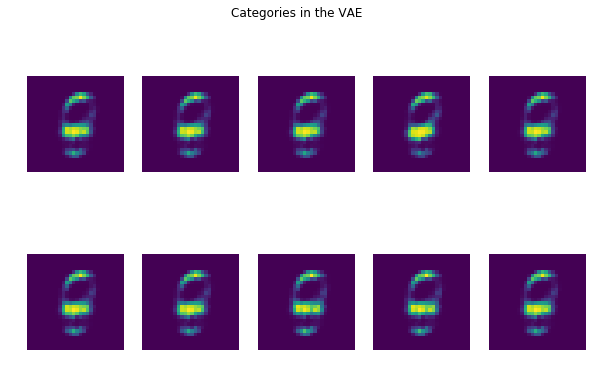

In [19]:
import matplotlib.pyplot as plt
f, axarr = plt.subplots(2, 5, figsize=(10, 6))

x = torch.zeros(10, 11).to(device)
for i in range(10):
    x[i, ] = 1
    x[i, 10:11] = torch.tensor(np.random.normal(size=1))

reconstruction = model.decoder(x)
r = reconstruction.data.cpu().numpy()

for i, ax in enumerate(axarr.flat):
    ax.imshow(r[i].reshape(28, 28), cmap="viridis")
    ax.axis("off")
    
plt.suptitle("Categories in the VAE")
plt.show()

RuntimeError: size mismatch, m1: [10 x 10], m2: [11 x 128] at /pytorch/aten/src/THC/generic/THCTensorMathBlas.cu:249

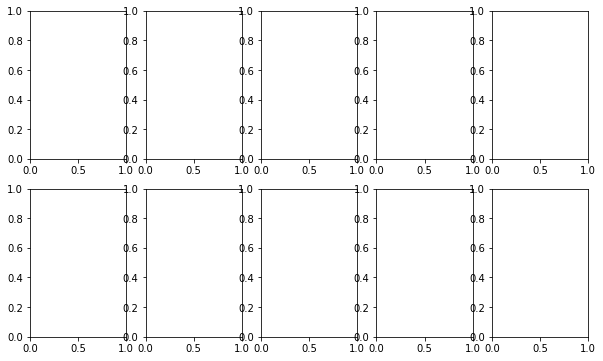

In [6]:
import matplotlib.pyplot as plt
f, axarr = plt.subplots(2, 5, figsize=(10, 6))

x = torch.zeros(10, 10).to(device)
for i in range(10):
    x[i, i]= 0.5
    x[i, (i+1) % 10] = 0.5

reconstruction = model.decoder(x)
r = reconstruction.data.cpu().numpy()

for i, ax in enumerate(axarr.flat):
    ax.imshow(r[i].reshape(28, 28), cmap="viridis")
    ax.axis("off")
    
plt.suptitle("Mixed categories in the VAE")
plt.show()